In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
os.environ['NVIDIA_VISIBLE_DEVICES'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ

environ{'PATH': '/opt/conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'HOSTNAME': '78353253e378',
        'TERM': 'xterm-color',
        'NVIDIA_VISIBLE_DEVICES': '1',
        'CUDA_VERSION': '9.0.176',
        'CUDA_PKG_VERSION': '9-0=9.0.176-1',
        'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64',
        'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
        'NVIDIA_REQUIRE_CUDA': 'cuda>=9.0',
        'NCCL_VERSION': '2.4.2',
        'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs',
        'CUDNN_VERSION': '7.4.2.24',
        'LANG': 'C.UTF-8',
        'HOME': '/root',
        'JPY_PARENT_PID': '6',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
        'CUDA_VISIBLE_DEVICES': '1'}

In [3]:
from train import ModelLoader, load_and_save_params, MetricLoader
from datasets.cvpr2016_cub_loader import Cvpr2016CubLoader
from common.util import Namespace
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree, KDTree
import time
from common.metrics import ap_at_k_prototypes
import os, pwd
from common.pretrained_models import InceptionV3Loader, InceptionV2Loader
from common.pretrained_models import INCEPTION_V2_PATH
from PIL import Image
from datasets.dataset_list import get_dataset_splits
from common.metrics import get_prototypes, top1_gzsl
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Define validation and test functions

In [4]:
from collections import defaultdict

def get_multiplier_grid(metric_model, feature_model, dataset_splits):
    seen_adjustment_grid = np.arange(0.0, 0.05, 0.001)
    
    multiplier_grid = {}
    for seen_adjustment in seen_adjustment_grid:
        results_eval, _ = feature_model.eval_acc_gzsh(train_loader=dataset_splits[metric_model.flags.train_split],
                                                      test_loader_seen=dataset_splits[metric_model.flags.test_split+"_seen"],
                                                      test_loader_unseen=dataset_splits[metric_model.flags.test_split+"_unseen"],
                                                      batch_size=32, seen_adjustment=seen_adjustment)
        multiplier_grid[seen_adjustment] = results_eval['test_H_Top-1 Acc/#sentences1000']
        
    return multiplier_grid

def crossvalidate_metric_multiplier(logdir, filter):
    
    model_list = glob(logdir+f"/{filter}")
    print("Processing models:")
    print(model_list)
    
    
    metric_model = MetricLoader(model_path=model_list[0], 
                            batch_size_image=100, batch_size_text=200)
    
    dataset_splits = get_dataset_splits(dataset_name=metric_model.flags.dataset, data_dir=metric_model.flags.data_dir,
                                    splits=[metric_model.flags.train_split, 
                                            metric_model.flags.test_split+"_seen", 
                                            metric_model.flags.test_split+"_unseen"], 
                                    flags=metric_model.flags)
    df = []
    for i, model_path in enumerate(model_list):
        
        metric_model = MetricLoader(model_path=model_path, 
                            batch_size_image=100, batch_size_text=200)
        feature_model = ModelLoader(model_path=model_path, batch_size=None,
                                    num_images=metric_model.flags.num_images, num_texts=metric_model.flags.num_texts, 
                                    max_text_len=30)
        
        multiplier_grid = get_multiplier_grid(metric_model, feature_model, dataset_splits)
        
        df.append(pd.DataFrame(index=multiplier_grid.keys(), data=multiplier_grid.values(), columns=[str(i)]))
                
    return pd.concat(df, axis=1)

def dmean(dicts):
    ret = defaultdict(float)
    count = defaultdict(float)
    for d in dicts:
        for k, v in d.items():
            ret[k] += v
            count[k] += 1.0
    for k, v in ret.items():
        ret[k] = ret[k] / count[k]
    return dict(ret)


def evaluate_test_result(logdir, filter, metric_multiplier):
    
    model_list = glob(logdir+f"/{filter}")
    print("Processing models:")
    print(model_list)
    
    metric_model = MetricLoader(model_path=model_list[0], 
                            batch_size_image=100, batch_size_text=200)
    
    dataset_splits = get_dataset_splits(dataset_name=metric_model.flags.dataset, 
                                        data_dir=metric_model.flags.data_dir,
                                        splits=["trainval", "test_seen", "test_unseen"],
                                        flags=metric_model.flags)
    
    results = []
    for i, model_path in enumerate(model_list):
        metric_model = MetricLoader(model_path=model_path, 
                            batch_size_image=100, batch_size_text=200)
        feature_model = ModelLoader(model_path=model_path, batch_size=None,
                                    num_images=metric_model.flags.num_images, num_texts=metric_model.flags.num_texts, 
                                    max_text_len=30)
        
        results_repeat, _ = feature_model.eval_acc_gzsh(train_loader=dataset_splits["trainval"],
                                                      test_loader_seen=dataset_splits["test_seen"],
                                                      test_loader_unseen=dataset_splits["test_unseen"],
                                                      batch_size=32, seen_adjustment=metric_multiplier)
        results.append(results_repeat)
    
    return results

## CUB Dataset, crossvalidate multiplier factor

In [5]:
log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144517_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_validation_split"
filter = "*dataset=xian2017_cub*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190506_130656_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_validation_split"
filter = "*mi_weight=0.4*dataset=xian2017_cub*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split"
filter = "*embedding_size=1024*dataset=xian2017_cub*repeat=*"



In [6]:

df = crossvalidate_metric_multiplier(logdir=log_dir, filter=filter)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;t

INFO:root:Loading split train
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_train_xian2017.pkl


Loading model


INFO:root:Loaded cache in 4.330981 sec
INFO:root:Loading split val_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_val_seen_xian2017.pkl
INFO:root:Loaded cache in 2.300134 sec
INFO:root:Loading split val_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_val_unseen_xian2017.pkl
INFO:root:Loaded cache in 3.494278 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:06, 23.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 34.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3905162513
STD unseen prototype:
58.404311462


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.3196289294
STD unseen prototype:
57.1131903919
STD seen prototype:
57.162343121
STD unseen prototype:
56.8755460533


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.113172284
STD unseen prototype:
56.7461679719
STD seen prototype:
57.0662676793
STD unseen prototype:
56.7131236796


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
57.055442684
STD unseen prototype:
56.7037255263
****************
SEEN images test
****************
STD seen prototype:
57.7616137578
STD unseen prototype:
60.0231118201
STD seen prototype:
56.3090621007
STD unseen prototype:
59.1221364404


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
56.0453783422
STD unseen prototype:
59.0269970842
STD seen prototype:
55.9430641399
STD unseen prototype:
58.9154126887
STD seen prototype:
55.901541567
STD unseen prototype:
58.8978004487


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.899151865
STD unseen prototype:
58.9079726391
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 35.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2872898353
STD unseen prototype:
58.4542866103


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.3212186745
STD unseen prototype:
56.9975871804
STD seen prototype:
57.1814670183
STD unseen prototype:
56.9206375169


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.1189146668
STD unseen prototype:
56.7951695891
STD seen prototype:
57.071972891
STD unseen prototype:
56.7033998406


 33%|███▎      | 2/6 [00:00<00:00, 12.52it/s]

STD seen prototype:
57.0554426755
STD unseen prototype:
56.7037255606
****************
SEEN images test
****************
STD seen prototype:
57.8994602817
STD unseen prototype:
60.1594854869
STD seen prototype:
56.3645846667
STD unseen prototype:
58.9752474846


 67%|██████▋   | 4/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
56.1038051597
STD unseen prototype:
58.9307573537
STD seen prototype:
55.9882903412
STD unseen prototype:
58.9270762477
STD seen prototype:
55.9139758633
STD unseen prototype:
58.9063166778


100%|██████████| 6/6 [00:00<00:00, 12.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518497
STD unseen prototype:
58.9079726248
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2972977083
STD unseen prototype:
58.3754313347


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.221194673
STD unseen prototype:
57.0293007429
STD seen prototype:
57.1407590997
STD unseen prototype:
56.8337861726


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.0897149815
STD unseen prototype:
56.750162136
STD seen prototype:
57.06315417
STD unseen prototype:
56.7193923347


 33%|███▎      | 2/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
57.0554426451
STD unseen prototype:
56.7037255194
****************
SEEN images test
****************
STD seen prototype:
57.949308564
STD unseen prototype:
59.9518738077
STD seen prototype:
56.2066959394
STD unseen prototype:
59.1016368592


 67%|██████▋   | 4/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
56.1289923031
STD unseen prototype:
58.9989695062
STD seen prototype:
55.9838751151
STD unseen prototype:
58.916509671
STD seen prototype:
55.9060105335
STD unseen prototype:
58.9068672925


100%|██████████| 6/6 [00:00<00:00, 12.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519014
STD unseen prototype:
58.9079726223
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4701457412
STD unseen prototype:
58.4698452816


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.2302340351
STD unseen prototype:
56.987442062
STD seen prototype:
57.1770391501
STD unseen prototype:
56.8072407261


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.1096945906
STD unseen prototype:
56.7615353623
STD seen prototype:
57.066332668
STD unseen prototype:
56.7252687304


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
57.0554426598
STD unseen prototype:
56.7037255584
****************
SEEN images test
****************
STD seen prototype:
57.8776844935
STD unseen prototype:
59.7256679893
STD seen prototype:
56.3151022466
STD unseen prototype:
59.0482708618


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
56.0886817795
STD unseen prototype:
58.9895947151
STD seen prototype:
55.9972985196
STD unseen prototype:
58.9240636773
STD seen prototype:
55.91421003
STD unseen prototype:
58.8925115107


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518593
STD unseen prototype:
58.9079725797
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2792617481
STD unseen prototype:
58.2606501376


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.3494066089
STD unseen prototype:
57.0161989234
STD seen prototype:
57.1739814376
STD unseen prototype:
56.7897809766


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.0769537227
STD unseen prototype:
56.7718094769
STD seen prototype:
57.0541704849
STD unseen prototype:
56.7136951523


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
57.0554426562
STD unseen prototype:
56.7037255494
****************
SEEN images test
****************
STD seen prototype:
57.8368695358
STD unseen prototype:
59.9454138355
STD seen prototype:
56.2747859407
STD unseen prototype:
59.1184007461


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
56.0844058416
STD unseen prototype:
58.9720947982
STD seen prototype:
55.9784611888
STD unseen prototype:
58.9069460561
STD seen prototype:
55.9084308386
STD unseen prototype:
58.9207242321


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518435
STD unseen prototype:
58.9079725749
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3269233786
STD unseen prototype:
58.4753046316


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.305055815
STD unseen prototype:
57.0827595485
STD seen prototype:
57.1844464852
STD unseen prototype:
56.8668058987


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
57.0895495192
STD unseen prototype:
56.7559012638
STD seen prototype:
57.0543969747
STD unseen prototype:
56.7253079283


 33%|███▎      | 2/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
57.0554426551
STD unseen prototype:
56.7037255247
****************
SEEN images test
****************
STD seen prototype:
57.9159056422
STD unseen prototype:
59.8267022783
STD seen prototype:
56.3865992435
STD unseen prototype:
59.1370467596


 67%|██████▋   | 4/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
56.1161429128
STD unseen prototype:
58.9391340332
STD seen prototype:
55.9732861836
STD unseen prototype:
58.9497572526
STD seen prototype:
55.9110881585
STD unseen prototype:
58.9043540677


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518904
STD unseen prototype:
58.9079725624
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4350953555
STD unseen prototype:
58.5574047169


 50%|█████     | 3/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.259978332
STD unseen prototype:
57.0696080583
STD seen prototype:
57.1254028568
STD unseen prototype:
56.8854904542


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.10072539
STD unseen prototype:
56.7600957604
STD seen prototype:
57.0762289581
STD unseen prototype:
56.7159175262


 33%|███▎      | 2/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
57.0554426473
STD unseen prototype:
56.7037255481
****************
SEEN images test
****************
STD seen prototype:
57.8310926214
STD unseen prototype:
59.9094532547
STD seen prototype:
56.3092001845
STD unseen prototype:
59.0736812831


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
56.0903395889
STD unseen prototype:
58.9715525583
STD seen prototype:
55.9895493174
STD unseen prototype:
58.9354808621
STD seen prototype:
55.9104719004
STD unseen prototype:
58.9375027592


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519185
STD unseen prototype:
58.907972651
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4114664677
STD unseen prototype:
58.6085259428


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.2677971059
STD unseen prototype:
57.1513614476
STD seen prototype:
57.1564239
STD unseen prototype:
56.8282300354


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.0986157269
STD unseen prototype:
56.7923812799
STD seen prototype:
57.0441134415
STD unseen prototype:
56.7014566746


 33%|███▎      | 2/6 [00:00<00:00, 12.45it/s]

STD seen prototype:
57.0554426461
STD unseen prototype:
56.7037255507
****************
SEEN images test
****************
STD seen prototype:
57.8301449747
STD unseen prototype:
59.8419152123
STD seen prototype:
56.3558322342
STD unseen prototype:
58.9850412651


 67%|██████▋   | 4/6 [00:00<00:00, 12.50it/s]

STD seen prototype:
56.0775310976
STD unseen prototype:
58.9643580879
STD seen prototype:
55.9861317644
STD unseen prototype:
58.9637728456
STD seen prototype:
55.9173105298
STD unseen prototype:
58.9110619899


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518761
STD unseen prototype:
58.9079725839
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4609249077
STD unseen prototype:
58.3465248698


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.2502452237
STD unseen prototype:
57.1436054076
STD seen prototype:
57.1181504544
STD unseen prototype:
56.8279190366


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.0378241358
STD unseen prototype:
56.7606468887
STD seen prototype:
57.057518795
STD unseen prototype:
56.7295667493


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
57.0554426381
STD unseen prototype:
56.703725529
****************
SEEN images test
****************
STD seen prototype:
57.8787220025
STD unseen prototype:
59.9751396351
STD seen prototype:
56.2768141272
STD unseen prototype:
59.0229834765


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
56.0994344481
STD unseen prototype:
58.9219903677
STD seen prototype:
55.9508952009
STD unseen prototype:
58.9337914715
STD seen prototype:
55.9295226739
STD unseen prototype:
58.9238217909


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518922
STD unseen prototype:
58.9079725741
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4448765027
STD unseen prototype:
58.3795672537


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.2579978063
STD unseen prototype:
57.0910235258
STD seen prototype:
57.1639780761
STD unseen prototype:
56.9160621792


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.0437134466
STD unseen prototype:
56.7788222845
STD seen prototype:
57.077451877
STD unseen prototype:
56.7235450067


 33%|███▎      | 2/6 [00:00<00:00, 12.66it/s]

STD seen prototype:
57.0554426651
STD unseen prototype:
56.7037255439
****************
SEEN images test
****************
STD seen prototype:
58.1965387966
STD unseen prototype:
59.8151368133
STD seen prototype:
56.1851279125
STD unseen prototype:
59.1855094281


 67%|██████▋   | 4/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
56.0565582028
STD unseen prototype:
58.9491462467
STD seen prototype:
55.9849123077
STD unseen prototype:
58.912392317
STD seen prototype:
55.9316745825
STD unseen prototype:
58.928675908


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518497
STD unseen prototype:
58.9079725997
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4732000356
STD unseen prototype:
58.2454667762


 50%|█████     | 3/6 [00:00<00:00,  6.37it/s]

STD seen prototype:
57.2774564178
STD unseen prototype:
57.1260546493
STD seen prototype:
57.0773665208
STD unseen prototype:
56.8827222833


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.1012206455
STD unseen prototype:
56.7310032521
STD seen prototype:
57.0747860517
STD unseen prototype:
56.7154088111


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
57.0554426449
STD unseen prototype:
56.7037255566
****************
SEEN images test
****************
STD seen prototype:
57.8401494776
STD unseen prototype:
59.5960754959
STD seen prototype:
56.3012224601
STD unseen prototype:
59.1089214265


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
56.0488639555
STD unseen prototype:
59.0029066479
STD seen prototype:
55.9636061248
STD unseen prototype:
58.9042830477
STD seen prototype:
55.9311452079
STD unseen prototype:
58.9108597084


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518748
STD unseen prototype:
58.9079726214
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3913517074
STD unseen prototype:
58.4627596682


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.342699384
STD unseen prototype:
57.0549327613
STD seen prototype:
57.1398058204
STD unseen prototype:
56.8698736819


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.1192607565
STD unseen prototype:
56.7730027459
STD seen prototype:
57.0645405928
STD unseen prototype:
56.7218845628


 33%|███▎      | 2/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
57.0554426742
STD unseen prototype:
56.703725583
****************
SEEN images test
****************
STD seen prototype:
57.7634381025
STD unseen prototype:
59.98179085
STD seen prototype:
56.320863251
STD unseen prototype:
59.0963281409


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
56.0368423348
STD unseen prototype:
58.9621794017
STD seen prototype:
55.9814806372
STD unseen prototype:
58.9447403699
STD seen prototype:
55.9202904641
STD unseen prototype:
58.9151670272


100%|██████████| 6/6 [00:00<00:00, 12.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518529
STD unseen prototype:
58.9079725831
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3625641499
STD unseen prototype:
58.6770265366


 50%|█████     | 3/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
57.2496328599
STD unseen prototype:
57.0762964174
STD seen prototype:
57.1394628813
STD unseen prototype:
56.8893199101


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.147196078
STD unseen prototype:
56.7628132042
STD seen prototype:
57.0707363498
STD unseen prototype:
56.7166348744


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
57.0554426706
STD unseen prototype:
56.7037255596
****************
SEEN images test
****************
STD seen prototype:
57.8300742837
STD unseen prototype:
59.8292010281
STD seen prototype:
56.2370070486
STD unseen prototype:
59.0968318056


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
56.1121294948
STD unseen prototype:
58.949447814
STD seen prototype:
56.0017047277
STD unseen prototype:
58.9623558265
STD seen prototype:
55.9233787427
STD unseen prototype:
58.8654331445


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518907
STD unseen prototype:
58.9079726387
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2561192236
STD unseen prototype:
58.5549707


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.3297962964
STD unseen prototype:
57.136124571
STD seen prototype:
57.0813344478
STD unseen prototype:
56.8443960585


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.0691138195
STD unseen prototype:
56.7671988863
STD seen prototype:
57.0649140457
STD unseen prototype:
56.7312296113


 33%|███▎      | 2/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
57.0554426281
STD unseen prototype:
56.7037255286
****************
SEEN images test
****************
STD seen prototype:
57.9400217363
STD unseen prototype:
60.0463280575
STD seen prototype:
56.2971123513
STD unseen prototype:
58.9882872333


 67%|██████▋   | 4/6 [00:00<00:00, 12.40it/s]

STD seen prototype:
56.0835221346
STD unseen prototype:
59.0528769024
STD seen prototype:
55.9919840372
STD unseen prototype:
58.8847969179
STD seen prototype:
55.9103860044
STD unseen prototype:
58.9474047782


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519485
STD unseen prototype:
58.9079725846
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3155718915
STD unseen prototype:
58.3932489067


 50%|█████     | 3/6 [00:00<00:00,  6.43it/s]

STD seen prototype:
57.2424562197
STD unseen prototype:
57.0556936531
STD seen prototype:
57.1739797201
STD unseen prototype:
56.9013424174


 83%|████████▎ | 5/6 [00:00<00:00,  6.59it/s]

STD seen prototype:
57.0987216325
STD unseen prototype:
56.7656308689
STD seen prototype:
57.0651879105
STD unseen prototype:
56.7303355208


 33%|███▎      | 2/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
57.0554426328
STD unseen prototype:
56.7037255585
****************
SEEN images test
****************
STD seen prototype:
57.9794448629
STD unseen prototype:
59.9517474573
STD seen prototype:
56.3533333493
STD unseen prototype:
59.0558259957


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
56.013651987
STD unseen prototype:
59.0341778148
STD seen prototype:
55.9799066007
STD unseen prototype:
58.9491260467
STD seen prototype:
55.9135886119
STD unseen prototype:
58.8925660848


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518891
STD unseen prototype:
58.907972629
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5912629826
STD unseen prototype:
58.2811955916


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.2205718523
STD unseen prototype:
57.019026964
STD seen prototype:
57.1524572176
STD unseen prototype:
56.963163299


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.1003106353
STD unseen prototype:
56.7650206182
STD seen prototype:
57.047700936
STD unseen prototype:
56.7097294192


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
57.0554426483
STD unseen prototype:
56.7037255181
****************
SEEN images test
****************
STD seen prototype:
57.8934102108
STD unseen prototype:
59.816671319
STD seen prototype:
56.3629052046
STD unseen prototype:
59.0651970671


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.0831317766
STD unseen prototype:
59.0327544368
STD seen prototype:
55.9681506211
STD unseen prototype:
58.9441108259
STD seen prototype:
55.9162213069
STD unseen prototype:
58.9216700575


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519092
STD unseen prototype:
58.9079726234
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5264066736
STD unseen prototype:
58.6148726056


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.309317733
STD unseen prototype:
57.0037341104
STD seen prototype:
57.1414462428
STD unseen prototype:
56.8766335086


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.0699107976
STD unseen prototype:
56.7701186399
STD seen prototype:
57.0841827031
STD unseen prototype:
56.7271874246


 33%|███▎      | 2/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
57.0554426238
STD unseen prototype:
56.7037255329
****************
SEEN images test
****************
STD seen prototype:
57.6640950772
STD unseen prototype:
59.8296699259
STD seen prototype:
56.2633300108
STD unseen prototype:
59.0069740061


 67%|██████▋   | 4/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
56.1020990477
STD unseen prototype:
58.9408883744
STD seen prototype:
55.9724687961
STD unseen prototype:
58.9338115676
STD seen prototype:
55.9205457329
STD unseen prototype:
58.8963249708


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518798
STD unseen prototype:
58.9079725637
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3771230006
STD unseen prototype:
58.3086883615


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.2269936056
STD unseen prototype:
57.0699668873
STD seen prototype:
57.1626514709
STD unseen prototype:
56.8829688707


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.1173876309
STD unseen prototype:
56.7760100838
STD seen prototype:
57.0735737549
STD unseen prototype:
56.7472452531


 33%|███▎      | 2/6 [00:00<00:00, 12.21it/s]

STD seen prototype:
57.0554426353
STD unseen prototype:
56.7037254993
****************
SEEN images test
****************
STD seen prototype:
57.8344683161
STD unseen prototype:
60.0622865606
STD seen prototype:
56.2592527361
STD unseen prototype:
58.9112389698


 67%|██████▋   | 4/6 [00:00<00:00, 12.38it/s]

STD seen prototype:
56.059772983
STD unseen prototype:
58.9573016675
STD seen prototype:
55.9712741273
STD unseen prototype:
58.980340701
STD seen prototype:
55.9175839881
STD unseen prototype:
58.9023748431


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519218
STD unseen prototype:
58.9079725734
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.366253581
STD unseen prototype:
58.2323058574


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.2413194885
STD unseen prototype:
57.0077034767
STD seen prototype:
57.2486804404
STD unseen prototype:
56.84221723


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.0744378053
STD unseen prototype:
56.7157706075
STD seen prototype:
57.0710678878
STD unseen prototype:
56.7287899899


 33%|███▎      | 2/6 [00:00<00:00, 13.66it/s]

STD seen prototype:
57.0554426531
STD unseen prototype:
56.7037255557
****************
SEEN images test
****************
STD seen prototype:
57.7674246449
STD unseen prototype:
59.8582279351
STD seen prototype:
56.2548976398
STD unseen prototype:
59.1162739822


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
56.0668561379
STD unseen prototype:
59.0985059146
STD seen prototype:
55.9660027355
STD unseen prototype:
58.9426196661
STD seen prototype:
55.9169762384
STD unseen prototype:
58.968021538


100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519037
STD unseen prototype:
58.9079725888
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6215030379
STD unseen prototype:
58.496593362


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.3095776281
STD unseen prototype:
57.0345448705
STD seen prototype:
57.2177774192
STD unseen prototype:
56.8368287304


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.1070370484
STD unseen prototype:
56.7761919809
STD seen prototype:
57.0764407033
STD unseen prototype:
56.7227498588


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
57.0554426251
STD unseen prototype:
56.7037255782
****************
SEEN images test
****************
STD seen prototype:
57.8325892868
STD unseen prototype:
60.1452023712
STD seen prototype:
56.3117701165
STD unseen prototype:
59.0320109159


 67%|██████▋   | 4/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
56.0853977674
STD unseen prototype:
58.9372957151
STD seen prototype:
56.0096050207
STD unseen prototype:
58.9399196198
STD seen prototype:
55.9136866256
STD unseen prototype:
58.9233389966


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518654
STD unseen prototype:
58.9079725775
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2314135203
STD unseen prototype:
58.4646163607


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.2291345282
STD unseen prototype:
57.1716357118
STD seen prototype:
57.1456292093
STD unseen prototype:
56.8265794359


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.1102543995
STD unseen prototype:
56.768820701
STD seen prototype:
57.0653783676
STD unseen prototype:
56.7108882092


 33%|███▎      | 2/6 [00:00<00:00, 13.83it/s]

STD seen prototype:
57.0554426388
STD unseen prototype:
56.7037255357
****************
SEEN images test
****************
STD seen prototype:
57.9532478095
STD unseen prototype:
60.1810541952
STD seen prototype:
56.3044327313
STD unseen prototype:
59.1918868837


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
56.076163093
STD unseen prototype:
59.001402976
STD seen prototype:
55.9788850419
STD unseen prototype:
58.8968821642
STD seen prototype:
55.9115293286
STD unseen prototype:
58.9261267744


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518782
STD unseen prototype:
58.9079725741
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.89it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4112001903
STD unseen prototype:
58.5505123808


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.3052177149
STD unseen prototype:
57.0466658104
STD seen prototype:
57.2075088519
STD unseen prototype:
56.8284143401


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.1226638489
STD unseen prototype:
56.7927437026
STD seen prototype:
57.0923271564
STD unseen prototype:
56.7113713766


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
57.0554426193
STD unseen prototype:
56.7037255568
****************
SEEN images test
****************
STD seen prototype:
57.8088373929
STD unseen prototype:
59.7237658248


 67%|██████▋   | 4/6 [00:00<00:00, 11.12it/s]

STD seen prototype:
56.3947904331
STD unseen prototype:
59.1305035306
STD seen prototype:
56.1152432798
STD unseen prototype:
59.0170466364
STD seen prototype:
55.9728658139
STD unseen prototype:
58.9227659199


100%|██████████| 6/6 [00:00<00:00, 11.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.9186895575
STD unseen prototype:
58.9253576895
STD seen prototype:
55.8991519098
STD unseen prototype:
58.907972601
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5292874343
STD unseen prototype:
58.3614921244


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.1827180191
STD unseen prototype:
57.1253880857
STD seen prototype:
57.178305085
STD unseen prototype:
56.9698863748


 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
57.0938579971
STD unseen prototype:
56.7865429634
STD seen prototype:
57.07496386
STD unseen prototype:
56.7365732886


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
57.055442658
STD unseen prototype:
56.7037255389
****************
SEEN images test
****************
STD seen prototype:
57.7219180592
STD unseen prototype:
59.9918812443
STD seen prototype:
56.3051103209
STD unseen prototype:
59.0554349885


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
56.0862397529
STD unseen prototype:
58.9957072147
STD seen prototype:
55.9917637014
STD unseen prototype:
58.9446871867
STD seen prototype:
55.9251827617
STD unseen prototype:
58.9097847149


100%|██████████| 6/6 [00:00<00:00, 13.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518491
STD unseen prototype:
58.9079725785
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4031266663
STD unseen prototype:
58.5510767679


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.1421576224
STD unseen prototype:
57.0589804777
STD seen prototype:
57.1680009461
STD unseen prototype:
56.8875637516


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.0818938488
STD unseen prototype:
56.7867883243
STD seen prototype:
57.0542950737
STD unseen prototype:
56.7276496522


 33%|███▎      | 2/6 [00:00<00:00, 12.42it/s]

STD seen prototype:
57.0554426501
STD unseen prototype:
56.7037255415
****************
SEEN images test
****************
STD seen prototype:
57.7432988481
STD unseen prototype:
59.8216475859
STD seen prototype:
56.2660716414
STD unseen prototype:
59.0979490432


 67%|██████▋   | 4/6 [00:00<00:00, 12.47it/s]

STD seen prototype:
56.0691549568
STD unseen prototype:
58.9768804693
STD seen prototype:
55.973389276
STD unseen prototype:
58.8887120134
STD seen prototype:
55.9098758958
STD unseen prototype:
58.9061405541


100%|██████████| 6/6 [00:00<00:00, 12.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518691
STD unseen prototype:
58.9079726243
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.09it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2625748614
STD unseen prototype:
58.2842292239


 50%|█████     | 3/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.2937324959
STD unseen prototype:
56.9282046937
STD seen prototype:
57.0642085139
STD unseen prototype:
56.8752797306


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.1150685409
STD unseen prototype:
56.784792966
STD seen prototype:
57.0512935116
STD unseen prototype:
56.7197165392


 33%|███▎      | 2/6 [00:00<00:00, 13.95it/s]

STD seen prototype:
57.0554426399
STD unseen prototype:
56.7037255043
****************
SEEN images test
****************
STD seen prototype:
57.8937260581
STD unseen prototype:
60.00581301
STD seen prototype:
56.2720307329
STD unseen prototype:
59.0606683129


 67%|██████▋   | 4/6 [00:00<00:00, 13.78it/s]

STD seen prototype:
56.1143310532
STD unseen prototype:
58.9013474804
STD seen prototype:
55.9439937537
STD unseen prototype:
58.9308347446
STD seen prototype:
55.9108181528
STD unseen prototype:
58.9280903144


100%|██████████| 6/6 [00:00<00:00, 13.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519026
STD unseen prototype:
58.9079725949
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2667563933
STD unseen prototype:
58.3535010066


 50%|█████     | 3/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
57.2666966323
STD unseen prototype:
56.9644018795
STD seen prototype:
57.1980907579
STD unseen prototype:
56.9576099679


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.0777838939
STD unseen prototype:
56.7727351307
STD seen prototype:
57.0620360127
STD unseen prototype:
56.7269310625


 33%|███▎      | 2/6 [00:00<00:00, 12.40it/s]

STD seen prototype:
57.0554426789
STD unseen prototype:
56.7037255493
****************
SEEN images test
****************
STD seen prototype:
57.8044663655
STD unseen prototype:
60.0362201628
STD seen prototype:
56.3443506372
STD unseen prototype:
59.1419626316


 67%|██████▋   | 4/6 [00:00<00:00, 12.34it/s]

STD seen prototype:
56.0972054531
STD unseen prototype:
59.0289165496
STD seen prototype:
55.9872925117
STD unseen prototype:
58.9649567881
STD seen prototype:
55.9202677261
STD unseen prototype:
58.9015379044


100%|██████████| 6/6 [00:00<00:00, 12.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518589
STD unseen prototype:
58.9079725667
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.431230899
STD unseen prototype:
58.5518028954


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.289241452
STD unseen prototype:
57.0323501861
STD seen prototype:
57.1099168457
STD unseen prototype:
56.8431176085


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.0943622744
STD unseen prototype:
56.751111231
STD seen prototype:
57.073900005
STD unseen prototype:
56.7104516661


 33%|███▎      | 2/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
57.0554426394
STD unseen prototype:
56.7037255235
****************
SEEN images test
****************
STD seen prototype:
57.6656289022
STD unseen prototype:
59.8881257899
STD seen prototype:
56.3935934439
STD unseen prototype:
59.0251502154


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
56.0545062673
STD unseen prototype:
58.9162598733
STD seen prototype:
55.9406720671
STD unseen prototype:
58.9065974952
STD seen prototype:
55.9194468276
STD unseen prototype:
58.9234212397


100%|██████████| 6/6 [00:00<00:00, 13.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518353
STD unseen prototype:
58.9079725869
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.518432394
STD unseen prototype:
58.5272485373


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.3674284707
STD unseen prototype:
57.0091970503
STD seen prototype:
57.1561263868
STD unseen prototype:
56.815898544


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.0907599952
STD unseen prototype:
56.7538632216
STD seen prototype:
57.0876467842
STD unseen prototype:
56.711488407


 33%|███▎      | 2/6 [00:00<00:00, 11.73it/s]

STD seen prototype:
57.055442633
STD unseen prototype:
56.7037255513
****************
SEEN images test
****************
STD seen prototype:
58.0342420571
STD unseen prototype:
60.0589912337
STD seen prototype:
56.2657794412
STD unseen prototype:
59.0362815304


 67%|██████▋   | 4/6 [00:00<00:00, 12.09it/s]

STD seen prototype:
56.1358500633
STD unseen prototype:
58.9212622607
STD seen prototype:
55.9766750401
STD unseen prototype:
58.9623360493
STD seen prototype:
55.9251113505
STD unseen prototype:
58.9206724478


100%|██████████| 6/6 [00:00<00:00, 12.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519304
STD unseen prototype:
58.9079725689
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5474565059
STD unseen prototype:
58.585582853


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.2436441257
STD unseen prototype:
57.1346216581
STD seen prototype:
57.1247128395
STD unseen prototype:
56.8663946734


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.1151120423
STD unseen prototype:
56.7820677457
STD seen prototype:
57.0554947756
STD unseen prototype:
56.7115418445


 33%|███▎      | 2/6 [00:00<00:00, 14.57it/s]

STD seen prototype:
57.0554426659
STD unseen prototype:
56.7037255269
****************
SEEN images test
****************
STD seen prototype:
57.862321641
STD unseen prototype:
59.8940981871
STD seen prototype:
56.3576393232
STD unseen prototype:
59.0621630231


 67%|██████▋   | 4/6 [00:00<00:00, 14.36it/s]

STD seen prototype:
56.0481694461
STD unseen prototype:
58.999723342
STD seen prototype:
55.952204485
STD unseen prototype:
58.9185658127
STD seen prototype:
55.918802244
STD unseen prototype:
58.9268312698


100%|██████████| 6/6 [00:00<00:00, 13.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518934
STD unseen prototype:
58.9079725819
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2342568556
STD unseen prototype:
58.2817091117


 50%|█████     | 3/6 [00:00<00:00,  6.52it/s]

STD seen prototype:
57.3253824038
STD unseen prototype:
57.1359227601
STD seen prototype:
57.1481071372
STD unseen prototype:
56.9103324699


 83%|████████▎ | 5/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.0966118484
STD unseen prototype:
56.814132614
STD seen prototype:
57.0626207582
STD unseen prototype:
56.739996983


 33%|███▎      | 2/6 [00:00<00:00, 12.32it/s]

STD seen prototype:
57.0554426508
STD unseen prototype:
56.7037255407
****************
SEEN images test
****************
STD seen prototype:
57.6743658691
STD unseen prototype:
59.9419546185
STD seen prototype:
56.2424717724
STD unseen prototype:
58.9988654243


 67%|██████▋   | 4/6 [00:00<00:00, 12.30it/s]

STD seen prototype:
56.0703708937
STD unseen prototype:
58.965985695
STD seen prototype:
55.9740034809
STD unseen prototype:
58.9471613073
STD seen prototype:
55.918869313
STD unseen prototype:
58.9115015582


100%|██████████| 6/6 [00:00<00:00, 11.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.899151928
STD unseen prototype:
58.9079726195
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3410367857
STD unseen prototype:
58.3536027047


 50%|█████     | 3/6 [00:00<00:00,  7.41it/s]

STD seen prototype:
57.2563028303
STD unseen prototype:
56.986250837
STD seen prototype:
57.1253004783
STD unseen prototype:
56.9335767811


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.070822295
STD unseen prototype:
56.7258010539
STD seen prototype:
57.0702066578
STD unseen prototype:
56.7098142379


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
57.0554426583
STD unseen prototype:
56.7037255152
****************
SEEN images test
****************
STD seen prototype:
57.9130354974
STD unseen prototype:
59.8905013434
STD seen prototype:
56.2978153749
STD unseen prototype:
59.0917194388


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
56.1261931144
STD unseen prototype:
58.9226120008
STD seen prototype:
55.9624864909
STD unseen prototype:
58.8844035254
STD seen prototype:
55.9146871187
STD unseen prototype:
58.9208113507


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518807
STD unseen prototype:
58.9079726567
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5079597633
STD unseen prototype:
58.399394121


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.3284303427
STD unseen prototype:
56.9730407636
STD seen prototype:
57.1411637836
STD unseen prototype:
56.8255983264


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.0757427718
STD unseen prototype:
56.7271352074
STD seen prototype:
57.0660810676
STD unseen prototype:
56.6993967373


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
57.0554426357
STD unseen prototype:
56.703725529
****************
SEEN images test
****************
STD seen prototype:
57.8622739916
STD unseen prototype:
59.6637909943
STD seen prototype:
56.310032936
STD unseen prototype:
59.1362214924


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
56.0724923948
STD unseen prototype:
59.0179966114
STD seen prototype:
55.9520296967
STD unseen prototype:
58.9561179263
STD seen prototype:
55.8935895037
STD unseen prototype:
58.93348998


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518844
STD unseen prototype:
58.9079726336
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3301934873
STD unseen prototype:
58.3166762547


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.2052689088
STD unseen prototype:
57.0143681788
STD seen prototype:
57.1775995471
STD unseen prototype:
56.8873788704


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.0916333745
STD unseen prototype:
56.7282636787
STD seen prototype:
57.0691158528
STD unseen prototype:
56.7122565224


 33%|███▎      | 2/6 [00:00<00:00, 12.59it/s]

STD seen prototype:
57.0554426811
STD unseen prototype:
56.7037255464
****************
SEEN images test
****************
STD seen prototype:
57.7477842638
STD unseen prototype:
59.9226382352
STD seen prototype:
56.2457290391
STD unseen prototype:
59.157764371


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.1116050792
STD unseen prototype:
59.0486670117
STD seen prototype:
55.968624547
STD unseen prototype:
58.9312861878
STD seen prototype:
55.9279941684
STD unseen prototype:
58.9474502882


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519119
STD unseen prototype:
58.9079726144
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6004239711
STD unseen prototype:
58.3454223557


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.2897570625
STD unseen prototype:
57.0417179247
STD seen prototype:
57.207058581
STD unseen prototype:
56.8418464392


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.1004575059
STD unseen prototype:
56.731466667
STD seen prototype:
57.060845846
STD unseen prototype:
56.708763654


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
57.055442664
STD unseen prototype:
56.7037255385
****************
SEEN images test
****************
STD seen prototype:
57.7728234791
STD unseen prototype:
59.9384449117
STD seen prototype:
56.2880879071
STD unseen prototype:
59.0586087179


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
56.1279386654
STD unseen prototype:
58.9732990586
STD seen prototype:
56.0242983798
STD unseen prototype:
58.9284282565
STD seen prototype:
55.9342994843
STD unseen prototype:
58.9196554756


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518891
STD unseen prototype:
58.9079725493
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4610646603
STD unseen prototype:
58.4659615008


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.3329043542
STD unseen prototype:
57.1121206155
STD seen prototype:
57.1774964373
STD unseen prototype:
56.8822265138


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.1215019738
STD unseen prototype:
56.7763794392
STD seen prototype:
57.0759593271
STD unseen prototype:
56.7138986889


 33%|███▎      | 2/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
57.0554426597
STD unseen prototype:
56.7037255438
****************
SEEN images test
****************
STD seen prototype:
57.8429204539
STD unseen prototype:
59.7466745785
STD seen prototype:
56.2918256367
STD unseen prototype:
59.0704079295


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
56.0702739315
STD unseen prototype:
58.9146324615
STD seen prototype:
55.9387360421
STD unseen prototype:
58.9095611234
STD seen prototype:
55.9159740846
STD unseen prototype:
58.8998601664


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.899151865
STD unseen prototype:
58.9079725445
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3624758897
STD unseen prototype:
58.1576552638


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.2577493498
STD unseen prototype:
57.0705719237
STD seen prototype:
57.1358873195
STD unseen prototype:
56.829771035


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.1025779291
STD unseen prototype:
56.773003776
STD seen prototype:
57.0307153395
STD unseen prototype:
56.7189669612


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
57.0554426671
STD unseen prototype:
56.7037255076
****************
SEEN images test
****************
STD seen prototype:
57.7512412506
STD unseen prototype:
59.8357089676
STD seen prototype:
56.3738815204
STD unseen prototype:
59.0988918106


 67%|██████▋   | 4/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
56.1080792357
STD unseen prototype:
58.9950377683
STD seen prototype:
56.0028710513
STD unseen prototype:
58.96790993
STD seen prototype:
55.9046681435
STD unseen prototype:
58.8983067773


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518446
STD unseen prototype:
58.9079725643
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4671604121
STD unseen prototype:
58.3169274646


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.2737912549
STD unseen prototype:
57.0493968809
STD seen prototype:
57.1632523246
STD unseen prototype:
56.858293563


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.0877810965
STD unseen prototype:
56.7662772321
STD seen prototype:
57.0823935668
STD unseen prototype:
56.7290116956


 33%|███▎      | 2/6 [00:00<00:00, 12.18it/s]

STD seen prototype:
57.0554426698
STD unseen prototype:
56.7037255567
****************
SEEN images test
****************
STD seen prototype:
57.7577316346
STD unseen prototype:
59.9772817174
STD seen prototype:
56.3210532069
STD unseen prototype:
59.1317046973


 67%|██████▋   | 4/6 [00:00<00:00, 12.38it/s]

STD seen prototype:
56.0740398897
STD unseen prototype:
59.0024353735
STD seen prototype:
55.9942241108
STD unseen prototype:
58.9629352847
STD seen prototype:
55.9103316005
STD unseen prototype:
58.9155098629


100%|██████████| 6/6 [00:00<00:00, 12.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519452
STD unseen prototype:
58.907972632
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.436274763
STD unseen prototype:
58.416442147


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.1978468382
STD unseen prototype:
57.1696153343
STD seen prototype:
57.149487202
STD unseen prototype:
56.8387685178


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.0873681653
STD unseen prototype:
56.7804329055
STD seen prototype:
57.0749367356
STD unseen prototype:
56.7420016648


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
57.0554426213
STD unseen prototype:
56.7037255304
****************
SEEN images test
****************
STD seen prototype:
57.885032446
STD unseen prototype:
60.0307628137
STD seen prototype:
56.2801614422
STD unseen prototype:
59.0520707583


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
56.069204012
STD unseen prototype:
59.0092924046
STD seen prototype:
55.9547654282
STD unseen prototype:
58.9467834826
STD seen prototype:
55.9175240688
STD unseen prototype:
58.8738089084


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518591
STD unseen prototype:
58.9079725883
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4276466367
STD unseen prototype:
58.5852500423


 50%|█████     | 3/6 [00:00<00:00,  6.43it/s]

STD seen prototype:
57.4011150648
STD unseen prototype:
57.1005873365
STD seen prototype:
57.1618016986
STD unseen prototype:
56.9027049064


 83%|████████▎ | 5/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
57.1162606798
STD unseen prototype:
56.7017856755
STD seen prototype:
57.0476682134
STD unseen prototype:
56.7267452036


 33%|███▎      | 2/6 [00:00<00:00, 12.34it/s]

STD seen prototype:
57.0554426776
STD unseen prototype:
56.7037255267
****************
SEEN images test
****************
STD seen prototype:
57.9588271075
STD unseen prototype:
59.8449547543
STD seen prototype:
56.3358021688
STD unseen prototype:
58.9429378845


 67%|██████▋   | 4/6 [00:00<00:00, 12.37it/s]

STD seen prototype:
56.0821301775
STD unseen prototype:
58.9835142498
STD seen prototype:
55.9760358412
STD unseen prototype:
58.9763113739
STD seen prototype:
55.9034152977
STD unseen prototype:
58.9318375858


100%|██████████| 6/6 [00:00<00:00, 12.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519138
STD unseen prototype:
58.907972594
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1084712857
STD unseen prototype:
58.1305276269


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.3472726877
STD unseen prototype:
57.0350169848
STD seen prototype:
57.1181164255
STD unseen prototype:
56.9218651552


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.0656168269
STD unseen prototype:
56.748306986
STD seen prototype:
57.0494006801
STD unseen prototype:
56.7027240282


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
57.0554426908
STD unseen prototype:
56.7037255003
****************
SEEN images test
****************
STD seen prototype:
57.8559666997
STD unseen prototype:
59.9736510753
STD seen prototype:
56.2644038329
STD unseen prototype:
59.0594045913


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
56.089063362
STD unseen prototype:
58.9427398707
STD seen prototype:
55.9831301523
STD unseen prototype:
58.8992236882
STD seen prototype:
55.9110183593
STD unseen prototype:
58.9491345613


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518758
STD unseen prototype:
58.9079726079
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4633587227
STD unseen prototype:
58.1084079324


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.2896491672
STD unseen prototype:
57.0138853347
STD seen prototype:
57.1267700317
STD unseen prototype:
56.9026542558


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.0733868199
STD unseen prototype:
56.7502691111
STD seen prototype:
57.0637374985
STD unseen prototype:
56.7159303069


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
57.0554426769
STD unseen prototype:
56.7037255618
****************
SEEN images test
****************
STD seen prototype:
57.8919031026
STD unseen prototype:
59.879912689
STD seen prototype:
56.2961193888
STD unseen prototype:
59.0868344913


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
56.1119485956
STD unseen prototype:
58.95455345
STD seen prototype:
55.9622550356
STD unseen prototype:
58.9164024057
STD seen prototype:
55.928284866
STD unseen prototype:
58.9116881857


100%|██████████| 6/6 [00:00<00:00, 12.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518423
STD unseen prototype:
58.9079726378
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3220175848
STD unseen prototype:
58.0619939986


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.2495467922
STD unseen prototype:
56.9514380237
STD seen prototype:
57.1621694596
STD unseen prototype:
56.8844546364


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.0960058992
STD unseen prototype:
56.771646063
STD seen prototype:
57.0762234589
STD unseen prototype:
56.7208528875


 33%|███▎      | 2/6 [00:00<00:00, 13.86it/s]

STD seen prototype:
57.0554426113
STD unseen prototype:
56.7037255624
****************
SEEN images test
****************
STD seen prototype:
57.8320079261
STD unseen prototype:
60.2121038278
STD seen prototype:
56.2943093422
STD unseen prototype:
59.132756417


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
56.110244051
STD unseen prototype:
58.9376822163
STD seen prototype:
55.9461125874
STD unseen prototype:
58.9295782331
STD seen prototype:
55.9043810168
STD unseen prototype:
58.9217309585


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519085
STD unseen prototype:
58.9079725962
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4242683643
STD unseen prototype:
58.5000757744


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.2480010298
STD unseen prototype:
57.0323628586
STD seen prototype:
57.1542038657
STD unseen prototype:
56.8333460722


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.0833255823
STD unseen prototype:
56.8353541729
STD seen prototype:
57.0610458706
STD unseen prototype:
56.707499654


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
57.0554426756
STD unseen prototype:
56.7037255317
****************
SEEN images test
****************
STD seen prototype:
57.7813626312
STD unseen prototype:
60.1628587974
STD seen prototype:
56.2978778897
STD unseen prototype:
59.0359495272


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
56.0474725125
STD unseen prototype:
59.0171992739
STD seen prototype:
55.9336896321
STD unseen prototype:
58.9378259508
STD seen prototype:
55.905884566
STD unseen prototype:
58.8849896668


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518856
STD unseen prototype:
58.9079725753
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2574533583
STD unseen prototype:
58.3866021927


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.2415828133
STD unseen prototype:
57.0149143453
STD seen prototype:
57.1328606272
STD unseen prototype:
56.8632762563


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.1186705598
STD unseen prototype:
56.7657605107
STD seen prototype:
57.0584075284
STD unseen prototype:
56.711407365


 33%|███▎      | 2/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
57.0554426677
STD unseen prototype:
56.7037255825
****************
SEEN images test
****************
STD seen prototype:
58.0029640051
STD unseen prototype:
59.8607819308
STD seen prototype:
56.2238560645
STD unseen prototype:
59.0927217734


 67%|██████▋   | 4/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
56.0597127551
STD unseen prototype:
58.9330012415
STD seen prototype:
56.0018506116
STD unseen prototype:
58.9060573765
STD seen prototype:
55.914949757
STD unseen prototype:
58.9318976295


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991519347
STD unseen prototype:
58.9079725973
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4514179789
STD unseen prototype:
58.3308108647


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.3307292974
STD unseen prototype:
57.0238308347
STD seen prototype:
57.1265798411
STD unseen prototype:
56.9206477352


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.0614714651
STD unseen prototype:
56.7759045135
STD seen prototype:
57.0706929608
STD unseen prototype:
56.7317014065


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
57.0554426425
STD unseen prototype:
56.7037255516
****************
SEEN images test
****************
STD seen prototype:
57.8269736468
STD unseen prototype:
60.1981916792
STD seen prototype:
56.3447958335
STD unseen prototype:
59.1042505749


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
56.1490692296
STD unseen prototype:
59.0222668439
STD seen prototype:
55.9726095032
STD unseen prototype:
58.9375966568
STD seen prototype:
55.9349854074
STD unseen prototype:
58.9397170138


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518631
STD unseen prototype:
58.9079726622
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.81it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1073358026
STD unseen prototype:
58.2507804036


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.2590633293
STD unseen prototype:
57.0055247909
STD seen prototype:
57.1808224642
STD unseen prototype:
56.8295505391


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.0831868525
STD unseen prototype:
56.7587119493
STD seen prototype:
57.0575066387
STD unseen prototype:
56.717580184


 33%|███▎      | 2/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
57.0554426069
STD unseen prototype:
56.7037255388
****************
SEEN images test
****************
STD seen prototype:
57.864536071
STD unseen prototype:
59.8614243497
STD seen prototype:
56.3339878202
STD unseen prototype:
59.0974442155


 67%|██████▋   | 4/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
56.0930608354
STD unseen prototype:
58.9709638441
STD seen prototype:
55.9668374021
STD unseen prototype:
58.9384089851
STD seen prototype:
55.9165341189
STD unseen prototype:
58.9160339024


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518375
STD unseen prototype:
58.9079725759
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2116609639
STD unseen prototype:
58.3868527133


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.2271068002
STD unseen prototype:
57.0238321111
STD seen prototype:
57.1915101405
STD unseen prototype:
56.849830378


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.0625102944
STD unseen prototype:
56.7250261854
STD seen prototype:
57.0762549026
STD unseen prototype:
56.7380855414


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
57.0554426509
STD unseen prototype:
56.7037255181
****************
SEEN images test
****************
STD seen prototype:
57.9203170082
STD unseen prototype:
59.8277556878
STD seen prototype:
56.2391917837
STD unseen prototype:
59.0974815599


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
56.0716720905
STD unseen prototype:
59.007143709
STD seen prototype:
55.9843602916
STD unseen prototype:
58.9254993286
STD seen prototype:
55.9075009548
STD unseen prototype:
58.9332404593


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.899151857
STD unseen prototype:
58.907972594
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4692391222
STD unseen prototype:
58.5646276772


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.3349334023
STD unseen prototype:
57.0533053093
STD seen prototype:
57.1947514246
STD unseen prototype:
56.8814862307


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.0675320341
STD unseen prototype:
56.781081188
STD seen prototype:
57.0520272511
STD unseen prototype:
56.7105565569


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
57.0554426575
STD unseen prototype:
56.7037255285
****************
SEEN images test
****************
STD seen prototype:
57.6495280591
STD unseen prototype:
60.0124099754
STD seen prototype:
56.3703291281
STD unseen prototype:
59.1300995104


 67%|██████▋   | 4/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
56.0623726145
STD unseen prototype:
58.9739563608
STD seen prototype:
56.0089217592
STD unseen prototype:
58.9118763118
STD seen prototype:
55.9373104221
STD unseen prototype:
58.9453755106


100%|██████████| 6/6 [00:00<00:00, 12.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518435
STD unseen prototype:
58.9079725761
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3184689448
STD unseen prototype:
58.1801753639


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.2557665073
STD unseen prototype:
56.9241082069
STD seen prototype:
57.1480992587
STD unseen prototype:
56.8544862138


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.0444087411
STD unseen prototype:
56.7915132386
STD seen prototype:
57.0716398443
STD unseen prototype:
56.7193451439


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
57.0554426245
STD unseen prototype:
56.7037255568
****************
SEEN images test
****************
STD seen prototype:
57.7956227503
STD unseen prototype:
60.1436519405
STD seen prototype:
56.3338306658
STD unseen prototype:
59.1682011218


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
56.089042751
STD unseen prototype:
59.0414271321
STD seen prototype:
55.9774419114
STD unseen prototype:
58.8883668727
STD seen prototype:
55.9430038279
STD unseen prototype:
58.8894285803


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8991518835
STD unseen prototype:
58.9079726179
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4577019558
STD unseen prototype:
58.3444116549


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
57.2998955151
STD unseen prototype:
57.1277388336
STD seen prototype:
57.1382234747
STD unseen prototype:
56.8525249063


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.0442904568
STD unseen prototype:
56.7841252739
STD seen prototype:
57.0631690374
STD unseen prototype:
56.6952785111


 33%|███▎      | 2/6 [00:00<00:00, 14.00it/s]

STD seen prototype:
57.0554426539
STD unseen prototype:
56.7037255315
****************
SEEN images test
****************
STD seen prototype:
57.9035871137
STD unseen prototype:
59.6846021122
STD seen prototype:
56.275090457
STD unseen prototype:
59.0586729939


 67%|██████▋   | 4/6 [00:00<00:00, 14.05it/s]

STD seen prototype:
56.098596999
STD unseen prototype:
58.9672448434
STD seen prototype:
55.988138355
STD unseen prototype:
58.9125141263
STD seen prototype:
55.9075691786
STD unseen prototype:
58.903037895


100%|██████████| 6/6 [00:00<00:00, 13.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.899151852
STD unseen prototype:
58.9079726038
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:04, 36.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4308603091
STD unseen prototype:
58.4178579081


 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

STD seen prototype:
57.2268970568
STD unseen prototype:
57.1261895857
STD seen prototype:
57.203482782
STD unseen prototype:
56.8273385122


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.1082037338
STD unseen prototype:
56.7655153309
STD seen prototype:
57.0508296004
STD unseen prototype:
56.699039259


 33%|███▎      | 2/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
57.0363593765
STD unseen prototype:
56.6952348291
****************
SEEN images test
****************
STD seen prototype:
57.7908841976
STD unseen prototype:
60.0406051123
STD seen prototype:
56.2833610751
STD unseen prototype:
59.0493838353


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
56.0691939946
STD unseen prototype:
58.9740687376
STD seen prototype:
55.9159155821
STD unseen prototype:
58.8623464046
STD seen prototype:
55.8830418527
STD unseen prototype:
58.9134562848


100%|██████████| 6/6 [00:00<00:00, 12.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.877603853
STD unseen prototype:
58.9026104321
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5166034184
STD unseen prototype:
58.2481261071


 50%|█████     | 3/6 [00:00<00:00,  6.53it/s]

STD seen prototype:
57.3202783215
STD unseen prototype:
57.145865582
STD seen prototype:
57.082448872
STD unseen prototype:
56.9029028051


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.0340442258
STD unseen prototype:
56.7699023557
STD seen prototype:
57.0463057337
STD unseen prototype:
56.7313883691


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
57.0363593757
STD unseen prototype:
56.6952348328
****************
SEEN images test
****************
STD seen prototype:
57.8473794637
STD unseen prototype:
60.094938061
STD seen prototype:
56.2713577609
STD unseen prototype:
59.1077227016


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
56.0924322683
STD unseen prototype:
58.9962984159
STD seen prototype:
55.971875837
STD unseen prototype:
58.9408841326
STD seen prototype:
55.9080698125
STD unseen prototype:
58.9176365785


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038434
STD unseen prototype:
58.9026104372
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4633051486
STD unseen prototype:
58.4467543347


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.3083053942
STD unseen prototype:
57.0220038014
STD seen prototype:
57.1216736358
STD unseen prototype:
56.8232898576


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.0804586036
STD unseen prototype:
56.7211932358
STD seen prototype:
57.0384354045
STD unseen prototype:
56.7314266761


 33%|███▎      | 2/6 [00:00<00:00, 12.39it/s]

STD seen prototype:
57.0363594154
STD unseen prototype:
56.6952348844
****************
SEEN images test
****************
STD seen prototype:
57.6830499831
STD unseen prototype:
59.894646834
STD seen prototype:
56.3071277505
STD unseen prototype:
59.2097330699


 67%|██████▋   | 4/6 [00:00<00:00, 12.43it/s]

STD seen prototype:
56.0765368301
STD unseen prototype:
59.0230909806
STD seen prototype:
55.9657780271
STD unseen prototype:
58.9180783737
STD seen prototype:
55.8853138375
STD unseen prototype:
58.9074002395


100%|██████████| 6/6 [00:00<00:00, 12.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038276
STD unseen prototype:
58.9026103575
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3361314168
STD unseen prototype:
58.6371915398


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.3298667601
STD unseen prototype:
56.8926072206
STD seen prototype:
57.2130646237
STD unseen prototype:
56.8332169705


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.0749410409
STD unseen prototype:
56.7278519927
STD seen prototype:
57.0472187868
STD unseen prototype:
56.713668129


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
57.0363593905
STD unseen prototype:
56.6952348413
****************
SEEN images test
****************
STD seen prototype:
57.9080685159
STD unseen prototype:
60.345957724
STD seen prototype:
56.2588123735
STD unseen prototype:
59.0078068976


 67%|██████▋   | 4/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
56.0768585788
STD unseen prototype:
58.9818359657
STD seen prototype:
55.9671236267
STD unseen prototype:
58.9426591738
STD seen prototype:
55.895292801
STD unseen prototype:
58.917767259


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038404
STD unseen prototype:
58.90261046
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4422999489
STD unseen prototype:
58.2724702231


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.3349130904
STD unseen prototype:
57.1266331942
STD seen prototype:
57.1578239931
STD unseen prototype:
56.9023604807


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.0724689732
STD unseen prototype:
56.7585847251
STD seen prototype:
57.0185138945
STD unseen prototype:
56.7266042573


 33%|███▎      | 2/6 [00:00<00:00, 12.58it/s]

STD seen prototype:
57.0363593496
STD unseen prototype:
56.6952348629
****************
SEEN images test
****************
STD seen prototype:
57.7633302988
STD unseen prototype:
59.9830736083
STD seen prototype:
56.2026918263
STD unseen prototype:
59.0890822134


 67%|██████▋   | 4/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
56.0613434606
STD unseen prototype:
59.014157813
STD seen prototype:
55.9372091471
STD unseen prototype:
58.9324921214
STD seen prototype:
55.8930600755
STD unseen prototype:
58.9171074141


100%|██████████| 6/6 [00:00<00:00, 12.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038096
STD unseen prototype:
58.9026104457
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4774340349
STD unseen prototype:
58.2340801529


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.3817252997
STD unseen prototype:
57.0587203512
STD seen prototype:
57.0817195949
STD unseen prototype:
56.9094180532


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.1223153187
STD unseen prototype:
56.7555758767
STD seen prototype:
57.0474954003
STD unseen prototype:
56.6963999486


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
57.0363593638
STD unseen prototype:
56.6952348685
****************
SEEN images test
****************
STD seen prototype:
57.9798711606
STD unseen prototype:
59.9504661723
STD seen prototype:
56.2463222536
STD unseen prototype:
59.0446340171


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.0667873946
STD unseen prototype:
58.9349586949
STD seen prototype:
55.939852817
STD unseen prototype:
58.9349704253
STD seen prototype:
55.8885141806
STD unseen prototype:
58.9311882078


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038331
STD unseen prototype:
58.9026104322
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.89it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2791952838
STD unseen prototype:
58.3876097926


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.2284513405
STD unseen prototype:
57.0126655171
STD seen prototype:
57.1218658916
STD unseen prototype:
56.8211117718


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.0646945874
STD unseen prototype:
56.7707696132
STD seen prototype:
57.0367384163
STD unseen prototype:
56.734990522


 33%|███▎      | 2/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
57.0363593952
STD unseen prototype:
56.6952348871
****************
SEEN images test
****************
STD seen prototype:
57.7178289117
STD unseen prototype:
60.0788314493
STD seen prototype:
56.2538017235
STD unseen prototype:
59.0498893874


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
56.0486754194
STD unseen prototype:
58.9436326007
STD seen prototype:
55.9450130981
STD unseen prototype:
58.9167796523
STD seen prototype:
55.8884606025
STD unseen prototype:
58.9132329791


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038424
STD unseen prototype:
58.9026104663
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5069408606
STD unseen prototype:
58.673259561


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.2969879864
STD unseen prototype:
57.0205795575
STD seen prototype:
57.029848496
STD unseen prototype:
56.8990917919


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.0622191558
STD unseen prototype:
56.7615197671
STD seen prototype:
57.0376259026
STD unseen prototype:
56.7075272309


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
57.0363593869
STD unseen prototype:
56.6952348427
****************
SEEN images test
****************
STD seen prototype:
57.791885179
STD unseen prototype:
59.8077225491
STD seen prototype:
56.2458021029
STD unseen prototype:
59.0861531882


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
56.0693637023
STD unseen prototype:
58.9937488461
STD seen prototype:
55.9763712453
STD unseen prototype:
58.9014207939
STD seen prototype:
55.8932679264
STD unseen prototype:
58.9070734341


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038019
STD unseen prototype:
58.9026104069
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.16it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7145987579
STD unseen prototype:
58.4601590735


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.3141557267
STD unseen prototype:
57.0190216931
STD seen prototype:
57.1405179194
STD unseen prototype:
56.8664360612


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.0540559845
STD unseen prototype:
56.7649783472
STD seen prototype:
57.0504927886
STD unseen prototype:
56.7036781215


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
57.0363594057
STD unseen prototype:
56.695234857
****************
SEEN images test
****************
STD seen prototype:
57.7894731944
STD unseen prototype:
60.0303734529
STD seen prototype:
56.2398811846
STD unseen prototype:
59.0447492863


 67%|██████▋   | 4/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
56.0247937033
STD unseen prototype:
59.0226120372
STD seen prototype:
55.947123449
STD unseen prototype:
58.9758854907
STD seen prototype:
55.9000175439
STD unseen prototype:
58.9005354003


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.877603843
STD unseen prototype:
58.9026104899
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.81it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3071514556
STD unseen prototype:
58.2566646857


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.2175760643
STD unseen prototype:
57.0882492021
STD seen prototype:
57.0815583841
STD unseen prototype:
56.8101081607


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.0879603862
STD unseen prototype:
56.7632009806
STD seen prototype:
57.0595665811
STD unseen prototype:
56.6915773247


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
57.0363593576
STD unseen prototype:
56.6952349129
****************
SEEN images test
****************
STD seen prototype:
57.8646611406
STD unseen prototype:
59.9437103005
STD seen prototype:
56.3163479377
STD unseen prototype:
59.1286728957


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.0586488945
STD unseen prototype:
58.8881623152
STD seen prototype:
55.9664486194
STD unseen prototype:
58.9288164252
STD seen prototype:
55.890133694
STD unseen prototype:
58.9260425086


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038437
STD unseen prototype:
58.9026104505
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4203262236
STD unseen prototype:
58.5210438634


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.2984992284
STD unseen prototype:
56.9880508161
STD seen prototype:
57.1823311661
STD unseen prototype:
56.8543159244


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.1136260717
STD unseen prototype:
56.8085397925
STD seen prototype:
57.0503741417
STD unseen prototype:
56.7225301542


 33%|███▎      | 2/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
57.0363593619
STD unseen prototype:
56.6952348833
****************
SEEN images test
****************
STD seen prototype:
57.7475586429
STD unseen prototype:
60.0028182565
STD seen prototype:
56.3285050354
STD unseen prototype:
58.9828238561


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.0690271383
STD unseen prototype:
58.9250885009
STD seen prototype:
55.9323699897
STD unseen prototype:
58.9275108323
STD seen prototype:
55.9042313387
STD unseen prototype:
58.9161720273


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038259
STD unseen prototype:
58.9026104657
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.29it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2406904058
STD unseen prototype:
58.5726899377


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.3657125201
STD unseen prototype:
56.9701217905
STD seen prototype:
57.1161038073
STD unseen prototype:
56.8743226558


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.0249981295
STD unseen prototype:
56.7400479611
STD seen prototype:
57.0412919378
STD unseen prototype:
56.6960894997


 33%|███▎      | 2/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
57.0363593841
STD unseen prototype:
56.6952348897
****************
SEEN images test
****************
STD seen prototype:
57.8344556367
STD unseen prototype:
59.9528653078
STD seen prototype:
56.312358354
STD unseen prototype:
59.1410342624


 67%|██████▋   | 4/6 [00:00<00:00, 12.57it/s]

STD seen prototype:
56.0426351971
STD unseen prototype:
59.0182778411
STD seen prototype:
55.9902462389
STD unseen prototype:
58.867395651
STD seen prototype:
55.8963216644
STD unseen prototype:
58.8981027432


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776039201
STD unseen prototype:
58.9026104039
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3823078634
STD unseen prototype:
58.3370954255


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.2009014407
STD unseen prototype:
57.100453277
STD seen prototype:
57.1724948662
STD unseen prototype:
56.827050834


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.008941146
STD unseen prototype:
56.7533799185
STD seen prototype:
57.0102177514
STD unseen prototype:
56.7180366079


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
57.0363593935
STD unseen prototype:
56.695234858
****************
SEEN images test
****************
STD seen prototype:
57.8547083331
STD unseen prototype:
60.1022795999
STD seen prototype:
56.2226891409
STD unseen prototype:
58.9779159219


 67%|██████▋   | 4/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
56.0595042882
STD unseen prototype:
58.9586743992
STD seen prototype:
55.9798819123
STD unseen prototype:
58.9156229069
STD seen prototype:
55.8994787497
STD unseen prototype:
58.9099920861


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038317
STD unseen prototype:
58.9026104219
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3918018225
STD unseen prototype:
58.3002914084


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.3381880931
STD unseen prototype:
56.9929754688
STD seen prototype:
57.1860521813
STD unseen prototype:
56.9476487538


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.09530774
STD unseen prototype:
56.7276605432
STD seen prototype:
57.0491337878
STD unseen prototype:
56.6883820101


 33%|███▎      | 2/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
57.0363593816
STD unseen prototype:
56.6952349261
****************
SEEN images test
****************
STD seen prototype:
57.8263475934
STD unseen prototype:
60.0316918761
STD seen prototype:
56.321505412
STD unseen prototype:
58.987178738


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.0706692387
STD unseen prototype:
59.0505911172
STD seen prototype:
55.942997411
STD unseen prototype:
58.9455718379
STD seen prototype:
55.8914879117
STD unseen prototype:
58.9202692516


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038204
STD unseen prototype:
58.9026104604
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2762901391
STD unseen prototype:
58.4194502839


 50%|█████     | 3/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
57.2897715207
STD unseen prototype:
57.0861463524
STD seen prototype:
57.1760290976
STD unseen prototype:
56.868234508


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.0706695836
STD unseen prototype:
56.7461179307
STD seen prototype:
57.0374992178
STD unseen prototype:
56.6955067473


 33%|███▎      | 2/6 [00:00<00:00, 12.28it/s]

STD seen prototype:
57.0363593459
STD unseen prototype:
56.6952348391
****************
SEEN images test
****************
STD seen prototype:
57.7317351939
STD unseen prototype:
59.8349138725
STD seen prototype:
56.2820740318
STD unseen prototype:
59.0829108462


 67%|██████▋   | 4/6 [00:00<00:00, 12.42it/s]

STD seen prototype:
56.0968494672
STD unseen prototype:
58.960124803
STD seen prototype:
55.9795610538
STD unseen prototype:
58.9564968106
STD seen prototype:
55.9043387376
STD unseen prototype:
58.9409597392


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.877603813
STD unseen prototype:
58.9026105447
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2124410161
STD unseen prototype:
58.4033846688


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.2671491157
STD unseen prototype:
56.9605190069
STD seen prototype:
57.1229144697
STD unseen prototype:
56.8627141472


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.0798800408
STD unseen prototype:
56.7994666573
STD seen prototype:
57.0445775724
STD unseen prototype:
56.7170810123


 33%|███▎      | 2/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
57.0363593775
STD unseen prototype:
56.6952348536
****************
SEEN images test
****************
STD seen prototype:
57.8768314887
STD unseen prototype:
59.9956285064
STD seen prototype:
56.277839932
STD unseen prototype:
59.0465691903


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
56.0777031304
STD unseen prototype:
59.0458279885
STD seen prototype:
55.9448265533
STD unseen prototype:
58.8815113903
STD seen prototype:
55.890419225
STD unseen prototype:
58.9040869626


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038324
STD unseen prototype:
58.9026104224
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4009639017
STD unseen prototype:
58.227167575


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.3238238268
STD unseen prototype:
57.0498308552
STD seen prototype:
57.155808323
STD unseen prototype:
56.8490213483


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.0534022651
STD unseen prototype:
56.7092028714
STD seen prototype:
57.047579501
STD unseen prototype:
56.7050553663


 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
57.0363594004
STD unseen prototype:
56.6952348802
****************
SEEN images test
****************
STD seen prototype:
58.0124771711
STD unseen prototype:
59.9715508774
STD seen prototype:
56.2631730129
STD unseen prototype:
59.0907274607


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
56.0970081919
STD unseen prototype:
59.004612006
STD seen prototype:
55.9306122136
STD unseen prototype:
58.9572311723
STD seen prototype:
55.9019108682
STD unseen prototype:
58.9278626717


100%|██████████| 6/6 [00:00<00:00, 12.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038271
STD unseen prototype:
58.9026104754
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.635909113
STD unseen prototype:
58.4596644501


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.4253966701
STD unseen prototype:
56.9244616611
STD seen prototype:
57.1467392109
STD unseen prototype:
56.8787915527


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.0445941516
STD unseen prototype:
56.7576651235
STD seen prototype:
57.0552223539
STD unseen prototype:
56.7032284735


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
57.036359394
STD unseen prototype:
56.6952348717
****************
SEEN images test
****************
STD seen prototype:
57.6255427221
STD unseen prototype:
59.9967690261
STD seen prototype:
56.2217645472
STD unseen prototype:
58.9269020177


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
56.070783482
STD unseen prototype:
59.0422774988
STD seen prototype:
55.9583003088
STD unseen prototype:
58.9328269308
STD seen prototype:
55.9008696626
STD unseen prototype:
58.9044823463


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038232
STD unseen prototype:
58.9026104117
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4929830042
STD unseen prototype:
58.3139131041


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.3097323695
STD unseen prototype:
56.9457795048
STD seen prototype:
57.1304648929
STD unseen prototype:
56.8937091361


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.0840530275
STD unseen prototype:
56.8194019764
STD seen prototype:
57.0422565909
STD unseen prototype:
56.6869010337


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
57.0363593574
STD unseen prototype:
56.6952348718
****************
SEEN images test
****************
STD seen prototype:
57.7996303344
STD unseen prototype:
59.7574554126
STD seen prototype:
56.2395857756
STD unseen prototype:
59.0934268056


 67%|██████▋   | 4/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
55.9927259027
STD unseen prototype:
58.9944603228
STD seen prototype:
55.9578656289
STD unseen prototype:
59.0128946398
STD seen prototype:
55.8943076038
STD unseen prototype:
58.9253486716


100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038849
STD unseen prototype:
58.9026104504
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.23it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4821995054
STD unseen prototype:
58.4400533522


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.2877519764
STD unseen prototype:
57.0444944326
STD seen prototype:
57.1051947875
STD unseen prototype:
56.8589297305


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.1367953897
STD unseen prototype:
56.7310134394
STD seen prototype:
57.0366814308
STD unseen prototype:
56.70629969


 33%|███▎      | 2/6 [00:00<00:00, 12.18it/s]

STD seen prototype:
57.0363594124
STD unseen prototype:
56.6952349094
****************
SEEN images test
****************
STD seen prototype:
57.8933518055
STD unseen prototype:
59.8150888687
STD seen prototype:
56.3263135375
STD unseen prototype:
59.1094691502


 67%|██████▋   | 4/6 [00:00<00:00, 12.29it/s]

STD seen prototype:
56.0193825434
STD unseen prototype:
58.9967677913
STD seen prototype:
55.9755834081
STD unseen prototype:
58.9155608837
STD seen prototype:
55.9011387866
STD unseen prototype:
58.9069175831


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038287
STD unseen prototype:
58.9026104694
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2440675515
STD unseen prototype:
58.6964955849


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.3399519206
STD unseen prototype:
57.0284329035
STD seen prototype:
57.102830369
STD unseen prototype:
56.8212822991


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.0741698772
STD unseen prototype:
56.7144271675
STD seen prototype:
57.0502881927
STD unseen prototype:
56.6956091111


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
57.0363593594
STD unseen prototype:
56.6952348444
****************
SEEN images test
****************
STD seen prototype:
57.8558950478
STD unseen prototype:
60.112459889
STD seen prototype:
56.310686984
STD unseen prototype:
59.03511226


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
56.0382713212
STD unseen prototype:
58.9023626651
STD seen prototype:
55.9627256396
STD unseen prototype:
58.9017163767
STD seen prototype:
55.8975554633
STD unseen prototype:
58.8994734355


100%|██████████| 6/6 [00:00<00:00, 12.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038493
STD unseen prototype:
58.9026103813
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5500150479
STD unseen prototype:
58.2965353791


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.4338760859
STD unseen prototype:
57.0313760561
STD seen prototype:
57.1731153102
STD unseen prototype:
56.8218628769


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.0641989537
STD unseen prototype:
56.7661424304
STD seen prototype:
57.0286781456
STD unseen prototype:
56.721232108


 33%|███▎      | 2/6 [00:00<00:00, 14.07it/s]

STD seen prototype:
57.0363593682
STD unseen prototype:
56.695234859
****************
SEEN images test
****************
STD seen prototype:
57.8516409437
STD unseen prototype:
59.7135489984
STD seen prototype:
56.2727739722
STD unseen prototype:
59.1242223177


 67%|██████▋   | 4/6 [00:00<00:00, 13.94it/s]

STD seen prototype:
56.0916894128
STD unseen prototype:
59.0012181073
STD seen prototype:
55.9308500709
STD unseen prototype:
58.9024068907
STD seen prototype:
55.9074501634
STD unseen prototype:
58.909092332


100%|██████████| 6/6 [00:00<00:00, 13.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038508
STD unseen prototype:
58.9026105027
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3842641709
STD unseen prototype:
58.441527611


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.2836958968
STD unseen prototype:
57.0336113147
STD seen prototype:
57.1750813839
STD unseen prototype:
56.9091070169


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
57.0435261723
STD unseen prototype:
56.7804241962
STD seen prototype:
57.0549438546
STD unseen prototype:
56.6908151936


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
57.0363593638
STD unseen prototype:
56.6952348898
****************
SEEN images test
****************
STD seen prototype:
57.5837581021
STD unseen prototype:
59.778489288
STD seen prototype:
56.2761153471
STD unseen prototype:
59.0488642685


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
56.0899469572
STD unseen prototype:
58.9285357364
STD seen prototype:
55.966080728
STD unseen prototype:
58.9483141565
STD seen prototype:
55.8895252975
STD unseen prototype:
58.9006110052


100%|██████████| 6/6 [00:00<00:00, 13.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038168
STD unseen prototype:
58.9026104358
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3953150545
STD unseen prototype:
58.3657651016


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
57.2699193476
STD unseen prototype:
57.0409471668
STD seen prototype:
57.1002708321
STD unseen prototype:
56.8634201949


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.0460662397
STD unseen prototype:
56.7457861937
STD seen prototype:
57.0631035635
STD unseen prototype:
56.7152877817


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
57.0363593793
STD unseen prototype:
56.6952348313
****************
SEEN images test
****************
STD seen prototype:
57.6895956973
STD unseen prototype:
59.7704510157
STD seen prototype:
56.2720963967
STD unseen prototype:
59.1253255565


 83%|████████▎ | 5/6 [00:00<00:00, 11.63it/s]

STD seen prototype:
56.0401000776
STD unseen prototype:
59.0584141485
STD seen prototype:
55.9476468954
STD unseen prototype:
58.9570142977
STD seen prototype:
55.8944173547
STD unseen prototype:
58.9404253209


100%|██████████| 6/6 [00:00<00:00, 11.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038657
STD unseen prototype:
58.9026104629
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4971961244
STD unseen prototype:
58.3960096218


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.2479121139
STD unseen prototype:
56.9975141071
STD seen prototype:
57.1751790245
STD unseen prototype:
56.7890831476


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.0729087426
STD unseen prototype:
56.7734504462
STD seen prototype:
57.0403605159
STD unseen prototype:
56.7062487654


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
57.0363593782
STD unseen prototype:
56.695234899
****************
SEEN images test
****************
STD seen prototype:
58.0658102141
STD unseen prototype:
59.8951062147
STD seen prototype:
56.3396340845
STD unseen prototype:
59.1323310215


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
56.0232754511
STD unseen prototype:
58.9749590052
STD seen prototype:
55.9457397153
STD unseen prototype:
58.9414264321
STD seen prototype:
55.9012793672
STD unseen prototype:
58.9071500667


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038221
STD unseen prototype:
58.9026104416
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5668789408
STD unseen prototype:
58.4623607458


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
57.2167889799
STD unseen prototype:
57.0869953837
STD seen prototype:
57.1182507425
STD unseen prototype:
56.9119403231


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
57.1065505242
STD unseen prototype:
56.7063677292
STD seen prototype:
57.0402146551
STD unseen prototype:
56.702366547


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
57.0363593869
STD unseen prototype:
56.6952348799
****************
SEEN images test
****************
STD seen prototype:
57.973293053
STD unseen prototype:
59.9582320089
STD seen prototype:
56.2714551053
STD unseen prototype:
59.0453956182


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
56.073621698
STD unseen prototype:
59.1260097082
STD seen prototype:
55.9677259301
STD unseen prototype:
58.9138355725
STD seen prototype:
55.8877479825
STD unseen prototype:
58.8946553386


100%|██████████| 6/6 [00:00<00:00, 12.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038549
STD unseen prototype:
58.9026104165
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3049104104
STD unseen prototype:
58.3642111765


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.3442388001
STD unseen prototype:
57.0383834729
STD seen prototype:
57.0585924318
STD unseen prototype:
56.8606450053


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.0868374936
STD unseen prototype:
56.7451190015
STD seen prototype:
57.0376465461
STD unseen prototype:
56.7181090832


 33%|███▎      | 2/6 [00:00<00:00, 12.08it/s]

STD seen prototype:
57.0363593759
STD unseen prototype:
56.6952348764
****************
SEEN images test
****************
STD seen prototype:
57.6561235792
STD unseen prototype:
59.8350534931
STD seen prototype:
56.3290413962
STD unseen prototype:
59.2643428867


 67%|██████▋   | 4/6 [00:00<00:00, 12.02it/s]

STD seen prototype:
56.0556263075
STD unseen prototype:
58.956737454
STD seen prototype:
55.953887947
STD unseen prototype:
58.8762831023
STD seen prototype:
55.89548878
STD unseen prototype:
58.8924068017


100%|██████████| 6/6 [00:00<00:00, 11.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776037755
STD unseen prototype:
58.9026104873
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2135993441
STD unseen prototype:
58.6117356209


 50%|█████     | 3/6 [00:00<00:00,  6.37it/s]

STD seen prototype:
57.221128652
STD unseen prototype:
56.9908657416
STD seen prototype:
57.1203741048
STD unseen prototype:
56.8602646826


 83%|████████▎ | 5/6 [00:00<00:00,  6.44it/s]

STD seen prototype:
57.1137285464
STD unseen prototype:
56.7582830741
STD seen prototype:
57.0349578194
STD unseen prototype:
56.7106713452


 33%|███▎      | 2/6 [00:00<00:00, 11.90it/s]

STD seen prototype:
57.0363593574
STD unseen prototype:
56.6952348722
****************
SEEN images test
****************
STD seen prototype:
57.8484909865
STD unseen prototype:
59.866590218
STD seen prototype:
56.3005066283
STD unseen prototype:
59.0793668962


 67%|██████▋   | 4/6 [00:00<00:00, 11.92it/s]

STD seen prototype:
56.0815508368
STD unseen prototype:
59.0484648313
STD seen prototype:
55.9108703643
STD unseen prototype:
58.9053335313
STD seen prototype:
55.8968241069
STD unseen prototype:
58.9423346


100%|██████████| 6/6 [00:00<00:00, 11.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776037883
STD unseen prototype:
58.9026104438
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3169746602
STD unseen prototype:
58.2982474388


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
57.3157437082
STD unseen prototype:
57.0598202479
STD seen prototype:
57.1667590694
STD unseen prototype:
56.8027900836


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.0979138847
STD unseen prototype:
56.7197495668
STD seen prototype:
57.0621080437
STD unseen prototype:
56.7332943345


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
57.0363593586
STD unseen prototype:
56.6952348729
****************
SEEN images test
****************
STD seen prototype:
57.816464556
STD unseen prototype:
60.0411091249
STD seen prototype:
56.3127800152
STD unseen prototype:
59.0995461835


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
56.0735794868
STD unseen prototype:
58.9564741254
STD seen prototype:
55.965840039
STD unseen prototype:
58.9274299717
STD seen prototype:
55.9076825035
STD unseen prototype:
58.9267435398


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038457
STD unseen prototype:
58.9026103999
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3735578296
STD unseen prototype:
58.2607272301


 50%|█████     | 3/6 [00:00<00:00,  6.41it/s]

STD seen prototype:
57.3884014774
STD unseen prototype:
57.0787998494
STD seen prototype:
57.1207993304
STD unseen prototype:
56.8310989697


 83%|████████▎ | 5/6 [00:00<00:00,  6.54it/s]

STD seen prototype:
57.0777335536
STD unseen prototype:
56.7953207155
STD seen prototype:
57.0391921433
STD unseen prototype:
56.7222309033


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
57.0363593444
STD unseen prototype:
56.6952348578
****************
SEEN images test
****************
STD seen prototype:
57.7756182825
STD unseen prototype:
60.0799359493
STD seen prototype:
56.2787063966
STD unseen prototype:
59.0102090543


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.0600687978
STD unseen prototype:
58.9538601019
STD seen prototype:
55.9216992184
STD unseen prototype:
58.8822881225
STD seen prototype:
55.8926012699
STD unseen prototype:
58.8967202487


100%|██████████| 6/6 [00:00<00:00, 12.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038518
STD unseen prototype:
58.9026104096
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2384222046
STD unseen prototype:
58.3207840914


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.2654383898
STD unseen prototype:
56.942511296
STD seen prototype:
57.1239186653
STD unseen prototype:
56.8899572808


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.0514832894
STD unseen prototype:
56.7189370548
STD seen prototype:
57.0407988948
STD unseen prototype:
56.688095118


 33%|███▎      | 2/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
57.0363594001
STD unseen prototype:
56.6952349143
****************
SEEN images test
****************
STD seen prototype:
57.7739636791
STD unseen prototype:
59.9289579326
STD seen prototype:
56.3024855636
STD unseen prototype:
58.9214697466


 67%|██████▋   | 4/6 [00:00<00:00, 12.46it/s]

STD seen prototype:
56.0786295085
STD unseen prototype:
58.9553271537
STD seen prototype:
55.9658343271
STD unseen prototype:
58.9924458804
STD seen prototype:
55.9015850396
STD unseen prototype:
58.926254053


100%|██████████| 6/6 [00:00<00:00, 11.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038448
STD unseen prototype:
58.9026104977
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3655249892
STD unseen prototype:
58.452784813


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.2458363256
STD unseen prototype:
57.0414270367
STD seen prototype:
57.227307252
STD unseen prototype:
56.840116552


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.085644927
STD unseen prototype:
56.7609709841
STD seen prototype:
57.0502034722
STD unseen prototype:
56.7164746087


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
57.0363593599
STD unseen prototype:
56.6952348435
****************
SEEN images test
****************
STD seen prototype:
57.7615970752
STD unseen prototype:
60.1059110955
STD seen prototype:
56.2216661686
STD unseen prototype:
59.1282942766


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
56.0767843651
STD unseen prototype:
58.9655455653
STD seen prototype:
55.9654516755
STD unseen prototype:
58.9665160972
STD seen prototype:
55.8929629906
STD unseen prototype:
58.9181975381


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776037742
STD unseen prototype:
58.9026104438
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3189652063
STD unseen prototype:
58.5590997811


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.2706331354
STD unseen prototype:
57.0904892876
STD seen prototype:
57.1109269956
STD unseen prototype:
56.8825779885


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.0898199914
STD unseen prototype:
56.7119513022
STD seen prototype:
57.0521457992
STD unseen prototype:
56.698061394


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
57.0363593766
STD unseen prototype:
56.6952349052
****************
SEEN images test
****************
STD seen prototype:
57.7286223715
STD unseen prototype:
59.7995214118
STD seen prototype:
56.3101187871
STD unseen prototype:
59.0815954817


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
55.9884859342
STD unseen prototype:
58.946539895
STD seen prototype:
55.9630065631
STD unseen prototype:
58.9957432779
STD seen prototype:
55.89797912
STD unseen prototype:
58.9163243282


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038431
STD unseen prototype:
58.9026104366
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4651753718
STD unseen prototype:
58.1827131117


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.3073012354
STD unseen prototype:
56.9605488039
STD seen prototype:
57.0940372505
STD unseen prototype:
56.8860396817


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.0618840387
STD unseen prototype:
56.7748728568
STD seen prototype:
57.0413346014
STD unseen prototype:
56.7116150788


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
57.0363593525
STD unseen prototype:
56.6952348809
****************
SEEN images test
****************
STD seen prototype:
57.8839901852
STD unseen prototype:
59.9034441372
STD seen prototype:
56.3279633698
STD unseen prototype:
59.0150174873


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
56.0934712026
STD unseen prototype:
59.0112676026
STD seen prototype:
55.9283473996
STD unseen prototype:
58.9140540315
STD seen prototype:
55.90717743
STD unseen prototype:
58.8966813767


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776037775
STD unseen prototype:
58.9026104534
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5132950397
STD unseen prototype:
58.3764933352


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.2803547869
STD unseen prototype:
56.9956714319
STD seen prototype:
57.0896693857
STD unseen prototype:
56.845032306


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.0374266847
STD unseen prototype:
56.7377227994
STD seen prototype:
57.0519778455
STD unseen prototype:
56.7182586912


 33%|███▎      | 2/6 [00:00<00:00, 12.22it/s]

STD seen prototype:
57.0363593458
STD unseen prototype:
56.6952348809
****************
SEEN images test
****************
STD seen prototype:
57.8875703449
STD unseen prototype:
60.1704941281
STD seen prototype:
56.3205089053
STD unseen prototype:
59.0330274816


 67%|██████▋   | 4/6 [00:00<00:00, 12.10it/s]

STD seen prototype:
56.0624939922
STD unseen prototype:
58.9098820586
STD seen prototype:
55.9662733249
STD unseen prototype:
58.908342538
STD seen prototype:
55.8999090887
STD unseen prototype:
58.880623535


100%|██████████| 6/6 [00:00<00:00, 11.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038612
STD unseen prototype:
58.9026104801
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.79it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3294947578
STD unseen prototype:
58.4352939294


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.2266111813
STD unseen prototype:
56.968902734
STD seen prototype:
57.1795606789
STD unseen prototype:
56.852151866


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.0858670265
STD unseen prototype:
56.7769252423
STD seen prototype:
57.019888431
STD unseen prototype:
56.7105945953


 33%|███▎      | 2/6 [00:00<00:00, 12.24it/s]

STD seen prototype:
57.0363593936
STD unseen prototype:
56.6952349117
****************
SEEN images test
****************
STD seen prototype:
57.8349786582
STD unseen prototype:
60.2711947513
STD seen prototype:
56.2821652207
STD unseen prototype:
59.1285665274


 67%|██████▋   | 4/6 [00:00<00:00, 12.37it/s]

STD seen prototype:
56.0753155513
STD unseen prototype:
58.9332420553
STD seen prototype:
55.9807443832
STD unseen prototype:
58.9971440973
STD seen prototype:
55.8981336349
STD unseen prototype:
58.9171070209


100%|██████████| 6/6 [00:00<00:00, 12.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038177
STD unseen prototype:
58.9026104221
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4149126221
STD unseen prototype:
58.470368689


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.2980717239
STD unseen prototype:
57.0200478615
STD seen prototype:
57.1536497262
STD unseen prototype:
56.806053257


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.0592616449
STD unseen prototype:
56.7455384873
STD seen prototype:
57.0581011368
STD unseen prototype:
56.7002624949


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
57.0363593276
STD unseen prototype:
56.6952348859
****************
SEEN images test
****************
STD seen prototype:
57.8073246406
STD unseen prototype:
60.1370869729
STD seen prototype:
56.3052174375
STD unseen prototype:
59.0351020768


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
56.0748998105
STD unseen prototype:
59.0509422989
STD seen prototype:
55.9578022268
STD unseen prototype:
58.9382590679
STD seen prototype:
55.9025978266
STD unseen prototype:
58.8921401134


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038654
STD unseen prototype:
58.9026104582
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4208835106
STD unseen prototype:
58.5181926218


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.2625527852
STD unseen prototype:
57.0137877283
STD seen prototype:
57.2183760056
STD unseen prototype:
56.8439988639


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.0976652872
STD unseen prototype:
56.7550379583
STD seen prototype:
57.0642473025
STD unseen prototype:
56.704751912


 33%|███▎      | 2/6 [00:00<00:00, 12.72it/s]

STD seen prototype:
57.0363593974
STD unseen prototype:
56.695234855
****************
SEEN images test
****************
STD seen prototype:
57.8057352953
STD unseen prototype:
59.8448936503
STD seen prototype:
56.2949109558
STD unseen prototype:
59.0181761236


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
56.0832886073
STD unseen prototype:
58.9943516582
STD seen prototype:
55.9496083316
STD unseen prototype:
58.8956480183
STD seen prototype:
55.8975732021
STD unseen prototype:
58.9080804736


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038365
STD unseen prototype:
58.9026104346
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4796408339
STD unseen prototype:
58.4538798416


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.2460784019
STD unseen prototype:
57.0853800822
STD seen prototype:
57.1570690492
STD unseen prototype:
56.8588882274


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.0667776817
STD unseen prototype:
56.7813127258
STD seen prototype:
57.031630253
STD unseen prototype:
56.6777825027


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
57.0363593966
STD unseen prototype:
56.6952348753
****************
SEEN images test
****************
STD seen prototype:
57.7948733815
STD unseen prototype:
60.0401439552
STD seen prototype:
56.3603369447
STD unseen prototype:
59.3088488551


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
56.0671303322
STD unseen prototype:
58.9929144478
STD seen prototype:
55.9462447286
STD unseen prototype:
58.9431564342
STD seen prototype:
55.906868953
STD unseen prototype:
58.917921133


100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038808
STD unseen prototype:
58.902610437
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5903190035
STD unseen prototype:
58.1607749089


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.3340291742
STD unseen prototype:
57.0445129439
STD seen prototype:
57.1476942637
STD unseen prototype:
56.9202610291


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.0697832322
STD unseen prototype:
56.7499708999
STD seen prototype:
57.0462608131
STD unseen prototype:
56.7140831977


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
57.0363593803
STD unseen prototype:
56.6952349209
****************
SEEN images test
****************
STD seen prototype:
58.0758825958
STD unseen prototype:
59.7914363921
STD seen prototype:
56.3274424802
STD unseen prototype:
58.9220225044


 67%|██████▋   | 4/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
56.0833989344
STD unseen prototype:
58.9086616981
STD seen prototype:
55.9613415374
STD unseen prototype:
58.9015905907
STD seen prototype:
55.895215714
STD unseen prototype:
58.9181775383


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038119
STD unseen prototype:
58.9026104414
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4195174323
STD unseen prototype:
58.1675907959


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.3146050283
STD unseen prototype:
57.0040039862
STD seen prototype:
57.1595435502
STD unseen prototype:
56.8727317996


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.0667230446
STD unseen prototype:
56.7675983782
STD seen prototype:
57.0421671442
STD unseen prototype:
56.6898198982


 33%|███▎      | 2/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
57.0363594124
STD unseen prototype:
56.6952348708
****************
SEEN images test
****************
STD seen prototype:
57.8627949355
STD unseen prototype:
59.9243057573
STD seen prototype:
56.2000340733
STD unseen prototype:
59.0722401548


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
56.0724516977
STD unseen prototype:
59.0106788833
STD seen prototype:
55.9570146593
STD unseen prototype:
58.9331478293
STD seen prototype:
55.8973691686
STD unseen prototype:
58.9274224406


100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038273
STD unseen prototype:
58.9026104991
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4729775686
STD unseen prototype:
58.4718623037


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.2556782149
STD unseen prototype:
57.0043712197
STD seen prototype:
57.1256976313
STD unseen prototype:
56.8605299169


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.0996115458
STD unseen prototype:
56.7383534229
STD seen prototype:
57.0472884417
STD unseen prototype:
56.695961896


 33%|███▎      | 2/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
57.0363593639
STD unseen prototype:
56.6952348514
****************
SEEN images test
****************
STD seen prototype:
57.8717968283
STD unseen prototype:
60.155122779
STD seen prototype:
56.2922678413
STD unseen prototype:
59.0963357574


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
56.0827665153
STD unseen prototype:
58.9737072128
STD seen prototype:
55.9350165475
STD unseen prototype:
58.9457368613
STD seen prototype:
55.9145367306
STD unseen prototype:
58.8667275418


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.877603833
STD unseen prototype:
58.9026103923
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2060613198
STD unseen prototype:
58.1834385419


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.2466229364
STD unseen prototype:
57.0959599549
STD seen prototype:
57.1178093941
STD unseen prototype:
56.8646135664


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.0495879767
STD unseen prototype:
56.7840452497
STD seen prototype:
57.0382443234
STD unseen prototype:
56.6942629742


 33%|███▎      | 2/6 [00:00<00:00, 14.22it/s]

STD seen prototype:
57.0363594074
STD unseen prototype:
56.6952348762
****************
SEEN images test
****************
STD seen prototype:
57.6906629852
STD unseen prototype:
59.9143001734
STD seen prototype:
56.3318959376
STD unseen prototype:
58.9887495565


 67%|██████▋   | 4/6 [00:00<00:00, 14.22it/s]

STD seen prototype:
56.1053158766
STD unseen prototype:
59.0592617456
STD seen prototype:
55.9255661561
STD unseen prototype:
58.9105483881
STD seen prototype:
55.8809030073
STD unseen prototype:
58.8995143039


100%|██████████| 6/6 [00:00<00:00, 13.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038573
STD unseen prototype:
58.9026104197
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3578722817
STD unseen prototype:
58.2787093857


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.3394937886
STD unseen prototype:
57.0490366228
STD seen prototype:
57.1168277307
STD unseen prototype:
56.9246489356


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
57.1071814735
STD unseen prototype:
56.7565772327
STD seen prototype:
57.0367677519
STD unseen prototype:
56.7288874141


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
57.0363594028
STD unseen prototype:
56.6952349041
****************
SEEN images test
****************
STD seen prototype:
57.7194453595
STD unseen prototype:
59.9811752426
STD seen prototype:
56.3057402824
STD unseen prototype:
58.9850399969


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
56.0326803909
STD unseen prototype:
59.0730784687
STD seen prototype:
55.9537339896
STD unseen prototype:
58.8756115107
STD seen prototype:
55.8938373003
STD unseen prototype:
58.9284501328


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038297
STD unseen prototype:
58.9026104545
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.534124418
STD unseen prototype:
58.2789358688


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.3218843525
STD unseen prototype:
56.9961509268
STD seen prototype:
57.1327461713
STD unseen prototype:
56.9029441189


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.0668318705
STD unseen prototype:
56.7636149205
STD seen prototype:
57.036747387
STD unseen prototype:
56.7123872506


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
57.0363593641
STD unseen prototype:
56.695234876
****************
SEEN images test
****************
STD seen prototype:
57.9122147306
STD unseen prototype:
59.978518801
STD seen prototype:
56.364894942
STD unseen prototype:
59.1334823945


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
56.0176386054
STD unseen prototype:
59.032848781
STD seen prototype:
55.9547874324
STD unseen prototype:
58.8748734111
STD seen prototype:
55.8907409943
STD unseen prototype:
58.9093072475


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776039001
STD unseen prototype:
58.9026104365
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2961555969
STD unseen prototype:
58.564296141


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.2028381224
STD unseen prototype:
57.0219380279
STD seen prototype:
57.0832389795
STD unseen prototype:
56.9321426876


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.0629096063
STD unseen prototype:
56.7538761242
STD seen prototype:
57.0676447675
STD unseen prototype:
56.7084867419


 33%|███▎      | 2/6 [00:00<00:00, 12.28it/s]

STD seen prototype:
57.0363593782
STD unseen prototype:
56.6952348788
****************
SEEN images test
****************
STD seen prototype:
57.879238731
STD unseen prototype:
59.9090417789
STD seen prototype:
56.2787972154
STD unseen prototype:
59.0324400754


 67%|██████▋   | 4/6 [00:00<00:00, 12.03it/s]

STD seen prototype:
56.100120619
STD unseen prototype:
58.9866747439
STD seen prototype:
55.9793627207
STD unseen prototype:
58.9089939075
STD seen prototype:
55.9080753128
STD unseen prototype:
58.9266007717


100%|██████████| 6/6 [00:00<00:00, 11.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.877603831
STD unseen prototype:
58.9026104807
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3308357568
STD unseen prototype:
58.4401629172


 50%|█████     | 3/6 [00:00<00:00,  7.43it/s]

STD seen prototype:
57.243772902
STD unseen prototype:
57.045576181
STD seen prototype:
57.0783466255
STD unseen prototype:
56.8563479022


 83%|████████▎ | 5/6 [00:00<00:00,  7.31it/s]

STD seen prototype:
57.0937358596
STD unseen prototype:
56.7807059608
STD seen prototype:
57.0384298779
STD unseen prototype:
56.7153216295


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
57.0363593795
STD unseen prototype:
56.6952348639
****************
SEEN images test
****************
STD seen prototype:
57.7684727865
STD unseen prototype:
59.8030782147
STD seen prototype:
56.2841971727
STD unseen prototype:
59.0890595468


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
56.0346756776
STD unseen prototype:
58.9916511304
STD seen prototype:
55.9724644442
STD unseen prototype:
58.9221838897
STD seen prototype:
55.8870944028
STD unseen prototype:
58.8901193523


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038014
STD unseen prototype:
58.9026104293
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3837450814
STD unseen prototype:
58.3249818205


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.2207281597
STD unseen prototype:
57.1091580238
STD seen prototype:
57.127197818
STD unseen prototype:
56.8471956866


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.0793870299
STD unseen prototype:
56.7363413449
STD seen prototype:
57.050672744
STD unseen prototype:
56.7096558817


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
57.0363593461
STD unseen prototype:
56.6952348966
****************
SEEN images test
****************
STD seen prototype:
57.5830641245
STD unseen prototype:
59.8322972706
STD seen prototype:
56.2479124646
STD unseen prototype:
59.0196347783


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
56.0925273176
STD unseen prototype:
58.8738242862
STD seen prototype:
55.9758947132
STD unseen prototype:
58.8873415089
STD seen prototype:
55.8877657531
STD unseen prototype:
58.9045065457


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038475
STD unseen prototype:
58.9026104101
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5355667056
STD unseen prototype:
58.3200202789


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.4125648399
STD unseen prototype:
57.1227730076
STD seen prototype:
57.1481605192
STD unseen prototype:
56.7883552744


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.0567264472
STD unseen prototype:
56.7280505666
STD seen prototype:
57.042811457
STD unseen prototype:
56.6964758181


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
57.0363594006
STD unseen prototype:
56.6952348217
****************
SEEN images test
****************
STD seen prototype:
57.8639628122
STD unseen prototype:
59.9992201629
STD seen prototype:
56.224101637
STD unseen prototype:
59.1139576595


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
56.0703779577
STD unseen prototype:
58.9592560217
STD seen prototype:
55.9327264452
STD unseen prototype:
58.9457884695
STD seen prototype:
55.8799948327
STD unseen prototype:
58.8833118266


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.877603886
STD unseen prototype:
58.9026105184
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6926584232
STD unseen prototype:
58.4879081468


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.2770481206
STD unseen prototype:
57.0590813066
STD seen prototype:
57.1616715458
STD unseen prototype:
56.8871065979


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.0763392725
STD unseen prototype:
56.7170798248
STD seen prototype:
57.0342239483
STD unseen prototype:
56.7028551716


 33%|███▎      | 2/6 [00:00<00:00, 11.40it/s]

STD seen prototype:
57.0363593347
STD unseen prototype:
56.6952348837
****************
SEEN images test
****************
STD seen prototype:
57.82995556
STD unseen prototype:
59.7667697355
STD seen prototype:
56.2720693436
STD unseen prototype:
59.0254634995


 67%|██████▋   | 4/6 [00:00<00:00, 11.43it/s]

STD seen prototype:
56.0444256829
STD unseen prototype:
59.0009529337
STD seen prototype:
55.9811271802
STD unseen prototype:
58.9130013521
STD seen prototype:
55.8887494424
STD unseen prototype:
58.9381968853


100%|██████████| 6/6 [00:00<00:00, 11.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.8776038011
STD unseen prototype:
58.9026104121
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8837597279
STD unseen prototype:
58.6736269522


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.6811962755
STD unseen prototype:
57.5560974268
STD seen prototype:
57.5955013158
STD unseen prototype:
57.420965399


 83%|████████▎ | 5/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
57.5266704869
STD unseen prototype:
57.2294178689
STD seen prototype:
57.5322288929
STD unseen prototype:
57.1800713933


 17%|█▋        | 1/6 [00:00<00:00,  8.86it/s]

STD seen prototype:
57.5131052563
STD unseen prototype:
57.1652742222
****************
SEEN images test
****************
STD seen prototype:
58.2117656937
STD unseen prototype:
60.3829730253


 50%|█████     | 3/6 [00:00<00:00,  9.63it/s]

STD seen prototype:
56.717748177
STD unseen prototype:
59.5006824807
STD seen prototype:
56.4977696969
STD unseen prototype:
59.4253816181
STD seen prototype:
56.372274507
STD unseen prototype:
59.3549568041


100%|██████████| 6/6 [00:00<00:00, 11.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3427682025
STD unseen prototype:
59.3327192669
STD seen prototype:
56.3139648268
STD unseen prototype:
59.3246177797
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9287585756
STD unseen prototype:
58.7825238423


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.8653039347
STD unseen prototype:
57.4893428029
STD seen prototype:
57.5765421502
STD unseen prototype:
57.2536116913


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.5804370855
STD unseen prototype:
57.2392634459
STD seen prototype:
57.5344881391
STD unseen prototype:
57.1986953256


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
57.5131052114
STD unseen prototype:
57.1652741594
****************
SEEN images test
****************
STD seen prototype:
58.1280932802
STD unseen prototype:
60.4359248009
STD seen prototype:
56.7229651955
STD unseen prototype:
59.3541726686


 67%|██████▋   | 4/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
56.5087737425
STD unseen prototype:
59.4147641717
STD seen prototype:
56.3943450153
STD unseen prototype:
59.3301318187
STD seen prototype:
56.3353514777
STD unseen prototype:
59.2985670551


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648557
STD unseen prototype:
59.3246177415
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7982685443
STD unseen prototype:
59.1297092018


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.6657518232
STD unseen prototype:
57.4101781507
STD seen prototype:
57.6138597118
STD unseen prototype:
57.2986469417


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
57.5857360661
STD unseen prototype:
57.2726096776
STD seen prototype:
57.5301040813
STD unseen prototype:
57.1698609915


 33%|███▎      | 2/6 [00:00<00:00, 12.10it/s]

STD seen prototype:
57.5131052097
STD unseen prototype:
57.1652741391
****************
SEEN images test
****************
STD seen prototype:
58.120104892
STD unseen prototype:
60.4355866819
STD seen prototype:
56.7854409271
STD unseen prototype:
59.4283811098


 67%|██████▋   | 4/6 [00:00<00:00, 12.18it/s]

STD seen prototype:
56.5042022873
STD unseen prototype:
59.411027511
STD seen prototype:
56.3757885869
STD unseen prototype:
59.3347850129
STD seen prototype:
56.3322423904
STD unseen prototype:
59.3368178661


100%|██████████| 6/6 [00:00<00:00, 12.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648709
STD unseen prototype:
59.3246177937
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8350908654
STD unseen prototype:
58.935516653


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.8130046566
STD unseen prototype:
57.5297013429
STD seen prototype:
57.623710109
STD unseen prototype:
57.2599719288


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.5913816185
STD unseen prototype:
57.2229190959
STD seen prototype:
57.5067445067
STD unseen prototype:
57.1822968566


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
57.5131052085
STD unseen prototype:
57.1652741292
****************
SEEN images test
****************
STD seen prototype:
58.3746278815
STD unseen prototype:
60.1957018592
STD seen prototype:
56.7289762175
STD unseen prototype:
59.5041518355


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
56.5544704438
STD unseen prototype:
59.3491424129
STD seen prototype:
56.3777653632
STD unseen prototype:
59.3209500294
STD seen prototype:
56.3324488645
STD unseen prototype:
59.3414033885


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648658
STD unseen prototype:
59.3246178601
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0912936665
STD unseen prototype:
58.7921625609


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.6953063777
STD unseen prototype:
57.4353740477
STD seen prototype:
57.6163847241
STD unseen prototype:
57.315693046


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.5790142833
STD unseen prototype:
57.2302025042
STD seen prototype:
57.5144440451
STD unseen prototype:
57.1528178461


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
57.5131051969
STD unseen prototype:
57.1652741914
****************
SEEN images test
****************
STD seen prototype:
58.3929488921
STD unseen prototype:
60.1419615291
STD seen prototype:
56.6716856371
STD unseen prototype:
59.5128384425


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
56.5449003948
STD unseen prototype:
59.4185573141
STD seen prototype:
56.3817886342
STD unseen prototype:
59.3528489074
STD seen prototype:
56.329259228
STD unseen prototype:
59.3431955555


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649215
STD unseen prototype:
59.3246178811
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.950042253
STD unseen prototype:
58.6228295334


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.7361057812
STD unseen prototype:
57.4472226446
STD seen prototype:
57.6465812549
STD unseen prototype:
57.2646508753


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.5269802273
STD unseen prototype:
57.2372267049
STD seen prototype:
57.5179474463
STD unseen prototype:
57.1622795135


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
57.5131051837
STD unseen prototype:
57.1652741556
****************
SEEN images test
****************
STD seen prototype:
58.074821567
STD unseen prototype:
60.2852230588
STD seen prototype:
56.7437920093
STD unseen prototype:
59.5387027442


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
56.4618934408
STD unseen prototype:
59.4004682302
STD seen prototype:
56.4120562055
STD unseen prototype:
59.3202043561
STD seen prototype:
56.3021826105
STD unseen prototype:
59.3222877717


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648892
STD unseen prototype:
59.3246178643
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9378899445
STD unseen prototype:
58.7254892999


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.8058916875
STD unseen prototype:
57.504293061
STD seen prototype:
57.5527426405
STD unseen prototype:
57.3129684841


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.5266411149
STD unseen prototype:
57.2351663623
STD seen prototype:
57.5223142651
STD unseen prototype:
57.1752283367


 33%|███▎      | 2/6 [00:00<00:00, 12.23it/s]

STD seen prototype:
57.5131052015
STD unseen prototype:
57.1652741702
****************
SEEN images test
****************
STD seen prototype:
58.0900658363
STD unseen prototype:
60.4272223441
STD seen prototype:
56.7741202964
STD unseen prototype:
59.6204231756


 67%|██████▋   | 4/6 [00:00<00:00, 12.30it/s]

STD seen prototype:
56.4983318204
STD unseen prototype:
59.3216154274
STD seen prototype:
56.4144724825
STD unseen prototype:
59.367800953
STD seen prototype:
56.325360841
STD unseen prototype:
59.3079426298


100%|██████████| 6/6 [00:00<00:00, 12.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648505
STD unseen prototype:
59.3246178775
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7560768056
STD unseen prototype:
58.7754011417


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.6799649661
STD unseen prototype:
57.4853267934
STD seen prototype:
57.5671333502
STD unseen prototype:
57.359816374


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.5388761293
STD unseen prototype:
57.2336033082
STD seen prototype:
57.5293990788
STD unseen prototype:
57.2067273073


 33%|███▎      | 2/6 [00:00<00:00, 12.45it/s]

STD seen prototype:
57.5131052284
STD unseen prototype:
57.1652741426
****************
SEEN images test
****************
STD seen prototype:
58.2976938686
STD unseen prototype:
60.1825512464
STD seen prototype:
56.7562694659
STD unseen prototype:
59.5463883851


 67%|██████▋   | 4/6 [00:00<00:00, 12.40it/s]

STD seen prototype:
56.4862512793
STD unseen prototype:
59.430534167
STD seen prototype:
56.4039033046
STD unseen prototype:
59.4074022489
STD seen prototype:
56.3400941144
STD unseen prototype:
59.3481698243


100%|██████████| 6/6 [00:00<00:00, 12.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648226
STD unseen prototype:
59.3246178465
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9270444592
STD unseen prototype:
58.9212245652


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.6809847628
STD unseen prototype:
57.5330428595
STD seen prototype:
57.6449402527
STD unseen prototype:
57.3009028812


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.5299563275
STD unseen prototype:
57.2461045368
STD seen prototype:
57.5301233547
STD unseen prototype:
57.1754615364


 33%|███▎      | 2/6 [00:00<00:00, 11.94it/s]

STD seen prototype:
57.5131052604
STD unseen prototype:
57.1652741956
****************
SEEN images test
****************
STD seen prototype:
58.269153393
STD unseen prototype:
60.1668637272
STD seen prototype:
56.6890385652
STD unseen prototype:
59.508623505


 67%|██████▋   | 4/6 [00:00<00:00, 12.01it/s]

STD seen prototype:
56.4599824249
STD unseen prototype:
59.3039882569
STD seen prototype:
56.4305725833
STD unseen prototype:
59.310272228
STD seen prototype:
56.3406781363
STD unseen prototype:
59.3201502472


100%|██████████| 6/6 [00:00<00:00, 11.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648767
STD unseen prototype:
59.3246178504
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9026677385
STD unseen prototype:
59.046446542


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.7026243383
STD unseen prototype:
57.4609312682
STD seen prototype:
57.6867009551
STD unseen prototype:
57.267127426


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.5510843056
STD unseen prototype:
57.2468666106
STD seen prototype:
57.5313117385
STD unseen prototype:
57.1885985752


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
57.5131051658
STD unseen prototype:
57.1652741733
****************
SEEN images test
****************
STD seen prototype:
58.2340753164
STD unseen prototype:
60.3142806076
STD seen prototype:
56.8172177399
STD unseen prototype:
59.5079759104


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.4796623284
STD unseen prototype:
59.3099776752
STD seen prototype:
56.3822604484
STD unseen prototype:
59.3494163416
STD seen prototype:
56.3356969004
STD unseen prototype:
59.3302204164


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648379
STD unseen prototype:
59.324617891
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0895103785
STD unseen prototype:
58.7796877487


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.7109233998
STD unseen prototype:
57.5133350191
STD seen prototype:
57.57901221
STD unseen prototype:
57.284179136


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.5568266286
STD unseen prototype:
57.2035932812
STD seen prototype:
57.5137862115
STD unseen prototype:
57.1781578377


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
57.5131052358
STD unseen prototype:
57.1652741493
****************
SEEN images test
****************
STD seen prototype:
58.2314034381
STD unseen prototype:
60.2130785062
STD seen prototype:
56.803110802
STD unseen prototype:
59.5524993078


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
56.5085883763
STD unseen prototype:
59.3688804052
STD seen prototype:
56.402255562
STD unseen prototype:
59.3661458616
STD seen prototype:
56.3503682824
STD unseen prototype:
59.3311760461


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.313964925
STD unseen prototype:
59.3246178939
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.29it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9534295714
STD unseen prototype:
58.9205614067


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.7240523599
STD unseen prototype:
57.5464775103
STD seen prototype:
57.6796108673
STD unseen prototype:
57.3091435949


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.5403496482
STD unseen prototype:
57.203239886
STD seen prototype:
57.5231614437
STD unseen prototype:
57.1774262627


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
57.5131052308
STD unseen prototype:
57.1652741499
****************
SEEN images test
****************
STD seen prototype:
58.2868648
STD unseen prototype:
60.2279569097
STD seen prototype:
56.6745302651
STD unseen prototype:
59.4053350809


 67%|██████▋   | 4/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
56.4393548805
STD unseen prototype:
59.4287018286
STD seen prototype:
56.3533413527
STD unseen prototype:
59.3429698966
STD seen prototype:
56.3385691776
STD unseen prototype:
59.3553496295


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649221
STD unseen prototype:
59.3246178883
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6918590141
STD unseen prototype:
58.8142398482


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.7511627242
STD unseen prototype:
57.4358954698
STD seen prototype:
57.6752618363
STD unseen prototype:
57.2887197891


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.5525349684
STD unseen prototype:
57.2677691488
STD seen prototype:
57.5502764772
STD unseen prototype:
57.1523697513


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
57.5131052331
STD unseen prototype:
57.1652741363
****************
SEEN images test
****************
STD seen prototype:
58.2999233506
STD unseen prototype:
60.6549708523
STD seen prototype:
56.7070943042
STD unseen prototype:
59.5532624156


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
56.5185394424
STD unseen prototype:
59.4256713597
STD seen prototype:
56.4076741016
STD unseen prototype:
59.3458112408
STD seen prototype:
56.3431447997
STD unseen prototype:
59.315561724


100%|██████████| 6/6 [00:00<00:00, 12.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648851
STD unseen prototype:
59.324617858
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0994168145
STD unseen prototype:
59.046792013


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.747217676
STD unseen prototype:
57.4889997195
STD seen prototype:
57.6096913841
STD unseen prototype:
57.3263105561


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.5801654192
STD unseen prototype:
57.2355263352
STD seen prototype:
57.5095964707
STD unseen prototype:
57.1786395863


 33%|███▎      | 2/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
57.5131051689
STD unseen prototype:
57.165274196
****************
SEEN images test
****************
STD seen prototype:
58.277079381
STD unseen prototype:
60.3473944758
STD seen prototype:
56.7429248248
STD unseen prototype:
59.6425561025


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.502479937
STD unseen prototype:
59.4548002852
STD seen prototype:
56.3952164063
STD unseen prototype:
59.3532168426
STD seen prototype:
56.3409958665
STD unseen prototype:
59.3129461347


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648721
STD unseen prototype:
59.3246178305
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7737978754
STD unseen prototype:
58.9837802286


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.7762268772
STD unseen prototype:
57.5535316008
STD seen prototype:
57.615680692
STD unseen prototype:
57.3060161436


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.5346055871
STD unseen prototype:
57.2502915583
STD seen prototype:
57.5034993304
STD unseen prototype:
57.1742841509


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
57.5131052093
STD unseen prototype:
57.1652741687
****************
SEEN images test
****************
STD seen prototype:
58.1000004669
STD unseen prototype:
60.2877234086
STD seen prototype:
56.7309220584
STD unseen prototype:
59.4664626155


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
56.4911998092
STD unseen prototype:
59.4001672767
STD seen prototype:
56.3912330212
STD unseen prototype:
59.3178156811
STD seen prototype:
56.3416510237
STD unseen prototype:
59.3315322361


100%|██████████| 6/6 [00:00<00:00, 12.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648983
STD unseen prototype:
59.3246178418
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8303806617
STD unseen prototype:
58.7468411


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.8352338154
STD unseen prototype:
57.5018836675
STD seen prototype:
57.6180524826
STD unseen prototype:
57.3921716401


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.5641827292
STD unseen prototype:
57.204928143
STD seen prototype:
57.530113941
STD unseen prototype:
57.1790902788


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
57.5131052231
STD unseen prototype:
57.1652741608
****************
SEEN images test
****************
STD seen prototype:
58.3263597424
STD unseen prototype:
60.259383404
STD seen prototype:
56.7634192337
STD unseen prototype:
59.4986721449


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
56.5283046168
STD unseen prototype:
59.3154200091
STD seen prototype:
56.3835383586
STD unseen prototype:
59.329254121
STD seen prototype:
56.3450821718
STD unseen prototype:
59.3454628436


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649377
STD unseen prototype:
59.3246178221
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8696339832
STD unseen prototype:
58.8078348174


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.7818769199
STD unseen prototype:
57.5185116801
STD seen prototype:
57.731727537
STD unseen prototype:
57.3430114441


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.5501697854
STD unseen prototype:
57.2724014288
STD seen prototype:
57.5151278812
STD unseen prototype:
57.1702216345


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
57.5131052318
STD unseen prototype:
57.1652741593
****************
SEEN images test
****************
STD seen prototype:
58.3626124911
STD unseen prototype:
60.2161645764
STD seen prototype:
56.7037733147
STD unseen prototype:
59.4951683234


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
56.4692797826
STD unseen prototype:
59.3310760724
STD seen prototype:
56.3752279617
STD unseen prototype:
59.344492774
STD seen prototype:
56.3252723055
STD unseen prototype:
59.3291396865


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648733
STD unseen prototype:
59.3246178785
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.1421680608
STD unseen prototype:
58.816820812


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.7354277697
STD unseen prototype:
57.6100759684
STD seen prototype:
57.552783447
STD unseen prototype:
57.2940838757


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.5657265477
STD unseen prototype:
57.2298324555
STD seen prototype:
57.5441229846
STD unseen prototype:
57.1766741421


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
57.5131052126
STD unseen prototype:
57.1652741884
****************
SEEN images test
****************
STD seen prototype:
58.3278019667
STD unseen prototype:
60.5410273226
STD seen prototype:
56.6975243258
STD unseen prototype:
59.4472460815


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
56.4999089411
STD unseen prototype:
59.4096969061
STD seen prototype:
56.3805145253
STD unseen prototype:
59.3733938269
STD seen prototype:
56.3238374722
STD unseen prototype:
59.3417872475


100%|██████████| 6/6 [00:00<00:00, 12.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649146
STD unseen prototype:
59.3246178626
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9321405648
STD unseen prototype:
58.8355292033


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.7808283111
STD unseen prototype:
57.5069165006
STD seen prototype:
57.5940168567
STD unseen prototype:
57.3397265006


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.5744879689
STD unseen prototype:
57.2031290456
STD seen prototype:
57.5336347154
STD unseen prototype:
57.1664463142


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
57.5131051894
STD unseen prototype:
57.16527418
****************
SEEN images test
****************
STD seen prototype:
58.2664866382
STD unseen prototype:
60.3095993751
STD seen prototype:
56.6849008725
STD unseen prototype:
59.441973987


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
56.4701622167
STD unseen prototype:
59.3022493057
STD seen prototype:
56.3925929228
STD unseen prototype:
59.3758891098
STD seen prototype:
56.3408578255
STD unseen prototype:
59.3449548071


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649159
STD unseen prototype:
59.3246178511
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7592106649
STD unseen prototype:
58.7808305433


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.7223707954
STD unseen prototype:
57.4112636108
STD seen prototype:
57.6349151658
STD unseen prototype:
57.2272620426


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.5871535333
STD unseen prototype:
57.2300752714
STD seen prototype:
57.5221631355
STD unseen prototype:
57.178274365


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
57.5131052204
STD unseen prototype:
57.1652741835
****************
SEEN images test
****************
STD seen prototype:
58.0474311854
STD unseen prototype:
60.4982446826
STD seen prototype:
56.767861998
STD unseen prototype:
59.4200119326


 67%|██████▋   | 4/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
56.4790106554
STD unseen prototype:
59.4101976507
STD seen prototype:
56.3807210933
STD unseen prototype:
59.3815366538
STD seen prototype:
56.3460795528
STD unseen prototype:
59.3438440555


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649016
STD unseen prototype:
59.3246178378
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0724606089
STD unseen prototype:
58.633139791


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.7228683904
STD unseen prototype:
57.5041328388
STD seen prototype:
57.5891874835
STD unseen prototype:
57.385964252


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.5320597682
STD unseen prototype:
57.2508473302
STD seen prototype:
57.5126767454
STD unseen prototype:
57.1845844335


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
57.5131052011
STD unseen prototype:
57.1652741684
****************
SEEN images test
****************
STD seen prototype:
58.2334066603
STD unseen prototype:
60.5398769011
STD seen prototype:
56.7536914262
STD unseen prototype:
59.4620133307


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
56.549840478
STD unseen prototype:
59.353487348
STD seen prototype:
56.3566230865
STD unseen prototype:
59.3137297317
STD seen prototype:
56.3418368266
STD unseen prototype:
59.3255993714


100%|██████████| 6/6 [00:00<00:00, 13.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648771
STD unseen prototype:
59.3246178201
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7990190288
STD unseen prototype:
58.9446515008


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.7014914897
STD unseen prototype:
57.5370798547
STD seen prototype:
57.6431069465
STD unseen prototype:
57.2844116315


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.5516777477
STD unseen prototype:
57.2353981687
STD seen prototype:
57.5111619433
STD unseen prototype:
57.1893766092


 33%|███▎      | 2/6 [00:00<00:00, 12.38it/s]

STD seen prototype:
57.5131051906
STD unseen prototype:
57.1652741499
****************
SEEN images test
****************
STD seen prototype:
58.440122453
STD unseen prototype:
60.6395371456
STD seen prototype:
56.7212877736
STD unseen prototype:
59.4493062169


 67%|██████▋   | 4/6 [00:00<00:00, 12.23it/s]

STD seen prototype:
56.5287981047
STD unseen prototype:
59.4175783487
STD seen prototype:
56.4347837536
STD unseen prototype:
59.3937138438
STD seen prototype:
56.3350584216
STD unseen prototype:
59.3134375212


100%|██████████| 6/6 [00:00<00:00, 12.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.313964922
STD unseen prototype:
59.3246178921
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.2594406512
STD unseen prototype:
58.8881574554


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.6997395677
STD unseen prototype:
57.6217276803
STD seen prototype:
57.6835639129
STD unseen prototype:
57.2550547771


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.5670426044
STD unseen prototype:
57.2210569567
STD seen prototype:
57.5085286675
STD unseen prototype:
57.1941712713


 33%|███▎      | 2/6 [00:00<00:00, 12.00it/s]

STD seen prototype:
57.5131051738
STD unseen prototype:
57.1652741646
****************
SEEN images test
****************
STD seen prototype:
58.117906564
STD unseen prototype:
60.4826637802
STD seen prototype:
56.68456689
STD unseen prototype:
59.4372791781


 67%|██████▋   | 4/6 [00:00<00:00, 12.34it/s]

STD seen prototype:
56.5105713089
STD unseen prototype:
59.4152633791
STD seen prototype:
56.4349558879
STD unseen prototype:
59.3444655041
STD seen prototype:
56.3277360544
STD unseen prototype:
59.3245638822


100%|██████████| 6/6 [00:00<00:00, 12.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649329
STD unseen prototype:
59.3246178963
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8100467103
STD unseen prototype:
58.8289480678


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.7848123193
STD unseen prototype:
57.5387126028
STD seen prototype:
57.576772293
STD unseen prototype:
57.2881896128


 83%|████████▎ | 5/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
57.5968897826
STD unseen prototype:
57.2338567181
STD seen prototype:
57.5281725808
STD unseen prototype:
57.2097868222


 33%|███▎      | 2/6 [00:00<00:00, 12.22it/s]

STD seen prototype:
57.5131052089
STD unseen prototype:
57.1652741526
****************
SEEN images test
****************
STD seen prototype:
58.2443770161
STD unseen prototype:
60.1500829992
STD seen prototype:
56.6967623855
STD unseen prototype:
59.5315289807


 67%|██████▋   | 4/6 [00:00<00:00, 12.20it/s]

STD seen prototype:
56.5458467285
STD unseen prototype:
59.4181935081
STD seen prototype:
56.392732918
STD unseen prototype:
59.399649449
STD seen prototype:
56.3436990524
STD unseen prototype:
59.3437995766


100%|██████████| 6/6 [00:00<00:00, 11.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649309
STD unseen prototype:
59.3246178297
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8744894898
STD unseen prototype:
59.0701433579


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.7474023702
STD unseen prototype:
57.5004398423
STD seen prototype:
57.6160144748
STD unseen prototype:
57.311231733


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.5009193024
STD unseen prototype:
57.2635600125
STD seen prototype:
57.5035358264
STD unseen prototype:
57.1935316956


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
57.5131052044
STD unseen prototype:
57.1652742054
****************
SEEN images test
****************
STD seen prototype:
58.1668399912
STD unseen prototype:
60.4135154069
STD seen prototype:
56.7344399649
STD unseen prototype:
59.5074509352


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
56.5787756313
STD unseen prototype:
59.4298469225
STD seen prototype:
56.4004868073
STD unseen prototype:
59.2822753644
STD seen prototype:
56.3228133951
STD unseen prototype:
59.3581078476


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648935
STD unseen prototype:
59.3246178856
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7012029454
STD unseen prototype:
58.8859860107


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.7031137479
STD unseen prototype:
57.5373344761
STD seen prototype:
57.6223377682
STD unseen prototype:
57.2792850446


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.5317310595
STD unseen prototype:
57.2326282076
STD seen prototype:
57.5210854282
STD unseen prototype:
57.1796457537


 33%|███▎      | 2/6 [00:00<00:00, 12.31it/s]

STD seen prototype:
57.5131051893
STD unseen prototype:
57.1652741981
****************
SEEN images test
****************
STD seen prototype:
58.275776274
STD unseen prototype:
60.2493490474
STD seen prototype:
56.7195521734
STD unseen prototype:
59.4933982118


 67%|██████▋   | 4/6 [00:00<00:00, 12.40it/s]

STD seen prototype:
56.5558739326
STD unseen prototype:
59.3447511635
STD seen prototype:
56.4148536694
STD unseen prototype:
59.3206839229
STD seen prototype:
56.3242719682
STD unseen prototype:
59.3122110417


100%|██████████| 6/6 [00:00<00:00, 12.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649311
STD unseen prototype:
59.3246178742
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.552661204
STD unseen prototype:
58.9271403551


 50%|█████     | 3/6 [00:00<00:00,  6.53it/s]

STD seen prototype:
57.7375578744
STD unseen prototype:
57.5072567252
STD seen prototype:
57.610429523
STD unseen prototype:
57.3357682928


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.5737458924
STD unseen prototype:
57.207703829
STD seen prototype:
57.5404070493
STD unseen prototype:
57.1730070092


 33%|███▎      | 2/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
57.5131051863
STD unseen prototype:
57.1652741578
****************
SEEN images test
****************
STD seen prototype:
58.2326787868
STD unseen prototype:
60.2879479795
STD seen prototype:
56.7096980474
STD unseen prototype:
59.5347055136


 67%|██████▋   | 4/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
56.5193516691
STD unseen prototype:
59.3703891321
STD seen prototype:
56.4051152716
STD unseen prototype:
59.3761768419
STD seen prototype:
56.3325054062
STD unseen prototype:
59.3429616945


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.313964875
STD unseen prototype:
59.3246178327
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.720845301
STD unseen prototype:
58.7744795944


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.6776761843
STD unseen prototype:
57.5697846263
STD seen prototype:
57.5649371386
STD unseen prototype:
57.2861200479


 83%|████████▎ | 5/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.5699016379
STD unseen prototype:
57.2032988993
STD seen prototype:
57.5258646686
STD unseen prototype:
57.195721653


 33%|███▎      | 2/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
57.513105247
STD unseen prototype:
57.1652741771
****************
SEEN images test
****************
STD seen prototype:
58.4589566871
STD unseen prototype:
60.4466931825
STD seen prototype:
56.6694035432
STD unseen prototype:
59.5297871061


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
56.506952718
STD unseen prototype:
59.3169507379
STD seen prototype:
56.3708122006
STD unseen prototype:
59.3476907274
STD seen prototype:
56.3235913673
STD unseen prototype:
59.3240708312


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648594
STD unseen prototype:
59.3246178857
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7770215031
STD unseen prototype:
58.8444209451


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.6780189631
STD unseen prototype:
57.4321650065
STD seen prototype:
57.5916155522
STD unseen prototype:
57.2982757372


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.546428898
STD unseen prototype:
57.2526440308
STD seen prototype:
57.5238842519
STD unseen prototype:
57.188093706


 33%|███▎      | 2/6 [00:00<00:00, 14.10it/s]

STD seen prototype:
57.5131052193
STD unseen prototype:
57.1652741559
****************
SEEN images test
****************
STD seen prototype:
58.3398215948
STD unseen prototype:
60.4807261558
STD seen prototype:
56.669158651
STD unseen prototype:
59.4618063242


 67%|██████▋   | 4/6 [00:00<00:00, 13.81it/s]

STD seen prototype:
56.4664279816
STD unseen prototype:
59.3221234439
STD seen prototype:
56.3829595638
STD unseen prototype:
59.3431957858
STD seen prototype:
56.3413958179
STD unseen prototype:
59.32204985


100%|██████████| 6/6 [00:00<00:00, 13.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648319
STD unseen prototype:
59.3246178855
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9166309011
STD unseen prototype:
58.8276659385


 50%|█████     | 3/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
57.7343604695
STD unseen prototype:
57.5283824842
STD seen prototype:
57.5731658967
STD unseen prototype:
57.2888620353


 83%|████████▎ | 5/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
57.5616423879
STD unseen prototype:
57.207742428
STD seen prototype:
57.5383122715
STD unseen prototype:
57.1909333213


 33%|███▎      | 2/6 [00:00<00:00, 12.29it/s]

STD seen prototype:
57.5131052165
STD unseen prototype:
57.1652741661
****************
SEEN images test
****************
STD seen prototype:
58.1890356193
STD unseen prototype:
60.424454044
STD seen prototype:
56.672071715
STD unseen prototype:
59.4028674072


 67%|██████▋   | 4/6 [00:00<00:00, 12.33it/s]

STD seen prototype:
56.5037170647
STD unseen prototype:
59.3364743879
STD seen prototype:
56.3647375411
STD unseen prototype:
59.3519969876
STD seen prototype:
56.3049059628
STD unseen prototype:
59.3385907216


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648935
STD unseen prototype:
59.324617853
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8627086772
STD unseen prototype:
58.7128147845


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.7509561726
STD unseen prototype:
57.6180828452
STD seen prototype:
57.646817342
STD unseen prototype:
57.2821537928


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.5475015944
STD unseen prototype:
57.2287038824
STD seen prototype:
57.5194042349
STD unseen prototype:
57.184586324


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
57.5131051689
STD unseen prototype:
57.1652741911
****************
SEEN images test
****************
STD seen prototype:
58.2475496255
STD unseen prototype:
60.3209111433
STD seen prototype:
56.683492414
STD unseen prototype:
59.3271654144


 67%|██████▋   | 4/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
56.4935060894
STD unseen prototype:
59.3080945019
STD seen prototype:
56.4202703635
STD unseen prototype:
59.366346337
STD seen prototype:
56.3087359268
STD unseen prototype:
59.3254407484


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649008
STD unseen prototype:
59.3246177766
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9123324789
STD unseen prototype:
59.0269364925


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.8335864797
STD unseen prototype:
57.4411546652
STD seen prototype:
57.6140029289
STD unseen prototype:
57.3145834503


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.550307526
STD unseen prototype:
57.2363528502
STD seen prototype:
57.5168522849
STD unseen prototype:
57.1677086443


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
57.5131052138
STD unseen prototype:
57.1652741585
****************
SEEN images test
****************
STD seen prototype:
58.1398565678
STD unseen prototype:
60.3209841926
STD seen prototype:
56.7397321885
STD unseen prototype:
59.572572841


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
56.5176987471
STD unseen prototype:
59.4492372945
STD seen prototype:
56.4207665997
STD unseen prototype:
59.3727790358
STD seen prototype:
56.3343238294
STD unseen prototype:
59.3550609289


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648741
STD unseen prototype:
59.3246178136
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7498867211
STD unseen prototype:
58.6526488781


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.7922502046
STD unseen prototype:
57.5511829777
STD seen prototype:
57.6180442799
STD unseen prototype:
57.3504951905


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.5210945182
STD unseen prototype:
57.1856652903
STD seen prototype:
57.5170897133
STD unseen prototype:
57.2008341295


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
57.5131052042
STD unseen prototype:
57.165274168
****************
SEEN images test
****************
STD seen prototype:
58.3210097232
STD unseen prototype:
60.4240103148
STD seen prototype:
56.6765404891
STD unseen prototype:
59.6030919276


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.4690032371
STD unseen prototype:
59.3599745069
STD seen prototype:
56.4209654335
STD unseen prototype:
59.3379636097
STD seen prototype:
56.3418626521
STD unseen prototype:
59.3028359973


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648672
STD unseen prototype:
59.3246177853
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0251370319
STD unseen prototype:
58.935859509


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.6209134263
STD unseen prototype:
57.4571898566
STD seen prototype:
57.5887075038
STD unseen prototype:
57.3203775967


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.5291698749
STD unseen prototype:
57.2696430821
STD seen prototype:
57.5315664673
STD unseen prototype:
57.2018899762


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
57.5131052472
STD unseen prototype:
57.1652741934
****************
SEEN images test
****************
STD seen prototype:
58.10399278
STD unseen prototype:
60.2581794883
STD seen prototype:
56.6599708745
STD unseen prototype:
59.5073002384


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
56.5123557377
STD unseen prototype:
59.4387530719
STD seen prototype:
56.3522917673
STD unseen prototype:
59.3254538391
STD seen prototype:
56.3394302011
STD unseen prototype:
59.334787458


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648632
STD unseen prototype:
59.3246178523
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9175166365
STD unseen prototype:
58.9967688875


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.7934134186
STD unseen prototype:
57.5158375923
STD seen prototype:
57.6941456526
STD unseen prototype:
57.3639412229


 83%|████████▎ | 5/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
57.5597898864
STD unseen prototype:
57.287353275
STD seen prototype:
57.5027494395
STD unseen prototype:
57.1937460597


 33%|███▎      | 2/6 [00:00<00:00, 12.59it/s]

STD seen prototype:
57.5131052491
STD unseen prototype:
57.1652741976
****************
SEEN images test
****************
STD seen prototype:
58.3540973805
STD unseen prototype:
60.4633771869
STD seen prototype:
56.7585097549
STD unseen prototype:
59.5549960881


 67%|██████▋   | 4/6 [00:00<00:00, 11.85it/s]

STD seen prototype:
56.4869255243
STD unseen prototype:
59.4562337482
STD seen prototype:
56.3646996766
STD unseen prototype:
59.3687429384
STD seen prototype:
56.3439821206
STD unseen prototype:
59.3243634473


100%|██████████| 6/6 [00:00<00:00, 11.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649373
STD unseen prototype:
59.3246178263
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7896626793
STD unseen prototype:
58.8844194359


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.7109683413
STD unseen prototype:
57.4358236952
STD seen prototype:
57.603133827
STD unseen prototype:
57.3254206696


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.5379213239
STD unseen prototype:
57.2310417275
STD seen prototype:
57.5089643177
STD unseen prototype:
57.1839040514


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
57.5131051928
STD unseen prototype:
57.1652741668
****************
SEEN images test
****************
STD seen prototype:
58.2996449603
STD unseen prototype:
60.4342290827
STD seen prototype:
56.6691256625
STD unseen prototype:
59.5334240999


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
56.550023033
STD unseen prototype:
59.4183061215
STD seen prototype:
56.3685006462
STD unseen prototype:
59.3502751342
STD seen prototype:
56.3361291258
STD unseen prototype:
59.3586946285


100%|██████████| 6/6 [00:00<00:00, 12.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648939
STD unseen prototype:
59.324617919
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7509343319
STD unseen prototype:
58.9001008201


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.738919665
STD unseen prototype:
57.4708330816
STD seen prototype:
57.5811939208
STD unseen prototype:
57.3498472922


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.5750547546
STD unseen prototype:
57.2452152809
STD seen prototype:
57.5457885707
STD unseen prototype:
57.1941019105


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
57.513105224
STD unseen prototype:
57.165274195
****************
SEEN images test
****************
STD seen prototype:
58.129249645
STD unseen prototype:
60.5120577669
STD seen prototype:
56.7320814706
STD unseen prototype:
59.5085294047


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
56.4770171594
STD unseen prototype:
59.4211542417
STD seen prototype:
56.3827743195
STD unseen prototype:
59.375611057
STD seen prototype:
56.3338436429
STD unseen prototype:
59.3094162193


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648503
STD unseen prototype:
59.3246178626
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9773960139
STD unseen prototype:
58.934202105


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.744646371
STD unseen prototype:
57.5434656601
STD seen prototype:
57.6859573734
STD unseen prototype:
57.2405529951


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.5385811012
STD unseen prototype:
57.2446539123
STD seen prototype:
57.5346652308
STD unseen prototype:
57.1620505846


 33%|███▎      | 2/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
57.5131051859
STD unseen prototype:
57.1652741271
****************
SEEN images test
****************
STD seen prototype:
58.2802258706
STD unseen prototype:
60.438878652
STD seen prototype:
56.7080085652
STD unseen prototype:
59.7271137937


 67%|██████▋   | 4/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
56.4497441993
STD unseen prototype:
59.3947419183
STD seen prototype:
56.3600369103
STD unseen prototype:
59.3892340405
STD seen prototype:
56.3383474614
STD unseen prototype:
59.3025674129


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648736
STD unseen prototype:
59.3246179103
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.724468522
STD unseen prototype:
58.7437232921


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.7131028987
STD unseen prototype:
57.4327120872
STD seen prototype:
57.628631125
STD unseen prototype:
57.3635782632


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
57.5573317115
STD unseen prototype:
57.2389496842
STD seen prototype:
57.5195782589
STD unseen prototype:
57.1975268246


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
57.5131052021
STD unseen prototype:
57.165274163
****************
SEEN images test
****************
STD seen prototype:
58.2517169704
STD unseen prototype:
60.2550386763
STD seen prototype:
56.7341920914
STD unseen prototype:
59.5422930211


 67%|██████▋   | 4/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
56.4653552802
STD unseen prototype:
59.3130464906
STD seen prototype:
56.3942919594
STD unseen prototype:
59.294911189
STD seen prototype:
56.3342017775
STD unseen prototype:
59.3059926171


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648923
STD unseen prototype:
59.3246178129
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.610441696
STD unseen prototype:
58.8646251947


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.8088178825
STD unseen prototype:
57.5000783717
STD seen prototype:
57.617853807
STD unseen prototype:
57.257118131


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.546275847
STD unseen prototype:
57.2321225475
STD seen prototype:
57.5148585851
STD unseen prototype:
57.2031329789


 33%|███▎      | 2/6 [00:00<00:00, 14.00it/s]

STD seen prototype:
57.5131051923
STD unseen prototype:
57.1652741746
****************
SEEN images test
****************
STD seen prototype:
58.19070471
STD unseen prototype:
60.4659259288
STD seen prototype:
56.7642136439
STD unseen prototype:
59.4977684094


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
56.4519901973
STD unseen prototype:
59.3533149835
STD seen prototype:
56.4138703886
STD unseen prototype:
59.3412426959
STD seen prototype:
56.3393577366
STD unseen prototype:
59.3394654104


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648982
STD unseen prototype:
59.3246179435
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9396671627
STD unseen prototype:
58.9181702284


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.8581650927
STD unseen prototype:
57.5294803183
STD seen prototype:
57.565068653
STD unseen prototype:
57.3651085179


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.5390121242
STD unseen prototype:
57.2618318381
STD seen prototype:
57.5337918173
STD unseen prototype:
57.1601314601


 33%|███▎      | 2/6 [00:00<00:00, 12.47it/s]

STD seen prototype:
57.5131052174
STD unseen prototype:
57.1652741776
****************
SEEN images test
****************
STD seen prototype:
58.3305657205
STD unseen prototype:
60.1855129174
STD seen prototype:
56.7278479335
STD unseen prototype:
59.4491466025


 67%|██████▋   | 4/6 [00:00<00:00, 12.50it/s]

STD seen prototype:
56.4351435694
STD unseen prototype:
59.3793936795
STD seen prototype:
56.3906735229
STD unseen prototype:
59.329044336
STD seen prototype:
56.3265020274
STD unseen prototype:
59.3361803081


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648969
STD unseen prototype:
59.3246178988
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6343362978
STD unseen prototype:
58.703791465


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.8883466936
STD unseen prototype:
57.5205013198
STD seen prototype:
57.5960294539
STD unseen prototype:
57.3112623536


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
57.5612687592
STD unseen prototype:
57.2015096772
STD seen prototype:
57.5193210609
STD unseen prototype:
57.1939392751


 33%|███▎      | 2/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
57.5131052258
STD unseen prototype:
57.1652741579
****************
SEEN images test
****************
STD seen prototype:
58.2423843792
STD unseen prototype:
60.467121144
STD seen prototype:
56.7336215986
STD unseen prototype:
59.5247056479


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
56.5073717068
STD unseen prototype:
59.4619696504
STD seen prototype:
56.402058242
STD unseen prototype:
59.3416469177
STD seen prototype:
56.3345025171
STD unseen prototype:
59.3314607876


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.313964921
STD unseen prototype:
59.324617863
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7582580691
STD unseen prototype:
58.7640764071


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.8143689159
STD unseen prototype:
57.513625963
STD seen prototype:
57.6069381146
STD unseen prototype:
57.4152248984


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.5367229737
STD unseen prototype:
57.2494651153
STD seen prototype:
57.5200546572
STD unseen prototype:
57.2069049213


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
57.5131051763
STD unseen prototype:
57.1652741882
****************
SEEN images test
****************
STD seen prototype:
58.1437319261
STD unseen prototype:
60.2183026113
STD seen prototype:
56.6715619142
STD unseen prototype:
59.4551012181


 67%|██████▋   | 4/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
56.4568296317
STD unseen prototype:
59.4167940322
STD seen prototype:
56.4055388666
STD unseen prototype:
59.3165129365
STD seen prototype:
56.3290067666
STD unseen prototype:
59.3431608231


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648923
STD unseen prototype:
59.3246178543
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.38it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.1675196983
STD unseen prototype:
58.8752493371


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.7259475847
STD unseen prototype:
57.4572826217
STD seen prototype:
57.590392897
STD unseen prototype:
57.3283497607


 83%|████████▎ | 5/6 [00:00<00:00,  7.43it/s]

STD seen prototype:
57.5257662304
STD unseen prototype:
57.2748215405
STD seen prototype:
57.5283776197
STD unseen prototype:
57.1881706312


 33%|███▎      | 2/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
57.5131052197
STD unseen prototype:
57.1652741907
****************
SEEN images test
****************
STD seen prototype:
58.065396821
STD unseen prototype:
60.464772174
STD seen prototype:
56.6857402656
STD unseen prototype:
59.4730696747


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
56.5594217797
STD unseen prototype:
59.3605656232
STD seen prototype:
56.4011818749
STD unseen prototype:
59.3971658938
STD seen prototype:
56.3393150059
STD unseen prototype:
59.3196074914


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648776
STD unseen prototype:
59.3246178674
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0068093069
STD unseen prototype:
58.8424045006


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.6603998324
STD unseen prototype:
57.4962726758
STD seen prototype:
57.5986780665
STD unseen prototype:
57.3819101439


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.580097712
STD unseen prototype:
57.2036064736
STD seen prototype:
57.5430484259
STD unseen prototype:
57.1727223056


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
57.5131052104
STD unseen prototype:
57.1652742064
****************
SEEN images test
****************
STD seen prototype:
58.2306361215
STD unseen prototype:
60.2938206318
STD seen prototype:
56.7500623614
STD unseen prototype:
59.5197558657


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.4722680488
STD unseen prototype:
59.3897135602
STD seen prototype:
56.3749122645
STD unseen prototype:
59.3544514918
STD seen prototype:
56.3384986124
STD unseen prototype:
59.3242451935


100%|██████████| 6/6 [00:00<00:00, 12.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139649256
STD unseen prototype:
59.3246179054
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0183298056
STD unseen prototype:
59.037758504


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.7634045529
STD unseen prototype:
57.4175033641
STD seen prototype:
57.5763244842
STD unseen prototype:
57.3417061044


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.5491218416
STD unseen prototype:
57.2349944377
STD seen prototype:
57.5140217975
STD unseen prototype:
57.1773217151


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
57.5131052012
STD unseen prototype:
57.1652741971
****************
SEEN images test
****************
STD seen prototype:
58.2736098048
STD unseen prototype:
60.2867577607
STD seen prototype:
56.6972479906
STD unseen prototype:
59.443767735


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
56.4980233407
STD unseen prototype:
59.4332547194
STD seen prototype:
56.384306432
STD unseen prototype:
59.3842419063
STD seen prototype:
56.3218443591
STD unseen prototype:
59.3006515227


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648892
STD unseen prototype:
59.3246178023
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9578143712
STD unseen prototype:
58.6915854781


 50%|█████     | 3/6 [00:00<00:00,  6.59it/s]

STD seen prototype:
57.6317958911
STD unseen prototype:
57.562201777
STD seen prototype:
57.6477745809
STD unseen prototype:
57.3258851673


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.5395057086
STD unseen prototype:
57.2098128613
STD seen prototype:
57.5224352891
STD unseen prototype:
57.172282897


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
57.513105219
STD unseen prototype:
57.1652741392
****************
SEEN images test
****************
STD seen prototype:
58.3890616488
STD unseen prototype:
60.3897725603
STD seen prototype:
56.7791778025
STD unseen prototype:
59.5490847773


 67%|██████▋   | 4/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
56.4997949137
STD unseen prototype:
59.3724508795
STD seen prototype:
56.3947092182
STD unseen prototype:
59.3932253604
STD seen prototype:
56.3233142165
STD unseen prototype:
59.3248155226


100%|██████████| 6/6 [00:00<00:00, 12.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648831
STD unseen prototype:
59.3246178954
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.862552429
STD unseen prototype:
59.0464077096


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.7529520134
STD unseen prototype:
57.5302718191
STD seen prototype:
57.6135646935
STD unseen prototype:
57.347371112


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.5481992013
STD unseen prototype:
57.2300574833
STD seen prototype:
57.5321075523
STD unseen prototype:
57.1848503162


 33%|███▎      | 2/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
57.5131052214
STD unseen prototype:
57.165274127
****************
SEEN images test
****************
STD seen prototype:
58.2312179155
STD unseen prototype:
60.5301388754
STD seen prototype:
56.7725510948
STD unseen prototype:
59.4588079656


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
56.5748808132
STD unseen prototype:
59.3099016042
STD seen prototype:
56.3759392512
STD unseen prototype:
59.3204697682
STD seen prototype:
56.3319408724
STD unseen prototype:
59.338121444


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648801
STD unseen prototype:
59.3246178968
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8707452946
STD unseen prototype:
58.8838200375


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.6666284122
STD unseen prototype:
57.518683751
STD seen prototype:
57.6190774382
STD unseen prototype:
57.3183501569


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.5933900543
STD unseen prototype:
57.2070744075
STD seen prototype:
57.5091249747
STD unseen prototype:
57.1839343052


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
57.513105259
STD unseen prototype:
57.1652741978
****************
SEEN images test
****************
STD seen prototype:
58.3256653213
STD unseen prototype:
60.473166101
STD seen prototype:
56.7468977355
STD unseen prototype:
59.4690449683


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
56.5098504315
STD unseen prototype:
59.3813005819
STD seen prototype:
56.3712145411
STD unseen prototype:
59.3510047855
STD seen prototype:
56.3409880697
STD unseen prototype:
59.3318930112


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648781
STD unseen prototype:
59.3246178313
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7505432577
STD unseen prototype:
58.7767409124


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.8273522424
STD unseen prototype:
57.4581125895
STD seen prototype:
57.7138579769
STD unseen prototype:
57.2859755991


 83%|████████▎ | 5/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.5443352923
STD unseen prototype:
57.2214165899
STD seen prototype:
57.5201424144
STD unseen prototype:
57.1806680671


 33%|███▎      | 2/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
57.5131052075
STD unseen prototype:
57.1652741283
****************
SEEN images test
****************
STD seen prototype:
58.2691883133
STD unseen prototype:
60.4552093735
STD seen prototype:
56.7220179554
STD unseen prototype:
59.4931385833


 67%|██████▋   | 4/6 [00:00<00:00, 12.65it/s]

STD seen prototype:
56.5008027881
STD unseen prototype:
59.3779375997
STD seen prototype:
56.3736879636
STD unseen prototype:
59.3734814338
STD seen prototype:
56.3294075798
STD unseen prototype:
59.362739784


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.3139648656
STD unseen prototype:
59.3246178491
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4578763234
STD unseen prototype:
58.6798223213


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.4948669255
STD unseen prototype:
57.1968492058
STD seen prototype:
57.4165849936
STD unseen prototype:
57.0711203103


 83%|████████▎ | 5/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.2867829677
STD unseen prototype:
57.0033893754
STD seen prototype:
57.2512083489
STD unseen prototype:
56.9210781935


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
57.2529839346
STD unseen prototype:
56.9104058742
****************
SEEN images test
****************
STD seen prototype:
58.1036349759
STD unseen prototype:
60.0903849661
STD seen prototype:
56.5649554556
STD unseen prototype:
59.2472037479


 67%|██████▋   | 4/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
56.2672776769
STD unseen prototype:
59.2439086976
STD seen prototype:
56.1867535686
STD unseen prototype:
59.1310270069
STD seen prototype:
56.1173499807
STD unseen prototype:
59.0993800838


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790022
STD unseen prototype:
59.1068975293
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6436088583
STD unseen prototype:
58.4883269867


 50%|█████     | 3/6 [00:00<00:00,  6.41it/s]

STD seen prototype:
57.4697652547
STD unseen prototype:
57.3006020755
STD seen prototype:
57.3306212361
STD unseen prototype:
57.1039011334


 83%|████████▎ | 5/6 [00:00<00:00,  6.60it/s]

STD seen prototype:
57.2841622574
STD unseen prototype:
56.9536860024
STD seen prototype:
57.2537506474
STD unseen prototype:
56.9340133315


 33%|███▎      | 2/6 [00:00<00:00, 12.30it/s]

STD seen prototype:
57.2529839675
STD unseen prototype:
56.91040583
****************
SEEN images test
****************
STD seen prototype:
58.0017745149
STD unseen prototype:
60.2957588102
STD seen prototype:
56.5555353719
STD unseen prototype:
59.2933162238


 67%|██████▋   | 4/6 [00:00<00:00, 12.02it/s]

STD seen prototype:
56.2267458918
STD unseen prototype:
59.1668636398
STD seen prototype:
56.1700764025
STD unseen prototype:
59.1434934732
STD seen prototype:
56.1050545262
STD unseen prototype:
59.1117053156


100%|██████████| 6/6 [00:00<00:00, 12.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790226
STD unseen prototype:
59.106897623
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6670391295
STD unseen prototype:
58.5426803175


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
57.4285189025
STD unseen prototype:
57.2267657913
STD seen prototype:
57.3861249346
STD unseen prototype:
57.0707449176


 83%|████████▎ | 5/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.2969014818
STD unseen prototype:
56.9371441562
STD seen prototype:
57.273232957
STD unseen prototype:
56.9046332902


 33%|███▎      | 2/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
57.2529839605
STD unseen prototype:
56.9104058324
****************
SEEN images test
****************
STD seen prototype:
58.3099803171
STD unseen prototype:
60.1925243473
STD seen prototype:
56.5375889777
STD unseen prototype:
59.3099801984


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.2931949039
STD unseen prototype:
59.2347316605
STD seen prototype:
56.1397864341
STD unseen prototype:
59.1059383224
STD seen prototype:
56.1114924988
STD unseen prototype:
59.1307648463


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790376
STD unseen prototype:
59.1068975468
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7076287181
STD unseen prototype:
58.6924887929


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.5014839449
STD unseen prototype:
57.3046620282
STD seen prototype:
57.3764955343
STD unseen prototype:
57.0023446152


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.3027857482
STD unseen prototype:
56.9315767449
STD seen prototype:
57.2704360328
STD unseen prototype:
56.9220880514


 33%|███▎      | 2/6 [00:00<00:00, 12.52it/s]

STD seen prototype:
57.252983957
STD unseen prototype:
56.9104058597
****************
SEEN images test
****************
STD seen prototype:
58.100798163
STD unseen prototype:
59.8473625049
STD seen prototype:
56.3707416515
STD unseen prototype:
59.2381085361


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
56.2403681413
STD unseen prototype:
59.1772659313
STD seen prototype:
56.1619092225
STD unseen prototype:
59.1073688858
STD seen prototype:
56.0986461141
STD unseen prototype:
59.0896656744


100%|██████████| 6/6 [00:00<00:00, 12.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933791128
STD unseen prototype:
59.1068975369
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5773482801
STD unseen prototype:
58.7311074318


 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

STD seen prototype:
57.5448279969
STD unseen prototype:
57.3419094548
STD seen prototype:
57.3658702137
STD unseen prototype:
57.0134945941


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
57.2578591294
STD unseen prototype:
56.9549753106
STD seen prototype:
57.262047088
STD unseen prototype:
56.9337478041


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
57.2529840012
STD unseen prototype:
56.9104058777
****************
SEEN images test
****************
STD seen prototype:
57.983555653
STD unseen prototype:
60.1134325845
STD seen prototype:
56.5139061209
STD unseen prototype:
59.1884077997


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
56.3036264341
STD unseen prototype:
59.1539323351
STD seen prototype:
56.1571917282
STD unseen prototype:
59.1208760119
STD seen prototype:
56.1083097721
STD unseen prototype:
59.1265391051


100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789513
STD unseen prototype:
59.1068975605
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6391092021
STD unseen prototype:
58.6341571037


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.5098632636
STD unseen prototype:
57.2157732408
STD seen prototype:
57.3154700821
STD unseen prototype:
57.1168327393


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.2906887064
STD unseen prototype:
56.9947081246
STD seen prototype:
57.2742803555
STD unseen prototype:
56.9241266401


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
57.2529839375
STD unseen prototype:
56.9104058334
****************
SEEN images test
****************
STD seen prototype:
58.0950415597
STD unseen prototype:
60.1315745934
STD seen prototype:
56.4953677875
STD unseen prototype:
59.3065573826


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
56.2428166343
STD unseen prototype:
59.1533275615
STD seen prototype:
56.1672294866
STD unseen prototype:
59.1169607057
STD seen prototype:
56.090090824
STD unseen prototype:
59.0873053544


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790347
STD unseen prototype:
59.1068975744
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8043857107
STD unseen prototype:
58.6514509643


 50%|█████     | 3/6 [00:00<00:00,  6.36it/s]

STD seen prototype:
57.4740756629
STD unseen prototype:
57.0897073875
STD seen prototype:
57.4095026321
STD unseen prototype:
56.9968470005


 83%|████████▎ | 5/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
57.2889645061
STD unseen prototype:
56.9760807931
STD seen prototype:
57.2720190268
STD unseen prototype:
56.9138557999


 33%|███▎      | 2/6 [00:00<00:00, 12.20it/s]

STD seen prototype:
57.2529839892
STD unseen prototype:
56.9104058194
****************
SEEN images test
****************
STD seen prototype:
57.9737673097
STD unseen prototype:
60.1455329817
STD seen prototype:
56.4838447232
STD unseen prototype:
59.2845197417


 67%|██████▋   | 4/6 [00:00<00:00, 12.36it/s]

STD seen prototype:
56.326495039
STD unseen prototype:
59.0832241405
STD seen prototype:
56.1720295135
STD unseen prototype:
59.1304175213
STD seen prototype:
56.1115503283
STD unseen prototype:
59.1097283372


100%|██████████| 6/6 [00:00<00:00, 12.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789783
STD unseen prototype:
59.1068976428
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7328805333
STD unseen prototype:
58.6746761881


 50%|█████     | 3/6 [00:00<00:00,  6.48it/s]

STD seen prototype:
57.5359858703
STD unseen prototype:
57.2532917755
STD seen prototype:
57.4162357744
STD unseen prototype:
57.0628357723


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.3008974842
STD unseen prototype:
56.9333504295
STD seen prototype:
57.2838880732
STD unseen prototype:
56.9270958251


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
57.2529839587
STD unseen prototype:
56.9104058383
****************
SEEN images test
****************
STD seen prototype:
58.0943373283
STD unseen prototype:
59.7584750437
STD seen prototype:
56.4465922415
STD unseen prototype:
59.2259777332


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
56.2740716751
STD unseen prototype:
59.212384508
STD seen prototype:
56.1573551521
STD unseen prototype:
59.094763208
STD seen prototype:
56.1065366539
STD unseen prototype:
59.110869503


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790604
STD unseen prototype:
59.106897564
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6246026273
STD unseen prototype:
58.4115482523


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.5365168764
STD unseen prototype:
57.2032089403
STD seen prototype:
57.3209818338
STD unseen prototype:
57.0978864104


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.2944078506
STD unseen prototype:
56.9711565141
STD seen prototype:
57.2858226486
STD unseen prototype:
56.935571344


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
57.25298396
STD unseen prototype:
56.9104058509
****************
SEEN images test
****************
STD seen prototype:
57.7737762766
STD unseen prototype:
60.0553926171
STD seen prototype:
56.4876322988
STD unseen prototype:
59.400016201


 67%|██████▋   | 4/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
56.2308120646
STD unseen prototype:
59.1950262879
STD seen prototype:
56.1560910988
STD unseen prototype:
59.1258136631
STD seen prototype:
56.1201701972
STD unseen prototype:
59.131348575


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790764
STD unseen prototype:
59.1068975576
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5174391719
STD unseen prototype:
58.5589036036


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.5329618515
STD unseen prototype:
57.2579998461
STD seen prototype:
57.3485049581
STD unseen prototype:
57.0789237111


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
57.2945437348
STD unseen prototype:
56.9763030227
STD seen prototype:
57.2801649395
STD unseen prototype:
56.9491787969


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
57.2529839695
STD unseen prototype:
56.9104058185
****************
SEEN images test
****************
STD seen prototype:
58.0761391295
STD unseen prototype:
60.3067074373
STD seen prototype:
56.4960869351
STD unseen prototype:
59.1951901572


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
56.2444949187
STD unseen prototype:
59.1871117627
STD seen prototype:
56.1649207277
STD unseen prototype:
59.0986633388
STD seen prototype:
56.0878091078
STD unseen prototype:
59.1122781355


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790532
STD unseen prototype:
59.1068975289
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6774334717
STD unseen prototype:
58.3192495097


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.5366371673
STD unseen prototype:
57.2819883488
STD seen prototype:
57.3810173953
STD unseen prototype:
57.0455991101


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.2685397995
STD unseen prototype:
56.9713946705
STD seen prototype:
57.2665982764
STD unseen prototype:
56.9231843319


 33%|███▎      | 2/6 [00:00<00:00, 14.19it/s]

STD seen prototype:
57.2529839656
STD unseen prototype:
56.9104058642
****************
SEEN images test
****************
STD seen prototype:
57.9482562
STD unseen prototype:
60.1743122045
STD seen prototype:
56.5025649078
STD unseen prototype:
59.2517664284


 67%|██████▋   | 4/6 [00:00<00:00, 13.78it/s]

STD seen prototype:
56.231853848
STD unseen prototype:
59.1794025924
STD seen prototype:
56.1942489326
STD unseen prototype:
59.1562060429
STD seen prototype:
56.104441508
STD unseen prototype:
59.12324172


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933791212
STD unseen prototype:
59.1068974987
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5061772258
STD unseen prototype:
58.7409194008


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.5094736988
STD unseen prototype:
57.2660172455
STD seen prototype:
57.3558918827
STD unseen prototype:
57.04193251


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.292777204
STD unseen prototype:
56.9643109544
STD seen prototype:
57.2707849842
STD unseen prototype:
56.9051309885


 33%|███▎      | 2/6 [00:00<00:00, 13.95it/s]

STD seen prototype:
57.2529839454
STD unseen prototype:
56.9104058239
****************
SEEN images test
****************
STD seen prototype:
57.8065062604
STD unseen prototype:
60.3817080777
STD seen prototype:
56.5079881356
STD unseen prototype:
59.2688957525


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
56.3341056343
STD unseen prototype:
59.2101483073
STD seen prototype:
56.1756824478
STD unseen prototype:
59.1183413982
STD seen prototype:
56.1368064223
STD unseen prototype:
59.1254143911


100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790356
STD unseen prototype:
59.1068974949
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5576945411
STD unseen prototype:
58.3788271971


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.4079303667
STD unseen prototype:
57.2836561904
STD seen prototype:
57.3372997511
STD unseen prototype:
57.0430697973


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.2850992924
STD unseen prototype:
56.980487623
STD seen prototype:
57.2678595216
STD unseen prototype:
56.9280360628


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
57.2529839483
STD unseen prototype:
56.910405857
****************
SEEN images test
****************
STD seen prototype:
58.0348101442
STD unseen prototype:
60.2351177013
STD seen prototype:
56.4323067107
STD unseen prototype:
59.2677247149


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
56.2849832122
STD unseen prototype:
59.1164844968
STD seen prototype:
56.1625469669
STD unseen prototype:
59.1457516676
STD seen prototype:
56.0987287777
STD unseen prototype:
59.1181981462


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790591
STD unseen prototype:
59.1068975295
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0197506984
STD unseen prototype:
58.7059155738


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.3333530623
STD unseen prototype:
57.1607467549
STD seen prototype:
57.4202938248
STD unseen prototype:
57.077859678


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.310187245
STD unseen prototype:
56.9870230188
STD seen prototype:
57.2501514755
STD unseen prototype:
56.9209138428


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
57.2529839671
STD unseen prototype:
56.9104058355
****************
SEEN images test
****************
STD seen prototype:
57.9901816478
STD unseen prototype:
60.0391398882
STD seen prototype:
56.4942606678
STD unseen prototype:
59.2452816869


 67%|██████▋   | 4/6 [00:00<00:00, 12.55it/s]

STD seen prototype:
56.2949095826
STD unseen prototype:
59.2049577405
STD seen prototype:
56.1823798924
STD unseen prototype:
59.1222694046
STD seen prototype:
56.1073508629
STD unseen prototype:
59.1129395271


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790001
STD unseen prototype:
59.1068975385
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4992201379
STD unseen prototype:
58.5717539508


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.4726062588
STD unseen prototype:
57.1884059401
STD seen prototype:
57.3332894751
STD unseen prototype:
57.0791911249


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.2975946263
STD unseen prototype:
57.0091360771
STD seen prototype:
57.2748167127
STD unseen prototype:
56.916023711


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
57.2529839496
STD unseen prototype:
56.9104058177
****************
SEEN images test
****************
STD seen prototype:
57.9563367246
STD unseen prototype:
60.1721108862
STD seen prototype:
56.4758930749
STD unseen prototype:
59.2961263754


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.2419806776
STD unseen prototype:
59.209447323
STD seen prototype:
56.1877684635
STD unseen prototype:
59.0846016141
STD seen prototype:
56.1198579596
STD unseen prototype:
59.116012826


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790293
STD unseen prototype:
59.1068975806
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7088886654
STD unseen prototype:
58.4787653334


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.3975821314
STD unseen prototype:
57.2876496917
STD seen prototype:
57.3776779195
STD unseen prototype:
57.0721981133


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.3393944221
STD unseen prototype:
56.9161879589
STD seen prototype:
57.2555622521
STD unseen prototype:
56.9354253598


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
57.2529839933
STD unseen prototype:
56.9104058247
****************
SEEN images test
****************
STD seen prototype:
57.9410673404
STD unseen prototype:
59.9570850029
STD seen prototype:
56.5445031109
STD unseen prototype:
59.2141641024


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
56.2819305781
STD unseen prototype:
59.152242722
STD seen prototype:
56.1532354474
STD unseen prototype:
59.1017418291
STD seen prototype:
56.1058664485
STD unseen prototype:
59.1371009046


100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790293
STD unseen prototype:
59.1068975334
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5143800021
STD unseen prototype:
58.6014639227


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.4767292124
STD unseen prototype:
57.3005799283
STD seen prototype:
57.3176622209
STD unseen prototype:
57.1193580546


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.2765423525
STD unseen prototype:
56.9263394527
STD seen prototype:
57.2806527398
STD unseen prototype:
56.9220897157


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
57.2529839752
STD unseen prototype:
56.9104058457
****************
SEEN images test
****************
STD seen prototype:
57.9429871133
STD unseen prototype:
60.2039110763
STD seen prototype:
56.4770108086
STD unseen prototype:
59.2807099671


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.3117651201
STD unseen prototype:
59.1544934203
STD seen prototype:
56.1359889713
STD unseen prototype:
59.1218445201
STD seen prototype:
56.1120258393
STD unseen prototype:
59.1303842409


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790968
STD unseen prototype:
59.1068975372
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5334333878
STD unseen prototype:
58.4995104093


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.474255918
STD unseen prototype:
57.3065226912
STD seen prototype:
57.3464049553
STD unseen prototype:
57.0822911549


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
57.2627648492
STD unseen prototype:
56.9652348857
STD seen prototype:
57.2610136815
STD unseen prototype:
56.9173153561


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
57.2529839701
STD unseen prototype:
56.910405864
****************
SEEN images test
****************
STD seen prototype:
58.122014203
STD unseen prototype:
60.0260792456
STD seen prototype:
56.4886965735
STD unseen prototype:
59.1929758329


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
56.2487568582
STD unseen prototype:
59.1916062345
STD seen prototype:
56.1649141809
STD unseen prototype:
59.1020715889
STD seen prototype:
56.1104465111
STD unseen prototype:
59.1177733406


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790811
STD unseen prototype:
59.1068974999
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5109177296
STD unseen prototype:
58.7851972709


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.5798744329
STD unseen prototype:
57.3479808144
STD seen prototype:
57.4568824041
STD unseen prototype:
57.0068101086


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.274546137
STD unseen prototype:
56.993706936
STD seen prototype:
57.2529710962
STD unseen prototype:
56.9351612045


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
57.252983984
STD unseen prototype:
56.9104058373
****************
SEEN images test
****************
STD seen prototype:
58.0661340176
STD unseen prototype:
60.154705559
STD seen prototype:
56.5251072145
STD unseen prototype:
59.2319041449


 67%|██████▋   | 4/6 [00:00<00:00, 12.74it/s]

STD seen prototype:
56.2756834009
STD unseen prototype:
59.1761330313
STD seen prototype:
56.152221733
STD unseen prototype:
59.1687929156
STD seen prototype:
56.1081046035
STD unseen prototype:
59.1093400777


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790162
STD unseen prototype:
59.1068975872
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6430440003
STD unseen prototype:
58.5574675796


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.5367081718
STD unseen prototype:
57.2320188748
STD seen prototype:
57.3553795548
STD unseen prototype:
57.046786671


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.3033693005
STD unseen prototype:
56.9578048731
STD seen prototype:
57.2763566648
STD unseen prototype:
56.9227896552


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
57.2529839519
STD unseen prototype:
56.910405808
****************
SEEN images test
****************
STD seen prototype:
58.0485435556
STD unseen prototype:
60.2920737714
STD seen prototype:
56.4571596887
STD unseen prototype:
59.231336664


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
56.2821386509
STD unseen prototype:
59.209974161
STD seen prototype:
56.1487792496
STD unseen prototype:
59.1487369439
STD seen prototype:
56.1214209717
STD unseen prototype:
59.1254596866


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790432
STD unseen prototype:
59.1068976068
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4700764411
STD unseen prototype:
58.3937786045


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.4843630054
STD unseen prototype:
57.2252993937
STD seen prototype:
57.2652421874
STD unseen prototype:
56.9692591525


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.3300945632
STD unseen prototype:
56.9601720157
STD seen prototype:
57.268618348
STD unseen prototype:
56.9106720601


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
57.2529839683
STD unseen prototype:
56.9104057952
****************
SEEN images test
****************
STD seen prototype:
58.13164073
STD unseen prototype:
60.4505476606
STD seen prototype:
56.5190776768
STD unseen prototype:
59.3201066343


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
56.27813812
STD unseen prototype:
59.2144864625
STD seen prototype:
56.1427726857
STD unseen prototype:
59.1578304341
STD seen prototype:
56.1107683654
STD unseen prototype:
59.1157534324


100%|██████████| 6/6 [00:00<00:00, 12.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790316
STD unseen prototype:
59.1068975679
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6760424697
STD unseen prototype:
58.8664494915


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.4003050514
STD unseen prototype:
57.2574189274
STD seen prototype:
57.372469068
STD unseen prototype:
57.0105137784


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.3174858262
STD unseen prototype:
56.9925856055
STD seen prototype:
57.2553203741
STD unseen prototype:
56.9152781748


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
57.2529839674
STD unseen prototype:
56.910405861
****************
SEEN images test
****************
STD seen prototype:
58.0188030821
STD unseen prototype:
60.1275010246
STD seen prototype:
56.5182698817
STD unseen prototype:
59.1838164711


 67%|██████▋   | 4/6 [00:00<00:00, 12.71it/s]

STD seen prototype:
56.2719379882
STD unseen prototype:
59.2658149633
STD seen prototype:
56.1701554966
STD unseen prototype:
59.1228057484
STD seen prototype:
56.1227180098
STD unseen prototype:
59.1149341926


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790636
STD unseen prototype:
59.1068975265
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7652964459
STD unseen prototype:
58.7033021663


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.4818776532
STD unseen prototype:
57.322493881
STD seen prototype:
57.4077455352
STD unseen prototype:
57.118728758


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.2916508266
STD unseen prototype:
57.0102483595
STD seen prototype:
57.2557639836
STD unseen prototype:
56.950627117


 33%|███▎      | 2/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
57.2529839433
STD unseen prototype:
56.9104058297
****************
SEEN images test
****************
STD seen prototype:
57.944176193
STD unseen prototype:
60.0580267372
STD seen prototype:
56.5821088934
STD unseen prototype:
59.3471363632


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
56.2772579827
STD unseen prototype:
59.2163974128
STD seen prototype:
56.153620634
STD unseen prototype:
59.1392269042
STD seen prototype:
56.0973490165
STD unseen prototype:
59.1280485342


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790752
STD unseen prototype:
59.1068974954
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4031189454
STD unseen prototype:
58.5608814968


 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

STD seen prototype:
57.4659446592
STD unseen prototype:
57.2757546897
STD seen prototype:
57.3734220225
STD unseen prototype:
57.0503858468


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.2778494836
STD unseen prototype:
56.9518921653
STD seen prototype:
57.2813066868
STD unseen prototype:
56.9434830523


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
57.2529839769
STD unseen prototype:
56.9104058369
****************
SEEN images test
****************
STD seen prototype:
58.1147875074
STD unseen prototype:
60.2170755957
STD seen prototype:
56.5226987245
STD unseen prototype:
59.2637409642


 67%|██████▋   | 4/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
56.2631018351
STD unseen prototype:
59.2691304252
STD seen prototype:
56.1868709962
STD unseen prototype:
59.1512550548
STD seen prototype:
56.0961004123
STD unseen prototype:
59.0703267922


100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790128
STD unseen prototype:
59.1068975721
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6008766745
STD unseen prototype:
58.7066249805


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.4627666947
STD unseen prototype:
57.2158380944
STD seen prototype:
57.4347601579
STD unseen prototype:
57.0465518717


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.2846784425
STD unseen prototype:
57.0132270697
STD seen prototype:
57.2448679974
STD unseen prototype:
56.9297612311


 33%|███▎      | 2/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
57.2529839735
STD unseen prototype:
56.9104057952
****************
SEEN images test
****************
STD seen prototype:
57.9987119405
STD unseen prototype:
60.0247534606
STD seen prototype:
56.4211119944
STD unseen prototype:
59.3081354836


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
56.2723620269
STD unseen prototype:
59.1493283971
STD seen prototype:
56.1401906398
STD unseen prototype:
59.1288521958
STD seen prototype:
56.1034248961
STD unseen prototype:
59.089706905


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790917
STD unseen prototype:
59.1068976029
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6582296976
STD unseen prototype:
58.4686838604


 50%|█████     | 3/6 [00:00<00:00,  6.47it/s]

STD seen prototype:
57.5081813626
STD unseen prototype:
57.2219047541
STD seen prototype:
57.3509798062
STD unseen prototype:
57.0901321042


 83%|████████▎ | 5/6 [00:00<00:00,  6.51it/s]

STD seen prototype:
57.28052384
STD unseen prototype:
56.9449756483
STD seen prototype:
57.2382270255
STD unseen prototype:
56.9397818622


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
57.2529839209
STD unseen prototype:
56.9104058561
****************
SEEN images test
****************
STD seen prototype:
58.2292814307
STD unseen prototype:
60.1641444986
STD seen prototype:
56.4318408222
STD unseen prototype:
59.2613340079


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
56.2879737747
STD unseen prototype:
59.2505796932
STD seen prototype:
56.169460185
STD unseen prototype:
59.0795586618
STD seen prototype:
56.1277813023
STD unseen prototype:
59.1158880724


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790678
STD unseen prototype:
59.1068975742
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4686560539
STD unseen prototype:
58.4226197614


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.4410430863
STD unseen prototype:
57.2729523009
STD seen prototype:
57.33733006
STD unseen prototype:
57.0504219829


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.3252553038
STD unseen prototype:
56.9338982978
STD seen prototype:
57.2446410497
STD unseen prototype:
56.9236246828


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
57.2529839682
STD unseen prototype:
56.9104058407
****************
SEEN images test
****************
STD seen prototype:
58.071512664
STD unseen prototype:
59.9314183216
STD seen prototype:
56.5170922178
STD unseen prototype:
59.3321283079


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
56.2773825245
STD unseen prototype:
59.1809539301
STD seen prototype:
56.153996821
STD unseen prototype:
59.1225594501
STD seen prototype:
56.0908108522
STD unseen prototype:
59.1223718857


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790282
STD unseen prototype:
59.1068975874
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.639976572
STD unseen prototype:
58.4390745077


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.4357717293
STD unseen prototype:
57.1903999718
STD seen prototype:
57.334609282
STD unseen prototype:
57.0937180828


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.3208110182
STD unseen prototype:
56.9687360399
STD seen prototype:
57.2627267914
STD unseen prototype:
56.9451527781


 33%|███▎      | 2/6 [00:00<00:00, 12.49it/s]

STD seen prototype:
57.252983958
STD unseen prototype:
56.9104058195
****************
SEEN images test
****************
STD seen prototype:
58.0055578948
STD unseen prototype:
59.9754482561
STD seen prototype:
56.5496547045
STD unseen prototype:
59.3615384548


 67%|██████▋   | 4/6 [00:00<00:00, 12.39it/s]

STD seen prototype:
56.2719044418
STD unseen prototype:
59.2097478247
STD seen prototype:
56.188284145
STD unseen prototype:
59.128454242
STD seen prototype:
56.1054285205
STD unseen prototype:
59.0948839777


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790825
STD unseen prototype:
59.1068974833
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6358045425
STD unseen prototype:
58.4302293002


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.5444857228
STD unseen prototype:
57.2302384363
STD seen prototype:
57.3262188079
STD unseen prototype:
57.0088714135


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
57.3278451916
STD unseen prototype:
56.9442198943
STD seen prototype:
57.2810091995
STD unseen prototype:
56.9245991006


 33%|███▎      | 2/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
57.2529839637
STD unseen prototype:
56.9104058173
****************
SEEN images test
****************
STD seen prototype:
58.0302176405
STD unseen prototype:
60.2792184631
STD seen prototype:
56.4730297574
STD unseen prototype:
59.2456197696


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
56.2734008645
STD unseen prototype:
59.1472239989
STD seen prototype:
56.1663521065
STD unseen prototype:
59.1391044591
STD seen prototype:
56.1191982568
STD unseen prototype:
59.0835768526


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790075
STD unseen prototype:
59.1068975158
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7557642431
STD unseen prototype:
58.5357312821


 50%|█████     | 3/6 [00:00<00:00,  6.15it/s]

STD seen prototype:
57.4941792134
STD unseen prototype:
57.3190370018
STD seen prototype:
57.3569030802
STD unseen prototype:
57.0603907097


 83%|████████▎ | 5/6 [00:00<00:00,  6.46it/s]

STD seen prototype:
57.2427157318
STD unseen prototype:
56.9691029903
STD seen prototype:
57.255692903
STD unseen prototype:
56.9149468051


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
57.2529839633
STD unseen prototype:
56.9104058679
****************
SEEN images test
****************
STD seen prototype:
57.8723701704
STD unseen prototype:
60.0956367816
STD seen prototype:
56.4135772912
STD unseen prototype:
59.2416413971


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
56.2388282258
STD unseen prototype:
59.1782128274
STD seen prototype:
56.1734258331
STD unseen prototype:
59.0739471877
STD seen prototype:
56.0984471173
STD unseen prototype:
59.1137776637


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789824
STD unseen prototype:
59.1068975867
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3763280742
STD unseen prototype:
58.5037806296


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.4945088596
STD unseen prototype:
57.3104210159
STD seen prototype:
57.4042827437
STD unseen prototype:
57.1008586616


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.2748701259
STD unseen prototype:
56.9676800257
STD seen prototype:
57.2669365973
STD unseen prototype:
56.9437541064


 33%|███▎      | 2/6 [00:00<00:00, 13.81it/s]

STD seen prototype:
57.2529839703
STD unseen prototype:
56.9104058743
****************
SEEN images test
****************
STD seen prototype:
58.0582082165
STD unseen prototype:
60.1459574631
STD seen prototype:
56.5286068296
STD unseen prototype:
59.1815529066


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
56.2730320129
STD unseen prototype:
59.2211683411
STD seen prototype:
56.188031735
STD unseen prototype:
59.1746110907
STD seen prototype:
56.1105651876
STD unseen prototype:
59.10183374


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790212
STD unseen prototype:
59.106897518
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5479250457
STD unseen prototype:
58.7922045296


 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

STD seen prototype:
57.51551897
STD unseen prototype:
57.3063573475
STD seen prototype:
57.3333991916
STD unseen prototype:
57.0339456623


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.2553166122
STD unseen prototype:
56.9639988666
STD seen prototype:
57.2718478156
STD unseen prototype:
56.9276383242


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
57.2529839376
STD unseen prototype:
56.9104058365
****************
SEEN images test
****************
STD seen prototype:
57.9922210758
STD unseen prototype:
60.2878003387
STD seen prototype:
56.5090167425
STD unseen prototype:
59.290121248


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
56.2963188939
STD unseen prototype:
59.2334550454
STD seen prototype:
56.1545360916
STD unseen prototype:
59.1565207727
STD seen prototype:
56.1155894122
STD unseen prototype:
59.0946249371


100%|██████████| 6/6 [00:00<00:00, 12.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790235
STD unseen prototype:
59.1068975615
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5193962485
STD unseen prototype:
58.7338452274


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.4057451689
STD unseen prototype:
57.345351529
STD seen prototype:
57.3486119282
STD unseen prototype:
57.070628494


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
57.2999657501
STD unseen prototype:
56.980083894
STD seen prototype:
57.279717809
STD unseen prototype:
56.9212795647


 33%|███▎      | 2/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
57.2529839562
STD unseen prototype:
56.9104058279
****************
SEEN images test
****************
STD seen prototype:
57.8680972248
STD unseen prototype:
60.3308683794
STD seen prototype:
56.4308481159
STD unseen prototype:
59.1540049992


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
56.2783845127
STD unseen prototype:
59.1695146206
STD seen prototype:
56.1197309598
STD unseen prototype:
59.09664715
STD seen prototype:
56.1108991467
STD unseen prototype:
59.1389698548


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789891
STD unseen prototype:
59.1068975493
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9516660391
STD unseen prototype:
58.7012112869


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.4546602381
STD unseen prototype:
57.2281983241
STD seen prototype:
57.329372788
STD unseen prototype:
57.0700862724


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.2961301407
STD unseen prototype:
56.9903181393
STD seen prototype:
57.2529051335
STD unseen prototype:
56.9234186271


 33%|███▎      | 2/6 [00:00<00:00, 13.83it/s]

STD seen prototype:
57.2529839034
STD unseen prototype:
56.9104058109
****************
SEEN images test
****************
STD seen prototype:
58.1320569945
STD unseen prototype:
59.9812792191
STD seen prototype:
56.538625846
STD unseen prototype:
59.293049063


 67%|██████▋   | 4/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
56.243877295
STD unseen prototype:
59.2242653575
STD seen prototype:
56.1604621745
STD unseen prototype:
59.1336652635
STD seen prototype:
56.1052997513
STD unseen prototype:
59.1097716143


100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789773
STD unseen prototype:
59.1068975411
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.81it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4032266918
STD unseen prototype:
58.5950080208


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.5476114964
STD unseen prototype:
57.1390348848
STD seen prototype:
57.3422655395
STD unseen prototype:
57.0355207406


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.3222215459
STD unseen prototype:
57.0143551225
STD seen prototype:
57.2583067176
STD unseen prototype:
56.9280367491


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
57.2529839239
STD unseen prototype:
56.9104058231
****************
SEEN images test
****************
STD seen prototype:
57.9579194347
STD unseen prototype:
60.0932883955
STD seen prototype:
56.4794521402
STD unseen prototype:
59.3228563014


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
56.3010390321
STD unseen prototype:
59.2056995574
STD seen prototype:
56.1470118889
STD unseen prototype:
59.1503701933
STD seen prototype:
56.0992820385
STD unseen prototype:
59.1051656073


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933791089
STD unseen prototype:
59.1068976439
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4597534136
STD unseen prototype:
58.5897755441


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.3782581763
STD unseen prototype:
57.2613971451
STD seen prototype:
57.3884698119
STD unseen prototype:
57.0643074684


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.3089966329
STD unseen prototype:
56.9915605928
STD seen prototype:
57.2607009631
STD unseen prototype:
56.9259119378


 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
57.2529839566
STD unseen prototype:
56.910405835
****************
SEEN images test
****************
STD seen prototype:
57.925028403
STD unseen prototype:
60.2647274528
STD seen prototype:
56.4937196368
STD unseen prototype:
59.1635425504


 67%|██████▋   | 4/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
56.2548574821
STD unseen prototype:
59.0968507851
STD seen prototype:
56.1879288647
STD unseen prototype:
59.1460984254
STD seen prototype:
56.1238610637
STD unseen prototype:
59.1100470169


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789891
STD unseen prototype:
59.1068975995
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6306485475
STD unseen prototype:
58.6393962486


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.4348744034
STD unseen prototype:
57.2708526758
STD seen prototype:
57.3400560881
STD unseen prototype:
57.1530978127


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.3237161587
STD unseen prototype:
56.9381390225
STD seen prototype:
57.265829726
STD unseen prototype:
56.9233640337


 33%|███▎      | 2/6 [00:00<00:00, 13.92it/s]

STD seen prototype:
57.2529839627
STD unseen prototype:
56.9104058316
****************
SEEN images test
****************
STD seen prototype:
57.9207016557
STD unseen prototype:
60.0638479763
STD seen prototype:
56.4671281381
STD unseen prototype:
59.2528012039


 67%|██████▋   | 4/6 [00:00<00:00, 13.90it/s]

STD seen prototype:
56.3055428965
STD unseen prototype:
59.1545598337
STD seen prototype:
56.1616525965
STD unseen prototype:
59.14551642
STD seen prototype:
56.1027850033
STD unseen prototype:
59.0803946896


100%|██████████| 6/6 [00:00<00:00, 13.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789988
STD unseen prototype:
59.106897545
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6248005575
STD unseen prototype:
58.9248493461


 50%|█████     | 3/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.4464715888
STD unseen prototype:
57.187425833
STD seen prototype:
57.2594228208
STD unseen prototype:
57.0678130255


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
57.2809846205
STD unseen prototype:
56.9298301198
STD seen prototype:
57.2593713297
STD unseen prototype:
56.9365042601


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
57.2529840154
STD unseen prototype:
56.9104058522
****************
SEEN images test
****************
STD seen prototype:
58.1530345226
STD unseen prototype:
60.1054367756
STD seen prototype:
56.4801500491
STD unseen prototype:
59.35263591


 67%|██████▋   | 4/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
56.2866199999
STD unseen prototype:
59.1708620669
STD seen prototype:
56.162533673
STD unseen prototype:
59.1850335085
STD seen prototype:
56.1098991094
STD unseen prototype:
59.1238955008


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790314
STD unseen prototype:
59.106897485
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6215393369
STD unseen prototype:
58.5515599098


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.4813825485
STD unseen prototype:
57.1919778781
STD seen prototype:
57.3387607835
STD unseen prototype:
57.1093020416


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.2874863948
STD unseen prototype:
56.9916275254
STD seen prototype:
57.2400481931
STD unseen prototype:
56.9158778289


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
57.2529839978
STD unseen prototype:
56.910405861
****************
SEEN images test
****************
STD seen prototype:
57.9933186055
STD unseen prototype:
60.3128959451
STD seen prototype:
56.5474522839
STD unseen prototype:
59.2789397812


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
56.3033671359
STD unseen prototype:
59.1686586532
STD seen prototype:
56.1613107533
STD unseen prototype:
59.1511382409
STD seen prototype:
56.1024436227
STD unseen prototype:
59.0952384891


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790352
STD unseen prototype:
59.1068975912
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5117683515
STD unseen prototype:
58.4567372016


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.4336257207
STD unseen prototype:
57.2509991186
STD seen prototype:
57.3639951399
STD unseen prototype:
56.9927325872


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.298358947
STD unseen prototype:
56.9537680998
STD seen prototype:
57.2421053449
STD unseen prototype:
56.9195193124


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
57.2529839675
STD unseen prototype:
56.9104058544
****************
SEEN images test
****************
STD seen prototype:
57.9185436216
STD unseen prototype:
60.2043526255
STD seen prototype:
56.4155414164
STD unseen prototype:
59.2293980847


 67%|██████▋   | 4/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
56.2553437521
STD unseen prototype:
59.223581431
STD seen prototype:
56.184177664
STD unseen prototype:
59.147295822
STD seen prototype:
56.1048619237
STD unseen prototype:
59.1210059657


100%|██████████| 6/6 [00:00<00:00, 13.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789691
STD unseen prototype:
59.1068975416
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6091676601
STD unseen prototype:
58.6466844735


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.4923058011
STD unseen prototype:
57.2278752342
STD seen prototype:
57.3772435229
STD unseen prototype:
57.0134702351


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.316574338
STD unseen prototype:
56.9608872951
STD seen prototype:
57.2490403042
STD unseen prototype:
56.9279522072


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
57.2529839152
STD unseen prototype:
56.9104058122
****************
SEEN images test
****************
STD seen prototype:
57.9345854172
STD unseen prototype:
60.0498103154
STD seen prototype:
56.555540548
STD unseen prototype:
59.192593905


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
56.2311565535
STD unseen prototype:
59.2070485714
STD seen prototype:
56.1362869453
STD unseen prototype:
59.1105578219
STD seen prototype:
56.125510152
STD unseen prototype:
59.1151143914


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.093379074
STD unseen prototype:
59.1068975865
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3237880756
STD unseen prototype:
58.5278578437


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.5067722198
STD unseen prototype:
57.2030859227
STD seen prototype:
57.3417616749
STD unseen prototype:
57.0646864785


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.2954727393
STD unseen prototype:
56.9621319542
STD seen prototype:
57.2463317032
STD unseen prototype:
56.9373314055


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
57.2529839839
STD unseen prototype:
56.9104058277
****************
SEEN images test
****************
STD seen prototype:
57.8887284348
STD unseen prototype:
60.1919649803
STD seen prototype:
56.4333387327
STD unseen prototype:
59.2033071039


 67%|██████▋   | 4/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
56.2194371972
STD unseen prototype:
59.2907670147
STD seen prototype:
56.189730525
STD unseen prototype:
59.1569056377
STD seen prototype:
56.1120683171
STD unseen prototype:
59.0937156889


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.093379062
STD unseen prototype:
59.1068976034
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5909271013
STD unseen prototype:
58.5701855998


 50%|█████     | 3/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.4797945596
STD unseen prototype:
57.3121931078
STD seen prototype:
57.3000951839
STD unseen prototype:
57.0213329772


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.2838324976
STD unseen prototype:
56.9854970298
STD seen prototype:
57.2515411962
STD unseen prototype:
56.9141064599


 33%|███▎      | 2/6 [00:00<00:00, 14.22it/s]

STD seen prototype:
57.2529839581
STD unseen prototype:
56.910405864
****************
SEEN images test
****************
STD seen prototype:
57.9557499478
STD unseen prototype:
60.0875133367
STD seen prototype:
56.5243845253
STD unseen prototype:
59.0929023398


 67%|██████▋   | 4/6 [00:00<00:00, 13.90it/s]

STD seen prototype:
56.3178509465
STD unseen prototype:
59.201417751
STD seen prototype:
56.1610774463
STD unseen prototype:
59.0849201969
STD seen prototype:
56.1259210695
STD unseen prototype:
59.117423919


100%|██████████| 6/6 [00:00<00:00, 13.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933789752
STD unseen prototype:
59.1068975464
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4762967614
STD unseen prototype:
58.4243437061


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.4871017797
STD unseen prototype:
57.2286625738
STD seen prototype:
57.3931204089
STD unseen prototype:
57.1067284322


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.2370349296
STD unseen prototype:
56.9309942404
STD seen prototype:
57.2559489389
STD unseen prototype:
56.9230978617


 33%|███▎      | 2/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
57.252983942
STD unseen prototype:
56.9104058316
****************
SEEN images test
****************
STD seen prototype:
58.0156596027
STD unseen prototype:
60.4276003188
STD seen prototype:
56.502219791
STD unseen prototype:
59.203577843


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.2996118677
STD unseen prototype:
59.2486641607
STD seen prototype:
56.1576940458
STD unseen prototype:
59.1794215803
STD seen prototype:
56.1146111177
STD unseen prototype:
59.1302222825


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933791265
STD unseen prototype:
59.1068975934
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4627285552
STD unseen prototype:
58.6527818435


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
57.4574456913
STD unseen prototype:
57.2434948402
STD seen prototype:
57.3720759079
STD unseen prototype:
57.0202633227


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.3089922623
STD unseen prototype:
56.9501983293
STD seen prototype:
57.2512476904
STD unseen prototype:
56.9245603762


 33%|███▎      | 2/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
57.2529839589
STD unseen prototype:
56.9104058337
****************
SEEN images test
****************
STD seen prototype:
58.219080106
STD unseen prototype:
60.1866585554
STD seen prototype:
56.4401924923
STD unseen prototype:
59.1452451924


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
56.2622652258
STD unseen prototype:
59.2642043139
STD seen prototype:
56.184570072
STD unseen prototype:
59.1271873032
STD seen prototype:
56.0978183273
STD unseen prototype:
59.1069748521


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790193
STD unseen prototype:
59.1068975873
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7377059277
STD unseen prototype:
58.6402617191


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.4771316241
STD unseen prototype:
57.2415895644
STD seen prototype:
57.3401377477
STD unseen prototype:
57.0879630906


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.3088833616
STD unseen prototype:
56.9634086839
STD seen prototype:
57.2627152362
STD unseen prototype:
56.9248689376


 33%|███▎      | 2/6 [00:00<00:00, 12.54it/s]

STD seen prototype:
57.252983992
STD unseen prototype:
56.9104058562
****************
SEEN images test
****************
STD seen prototype:
57.9466101329
STD unseen prototype:
60.0257398144
STD seen prototype:
56.5098626068
STD unseen prototype:
59.2291800655


 67%|██████▋   | 4/6 [00:00<00:00, 12.52it/s]

STD seen prototype:
56.2538413461
STD unseen prototype:
59.2029822203
STD seen prototype:
56.1856595695
STD unseen prototype:
59.1654665916
STD seen prototype:
56.111184727
STD unseen prototype:
59.1219541556


100%|██████████| 6/6 [00:00<00:00, 12.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790179
STD unseen prototype:
59.1068975504
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.478823229
STD unseen prototype:
58.9135348942


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
57.4549728727
STD unseen prototype:
57.2502975061
STD seen prototype:
57.327917494
STD unseen prototype:
57.0523152271


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.2904796264
STD unseen prototype:
56.9293491682
STD seen prototype:
57.2648962897
STD unseen prototype:
56.9184776672


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
57.2529839577
STD unseen prototype:
56.9104058444
****************
SEEN images test
****************
STD seen prototype:
57.977266746
STD unseen prototype:
60.0434812803
STD seen prototype:
56.5041556992
STD unseen prototype:
59.2240295767


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
56.2509851103
STD unseen prototype:
59.1510499931
STD seen prototype:
56.1526343587
STD unseen prototype:
59.1050012232
STD seen prototype:
56.1202435434
STD unseen prototype:
59.111530185


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790033
STD unseen prototype:
59.1068975562
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8170801793
STD unseen prototype:
58.4650519284


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.5258007047
STD unseen prototype:
57.3098545132
STD seen prototype:
57.2806180449
STD unseen prototype:
57.0383379745


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.2696110464
STD unseen prototype:
56.9728898876
STD seen prototype:
57.2712331609
STD unseen prototype:
56.9376773887


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
57.2529839765
STD unseen prototype:
56.9104057873
****************
SEEN images test
****************
STD seen prototype:
58.0185409523
STD unseen prototype:
60.2555850481
STD seen prototype:
56.4723966597
STD unseen prototype:
59.2790714399


 67%|██████▋   | 4/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
56.2799007384
STD unseen prototype:
59.2579790045
STD seen prototype:
56.1612577227
STD unseen prototype:
59.0665366875
STD seen prototype:
56.1138789082
STD unseen prototype:
59.1297162729


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790107
STD unseen prototype:
59.1068975604
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5945482511
STD unseen prototype:
58.5715788912


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.4810294196
STD unseen prototype:
57.2356952078
STD seen prototype:
57.3497526779
STD unseen prototype:
57.0790749063


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.2613498331
STD unseen prototype:
56.9716103157
STD seen prototype:
57.256524935
STD unseen prototype:
56.9426279473


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
57.2529839369
STD unseen prototype:
56.9104058227
****************
SEEN images test
****************
STD seen prototype:
58.1036321947
STD unseen prototype:
60.138839294
STD seen prototype:
56.5192589926
STD unseen prototype:
59.3509237543


 67%|██████▋   | 4/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
56.2409851031
STD unseen prototype:
59.1826967344
STD seen prototype:
56.1688824956
STD unseen prototype:
59.1382263924
STD seen prototype:
56.1149829214
STD unseen prototype:
59.1254556757


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790279
STD unseen prototype:
59.1068975844
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5430051698
STD unseen prototype:
58.7179037017


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.4458794394
STD unseen prototype:
57.2807973927
STD seen prototype:
57.2801591631
STD unseen prototype:
57.0756575045


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.3025805036
STD unseen prototype:
56.9744979326
STD seen prototype:
57.2746538796
STD unseen prototype:
56.9163643887


 33%|███▎      | 2/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
57.2529839358
STD unseen prototype:
56.9104058218
****************
SEEN images test
****************
STD seen prototype:
58.1755530032
STD unseen prototype:
60.1564626933
STD seen prototype:
56.5361238608
STD unseen prototype:
59.1866784903


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
56.3301717511
STD unseen prototype:
59.1771663788
STD seen prototype:
56.1469846223
STD unseen prototype:
59.134950835
STD seen prototype:
56.1111951284
STD unseen prototype:
59.1439861199


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0933790412
STD unseen prototype:
59.1068975242
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4470779562
STD unseen prototype:
58.8067133647


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.2553094328
STD unseen prototype:
57.1179833441
STD seen prototype:
57.2260644924
STD unseen prototype:
56.9592212805


 83%|████████▎ | 5/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
57.1886967179
STD unseen prototype:
56.8838108877
STD seen prototype:
57.1518174461
STD unseen prototype:
56.8270324192


 33%|███▎      | 2/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
57.1429479131
STD unseen prototype:
56.8036919095
****************
SEEN images test
****************
STD seen prototype:
57.893453122
STD unseen prototype:
60.1122331134
STD seen prototype:
56.438327307
STD unseen prototype:
59.2410729252


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
56.2536664722
STD unseen prototype:
59.1933354158
STD seen prototype:
56.1439938661
STD unseen prototype:
59.1211604189
STD seen prototype:
56.0917394025
STD unseen prototype:
59.0903774849


100%|██████████| 6/6 [00:00<00:00, 12.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587864
STD unseen prototype:
59.0793963613
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4673599497
STD unseen prototype:
58.2632851709


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.3767508007
STD unseen prototype:
57.0770086277
STD seen prototype:
57.3224626221
STD unseen prototype:
56.8938376036


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.091578463
STD unseen prototype:
56.8422589272
STD seen prototype:
57.1667762527
STD unseen prototype:
56.8142431372


 33%|███▎      | 2/6 [00:00<00:00, 12.37it/s]

STD seen prototype:
57.1429479393
STD unseen prototype:
56.8036919423
****************
SEEN images test
****************
STD seen prototype:
57.9542471645
STD unseen prototype:
60.2129225106
STD seen prototype:
56.451727966
STD unseen prototype:
59.281049887


 67%|██████▋   | 4/6 [00:00<00:00, 12.21it/s]

STD seen prototype:
56.1859850574
STD unseen prototype:
59.1289528414
STD seen prototype:
56.1450729617
STD unseen prototype:
59.0993383586
STD seen prototype:
56.0618818555
STD unseen prototype:
59.0897613952


100%|██████████| 6/6 [00:00<00:00, 12.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588531
STD unseen prototype:
59.0793963276
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3238919388
STD unseen prototype:
58.5059714015


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
57.4009353766
STD unseen prototype:
57.1145743282
STD seen prototype:
57.2780354183
STD unseen prototype:
56.9904360794


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.2020199118
STD unseen prototype:
56.8833636341
STD seen prototype:
57.1540251943
STD unseen prototype:
56.8056391491


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
57.1429479078
STD unseen prototype:
56.8036919474
****************
SEEN images test
****************
STD seen prototype:
57.8970590827
STD unseen prototype:
60.0136953856
STD seen prototype:
56.4541217426
STD unseen prototype:
59.182610187


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.2414143958
STD unseen prototype:
59.153240768
STD seen prototype:
56.1066950599
STD unseen prototype:
59.1679403494
STD seen prototype:
56.0638455664
STD unseen prototype:
59.0991451009


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588235
STD unseen prototype:
59.0793963494
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.631500731
STD unseen prototype:
58.4341231481


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.3931840004
STD unseen prototype:
57.0664975772
STD seen prototype:
57.2314259249
STD unseen prototype:
57.0098096957


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.1987781662
STD unseen prototype:
56.8433920646
STD seen prototype:
57.1720780776
STD unseen prototype:
56.8218860929


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
57.1429479053
STD unseen prototype:
56.8036919754
****************
SEEN images test
****************
STD seen prototype:
58.0676170303
STD unseen prototype:
60.1350779722
STD seen prototype:
56.490332669
STD unseen prototype:
59.2798756483


 67%|██████▋   | 4/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
56.2889965313
STD unseen prototype:
59.103758179
STD seen prototype:
56.1384553788
STD unseen prototype:
59.0971190273
STD seen prototype:
56.0617448669
STD unseen prototype:
59.0661785807


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588231
STD unseen prototype:
59.0793964158
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6036414111
STD unseen prototype:
58.6489353337


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.3715439741
STD unseen prototype:
57.1344752378
STD seen prototype:
57.2618176317
STD unseen prototype:
56.9544085866


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.1756480011
STD unseen prototype:
56.8946850045
STD seen prototype:
57.1665060861
STD unseen prototype:
56.8161083963


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
57.1429479005
STD unseen prototype:
56.8036919548
****************
SEEN images test
****************
STD seen prototype:
58.0379356364
STD unseen prototype:
60.1022051114
STD seen prototype:
56.4330598353
STD unseen prototype:
59.3025791664


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
56.2483002104
STD unseen prototype:
59.1325835625
STD seen prototype:
56.1309053969
STD unseen prototype:
59.1438654946
STD seen prototype:
56.0691492388
STD unseen prototype:
59.072245473


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588282
STD unseen prototype:
59.0793963869
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5621074522
STD unseen prototype:
58.5748221788


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.3759246794
STD unseen prototype:
57.1387440364
STD seen prototype:
57.1982993303
STD unseen prototype:
56.9469318971


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.1758126609
STD unseen prototype:
56.8117344873
STD seen prototype:
57.1600698115
STD unseen prototype:
56.8264053778


 33%|███▎      | 2/6 [00:00<00:00, 13.71it/s]

STD seen prototype:
57.1429479113
STD unseen prototype:
56.8036919589
****************
SEEN images test
****************
STD seen prototype:
57.873049753
STD unseen prototype:
60.1293763947
STD seen prototype:
56.5160258529
STD unseen prototype:
59.2390497419


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
56.2162003004
STD unseen prototype:
59.0856405401
STD seen prototype:
56.1108207211
STD unseen prototype:
59.0892125312
STD seen prototype:
56.086440883
STD unseen prototype:
59.0816275464


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588174
STD unseen prototype:
59.0793963497
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3617939241
STD unseen prototype:
58.3751892462


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.4186375231
STD unseen prototype:
57.0560601984
STD seen prototype:
57.2710259562
STD unseen prototype:
56.9543419818


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.1960918124
STD unseen prototype:
56.8520800463
STD seen prototype:
57.1231035179
STD unseen prototype:
56.8153999236


 33%|███▎      | 2/6 [00:00<00:00, 11.62it/s]

STD seen prototype:
57.1429478934
STD unseen prototype:
56.8036919375
****************
SEEN images test
****************
STD seen prototype:
57.921905575
STD unseen prototype:
60.1201998221
STD seen prototype:
56.452396136
STD unseen prototype:
59.246648481


 67%|██████▋   | 4/6 [00:00<00:00, 11.97it/s]

STD seen prototype:
56.242555608
STD unseen prototype:
59.1348621543
STD seen prototype:
56.1596084377
STD unseen prototype:
59.1027446305
STD seen prototype:
56.0721444226
STD unseen prototype:
59.0654468146


100%|██████████| 6/6 [00:00<00:00, 11.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588383
STD unseen prototype:
59.0793963931
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7541916739
STD unseen prototype:
58.2933987528


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.4337896545
STD unseen prototype:
57.1428169348
STD seen prototype:
57.1945922683
STD unseen prototype:
56.9802343989


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.1997402526
STD unseen prototype:
56.8806938156
STD seen prototype:
57.1409462629
STD unseen prototype:
56.8260334398


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
57.1429479427
STD unseen prototype:
56.8036919249
****************
SEEN images test
****************
STD seen prototype:
58.104479955
STD unseen prototype:
60.1429201017
STD seen prototype:
56.4957651267
STD unseen prototype:
59.2535547315


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
56.2814241334
STD unseen prototype:
59.1482014958
STD seen prototype:
56.1329799102
STD unseen prototype:
59.0931924728
STD seen prototype:
56.0815001266
STD unseen prototype:
59.0781939299


100%|██████████| 6/6 [00:00<00:00, 12.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588635
STD unseen prototype:
59.0793963012
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6333495691
STD unseen prototype:
58.3984288089


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.426384971
STD unseen prototype:
57.1432934277
STD seen prototype:
57.2569062761
STD unseen prototype:
56.9650592864


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.1598484003
STD unseen prototype:
56.8398167966
STD seen prototype:
57.1528457046
STD unseen prototype:
56.8117571287


 33%|███▎      | 2/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
57.1429479052
STD unseen prototype:
56.8036919318
****************
SEEN images test
****************
STD seen prototype:
57.9805040661
STD unseen prototype:
60.1327177056
STD seen prototype:
56.4298956952
STD unseen prototype:
59.2804190879


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
56.2575538719
STD unseen prototype:
59.1937857382
STD seen prototype:
56.1176629396
STD unseen prototype:
59.1047165514
STD seen prototype:
56.0635729439
STD unseen prototype:
59.0843606672


100%|██████████| 6/6 [00:00<00:00, 12.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588904
STD unseen prototype:
59.0793963534
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2959638101
STD unseen prototype:
58.3917675064


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.3529031554
STD unseen prototype:
57.1903793509
STD seen prototype:
57.2895716803
STD unseen prototype:
56.976269336


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
57.1495025629
STD unseen prototype:
56.8673293673
STD seen prototype:
57.1281462955
STD unseen prototype:
56.8191096196


 33%|███▎      | 2/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
57.142947897
STD unseen prototype:
56.8036919443
****************
SEEN images test
****************
STD seen prototype:
57.735039573
STD unseen prototype:
60.2026330513
STD seen prototype:
56.5280646639
STD unseen prototype:
59.2486438258


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
56.2220567505
STD unseen prototype:
59.1143631061
STD seen prototype:
56.1257272919
STD unseen prototype:
59.0552908496
STD seen prototype:
56.0814489482
STD unseen prototype:
59.0672624896


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588478
STD unseen prototype:
59.0793963419
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5553584069
STD unseen prototype:
58.8017579068


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.4033748573
STD unseen prototype:
57.0190582531
STD seen prototype:
57.1592116978
STD unseen prototype:
56.9275060006


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.2036604583
STD unseen prototype:
56.8252514696
STD seen prototype:
57.1428926562
STD unseen prototype:
56.7990757663


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
57.1429479233
STD unseen prototype:
56.8036919388
****************
SEEN images test
****************
STD seen prototype:
58.1080510518
STD unseen prototype:
60.1090464322
STD seen prototype:
56.4682622382
STD unseen prototype:
59.2378341052


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
56.2935522192
STD unseen prototype:
59.1181443897
STD seen prototype:
56.1584853564
STD unseen prototype:
59.1229576803
STD seen prototype:
56.0789344934
STD unseen prototype:
59.0854812491


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588297
STD unseen prototype:
59.0793963086
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4128782724
STD unseen prototype:
58.3876861524


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.3318542204
STD unseen prototype:
57.1233157252
STD seen prototype:
57.2274095734
STD unseen prototype:
56.9683357803


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
57.1743108167
STD unseen prototype:
56.9055128065
STD seen prototype:
57.1620656809
STD unseen prototype:
56.8094916564


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
57.1429479307
STD unseen prototype:
56.8036919096
****************
SEEN images test
****************
STD seen prototype:
58.019276128
STD unseen prototype:
60.0518818777
STD seen prototype:
56.49759617
STD unseen prototype:
59.2641751989


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
56.2597909069
STD unseen prototype:
59.1609379993
STD seen prototype:
56.1529608349
STD unseen prototype:
59.0890972963
STD seen prototype:
56.0628624594
STD unseen prototype:
59.086114967


100%|██████████| 6/6 [00:00<00:00, 12.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588275
STD unseen prototype:
59.0793963309
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4642430642
STD unseen prototype:
58.4124021529


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.3508524281
STD unseen prototype:
57.1967251811
STD seen prototype:
57.1848535076
STD unseen prototype:
56.9631856558


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.1746115122
STD unseen prototype:
56.8913314996
STD seen prototype:
57.1610481321
STD unseen prototype:
56.8002042442


 33%|███▎      | 2/6 [00:00<00:00, 14.10it/s]

STD seen prototype:
57.1429479393
STD unseen prototype:
56.8036919152
****************
SEEN images test
****************
STD seen prototype:
58.0208502234
STD unseen prototype:
60.046051887
STD seen prototype:
56.4319817244
STD unseen prototype:
59.207553696


 67%|██████▋   | 4/6 [00:00<00:00, 14.02it/s]

STD seen prototype:
56.267792896
STD unseen prototype:
59.1236936575
STD seen prototype:
56.1324110076
STD unseen prototype:
59.1102148346
STD seen prototype:
56.0561961545
STD unseen prototype:
59.0640483628


100%|██████████| 6/6 [00:00<00:00, 13.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588116
STD unseen prototype:
59.0793962438
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3765065308
STD unseen prototype:
58.5736549337


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.4307781957
STD unseen prototype:
57.1320009043
STD seen prototype:
57.2486096763
STD unseen prototype:
57.0192503975


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.1710293692
STD unseen prototype:
56.8938132741
STD seen prototype:
57.1347336014
STD unseen prototype:
56.8383114222


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
57.1429478836
STD unseen prototype:
56.8036918918
****************
SEEN images test
****************
STD seen prototype:
57.9080781511
STD unseen prototype:
59.8887039512
STD seen prototype:
56.4744742197
STD unseen prototype:
59.4005097045


 67%|██████▋   | 4/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
56.243078961
STD unseen prototype:
59.1865357889
STD seen prototype:
56.1564966348
STD unseen prototype:
59.1174395039
STD seen prototype:
56.0740688406
STD unseen prototype:
59.0918156121


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588072
STD unseen prototype:
59.0793963309
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4692976316
STD unseen prototype:
58.4902095326


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.3861430823
STD unseen prototype:
57.1440137996
STD seen prototype:
57.2164880361
STD unseen prototype:
56.9320586237


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.1541132735
STD unseen prototype:
56.839590906
STD seen prototype:
57.1670789079
STD unseen prototype:
56.8206500582


 33%|███▎      | 2/6 [00:00<00:00, 13.76it/s]

STD seen prototype:
57.1429479096
STD unseen prototype:
56.8036919122
****************
SEEN images test
****************
STD seen prototype:
58.1262692341
STD unseen prototype:
60.3002359154
STD seen prototype:
56.3977720215
STD unseen prototype:
59.2736001814


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
56.2344806034
STD unseen prototype:
59.1492194079
STD seen prototype:
56.1313157899
STD unseen prototype:
59.1148367465
STD seen prototype:
56.0743576116
STD unseen prototype:
59.1230555792


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587837
STD unseen prototype:
59.0793964048
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.654271038
STD unseen prototype:
58.4904580037


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.300305332
STD unseen prototype:
57.1242707549
STD seen prototype:
57.287092355
STD unseen prototype:
56.9818434933


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.1876873582
STD unseen prototype:
56.8648875049
STD seen prototype:
57.138271773
STD unseen prototype:
56.8062150317


 33%|███▎      | 2/6 [00:00<00:00, 13.74it/s]

STD seen prototype:
57.1429479089
STD unseen prototype:
56.8036919536
****************
SEEN images test
****************
STD seen prototype:
58.1764046884
STD unseen prototype:
60.1674907401
STD seen prototype:
56.4278663194
STD unseen prototype:
59.3373352423


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
56.2833950874
STD unseen prototype:
59.2191098845
STD seen prototype:
56.1111862737
STD unseen prototype:
59.1708434726
STD seen prototype:
56.0625457443
STD unseen prototype:
59.1025643975


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587937
STD unseen prototype:
59.0793963737
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3028522539
STD unseen prototype:
58.4676675568


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.3440924957
STD unseen prototype:
57.1986158466
STD seen prototype:
57.2539626067
STD unseen prototype:
56.9612489888


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.2035089254
STD unseen prototype:
56.8776828845
STD seen prototype:
57.1465499047
STD unseen prototype:
56.8188165248


 33%|███▎      | 2/6 [00:00<00:00, 12.66it/s]

STD seen prototype:
57.1429478963
STD unseen prototype:
56.8036919287
****************
SEEN images test
****************
STD seen prototype:
57.8981522628
STD unseen prototype:
60.058161011
STD seen prototype:
56.4347029276
STD unseen prototype:
59.217329952


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
56.227847385
STD unseen prototype:
59.167438936
STD seen prototype:
56.1521710711
STD unseen prototype:
59.167192415
STD seen prototype:
56.0639273767
STD unseen prototype:
59.043456991


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588396
STD unseen prototype:
59.0793964247
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6920020859
STD unseen prototype:
58.7318525434


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.3501000269
STD unseen prototype:
57.1201442262
STD seen prototype:
57.289331026
STD unseen prototype:
57.0043982791


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.1758892154
STD unseen prototype:
56.9146979601
STD seen prototype:
57.1479435007
STD unseen prototype:
56.8214983519


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
57.1429479151
STD unseen prototype:
56.803691921
****************
SEEN images test
****************
STD seen prototype:
57.8847227258
STD unseen prototype:
59.9344096659
STD seen prototype:
56.4328181757
STD unseen prototype:
59.3369263938


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
56.2431572479
STD unseen prototype:
59.1777623486
STD seen prototype:
56.1433442588
STD unseen prototype:
59.0677553742
STD seen prototype:
56.0705867721
STD unseen prototype:
59.076010661


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588344
STD unseen prototype:
59.0793963512
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4272565639
STD unseen prototype:
58.6413978023


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.3954010094
STD unseen prototype:
57.1986742399
STD seen prototype:
57.2714649986
STD unseen prototype:
56.9200739324


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.1811906444
STD unseen prototype:
56.8755985895
STD seen prototype:
57.1579700201
STD unseen prototype:
56.8047414059


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
57.1429478986
STD unseen prototype:
56.8036919709
****************
SEEN images test
****************
STD seen prototype:
57.9730367046
STD unseen prototype:
60.3016069136
STD seen prototype:
56.509120534
STD unseen prototype:
59.2124017654


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
56.2016472263
STD unseen prototype:
59.1646824345
STD seen prototype:
56.1141310081
STD unseen prototype:
59.1285612706
STD seen prototype:
56.0740892398
STD unseen prototype:
59.0625238257


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588573
STD unseen prototype:
59.0793963578
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3603671594
STD unseen prototype:
58.4908884937


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.4156969144
STD unseen prototype:
57.1164866146
STD seen prototype:
57.2713162822
STD unseen prototype:
56.9858672655


 83%|████████▎ | 5/6 [00:00<00:00,  7.36it/s]

STD seen prototype:
57.1894529029
STD unseen prototype:
56.8638150912
STD seen prototype:
57.1496395265
STD unseen prototype:
56.840210599


 33%|███▎      | 2/6 [00:00<00:00, 14.54it/s]

STD seen prototype:
57.1429479388
STD unseen prototype:
56.803691921
****************
SEEN images test
****************
STD seen prototype:
57.9877417146
STD unseen prototype:
60.1741538708
STD seen prototype:
56.4141332254
STD unseen prototype:
59.0852609185


 67%|██████▋   | 4/6 [00:00<00:00, 14.37it/s]

STD seen prototype:
56.2905552493
STD unseen prototype:
59.1869038116
STD seen prototype:
56.1323027346
STD unseen prototype:
59.1064272167
STD seen prototype:
56.0942295946
STD unseen prototype:
59.0738238221


100%|██████████| 6/6 [00:00<00:00, 14.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588432
STD unseen prototype:
59.0793963527
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6206444728
STD unseen prototype:
58.3579349693


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.4396873829
STD unseen prototype:
57.2017016881
STD seen prototype:
57.2631661888
STD unseen prototype:
56.946739093


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.1773137422
STD unseen prototype:
56.8450778833
STD seen prototype:
57.1724093437
STD unseen prototype:
56.8101100192


 33%|███▎      | 2/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
57.1429479167
STD unseen prototype:
56.8036919817
****************
SEEN images test
****************
STD seen prototype:
57.947056878
STD unseen prototype:
59.8536726548
STD seen prototype:
56.4534467777
STD unseen prototype:
59.3233824291


 67%|██████▋   | 4/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
56.2823214928
STD unseen prototype:
59.2314390428
STD seen prototype:
56.1366490498
STD unseen prototype:
59.1119124004
STD seen prototype:
56.0918657137
STD unseen prototype:
59.0926614255


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588022
STD unseen prototype:
59.0793963438
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4580946968
STD unseen prototype:
58.5552068881


 50%|█████     | 3/6 [00:00<00:00,  6.47it/s]

STD seen prototype:
57.2900656875
STD unseen prototype:
57.102874775
STD seen prototype:
57.1761557421
STD unseen prototype:
56.9694915656


 83%|████████▎ | 5/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.1588501044
STD unseen prototype:
56.8960538648
STD seen prototype:
57.1586036268
STD unseen prototype:
56.8144798656


 33%|███▎      | 2/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
57.1429479353
STD unseen prototype:
56.8036919237
****************
SEEN images test
****************
STD seen prototype:
58.1617817332
STD unseen prototype:
60.1724655251
STD seen prototype:
56.5302155902
STD unseen prototype:
59.2615669268


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
56.1847702113
STD unseen prototype:
59.2384323268
STD seen prototype:
56.1261413836
STD unseen prototype:
59.0836080854
STD seen prototype:
56.0744513795
STD unseen prototype:
59.0806994428


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588299
STD unseen prototype:
59.0793963519
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2355879911
STD unseen prototype:
58.3347680713


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.4170605935
STD unseen prototype:
57.12054296
STD seen prototype:
57.2026062061
STD unseen prototype:
56.9645863237


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.2248498235
STD unseen prototype:
56.8574608647
STD seen prototype:
57.1634510966
STD unseen prototype:
56.835810208


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
57.1429478705
STD unseen prototype:
56.8036919242
****************
SEEN images test
****************
STD seen prototype:
58.103720472
STD unseen prototype:
60.0100913363
STD seen prototype:
56.3872124534
STD unseen prototype:
59.2453718663


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
56.2428296898
STD unseen prototype:
59.225702039
STD seen prototype:
56.1122831233
STD unseen prototype:
59.1483777289
STD seen prototype:
56.0775100245
STD unseen prototype:
59.0814650677


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588028
STD unseen prototype:
59.0793962961
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4470101595
STD unseen prototype:
58.4733756296


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.3186483281
STD unseen prototype:
57.1210189742
STD seen prototype:
57.2781376299
STD unseen prototype:
56.9524949251


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.2047203269
STD unseen prototype:
56.8609049419
STD seen prototype:
57.1451086683
STD unseen prototype:
56.8342906935


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
57.142947881
STD unseen prototype:
56.803691959
****************
SEEN images test
****************
STD seen prototype:
58.0292082122
STD unseen prototype:
60.1048539193
STD seen prototype:
56.4687907575
STD unseen prototype:
59.1847283039


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
56.2636003103
STD unseen prototype:
59.1294835893
STD seen prototype:
56.134508878
STD unseen prototype:
59.1345623943
STD seen prototype:
56.0763059725
STD unseen prototype:
59.0860023637


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588322
STD unseen prototype:
59.0793963777
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6742169172
STD unseen prototype:
58.7617794255


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.3297405589
STD unseen prototype:
57.0267287731
STD seen prototype:
57.2000275562
STD unseen prototype:
56.985197767


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.1674725998
STD unseen prototype:
56.8582474439
STD seen prototype:
57.1493862071
STD unseen prototype:
56.8241463962


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
57.1429478901
STD unseen prototype:
56.8036919178
****************
SEEN images test
****************
STD seen prototype:
58.0377879456
STD unseen prototype:
60.1232881454
STD seen prototype:
56.4311773649
STD unseen prototype:
59.2807883169


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
56.1930862961
STD unseen prototype:
59.2387691904
STD seen prototype:
56.1275804099
STD unseen prototype:
59.1250047019
STD seen prototype:
56.0754994049
STD unseen prototype:
59.0818674182


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588496
STD unseen prototype:
59.079396401
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5709009456
STD unseen prototype:
58.3070775607


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.4278491015
STD unseen prototype:
57.2012958459
STD seen prototype:
57.2488522806
STD unseen prototype:
56.9079524157


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.162998467
STD unseen prototype:
56.8567361231
STD seen prototype:
57.148907087
STD unseen prototype:
56.8332147484


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
57.1429478848
STD unseen prototype:
56.8036919453
****************
SEEN images test
****************
STD seen prototype:
57.9657643231
STD unseen prototype:
60.2413311964
STD seen prototype:
56.5491541147
STD unseen prototype:
59.333766526


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
56.2139342699
STD unseen prototype:
59.1531496428
STD seen prototype:
56.1651303194
STD unseen prototype:
59.1310876782
STD seen prototype:
56.058250847
STD unseen prototype:
59.0794780996


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588569
STD unseen prototype:
59.0793963973
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5758728595
STD unseen prototype:
58.5083626087


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.4628266659
STD unseen prototype:
57.2003109979
STD seen prototype:
57.2858787998
STD unseen prototype:
56.9644708998


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.1656202869
STD unseen prototype:
56.8356800458
STD seen prototype:
57.157966827
STD unseen prototype:
56.7958046193


 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
57.1429478859
STD unseen prototype:
56.8036919445
****************
SEEN images test
****************
STD seen prototype:
57.8596163355
STD unseen prototype:
60.1497467422
STD seen prototype:
56.4296834129
STD unseen prototype:
59.2742891189


 67%|██████▋   | 4/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
56.2161412015
STD unseen prototype:
59.1280000542
STD seen prototype:
56.1100323702
STD unseen prototype:
59.1600432266
STD seen prototype:
56.0644076697
STD unseen prototype:
59.0927884448


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587985
STD unseen prototype:
59.079396336
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6177944433
STD unseen prototype:
58.4577920728


 50%|█████     | 3/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
57.4450199601
STD unseen prototype:
57.0636021216
STD seen prototype:
57.189590066
STD unseen prototype:
57.0294146508


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.1918970459
STD unseen prototype:
56.8827781775
STD seen prototype:
57.1639677279
STD unseen prototype:
56.8163089204


 33%|███▎      | 2/6 [00:00<00:00, 11.82it/s]

STD seen prototype:
57.1429479236
STD unseen prototype:
56.8036918926
****************
SEEN images test
****************
STD seen prototype:
57.9602539031
STD unseen prototype:
60.1466225742
STD seen prototype:
56.4537781287
STD unseen prototype:
59.3383651005


 67%|██████▋   | 4/6 [00:00<00:00, 12.12it/s]

STD seen prototype:
56.2633735662
STD unseen prototype:
59.1571003842
STD seen prototype:
56.1523944734
STD unseen prototype:
59.1184416059
STD seen prototype:
56.0800999307
STD unseen prototype:
59.0830126437


100%|██████████| 6/6 [00:00<00:00, 11.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555589209
STD unseen prototype:
59.0793962973
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2651283761
STD unseen prototype:
58.3878793236


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.4247124176
STD unseen prototype:
57.2432970252
STD seen prototype:
57.2559195414
STD unseen prototype:
56.9458763854


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.2043769699
STD unseen prototype:
56.8383495434
STD seen prototype:
57.1216001232
STD unseen prototype:
56.8328303077


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
57.1429479268
STD unseen prototype:
56.8036919122
****************
SEEN images test
****************
STD seen prototype:
58.0878276105
STD unseen prototype:
60.3216937848
STD seen prototype:
56.4711115898
STD unseen prototype:
59.1933830735


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
56.2150960632
STD unseen prototype:
59.1682449791
STD seen prototype:
56.115808966
STD unseen prototype:
59.1430616605
STD seen prototype:
56.0764907326
STD unseen prototype:
59.0827008259


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588043
STD unseen prototype:
59.0793963286
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4065408656
STD unseen prototype:
58.5624976472


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.4091205676
STD unseen prototype:
57.193054665
STD seen prototype:
57.2009538879
STD unseen prototype:
56.9695720243


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.1519177691
STD unseen prototype:
56.7897368394
STD seen prototype:
57.137566078
STD unseen prototype:
56.8139771991


 33%|███▎      | 2/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
57.1429479332
STD unseen prototype:
56.8036919185
****************
SEEN images test
****************
STD seen prototype:
58.0095952937
STD unseen prototype:
60.1687709147
STD seen prototype:
56.4730515013
STD unseen prototype:
59.3343580821


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
56.2727678427
STD unseen prototype:
59.1345114878
STD seen prototype:
56.094370845
STD unseen prototype:
59.1554472952
STD seen prototype:
56.0848307096
STD unseen prototype:
59.0935176475


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588261
STD unseen prototype:
59.0793963651
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.93it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5065668067
STD unseen prototype:
58.4326839219


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.4110136137
STD unseen prototype:
57.1792187688
STD seen prototype:
57.2441370346
STD unseen prototype:
56.9974711994


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.176841788
STD unseen prototype:
56.8829370871
STD seen prototype:
57.1360761588
STD unseen prototype:
56.8139124306


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
57.1429478906
STD unseen prototype:
56.8036919431
****************
SEEN images test
****************
STD seen prototype:
58.1370239678
STD unseen prototype:
60.2011177232
STD seen prototype:
56.5147468981
STD unseen prototype:
59.270914352


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
56.2613565249
STD unseen prototype:
59.1756882918
STD seen prototype:
56.1690795701
STD unseen prototype:
59.0699363685
STD seen prototype:
56.0771259872
STD unseen prototype:
59.074844142


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588291
STD unseen prototype:
59.079396352
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5321263472
STD unseen prototype:
58.6135756227


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.3489745732
STD unseen prototype:
57.1610461547
STD seen prototype:
57.2356457745
STD unseen prototype:
56.9078314649


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.2122107668
STD unseen prototype:
56.870365268
STD seen prototype:
57.1383269767
STD unseen prototype:
56.8196080513


 33%|███▎      | 2/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
57.1429479648
STD unseen prototype:
56.8036919266
****************
SEEN images test
****************
STD seen prototype:
58.0063313891
STD unseen prototype:
60.0199235635
STD seen prototype:
56.4635331953
STD unseen prototype:
59.3132736118


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
56.3256794562
STD unseen prototype:
59.2636007374
STD seen prototype:
56.1144019902
STD unseen prototype:
59.0604653777
STD seen prototype:
56.0749326124
STD unseen prototype:
59.0839680032


100%|██████████| 6/6 [00:00<00:00, 13.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587722
STD unseen prototype:
59.0793963201
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8859108598
STD unseen prototype:
58.3513662231


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.3274110249
STD unseen prototype:
57.0513949694
STD seen prototype:
57.1774470857
STD unseen prototype:
56.988536214


 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
57.1735471041
STD unseen prototype:
56.8839655114
STD seen prototype:
57.1626169721
STD unseen prototype:
56.816833345


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
57.1429478918
STD unseen prototype:
56.8036919464
****************
SEEN images test
****************
STD seen prototype:
58.0124660745
STD unseen prototype:
60.2663060116
STD seen prototype:
56.5035618265
STD unseen prototype:
59.1977501862


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
56.2072074072
STD unseen prototype:
59.1616285415
STD seen prototype:
56.0511189147
STD unseen prototype:
59.0998503965
STD seen prototype:
56.0632799171
STD unseen prototype:
59.0632161508


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.055558842
STD unseen prototype:
59.0793963244
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5926478098
STD unseen prototype:
58.4353749607


 50%|█████     | 3/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
57.3723673424
STD unseen prototype:
57.0812603959
STD seen prototype:
57.2056913096
STD unseen prototype:
56.9750386812


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.173604315
STD unseen prototype:
56.8973469387
STD seen prototype:
57.1522756977
STD unseen prototype:
56.815044154


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
57.1429479484
STD unseen prototype:
56.803691889
****************
SEEN images test
****************
STD seen prototype:
57.9254463814
STD unseen prototype:
60.1462437059
STD seen prototype:
56.4236668771
STD unseen prototype:
59.3135253382


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
56.2651986369
STD unseen prototype:
59.2178364602
STD seen prototype:
56.1291381701
STD unseen prototype:
59.1220865013
STD seen prototype:
56.0773349587
STD unseen prototype:
59.0890578056


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588321
STD unseen prototype:
59.0793963714
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.19it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6115464272
STD unseen prototype:
58.3555918765


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.5154427033
STD unseen prototype:
57.1388536828
STD seen prototype:
57.2825185711
STD unseen prototype:
56.922097715


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.183912065
STD unseen prototype:
56.869765269
STD seen prototype:
57.1467032198
STD unseen prototype:
56.8295093175


 33%|███▎      | 2/6 [00:00<00:00, 11.86it/s]

STD seen prototype:
57.1429478732
STD unseen prototype:
56.8036919397
****************
SEEN images test
****************
STD seen prototype:
57.9322170216
STD unseen prototype:
60.0872291706
STD seen prototype:
56.4668444983
STD unseen prototype:
59.2801639593


 67%|██████▋   | 4/6 [00:00<00:00, 12.10it/s]

STD seen prototype:
56.2375539836
STD unseen prototype:
59.1208212088
STD seen prototype:
56.1335076562
STD unseen prototype:
59.1280397121
STD seen prototype:
56.0872322875
STD unseen prototype:
59.0900895569


100%|██████████| 6/6 [00:00<00:00, 12.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588564
STD unseen prototype:
59.0793963414
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4730896754
STD unseen prototype:
58.4600736263


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.3287513535
STD unseen prototype:
57.165134051
STD seen prototype:
57.2665418401
STD unseen prototype:
56.98569051


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.1740947392
STD unseen prototype:
56.8560730357
STD seen prototype:
57.164474672
STD unseen prototype:
56.8247457632


 33%|███▎      | 2/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
57.142947875
STD unseen prototype:
56.8036919274
****************
SEEN images test
****************
STD seen prototype:
58.0267866165
STD unseen prototype:
60.2519390514
STD seen prototype:
56.4299060462
STD unseen prototype:
59.2850995551


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
56.2324225707
STD unseen prototype:
59.0921904571
STD seen prototype:
56.1737572526
STD unseen prototype:
59.1084576611
STD seen prototype:
56.0769576312
STD unseen prototype:
59.1058777649


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588131
STD unseen prototype:
59.079396296
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4012859114
STD unseen prototype:
58.5233870562


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.371031125
STD unseen prototype:
57.1862462449
STD seen prototype:
57.2679308109
STD unseen prototype:
56.9627583526


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.1810546936
STD unseen prototype:
56.8869074038
STD seen prototype:
57.1752904141
STD unseen prototype:
56.7879314233


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
57.1429479132
STD unseen prototype:
56.8036919271
****************
SEEN images test
****************
STD seen prototype:
57.8454207539
STD unseen prototype:
60.0178323699
STD seen prototype:
56.506458945
STD unseen prototype:
59.2314068969


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
56.2391330544
STD unseen prototype:
59.1306455933
STD seen prototype:
56.1178571566
STD unseen prototype:
59.0925719331
STD seen prototype:
56.0644679302
STD unseen prototype:
59.0821080363


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588422
STD unseen prototype:
59.079396371
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.16it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7226924932
STD unseen prototype:
58.4956107156


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.3895974642
STD unseen prototype:
57.1034857099
STD seen prototype:
57.2577438577
STD unseen prototype:
57.0098368705


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.1489070249
STD unseen prototype:
56.932752951
STD seen prototype:
57.1362109813
STD unseen prototype:
56.8040602849


 33%|███▎      | 2/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
57.1429479198
STD unseen prototype:
56.8036919344
****************
SEEN images test
****************
STD seen prototype:
57.8425753009
STD unseen prototype:
60.1734894284
STD seen prototype:
56.4475702621
STD unseen prototype:
59.316394057


 67%|██████▋   | 4/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
56.2799780259
STD unseen prototype:
59.2084846234
STD seen prototype:
56.149203767
STD unseen prototype:
59.0960036617
STD seen prototype:
56.0514912633
STD unseen prototype:
59.0849643756


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588361
STD unseen prototype:
59.0793963103
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6840749758
STD unseen prototype:
58.5454631416


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.4027897595
STD unseen prototype:
57.1553632685
STD seen prototype:
57.2087627948
STD unseen prototype:
56.9984150082


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
57.256113853
STD unseen prototype:
56.9012890691
STD seen prototype:
57.1321285086
STD unseen prototype:
56.8320478048


 33%|███▎      | 2/6 [00:00<00:00, 13.97it/s]

STD seen prototype:
57.142947903
STD unseen prototype:
56.803691913
****************
SEEN images test
****************
STD seen prototype:
57.9201397779
STD unseen prototype:
60.1950311676
STD seen prototype:
56.5099081029
STD unseen prototype:
59.3492092066


 67%|██████▋   | 4/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
56.2139228982
STD unseen prototype:
59.1979266746
STD seen prototype:
56.0925468886
STD unseen prototype:
59.0379252662
STD seen prototype:
56.083977531
STD unseen prototype:
59.0948756025


100%|██████████| 6/6 [00:00<00:00, 13.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588137
STD unseen prototype:
59.0793962858
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5553528163
STD unseen prototype:
58.6179971772


 50%|█████     | 3/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.3711244725
STD unseen prototype:
57.1295967101
STD seen prototype:
57.2620375882
STD unseen prototype:
56.9084056079


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.1506973878
STD unseen prototype:
56.8749948574
STD seen prototype:
57.1676028612
STD unseen prototype:
56.812143136


 33%|███▎      | 2/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
57.1429479082
STD unseen prototype:
56.8036919461
****************
SEEN images test
****************
STD seen prototype:
58.0215528191
STD unseen prototype:
60.1825122825
STD seen prototype:
56.4390961078
STD unseen prototype:
59.1714733197


 67%|██████▋   | 4/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
56.1915909381
STD unseen prototype:
59.1732009531
STD seen prototype:
56.142100785
STD unseen prototype:
59.1075873623
STD seen prototype:
56.0838492052
STD unseen prototype:
59.0750063513


100%|██████████| 6/6 [00:00<00:00, 12.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588355
STD unseen prototype:
59.07939638
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3151387363
STD unseen prototype:
58.7399922515


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.3989130285
STD unseen prototype:
57.2078497941
STD seen prototype:
57.2457556324
STD unseen prototype:
56.9753656636


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.1817901619
STD unseen prototype:
56.9208251831
STD seen prototype:
57.1523973227
STD unseen prototype:
56.8228237818


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
57.1429478879
STD unseen prototype:
56.8036919258
****************
SEEN images test
****************
STD seen prototype:
57.9154898412
STD unseen prototype:
60.2508155705
STD seen prototype:
56.4859831013
STD unseen prototype:
59.2238223665


 67%|██████▋   | 4/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
56.2340680003
STD unseen prototype:
59.1188520912
STD seen prototype:
56.129447839
STD unseen prototype:
59.0875941733
STD seen prototype:
56.0764825418
STD unseen prototype:
59.1025304621


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588249
STD unseen prototype:
59.0793963167
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3946052325
STD unseen prototype:
58.5496680472


 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

STD seen prototype:
57.3292901624
STD unseen prototype:
57.0839725077
STD seen prototype:
57.2793880675
STD unseen prototype:
56.8760270427


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.1475882421
STD unseen prototype:
56.8391226801
STD seen prototype:
57.1221465333
STD unseen prototype:
56.8062622284


 33%|███▎      | 2/6 [00:00<00:00, 12.20it/s]

STD seen prototype:
57.1429479279
STD unseen prototype:
56.8036919454
****************
SEEN images test
****************
STD seen prototype:
57.8867228993
STD unseen prototype:
60.1942745936
STD seen prototype:
56.4512653251
STD unseen prototype:
59.1807791439


 67%|██████▋   | 4/6 [00:00<00:00, 11.69it/s]

STD seen prototype:
56.2519481577
STD unseen prototype:
59.1486959724
STD seen prototype:
56.1374929387
STD unseen prototype:
59.0708279515
STD seen prototype:
56.0715970556
STD unseen prototype:
59.1056035282


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588301
STD unseen prototype:
59.0793963524
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4457291026
STD unseen prototype:
58.5580331055


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
57.3432915387
STD unseen prototype:
57.1674501925
STD seen prototype:
57.2563108412
STD unseen prototype:
56.933296726


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.183197769
STD unseen prototype:
56.8741127895
STD seen prototype:
57.1653604234
STD unseen prototype:
56.80401694


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
57.1429479247
STD unseen prototype:
56.803691915
****************
SEEN images test
****************
STD seen prototype:
57.8962791728
STD unseen prototype:
60.2655709916
STD seen prototype:
56.4325545196
STD unseen prototype:
59.2387609615


 67%|██████▋   | 4/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
56.2546285153
STD unseen prototype:
59.1109895901
STD seen prototype:
56.1243994027
STD unseen prototype:
59.1330044188
STD seen prototype:
56.0950540376
STD unseen prototype:
59.0890257623


100%|██████████| 6/6 [00:00<00:00, 13.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587985
STD unseen prototype:
59.0793963512
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2645081828
STD unseen prototype:
58.3745847855


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.3814825409
STD unseen prototype:
57.0939463065
STD seen prototype:
57.1678074364
STD unseen prototype:
57.0021386642


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.1535457753
STD unseen prototype:
56.8537393986
STD seen prototype:
57.1618118795
STD unseen prototype:
56.8130611255


 33%|███▎      | 2/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
57.1429479076
STD unseen prototype:
56.8036919704
****************
SEEN images test
****************
STD seen prototype:
58.2367375477
STD unseen prototype:
60.1363456935
STD seen prototype:
56.4770343618
STD unseen prototype:
59.2940585819


 67%|██████▋   | 4/6 [00:00<00:00, 12.72it/s]

STD seen prototype:
56.2174298465
STD unseen prototype:
59.0802233792
STD seen prototype:
56.1260254089
STD unseen prototype:
59.1420461874
STD seen prototype:
56.0692839754
STD unseen prototype:
59.0843709826


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588348
STD unseen prototype:
59.0793963394
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4177759581
STD unseen prototype:
58.4241390987


 50%|█████     | 3/6 [00:00<00:00,  6.58it/s]

STD seen prototype:
57.4447804223
STD unseen prototype:
57.2087364377
STD seen prototype:
57.2497505691
STD unseen prototype:
56.931587072


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.1730051412
STD unseen prototype:
56.8471220125
STD seen prototype:
57.1267537168
STD unseen prototype:
56.8130683712


 33%|███▎      | 2/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
57.1429479042
STD unseen prototype:
56.8036919279
****************
SEEN images test
****************
STD seen prototype:
57.9730055352
STD unseen prototype:
60.0638533975
STD seen prototype:
56.4969287822
STD unseen prototype:
59.1412263126


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
56.290414386
STD unseen prototype:
59.1085411297
STD seen prototype:
56.1037551836
STD unseen prototype:
59.1026274603
STD seen prototype:
56.0926124353
STD unseen prototype:
59.1004072919


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587939
STD unseen prototype:
59.0793963182
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7214738061
STD unseen prototype:
58.4508354319


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.3569120727
STD unseen prototype:
57.2008091919
STD seen prototype:
57.1973994133
STD unseen prototype:
56.8633629312


 83%|████████▎ | 5/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.2000113664
STD unseen prototype:
56.8372259449
STD seen prototype:
57.1540386426
STD unseen prototype:
56.8375369756


 33%|███▎      | 2/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
57.1429478942
STD unseen prototype:
56.8036919591
****************
SEEN images test
****************
STD seen prototype:
58.0777013147
STD unseen prototype:
60.360070042
STD seen prototype:
56.5042941145
STD unseen prototype:
59.1796380282


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
56.2352640005
STD unseen prototype:
59.1568364155
STD seen prototype:
56.1142003695
STD unseen prototype:
59.1275677546
STD seen prototype:
56.087949592
STD unseen prototype:
59.1086553833


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588749
STD unseen prototype:
59.0793963888
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.725160736
STD unseen prototype:
58.5679469284


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.4389571341
STD unseen prototype:
57.2492561261
STD seen prototype:
57.2142893238
STD unseen prototype:
57.0006985224


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.2357602727
STD unseen prototype:
56.880425262
STD seen prototype:
57.1608285556
STD unseen prototype:
56.8182666033


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
57.1429479102
STD unseen prototype:
56.8036919148
****************
SEEN images test
****************
STD seen prototype:
57.950166318
STD unseen prototype:
60.4158781854
STD seen prototype:
56.5083383206
STD unseen prototype:
59.1928015107


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
56.2731323107
STD unseen prototype:
59.1473147552
STD seen prototype:
56.1385713543
STD unseen prototype:
59.0925121496
STD seen prototype:
56.0630272559
STD unseen prototype:
59.0592087121


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.055558844
STD unseen prototype:
59.0793963808
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6079527231
STD unseen prototype:
58.6912096144


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.3172827363
STD unseen prototype:
57.108727554
STD seen prototype:
57.2360851446
STD unseen prototype:
56.9277284925


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.18825605
STD unseen prototype:
56.9013490257
STD seen prototype:
57.1479230861
STD unseen prototype:
56.7915779344


 33%|███▎      | 2/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
57.1429479307
STD unseen prototype:
56.8036919418
****************
SEEN images test
****************
STD seen prototype:
57.7954235625
STD unseen prototype:
59.9940700044
STD seen prototype:
56.5243056266
STD unseen prototype:
59.2886599746


 67%|██████▋   | 4/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
56.2864821501
STD unseen prototype:
59.1358857565
STD seen prototype:
56.150825208
STD unseen prototype:
59.0964035303
STD seen prototype:
56.067540907
STD unseen prototype:
59.0746792412


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555588016
STD unseen prototype:
59.0793962901
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3907460224
STD unseen prototype:
58.4535438129


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.2713342354
STD unseen prototype:
57.0665134427
STD seen prototype:
57.2651359093
STD unseen prototype:
56.924744113


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.2013087058
STD unseen prototype:
56.8579906553
STD seen prototype:
57.1441243557
STD unseen prototype:
56.809625118


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
57.1429479034
STD unseen prototype:
56.8036919324
****************
SEEN images test
****************
STD seen prototype:
57.8067148161
STD unseen prototype:
59.9373179445
STD seen prototype:
56.4866251073
STD unseen prototype:
59.1851475609


 67%|██████▋   | 4/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
56.2054493098
STD unseen prototype:
59.0801582117
STD seen prototype:
56.1022189002
STD unseen prototype:
59.0914948461
STD seen prototype:
56.064795323
STD unseen prototype:
59.0797890964


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.0555587974
STD unseen prototype:
59.0793963371
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6075380509
STD unseen prototype:
58.3715426267


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.4517212653
STD unseen prototype:
57.1967217447
STD seen prototype:
57.2545764475
STD unseen prototype:
56.9249961674


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.1606471231
STD unseen prototype:
56.8231305588
STD seen prototype:
57.1447729009
STD unseen prototype:
56.7905060444


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
57.1429478982
STD unseen prototype:
56.8036919596
****************
SEEN images test
****************
STD seen prototype:
58.0630770748
STD unseen prototype:
60.0768445507
STD seen prototype:
56.4469880558
STD unseen prototype:
59.3952812722


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.1601724412
STD unseen prototype:
59.1156068663
STD seen prototype:
56.127138723
STD unseen prototype:
59.10949608
STD seen prototype:
56.0645198147
STD unseen prototype:
59.0981856194


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.055558813
STD unseen prototype:
59.0793963368
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:04, 36.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2695036256
STD unseen prototype:
58.358674102


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.2399409595
STD unseen prototype:
57.0409831685
STD seen prototype:
57.1100113912
STD unseen prototype:
56.8776808096


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.0286425907
STD unseen prototype:
56.7559719799
STD seen prototype:
57.0288211027
STD unseen prototype:
56.7044235644


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
57.0137409028
STD unseen prototype:
56.7028009311
****************
SEEN images test
****************
STD seen prototype:
57.6876732524
STD unseen prototype:
59.8882612455
STD seen prototype:
56.1825706127
STD unseen prototype:
59.0109648144


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
55.9419497058
STD unseen prototype:
58.7897183795
STD seen prototype:
55.8802578416
STD unseen prototype:
58.8176553596
STD seen prototype:
55.8028619993
STD unseen prototype:
58.7976649883


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766379
STD unseen prototype:
58.7888821833
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3773031392
STD unseen prototype:
58.3992575298


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.2663253623
STD unseen prototype:
57.0416989838
STD seen prototype:
57.0658087816
STD unseen prototype:
56.8224097919


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
57.0451554079
STD unseen prototype:
56.7722440094
STD seen prototype:
57.0214767536
STD unseen prototype:
56.7163810695


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
57.0137408668
STD unseen prototype:
56.7028009279
****************
SEEN images test
****************
STD seen prototype:
57.717433885
STD unseen prototype:
59.8729372882
STD seen prototype:
56.1828489336
STD unseen prototype:
58.9971059269


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
55.9505541425
STD unseen prototype:
58.846466955
STD seen prototype:
55.861605222
STD unseen prototype:
58.8049745716
STD seen prototype:
55.8082979864
STD unseen prototype:
58.793857992


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766442
STD unseen prototype:
58.7888822398
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.04it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3762368558
STD unseen prototype:
58.2495109024


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.2297791077
STD unseen prototype:
57.0888706203
STD seen prototype:
57.1139172503
STD unseen prototype:
56.8931644231


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.0210086244
STD unseen prototype:
56.7641019538
STD seen prototype:
57.0125513919
STD unseen prototype:
56.7375770074


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
57.0137408945
STD unseen prototype:
56.7028009028
****************
SEEN images test
****************
STD seen prototype:
57.7456397596
STD unseen prototype:
59.7202105131
STD seen prototype:
56.1711336446
STD unseen prototype:
59.063925054


 67%|██████▋   | 4/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
55.9755867878
STD unseen prototype:
58.830671842
STD seen prototype:
55.8480183971
STD unseen prototype:
58.8504422918
STD seen prototype:
55.80664835
STD unseen prototype:
58.7916426994


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765744
STD unseen prototype:
58.7888822716
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3783690303
STD unseen prototype:
58.5632328362


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.304124493
STD unseen prototype:
57.1058819052
STD seen prototype:
57.0905639029
STD unseen prototype:
56.9040839195


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.0304982285
STD unseen prototype:
56.7501918058
STD seen prototype:
57.0262539769
STD unseen prototype:
56.7342066034


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
57.0137409209
STD unseen prototype:
56.7028009194
****************
SEEN images test
****************
STD seen prototype:
57.6081599873
STD unseen prototype:
59.9713616028
STD seen prototype:
56.1843814685
STD unseen prototype:
58.9402547905


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
55.9539757253
STD unseen prototype:
58.8055300725
STD seen prototype:
55.8355433023
STD unseen prototype:
58.8777278563
STD seen prototype:
55.805266414
STD unseen prototype:
58.811845823


100%|██████████| 6/6 [00:00<00:00, 12.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766179
STD unseen prototype:
58.7888822244
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5816842196
STD unseen prototype:
58.5293568228


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.2352473498
STD unseen prototype:
56.9369075905
STD seen prototype:
57.0957710598
STD unseen prototype:
56.8433590044


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.0635418514
STD unseen prototype:
56.7674910875
STD seen prototype:
57.0386465325
STD unseen prototype:
56.7109866715


 33%|███▎      | 2/6 [00:00<00:00, 13.71it/s]

STD seen prototype:
57.0137408924
STD unseen prototype:
56.7028009108
****************
SEEN images test
****************
STD seen prototype:
57.636945434
STD unseen prototype:
59.8419166242
STD seen prototype:
56.1979689236
STD unseen prototype:
59.1063985823


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
55.9521913194
STD unseen prototype:
58.8246435281
STD seen prototype:
55.8301067729
STD unseen prototype:
58.8314616317
STD seen prototype:
55.8006844237
STD unseen prototype:
58.7896222156


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766257
STD unseen prototype:
58.7888822893
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2988452062
STD unseen prototype:
58.3865706847


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.2933666653
STD unseen prototype:
56.9830146035
STD seen prototype:
57.0929164208
STD unseen prototype:
56.8075405644


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.0532310016
STD unseen prototype:
56.7797482086
STD seen prototype:
57.0039596489
STD unseen prototype:
56.6964087567


 33%|███▎      | 2/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
57.013740891
STD unseen prototype:
56.7028008704
****************
SEEN images test
****************
STD seen prototype:
57.6321135068
STD unseen prototype:
59.7565967091
STD seen prototype:
56.1032794563
STD unseen prototype:
58.9069309416


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
55.9225551891
STD unseen prototype:
58.8886421686
STD seen prototype:
55.8635569386
STD unseen prototype:
58.8023618839
STD seen prototype:
55.8158945026
STD unseen prototype:
58.7716641919


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765883
STD unseen prototype:
58.7888822034
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4068133427
STD unseen prototype:
58.3339956737


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.2218791012
STD unseen prototype:
56.9803125097
STD seen prototype:
57.1437219561
STD unseen prototype:
56.8917953516


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.0816293037
STD unseen prototype:
56.7358600919
STD seen prototype:
57.0147958667
STD unseen prototype:
56.7016929866


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
57.0137409341
STD unseen prototype:
56.7028009141
****************
SEEN images test
****************
STD seen prototype:
57.8393950893
STD unseen prototype:
60.0089743005
STD seen prototype:
56.2366477472
STD unseen prototype:
59.01822956


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
55.9323240439
STD unseen prototype:
58.7704250319
STD seen prototype:
55.8746046707
STD unseen prototype:
58.8564310474
STD seen prototype:
55.809649256
STD unseen prototype:
58.7685414553


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765646
STD unseen prototype:
58.7888822359
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1390017254
STD unseen prototype:
58.3439867485


 50%|█████     | 3/6 [00:00<00:00,  6.44it/s]

STD seen prototype:
57.2651278699
STD unseen prototype:
57.114699522
STD seen prototype:
57.1045434934
STD unseen prototype:
56.8021418357


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.0032092293
STD unseen prototype:
56.7600048813
STD seen prototype:
57.0059488651
STD unseen prototype:
56.7049498807


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
57.0137409086
STD unseen prototype:
56.7028009092
****************
SEEN images test
****************
STD seen prototype:
57.7177481001
STD unseen prototype:
59.799930271
STD seen prototype:
56.2332863188
STD unseen prototype:
58.8050791589


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
55.9730421168
STD unseen prototype:
58.8060564685
STD seen prototype:
55.8421011376
STD unseen prototype:
58.8883517241
STD seen prototype:
55.8011857006
STD unseen prototype:
58.7860778727


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765383
STD unseen prototype:
58.788882202
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5772929978
STD unseen prototype:
58.409960782


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.1931306655
STD unseen prototype:
57.1850475318
STD seen prototype:
57.1717767393
STD unseen prototype:
56.8897695148


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.0341122601
STD unseen prototype:
56.7267208853
STD seen prototype:
57.0298291015
STD unseen prototype:
56.7346908342


 33%|███▎      | 2/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
57.0137408845
STD unseen prototype:
56.7028009064
****************
SEEN images test
****************
STD seen prototype:
57.8948454943
STD unseen prototype:
59.7222015679
STD seen prototype:
56.1378803352
STD unseen prototype:
58.8949105219


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
55.9840483739
STD unseen prototype:
58.7487872582
STD seen prototype:
55.8516131406
STD unseen prototype:
58.8000349084
STD seen prototype:
55.7935554179
STD unseen prototype:
58.7960229019


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766131
STD unseen prototype:
58.7888822416
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4263468067
STD unseen prototype:
58.3839011731


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.1957517689
STD unseen prototype:
57.0900321788
STD seen prototype:
57.170464843
STD unseen prototype:
56.8567951777


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.0650337738
STD unseen prototype:
56.7708571384
STD seen prototype:
57.0302316657
STD unseen prototype:
56.7294864663


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
57.0137408641
STD unseen prototype:
56.7028009035
****************
SEEN images test
****************
STD seen prototype:
57.7288963035
STD unseen prototype:
59.8599536234
STD seen prototype:
56.1919877296
STD unseen prototype:
58.9173084647


 67%|██████▋   | 4/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
55.9189550991
STD unseen prototype:
58.8219555122
STD seen prototype:
55.8486081046
STD unseen prototype:
58.8216988782
STD seen prototype:
55.8002460932
STD unseen prototype:
58.8145411742


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766602
STD unseen prototype:
58.7888821777
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6216558437
STD unseen prototype:
58.4940146318


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.2475741739
STD unseen prototype:
57.0016488348
STD seen prototype:
57.1029060163
STD unseen prototype:
56.8852711038


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.0344676968
STD unseen prototype:
56.7360933388
STD seen prototype:
57.0249785409
STD unseen prototype:
56.7190627495


 33%|███▎      | 2/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
57.0137409157
STD unseen prototype:
56.7028009282
****************
SEEN images test
****************
STD seen prototype:
57.6605674837
STD unseen prototype:
59.9128425357
STD seen prototype:
56.2121186072
STD unseen prototype:
58.9106933713


 67%|██████▋   | 4/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
55.95037841
STD unseen prototype:
58.8243168822
STD seen prototype:
55.8417969002
STD unseen prototype:
58.8314087744
STD seen prototype:
55.7966528769
STD unseen prototype:
58.8054847299


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766037
STD unseen prototype:
58.7888822091
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4447994895
STD unseen prototype:
58.1289223713


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.2791469782
STD unseen prototype:
56.9866779817
STD seen prototype:
57.1230538965
STD unseen prototype:
56.8144421109


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.0491634556
STD unseen prototype:
56.7864636824
STD seen prototype:
57.0093113857
STD unseen prototype:
56.7063988577


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
57.0137408774
STD unseen prototype:
56.7028008747
****************
SEEN images test
****************
STD seen prototype:
57.8116972926
STD unseen prototype:
59.6536075626
STD seen prototype:
56.2393787563
STD unseen prototype:
58.9336308743


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
55.9518286096
STD unseen prototype:
58.8672437603
STD seen prototype:
55.8433592711
STD unseen prototype:
58.8579777338
STD seen prototype:
55.8158163642
STD unseen prototype:
58.792055511


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766619
STD unseen prototype:
58.7888822442
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3425464765
STD unseen prototype:
58.4662925567


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.1453401566
STD unseen prototype:
56.943185241
STD seen prototype:
57.109562548
STD unseen prototype:
56.869158289


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.0197480836
STD unseen prototype:
56.7899719857
STD seen prototype:
57.0145412638
STD unseen prototype:
56.7189919531


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
57.0137409324
STD unseen prototype:
56.7028008994
****************
SEEN images test
****************
STD seen prototype:
57.9812657959
STD unseen prototype:
59.7693671971
STD seen prototype:
56.2247033144
STD unseen prototype:
58.9228979139


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
55.9952910216
STD unseen prototype:
58.8961798025
STD seen prototype:
55.8631343748
STD unseen prototype:
58.7751961761
STD seen prototype:
55.7843977118
STD unseen prototype:
58.7798115533


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766168
STD unseen prototype:
58.7888822145
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3964119705
STD unseen prototype:
58.3372214438


 50%|█████     | 3/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
57.3113220377
STD unseen prototype:
56.9818716469
STD seen prototype:
57.1440234498
STD unseen prototype:
56.8450334447


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.0247764239
STD unseen prototype:
56.7791251589
STD seen prototype:
57.0179287216
STD unseen prototype:
56.7161286478


 33%|███▎      | 2/6 [00:00<00:00, 12.04it/s]

STD seen prototype:
57.0137408979
STD unseen prototype:
56.7028008865
****************
SEEN images test
****************
STD seen prototype:
57.5710468065
STD unseen prototype:
59.6540548244
STD seen prototype:
56.1286766677
STD unseen prototype:
58.9822746198


 67%|██████▋   | 4/6 [00:00<00:00, 12.09it/s]

STD seen prototype:
55.9674632103
STD unseen prototype:
58.8735270142
STD seen prototype:
55.8443919797
STD unseen prototype:
58.884470569
STD seen prototype:
55.7850216321
STD unseen prototype:
58.7880862984


100%|██████████| 6/6 [00:00<00:00, 12.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.782776625
STD unseen prototype:
58.7888822634
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2875711239
STD unseen prototype:
58.3916716615


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.1934287654
STD unseen prototype:
56.9805537216
STD seen prototype:
57.1367011502
STD unseen prototype:
56.8351399422


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.0342585762
STD unseen prototype:
56.7585199008
STD seen prototype:
57.0155331495
STD unseen prototype:
56.7093642733


 33%|███▎      | 2/6 [00:00<00:00, 12.42it/s]

STD seen prototype:
57.0137408823
STD unseen prototype:
56.7028009325
****************
SEEN images test
****************
STD seen prototype:
57.4251920728
STD unseen prototype:
59.717076198
STD seen prototype:
56.1890555312
STD unseen prototype:
59.000505044


 67%|██████▋   | 4/6 [00:00<00:00, 12.26it/s]

STD seen prototype:
55.9766497467
STD unseen prototype:
58.8967899214
STD seen prototype:
55.8712290509
STD unseen prototype:
58.8115315379
STD seen prototype:
55.7907310569
STD unseen prototype:
58.8131730463


100%|██████████| 6/6 [00:00<00:00, 12.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765615
STD unseen prototype:
58.788882239
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.0853776858
STD unseen prototype:
58.3289564075


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.1990462754
STD unseen prototype:
57.0491312454
STD seen prototype:
57.1098453887
STD unseen prototype:
56.8748721093


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.0668835195
STD unseen prototype:
56.7739442806
STD seen prototype:
57.0443857675
STD unseen prototype:
56.712895715


 33%|███▎      | 2/6 [00:00<00:00, 12.15it/s]

STD seen prototype:
57.0137408452
STD unseen prototype:
56.7028009071
****************
SEEN images test
****************
STD seen prototype:
57.5904772775
STD unseen prototype:
59.7188203013
STD seen prototype:
56.3105916419
STD unseen prototype:
58.8145702999


 67%|██████▋   | 4/6 [00:00<00:00, 12.15it/s]

STD seen prototype:
55.9795232207
STD unseen prototype:
58.7396849121
STD seen prototype:
55.8392096209
STD unseen prototype:
58.8640646098
STD seen prototype:
55.8013406082
STD unseen prototype:
58.7923000737


100%|██████████| 6/6 [00:00<00:00, 11.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766157
STD unseen prototype:
58.7888821982
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2334904346
STD unseen prototype:
58.3768722667


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.2081670184
STD unseen prototype:
57.1315195965
STD seen prototype:
57.120603227
STD unseen prototype:
56.878848132


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.0505905461
STD unseen prototype:
56.7563561679
STD seen prototype:
57.0212189815
STD unseen prototype:
56.7392522504


 33%|███▎      | 2/6 [00:00<00:00, 12.56it/s]

STD seen prototype:
57.013740874
STD unseen prototype:
56.7028008869
****************
SEEN images test
****************
STD seen prototype:
57.8237095178
STD unseen prototype:
59.8230943343
STD seen prototype:
56.0905437607
STD unseen prototype:
58.9056956945


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
55.917170063
STD unseen prototype:
58.8449849561
STD seen prototype:
55.8913390787
STD unseen prototype:
58.7940487101
STD seen prototype:
55.7950762941
STD unseen prototype:
58.7865166936


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766062
STD unseen prototype:
58.7888821721
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1222420793
STD unseen prototype:
58.2659281553


 50%|█████     | 3/6 [00:00<00:00,  6.58it/s]

STD seen prototype:
57.1605401495
STD unseen prototype:
57.0025857064
STD seen prototype:
57.1181667737
STD unseen prototype:
56.9316487868


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.0415755472
STD unseen prototype:
56.815644625
STD seen prototype:
57.0189913177
STD unseen prototype:
56.7121118587


 33%|███▎      | 2/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
57.0137408785
STD unseen prototype:
56.7028009064
****************
SEEN images test
****************
STD seen prototype:
57.7498605201
STD unseen prototype:
59.8608441285
STD seen prototype:
56.1957439549
STD unseen prototype:
58.9014371174


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
55.9594029079
STD unseen prototype:
58.8207269272
STD seen prototype:
55.86233147
STD unseen prototype:
58.8220771541
STD seen prototype:
55.8076250487
STD unseen prototype:
58.7891839953


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766056
STD unseen prototype:
58.7888822476
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3844984096
STD unseen prototype:
58.6534943559


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.1524713927
STD unseen prototype:
56.9918231451
STD seen prototype:
57.0729214774
STD unseen prototype:
56.8956575278


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.0777145725
STD unseen prototype:
56.8054471415
STD seen prototype:
57.0337914021
STD unseen prototype:
56.7186048803


 33%|███▎      | 2/6 [00:00<00:00, 12.39it/s]

STD seen prototype:
57.0137408666
STD unseen prototype:
56.7028009487
****************
SEEN images test
****************
STD seen prototype:
57.6608734029
STD unseen prototype:
59.7417116855
STD seen prototype:
56.1489606802
STD unseen prototype:
58.8938055313


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
55.9702918227
STD unseen prototype:
58.8282395764
STD seen prototype:
55.820994429
STD unseen prototype:
58.8114772647
STD seen prototype:
55.8110993736
STD unseen prototype:
58.7864349365


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765626
STD unseen prototype:
58.7888822138
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4093012248
STD unseen prototype:
58.2305351207


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.2879165322
STD unseen prototype:
57.0266883612
STD seen prototype:
57.1201270528
STD unseen prototype:
56.8660660787


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.0820217129
STD unseen prototype:
56.8030165102
STD seen prototype:
57.0211109411
STD unseen prototype:
56.7231477124


 33%|███▎      | 2/6 [00:00<00:00, 12.34it/s]

STD seen prototype:
57.0137408847
STD unseen prototype:
56.7028008797
****************
SEEN images test
****************
STD seen prototype:
57.6204070351
STD unseen prototype:
60.0554564095
STD seen prototype:
56.2069896951
STD unseen prototype:
58.8708451268


 67%|██████▋   | 4/6 [00:00<00:00, 12.23it/s]

STD seen prototype:
56.0280858121
STD unseen prototype:
58.8547946971
STD seen prototype:
55.8685421749
STD unseen prototype:
58.8242164563
STD seen prototype:
55.789745636
STD unseen prototype:
58.8085494426


100%|██████████| 6/6 [00:00<00:00, 11.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766033
STD unseen prototype:
58.7888821934
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2245340672
STD unseen prototype:
58.3619063623


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.263854771
STD unseen prototype:
57.0131847034
STD seen prototype:
57.0837203439
STD unseen prototype:
56.8191366867


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.0097220125
STD unseen prototype:
56.6948933832
STD seen prototype:
57.0370315825
STD unseen prototype:
56.7019190061


 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
57.0137408603
STD unseen prototype:
56.7028009126
****************
SEEN images test
****************
STD seen prototype:
57.6758879095
STD unseen prototype:
59.6132340744
STD seen prototype:
56.1628238087
STD unseen prototype:
59.0571204851


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.0332422273
STD unseen prototype:
58.8710218881
STD seen prototype:
55.8613555242
STD unseen prototype:
58.8028706017
STD seen prototype:
55.7995989239
STD unseen prototype:
58.7959766946


100%|██████████| 6/6 [00:00<00:00, 12.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766651
STD unseen prototype:
58.7888822065
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3153335639
STD unseen prototype:
58.2323462938


 50%|█████     | 3/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.2699962033
STD unseen prototype:
56.9953630732
STD seen prototype:
57.0605103199
STD unseen prototype:
56.8445767569


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
57.003988049
STD unseen prototype:
56.7767307296
STD seen prototype:
56.9965747043
STD unseen prototype:
56.6899644788


 33%|███▎      | 2/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
57.0137408767
STD unseen prototype:
56.7028009357
****************
SEEN images test
****************
STD seen prototype:
57.763963897
STD unseen prototype:
59.6657412321
STD seen prototype:
56.2094260922
STD unseen prototype:
58.9624431279


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
55.995085178
STD unseen prototype:
58.8264442708
STD seen prototype:
55.8697806201
STD unseen prototype:
58.838716698
STD seen prototype:
55.8099316369
STD unseen prototype:
58.7980320796


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766364
STD unseen prototype:
58.7888822313
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2157862195
STD unseen prototype:
58.4169131162


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.1749623986
STD unseen prototype:
57.0702118219
STD seen prototype:
57.1247525574
STD unseen prototype:
56.830416802


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.0343473925
STD unseen prototype:
56.7720352412
STD seen prototype:
57.0212389447
STD unseen prototype:
56.7087817763


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
57.0137408382
STD unseen prototype:
56.7028009147
****************
SEEN images test
****************
STD seen prototype:
57.6955379619
STD unseen prototype:
59.9783325305
STD seen prototype:
56.2075609885
STD unseen prototype:
58.9297875257


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
55.99419625
STD unseen prototype:
58.8712328745
STD seen prototype:
55.8398730668
STD unseen prototype:
58.7796667455
STD seen prototype:
55.8200750495
STD unseen prototype:
58.8086346988


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765924
STD unseen prototype:
58.7888822597
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4608447098
STD unseen prototype:
58.3759342255


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.1168307316
STD unseen prototype:
57.0406572994
STD seen prototype:
57.1081789025
STD unseen prototype:
56.8842780048


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
57.043618557
STD unseen prototype:
56.8143763459
STD seen prototype:
57.0321098444
STD unseen prototype:
56.7507355593


 33%|███▎      | 2/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
57.0137408728
STD unseen prototype:
56.7028009139
****************
SEEN images test
****************
STD seen prototype:
57.6776876977
STD unseen prototype:
59.6061627024
STD seen prototype:
56.2834117887
STD unseen prototype:
59.0137354006


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
55.9696903475
STD unseen prototype:
58.7624539471
STD seen prototype:
55.8196598464
STD unseen prototype:
58.8137080393
STD seen prototype:
55.8053010678
STD unseen prototype:
58.8035219731


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766939
STD unseen prototype:
58.7888822148
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3037876195
STD unseen prototype:
58.4570219812


 50%|█████     | 3/6 [00:00<00:00,  6.60it/s]

STD seen prototype:
57.340619954
STD unseen prototype:
57.093184274
STD seen prototype:
57.1765494325
STD unseen prototype:
56.8598131501


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.0663169573
STD unseen prototype:
56.7588622432
STD seen prototype:
57.0336362772
STD unseen prototype:
56.7334636465


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
57.0137408523
STD unseen prototype:
56.7028009266
****************
SEEN images test
****************
STD seen prototype:
57.9141227193
STD unseen prototype:
59.8885035843
STD seen prototype:
56.1771304135
STD unseen prototype:
58.9251059706


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
55.9391392026
STD unseen prototype:
58.8833076974
STD seen prototype:
55.830962132
STD unseen prototype:
58.8353220789
STD seen prototype:
55.8044691299
STD unseen prototype:
58.7933874617


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766257
STD unseen prototype:
58.7888822882
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.31584901
STD unseen prototype:
58.5526472412


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.2674687331
STD unseen prototype:
57.1346614323
STD seen prototype:
57.1214471335
STD unseen prototype:
56.8461480404


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.0351361117
STD unseen prototype:
56.7875555308
STD seen prototype:
57.0155082579
STD unseen prototype:
56.7417558535


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
57.0137408626
STD unseen prototype:
56.7028009332
****************
SEEN images test
****************
STD seen prototype:
57.8256991904
STD unseen prototype:
59.7866508346
STD seen prototype:
56.1677000481
STD unseen prototype:
58.923711514


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.0219873437
STD unseen prototype:
58.8817572684
STD seen prototype:
55.8379936725
STD unseen prototype:
58.819531697
STD seen prototype:
55.8032988763
STD unseen prototype:
58.7956612621


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766019
STD unseen prototype:
58.7888822154
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4187333648
STD unseen prototype:
58.6224232777


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.2117459209
STD unseen prototype:
57.069601754
STD seen prototype:
57.1469975893
STD unseen prototype:
56.84625538


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.0713146729
STD unseen prototype:
56.7880528448
STD seen prototype:
56.995631934
STD unseen prototype:
56.7376210683


 33%|███▎      | 2/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
57.0137408687
STD unseen prototype:
56.7028009522
****************
SEEN images test
****************
STD seen prototype:
57.5391184063
STD unseen prototype:
59.6562245839
STD seen prototype:
56.1654324741
STD unseen prototype:
59.0033825664


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
55.993846913
STD unseen prototype:
58.8975235556
STD seen prototype:
55.8674478202
STD unseen prototype:
58.7939906282
STD seen prototype:
55.8040417539
STD unseen prototype:
58.7896925682


100%|██████████| 6/6 [00:00<00:00, 11.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765901
STD unseen prototype:
58.7888822832
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3063371343
STD unseen prototype:
58.4486508345


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.28844365
STD unseen prototype:
56.9844180275
STD seen prototype:
57.1483604385
STD unseen prototype:
56.8292752863


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.0465105947
STD unseen prototype:
56.7902745873
STD seen prototype:
57.0182908164
STD unseen prototype:
56.7070887683


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
57.0137408854
STD unseen prototype:
56.7028009048
****************
SEEN images test
****************
STD seen prototype:
57.6794667117
STD unseen prototype:
59.7497837608
STD seen prototype:
56.1514738175
STD unseen prototype:
58.9646626897


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
55.9601790723
STD unseen prototype:
58.8518369597
STD seen prototype:
55.8324374471
STD unseen prototype:
58.8382196556
STD seen prototype:
55.8079819321
STD unseen prototype:
58.8021302556


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766324
STD unseen prototype:
58.7888822465
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4988622877
STD unseen prototype:
58.4410180114


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.1867782597
STD unseen prototype:
56.9708349258
STD seen prototype:
57.1298562621
STD unseen prototype:
56.8110882475


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.0673621193
STD unseen prototype:
56.7373676798
STD seen prototype:
57.0315743044
STD unseen prototype:
56.7352954059


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
57.0137408636
STD unseen prototype:
56.7028008964
****************
SEEN images test
****************
STD seen prototype:
57.5180335362
STD unseen prototype:
59.7523698788
STD seen prototype:
56.2082471498
STD unseen prototype:
59.0206472661


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
55.9849086632
STD unseen prototype:
58.9661178431
STD seen prototype:
55.8500665714
STD unseen prototype:
58.8154351019
STD seen prototype:
55.7980766019
STD unseen prototype:
58.7906118761


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766049
STD unseen prototype:
58.7888822556
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4417217783
STD unseen prototype:
58.2738767242


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.2915050375
STD unseen prototype:
57.0214051899
STD seen prototype:
57.0790385838
STD unseen prototype:
56.9731307715


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.0715842281
STD unseen prototype:
56.7605117802
STD seen prototype:
56.9949402241
STD unseen prototype:
56.7069491783


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
57.0137408828
STD unseen prototype:
56.7028009217
****************
SEEN images test
****************
STD seen prototype:
57.6641976234
STD unseen prototype:
59.8949242253
STD seen prototype:
56.1746797368
STD unseen prototype:
58.9929089377


 67%|██████▋   | 4/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
55.9002090003
STD unseen prototype:
58.8084862
STD seen prototype:
55.8505713873
STD unseen prototype:
58.7988167669
STD seen prototype:
55.7983967279
STD unseen prototype:
58.8179172126


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766642
STD unseen prototype:
58.7888821944
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5040663616
STD unseen prototype:
58.2331373018


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.2932818004
STD unseen prototype:
57.0224576195
STD seen prototype:
57.0633019212
STD unseen prototype:
56.9014228509


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.0622771387
STD unseen prototype:
56.8130532264
STD seen prototype:
57.004187175
STD unseen prototype:
56.7224138133


 33%|███▎      | 2/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
57.0137408783
STD unseen prototype:
56.7028008955
****************
SEEN images test
****************
STD seen prototype:
57.5722729604
STD unseen prototype:
59.6892915103
STD seen prototype:
56.1248064707
STD unseen prototype:
58.9109914441


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
56.0287548583
STD unseen prototype:
58.7616466608
STD seen prototype:
55.8631051071
STD unseen prototype:
58.8006698308
STD seen prototype:
55.7991486411
STD unseen prototype:
58.8029542954


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766266
STD unseen prototype:
58.7888822595
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3170712815
STD unseen prototype:
58.2984181408


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.1577608599
STD unseen prototype:
57.0506755277
STD seen prototype:
57.148661565
STD unseen prototype:
56.8767757419


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.0615582168
STD unseen prototype:
56.7367881273
STD seen prototype:
57.0331727699
STD unseen prototype:
56.7154764041


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
57.0137408827
STD unseen prototype:
56.7028008994
****************
SEEN images test
****************
STD seen prototype:
57.4906507994
STD unseen prototype:
59.7075278018
STD seen prototype:
56.2017289177
STD unseen prototype:
59.0215953393


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
55.9530882392
STD unseen prototype:
58.8466208925
STD seen prototype:
55.8306458303
STD unseen prototype:
58.8062788161
STD seen prototype:
55.8036684131
STD unseen prototype:
58.7907130141


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766405
STD unseen prototype:
58.7888823052
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2214570844
STD unseen prototype:
58.5335238881


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
57.2699106183
STD unseen prototype:
57.0565017424
STD seen prototype:
57.1297738582
STD unseen prototype:
56.821629867


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.0586974957
STD unseen prototype:
56.7811667584
STD seen prototype:
57.0156707325
STD unseen prototype:
56.730310476


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
57.0137408828
STD unseen prototype:
56.7028008995
****************
SEEN images test
****************
STD seen prototype:
57.7226795359
STD unseen prototype:
59.9326987603
STD seen prototype:
56.2102172077
STD unseen prototype:
59.0504704416


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
55.9550225203
STD unseen prototype:
58.8799840659
STD seen prototype:
55.879659975
STD unseen prototype:
58.8325552718
STD seen prototype:
55.8134530716
STD unseen prototype:
58.7934192944


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765847
STD unseen prototype:
58.7888822766
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4271739276
STD unseen prototype:
58.343736623


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.1883969719
STD unseen prototype:
56.8962260942
STD seen prototype:
57.1387819099
STD unseen prototype:
56.8337448818


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.0456450693
STD unseen prototype:
56.7536749489
STD seen prototype:
57.021430764
STD unseen prototype:
56.7301282526


 33%|███▎      | 2/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
57.0137408559
STD unseen prototype:
56.702800914
****************
SEEN images test
****************
STD seen prototype:
57.701574859
STD unseen prototype:
59.8327776706
STD seen prototype:
56.1346612897
STD unseen prototype:
58.9388911823


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
55.9558665973
STD unseen prototype:
58.8436226476
STD seen prototype:
55.8777906369
STD unseen prototype:
58.8345723429
STD seen prototype:
55.8102544035
STD unseen prototype:
58.7926567159


100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.782776609
STD unseen prototype:
58.7888822347
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2188841154
STD unseen prototype:
58.3533816861


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.2909046264
STD unseen prototype:
57.1159907117
STD seen prototype:
57.1057231865
STD unseen prototype:
56.8711247847


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.0501758817
STD unseen prototype:
56.7517825208
STD seen prototype:
57.0329278464
STD unseen prototype:
56.7133155069


 33%|███▎      | 2/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
57.0137409046
STD unseen prototype:
56.7028009175
****************
SEEN images test
****************
STD seen prototype:
57.7019497353
STD unseen prototype:
59.7252318159
STD seen prototype:
56.2716630723
STD unseen prototype:
58.8844662465


 67%|██████▋   | 4/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
55.9862957564
STD unseen prototype:
58.8748050919
STD seen prototype:
55.8702453919
STD unseen prototype:
58.8529651528
STD seen prototype:
55.8117453768
STD unseen prototype:
58.8065259427


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765702
STD unseen prototype:
58.7888822671
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6385577301
STD unseen prototype:
58.4915065426


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.2725171595
STD unseen prototype:
57.0908573674
STD seen prototype:
57.1204465398
STD unseen prototype:
56.8198781521


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.0382724468
STD unseen prototype:
56.7594771161
STD seen prototype:
57.0059946067
STD unseen prototype:
56.7322235559


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
57.0137408644
STD unseen prototype:
56.7028009244
****************
SEEN images test
****************
STD seen prototype:
57.5743579245
STD unseen prototype:
59.7024669474
STD seen prototype:
56.1782934882
STD unseen prototype:
58.9351625377


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
56.008242011
STD unseen prototype:
58.8512452311
STD seen prototype:
55.8654805778
STD unseen prototype:
58.886367198
STD seen prototype:
55.8120727861
STD unseen prototype:
58.786104704


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766519
STD unseen prototype:
58.788882198
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.353773136
STD unseen prototype:
58.5170912512


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.2468674268
STD unseen prototype:
57.0141025206
STD seen prototype:
57.0738324528
STD unseen prototype:
56.8895226861


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.0464740804
STD unseen prototype:
56.7598649231
STD seen prototype:
57.0460598072
STD unseen prototype:
56.6894310976


 33%|███▎      | 2/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
57.0137408726
STD unseen prototype:
56.7028009218
****************
SEEN images test
****************
STD seen prototype:
57.6290917956
STD unseen prototype:
59.6951015645
STD seen prototype:
56.1649243008
STD unseen prototype:
58.916273337


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
55.9416293184
STD unseen prototype:
58.9456795619
STD seen prototype:
55.8534373994
STD unseen prototype:
58.8084831876
STD seen prototype:
55.7977661445
STD unseen prototype:
58.79510841


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766643
STD unseen prototype:
58.7888822108
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1267767468
STD unseen prototype:
58.3378769515


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.1703005066
STD unseen prototype:
57.0075583854
STD seen prototype:
57.1280760933
STD unseen prototype:
56.7648132157


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.0434711054
STD unseen prototype:
56.7681079765
STD seen prototype:
57.0374436752
STD unseen prototype:
56.6930418865


 33%|███▎      | 2/6 [00:00<00:00, 12.50it/s]

STD seen prototype:
57.0137409014
STD unseen prototype:
56.7028009117
****************
SEEN images test
****************
STD seen prototype:
57.5921817965
STD unseen prototype:
59.7848749934
STD seen prototype:
56.159617545
STD unseen prototype:
58.8926063233


 67%|██████▋   | 4/6 [00:00<00:00, 12.44it/s]

STD seen prototype:
55.9460172762
STD unseen prototype:
58.8024454012
STD seen prototype:
55.8289017003
STD unseen prototype:
58.7981136415
STD seen prototype:
55.7978892373
STD unseen prototype:
58.7907490671


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766491
STD unseen prototype:
58.7888822152
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2122068261
STD unseen prototype:
58.4564679417


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.2074575239
STD unseen prototype:
57.0103410753
STD seen prototype:
57.0471729863
STD unseen prototype:
56.8681847758


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.0123014214
STD unseen prototype:
56.775759163
STD seen prototype:
57.0248642965
STD unseen prototype:
56.6902961457


 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
57.0137408816
STD unseen prototype:
56.7028009141
****************
SEEN images test
****************
STD seen prototype:
57.5088000849
STD unseen prototype:
59.9931158984
STD seen prototype:
56.1228811819
STD unseen prototype:
59.0158067156


 67%|██████▋   | 4/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
55.9375023829
STD unseen prototype:
58.8702084499
STD seen prototype:
55.8465409929
STD unseen prototype:
58.8348283347
STD seen prototype:
55.80148179
STD unseen prototype:
58.7922956598


100%|██████████| 6/6 [00:00<00:00, 12.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766594
STD unseen prototype:
58.7888822265
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5062141115
STD unseen prototype:
58.4410626287


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.2950176124
STD unseen prototype:
56.9926921676
STD seen prototype:
57.0953358886
STD unseen prototype:
56.8212182395


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
56.9951312498
STD unseen prototype:
56.7354871585
STD seen prototype:
57.0311171499
STD unseen prototype:
56.7079863158


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
57.0137408896
STD unseen prototype:
56.7028009284
****************
SEEN images test
****************
STD seen prototype:
57.5740471429
STD unseen prototype:
59.9036866363
STD seen prototype:
56.2407903128
STD unseen prototype:
58.8609120313


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
55.9918005431
STD unseen prototype:
58.8454543061
STD seen prototype:
55.8562927604
STD unseen prototype:
58.7722615483
STD seen prototype:
55.7942598782
STD unseen prototype:
58.7985858613


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766523
STD unseen prototype:
58.7888822382
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3580992389
STD unseen prototype:
58.3846371904


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.3330677001
STD unseen prototype:
57.1230005701
STD seen prototype:
57.0816884373
STD unseen prototype:
56.8917857311


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.0239259317
STD unseen prototype:
56.7583020488
STD seen prototype:
57.0181260845
STD unseen prototype:
56.7301414478


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
57.0137408957
STD unseen prototype:
56.7028009095
****************
SEEN images test
****************
STD seen prototype:
57.825275105
STD unseen prototype:
59.8522879513
STD seen prototype:
56.1832679858
STD unseen prototype:
58.9291199691


 83%|████████▎ | 5/6 [00:00<00:00, 11.81it/s]

STD seen prototype:
55.9907096659
STD unseen prototype:
58.9073799666
STD seen prototype:
55.8171307144
STD unseen prototype:
58.8558716611
STD seen prototype:
55.7810794963
STD unseen prototype:
58.7827352276


100%|██████████| 6/6 [00:00<00:00, 11.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765754
STD unseen prototype:
58.7888822259
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3503375119
STD unseen prototype:
58.4268940841


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.2080240741
STD unseen prototype:
57.0982892634
STD seen prototype:
57.0732099896
STD unseen prototype:
56.8318813452


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.0727751781
STD unseen prototype:
56.7628287655
STD seen prototype:
57.0142916381
STD unseen prototype:
56.7068189014


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
57.0137408849
STD unseen prototype:
56.7028009289
****************
SEEN images test
****************
STD seen prototype:
57.6687786852
STD unseen prototype:
59.7321729042
STD seen prototype:
56.1951656531
STD unseen prototype:
58.8372061159


 67%|██████▋   | 4/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
55.9920289027
STD unseen prototype:
58.8508497854
STD seen prototype:
55.8210902047
STD unseen prototype:
58.847537595
STD seen prototype:
55.8138441673
STD unseen prototype:
58.7844814303


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766547
STD unseen prototype:
58.7888822281
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3927833646
STD unseen prototype:
58.3056269454


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.2543091588
STD unseen prototype:
57.0690658617
STD seen prototype:
57.1183569017
STD unseen prototype:
56.8626621878


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.0611755083
STD unseen prototype:
56.7653089106
STD seen prototype:
57.0198854443
STD unseen prototype:
56.7237586254


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
57.0137409026
STD unseen prototype:
56.7028009063
****************
SEEN images test
****************
STD seen prototype:
57.7067149198
STD unseen prototype:
59.9164366091
STD seen prototype:
56.1312614151
STD unseen prototype:
58.8465024883


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
55.9474935338
STD unseen prototype:
58.8761973163
STD seen prototype:
55.8519709286
STD unseen prototype:
58.879940248
STD seen prototype:
55.8063577704
STD unseen prototype:
58.7727932123


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765786
STD unseen prototype:
58.7888821968
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3030248173
STD unseen prototype:
58.6010799374


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.3001632459
STD unseen prototype:
57.1173235143
STD seen prototype:
57.03946511
STD unseen prototype:
56.8717980921


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.0634714241
STD unseen prototype:
56.7885338039
STD seen prototype:
57.000414603
STD unseen prototype:
56.7196945297


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
57.013740858
STD unseen prototype:
56.7028009
****************
SEEN images test
****************
STD seen prototype:
57.5384004814
STD unseen prototype:
59.4911319759
STD seen prototype:
56.2189378174
STD unseen prototype:
58.9295128491


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
55.9991999149
STD unseen prototype:
58.8147482017
STD seen prototype:
55.8377296915
STD unseen prototype:
58.8409363986
STD seen prototype:
55.8030188709
STD unseen prototype:
58.7865789462


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827765895
STD unseen prototype:
58.7888822606
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1773451473
STD unseen prototype:
58.2405107425


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.2801652981
STD unseen prototype:
56.9085307982
STD seen prototype:
57.0994159599
STD unseen prototype:
56.9035541091


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.1008249437
STD unseen prototype:
56.7437100726
STD seen prototype:
57.0293604431
STD unseen prototype:
56.7243324057


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
57.0137408741
STD unseen prototype:
56.7028009014
****************
SEEN images test
****************
STD seen prototype:
57.6691728402
STD unseen prototype:
59.9755841077
STD seen prototype:
56.1782901615
STD unseen prototype:
58.8415632669


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
55.9501516882
STD unseen prototype:
58.8855758429
STD seen prototype:
55.8634690693
STD unseen prototype:
58.8265866041
STD seen prototype:
55.8061996661
STD unseen prototype:
58.7842081998


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766326
STD unseen prototype:
58.7888822027
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3983495167
STD unseen prototype:
58.3013311583


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.2501056335
STD unseen prototype:
57.0263978072
STD seen prototype:
57.0894893366
STD unseen prototype:
56.812430529


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.0138565424
STD unseen prototype:
56.7627672903
STD seen prototype:
57.0126582374
STD unseen prototype:
56.7450580015


 33%|███▎      | 2/6 [00:00<00:00, 11.57it/s]

STD seen prototype:
57.013740842
STD unseen prototype:
56.702800899
****************
SEEN images test
****************
STD seen prototype:
57.6913599273
STD unseen prototype:
59.6457126405
STD seen prototype:
56.0976914301
STD unseen prototype:
58.8986465342


 67%|██████▋   | 4/6 [00:00<00:00, 11.68it/s]

STD seen prototype:
55.9373029119
STD unseen prototype:
58.8655622221
STD seen prototype:
55.8875440896
STD unseen prototype:
58.8458528918
STD seen prototype:
55.7892103952
STD unseen prototype:
58.7657768675


100%|██████████| 6/6 [00:00<00:00, 11.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766228
STD unseen prototype:
58.7888821553
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5113281545
STD unseen prototype:
58.5188529434


 50%|█████     | 3/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
57.2762732163
STD unseen prototype:
57.042894492
STD seen prototype:
57.1271853552
STD unseen prototype:
56.8935543385


 83%|████████▎ | 5/6 [00:00<00:00,  7.34it/s]

STD seen prototype:
57.0328076968
STD unseen prototype:
56.7476628045
STD seen prototype:
57.0183234421
STD unseen prototype:
56.7057405105


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
57.0137409064
STD unseen prototype:
56.7028009534
****************
SEEN images test
****************
STD seen prototype:
57.677807469
STD unseen prototype:
59.9745631289
STD seen prototype:
56.145464879
STD unseen prototype:
58.8627345961


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
55.9436774788
STD unseen prototype:
58.894152683
STD seen prototype:
55.8371076391
STD unseen prototype:
58.7954891355
STD seen prototype:
55.7817051791
STD unseen prototype:
58.7812657834


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766419
STD unseen prototype:
58.7888822187
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4993335953
STD unseen prototype:
58.3743700007


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.2771654906
STD unseen prototype:
57.1311021268
STD seen prototype:
57.1627718244
STD unseen prototype:
56.8433906867


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.0857269694
STD unseen prototype:
56.7401824567
STD seen prototype:
57.0259004327
STD unseen prototype:
56.7067343681


 33%|███▎      | 2/6 [00:00<00:00, 13.82it/s]

STD seen prototype:
57.0137409037
STD unseen prototype:
56.7028009172
****************
SEEN images test
****************
STD seen prototype:
57.6602222296
STD unseen prototype:
59.6507225342
STD seen prototype:
56.1222437568
STD unseen prototype:
58.9645629172


 67%|██████▋   | 4/6 [00:00<00:00, 13.74it/s]

STD seen prototype:
55.9752866305
STD unseen prototype:
58.8681135069
STD seen prototype:
55.8445207383
STD unseen prototype:
58.8545944553
STD seen prototype:
55.8037455779
STD unseen prototype:
58.7884294005


100%|██████████| 6/6 [00:00<00:00, 13.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766
STD unseen prototype:
58.7888822643
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5014762028
STD unseen prototype:
58.2607565041


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
57.2517625615
STD unseen prototype:
57.0626924258
STD seen prototype:
57.0931300824
STD unseen prototype:
56.763735981


 83%|████████▎ | 5/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
57.0812580347
STD unseen prototype:
56.7986079641
STD seen prototype:
57.014906731
STD unseen prototype:
56.7147717764


 33%|███▎      | 2/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
57.0137408522
STD unseen prototype:
56.7028009236
****************
SEEN images test
****************
STD seen prototype:
57.6795476315
STD unseen prototype:
59.72794619
STD seen prototype:
56.1267870036
STD unseen prototype:
59.0342022822


 67%|██████▋   | 4/6 [00:00<00:00, 12.58it/s]

STD seen prototype:
56.0271240256
STD unseen prototype:
58.798384113
STD seen prototype:
55.8870158943
STD unseen prototype:
58.8658495069
STD seen prototype:
55.7978663394
STD unseen prototype:
58.8130592555


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766323
STD unseen prototype:
58.7888822791
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2741761171
STD unseen prototype:
58.4319045901


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.2834205013
STD unseen prototype:
57.0606795357
STD seen prototype:
57.1335347587
STD unseen prototype:
56.8890431586


 83%|████████▎ | 5/6 [00:00<00:00,  6.61it/s]

STD seen prototype:
57.0443393548
STD unseen prototype:
56.8132222982
STD seen prototype:
57.0029799501
STD unseen prototype:
56.712479496


 33%|███▎      | 2/6 [00:00<00:00, 12.30it/s]

STD seen prototype:
57.0137408625
STD unseen prototype:
56.7028008976
****************
SEEN images test
****************
STD seen prototype:
57.7576991471
STD unseen prototype:
59.6672880874
STD seen prototype:
56.1285920593
STD unseen prototype:
58.9539226507


 67%|██████▋   | 4/6 [00:00<00:00, 12.29it/s]

STD seen prototype:
55.9482959537
STD unseen prototype:
58.8708702231
STD seen prototype:
55.8765464795
STD unseen prototype:
58.8067922899
STD seen prototype:
55.8032229568
STD unseen prototype:
58.8273706419


100%|██████████| 6/6 [00:00<00:00, 11.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7827766318
STD unseen prototype:
58.7888822666
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:04, 36.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2744582756
STD unseen prototype:
58.3992030557


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.1503036625
STD unseen prototype:
56.9611208349
STD seen prototype:
57.1133812898
STD unseen prototype:
56.771047467


 83%|████████▎ | 5/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.0234319462
STD unseen prototype:
56.7535247966
STD seen prototype:
56.9953623801
STD unseen prototype:
56.6315782529


 33%|███▎      | 2/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
56.9818453611
STD unseen prototype:
56.6342754416
****************
SEEN images test
****************
STD seen prototype:
57.9390310679
STD unseen prototype:
59.8608760433
STD seen prototype:
56.1657812527
STD unseen prototype:
58.8558015456


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.0099101981
STD unseen prototype:
58.9877302687
STD seen prototype:
55.8421273556
STD unseen prototype:
58.8811044818
STD seen prototype:
55.8022064153
STD unseen prototype:
58.8633241986


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747124
STD unseen prototype:
58.844140457
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4545364494
STD unseen prototype:
58.368510828


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.2855067321
STD unseen prototype:
56.9855571912
STD seen prototype:
57.0403243531
STD unseen prototype:
56.7870880647


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.0030089057
STD unseen prototype:
56.6915300136
STD seen prototype:
56.9978220959
STD unseen prototype:
56.6652094327


 33%|███▎      | 2/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
56.9818453936
STD unseen prototype:
56.6342754331
****************
SEEN images test
****************
STD seen prototype:
57.7923406754
STD unseen prototype:
59.8119706
STD seen prototype:
56.1795943088
STD unseen prototype:
58.9043546793


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
55.9074644671
STD unseen prototype:
58.9739975845
STD seen prototype:
55.8386720466
STD unseen prototype:
58.8879468206
STD seen prototype:
55.7864826362
STD unseen prototype:
58.8360348892


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747086
STD unseen prototype:
58.8441403985
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4619039681
STD unseen prototype:
58.4205354111


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
57.227006555
STD unseen prototype:
56.9537804876
STD seen prototype:
57.0270887238
STD unseen prototype:
56.80525084


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.000391659
STD unseen prototype:
56.6992099069
STD seen prototype:
56.9830811593
STD unseen prototype:
56.6644595026


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
56.9818453722
STD unseen prototype:
56.6342754201
****************
SEEN images test
****************
STD seen prototype:
57.6211905458
STD unseen prototype:
60.0530115794
STD seen prototype:
56.1985601826
STD unseen prototype:
59.1082645107


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
55.9158871982
STD unseen prototype:
58.8972203138
STD seen prototype:
55.8560794715
STD unseen prototype:
58.88241939
STD seen prototype:
55.8150313902
STD unseen prototype:
58.8459885974


100%|██████████| 6/6 [00:00<00:00, 12.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746946
STD unseen prototype:
58.8441404764
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1981433044
STD unseen prototype:
58.2730861345


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.2299473334
STD unseen prototype:
56.9782886123
STD seen prototype:
57.0027169653
STD unseen prototype:
56.7396781635


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.0391199257
STD unseen prototype:
56.6535968702
STD seen prototype:
56.9950108285
STD unseen prototype:
56.6588889745


 33%|███▎      | 2/6 [00:00<00:00, 12.36it/s]

STD seen prototype:
56.9818453957
STD unseen prototype:
56.6342754301
****************
SEEN images test
****************
STD seen prototype:
57.9483035093
STD unseen prototype:
59.8453055051
STD seen prototype:
56.3077363335
STD unseen prototype:
59.0146535117


 67%|██████▋   | 4/6 [00:00<00:00, 12.27it/s]

STD seen prototype:
55.92083807
STD unseen prototype:
58.9367094806
STD seen prototype:
55.8661663116
STD unseen prototype:
58.8584692567
STD seen prototype:
55.792614574
STD unseen prototype:
58.8516918777


100%|██████████| 6/6 [00:00<00:00, 12.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747733
STD unseen prototype:
58.8441404879
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3117309651
STD unseen prototype:
58.2835641948


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.2148139868
STD unseen prototype:
57.0862175164
STD seen prototype:
57.1157682914
STD unseen prototype:
56.9222293582


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.0074512452
STD unseen prototype:
56.7119224542
STD seen prototype:
56.9688808007
STD unseen prototype:
56.6544179135


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
56.9818453851
STD unseen prototype:
56.6342754829
****************
SEEN images test
****************
STD seen prototype:
57.9372050578
STD unseen prototype:
59.7169207472
STD seen prototype:
56.2065177286
STD unseen prototype:
59.0174402407


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
55.9772055552
STD unseen prototype:
58.9101115701
STD seen prototype:
55.8344502329
STD unseen prototype:
58.9097573065
STD seen prototype:
55.8018342093
STD unseen prototype:
58.8550411149


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.783674785
STD unseen prototype:
58.8441404053
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6076323201
STD unseen prototype:
58.340254288


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
57.2203916321
STD unseen prototype:
57.0702853813
STD seen prototype:
57.0547531444
STD unseen prototype:
56.7405918013


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.0542132486
STD unseen prototype:
56.677193898
STD seen prototype:
56.9837691201
STD unseen prototype:
56.6302407834


 33%|███▎      | 2/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.9818453725
STD unseen prototype:
56.6342754176
****************
SEEN images test
****************
STD seen prototype:
57.7407752873
STD unseen prototype:
60.1203523339
STD seen prototype:
56.2271094707
STD unseen prototype:
58.9676112424


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
56.0507467542
STD unseen prototype:
58.9026658558
STD seen prototype:
55.898146075
STD unseen prototype:
58.8554083927
STD seen prototype:
55.8034093787
STD unseen prototype:
58.8398405458


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747262
STD unseen prototype:
58.8441403957
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3904238943
STD unseen prototype:
58.3700813766


 50%|█████     | 3/6 [00:00<00:00,  6.58it/s]

STD seen prototype:
57.2440145387
STD unseen prototype:
57.0033840415
STD seen prototype:
57.0933714711
STD unseen prototype:
56.8308291687


 83%|████████▎ | 5/6 [00:00<00:00,  6.51it/s]

STD seen prototype:
57.0122860743
STD unseen prototype:
56.6549366544
STD seen prototype:
56.9819736441
STD unseen prototype:
56.6492701809


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.9818454068
STD unseen prototype:
56.6342754195
****************
SEEN images test
****************
STD seen prototype:
57.7706905546
STD unseen prototype:
59.8842777399
STD seen prototype:
56.2377756636
STD unseen prototype:
59.0689719933


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
55.9252190321
STD unseen prototype:
58.9780022551
STD seen prototype:
55.8465029714
STD unseen prototype:
58.8617190616
STD seen prototype:
55.7886025249
STD unseen prototype:
58.8665216801


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747329
STD unseen prototype:
58.8441404083
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3395987243
STD unseen prototype:
58.2538554654


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.2185245852
STD unseen prototype:
57.005517093
STD seen prototype:
57.0311849993
STD unseen prototype:
56.7797381241


 83%|████████▎ | 5/6 [00:00<00:00,  6.60it/s]

STD seen prototype:
57.0263622997
STD unseen prototype:
56.6962362991
STD seen prototype:
56.9846403247
STD unseen prototype:
56.636750641


 33%|███▎      | 2/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
56.9818453732
STD unseen prototype:
56.6342754299
****************
SEEN images test
****************
STD seen prototype:
57.7842864571
STD unseen prototype:
59.8248757003
STD seen prototype:
56.2698745624
STD unseen prototype:
59.0256591529


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
55.9872328434
STD unseen prototype:
58.8755838913
STD seen prototype:
55.8686881113
STD unseen prototype:
58.8095277342
STD seen prototype:
55.8089257737
STD unseen prototype:
58.8425425733


100%|██████████| 6/6 [00:00<00:00, 12.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747619
STD unseen prototype:
58.8441404124
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3463728021
STD unseen prototype:
58.5716440423


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.2367015028
STD unseen prototype:
57.0534580507
STD seen prototype:
57.0321003195
STD unseen prototype:
56.8079489896


 83%|████████▎ | 5/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
56.9987502761
STD unseen prototype:
56.7137498625
STD seen prototype:
56.9901681094
STD unseen prototype:
56.6564351928


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
56.9818453661
STD unseen prototype:
56.6342754427
****************
SEEN images test
****************
STD seen prototype:
57.7060810136
STD unseen prototype:
60.0094827742
STD seen prototype:
56.2834522023
STD unseen prototype:
59.0144533322


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
55.9973625503
STD unseen prototype:
58.9094533876
STD seen prototype:
55.8172494429
STD unseen prototype:
58.8264610955
STD seen prototype:
55.8072128523
STD unseen prototype:
58.8787268823


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747399
STD unseen prototype:
58.8441404634
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6735809915
STD unseen prototype:
58.2385405279


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.1373987134
STD unseen prototype:
56.9703305731
STD seen prototype:
57.0850875409
STD unseen prototype:
56.7847760248


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
56.9829059364
STD unseen prototype:
56.7085435946
STD seen prototype:
56.9853331827
STD unseen prototype:
56.6371843556


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
56.9818453971
STD unseen prototype:
56.6342754329
****************
SEEN images test
****************
STD seen prototype:
57.5676279089
STD unseen prototype:
59.8771706431
STD seen prototype:
56.1963578081
STD unseen prototype:
59.1205238593


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
56.0133954479
STD unseen prototype:
58.8984940445
STD seen prototype:
55.8676344832
STD unseen prototype:
58.8579353199
STD seen prototype:
55.8147817722
STD unseen prototype:
58.8721840029


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746969
STD unseen prototype:
58.8441404049
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2167673753
STD unseen prototype:
58.3572662247


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.1821956187
STD unseen prototype:
57.0554887481
STD seen prototype:
57.1247164249
STD unseen prototype:
56.8284895923


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.0126461634
STD unseen prototype:
56.6587047183
STD seen prototype:
56.9894139341
STD unseen prototype:
56.6522023425


 33%|███▎      | 2/6 [00:00<00:00, 14.05it/s]

STD seen prototype:
56.9818453939
STD unseen prototype:
56.6342754428
****************
SEEN images test
****************
STD seen prototype:
57.7763405801
STD unseen prototype:
59.9075147323
STD seen prototype:
56.2159300124
STD unseen prototype:
58.970620518


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
55.9789951856
STD unseen prototype:
58.9539917661
STD seen prototype:
55.8625281368
STD unseen prototype:
58.8626436509
STD seen prototype:
55.7970384295
STD unseen prototype:
58.8377628526


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747589
STD unseen prototype:
58.8441404206
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.09it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3039213748
STD unseen prototype:
58.4765851281


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.1497500373
STD unseen prototype:
57.0168661784
STD seen prototype:
57.0696183011
STD unseen prototype:
56.7778583699


 83%|████████▎ | 5/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.0395722797
STD unseen prototype:
56.6449636065
STD seen prototype:
56.9974038209
STD unseen prototype:
56.6357941088


 33%|███▎      | 2/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
56.981845398
STD unseen prototype:
56.6342754368
****************
SEEN images test
****************
STD seen prototype:
57.6697183405
STD unseen prototype:
59.7239978943
STD seen prototype:
56.2056728379
STD unseen prototype:
59.0300831599


 67%|██████▋   | 4/6 [00:00<00:00, 12.55it/s]

STD seen prototype:
56.0187181069
STD unseen prototype:
58.9322671433
STD seen prototype:
55.9083975828
STD unseen prototype:
58.8614810334
STD seen prototype:
55.7961066406
STD unseen prototype:
58.8907879521


100%|██████████| 6/6 [00:00<00:00, 12.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746542
STD unseen prototype:
58.8441403818
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3007226286
STD unseen prototype:
58.4159140393


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.2129697886
STD unseen prototype:
56.9471373947
STD seen prototype:
57.1274967935
STD unseen prototype:
56.7447371398


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.0251248165
STD unseen prototype:
56.7192258214
STD seen prototype:
56.9993907556
STD unseen prototype:
56.6371942157


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
56.9818453731
STD unseen prototype:
56.6342754116
****************
SEEN images test
****************
STD seen prototype:
57.8349365432
STD unseen prototype:
59.996882396
STD seen prototype:
56.1716223467
STD unseen prototype:
59.025104535


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
55.9951826302
STD unseen prototype:
58.9401489177
STD seen prototype:
55.8657884679
STD unseen prototype:
58.9020777336
STD seen prototype:
55.8222392362
STD unseen prototype:
58.8467236098


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.783674701
STD unseen prototype:
58.8441404484
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2709446744
STD unseen prototype:
58.4195762312


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.1909000241
STD unseen prototype:
56.9345453882
STD seen prototype:
57.0718917841
STD unseen prototype:
56.8612731301


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.013685189
STD unseen prototype:
56.672943824
STD seen prototype:
56.9955236808
STD unseen prototype:
56.6686818543


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.9818453781
STD unseen prototype:
56.6342754767
****************
SEEN images test
****************
STD seen prototype:
57.6399472308
STD unseen prototype:
59.7533293276
STD seen prototype:
56.1851450693
STD unseen prototype:
58.99560691


 67%|██████▋   | 4/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
56.0041892196
STD unseen prototype:
58.9054290549
STD seen prototype:
55.8738950316
STD unseen prototype:
58.8831401869
STD seen prototype:
55.804980121
STD unseen prototype:
58.8570512116


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747272
STD unseen prototype:
58.8441404681
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4537137783
STD unseen prototype:
58.136873752


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.1945998018
STD unseen prototype:
56.9505523585
STD seen prototype:
57.0259519795
STD unseen prototype:
56.7700910191


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
56.9776260774
STD unseen prototype:
56.717271668
STD seen prototype:
56.9966346399
STD unseen prototype:
56.6357069408


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
56.9818454004
STD unseen prototype:
56.6342754577
****************
SEEN images test
****************
STD seen prototype:
57.663560481
STD unseen prototype:
59.9454848198
STD seen prototype:
56.2473124725
STD unseen prototype:
58.9356206663


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
55.9465503917
STD unseen prototype:
58.9075679508
STD seen prototype:
55.8703311344
STD unseen prototype:
58.8884620143
STD seen prototype:
55.7982099686
STD unseen prototype:
58.874282864


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746662
STD unseen prototype:
58.8441404382
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3770746556
STD unseen prototype:
58.433378569


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.3339469955
STD unseen prototype:
56.9274464257
STD seen prototype:
57.0914617004
STD unseen prototype:
56.7906018502


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
57.0216569697
STD unseen prototype:
56.7209584445
STD seen prototype:
56.9938191314
STD unseen prototype:
56.6365645992


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
56.9818453824
STD unseen prototype:
56.6342754066
****************
SEEN images test
****************
STD seen prototype:
57.6881479629
STD unseen prototype:
59.9941337278
STD seen prototype:
56.1411143638
STD unseen prototype:
59.134015893


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
56.0013185544
STD unseen prototype:
58.873216509
STD seen prototype:
55.8844743607
STD unseen prototype:
58.881775343
STD seen prototype:
55.8181465055
STD unseen prototype:
58.855244107


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747816
STD unseen prototype:
58.8441404087
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4037901762
STD unseen prototype:
58.3867488717


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.2579166262
STD unseen prototype:
56.959470052
STD seen prototype:
57.068723174
STD unseen prototype:
56.7609884946


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.0618291796
STD unseen prototype:
56.7130204139
STD seen prototype:
57.003526926
STD unseen prototype:
56.6506008122


 33%|███▎      | 2/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
56.981845368
STD unseen prototype:
56.6342754678
****************
SEEN images test
****************
STD seen prototype:
57.9090324977
STD unseen prototype:
59.9572081232
STD seen prototype:
56.2392785072
STD unseen prototype:
58.8887241047


 67%|██████▋   | 4/6 [00:00<00:00, 12.65it/s]

STD seen prototype:
56.0227727458
STD unseen prototype:
58.9243888547
STD seen prototype:
55.8858676131
STD unseen prototype:
58.8871276171
STD seen prototype:
55.7931594985
STD unseen prototype:
58.8439370651


100%|██████████| 6/6 [00:00<00:00, 12.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.783674725
STD unseen prototype:
58.8441404022
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5329999012
STD unseen prototype:
58.150045078


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.2070299942
STD unseen prototype:
56.9118628181
STD seen prototype:
57.0476081032
STD unseen prototype:
56.6989720774


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
56.9528361428
STD unseen prototype:
56.7020576956
STD seen prototype:
56.9880592099
STD unseen prototype:
56.6519757955


 33%|███▎      | 2/6 [00:00<00:00, 12.23it/s]

STD seen prototype:
56.9818453953
STD unseen prototype:
56.6342754197
****************
SEEN images test
****************
STD seen prototype:
57.7452733094
STD unseen prototype:
59.997561105
STD seen prototype:
56.1361311964
STD unseen prototype:
59.0691177794


 67%|██████▋   | 4/6 [00:00<00:00, 12.44it/s]

STD seen prototype:
55.9729127988
STD unseen prototype:
58.8585762603
STD seen prototype:
55.8546414439
STD unseen prototype:
58.8570609176
STD seen prototype:
55.8146840058
STD unseen prototype:
58.860376958


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747437
STD unseen prototype:
58.8441405094
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5009879119
STD unseen prototype:
58.384236642


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.228804857
STD unseen prototype:
57.019391381
STD seen prototype:
57.0707489292
STD unseen prototype:
56.8141517819


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.0605895357
STD unseen prototype:
56.6968902562
STD seen prototype:
57.0016312151
STD unseen prototype:
56.6438863559


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
56.9818454578
STD unseen prototype:
56.6342754299
****************
SEEN images test
****************
STD seen prototype:
57.7733631997
STD unseen prototype:
60.0310796158
STD seen prototype:
56.2379694789
STD unseen prototype:
58.9789425542


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.0301441206
STD unseen prototype:
58.9594797185
STD seen prototype:
55.8479550715
STD unseen prototype:
58.8543203255
STD seen prototype:
55.8143642435
STD unseen prototype:
58.819518436


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747007
STD unseen prototype:
58.8441403861
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4447613474
STD unseen prototype:
58.3021544174


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.2105706708
STD unseen prototype:
56.9550112454
STD seen prototype:
57.0615124883
STD unseen prototype:
56.7659493922


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.0139994167
STD unseen prototype:
56.7119407348
STD seen prototype:
56.9943372315
STD unseen prototype:
56.6394861106


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
56.9818453667
STD unseen prototype:
56.6342754384
****************
SEEN images test
****************
STD seen prototype:
57.8666574478
STD unseen prototype:
60.0037000549
STD seen prototype:
56.2446065815
STD unseen prototype:
58.9222390563


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
55.9472373393
STD unseen prototype:
58.8591713915
STD seen prototype:
55.8620745376
STD unseen prototype:
58.8853904391
STD seen prototype:
55.801992132
STD unseen prototype:
58.8593686598


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747127
STD unseen prototype:
58.844140415
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2976828011
STD unseen prototype:
58.1796408617


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.2555720721
STD unseen prototype:
56.9769934869
STD seen prototype:
57.0950206912
STD unseen prototype:
56.8099464951


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
56.9762481426
STD unseen prototype:
56.6737805296
STD seen prototype:
56.9955234862
STD unseen prototype:
56.6438709512


 33%|███▎      | 2/6 [00:00<00:00, 12.48it/s]

STD seen prototype:
56.9818453592
STD unseen prototype:
56.6342753899
****************
SEEN images test
****************
STD seen prototype:
57.8230451612
STD unseen prototype:
59.8104278506
STD seen prototype:
56.1844324457
STD unseen prototype:
58.9990232593


 67%|██████▋   | 4/6 [00:00<00:00, 12.45it/s]

STD seen prototype:
55.9813010914
STD unseen prototype:
58.9116703563
STD seen prototype:
55.8566600056
STD unseen prototype:
58.8261513122
STD seen prototype:
55.7965160333
STD unseen prototype:
58.8376756038


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747329
STD unseen prototype:
58.8441404315
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.0414516681
STD unseen prototype:
58.1945965961


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.2345329749
STD unseen prototype:
56.9907626917
STD seen prototype:
57.0649428267
STD unseen prototype:
56.7372621834


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.0282542813
STD unseen prototype:
56.7002028878
STD seen prototype:
57.0017018025
STD unseen prototype:
56.6622937161


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
56.9818453675
STD unseen prototype:
56.6342754899
****************
SEEN images test
****************
STD seen prototype:
57.6586919529
STD unseen prototype:
59.8653748864
STD seen prototype:
56.1875858691
STD unseen prototype:
58.9707191629


 67%|██████▋   | 4/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
55.9912131123
STD unseen prototype:
58.9595219511
STD seen prototype:
55.8867558633
STD unseen prototype:
58.8599390126
STD seen prototype:
55.8380655915
STD unseen prototype:
58.8421280357


100%|██████████| 6/6 [00:00<00:00, 12.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747048
STD unseen prototype:
58.8441403959
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3519349724
STD unseen prototype:
58.3116069017


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.2748231205
STD unseen prototype:
57.0388868776
STD seen prototype:
57.0561048813
STD unseen prototype:
56.7899696992


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.0432282943
STD unseen prototype:
56.6858386452
STD seen prototype:
56.9924091638
STD unseen prototype:
56.6507892595


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
56.9818453945
STD unseen prototype:
56.6342754184
****************
SEEN images test
****************
STD seen prototype:
57.6742099432
STD unseen prototype:
59.9422044393
STD seen prototype:
56.12946659
STD unseen prototype:
59.1096203664


 67%|██████▋   | 4/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
55.9791922347
STD unseen prototype:
58.8572718948
STD seen prototype:
55.8333597899
STD unseen prototype:
58.8994916994
STD seen prototype:
55.8008750716
STD unseen prototype:
58.8418808754


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747058
STD unseen prototype:
58.8441404225
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3038579359
STD unseen prototype:
58.3477762153


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.232003549
STD unseen prototype:
56.9606667864
STD seen prototype:
57.1032329447
STD unseen prototype:
56.8162193901


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
57.0177129185
STD unseen prototype:
56.7053861431
STD seen prototype:
56.9967107649
STD unseen prototype:
56.6685763752


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
56.9818453867
STD unseen prototype:
56.6342754628
****************
SEEN images test
****************
STD seen prototype:
57.916001082
STD unseen prototype:
59.890504767
STD seen prototype:
56.1826654197
STD unseen prototype:
59.0232818047


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
55.9439190438
STD unseen prototype:
58.9527332674
STD seen prototype:
55.8739100881
STD unseen prototype:
58.9265690746
STD seen prototype:
55.7921985027
STD unseen prototype:
58.84188966


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747638
STD unseen prototype:
58.8441404574
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5108446391
STD unseen prototype:
58.4768967926


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.1918873121
STD unseen prototype:
56.9806842878
STD seen prototype:
57.1202294889
STD unseen prototype:
56.765375052


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
56.9947993092
STD unseen prototype:
56.7161435012
STD seen prototype:
56.9914609272
STD unseen prototype:
56.6557524447


 33%|███▎      | 2/6 [00:00<00:00, 12.28it/s]

STD seen prototype:
56.9818454293
STD unseen prototype:
56.6342754577
****************
SEEN images test
****************
STD seen prototype:
57.7374652516
STD unseen prototype:
59.7818608703
STD seen prototype:
56.1428833515
STD unseen prototype:
59.1099398877


 67%|██████▋   | 4/6 [00:00<00:00, 12.45it/s]

STD seen prototype:
55.9127231767
STD unseen prototype:
58.927152301
STD seen prototype:
55.9081166271
STD unseen prototype:
58.928363534
STD seen prototype:
55.7889948461
STD unseen prototype:
58.8636902476


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836748085
STD unseen prototype:
58.844140477
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:03, 14.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:02, 12.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 17%|█▋        | 1/6 [00:00<00:01,  2.79it/s]

STD seen prototype:
58.1902488524
STD unseen prototype:
58.5995767619


 33%|███▎      | 2/6 [00:00<00:01,  2.98it/s]

STD seen prototype:
57.1765413343
STD unseen prototype:
56.9685636857


 50%|█████     | 3/6 [00:00<00:00,  3.20it/s]

STD seen prototype:
57.1256531677
STD unseen prototype:
56.8209330938


 67%|██████▋   | 4/6 [00:01<00:00,  3.43it/s]

STD seen prototype:
57.0132038274
STD unseen prototype:
56.7230356852


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

STD seen prototype:
57.0065894139
STD unseen prototype:
56.6491882906


 17%|█▋        | 1/6 [00:00<00:00,  9.95it/s]

STD seen prototype:
56.9818454268
STD unseen prototype:
56.6342754553
****************
SEEN images test
****************
STD seen prototype:
57.7799791478
STD unseen prototype:
59.9218982901


 50%|█████     | 3/6 [00:00<00:00,  9.80it/s]

STD seen prototype:
56.1646267132
STD unseen prototype:
58.980943547
STD seen prototype:
56.000955155
STD unseen prototype:
58.8808148979


 83%|████████▎ | 5/6 [00:00<00:00,  9.03it/s]

STD seen prototype:
55.8603296624
STD unseen prototype:
58.9409493221
STD seen prototype:
55.7966660196
STD unseen prototype:
58.8239609077


100%|██████████| 6/6 [00:00<00:00,  8.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746954
STD unseen prototype:
58.8441404141
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 35.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:05, 18.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 31.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4045461507
STD unseen prototype:
58.4370190866


 50%|█████     | 3/6 [00:00<00:00,  5.59it/s]

STD seen prototype:
57.1853752389
STD unseen prototype:
56.9830178508
STD seen prototype:
57.0790406571
STD unseen prototype:
56.7606648564


 83%|████████▎ | 5/6 [00:00<00:00,  5.70it/s]

STD seen prototype:
56.9843432109
STD unseen prototype:
56.6840423497
STD seen prototype:
56.9874726426
STD unseen prototype:
56.6238871302


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
56.9818453833
STD unseen prototype:
56.6342754303
****************
SEEN images test
****************
STD seen prototype:
57.887513989
STD unseen prototype:
60.0048638229


 67%|██████▋   | 4/6 [00:00<00:00, 10.71it/s]

STD seen prototype:
56.1449902295
STD unseen prototype:
59.1260896442
STD seen prototype:
55.9288419829
STD unseen prototype:
58.9128826889
STD seen prototype:
55.831955756
STD unseen prototype:
58.8757224772


100%|██████████| 6/6 [00:00<00:00, 10.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.796229457
STD unseen prototype:
58.8562575409
STD seen prototype:
55.7836747154
STD unseen prototype:
58.8441404177
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:06, 17.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:03, 27.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 33.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4418938589
STD unseen prototype:
58.0851793417


 50%|█████     | 3/6 [00:00<00:00,  6.49it/s]

STD seen prototype:
57.1970336463
STD unseen prototype:
56.9853914523
STD seen prototype:
57.0918954659
STD unseen prototype:
56.7876539


 83%|████████▎ | 5/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
56.9923680515
STD unseen prototype:
56.6728590186
STD seen prototype:
56.9930957867
STD unseen prototype:
56.6712366411


 33%|███▎      | 2/6 [00:00<00:00, 12.39it/s]

STD seen prototype:
56.9818453169
STD unseen prototype:
56.6342754558
****************
SEEN images test
****************
STD seen prototype:
57.8063238581
STD unseen prototype:
60.1364487719
STD seen prototype:
56.2498973644
STD unseen prototype:
58.9384480796


 67%|██████▋   | 4/6 [00:00<00:00, 11.93it/s]

STD seen prototype:
56.0190280075
STD unseen prototype:
58.889291301
STD seen prototype:
55.8626749091
STD unseen prototype:
58.9388403418
STD seen prototype:
55.7929599113
STD unseen prototype:
58.852583072


100%|██████████| 6/6 [00:00<00:00, 11.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746575
STD unseen prototype:
58.8441403922
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 25.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 18.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:01,  3.51it/s]

STD seen prototype:
58.6727840381
STD unseen prototype:
58.3090904589
STD seen prototype:
57.1472481011
STD unseen prototype:
56.8714994321


 67%|██████▋   | 4/6 [00:00<00:00,  4.16it/s]

STD seen prototype:
57.066854582
STD unseen prototype:
56.7755322672
STD seen prototype:
57.0111413096
STD unseen prototype:
56.6836387599


 83%|████████▎ | 5/6 [00:01<00:00,  4.42it/s]

STD seen prototype:
57.0094328852
STD unseen prototype:
56.6596188239


 17%|█▋        | 1/6 [00:00<00:00,  7.67it/s]

STD seen prototype:
56.9818454069
STD unseen prototype:
56.6342754481
****************
SEEN images test
****************
STD seen prototype:
57.758141802
STD unseen prototype:
59.7326734288


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
56.2221299435
STD unseen prototype:
59.0229092288
STD seen prototype:
56.023295928
STD unseen prototype:
59.0024338859


 83%|████████▎ | 5/6 [00:00<00:00,  7.66it/s]

STD seen prototype:
55.8809019964
STD unseen prototype:
58.9025989865
STD seen prototype:
55.8055884934
STD unseen prototype:
58.8401840297


100%|██████████| 6/6 [00:00<00:00,  7.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747571
STD unseen prototype:
58.84414041
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 22.38it/s]
INFO:root:Computing test embeddings, unseen
93it [00:04, 22.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 34.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00,  4.77it/s]

STD seen prototype:
58.1724373268
STD unseen prototype:
58.4568820549
STD seen prototype:
57.238179626
STD unseen prototype:
56.9681448888


 67%|██████▋   | 4/6 [00:00<00:00,  5.63it/s]

STD seen prototype:
57.0641787945
STD unseen prototype:
56.8145491137
STD seen prototype:
57.012146961
STD unseen prototype:
56.6818107705


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
56.9863995904
STD unseen prototype:
56.6470844635
STD seen prototype:
56.9818453976
STD unseen prototype:
56.634275424
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 11.31it/s]

STD seen prototype:
57.9759655072
STD unseen prototype:
60.1747296841
STD seen prototype:
56.2556683046
STD unseen prototype:
58.9514534499
STD seen prototype:
55.9971161926
STD unseen prototype:
59.0018814254


100%|██████████| 6/6 [00:00<00:00, 11.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test


STD seen prototype:
55.844269497
STD unseen prototype:
58.8744094555
STD seen prototype:
55.7932369284
STD unseen prototype:
58.8391378808
STD seen prototype:
55.7836747321
STD unseen prototype:
58.8441404494


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:06, 22.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 21.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]

STD seen prototype:
58.3062620513
STD unseen prototype:
58.416648182


 33%|███▎      | 2/6 [00:00<00:02,  1.92it/s]

STD seen prototype:
57.2457732906
STD unseen prototype:
56.8925849693


 50%|█████     | 3/6 [00:01<00:01,  2.23it/s]

STD seen prototype:
57.1566494434
STD unseen prototype:
56.8380914406


 67%|██████▋   | 4/6 [00:01<00:00,  2.43it/s]

STD seen prototype:
57.0388176355
STD unseen prototype:
56.6948099782


 83%|████████▎ | 5/6 [00:01<00:00,  2.73it/s]

STD seen prototype:
56.9858200699
STD unseen prototype:
56.6674633732


 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
56.981845365
STD unseen prototype:
56.6342754405
****************
SEEN images test
****************
STD seen prototype:
57.7557215148
STD unseen prototype:
59.9122663012


 50%|█████     | 3/6 [00:00<00:00,  6.59it/s]

STD seen prototype:
56.1585929633
STD unseen prototype:
58.8870293469
STD seen prototype:
55.9362777635
STD unseen prototype:
58.977466277


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
55.8719658794
STD unseen prototype:
58.9428924383
STD seen prototype:
55.8016295334
STD unseen prototype:
58.8478587943


100%|██████████| 6/6 [00:00<00:00,  7.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747196
STD unseen prototype:
58.8441404461
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 31.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:04, 23.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 33.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4176762098
STD unseen prototype:
58.3114058043


 50%|█████     | 3/6 [00:00<00:00,  6.27it/s]

STD seen prototype:
57.2019620094
STD unseen prototype:
56.9102286155
STD seen prototype:
57.0817373486
STD unseen prototype:
56.8165601921


 83%|████████▎ | 5/6 [00:00<00:00,  6.13it/s]

STD seen prototype:
57.0163662072
STD unseen prototype:
56.6367689198
STD seen prototype:
56.9761288144
STD unseen prototype:
56.6270511155


 33%|███▎      | 2/6 [00:00<00:00, 11.98it/s]

STD seen prototype:
56.9818453869
STD unseen prototype:
56.6342754789
****************
SEEN images test
****************
STD seen prototype:
57.5876340301
STD unseen prototype:
59.9864740073
STD seen prototype:
56.1928963453
STD unseen prototype:
59.0613660587


 67%|██████▋   | 4/6 [00:00<00:00, 11.73it/s]

STD seen prototype:
56.0445386256
STD unseen prototype:
58.8604429726
STD seen prototype:
55.8795193192
STD unseen prototype:
58.8751744235
STD seen prototype:
55.7837700261
STD unseen prototype:
58.8435171005


100%|██████████| 6/6 [00:00<00:00, 11.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746945
STD unseen prototype:
58.8441404429
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:06, 24.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 26.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:01,  3.02it/s]

STD seen prototype:
58.1718840617
STD unseen prototype:
58.4034831485
STD seen prototype:
57.3235311862
STD unseen prototype:
57.0298174386


 50%|█████     | 3/6 [00:00<00:00,  3.40it/s]

STD seen prototype:
57.0504325624
STD unseen prototype:
56.7923714533


 67%|██████▋   | 4/6 [00:00<00:00,  3.76it/s]

STD seen prototype:
57.0373585962
STD unseen prototype:
56.7375889011


 83%|████████▎ | 5/6 [00:01<00:00,  4.00it/s]

STD seen prototype:
56.9906615537
STD unseen prototype:
56.6244280482


 17%|█▋        | 1/6 [00:00<00:00,  9.98it/s]

STD seen prototype:
56.9818453432
STD unseen prototype:
56.634275433
****************
SEEN images test
****************
STD seen prototype:
57.7619129723
STD unseen prototype:
59.9131421144


 33%|███▎      | 2/6 [00:00<00:00,  9.32it/s]

STD seen prototype:
56.2297762027
STD unseen prototype:
58.9454100927
STD seen prototype:
55.9241656851
STD unseen prototype:
58.9233845896


 83%|████████▎ | 5/6 [00:00<00:00,  8.67it/s]

STD seen prototype:
55.8543181911
STD unseen prototype:
58.9267453219
STD seen prototype:
55.7965731199
STD unseen prototype:
58.8473826435


100%|██████████| 6/6 [00:00<00:00,  8.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747305
STD unseen prototype:
58.8441404037
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 37.16it/s]
INFO:root:Computing test embeddings, unseen
93it [00:03, 24.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:02, 18.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00,  4.20it/s]

STD seen prototype:
58.0289224083
STD unseen prototype:
58.2009664688
STD seen prototype:
57.2211717744
STD unseen prototype:
56.9636278035


 50%|█████     | 3/6 [00:00<00:00,  4.53it/s]

STD seen prototype:
57.1101686557
STD unseen prototype:
56.6736531336


 83%|████████▎ | 5/6 [00:00<00:00,  5.16it/s]

STD seen prototype:
57.0091566624
STD unseen prototype:
56.7096726438
STD seen prototype:
57.0096145088
STD unseen prototype:
56.6659650864


 33%|███▎      | 2/6 [00:00<00:00, 14.20it/s]

STD seen prototype:
56.9818454001
STD unseen prototype:
56.6342754167
****************
SEEN images test
****************
STD seen prototype:
57.8618659787
STD unseen prototype:
59.7460494207
STD seen prototype:
56.1980447545
STD unseen prototype:
58.9794344233


 67%|██████▋   | 4/6 [00:00<00:00, 14.33it/s]

STD seen prototype:
56.0031102314
STD unseen prototype:
58.9458614859
STD seen prototype:
55.8464608561
STD unseen prototype:
58.8578364283
STD seen prototype:
55.818447936
STD unseen prototype:
58.850649968


100%|██████████| 6/6 [00:00<00:00, 14.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747432
STD unseen prototype:
58.8441404243
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4947775248
STD unseen prototype:
58.3437115264


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.278316918
STD unseen prototype:
56.9604257222
STD seen prototype:
57.1196501939
STD unseen prototype:
56.7631055238


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.0105976209
STD unseen prototype:
56.6766752287
STD seen prototype:
56.9952932899
STD unseen prototype:
56.6357542649


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
56.9818453902
STD unseen prototype:
56.6342755131
****************
SEEN images test
****************
STD seen prototype:
57.842838789
STD unseen prototype:
59.6276691506
STD seen prototype:
56.2203710634
STD unseen prototype:
59.0813349215


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
55.9473770868
STD unseen prototype:
58.8452424891
STD seen prototype:
55.8707092951
STD unseen prototype:
58.903943557
STD seen prototype:
55.8007174849
STD unseen prototype:
58.8643620989


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747573
STD unseen prototype:
58.8441404761
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3011867467
STD unseen prototype:
58.4793296663


 50%|█████     | 3/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
57.1570795543
STD unseen prototype:
56.9669363956
STD seen prototype:
57.069037431
STD unseen prototype:
56.8270449406


 83%|████████▎ | 5/6 [00:00<00:00,  7.51it/s]

STD seen prototype:
57.0162612641
STD unseen prototype:
56.6611116534
STD seen prototype:
56.9702546004
STD unseen prototype:
56.630274969


 33%|███▎      | 2/6 [00:00<00:00, 14.13it/s]

STD seen prototype:
56.9818453444
STD unseen prototype:
56.6342754658
****************
SEEN images test
****************
STD seen prototype:
57.6483429278
STD unseen prototype:
59.5750400511
STD seen prototype:
56.1610779774
STD unseen prototype:
59.1230694065


 67%|██████▋   | 4/6 [00:00<00:00, 13.84it/s]

STD seen prototype:
56.0063039867
STD unseen prototype:
58.9639155184
STD seen prototype:
55.8796000518
STD unseen prototype:
58.8999316377
STD seen prototype:
55.8063904929
STD unseen prototype:
58.8207487669


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746867
STD unseen prototype:
58.8441404318
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2515826351
STD unseen prototype:
58.2872623932


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.188707206
STD unseen prototype:
56.9511221041
STD seen prototype:
57.1096422822
STD unseen prototype:
56.8504003354


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
56.9757404676
STD unseen prototype:
56.7059294533
STD seen prototype:
56.9881404142
STD unseen prototype:
56.6505340536


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
56.9818454092
STD unseen prototype:
56.6342754477
****************
SEEN images test
****************
STD seen prototype:
57.8818545172
STD unseen prototype:
59.8846359871
STD seen prototype:
56.2052792613
STD unseen prototype:
59.1038513431


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
55.9771431831
STD unseen prototype:
58.9324179879
STD seen prototype:
55.8352844986
STD unseen prototype:
58.8610741474
STD seen prototype:
55.8022184062
STD unseen prototype:
58.8445837679


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746882
STD unseen prototype:
58.8441404481
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4349997993
STD unseen prototype:
58.4902942049


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.281472317
STD unseen prototype:
56.9602816047
STD seen prototype:
57.0917481182
STD unseen prototype:
56.7832602576


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.0141992748
STD unseen prototype:
56.6891152888
STD seen prototype:
56.9822411382
STD unseen prototype:
56.6524420432


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
56.9818453908
STD unseen prototype:
56.634275457
****************
SEEN images test
****************
STD seen prototype:
57.7372139678
STD unseen prototype:
59.8565096872
STD seen prototype:
56.2568130522
STD unseen prototype:
58.9632033846


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
55.9844429125
STD unseen prototype:
58.8626588875
STD seen prototype:
55.8912506022
STD unseen prototype:
58.8391529219
STD seen prototype:
55.7966259344
STD unseen prototype:
58.8363096955


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747539
STD unseen prototype:
58.8441404204
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1522119541
STD unseen prototype:
58.2742433575


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.3355478941
STD unseen prototype:
56.9170390566
STD seen prototype:
57.0744582158
STD unseen prototype:
56.7891315366


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
56.9806091564
STD unseen prototype:
56.6774026803
STD seen prototype:
56.9790929468
STD unseen prototype:
56.6718805016


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
56.9818453925
STD unseen prototype:
56.6342754493
****************
SEEN images test
****************
STD seen prototype:
57.7255670903
STD unseen prototype:
59.9479717446
STD seen prototype:
56.1774347351
STD unseen prototype:
59.0157107705


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.0449270004
STD unseen prototype:
59.0278299787
STD seen prototype:
55.8635758187
STD unseen prototype:
58.871366917
STD seen prototype:
55.7992941758
STD unseen prototype:
58.8252302348


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747272
STD unseen prototype:
58.8441404153
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2817222402
STD unseen prototype:
58.0954896513


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.2905528753
STD unseen prototype:
56.9470675598
STD seen prototype:
57.0362297536
STD unseen prototype:
56.8638395481


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
56.9753342925
STD unseen prototype:
56.6842730278
STD seen prototype:
56.9801135045
STD unseen prototype:
56.6431264651


 33%|███▎      | 2/6 [00:00<00:00, 12.18it/s]

STD seen prototype:
56.9818453373
STD unseen prototype:
56.6342754351
****************
SEEN images test
****************
STD seen prototype:
57.668769692
STD unseen prototype:
59.8754701357
STD seen prototype:
56.1995437011
STD unseen prototype:
59.0674149664


 67%|██████▋   | 4/6 [00:00<00:00, 12.38it/s]

STD seen prototype:
55.9996801818
STD unseen prototype:
58.9146654319
STD seen prototype:
55.8800125014
STD unseen prototype:
58.8938262985
STD seen prototype:
55.8181400978
STD unseen prototype:
58.8461452453


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747458
STD unseen prototype:
58.8441404094
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2677884119
STD unseen prototype:
58.3051842303


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.2365678512
STD unseen prototype:
57.0155354603
STD seen prototype:
57.0646959421
STD unseen prototype:
56.8265586851


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.0139805118
STD unseen prototype:
56.7074371983
STD seen prototype:
56.9747683383
STD unseen prototype:
56.6548303142


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
56.9818453595
STD unseen prototype:
56.6342754527
****************
SEEN images test
****************
STD seen prototype:
57.7888007227
STD unseen prototype:
60.0754001543
STD seen prototype:
56.2335469629
STD unseen prototype:
59.0578793494


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
55.9734364075
STD unseen prototype:
58.9820894905
STD seen prototype:
55.8837958944
STD unseen prototype:
58.8253019553
STD seen prototype:
55.8002120664
STD unseen prototype:
58.8400636306


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.783674691
STD unseen prototype:
58.8441404146
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.57it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5912484069
STD unseen prototype:
58.3878527612


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.2560805798
STD unseen prototype:
57.0014705908
STD seen prototype:
57.0481974876
STD unseen prototype:
56.7382991062


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
56.991567782
STD unseen prototype:
56.6960404194
STD seen prototype:
56.976175531
STD unseen prototype:
56.6611251218


 33%|███▎      | 2/6 [00:00<00:00, 12.43it/s]

STD seen prototype:
56.9818453868
STD unseen prototype:
56.6342754698
****************
SEEN images test
****************
STD seen prototype:
57.5890851946
STD unseen prototype:
59.9146836043
STD seen prototype:
56.2469064143
STD unseen prototype:
58.9986531907


 67%|██████▋   | 4/6 [00:00<00:00, 12.47it/s]

STD seen prototype:
55.9291748888
STD unseen prototype:
58.9405142537
STD seen prototype:
55.8721215001
STD unseen prototype:
58.8863809452
STD seen prototype:
55.8045679254
STD unseen prototype:
58.849426201


100%|██████████| 6/6 [00:00<00:00, 12.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747352
STD unseen prototype:
58.844140461
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3461677183
STD unseen prototype:
58.5753035215


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
57.2554301249
STD unseen prototype:
57.0450806228
STD seen prototype:
57.1314667116
STD unseen prototype:
56.7868154636


 83%|████████▎ | 5/6 [00:00<00:00,  7.34it/s]

STD seen prototype:
57.038452233
STD unseen prototype:
56.7268201625
STD seen prototype:
56.9770999136
STD unseen prototype:
56.6458498308


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
56.9818453778
STD unseen prototype:
56.6342754392
****************
SEEN images test
****************
STD seen prototype:
57.9946482529
STD unseen prototype:
59.8796650131
STD seen prototype:
56.142603906
STD unseen prototype:
58.9206669746


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
55.9323230869
STD unseen prototype:
58.9842796073
STD seen prototype:
55.8946329107
STD unseen prototype:
58.846394959
STD seen prototype:
55.8021595975
STD unseen prototype:
58.8325436425


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747197
STD unseen prototype:
58.8441403782
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2250838494
STD unseen prototype:
58.256119445


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.2368175098
STD unseen prototype:
56.9835515688
STD seen prototype:
57.0449882923
STD unseen prototype:
56.8150151077


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.0063090379
STD unseen prototype:
56.6779254317
STD seen prototype:
56.9835716467
STD unseen prototype:
56.6362307997


 33%|███▎      | 2/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
56.9818454087
STD unseen prototype:
56.6342754011
****************
SEEN images test
****************
STD seen prototype:
57.9594455251
STD unseen prototype:
59.7695917412
STD seen prototype:
56.1446459757
STD unseen prototype:
59.0413879539


 67%|██████▋   | 4/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
55.9955215261
STD unseen prototype:
58.8681409952
STD seen prototype:
55.8597054006
STD unseen prototype:
58.8878901446
STD seen prototype:
55.7982817933
STD unseen prototype:
58.8750299558


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747249
STD unseen prototype:
58.8441403745
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.12168155
STD unseen prototype:
58.2913201931


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.1392371407
STD unseen prototype:
57.0193131164
STD seen prototype:
57.1472376834
STD unseen prototype:
56.7469650845


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
56.982494281
STD unseen prototype:
56.7105795729
STD seen prototype:
56.9768365873
STD unseen prototype:
56.6377817877


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
56.9818453768
STD unseen prototype:
56.6342754623
****************
SEEN images test
****************
STD seen prototype:
57.8220313569
STD unseen prototype:
59.8376784632
STD seen prototype:
56.2209148639
STD unseen prototype:
59.0526871311


 67%|██████▋   | 4/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
55.9946165597
STD unseen prototype:
58.8808156791
STD seen prototype:
55.8842637718
STD unseen prototype:
58.8949114609
STD seen prototype:
55.7962386383
STD unseen prototype:
58.8471210009


100%|██████████| 6/6 [00:00<00:00, 13.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747121
STD unseen prototype:
58.844140462
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3244712501
STD unseen prototype:
58.5767950604


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.1762683744
STD unseen prototype:
57.0193845576
STD seen prototype:
57.0647351981
STD unseen prototype:
56.8171456153


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
56.9703653714
STD unseen prototype:
56.6945460475
STD seen prototype:
56.9986916405
STD unseen prototype:
56.6307991405


 33%|███▎      | 2/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
56.9818453652
STD unseen prototype:
56.6342754503
****************
SEEN images test
****************
STD seen prototype:
57.6905363374
STD unseen prototype:
59.8072813284
STD seen prototype:
56.0884589148
STD unseen prototype:
58.989587274


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
56.0057247876
STD unseen prototype:
58.992836
STD seen prototype:
55.8322218287
STD unseen prototype:
58.9101963366
STD seen prototype:
55.8036961451
STD unseen prototype:
58.8467044542


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747681
STD unseen prototype:
58.8441403784
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5040593393
STD unseen prototype:
58.4503238454


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.2309414563
STD unseen prototype:
56.9789549473
STD seen prototype:
57.1047950929
STD unseen prototype:
56.8189347243


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
56.9759389374
STD unseen prototype:
56.6980534437
STD seen prototype:
56.9888378062
STD unseen prototype:
56.6871947842


 33%|███▎      | 2/6 [00:00<00:00, 15.10it/s]

STD seen prototype:
56.9818454002
STD unseen prototype:
56.6342754513
****************
SEEN images test
****************
STD seen prototype:
57.9611172105
STD unseen prototype:
60.0743416721
STD seen prototype:
56.1484722832
STD unseen prototype:
59.0304725052


 67%|██████▋   | 4/6 [00:00<00:00, 15.11it/s]

STD seen prototype:
55.9249470873
STD unseen prototype:
58.9072864514
STD seen prototype:
55.8540677712
STD unseen prototype:
58.899828979
STD seen prototype:
55.8029257325
STD unseen prototype:
58.8675026199


100%|██████████| 6/6 [00:00<00:00, 14.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747473
STD unseen prototype:
58.8441404542
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3612684627
STD unseen prototype:
58.5377152765


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.1988570393
STD unseen prototype:
56.8981299696
STD seen prototype:
57.0679033978
STD unseen prototype:
56.8618800271


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
56.9879182321
STD unseen prototype:
56.7509039828
STD seen prototype:
56.9868971135
STD unseen prototype:
56.6600587709


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
56.9818453607
STD unseen prototype:
56.634275427
****************
SEEN images test
****************
STD seen prototype:
57.8593354253
STD unseen prototype:
59.9641040518
STD seen prototype:
56.2055193935
STD unseen prototype:
58.9564833089


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
55.9891573937
STD unseen prototype:
58.8555457801
STD seen prototype:
55.8691757964
STD unseen prototype:
58.8584330618
STD seen prototype:
55.794515204
STD unseen prototype:
58.8793365889


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747534
STD unseen prototype:
58.844140475
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.23it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3041106406
STD unseen prototype:
58.3384053201


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.2599213761
STD unseen prototype:
56.9952139721
STD seen prototype:
57.1014731991
STD unseen prototype:
56.8092325243


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.0440018111
STD unseen prototype:
56.6761446715
STD seen prototype:
56.9629810685
STD unseen prototype:
56.639565666


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
56.9818454029
STD unseen prototype:
56.6342754332
****************
SEEN images test
****************
STD seen prototype:
57.7560239337
STD unseen prototype:
60.0505428876
STD seen prototype:
56.2369723507
STD unseen prototype:
59.0260721394


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
55.9296547713
STD unseen prototype:
58.9522894746
STD seen prototype:
55.8464405342
STD unseen prototype:
58.8898770802
STD seen prototype:
55.8128436353
STD unseen prototype:
58.8710749925


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836746499
STD unseen prototype:
58.844140428
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4789123969
STD unseen prototype:
57.9552459214


 50%|█████     | 3/6 [00:00<00:00,  7.57it/s]

STD seen prototype:
57.2379089196
STD unseen prototype:
56.9711805002
STD seen prototype:
57.051683602
STD unseen prototype:
56.7573144794


 83%|████████▎ | 5/6 [00:00<00:00,  7.51it/s]

STD seen prototype:
57.0457347357
STD unseen prototype:
56.7096845579
STD seen prototype:
56.9939663117
STD unseen prototype:
56.6341878795


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
56.9818453924
STD unseen prototype:
56.6342753933
****************
SEEN images test
****************
STD seen prototype:
57.5716397385
STD unseen prototype:
60.0352652825
STD seen prototype:
56.1523308822
STD unseen prototype:
59.1122356799


 67%|██████▋   | 4/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
55.9930709509
STD unseen prototype:
58.8591911335
STD seen prototype:
55.8805606509
STD unseen prototype:
58.8472679787
STD seen prototype:
55.7900798538
STD unseen prototype:
58.844781634


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7836747245
STD unseen prototype:
58.8441404486
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:04, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3111964147
STD unseen prototype:
58.4239936001


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.0720585167
STD unseen prototype:
56.8889456799
STD seen prototype:
57.0080971542
STD unseen prototype:
56.7352070317


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
56.9271264136
STD unseen prototype:
56.6773317527
STD seen prototype:
56.8746049404
STD unseen prototype:
56.5577262547


 33%|███▎      | 2/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
56.8781009035
STD unseen prototype:
56.5544501271
****************
SEEN images test
****************
STD seen prototype:
57.6735158341
STD unseen prototype:
59.9958832857
STD seen prototype:
56.0395987609
STD unseen prototype:
58.9323613892


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
55.8950157538
STD unseen prototype:
58.7303694389
STD seen prototype:
55.7457998194
STD unseen prototype:
58.7456459729
STD seen prototype:
55.7265128302
STD unseen prototype:
58.7159712757


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584198
STD unseen prototype:
58.7021973331
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1842410541
STD unseen prototype:
58.2714491756


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.2125940001
STD unseen prototype:
56.8766848752
STD seen prototype:
56.9805080692
STD unseen prototype:
56.7169389895


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
56.902071905
STD unseen prototype:
56.6236722053
STD seen prototype:
56.9159801396
STD unseen prototype:
56.5619703731


 33%|███▎      | 2/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
56.8781009021
STD unseen prototype:
56.5544501258
****************
SEEN images test
****************
STD seen prototype:
57.789461622
STD unseen prototype:
59.9448451619
STD seen prototype:
56.0763001157
STD unseen prototype:
58.9137404702


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
55.8715732602
STD unseen prototype:
58.7508693048
STD seen prototype:
55.776834941
STD unseen prototype:
58.7004959992
STD seen prototype:
55.7215372573
STD unseen prototype:
58.7159458725


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584361
STD unseen prototype:
58.7021974115
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3008616631
STD unseen prototype:
58.3575611146


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
57.0281786299
STD unseen prototype:
56.894056615
STD seen prototype:
56.9583944962
STD unseen prototype:
56.7113633851


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
56.9609079896
STD unseen prototype:
56.6383087955
STD seen prototype:
56.8961131847
STD unseen prototype:
56.584265073


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
56.8781008814
STD unseen prototype:
56.5544501175
****************
SEEN images test
****************
STD seen prototype:
57.6978576136
STD unseen prototype:
59.9237897892
STD seen prototype:
56.0900767464
STD unseen prototype:
58.7369961973


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
55.8817584204
STD unseen prototype:
58.7183986679
STD seen prototype:
55.7908504877
STD unseen prototype:
58.6936109927
STD seen prototype:
55.7244249897
STD unseen prototype:
58.6989447872


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584174
STD unseen prototype:
58.7021973477
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1383508561
STD unseen prototype:
58.3242000505


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.1661753344
STD unseen prototype:
56.8723645775
STD seen prototype:
56.9696865486
STD unseen prototype:
56.7961439433


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
56.9204933202
STD unseen prototype:
56.5801229427
STD seen prototype:
56.8721759856
STD unseen prototype:
56.557119542


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.8781008744
STD unseen prototype:
56.5544501217
****************
SEEN images test
****************
STD seen prototype:
57.6720304861
STD unseen prototype:
60.0084258743
STD seen prototype:
56.1092246346
STD unseen prototype:
58.909136137


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
55.9651018241
STD unseen prototype:
58.7938718932
STD seen prototype:
55.7983115697
STD unseen prototype:
58.6782963357
STD seen prototype:
55.7326739303
STD unseen prototype:
58.7126714511


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584188
STD unseen prototype:
58.7021973875
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2552246877
STD unseen prototype:
58.1205102576


 50%|█████     | 3/6 [00:00<00:00,  6.58it/s]

STD seen prototype:
57.0951197842
STD unseen prototype:
56.7799915904
STD seen prototype:
56.9533188192
STD unseen prototype:
56.6507266013


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
56.9142709063
STD unseen prototype:
56.5924162094
STD seen prototype:
56.8841221658
STD unseen prototype:
56.5597550863


 33%|███▎      | 2/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.8781008314
STD unseen prototype:
56.5544501341
****************
SEEN images test
****************
STD seen prototype:
57.7571948158
STD unseen prototype:
59.7345105433
STD seen prototype:
56.1883397991
STD unseen prototype:
58.9178140501


 67%|██████▋   | 4/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
55.8513481282
STD unseen prototype:
58.8136323732
STD seen prototype:
55.7612386223
STD unseen prototype:
58.7351982694
STD seen prototype:
55.7183482168
STD unseen prototype:
58.7117164786


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.703058442
STD unseen prototype:
58.7021974053
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1984956628
STD unseen prototype:
58.3220430219


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.1027741248
STD unseen prototype:
56.8574068812
STD seen prototype:
57.002107286
STD unseen prototype:
56.7264980443


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
56.8761418878
STD unseen prototype:
56.6166281888
STD seen prototype:
56.8799925797
STD unseen prototype:
56.5960949337


 33%|███▎      | 2/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
56.8781008779
STD unseen prototype:
56.5544500997
****************
SEEN images test
****************
STD seen prototype:
57.6041253548
STD unseen prototype:
59.6075158763
STD seen prototype:
56.1076415017
STD unseen prototype:
58.7248948201


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
55.9072534924
STD unseen prototype:
58.8086747701
STD seen prototype:
55.7862375074
STD unseen prototype:
58.7137024512
STD seen prototype:
55.7097045921
STD unseen prototype:
58.7142396042


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584282
STD unseen prototype:
58.7021973504
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3304927578
STD unseen prototype:
58.2233734182


 50%|█████     | 3/6 [00:00<00:00,  6.54it/s]

STD seen prototype:
57.1853518466
STD unseen prototype:
56.8622197284
STD seen prototype:
56.9763753338
STD unseen prototype:
56.7057926528


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
56.9540623019
STD unseen prototype:
56.5945199982
STD seen prototype:
56.8909466535
STD unseen prototype:
56.5535035074


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
56.878100877
STD unseen prototype:
56.5544501284
****************
SEEN images test
****************
STD seen prototype:
57.7746905107
STD unseen prototype:
59.8425637362
STD seen prototype:
56.1496698551
STD unseen prototype:
58.8265175088


 67%|██████▋   | 4/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
55.8751298543
STD unseen prototype:
58.7384520694
STD seen prototype:
55.7518395048
STD unseen prototype:
58.6701208589
STD seen prototype:
55.7401540146
STD unseen prototype:
58.7158686842


100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584576
STD unseen prototype:
58.7021973566
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4183759746
STD unseen prototype:
58.2907958995


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.0723242355
STD unseen prototype:
56.9152483209
STD seen prototype:
56.9478461751
STD unseen prototype:
56.7296386993


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
56.9077172321
STD unseen prototype:
56.6261540755
STD seen prototype:
56.8860648852
STD unseen prototype:
56.5713676902


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
56.8781008873
STD unseen prototype:
56.554450144
****************
SEEN images test
****************
STD seen prototype:
57.6790941322
STD unseen prototype:
59.5603827585
STD seen prototype:
56.1506828324
STD unseen prototype:
58.9297677551


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
55.8270695906
STD unseen prototype:
58.7581678409
STD seen prototype:
55.7390113604
STD unseen prototype:
58.795610441
STD seen prototype:
55.7134890831
STD unseen prototype:
58.7025936484


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584347
STD unseen prototype:
58.7021973603
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1657928736
STD unseen prototype:
58.482071565


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.1792052224
STD unseen prototype:
56.9388115706
STD seen prototype:
56.9370843144
STD unseen prototype:
56.6981607489


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
56.8968678702
STD unseen prototype:
56.6235962363
STD seen prototype:
56.881757617
STD unseen prototype:
56.5527655132


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
56.8781008622
STD unseen prototype:
56.5544501261
****************
SEEN images test
****************
STD seen prototype:
57.6820177357
STD unseen prototype:
59.8159138221
STD seen prototype:
56.0712642936
STD unseen prototype:
58.9580048702


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
55.8659220449
STD unseen prototype:
58.8275470762
STD seen prototype:
55.8024529062
STD unseen prototype:
58.714993099
STD seen prototype:
55.7186522235
STD unseen prototype:
58.714080758


100%|██████████| 6/6 [00:00<00:00, 12.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030583886
STD unseen prototype:
58.7021973025
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3329938332
STD unseen prototype:
58.33768374


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.021830517
STD unseen prototype:
56.9009811133
STD seen prototype:
56.9371076941
STD unseen prototype:
56.7560204031


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
56.9303396767
STD unseen prototype:
56.6179156773
STD seen prototype:
56.8902705815
STD unseen prototype:
56.5977840512


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
56.8781008712
STD unseen prototype:
56.5544501795
****************
SEEN images test
****************
STD seen prototype:
57.6785241769
STD unseen prototype:
59.8575036553
STD seen prototype:
56.0726501539
STD unseen prototype:
58.872068099


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
55.8139105964
STD unseen prototype:
58.7642943066
STD seen prototype:
55.8092232898
STD unseen prototype:
58.6707170883
STD seen prototype:
55.7279552477
STD unseen prototype:
58.6982214882


100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584319
STD unseen prototype:
58.7021973666
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3641699841
STD unseen prototype:
58.1295776754


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.1461051936
STD unseen prototype:
56.872474518
STD seen prototype:
56.9984820969
STD unseen prototype:
56.69685657


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
56.921444238
STD unseen prototype:
56.5609159257
STD seen prototype:
56.8804318202
STD unseen prototype:
56.5617514154


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
56.8781009093
STD unseen prototype:
56.5544501015
****************
SEEN images test
****************
STD seen prototype:
57.4558539126
STD unseen prototype:
59.560487284
STD seen prototype:
56.0667254746
STD unseen prototype:
58.881273026


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
55.8646291972
STD unseen prototype:
58.8526006716
STD seen prototype:
55.7264571877
STD unseen prototype:
58.7745995397
STD seen prototype:
55.7224872891
STD unseen prototype:
58.7021499089


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584401
STD unseen prototype:
58.7021973849
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2026293815
STD unseen prototype:
58.3043058462


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.1160319489
STD unseen prototype:
56.958881978
STD seen prototype:
56.9261812884
STD unseen prototype:
56.7308097766


 83%|████████▎ | 5/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
56.9291450788
STD unseen prototype:
56.6006151091
STD seen prototype:
56.8847477648
STD unseen prototype:
56.5634153226


 33%|███▎      | 2/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
56.8781008821
STD unseen prototype:
56.5544500977
****************
SEEN images test
****************
STD seen prototype:
57.7232729613
STD unseen prototype:
59.7426015445
STD seen prototype:
56.1647212889
STD unseen prototype:
58.8069811606


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
55.9008018582
STD unseen prototype:
58.7546801717
STD seen prototype:
55.7456135157
STD unseen prototype:
58.7060320664
STD seen prototype:
55.7167413954
STD unseen prototype:
58.7099294326


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584139
STD unseen prototype:
58.7021973873
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3938791942
STD unseen prototype:
58.1709484325


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
57.1537160551
STD unseen prototype:
56.8714974486
STD seen prototype:
57.0362681902
STD unseen prototype:
56.7553371554


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
56.907885106
STD unseen prototype:
56.6170207425
STD seen prototype:
56.868478405
STD unseen prototype:
56.5560382613


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
56.8781008787
STD unseen prototype:
56.5544501266
****************
SEEN images test
****************
STD seen prototype:
57.7083943123
STD unseen prototype:
59.8060481406
STD seen prototype:
56.0426519028
STD unseen prototype:
58.9780507007


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
55.8641182098
STD unseen prototype:
58.783562624
STD seen prototype:
55.741983108
STD unseen prototype:
58.7096408311
STD seen prototype:
55.7205663416
STD unseen prototype:
58.7162249294


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584117
STD unseen prototype:
58.702197398
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1417755458
STD unseen prototype:
58.1881179503


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.0817704775
STD unseen prototype:
56.8034059924
STD seen prototype:
56.9818026498
STD unseen prototype:
56.7008780289


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
56.9425472915
STD unseen prototype:
56.617254226
STD seen prototype:
56.881501012
STD unseen prototype:
56.5572380011


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
56.8781008957
STD unseen prototype:
56.5544501176
****************
SEEN images test
****************
STD seen prototype:
57.8335872956
STD unseen prototype:
59.9267872053
STD seen prototype:
56.0501526081
STD unseen prototype:
58.8573838566


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
55.9106644251
STD unseen prototype:
58.8042941344
STD seen prototype:
55.7758788172
STD unseen prototype:
58.7367121191
STD seen prototype:
55.7188816312
STD unseen prototype:
58.713612643


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584584
STD unseen prototype:
58.7021973509
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
57.9642714541
STD unseen prototype:
58.0429673331


 50%|█████     | 3/6 [00:00<00:00,  6.35it/s]

STD seen prototype:
57.0283029746
STD unseen prototype:
56.8878712784
STD seen prototype:
57.0132296116
STD unseen prototype:
56.6878529863


 83%|████████▎ | 5/6 [00:00<00:00,  6.52it/s]

STD seen prototype:
56.9080641809
STD unseen prototype:
56.6591038418
STD seen prototype:
56.8922800911
STD unseen prototype:
56.5639124791


 33%|███▎      | 2/6 [00:00<00:00, 12.58it/s]

STD seen prototype:
56.8781008841
STD unseen prototype:
56.5544501154
****************
SEEN images test
****************
STD seen prototype:
57.6813051626
STD unseen prototype:
59.9200032575
STD seen prototype:
56.113784273
STD unseen prototype:
58.9468616819


 67%|██████▋   | 4/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
55.9180854404
STD unseen prototype:
58.8139811848
STD seen prototype:
55.756757851
STD unseen prototype:
58.7356537433
STD seen prototype:
55.7425465498
STD unseen prototype:
58.702602373


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.703058422
STD unseen prototype:
58.7021973888
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2476035388
STD unseen prototype:
58.3672887261


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.1101974489
STD unseen prototype:
56.9415062305
STD seen prototype:
57.0467153134
STD unseen prototype:
56.6685971551


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
56.9329653624
STD unseen prototype:
56.6089607646
STD seen prototype:
56.8891128462
STD unseen prototype:
56.5550887527


 33%|███▎      | 2/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
56.8781008995
STD unseen prototype:
56.5544501484
****************
SEEN images test
****************
STD seen prototype:
57.7852890186
STD unseen prototype:
59.900397103
STD seen prototype:
56.1433686693
STD unseen prototype:
58.8560955043


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
55.8773947656
STD unseen prototype:
58.7862558713
STD seen prototype:
55.7618622302
STD unseen prototype:
58.7020794234
STD seen prototype:
55.7074668665
STD unseen prototype:
58.7120548472


100%|██████████| 6/6 [00:00<00:00, 12.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584315
STD unseen prototype:
58.7021973808
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2274110097
STD unseen prototype:
58.0092987434


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.0650385108
STD unseen prototype:
56.9717060575
STD seen prototype:
56.9811405472
STD unseen prototype:
56.7678088458


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
56.9241243102
STD unseen prototype:
56.589768048
STD seen prototype:
56.8862469387
STD unseen prototype:
56.5744347804


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
56.8781008751
STD unseen prototype:
56.5544500989
****************
SEEN images test
****************
STD seen prototype:
57.4965910902
STD unseen prototype:
59.6728439635
STD seen prototype:
56.1565136253
STD unseen prototype:
59.0600059593


 67%|██████▋   | 4/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
55.8893697876
STD unseen prototype:
58.7191173764
STD seen prototype:
55.7685920415
STD unseen prototype:
58.7367799632
STD seen prototype:
55.7159677696
STD unseen prototype:
58.6983468388


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584477
STD unseen prototype:
58.7021973366
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2160631388
STD unseen prototype:
58.1444306533


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.1399320791
STD unseen prototype:
56.983668167
STD seen prototype:
56.9903491552
STD unseen prototype:
56.7311905918


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
56.9450175516
STD unseen prototype:
56.5830771265
STD seen prototype:
56.89027237
STD unseen prototype:
56.5700475262


 33%|███▎      | 2/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
56.8781009218
STD unseen prototype:
56.5544500915
****************
SEEN images test
****************
STD seen prototype:
57.6017044605
STD unseen prototype:
59.7598516534
STD seen prototype:
56.1139300488
STD unseen prototype:
58.7772375057


 67%|██████▋   | 4/6 [00:00<00:00, 12.50it/s]

STD seen prototype:
55.824121908
STD unseen prototype:
58.7543372759
STD seen prototype:
55.7734054165
STD unseen prototype:
58.74721809
STD seen prototype:
55.712645877
STD unseen prototype:
58.6888093105


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.703058383
STD unseen prototype:
58.7021973015
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3440169745
STD unseen prototype:
58.4004665025


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.039211827
STD unseen prototype:
56.9141339738
STD seen prototype:
57.0082301966
STD unseen prototype:
56.667691943


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
56.9322661649
STD unseen prototype:
56.6374511904
STD seen prototype:
56.8641127158
STD unseen prototype:
56.5847589024


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.8781008627
STD unseen prototype:
56.5544501296
****************
SEEN images test
****************
STD seen prototype:
57.5043197449
STD unseen prototype:
59.6624157477
STD seen prototype:
56.1809980397
STD unseen prototype:
59.0426662999


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
55.8557805087
STD unseen prototype:
58.8010518195
STD seen prototype:
55.7810734394
STD unseen prototype:
58.7188892556
STD seen prototype:
55.7124630005
STD unseen prototype:
58.7158642224


100%|██████████| 6/6 [00:00<00:00, 12.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030583815
STD unseen prototype:
58.7021973586
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1680427058
STD unseen prototype:
58.1060091621


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.1567289948
STD unseen prototype:
56.9148347082
STD seen prototype:
56.916949185
STD unseen prototype:
56.6833631005


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
56.9356111248
STD unseen prototype:
56.6294253906
STD seen prototype:
56.9057862557
STD unseen prototype:
56.581102626


 33%|███▎      | 2/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
56.8781009056
STD unseen prototype:
56.5544501069
****************
SEEN images test
****************
STD seen prototype:
57.7061642114
STD unseen prototype:
59.9482468933
STD seen prototype:
56.0840490136
STD unseen prototype:
58.896208743


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
55.8639091443
STD unseen prototype:
58.8152440605
STD seen prototype:
55.7439918488
STD unseen prototype:
58.756447709
STD seen prototype:
55.7401858638
STD unseen prototype:
58.700331152


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584632
STD unseen prototype:
58.7021973848
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1587933421
STD unseen prototype:
58.0681436373


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.0656050123
STD unseen prototype:
56.8779796979
STD seen prototype:
56.9678373904
STD unseen prototype:
56.7653807707


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
56.9233307983
STD unseen prototype:
56.6082268809
STD seen prototype:
56.8899414855
STD unseen prototype:
56.5455003468


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
56.8781008368
STD unseen prototype:
56.5544501272
****************
SEEN images test
****************
STD seen prototype:
57.5710574212
STD unseen prototype:
59.5954668148
STD seen prototype:
56.1460719899
STD unseen prototype:
58.9331617019


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
55.8312834912
STD unseen prototype:
58.7410330821
STD seen prototype:
55.7831845014
STD unseen prototype:
58.7817139613
STD seen prototype:
55.7208388352
STD unseen prototype:
58.6968242855


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030585004
STD unseen prototype:
58.7021973762
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5248980364
STD unseen prototype:
58.1224080512


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.130024249
STD unseen prototype:
56.997732716
STD seen prototype:
57.0299363314
STD unseen prototype:
56.6478099265


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
56.9231701357
STD unseen prototype:
56.6165458299
STD seen prototype:
56.8895846993
STD unseen prototype:
56.559020808


 33%|███▎      | 2/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
56.8781009002
STD unseen prototype:
56.5544501311
****************
SEEN images test
****************
STD seen prototype:
57.6352555548
STD unseen prototype:
59.8233218749
STD seen prototype:
56.1059079597
STD unseen prototype:
58.9649051319


 67%|██████▋   | 4/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
55.9073967617
STD unseen prototype:
58.7907051297
STD seen prototype:
55.7328768045
STD unseen prototype:
58.7689286144
STD seen prototype:
55.7239944994
STD unseen prototype:
58.7075687518


100%|██████████| 6/6 [00:00<00:00, 12.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030583807
STD unseen prototype:
58.7021973431
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3356159869
STD unseen prototype:
58.4615121199


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.1939392166
STD unseen prototype:
56.8861459287
STD seen prototype:
57.0378361385
STD unseen prototype:
56.6499793292


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
56.9301893563
STD unseen prototype:
56.6281669149
STD seen prototype:
56.8958767302
STD unseen prototype:
56.5960479208


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
56.8781008808
STD unseen prototype:
56.5544501228
****************
SEEN images test
****************
STD seen prototype:
57.7054544573
STD unseen prototype:
59.8333156599
STD seen prototype:
56.1374417334
STD unseen prototype:
58.8027404146


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
55.8670542347
STD unseen prototype:
58.7652133245
STD seen prototype:
55.7356920704
STD unseen prototype:
58.7570783087
STD seen prototype:
55.7157937626
STD unseen prototype:
58.7282055586


100%|██████████| 6/6 [00:00<00:00, 13.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584089
STD unseen prototype:
58.7021973316
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1743486267
STD unseen prototype:
58.2315441304


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.151718348
STD unseen prototype:
56.8627336405
STD seen prototype:
57.0167167294
STD unseen prototype:
56.7652655343


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
56.9428289586
STD unseen prototype:
56.6023768773
STD seen prototype:
56.884720184
STD unseen prototype:
56.5767093133


 33%|███▎      | 2/6 [00:00<00:00, 13.83it/s]

STD seen prototype:
56.8781008949
STD unseen prototype:
56.5544501485
****************
SEEN images test
****************
STD seen prototype:
57.5822145801
STD unseen prototype:
59.8226457712
STD seen prototype:
56.1455441134
STD unseen prototype:
58.9505582877


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
55.9194218569
STD unseen prototype:
58.7370231381
STD seen prototype:
55.7920069352
STD unseen prototype:
58.7781730586
STD seen prototype:
55.732643262
STD unseen prototype:
58.7318056066


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584769
STD unseen prototype:
58.7021973831
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.352529923
STD unseen prototype:
58.5058303969


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.1534749471
STD unseen prototype:
57.0112733087
STD seen prototype:
56.97586108
STD unseen prototype:
56.6619187576


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
56.9004974238
STD unseen prototype:
56.6000234871
STD seen prototype:
56.8789268914
STD unseen prototype:
56.5566301639


 33%|███▎      | 2/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
56.8781009171
STD unseen prototype:
56.5544501515
****************
SEEN images test
****************
STD seen prototype:
57.6130991763
STD unseen prototype:
59.8272287903
STD seen prototype:
56.0597076912
STD unseen prototype:
58.854124482


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
55.9331985863
STD unseen prototype:
58.7490400926
STD seen prototype:
55.7622329215
STD unseen prototype:
58.7082738744
STD seen prototype:
55.7206099052
STD unseen prototype:
58.6849683747


100%|██████████| 6/6 [00:00<00:00, 13.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584436
STD unseen prototype:
58.7021973432
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.0927333723
STD unseen prototype:
58.322115594


 50%|█████     | 3/6 [00:00<00:00,  7.41it/s]

STD seen prototype:
57.0787752152
STD unseen prototype:
56.8334627632
STD seen prototype:
56.9932936224
STD unseen prototype:
56.7155409761


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
56.944550803
STD unseen prototype:
56.5866967751
STD seen prototype:
56.8894393695
STD unseen prototype:
56.5940710641


 33%|███▎      | 2/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
56.878100844
STD unseen prototype:
56.5544500839
****************
SEEN images test
****************
STD seen prototype:
57.5658354273
STD unseen prototype:
59.8881197561
STD seen prototype:
56.2003873174
STD unseen prototype:
58.8120517266


 67%|██████▋   | 4/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
55.8532110466
STD unseen prototype:
58.7666287416
STD seen prototype:
55.808875249
STD unseen prototype:
58.7327375935
STD seen prototype:
55.7318142296
STD unseen prototype:
58.7030881866


100%|██████████| 6/6 [00:00<00:00, 13.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.703058466
STD unseen prototype:
58.7021973675
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
57.9606147413
STD unseen prototype:
58.320593886


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.1429890122
STD unseen prototype:
56.8296436606
STD seen prototype:
57.0167542781
STD unseen prototype:
56.7019253691


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
56.9042194857
STD unseen prototype:
56.6984801304
STD seen prototype:
56.8945570513
STD unseen prototype:
56.5932133374


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
56.8781009027
STD unseen prototype:
56.5544501521
****************
SEEN images test
****************
STD seen prototype:
57.7248774733
STD unseen prototype:
59.8564529994
STD seen prototype:
56.0910764039
STD unseen prototype:
58.9837357964


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
55.9360956689
STD unseen prototype:
58.8721069218
STD seen prototype:
55.7760375406
STD unseen prototype:
58.7854125441
STD seen prototype:
55.7274632197
STD unseen prototype:
58.6974582166


100%|██████████| 6/6 [00:00<00:00, 13.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584004
STD unseen prototype:
58.7021973762
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.145523667
STD unseen prototype:
58.4861465962


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.1031727262
STD unseen prototype:
56.7788381413
STD seen prototype:
56.9303766247
STD unseen prototype:
56.7488622623


 83%|████████▎ | 5/6 [00:00<00:00,  6.61it/s]

STD seen prototype:
56.8917043655
STD unseen prototype:
56.6447442633
STD seen prototype:
56.8908647995
STD unseen prototype:
56.5460507182


 33%|███▎      | 2/6 [00:00<00:00, 12.12it/s]

STD seen prototype:
56.8781008614
STD unseen prototype:
56.5544501201
****************
SEEN images test
****************
STD seen prototype:
57.6485943112
STD unseen prototype:
59.7352990858
STD seen prototype:
56.1075425581
STD unseen prototype:
58.8818378382


 67%|██████▋   | 4/6 [00:00<00:00, 12.07it/s]

STD seen prototype:
55.8425688509
STD unseen prototype:
58.7988773436
STD seen prototype:
55.7545672342
STD unseen prototype:
58.7302214552
STD seen prototype:
55.6966188629
STD unseen prototype:
58.7256754243


100%|██████████| 6/6 [00:00<00:00, 12.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584469
STD unseen prototype:
58.7021973305
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2733491562
STD unseen prototype:
58.1994649684


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.1306335517
STD unseen prototype:
56.8765150279
STD seen prototype:
57.008574274
STD unseen prototype:
56.7088841912


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
56.9066847721
STD unseen prototype:
56.6441409889
STD seen prototype:
56.8852311932
STD unseen prototype:
56.5658965186


 33%|███▎      | 2/6 [00:00<00:00, 13.86it/s]

STD seen prototype:
56.8781008952
STD unseen prototype:
56.5544501248
****************
SEEN images test
****************
STD seen prototype:
57.5295242612
STD unseen prototype:
59.473370479
STD seen prototype:
56.1356725711
STD unseen prototype:
58.7653671562


 67%|██████▋   | 4/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
55.8717245795
STD unseen prototype:
58.7206789079
STD seen prototype:
55.8030240837
STD unseen prototype:
58.7523113526
STD seen prototype:
55.7320828298
STD unseen prototype:
58.6824380284


100%|██████████| 6/6 [00:00<00:00, 13.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584294
STD unseen prototype:
58.7021973339
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1322328578
STD unseen prototype:
58.1408813531


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.207864762
STD unseen prototype:
56.9426764834
STD seen prototype:
57.02873761
STD unseen prototype:
56.7470707018


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
56.8790067349
STD unseen prototype:
56.582099198
STD seen prototype:
56.8618775792
STD unseen prototype:
56.5938120157


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
56.8781008785
STD unseen prototype:
56.5544501826
****************
SEEN images test
****************
STD seen prototype:
57.6101628122
STD unseen prototype:
59.5500028101
STD seen prototype:
56.0640291344
STD unseen prototype:
58.7986332627


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
55.8851873228
STD unseen prototype:
58.7411107026
STD seen prototype:
55.7411416474
STD unseen prototype:
58.718614318
STD seen prototype:
55.7200993237
STD unseen prototype:
58.7005939079


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584228
STD unseen prototype:
58.7021973992
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1632737606
STD unseen prototype:
58.1925925799


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.1336782926
STD unseen prototype:
56.8253527476
STD seen prototype:
56.9839647774
STD unseen prototype:
56.7478190942


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
56.9050808836
STD unseen prototype:
56.5922090017
STD seen prototype:
56.873896723
STD unseen prototype:
56.5769163968


 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
56.878100901
STD unseen prototype:
56.5544501118
****************
SEEN images test
****************
STD seen prototype:
57.7283094391
STD unseen prototype:
59.8084584531
STD seen prototype:
56.1268135038
STD unseen prototype:
58.841475002


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
55.8551585042
STD unseen prototype:
58.760347858
STD seen prototype:
55.7833793493
STD unseen prototype:
58.7660827117
STD seen prototype:
55.7332341189
STD unseen prototype:
58.7069825439


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584618
STD unseen prototype:
58.702197371
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2234909555
STD unseen prototype:
58.3998378383


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.0951638753
STD unseen prototype:
56.8131038852
STD seen prototype:
57.0444173364
STD unseen prototype:
56.6702646561


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
56.8739918077
STD unseen prototype:
56.6251332227
STD seen prototype:
56.8695449707
STD unseen prototype:
56.5658600192


 33%|███▎      | 2/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
56.8781008925
STD unseen prototype:
56.5544501438
****************
SEEN images test
****************
STD seen prototype:
57.5895166534
STD unseen prototype:
59.5427232244
STD seen prototype:
56.1071036165
STD unseen prototype:
58.8726539133


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
55.8854672648
STD unseen prototype:
58.7930390718
STD seen prototype:
55.7598407381
STD unseen prototype:
58.7417384614
STD seen prototype:
55.7273589312
STD unseen prototype:
58.7134134629


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584651
STD unseen prototype:
58.7021973817
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.0960522234
STD unseen prototype:
58.2759642991


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.1137178524
STD unseen prototype:
56.8706734159
STD seen prototype:
56.9808133581
STD unseen prototype:
56.6851484344


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
56.9211797081
STD unseen prototype:
56.568081016
STD seen prototype:
56.8731951165
STD unseen prototype:
56.5598446408


 33%|███▎      | 2/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.8781009026
STD unseen prototype:
56.5544501398
****************
SEEN images test
****************
STD seen prototype:
57.6454740829
STD unseen prototype:
59.8203036972
STD seen prototype:
56.1233570879
STD unseen prototype:
58.8160178907


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
55.935609596
STD unseen prototype:
58.8069076374
STD seen prototype:
55.7812293462
STD unseen prototype:
58.6922853262
STD seen prototype:
55.7090195733
STD unseen prototype:
58.7093974401


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584841
STD unseen prototype:
58.7021973739
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2408675723
STD unseen prototype:
58.3917947157


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.0971442446
STD unseen prototype:
56.9342405547
STD seen prototype:
56.9437613721
STD unseen prototype:
56.7026099861


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
56.8855168646
STD unseen prototype:
56.5999460957
STD seen prototype:
56.8897836014
STD unseen prototype:
56.5625178168


 33%|███▎      | 2/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
56.8781009072
STD unseen prototype:
56.5544500999
****************
SEEN images test
****************
STD seen prototype:
57.8501877748
STD unseen prototype:
60.0197854321
STD seen prototype:
56.1104682765
STD unseen prototype:
58.9661820741


 67%|██████▋   | 4/6 [00:00<00:00, 13.66it/s]

STD seen prototype:
55.875376878
STD unseen prototype:
58.7976120234
STD seen prototype:
55.820514284
STD unseen prototype:
58.740417994
STD seen prototype:
55.7206443971
STD unseen prototype:
58.6946311278


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584215
STD unseen prototype:
58.7021973393
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.006558307
STD unseen prototype:
58.1564038505


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.1022223488
STD unseen prototype:
57.071872619
STD seen prototype:
56.9935624813
STD unseen prototype:
56.6770122619


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
56.9227477965
STD unseen prototype:
56.6126886832
STD seen prototype:
56.8698340299
STD unseen prototype:
56.5636147673


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
56.8781009366
STD unseen prototype:
56.5544501255
****************
SEEN images test
****************
STD seen prototype:
57.7384769674
STD unseen prototype:
59.7642130634
STD seen prototype:
56.0987621742
STD unseen prototype:
58.919814296


 67%|██████▋   | 4/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
55.9407627992
STD unseen prototype:
58.7468806297
STD seen prototype:
55.7728030608
STD unseen prototype:
58.758696297
STD seen prototype:
55.7182578101
STD unseen prototype:
58.7349814406


100%|██████████| 6/6 [00:00<00:00, 12.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584241
STD unseen prototype:
58.7021973388
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.0947662323
STD unseen prototype:
58.5041778169


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.0393582794
STD unseen prototype:
56.8919698145
STD seen prototype:
57.0403134785
STD unseen prototype:
56.762585572


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
56.8327179265
STD unseen prototype:
56.6412704681
STD seen prototype:
56.881512183
STD unseen prototype:
56.570353326


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
56.8781008922
STD unseen prototype:
56.5544500944
****************
SEEN images test
****************
STD seen prototype:
57.7521750524
STD unseen prototype:
59.6179772288
STD seen prototype:
56.0522986924
STD unseen prototype:
58.7933375829


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
55.9186864525
STD unseen prototype:
58.7614315014
STD seen prototype:
55.7622380946
STD unseen prototype:
58.6820808314
STD seen prototype:
55.7187602125
STD unseen prototype:
58.7015598899


100%|██████████| 6/6 [00:00<00:00, 13.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584213
STD unseen prototype:
58.7021973354
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2604424971
STD unseen prototype:
58.194443697


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.0426889265
STD unseen prototype:
56.9248459563
STD seen prototype:
56.9517153379
STD unseen prototype:
56.6805711503


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
56.854740373
STD unseen prototype:
56.6325093666
STD seen prototype:
56.8977526035
STD unseen prototype:
56.5688709865


 33%|███▎      | 2/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
56.8781009095
STD unseen prototype:
56.5544501451
****************
SEEN images test
****************
STD seen prototype:
57.596043604
STD unseen prototype:
59.8248182141
STD seen prototype:
56.1344523489
STD unseen prototype:
58.8498048679


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
55.8825519948
STD unseen prototype:
58.746713662
STD seen prototype:
55.8085154715
STD unseen prototype:
58.7468905156
STD seen prototype:
55.729994109
STD unseen prototype:
58.7204339238


100%|██████████| 6/6 [00:00<00:00, 12.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584704
STD unseen prototype:
58.7021973245
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1381772658
STD unseen prototype:
58.3055466228


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.0192545947
STD unseen prototype:
56.9294016471
STD seen prototype:
57.0292469131
STD unseen prototype:
56.7505718684


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
56.8845837801
STD unseen prototype:
56.5753487984
STD seen prototype:
56.9001869699
STD unseen prototype:
56.5512380868


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
56.8781009213
STD unseen prototype:
56.5544501391
****************
SEEN images test
****************
STD seen prototype:
57.7188476291
STD unseen prototype:
59.7382146789
STD seen prototype:
56.019418808
STD unseen prototype:
58.9797287287


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
55.9256137193
STD unseen prototype:
58.8402359612
STD seen prototype:
55.791960655
STD unseen prototype:
58.7085805433
STD seen prototype:
55.7151244217
STD unseen prototype:
58.689881084


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584074
STD unseen prototype:
58.7021973677
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.0917413469
STD unseen prototype:
58.1359807151


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.1458579894
STD unseen prototype:
56.8893679002
STD seen prototype:
56.9665691852
STD unseen prototype:
56.7005802217


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
56.9322391397
STD unseen prototype:
56.5637054703
STD seen prototype:
56.8925290374
STD unseen prototype:
56.5478446408


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
56.8781008485
STD unseen prototype:
56.5544501207
****************
SEEN images test
****************
STD seen prototype:
57.5719924109
STD unseen prototype:
59.8639278477
STD seen prototype:
56.1242221933
STD unseen prototype:
58.8879826755


 67%|██████▋   | 4/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
55.8703479209
STD unseen prototype:
58.824967452
STD seen prototype:
55.7432243712
STD unseen prototype:
58.7045770767
STD seen prototype:
55.6984931919
STD unseen prototype:
58.7056695134


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584668
STD unseen prototype:
58.7021974122
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2430881271
STD unseen prototype:
58.3627647269


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.1326024369
STD unseen prototype:
56.9070136747
STD seen prototype:
56.9893096357
STD unseen prototype:
56.7547144307


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
56.888811095
STD unseen prototype:
56.6048380951
STD seen prototype:
56.8864117214
STD unseen prototype:
56.5746976282


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
56.8781009318
STD unseen prototype:
56.5544501121
****************
SEEN images test
****************
STD seen prototype:
57.8634315968
STD unseen prototype:
59.6406798782
STD seen prototype:
56.1173060457
STD unseen prototype:
58.8543258491


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
55.9305128192
STD unseen prototype:
58.8218008385
STD seen prototype:
55.7926434218
STD unseen prototype:
58.7704299608
STD seen prototype:
55.7141890476
STD unseen prototype:
58.6885362579


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584172
STD unseen prototype:
58.7021973286
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1690077401
STD unseen prototype:
58.2655857906


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.1211251538
STD unseen prototype:
56.8623958867
STD seen prototype:
57.0248682998
STD unseen prototype:
56.6832355854


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
56.9126267479
STD unseen prototype:
56.6320161027
STD seen prototype:
56.8655114572
STD unseen prototype:
56.6088793844


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
56.87810088
STD unseen prototype:
56.5544501184
****************
SEEN images test
****************
STD seen prototype:
57.7319869105
STD unseen prototype:
59.806079226
STD seen prototype:
56.0566641917
STD unseen prototype:
58.8917931296


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
55.9362123573
STD unseen prototype:
58.7443343098
STD seen prototype:
55.7768109196
STD unseen prototype:
58.7107854361
STD seen prototype:
55.7335544545
STD unseen prototype:
58.703349772


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584675
STD unseen prototype:
58.702197359
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3552570689
STD unseen prototype:
58.3280191532


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
57.1609502831
STD unseen prototype:
56.7951403583
STD seen prototype:
56.9342001147
STD unseen prototype:
56.7114532798


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
56.9139046134
STD unseen prototype:
56.6096376504
STD seen prototype:
56.8621643326
STD unseen prototype:
56.5837689936


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
56.8781009029
STD unseen prototype:
56.554450127
****************
SEEN images test
****************
STD seen prototype:
57.6792021615
STD unseen prototype:
59.6190539792
STD seen prototype:
56.0622511791
STD unseen prototype:
58.8854626697


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
55.8990606784
STD unseen prototype:
58.8213866231
STD seen prototype:
55.787878555
STD unseen prototype:
58.7125945844
STD seen prototype:
55.7168678517
STD unseen prototype:
58.6786060819


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584348
STD unseen prototype:
58.7021973971
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2666061885
STD unseen prototype:
58.2998433349


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
56.9999523552
STD unseen prototype:
56.8603968711
STD seen prototype:
56.9866386908
STD unseen prototype:
56.7169723393


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
56.8660314974
STD unseen prototype:
56.6133326017
STD seen prototype:
56.8827977672
STD unseen prototype:
56.5566329362


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
56.8781009018
STD unseen prototype:
56.554450111
****************
SEEN images test
****************
STD seen prototype:
57.7854963262
STD unseen prototype:
59.7021189871
STD seen prototype:
56.0936026275
STD unseen prototype:
58.8640218599


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
55.8755195823
STD unseen prototype:
58.6272511973
STD seen prototype:
55.739013726
STD unseen prototype:
58.6862890339
STD seen prototype:
55.7147666981
STD unseen prototype:
58.7052990607


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030583965
STD unseen prototype:
58.7021973446
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3090091539
STD unseen prototype:
58.0674873414


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.1002077847
STD unseen prototype:
56.9543733056
STD seen prototype:
56.9590266468
STD unseen prototype:
56.6140998481


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
56.8922894384
STD unseen prototype:
56.5951562519
STD seen prototype:
56.9036904824
STD unseen prototype:
56.5657016145


 33%|███▎      | 2/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.8781008637
STD unseen prototype:
56.5544501587
****************
SEEN images test
****************
STD seen prototype:
57.6900636387
STD unseen prototype:
59.8313055299
STD seen prototype:
56.1296401355
STD unseen prototype:
58.8338226667


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
55.9283378172
STD unseen prototype:
58.7695441612
STD seen prototype:
55.8038968143
STD unseen prototype:
58.6829013759
STD seen prototype:
55.7117460383
STD unseen prototype:
58.6847721956


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030583607
STD unseen prototype:
58.7021973735
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1900254684
STD unseen prototype:
58.1710589163


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.2175817376
STD unseen prototype:
56.8867883285
STD seen prototype:
56.9954421087
STD unseen prototype:
56.7173229377


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
56.936734542
STD unseen prototype:
56.653225293
STD seen prototype:
56.880536571
STD unseen prototype:
56.5646256876


 33%|███▎      | 2/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
56.8781008893
STD unseen prototype:
56.5544501559
****************
SEEN images test
****************
STD seen prototype:
57.527988468
STD unseen prototype:
59.7743313334
STD seen prototype:
56.1244761037
STD unseen prototype:
58.8695147229


 67%|██████▋   | 4/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
55.8724294785
STD unseen prototype:
58.6957575006
STD seen prototype:
55.7661685646
STD unseen prototype:
58.7263690053
STD seen prototype:
55.7269337857
STD unseen prototype:
58.7179221458


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584529
STD unseen prototype:
58.7021973784
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 35.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.3937990985
STD unseen prototype:
58.1069938016


 50%|█████     | 3/6 [00:00<00:00,  6.02it/s]

STD seen prototype:
57.0986942294
STD unseen prototype:
56.933193701
STD seen prototype:
57.0079841902
STD unseen prototype:
56.6946499692


 83%|████████▎ | 5/6 [00:00<00:00,  6.16it/s]

STD seen prototype:
56.9213702245
STD unseen prototype:
56.6522420668
STD seen prototype:
56.90059842
STD unseen prototype:
56.5721968973


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
56.8781008661
STD unseen prototype:
56.5544501344
****************
SEEN images test
****************
STD seen prototype:
57.6780827602
STD unseen prototype:
59.8931559643
STD seen prototype:
56.1432609429
STD unseen prototype:
58.8437373737


 67%|██████▋   | 4/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
55.94902484
STD unseen prototype:
58.7115384149
STD seen prototype:
55.7422651889
STD unseen prototype:
58.7356080241
STD seen prototype:
55.7141946019
STD unseen prototype:
58.7216075052


100%|██████████| 6/6 [00:00<00:00, 12.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584093
STD unseen prototype:
58.7021974135
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:06, 24.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.2101163577
STD unseen prototype:
58.4227049429


 50%|█████     | 3/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.1478760029
STD unseen prototype:
56.8541242245
STD seen prototype:
57.0055913369
STD unseen prototype:
56.6424448997


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
56.9611140438
STD unseen prototype:
56.6787485085
STD seen prototype:
56.8861961203
STD unseen prototype:
56.5442813575


 33%|███▎      | 2/6 [00:00<00:00, 14.11it/s]

STD seen prototype:
56.8781008765
STD unseen prototype:
56.5544500758
****************
SEEN images test
****************
STD seen prototype:
57.7974048944
STD unseen prototype:
59.8269134327
STD seen prototype:
56.1450007984
STD unseen prototype:
58.9336922175


 67%|██████▋   | 4/6 [00:00<00:00, 13.94it/s]

STD seen prototype:
55.890322741
STD unseen prototype:
58.7544533433
STD seen prototype:
55.7832925978
STD unseen prototype:
58.7063050821
STD seen prototype:
55.7151791362
STD unseen prototype:
58.6972315486


100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584455
STD unseen prototype:
58.7021973544
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1546380766
STD unseen prototype:
58.2200096648


 50%|█████     | 3/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.1644332176
STD unseen prototype:
56.9470428658
STD seen prototype:
56.8799542424
STD unseen prototype:
56.7003510183


 83%|████████▎ | 5/6 [00:00<00:00,  7.40it/s]

STD seen prototype:
56.9229472851
STD unseen prototype:
56.6403072915
STD seen prototype:
56.8924563907
STD unseen prototype:
56.5799598165


 33%|███▎      | 2/6 [00:00<00:00, 14.28it/s]

STD seen prototype:
56.8781008987
STD unseen prototype:
56.5544501314
****************
SEEN images test
****************
STD seen prototype:
57.6796183536
STD unseen prototype:
59.5509681676
STD seen prototype:
56.151512194
STD unseen prototype:
58.9060359445


 67%|██████▋   | 4/6 [00:00<00:00, 14.01it/s]

STD seen prototype:
55.8418518707
STD unseen prototype:
58.7675217493
STD seen prototype:
55.7539538345
STD unseen prototype:
58.7458205041
STD seen prototype:
55.7214230219
STD unseen prototype:
58.7180579668


100%|██████████| 6/6 [00:00<00:00, 13.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584176
STD unseen prototype:
58.7021973566
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.1868679054
STD unseen prototype:
58.3793811128


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
57.1096683876
STD unseen prototype:
56.8797747904
STD seen prototype:
57.0495214039
STD unseen prototype:
56.7328641747


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
56.8982745185
STD unseen prototype:
56.5732575741
STD seen prototype:
56.8956921105
STD unseen prototype:
56.5544077681


 33%|███▎      | 2/6 [00:00<00:00, 13.76it/s]

STD seen prototype:
56.8781008634
STD unseen prototype:
56.5544501522
****************
SEEN images test
****************
STD seen prototype:
57.7619286268
STD unseen prototype:
59.6831145536
STD seen prototype:
56.1143893448
STD unseen prototype:
58.8484778268


 67%|██████▋   | 4/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
55.983629783
STD unseen prototype:
58.7847208365
STD seen prototype:
55.7748525134
STD unseen prototype:
58.7506036444
STD seen prototype:
55.7267394674
STD unseen prototype:
58.7152362984


100%|██████████| 6/6 [00:00<00:00, 13.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584355
STD unseen prototype:
58.7021973298
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.246154166
STD unseen prototype:
58.0580989886


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
57.0796530512
STD unseen prototype:
56.8700984479
STD seen prototype:
56.9955580429
STD unseen prototype:
56.702561255


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
56.9111822027
STD unseen prototype:
56.6339579335
STD seen prototype:
56.8829872446
STD unseen prototype:
56.5862603181


 33%|███▎      | 2/6 [00:00<00:00, 13.84it/s]

STD seen prototype:
56.8781008669
STD unseen prototype:
56.554450149
****************
SEEN images test
****************
STD seen prototype:
57.3925411628
STD unseen prototype:
59.7809680104
STD seen prototype:
56.1559015708
STD unseen prototype:
58.9849192928


 67%|██████▋   | 4/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
55.8956850276
STD unseen prototype:
58.6979793877
STD seen prototype:
55.7783016276
STD unseen prototype:
58.8055098508
STD seen prototype:
55.7139055786
STD unseen prototype:
58.7137119727


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
55.7030584531
STD unseen prototype:
58.7021973441
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7726564728
STD unseen prototype:
58.6631480282


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.5458433189
STD unseen prototype:
57.4288972527
STD seen prototype:
57.5325933252
STD unseen prototype:
57.1591216611


 83%|████████▎ | 5/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
57.4637542993
STD unseen prototype:
57.1681589571
STD seen prototype:
57.4401912025
STD unseen prototype:
57.0702900518


 33%|███▎      | 2/6 [00:00<00:00, 12.59it/s]

STD seen prototype:
57.426386517
STD unseen prototype:
57.0645524578
****************
SEEN images test
****************
STD seen prototype:
58.3575683018
STD unseen prototype:
60.6398099122
STD seen prototype:
56.7309615947
STD unseen prototype:
59.2787248711


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
56.4445148964
STD unseen prototype:
59.3140636127
STD seen prototype:
56.3470148852
STD unseen prototype:
59.2958427895
STD seen prototype:
56.2702847226
STD unseen prototype:
59.2713575939


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430631
STD unseen prototype:
59.2642102472
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8449365669
STD unseen prototype:
58.6667365358


 50%|█████     | 3/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
57.6529328148
STD unseen prototype:
57.3175898142
STD seen prototype:
57.5203969456
STD unseen prototype:
57.2523079809


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.4973652814
STD unseen prototype:
57.1473481564
STD seen prototype:
57.4315686605
STD unseen prototype:
57.085415589


 33%|███▎      | 2/6 [00:00<00:00, 12.42it/s]

STD seen prototype:
57.4263864954
STD unseen prototype:
57.0645524563
****************
SEEN images test
****************
STD seen prototype:
58.1338701127
STD unseen prototype:
60.1711454523
STD seen prototype:
56.6271029744
STD unseen prototype:
59.3689245254


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
56.4395775138
STD unseen prototype:
59.3537704005
STD seen prototype:
56.3368529349
STD unseen prototype:
59.2820372711
STD seen prototype:
56.2728712671
STD unseen prototype:
59.2632482498


100%|██████████| 6/6 [00:00<00:00, 12.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431446
STD unseen prototype:
59.2642102891
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 36.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:05, 18.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 34.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8605565886
STD unseen prototype:
58.6325052213


 50%|█████     | 3/6 [00:00<00:00,  5.45it/s]

STD seen prototype:
57.6078953106
STD unseen prototype:
57.350803889
STD seen prototype:
57.5194222696
STD unseen prototype:
57.1973407909


 83%|████████▎ | 5/6 [00:00<00:00,  5.70it/s]

STD seen prototype:
57.4765462021
STD unseen prototype:
57.1333372166
STD seen prototype:
57.4562345214
STD unseen prototype:
57.0808265621


 33%|███▎      | 2/6 [00:00<00:00, 11.47it/s]

STD seen prototype:
57.4263865226
STD unseen prototype:
57.0645524338
****************
SEEN images test
****************
STD seen prototype:
58.1625387597
STD unseen prototype:
60.4741970473
STD seen prototype:
56.7072485281
STD unseen prototype:
59.4005997801


 67%|██████▋   | 4/6 [00:00<00:00, 11.33it/s]

STD seen prototype:
56.3550144017
STD unseen prototype:
59.426676934
STD seen prototype:
56.3657465745
STD unseen prototype:
59.2643962315


100%|██████████| 6/6 [00:00<00:00, 10.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2815494605
STD unseen prototype:
59.2882782455
STD seen prototype:
56.2597430866
STD unseen prototype:
59.2642102932
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 24.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00,  4.14it/s]

STD seen prototype:
58.8542385203
STD unseen prototype:
58.5060689731
STD seen prototype:
57.6551678248
STD unseen prototype:
57.3525963429


 67%|██████▋   | 4/6 [00:00<00:00,  4.89it/s]

STD seen prototype:
57.6116310883
STD unseen prototype:
57.1803626519
STD seen prototype:
57.4427200958
STD unseen prototype:
57.142671459


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
57.4474332851
STD unseen prototype:
57.084694386
STD seen prototype:
57.4263865026
STD unseen prototype:
57.0645524492
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00,  7.51it/s]

STD seen prototype:
58.2430225897
STD unseen prototype:
60.5094054066
STD seen prototype:
56.5929530423
STD unseen prototype:
59.4162648392


 67%|██████▋   | 4/6 [00:00<00:00,  8.04it/s]

STD seen prototype:
56.5078062861
STD unseen prototype:
59.332056987
STD seen prototype:
56.3321365725
STD unseen prototype:
59.2907490009


 83%|████████▎ | 5/6 [00:00<00:00,  7.62it/s]

STD seen prototype:
56.2762246073
STD unseen prototype:
59.2588199108


100%|██████████| 6/6 [00:00<00:00,  6.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431556
STD unseen prototype:
59.2642102986
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:04, 23.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 29.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 17%|█▋        | 1/6 [00:00<00:01,  4.50it/s]

STD seen prototype:
58.8564612267
STD unseen prototype:
58.764068107
STD seen prototype:
57.6174708466
STD unseen prototype:
57.3088916094


 67%|██████▋   | 4/6 [00:00<00:00,  5.25it/s]

STD seen prototype:
57.4636758615
STD unseen prototype:
57.137122272
STD seen prototype:
57.471597178
STD unseen prototype:
57.1058918724


 83%|████████▎ | 5/6 [00:00<00:00,  5.43it/s]

STD seen prototype:
57.4099819823
STD unseen prototype:
57.0791555305
STD seen prototype:
57.4263864801
STD unseen prototype:
57.0645524783


 33%|███▎      | 2/6 [00:00<00:00, 10.97it/s]

****************
SEEN images test
****************
STD seen prototype:
58.257271037
STD unseen prototype:
60.3571828145
STD seen prototype:
56.7419229605
STD unseen prototype:
59.3330813036


 83%|████████▎ | 5/6 [00:00<00:00, 10.42it/s]

STD seen prototype:
56.4338151424
STD unseen prototype:
59.2737792534
STD seen prototype:
56.3508998387
STD unseen prototype:
59.2747582455
STD seen prototype:
56.2667437796
STD unseen prototype:
59.2609320964


100%|██████████| 6/6 [00:00<00:00, 10.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430789
STD unseen prototype:
59.2642102713
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 26.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 31.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0157519179
STD unseen prototype:
58.9167037164


 50%|█████     | 3/6 [00:00<00:00,  6.29it/s]

STD seen prototype:
57.6868643868
STD unseen prototype:
57.4181582743
STD seen prototype:
57.4898601787
STD unseen prototype:
57.2504342718


 83%|████████▎ | 5/6 [00:00<00:00,  6.12it/s]

STD seen prototype:
57.4514274519
STD unseen prototype:
57.1295113979
STD seen prototype:
57.4463629225
STD unseen prototype:
57.1024463329


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
57.4263865302
STD unseen prototype:
57.0645524701
****************
SEEN images test
****************
STD seen prototype:
58.1112083231
STD unseen prototype:
60.2149548531


 50%|█████     | 3/6 [00:00<00:00,  8.95it/s]

STD seen prototype:
56.6858312257
STD unseen prototype:
59.4781853989
STD seen prototype:
56.4321020153
STD unseen prototype:
59.3115991716


 83%|████████▎ | 5/6 [00:00<00:00,  8.70it/s]

STD seen prototype:
56.3081814033
STD unseen prototype:
59.262373056
STD seen prototype:
56.2773637355
STD unseen prototype:
59.2778118429


100%|██████████| 6/6 [00:00<00:00,  9.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431181
STD unseen prototype:
59.2642102179
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 32.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:03, 16.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 19.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 17%|█▋        | 1/6 [00:00<00:01,  4.14it/s]

STD seen prototype:
58.8246628882
STD unseen prototype:
58.5406662934
STD seen prototype:
57.628913151
STD unseen prototype:
57.3847694309


 50%|█████     | 3/6 [00:00<00:00,  4.63it/s]

STD seen prototype:
57.4946618709
STD unseen prototype:
57.2985054803


 83%|████████▎ | 5/6 [00:01<00:00,  4.81it/s]

STD seen prototype:
57.4549117297
STD unseen prototype:
57.1329868091
STD seen prototype:
57.4301755207
STD unseen prototype:
57.0862033803


 17%|█▋        | 1/6 [00:00<00:00,  8.84it/s]

STD seen prototype:
57.4263865311
STD unseen prototype:
57.0645525031
****************
SEEN images test
****************
STD seen prototype:
58.3628488744
STD unseen prototype:
60.1096061441


 50%|█████     | 3/6 [00:00<00:00,  8.55it/s]

STD seen prototype:
56.6655308692
STD unseen prototype:
59.4957326384
STD seen prototype:
56.4214714681
STD unseen prototype:
59.3251602517


 83%|████████▎ | 5/6 [00:00<00:00,  8.92it/s]

STD seen prototype:
56.335246827
STD unseen prototype:
59.3029593209
STD seen prototype:
56.2700091885
STD unseen prototype:
59.2845445616


100%|██████████| 6/6 [00:00<00:00,  9.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431032
STD unseen prototype:
59.2642102548
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 29.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:03, 27.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 33.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6896180215
STD unseen prototype:
58.8511538111


 50%|█████     | 3/6 [00:00<00:00,  6.22it/s]

STD seen prototype:
57.5800468964
STD unseen prototype:
57.4640708049
STD seen prototype:
57.5637944808
STD unseen prototype:
57.1984596872


 83%|████████▎ | 5/6 [00:00<00:00,  6.44it/s]

STD seen prototype:
57.4527285821
STD unseen prototype:
57.1401967137
STD seen prototype:
57.4461929173
STD unseen prototype:
57.0764060666


 33%|███▎      | 2/6 [00:00<00:00, 11.93it/s]

STD seen prototype:
57.4263865224
STD unseen prototype:
57.0645524916
****************
SEEN images test
****************
STD seen prototype:
58.0964281338
STD unseen prototype:
60.216303798
STD seen prototype:
56.6625052838
STD unseen prototype:
59.3717097744


 67%|██████▋   | 4/6 [00:00<00:00, 12.12it/s]

STD seen prototype:
56.4385377114
STD unseen prototype:
59.2382864287
STD seen prototype:
56.3354428651
STD unseen prototype:
59.3267277544
STD seen prototype:
56.276275301
STD unseen prototype:
59.2854865751


100%|██████████| 6/6 [00:00<00:00, 11.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431196
STD unseen prototype:
59.264210267
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 24.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:02, 12.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 17%|█▋        | 1/6 [00:00<00:01,  2.73it/s]

STD seen prototype:
58.706853055
STD unseen prototype:
58.7661595075


 33%|███▎      | 2/6 [00:00<00:01,  3.05it/s]

STD seen prototype:
57.6900415863
STD unseen prototype:
57.4969130156


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

STD seen prototype:
57.5431433269
STD unseen prototype:
57.2332226318
STD seen prototype:
57.5201051493
STD unseen prototype:
57.1314010959


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

STD seen prototype:
57.4410267019
STD unseen prototype:
57.0971770883


 17%|█▋        | 1/6 [00:00<00:00,  7.58it/s]

STD seen prototype:
57.4263865188
STD unseen prototype:
57.0645524722
****************
SEEN images test
****************
STD seen prototype:
58.1195726618
STD unseen prototype:
60.1510064801


 50%|█████     | 3/6 [00:00<00:00,  7.46it/s]

STD seen prototype:
56.6602000042
STD unseen prototype:
59.3487987622
STD seen prototype:
56.4077112888
STD unseen prototype:
59.3156570511


 83%|████████▎ | 5/6 [00:00<00:00,  8.15it/s]

STD seen prototype:
56.3320187263
STD unseen prototype:
59.2712822908
STD seen prototype:
56.2848850363
STD unseen prototype:
59.2493075508
STD seen prototype:
56.2597431005
STD unseen prototype:
59.264210307


100%|██████████| 6/6 [00:00<00:00,  8.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 32.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:04, 22.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 31.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.918618883
STD unseen prototype:
58.3917125104


 50%|█████     | 3/6 [00:00<00:00,  5.59it/s]

STD seen prototype:
57.675367333
STD unseen prototype:
57.46988674
STD seen prototype:
57.5678022634
STD unseen prototype:
57.2102946967


 83%|████████▎ | 5/6 [00:00<00:00,  5.95it/s]

STD seen prototype:
57.5026492587
STD unseen prototype:
57.1044525218
STD seen prototype:
57.4264998226
STD unseen prototype:
57.0865343256


 33%|███▎      | 2/6 [00:00<00:00, 11.04it/s]

STD seen prototype:
57.4263865132
STD unseen prototype:
57.0645525172
****************
SEEN images test
****************
STD seen prototype:
58.1432883099
STD unseen prototype:
60.663714646
STD seen prototype:
56.7327446301
STD unseen prototype:
59.3946174054


 67%|██████▋   | 4/6 [00:00<00:00, 11.26it/s]

STD seen prototype:
56.4343233747
STD unseen prototype:
59.333079511
STD seen prototype:
56.3183437167
STD unseen prototype:
59.3306415474
STD seen prototype:
56.2915498431
STD unseen prototype:
59.2713035701


100%|██████████| 6/6 [00:00<00:00, 11.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431518
STD unseen prototype:
59.2642102881
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 25.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7159764747
STD unseen prototype:
58.7965892522


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.6442843894
STD unseen prototype:
57.4732818348
STD seen prototype:
57.5929670231
STD unseen prototype:
57.1635722142


 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
57.4923628128
STD unseen prototype:
57.1253846706
STD seen prototype:
57.4145513924
STD unseen prototype:
57.0909045968


 33%|███▎      | 2/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
57.4263865183
STD unseen prototype:
57.0645524091
****************
SEEN images test
****************
STD seen prototype:
58.1459666002
STD unseen prototype:
60.254529309
STD seen prototype:
56.7046304961
STD unseen prototype:
59.3502455328


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
56.4318019516
STD unseen prototype:
59.4087035573
STD seen prototype:
56.3491243534
STD unseen prototype:
59.3375846168
STD seen prototype:
56.2887324776
STD unseen prototype:
59.2566125783


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431155
STD unseen prototype:
59.2642102445
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0180554413
STD unseen prototype:
58.7235059403


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.6161830188
STD unseen prototype:
57.4029407471
STD seen prototype:
57.5295013656
STD unseen prototype:
57.1994188392


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.4158291342
STD unseen prototype:
57.149154342
STD seen prototype:
57.4385130736
STD unseen prototype:
57.0711018975


 33%|███▎      | 2/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
57.4263865369
STD unseen prototype:
57.0645524412
****************
SEEN images test
****************
STD seen prototype:
58.2691222985
STD unseen prototype:
60.0684037014
STD seen prototype:
56.6836264588
STD unseen prototype:
59.4721593786


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
56.4270768352
STD unseen prototype:
59.3740636659
STD seen prototype:
56.3212591361
STD unseen prototype:
59.2994572754
STD seen prototype:
56.2766764587
STD unseen prototype:
59.2749793448


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430632
STD unseen prototype:
59.264210243
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9450489326
STD unseen prototype:
58.7999522495


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
57.6586065526
STD unseen prototype:
57.4304163769
STD seen prototype:
57.5642686361
STD unseen prototype:
57.2105224782


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.4629116914
STD unseen prototype:
57.1694445477
STD seen prototype:
57.4249655296
STD unseen prototype:
57.0828856537


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
57.4263865309
STD unseen prototype:
57.0645524715
****************
SEEN images test
****************
STD seen prototype:
58.0265089059
STD unseen prototype:
60.1196811507
STD seen prototype:
56.6079550568
STD unseen prototype:
59.5356779526


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
56.4059011667
STD unseen prototype:
59.3276350953
STD seen prototype:
56.3386992572
STD unseen prototype:
59.2935691677
STD seen prototype:
56.2736036818
STD unseen prototype:
59.230220511


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430582
STD unseen prototype:
59.2642102976
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9744034704
STD unseen prototype:
59.0193955186


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.7283915779
STD unseen prototype:
57.4206449492
STD seen prototype:
57.5213948354
STD unseen prototype:
57.2073664758


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.4522311047
STD unseen prototype:
57.1339706066
STD seen prototype:
57.4330010221
STD unseen prototype:
57.0829247852


 33%|███▎      | 2/6 [00:00<00:00, 12.72it/s]

STD seen prototype:
57.4263865235
STD unseen prototype:
57.0645524894
****************
SEEN images test
****************
STD seen prototype:
58.1054523462
STD unseen prototype:
60.445973781
STD seen prototype:
56.6975642029
STD unseen prototype:
59.4296524517


 67%|██████▋   | 4/6 [00:00<00:00, 12.66it/s]

STD seen prototype:
56.5014109833
STD unseen prototype:
59.2943411219
STD seen prototype:
56.3479725175
STD unseen prototype:
59.2827551502
STD seen prototype:
56.2717768488
STD unseen prototype:
59.2795758855


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430804
STD unseen prototype:
59.2642102168
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5877652624
STD unseen prototype:
59.0398534579


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.6431188122
STD unseen prototype:
57.3720695047
STD seen prototype:
57.5370126875
STD unseen prototype:
57.25346129


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.4423827029
STD unseen prototype:
57.0824724863
STD seen prototype:
57.4482451387
STD unseen prototype:
57.0910544326


 33%|███▎      | 2/6 [00:00<00:00, 12.66it/s]

STD seen prototype:
57.4263865367
STD unseen prototype:
57.0645524496
****************
SEEN images test
****************
STD seen prototype:
58.2568600088
STD unseen prototype:
60.4330190281
STD seen prototype:
56.7041731535
STD unseen prototype:
59.4089089737


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
56.4372303046
STD unseen prototype:
59.4273143494
STD seen prototype:
56.3206334421
STD unseen prototype:
59.3159443675
STD seen prototype:
56.2658279677
STD unseen prototype:
59.2724908298


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431215
STD unseen prototype:
59.2642102582
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7514703472
STD unseen prototype:
58.6464379667


 50%|█████     | 3/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.6086353269
STD unseen prototype:
57.3629303466
STD seen prototype:
57.5073022784
STD unseen prototype:
57.1587010666


 83%|████████▎ | 5/6 [00:00<00:00,  7.36it/s]

STD seen prototype:
57.4560823381
STD unseen prototype:
57.1450825827
STD seen prototype:
57.4303694936
STD unseen prototype:
57.0737227406


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
57.4263865284
STD unseen prototype:
57.0645524877
****************
SEEN images test
****************
STD seen prototype:
58.2096354149
STD unseen prototype:
60.1912820485
STD seen prototype:
56.658388445
STD unseen prototype:
59.4117996845


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
56.4745104792
STD unseen prototype:
59.3638975393
STD seen prototype:
56.3469707502
STD unseen prototype:
59.2627572703
STD seen prototype:
56.275749912
STD unseen prototype:
59.3061793362


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431132
STD unseen prototype:
59.2642103163
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8477244535
STD unseen prototype:
58.6719023887


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.53718174
STD unseen prototype:
57.4615567059
STD seen prototype:
57.4985008611
STD unseen prototype:
57.2114457024


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.4430478183
STD unseen prototype:
57.1008499873
STD seen prototype:
57.4461207669
STD unseen prototype:
57.0780194778


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
57.4263865742
STD unseen prototype:
57.0645524784
****************
SEEN images test
****************
STD seen prototype:
58.172571401
STD unseen prototype:
60.3533985553
STD seen prototype:
56.676604469
STD unseen prototype:
59.4103892318


 67%|██████▋   | 4/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
56.4497628587
STD unseen prototype:
59.3522112026
STD seen prototype:
56.3242013868
STD unseen prototype:
59.3077116713
STD seen prototype:
56.2630420288
STD unseen prototype:
59.2885963634


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430717
STD unseen prototype:
59.2642102884
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6595285699
STD unseen prototype:
58.9063152041


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.6669824155
STD unseen prototype:
57.4103205508
STD seen prototype:
57.5345255497
STD unseen prototype:
57.2619001392


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.4600788034
STD unseen prototype:
57.1528776518
STD seen prototype:
57.4279748566
STD unseen prototype:
57.0595126464


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
57.4263864977
STD unseen prototype:
57.0645524595
****************
SEEN images test
****************
STD seen prototype:
58.2991066262
STD unseen prototype:
60.5581084578
STD seen prototype:
56.6828638134
STD unseen prototype:
59.5020319148


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
56.4379762262
STD unseen prototype:
59.3591645568
STD seen prototype:
56.3310290882
STD unseen prototype:
59.2786977734
STD seen prototype:
56.279440783
STD unseen prototype:
59.2580278501


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.259743071
STD unseen prototype:
59.264210208
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8273735727
STD unseen prototype:
58.8142334976


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.727778411
STD unseen prototype:
57.4662489995
STD seen prototype:
57.5537889306
STD unseen prototype:
57.1936205446


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.4794210188
STD unseen prototype:
57.0945367776
STD seen prototype:
57.4641448109
STD unseen prototype:
57.0844382079


 33%|███▎      | 2/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
57.4263865474
STD unseen prototype:
57.0645524548
****************
SEEN images test
****************
STD seen prototype:
58.0497063173
STD unseen prototype:
60.2133111029
STD seen prototype:
56.7285955057
STD unseen prototype:
59.3992417272


 67%|██████▋   | 4/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
56.4635890738
STD unseen prototype:
59.3119624487
STD seen prototype:
56.312649788
STD unseen prototype:
59.2711703047
STD seen prototype:
56.272462772
STD unseen prototype:
59.2580310408


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431091
STD unseen prototype:
59.2642103107
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7099466999
STD unseen prototype:
58.8697602941


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.618987503
STD unseen prototype:
57.3701326884
STD seen prototype:
57.471884284
STD unseen prototype:
57.231792062


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.4468860915
STD unseen prototype:
57.1748223521
STD seen prototype:
57.4434747614
STD unseen prototype:
57.0891171569


 33%|███▎      | 2/6 [00:00<00:00, 12.50it/s]

STD seen prototype:
57.4263865128
STD unseen prototype:
57.0645525011
****************
SEEN images test
****************
STD seen prototype:
58.2550329883
STD unseen prototype:
60.1497989668
STD seen prototype:
56.616439685
STD unseen prototype:
59.5023235265


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
56.4517800723
STD unseen prototype:
59.3425039357
STD seen prototype:
56.3517852481
STD unseen prototype:
59.2735610377
STD seen prototype:
56.2785011257
STD unseen prototype:
59.2648608729


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431334
STD unseen prototype:
59.26421027
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6467594774
STD unseen prototype:
58.5233165549


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.6684470323
STD unseen prototype:
57.4335763651
STD seen prototype:
57.5807241044
STD unseen prototype:
57.2738021989


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.463391339
STD unseen prototype:
57.1348346478
STD seen prototype:
57.4439684346
STD unseen prototype:
57.0875680869


 33%|███▎      | 2/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
57.4263864946
STD unseen prototype:
57.0645524294
****************
SEEN images test
****************
STD seen prototype:
58.0723668537
STD unseen prototype:
60.4379491061
STD seen prototype:
56.688743113
STD unseen prototype:
59.3571562623


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
56.4712266464
STD unseen prototype:
59.2910945318
STD seen prototype:
56.3151075474
STD unseen prototype:
59.2740876547
STD seen prototype:
56.2632814647
STD unseen prototype:
59.2691020498


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430899
STD unseen prototype:
59.2642102748
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5598612827
STD unseen prototype:
58.6375355533


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.7074516687
STD unseen prototype:
57.4816150924
STD seen prototype:
57.5024010631
STD unseen prototype:
57.2364386583


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.4703244195
STD unseen prototype:
57.1465315259
STD seen prototype:
57.4419527423
STD unseen prototype:
57.0945085068


 33%|███▎      | 2/6 [00:00<00:00, 12.41it/s]

STD seen prototype:
57.4263865199
STD unseen prototype:
57.0645524543
****************
SEEN images test
****************
STD seen prototype:
58.0666715376
STD unseen prototype:
60.4025786901
STD seen prototype:
56.7226591906
STD unseen prototype:
59.4244317279


 67%|██████▋   | 4/6 [00:00<00:00, 12.36it/s]

STD seen prototype:
56.4513288922
STD unseen prototype:
59.3067125352
STD seen prototype:
56.3034024114
STD unseen prototype:
59.3831091048
STD seen prototype:
56.2797085784
STD unseen prototype:
59.2447004553


100%|██████████| 6/6 [00:00<00:00, 12.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431723
STD unseen prototype:
59.2642102625
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9975785214
STD unseen prototype:
58.7062447449


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.6724745066
STD unseen prototype:
57.3923410153
STD seen prototype:
57.4933373263
STD unseen prototype:
57.1668196488


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.4640856508
STD unseen prototype:
57.13566394
STD seen prototype:
57.4494643618
STD unseen prototype:
57.0792188622


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
57.426386529
STD unseen prototype:
57.0645524363
****************
SEEN images test
****************
STD seen prototype:
58.170971473
STD unseen prototype:
60.2073590346
STD seen prototype:
56.7484756114
STD unseen prototype:
59.4462763032


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
56.4562255449
STD unseen prototype:
59.2743313196
STD seen prototype:
56.315930455
STD unseen prototype:
59.2654613481
STD seen prototype:
56.2821032595
STD unseen prototype:
59.2673085739


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431792
STD unseen prototype:
59.2642102778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8361014861
STD unseen prototype:
58.7345505907


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.722679236
STD unseen prototype:
57.349153035
STD seen prototype:
57.4777560265
STD unseen prototype:
57.2416431083


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.4316739164
STD unseen prototype:
57.1614435977
STD seen prototype:
57.4470122231
STD unseen prototype:
57.0992062402


 33%|███▎      | 2/6 [00:00<00:00, 12.28it/s]

STD seen prototype:
57.4263865095
STD unseen prototype:
57.0645524741
****************
SEEN images test
****************
STD seen prototype:
58.108822045
STD unseen prototype:
60.1463303422
STD seen prototype:
56.7335292756
STD unseen prototype:
59.3497629929


 67%|██████▋   | 4/6 [00:00<00:00, 12.24it/s]

STD seen prototype:
56.4563391081
STD unseen prototype:
59.3073054965
STD seen prototype:
56.3281481481
STD unseen prototype:
59.281431935
STD seen prototype:
56.2862711831
STD unseen prototype:
59.2701134383


100%|██████████| 6/6 [00:00<00:00, 12.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431449
STD unseen prototype:
59.2642103058
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5420663488
STD unseen prototype:
58.7598243739


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.6776940114
STD unseen prototype:
57.3660746402
STD seen prototype:
57.5694010402
STD unseen prototype:
57.1729854282


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.4263656968
STD unseen prototype:
57.1378949718
STD seen prototype:
57.4418935517
STD unseen prototype:
57.080138374


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
57.4263865158
STD unseen prototype:
57.0645525058
****************
SEEN images test
****************
STD seen prototype:
58.2433454746
STD unseen prototype:
60.3486853137
STD seen prototype:
56.6681733305
STD unseen prototype:
59.3872313418


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
56.4312169688
STD unseen prototype:
59.3417153714
STD seen prototype:
56.3400314923
STD unseen prototype:
59.3011087337
STD seen prototype:
56.2650358677
STD unseen prototype:
59.2791736348


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430979
STD unseen prototype:
59.2642102338
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7223055435
STD unseen prototype:
58.8679322239


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
57.6933228694
STD unseen prototype:
57.3721311868
STD seen prototype:
57.5711096012
STD unseen prototype:
57.2932201451


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.4588274558
STD unseen prototype:
57.0616731395
STD seen prototype:
57.4309935311
STD unseen prototype:
57.0765361796


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
57.4263865471
STD unseen prototype:
57.0645524673
****************
SEEN images test
****************
STD seen prototype:
58.1858318748
STD unseen prototype:
60.1108592405
STD seen prototype:
56.6278306158
STD unseen prototype:
59.3300283296


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
56.4260432616
STD unseen prototype:
59.3576429455
STD seen prototype:
56.3008703854
STD unseen prototype:
59.2968893914
STD seen prototype:
56.2756606796
STD unseen prototype:
59.2640417494


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431295
STD unseen prototype:
59.2642103031
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5819043595
STD unseen prototype:
58.7022439817


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
57.6811694425
STD unseen prototype:
57.395545611
STD seen prototype:
57.5838122661
STD unseen prototype:
57.2440966553


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.4870838834
STD unseen prototype:
57.1438252264
STD seen prototype:
57.4219398486
STD unseen prototype:
57.0780698102


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
57.4263865074
STD unseen prototype:
57.0645524702
****************
SEEN images test
****************
STD seen prototype:
58.2442213404
STD unseen prototype:
60.2929547919
STD seen prototype:
56.6971851715
STD unseen prototype:
59.4582578184


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
56.508724638
STD unseen prototype:
59.2824409637
STD seen prototype:
56.3479127942
STD unseen prototype:
59.3263042453
STD seen prototype:
56.3014895
STD unseen prototype:
59.2900765265


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431849
STD unseen prototype:
59.2642103235
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6143572091
STD unseen prototype:
58.9054100046


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.6039436808
STD unseen prototype:
57.3656510919
STD seen prototype:
57.4477521005
STD unseen prototype:
57.2542012024


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
57.4783107383
STD unseen prototype:
57.1363828411
STD seen prototype:
57.4396658277
STD unseen prototype:
57.094333588


 33%|███▎      | 2/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
57.4263865394
STD unseen prototype:
57.0645524741
****************
SEEN images test
****************
STD seen prototype:
58.1497689915
STD unseen prototype:
60.0026083819
STD seen prototype:
56.7348037899
STD unseen prototype:
59.4035370427


 67%|██████▋   | 4/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
56.4418926039
STD unseen prototype:
59.3184006874
STD seen prototype:
56.3040678855
STD unseen prototype:
59.2584844872
STD seen prototype:
56.2802543735
STD unseen prototype:
59.2691134453


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.259743057
STD unseen prototype:
59.2642102366
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.704411452
STD unseen prototype:
58.5986034182


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.6944426638
STD unseen prototype:
57.4545632227
STD seen prototype:
57.6017979385
STD unseen prototype:
57.2066169738


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.5104169543
STD unseen prototype:
57.1315773615
STD seen prototype:
57.4404355743
STD unseen prototype:
57.0793603096


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
57.4263865378
STD unseen prototype:
57.0645524491
****************
SEEN images test
****************
STD seen prototype:
57.9291358196
STD unseen prototype:
60.0756370291
STD seen prototype:
56.6501816371
STD unseen prototype:
59.4723179182


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
56.4518642696
STD unseen prototype:
59.3993727451
STD seen prototype:
56.3693527854
STD unseen prototype:
59.3054184011
STD seen prototype:
56.2629259242
STD unseen prototype:
59.2349280307


100%|██████████| 6/6 [00:00<00:00, 12.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431776
STD unseen prototype:
59.2642103156
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.79it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.910211463
STD unseen prototype:
58.6952750889


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.6632239521
STD unseen prototype:
57.3363984635
STD seen prototype:
57.5491170563
STD unseen prototype:
57.241914466


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.5201162845
STD unseen prototype:
57.1323174561
STD seen prototype:
57.4230582551
STD unseen prototype:
57.0830041965


 33%|███▎      | 2/6 [00:00<00:00, 12.17it/s]

STD seen prototype:
57.4263864898
STD unseen prototype:
57.0645524881
****************
SEEN images test
****************
STD seen prototype:
57.9854198754
STD unseen prototype:
60.2602182872
STD seen prototype:
56.6826735852
STD unseen prototype:
59.4334772918


 67%|██████▋   | 4/6 [00:00<00:00, 12.37it/s]

STD seen prototype:
56.4663021238
STD unseen prototype:
59.4302761026
STD seen prototype:
56.3278695607
STD unseen prototype:
59.2851647426
STD seen prototype:
56.2718220622
STD unseen prototype:
59.2832321691


100%|██████████| 6/6 [00:00<00:00, 12.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430781
STD unseen prototype:
59.2642103423
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7753258329
STD unseen prototype:
58.6913428772


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
57.5560077427
STD unseen prototype:
57.4077861585
STD seen prototype:
57.5427614585
STD unseen prototype:
57.3520322068


 83%|████████▎ | 5/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
57.4710174734
STD unseen prototype:
57.2414119583
STD seen prototype:
57.4365412906
STD unseen prototype:
57.102284421


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
57.426386544
STD unseen prototype:
57.064552464
****************
SEEN images test
****************
STD seen prototype:
58.3243578055
STD unseen prototype:
60.1225732604
STD seen prototype:
56.6751491148
STD unseen prototype:
59.4013148606


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
56.4103693728
STD unseen prototype:
59.3784266313
STD seen prototype:
56.3358127995
STD unseen prototype:
59.2840837768
STD seen prototype:
56.2615407739
STD unseen prototype:
59.2767422461


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431144
STD unseen prototype:
59.2642102445
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7574295234
STD unseen prototype:
58.8085060565


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
57.5757856859
STD unseen prototype:
57.4753514347
STD seen prototype:
57.5472511744
STD unseen prototype:
57.1969677873


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.4597412514
STD unseen prototype:
57.1219693383
STD seen prototype:
57.4401552638
STD unseen prototype:
57.0859685973


 33%|███▎      | 2/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
57.4263865239
STD unseen prototype:
57.0645524849
****************
SEEN images test
****************
STD seen prototype:
58.0874504378
STD unseen prototype:
60.2045185697
STD seen prototype:
56.6301094539
STD unseen prototype:
59.4128815803


 67%|██████▋   | 4/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
56.447864949
STD unseen prototype:
59.3172763284
STD seen prototype:
56.3006979047
STD unseen prototype:
59.2481578509
STD seen prototype:
56.2782680812
STD unseen prototype:
59.2565092623


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431207
STD unseen prototype:
59.2642103287
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7539973927
STD unseen prototype:
58.7355793934


 50%|█████     | 3/6 [00:00<00:00,  6.18it/s]

STD seen prototype:
57.7438260126
STD unseen prototype:
57.3607132869
STD seen prototype:
57.4959606178
STD unseen prototype:
57.2570400676


 83%|████████▎ | 5/6 [00:00<00:00,  6.56it/s]

STD seen prototype:
57.466400796
STD unseen prototype:
57.0989016675
STD seen prototype:
57.410520556
STD unseen prototype:
57.0693820264


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
57.4263865115
STD unseen prototype:
57.0645524774
****************
SEEN images test
****************
STD seen prototype:
58.2811045636
STD unseen prototype:
60.393822864
STD seen prototype:
56.5839255985
STD unseen prototype:
59.5230740702


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
56.4602981417
STD unseen prototype:
59.3181522404
STD seen prototype:
56.3275530985
STD unseen prototype:
59.2471074296
STD seen prototype:
56.2786609649
STD unseen prototype:
59.2578458177


100%|██████████| 6/6 [00:00<00:00, 12.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431428
STD unseen prototype:
59.2642102876
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9333734597
STD unseen prototype:
58.8473254288


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.6642426593
STD unseen prototype:
57.3361832465
STD seen prototype:
57.5527490479
STD unseen prototype:
57.265906755


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.4819557656
STD unseen prototype:
57.1208011219
STD seen prototype:
57.4332645003
STD unseen prototype:
57.0833593837


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
57.4263865148
STD unseen prototype:
57.0645524609
****************
SEEN images test
****************
STD seen prototype:
58.2324010704
STD unseen prototype:
60.4424274969
STD seen prototype:
56.6927040225
STD unseen prototype:
59.3946825007


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
56.4922757049
STD unseen prototype:
59.3295172485
STD seen prototype:
56.3332211051
STD unseen prototype:
59.3208124772
STD seen prototype:
56.2615882658
STD unseen prototype:
59.2850265282


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431219
STD unseen prototype:
59.2642102455
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7240765595
STD unseen prototype:
58.6779599926


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.6854117023
STD unseen prototype:
57.3632777788
STD seen prototype:
57.4491609107
STD unseen prototype:
57.1500570421


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.4811521261
STD unseen prototype:
57.0978715257
STD seen prototype:
57.4355080306
STD unseen prototype:
57.0880610275


 33%|███▎      | 2/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
57.4263864891
STD unseen prototype:
57.064552448
****************
SEEN images test
****************
STD seen prototype:
58.2292667792
STD unseen prototype:
60.3529376335
STD seen prototype:
56.6597117431
STD unseen prototype:
59.4507494549


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
56.4979380449
STD unseen prototype:
59.2997395254
STD seen prototype:
56.3373747959
STD unseen prototype:
59.285326185
STD seen prototype:
56.2774291843
STD unseen prototype:
59.2742432943


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431402
STD unseen prototype:
59.2642102336
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9019250899
STD unseen prototype:
58.6477153749


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.6572155832
STD unseen prototype:
57.4038942524
STD seen prototype:
57.4894169825
STD unseen prototype:
57.2283997977


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.4310270008
STD unseen prototype:
57.1004964985
STD seen prototype:
57.4226801864
STD unseen prototype:
57.0740342588


 33%|███▎      | 2/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
57.4263864892
STD unseen prototype:
57.0645524654
****************
SEEN images test
****************
STD seen prototype:
58.035942359
STD unseen prototype:
60.4049345665
STD seen prototype:
56.6954330511
STD unseen prototype:
59.4818806771


 67%|██████▋   | 4/6 [00:00<00:00, 12.60it/s]

STD seen prototype:
56.3557444803
STD unseen prototype:
59.3831628735
STD seen prototype:
56.3401724595
STD unseen prototype:
59.3100508122
STD seen prototype:
56.2657060446
STD unseen prototype:
59.2823984683


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.259743047
STD unseen prototype:
59.2642102101
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7261109416
STD unseen prototype:
58.754936966


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.7951884784
STD unseen prototype:
57.3193272456
STD seen prototype:
57.5061439008
STD unseen prototype:
57.2240595236


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.4640973741
STD unseen prototype:
57.0816977317
STD seen prototype:
57.4200939822
STD unseen prototype:
57.0986156994


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
57.4263865437
STD unseen prototype:
57.0645524806
****************
SEEN images test
****************
STD seen prototype:
58.0515216758
STD unseen prototype:
60.2584785108
STD seen prototype:
56.6131882872
STD unseen prototype:
59.282143932


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
56.4295736668
STD unseen prototype:
59.2548088206
STD seen prototype:
56.3459407138
STD unseen prototype:
59.2906587259
STD seen prototype:
56.2680114847
STD unseen prototype:
59.2680988444


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430097
STD unseen prototype:
59.2642102693
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9452391969
STD unseen prototype:
58.7510104161


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.6320207198
STD unseen prototype:
57.4706958274
STD seen prototype:
57.5389988276
STD unseen prototype:
57.156508892


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
57.4714280197
STD unseen prototype:
57.1058236655
STD seen prototype:
57.4246667388
STD unseen prototype:
57.0824110493


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
57.4263865406
STD unseen prototype:
57.0645524541
****************
SEEN images test
****************
STD seen prototype:
58.199935622
STD unseen prototype:
60.365794881
STD seen prototype:
56.5502427278
STD unseen prototype:
59.4556292254


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
56.4165089663
STD unseen prototype:
59.3538356188
STD seen prototype:
56.3386789163
STD unseen prototype:
59.2715956684
STD seen prototype:
56.2609671722
STD unseen prototype:
59.2620311308


100%|██████████| 6/6 [00:00<00:00, 12.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430848
STD unseen prototype:
59.264210277
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7065719748
STD unseen prototype:
58.6240074413


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.644660122
STD unseen prototype:
57.3369824545
STD seen prototype:
57.534245184
STD unseen prototype:
57.2866271522


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.4342809307
STD unseen prototype:
57.1366370621
STD seen prototype:
57.4471467181
STD unseen prototype:
57.1053081445


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
57.4263864941
STD unseen prototype:
57.0645524479
****************
SEEN images test
****************
STD seen prototype:
58.1329234467
STD unseen prototype:
60.5220099164
STD seen prototype:
56.6014832134
STD unseen prototype:
59.5105725915


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
56.4917984586
STD unseen prototype:
59.3432813828
STD seen prototype:
56.3226786173
STD unseen prototype:
59.2662503447
STD seen prototype:
56.2654116442
STD unseen prototype:
59.2621675385


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.259743095
STD unseen prototype:
59.2642102876
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8428229342
STD unseen prototype:
58.6181707499


 50%|█████     | 3/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
57.573651064
STD unseen prototype:
57.3341714603
STD seen prototype:
57.49760298
STD unseen prototype:
57.18713127


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.4469791407
STD unseen prototype:
57.1514691946
STD seen prototype:
57.4381907004
STD unseen prototype:
57.0907737696


 33%|███▎      | 2/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
57.4263865203
STD unseen prototype:
57.0645524618
****************
SEEN images test
****************
STD seen prototype:
58.126439226
STD unseen prototype:
60.3852193815
STD seen prototype:
56.6533294634
STD unseen prototype:
59.3965235122


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
56.4063296696
STD unseen prototype:
59.3917951189
STD seen prototype:
56.3408935564
STD unseen prototype:
59.2556268115
STD seen prototype:
56.2815768247
STD unseen prototype:
59.2550728845


100%|██████████| 6/6 [00:00<00:00, 12.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431813
STD unseen prototype:
59.26421029
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7888669981
STD unseen prototype:
58.5575199746


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
57.7384196038
STD unseen prototype:
57.4173321502
STD seen prototype:
57.4755993523
STD unseen prototype:
57.2408324943


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.4445867662
STD unseen prototype:
57.1325809071
STD seen prototype:
57.4721242459
STD unseen prototype:
57.0671844533


 33%|███▎      | 2/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
57.426386521
STD unseen prototype:
57.0645524382
****************
SEEN images test
****************
STD seen prototype:
58.1072722574
STD unseen prototype:
60.4033551955
STD seen prototype:
56.5400977007
STD unseen prototype:
59.3784067892


 67%|██████▋   | 4/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
56.489707646
STD unseen prototype:
59.3196186593
STD seen prototype:
56.3069962463
STD unseen prototype:
59.360877475
STD seen prototype:
56.2853923135
STD unseen prototype:
59.2525592197


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.259743083
STD unseen prototype:
59.2642102731
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5678769332
STD unseen prototype:
58.7378416936


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.7067841476
STD unseen prototype:
57.46574006
STD seen prototype:
57.4778474631
STD unseen prototype:
57.2287691336


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.5206383649
STD unseen prototype:
57.1303032619
STD seen prototype:
57.4269516585
STD unseen prototype:
57.0708034152


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
57.4263865511
STD unseen prototype:
57.0645524728
****************
SEEN images test
****************
STD seen prototype:
58.1779577903
STD unseen prototype:
60.2716164017
STD seen prototype:
56.6667908998
STD unseen prototype:
59.4483429241


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
56.4412781634
STD unseen prototype:
59.345098448
STD seen prototype:
56.3505741563
STD unseen prototype:
59.2643257129
STD seen prototype:
56.2571219887
STD unseen prototype:
59.2673430878


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431511
STD unseen prototype:
59.264210272
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
59.0522856035
STD unseen prototype:
58.6766014817


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.5605956009
STD unseen prototype:
57.4428669807
STD seen prototype:
57.5329415954
STD unseen prototype:
57.2656484313


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.4544844613
STD unseen prototype:
57.0909092951
STD seen prototype:
57.4410086878
STD unseen prototype:
57.0716125529


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
57.4263864872
STD unseen prototype:
57.0645524625
****************
SEEN images test
****************
STD seen prototype:
58.0698703215
STD unseen prototype:
60.3516396094
STD seen prototype:
56.7203184582
STD unseen prototype:
59.3778150442


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
56.4532107974
STD unseen prototype:
59.3396035686
STD seen prototype:
56.3419786493
STD unseen prototype:
59.3384443594
STD seen prototype:
56.2841126962
STD unseen prototype:
59.2799250762


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431205
STD unseen prototype:
59.2642103162
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6485216323
STD unseen prototype:
58.7449162139


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.5704559036
STD unseen prototype:
57.3670913767
STD seen prototype:
57.5789704567
STD unseen prototype:
57.2642656285


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.4794037639
STD unseen prototype:
57.2139788025
STD seen prototype:
57.4303700767
STD unseen prototype:
57.076240608


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
57.4263865037
STD unseen prototype:
57.0645525019
****************
SEEN images test
****************
STD seen prototype:
58.1662981695
STD unseen prototype:
60.4987158609
STD seen prototype:
56.5788438888
STD unseen prototype:
59.5630619888


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
56.4822367903
STD unseen prototype:
59.3325521602
STD seen prototype:
56.3079646403
STD unseen prototype:
59.2865966669
STD seen prototype:
56.2839143724
STD unseen prototype:
59.260201587


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431221
STD unseen prototype:
59.2642102371
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.691234408
STD unseen prototype:
58.7228853542


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.6421914522
STD unseen prototype:
57.4317880516
STD seen prototype:
57.5146264511
STD unseen prototype:
57.2252793439


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.4426046542
STD unseen prototype:
57.0967013868
STD seen prototype:
57.4237422231
STD unseen prototype:
57.0856790293


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
57.4263865107
STD unseen prototype:
57.0645524668
****************
SEEN images test
****************
STD seen prototype:
58.1121191638
STD unseen prototype:
60.196944626
STD seen prototype:
56.6401949494
STD unseen prototype:
59.423898078


 67%|██████▋   | 4/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
56.4659305005
STD unseen prototype:
59.312812328
STD seen prototype:
56.3564970082
STD unseen prototype:
59.2857579295
STD seen prototype:
56.2774330941
STD unseen prototype:
59.2706684866


100%|██████████| 6/6 [00:00<00:00, 12.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431693
STD unseen prototype:
59.2642102767
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5904067189
STD unseen prototype:
58.9717110317


 50%|█████     | 3/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
57.5861984028
STD unseen prototype:
57.3736929117
STD seen prototype:
57.5189642002
STD unseen prototype:
57.1046731662


 83%|████████▎ | 5/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
57.4580866851
STD unseen prototype:
57.0806769388
STD seen prototype:
57.4110605198
STD unseen prototype:
57.0720737381


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
57.4263864966
STD unseen prototype:
57.0645524653
****************
SEEN images test
****************
STD seen prototype:
58.4036190546
STD unseen prototype:
60.0979292443
STD seen prototype:
56.642544213
STD unseen prototype:
59.4634221559


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
56.4196555447
STD unseen prototype:
59.3191036768
STD seen prototype:
56.340343979
STD unseen prototype:
59.2946057044
STD seen prototype:
56.2764626447
STD unseen prototype:
59.2543743639


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597430991
STD unseen prototype:
59.2642102728
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7282665193
STD unseen prototype:
58.7359886397


 50%|█████     | 3/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
57.716644585
STD unseen prototype:
57.4477120498
STD seen prototype:
57.5223204025
STD unseen prototype:
57.2300433055


 83%|████████▎ | 5/6 [00:00<00:00,  7.45it/s]

STD seen prototype:
57.4305604157
STD unseen prototype:
57.1213965524
STD seen prototype:
57.4298212897
STD unseen prototype:
57.0754008907


 33%|███▎      | 2/6 [00:00<00:00, 14.03it/s]

STD seen prototype:
57.4263865289
STD unseen prototype:
57.0645524568
****************
SEEN images test
****************
STD seen prototype:
58.3956561701
STD unseen prototype:
60.3438356649
STD seen prototype:
56.6495384774
STD unseen prototype:
59.3653858152


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
56.4099327265
STD unseen prototype:
59.3651864035
STD seen prototype:
56.3201314932
STD unseen prototype:
59.3517768025
STD seen prototype:
56.2827378395
STD unseen prototype:
59.2764500876


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431479
STD unseen prototype:
59.2642103486
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5354921459
STD unseen prototype:
58.6754467982


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
57.7092226506
STD unseen prototype:
57.4682532578
STD seen prototype:
57.4879718622
STD unseen prototype:
57.266776311


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
57.4495054283
STD unseen prototype:
57.0964531849
STD seen prototype:
57.4589758147
STD unseen prototype:
57.0662720676


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
57.4263865465
STD unseen prototype:
57.0645524789
****************
SEEN images test
****************
STD seen prototype:
58.0666927226
STD unseen prototype:
60.1336413054
STD seen prototype:
56.5857133596
STD unseen prototype:
59.4246177706


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
56.4247840539
STD unseen prototype:
59.3785840033
STD seen prototype:
56.3264964833
STD unseen prototype:
59.3069500798
STD seen prototype:
56.2715818482
STD unseen prototype:
59.2711291671


100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431001
STD unseen prototype:
59.2642103384
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.9133775749
STD unseen prototype:
58.7510308039


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.5976589772
STD unseen prototype:
57.4401926258
STD seen prototype:
57.6353301461
STD unseen prototype:
57.2458855109


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
57.4643397228
STD unseen prototype:
57.1028915756
STD seen prototype:
57.4313518903
STD unseen prototype:
57.0675156384


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
57.4263865297
STD unseen prototype:
57.0645524323
****************
SEEN images test
****************
STD seen prototype:
58.2010888465
STD unseen prototype:
60.3136997631
STD seen prototype:
56.7031878737
STD unseen prototype:
59.4012116872


 67%|██████▋   | 4/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
56.4699364994
STD unseen prototype:
59.3751456619
STD seen prototype:
56.2991193595
STD unseen prototype:
59.2647506095
STD seen prototype:
56.2812410094
STD unseen prototype:
59.2608876219


100%|██████████| 6/6 [00:00<00:00, 13.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431548
STD unseen prototype:
59.2642102789
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7827508796
STD unseen prototype:
58.8989201294


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.6156976945
STD unseen prototype:
57.5595479587
STD seen prototype:
57.6180954799
STD unseen prototype:
57.2323671065


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.4298159385
STD unseen prototype:
57.1282629753
STD seen prototype:
57.4182180166
STD unseen prototype:
57.0855290618


 33%|███▎      | 2/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
57.42638654
STD unseen prototype:
57.0645524529
****************
SEEN images test
****************
STD seen prototype:
57.9404952555
STD unseen prototype:
60.3800976442
STD seen prototype:
56.6977836478
STD unseen prototype:
59.4087919285


 67%|██████▋   | 4/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
56.4565167382
STD unseen prototype:
59.3213555092
STD seen prototype:
56.3464889306
STD unseen prototype:
59.2747339915
STD seen prototype:
56.2649767416
STD unseen prototype:
59.2883351666


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.2597431244
STD unseen prototype:
59.2642103026
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.14it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;tex

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5215933397
STD unseen prototype:
58.6586391434


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.5956941938
STD unseen prototype:
57.3847305249
STD seen prototype:
57.3890803096
STD unseen prototype:
57.143867464


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
57.3709602815
STD unseen prototype:
57.0153098354
STD seen prototype:
57.3538943242
STD unseen prototype:
56.9851059248


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
57.3368091291
STD unseen prototype:
56.9617485524
****************
SEEN images test
****************
STD seen prototype:
58.0303915853
STD unseen prototype:
60.3513066634
STD seen prototype:
56.6002001074
STD unseen prototype:
59.4760285214


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
56.4111360775
STD unseen prototype:
59.3024950304
STD seen prototype:
56.2730648203
STD unseen prototype:
59.2267864922
STD seen prototype:
56.2160635333
STD unseen prototype:
59.2368653297


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976986
STD unseen prototype:
59.227459555
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5313039068
STD unseen prototype:
58.6180061405


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.6050144383
STD unseen prototype:
57.3730383743
STD seen prototype:
57.4647283269
STD unseen prototype:
57.1316740099


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
57.3627173661
STD unseen prototype:
56.9965939325
STD seen prototype:
57.3503433681
STD unseen prototype:
56.9580096481


 33%|███▎      | 2/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
57.3368090711
STD unseen prototype:
56.9617485764
****************
SEEN images test
****************
STD seen prototype:
58.1806833179
STD unseen prototype:
60.2825770044
STD seen prototype:
56.6966330107
STD unseen prototype:
59.3426498696


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
56.3701300488
STD unseen prototype:
59.3374425833
STD seen prototype:
56.2327428934
STD unseen prototype:
59.2565304816
STD seen prototype:
56.2268881973
STD unseen prototype:
59.2661532528


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976302
STD unseen prototype:
59.2274595074
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6663200421
STD unseen prototype:
58.5823381658


 50%|█████     | 3/6 [00:00<00:00,  7.41it/s]

STD seen prototype:
57.5725952977
STD unseen prototype:
57.3084337011
STD seen prototype:
57.4468587049
STD unseen prototype:
57.0734588657


 83%|████████▎ | 5/6 [00:00<00:00,  7.46it/s]

STD seen prototype:
57.3717642694
STD unseen prototype:
57.0020950716
STD seen prototype:
57.3254936359
STD unseen prototype:
56.9741361087


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
57.3368090821
STD unseen prototype:
56.9617485058
****************
SEEN images test
****************
STD seen prototype:
58.0414757669
STD unseen prototype:
60.2652996885
STD seen prototype:
56.7419756167
STD unseen prototype:
59.3773813471


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
56.418829907
STD unseen prototype:
59.346466566
STD seen prototype:
56.2497944405
STD unseen prototype:
59.2562598679
STD seen prototype:
56.2088875433
STD unseen prototype:
59.2144716403


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976794
STD unseen prototype:
59.2274595319
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6226829282
STD unseen prototype:
58.6182678625


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
57.5434023937
STD unseen prototype:
57.3932115789
STD seen prototype:
57.428760603
STD unseen prototype:
57.0525880613


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.4001871461
STD unseen prototype:
56.9860654213
STD seen prototype:
57.3677584787
STD unseen prototype:
56.9954965682


 33%|███▎      | 2/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
57.3368091052
STD unseen prototype:
56.9617485541
****************
SEEN images test
****************
STD seen prototype:
58.2153187486
STD unseen prototype:
60.1753857004
STD seen prototype:
56.5928562989
STD unseen prototype:
59.3741708848


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
56.4723506389
STD unseen prototype:
59.2538274236
STD seen prototype:
56.2490749577
STD unseen prototype:
59.2882906321
STD seen prototype:
56.1928701785
STD unseen prototype:
59.248319473


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976165
STD unseen prototype:
59.2274595344
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8869614997
STD unseen prototype:
58.4890681366


 50%|█████     | 3/6 [00:00<00:00,  7.42it/s]

STD seen prototype:
57.386917667
STD unseen prototype:
57.3161649989
STD seen prototype:
57.4432502025
STD unseen prototype:
57.1409454864


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.3864676962
STD unseen prototype:
57.0259603067
STD seen prototype:
57.3593052636
STD unseen prototype:
56.9724814534


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
57.3368091032
STD unseen prototype:
56.9617485251
****************
SEEN images test
****************
STD seen prototype:
58.0962191608
STD unseen prototype:
60.3913165733
STD seen prototype:
56.6365472451
STD unseen prototype:
59.398372141


 67%|██████▋   | 4/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
56.3773017822
STD unseen prototype:
59.2987064407
STD seen prototype:
56.2795392867
STD unseen prototype:
59.3037274866
STD seen prototype:
56.1925115956
STD unseen prototype:
59.2712168405


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976755
STD unseen prototype:
59.2274595577
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7233648175
STD unseen prototype:
58.8678896809


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.5638302636
STD unseen prototype:
57.2917625158
STD seen prototype:
57.3881538712
STD unseen prototype:
57.1514006939


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.3839012677
STD unseen prototype:
57.0039339361
STD seen prototype:
57.3419974252
STD unseen prototype:
56.9783401851


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
57.3368091181
STD unseen prototype:
56.9617485722
****************
SEEN images test
****************
STD seen prototype:
57.9323658357
STD unseen prototype:
60.2490054137
STD seen prototype:
56.595194346
STD unseen prototype:
59.3396125763


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
56.3363865823
STD unseen prototype:
59.2562926391
STD seen prototype:
56.2801561696
STD unseen prototype:
59.2955514831
STD seen prototype:
56.2183225832
STD unseen prototype:
59.2147386611


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976075
STD unseen prototype:
59.2274595075
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8491750301
STD unseen prototype:
58.5743423095


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.561479942
STD unseen prototype:
57.3467059064
STD seen prototype:
57.431777628
STD unseen prototype:
57.0902378492


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
57.3440940332
STD unseen prototype:
57.0173527384
STD seen prototype:
57.3498398435
STD unseen prototype:
56.9715380744


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
57.3368090795
STD unseen prototype:
56.961748524
****************
SEEN images test
****************
STD seen prototype:
58.1370665832
STD unseen prototype:
60.2716893482
STD seen prototype:
56.5500886322
STD unseen prototype:
59.408660257


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
56.3787534481
STD unseen prototype:
59.3251293636
STD seen prototype:
56.2538891373
STD unseen prototype:
59.2422905904
STD seen prototype:
56.2143241333
STD unseen prototype:
59.2391013953


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976806
STD unseen prototype:
59.2274595181
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5972267899
STD unseen prototype:
58.446607451


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
57.5292871836
STD unseen prototype:
57.3179626129
STD seen prototype:
57.3809355127
STD unseen prototype:
57.1182814627


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
57.3899993704
STD unseen prototype:
57.0099958798
STD seen prototype:
57.3303571955
STD unseen prototype:
56.9854347097


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
57.3368091035
STD unseen prototype:
56.961748556
****************
SEEN images test
****************
STD seen prototype:
58.2118183172
STD unseen prototype:
60.2459627888
STD seen prototype:
56.646318032
STD unseen prototype:
59.4769764408


 67%|██████▋   | 4/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
56.3927252346
STD unseen prototype:
59.2192969447
STD seen prototype:
56.2294557737
STD unseen prototype:
59.2426255759
STD seen prototype:
56.2168942708
STD unseen prototype:
59.2188412668


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977332
STD unseen prototype:
59.2274595056
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6714789954
STD unseen prototype:
58.7793104825


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.4865636428
STD unseen prototype:
57.3776895194
STD seen prototype:
57.4237499544
STD unseen prototype:
57.1082826781


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
57.3745182705
STD unseen prototype:
57.0006530887
STD seen prototype:
57.3545918751
STD unseen prototype:
56.9612158628


 33%|███▎      | 2/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
57.3368090937
STD unseen prototype:
56.9617485552
****************
SEEN images test
****************
STD seen prototype:
58.0865410942
STD unseen prototype:
60.0831099254
STD seen prototype:
56.5761021972
STD unseen prototype:
59.4581777477


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
56.4280399679
STD unseen prototype:
59.2887367589
STD seen prototype:
56.2848054035
STD unseen prototype:
59.2773239265
STD seen prototype:
56.220887474
STD unseen prototype:
59.2361913096


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976693
STD unseen prototype:
59.2274595168
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8542628903
STD unseen prototype:
58.5599735965


 50%|█████     | 3/6 [00:00<00:00,  7.47it/s]

STD seen prototype:
57.6195592651
STD unseen prototype:
57.2643549125
STD seen prototype:
57.4045528381
STD unseen prototype:
57.118253999


 83%|████████▎ | 5/6 [00:00<00:00,  7.49it/s]

STD seen prototype:
57.4188141447
STD unseen prototype:
57.0083395931
STD seen prototype:
57.3491361346
STD unseen prototype:
56.9491357908


 33%|███▎      | 2/6 [00:00<00:00, 14.19it/s]

STD seen prototype:
57.3368090833
STD unseen prototype:
56.9617485197
****************
SEEN images test
****************
STD seen prototype:
58.0594755371
STD unseen prototype:
60.378552741
STD seen prototype:
56.5789885885
STD unseen prototype:
59.3558830342


 67%|██████▋   | 4/6 [00:00<00:00, 14.15it/s]

STD seen prototype:
56.3947758551
STD unseen prototype:
59.3269783905
STD seen prototype:
56.2438049897
STD unseen prototype:
59.2817997348
STD seen prototype:
56.2236018487
STD unseen prototype:
59.2283773488


100%|██████████| 6/6 [00:00<00:00, 13.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976624
STD unseen prototype:
59.227459533
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6708660034
STD unseen prototype:
58.7230106624


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
57.5625241019
STD unseen prototype:
57.2784678708
STD seen prototype:
57.419903335
STD unseen prototype:
57.1110811602


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
57.3304336021
STD unseen prototype:
57.0125468354
STD seen prototype:
57.3712722824
STD unseen prototype:
56.980326868


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
57.3368091387
STD unseen prototype:
56.9617485373
****************
SEEN images test
****************
STD seen prototype:
58.058138162
STD unseen prototype:
60.6172177707
STD seen prototype:
56.6026986781
STD unseen prototype:
59.3204305806


 67%|██████▋   | 4/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
56.3613370471
STD unseen prototype:
59.3025850618
STD seen prototype:
56.2542507697
STD unseen prototype:
59.2658001174
STD seen prototype:
56.2130000476
STD unseen prototype:
59.2611590946


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976719
STD unseen prototype:
59.2274595862
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4748813795
STD unseen prototype:
58.7390181493


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
57.5909531227
STD unseen prototype:
57.2570782506
STD seen prototype:
57.3957310076
STD unseen prototype:
57.1097594075


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.3464741099
STD unseen prototype:
57.0393173621
STD seen prototype:
57.345548203
STD unseen prototype:
56.9877012923


 33%|███▎      | 2/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
57.3368091253
STD unseen prototype:
56.9617485316
****************
SEEN images test
****************
STD seen prototype:
58.0843602549
STD unseen prototype:
60.280441636
STD seen prototype:
56.5086627832
STD unseen prototype:
59.3600378746


 67%|██████▋   | 4/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
56.3536478041
STD unseen prototype:
59.3115560021
STD seen prototype:
56.2688012819
STD unseen prototype:
59.2459488298
STD seen prototype:
56.218846879
STD unseen prototype:
59.254163027


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976407
STD unseen prototype:
59.2274594911
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7343504049
STD unseen prototype:
58.8438955239


 50%|█████     | 3/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
57.5142134482
STD unseen prototype:
57.3667580012
STD seen prototype:
57.4786248507
STD unseen prototype:
57.0846631353


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
57.3681094072
STD unseen prototype:
57.0313742989
STD seen prototype:
57.3505452298
STD unseen prototype:
56.9644343894


 33%|███▎      | 2/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
57.3368091131
STD unseen prototype:
56.9617486057
****************
SEEN images test
****************
STD seen prototype:
58.1981442649
STD unseen prototype:
60.428724576
STD seen prototype:
56.6131872563
STD unseen prototype:
59.3080920154


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
56.379550297
STD unseen prototype:
59.3627239629
STD seen prototype:
56.2546202576
STD unseen prototype:
59.2615550231
STD seen prototype:
56.2409455302
STD unseen prototype:
59.2433923746


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.197897697
STD unseen prototype:
59.2274595523
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6265123074
STD unseen prototype:
58.5324816889


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
57.5654704195
STD unseen prototype:
57.3044416664
STD seen prototype:
57.423883317
STD unseen prototype:
57.0902535337


 83%|████████▎ | 5/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
57.3726055806
STD unseen prototype:
57.0055039375
STD seen prototype:
57.3425979534
STD unseen prototype:
56.9819298898


 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
57.3368090987
STD unseen prototype:
56.9617485505
****************
SEEN images test
****************
STD seen prototype:
57.9612294313
STD unseen prototype:
60.3493964884
STD seen prototype:
56.579290459
STD unseen prototype:
59.474799005


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
56.391790893
STD unseen prototype:
59.2338589004
STD seen prototype:
56.2989424681
STD unseen prototype:
59.2412281659
STD seen prototype:
56.2087215309
STD unseen prototype:
59.2349619329


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977035
STD unseen prototype:
59.2274595458
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5657232467
STD unseen prototype:
58.8017005873


 50%|█████     | 3/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.5503148774
STD unseen prototype:
57.416966531
STD seen prototype:
57.439575943
STD unseen prototype:
57.1191921275


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.4141958242
STD unseen prototype:
56.9870540135
STD seen prototype:
57.3432268339
STD unseen prototype:
56.9710921239


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
57.3368091336
STD unseen prototype:
56.9617484966
****************
SEEN images test
****************
STD seen prototype:
58.389224287
STD unseen prototype:
60.1574810114
STD seen prototype:
56.5929564778
STD unseen prototype:
59.2844634703


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
56.3838787045
STD unseen prototype:
59.2699638555
STD seen prototype:
56.2750934492
STD unseen prototype:
59.2799315569
STD seen prototype:
56.232083151
STD unseen prototype:
59.2204064864


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.197897685
STD unseen prototype:
59.2274595651
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7610145142
STD unseen prototype:
58.6558300611


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.4659868236
STD unseen prototype:
57.258630329
STD seen prototype:
57.4455412609
STD unseen prototype:
57.0994253887


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
57.3602279687
STD unseen prototype:
57.0030059161
STD seen prototype:
57.3414657682
STD unseen prototype:
56.9931767186


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
57.3368091165
STD unseen prototype:
56.9617485638
****************
SEEN images test
****************
STD seen prototype:
58.1290192895
STD unseen prototype:
60.2650848084
STD seen prototype:
56.6485103305
STD unseen prototype:
59.4151810728


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
56.4022847133
STD unseen prototype:
59.2667320886
STD seen prototype:
56.2600802521
STD unseen prototype:
59.2536288978
STD seen prototype:
56.2223950934
STD unseen prototype:
59.2362833678


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977394
STD unseen prototype:
59.2274595348
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5240806533
STD unseen prototype:
58.7143166965


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.576881647
STD unseen prototype:
57.4287895155
STD seen prototype:
57.4023355294
STD unseen prototype:
57.0301069473


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
57.3467460009
STD unseen prototype:
57.0199272026
STD seen prototype:
57.3461516953
STD unseen prototype:
56.9822697826


 33%|███▎      | 2/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
57.3368091095
STD unseen prototype:
56.9617485204
****************
SEEN images test
****************
STD seen prototype:
58.074746864
STD unseen prototype:
60.3261198609
STD seen prototype:
56.5704968871
STD unseen prototype:
59.3187476888


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
56.3403614137
STD unseen prototype:
59.2573499921
STD seen prototype:
56.2650710522
STD unseen prototype:
59.2574499977
STD seen prototype:
56.2120118692
STD unseen prototype:
59.238392493


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976889
STD unseen prototype:
59.2274595317
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6231340825
STD unseen prototype:
58.699521227


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
57.4893315929
STD unseen prototype:
57.2439604185
STD seen prototype:
57.4192369345
STD unseen prototype:
57.1087565598


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.3983198126
STD unseen prototype:
57.0190447386
STD seen prototype:
57.3466142256
STD unseen prototype:
56.9711304127


 33%|███▎      | 2/6 [00:00<00:00, 11.94it/s]

STD seen prototype:
57.3368091074
STD unseen prototype:
56.9617485537
****************
SEEN images test
****************
STD seen prototype:
58.123190354
STD unseen prototype:
60.312060423
STD seen prototype:
56.5622936261
STD unseen prototype:
59.3124470176


 67%|██████▋   | 4/6 [00:00<00:00, 11.90it/s]

STD seen prototype:
56.3719984125
STD unseen prototype:
59.3024848421
STD seen prototype:
56.2603377929
STD unseen prototype:
59.2414242212
STD seen prototype:
56.2107680116
STD unseen prototype:
59.2359513333


100%|██████████| 6/6 [00:00<00:00, 11.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978975995
STD unseen prototype:
59.2274595883
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6531986147
STD unseen prototype:
58.8322571905


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
57.685931121
STD unseen prototype:
57.350782178
STD seen prototype:
57.4021724086
STD unseen prototype:
57.1102994982


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.3412658075
STD unseen prototype:
57.0151612884
STD seen prototype:
57.3514974459
STD unseen prototype:
56.9592942144


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
57.3368091493
STD unseen prototype:
56.9617485567
****************
SEEN images test
****************
STD seen prototype:
58.2236370206
STD unseen prototype:
60.1442583456
STD seen prototype:
56.6364520947
STD unseen prototype:
59.3860278791


 67%|██████▋   | 4/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
56.3807838318
STD unseen prototype:
59.2672925934
STD seen prototype:
56.2964313768
STD unseen prototype:
59.2381183441
STD seen prototype:
56.2106353819
STD unseen prototype:
59.2471827205


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976671
STD unseen prototype:
59.2274595274
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5423867828
STD unseen prototype:
58.5837859366


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.636421022
STD unseen prototype:
57.2998307842
STD seen prototype:
57.5618278369
STD unseen prototype:
57.0313275355


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.3966067529
STD unseen prototype:
56.9905248103
STD seen prototype:
57.3143982923
STD unseen prototype:
56.9860798418


 33%|███▎      | 2/6 [00:00<00:00, 13.82it/s]

STD seen prototype:
57.3368091171
STD unseen prototype:
56.9617485739
****************
SEEN images test
****************
STD seen prototype:
58.1635383348
STD unseen prototype:
60.3158907279
STD seen prototype:
56.5795604949
STD unseen prototype:
59.4066351286


 67%|██████▋   | 4/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
56.3761898223
STD unseen prototype:
59.2983111846
STD seen prototype:
56.2594038716
STD unseen prototype:
59.2123235807
STD seen prototype:
56.2028387052
STD unseen prototype:
59.2390083057


100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977018
STD unseen prototype:
59.2274595258
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6112920681
STD unseen prototype:
58.6065703172


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
57.6212605137
STD unseen prototype:
57.3527034228
STD seen prototype:
57.4846770651
STD unseen prototype:
57.1548703949


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
57.3525477831
STD unseen prototype:
56.9958556755
STD seen prototype:
57.3412512034
STD unseen prototype:
56.9612236537


 33%|███▎      | 2/6 [00:00<00:00, 13.74it/s]

STD seen prototype:
57.3368091096
STD unseen prototype:
56.9617485702
****************
SEEN images test
****************
STD seen prototype:
58.1068105377
STD unseen prototype:
60.2980247644
STD seen prototype:
56.5510038072
STD unseen prototype:
59.4490107584


 67%|██████▋   | 4/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
56.3553678801
STD unseen prototype:
59.2078366119
STD seen prototype:
56.2831024023
STD unseen prototype:
59.216234037
STD seen prototype:
56.2265643187
STD unseen prototype:
59.1996374414


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976095
STD unseen prototype:
59.2274595666
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7245090924
STD unseen prototype:
58.6348282197


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.6209545484
STD unseen prototype:
57.306398121
STD seen prototype:
57.4187285995
STD unseen prototype:
57.1229292936


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.3725936424
STD unseen prototype:
57.0312687275
STD seen prototype:
57.3359257525
STD unseen prototype:
56.9660994599


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
57.3368091271
STD unseen prototype:
56.9617485288
****************
SEEN images test
****************
STD seen prototype:
58.0894270551
STD unseen prototype:
60.3075499653
STD seen prototype:
56.6044180439
STD unseen prototype:
59.5042571148


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
56.3829783942
STD unseen prototype:
59.4371745741
STD seen prototype:
56.247588345
STD unseen prototype:
59.2219624619
STD seen prototype:
56.2302079514
STD unseen prototype:
59.2289452988


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976453
STD unseen prototype:
59.2274594781
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6967548409
STD unseen prototype:
58.5338061847


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.6710311452
STD unseen prototype:
57.3746654469
STD seen prototype:
57.4009256665
STD unseen prototype:
57.1192677977


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
57.3609392707
STD unseen prototype:
56.9322141494
STD seen prototype:
57.3426138464
STD unseen prototype:
56.9755831229


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
57.3368090829
STD unseen prototype:
56.9617485702
****************
SEEN images test
****************
STD seen prototype:
58.3312535716
STD unseen prototype:
60.2772241807
STD seen prototype:
56.5864107022
STD unseen prototype:
59.3886352031


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
56.3723660559
STD unseen prototype:
59.3930685929
STD seen prototype:
56.2347115241
STD unseen prototype:
59.2733500205
STD seen prototype:
56.2083481597
STD unseen prototype:
59.2524105693


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976077
STD unseen prototype:
59.2274595276
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6774371433
STD unseen prototype:
58.7129130952


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
57.5750852896
STD unseen prototype:
57.2752980426
STD seen prototype:
57.3766170998
STD unseen prototype:
57.1655428635


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
57.3647006798
STD unseen prototype:
57.0344793267
STD seen prototype:
57.3600519199
STD unseen prototype:
56.9943277134


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
57.3368091004
STD unseen prototype:
56.9617485296
****************
SEEN images test
****************
STD seen prototype:
58.2450914755
STD unseen prototype:
60.0065463855
STD seen prototype:
56.5644050622
STD unseen prototype:
59.4187678306


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
56.4330114457
STD unseen prototype:
59.3385870748
STD seen prototype:
56.2856154144
STD unseen prototype:
59.3029416475
STD seen prototype:
56.2102663075
STD unseen prototype:
59.2157828635


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976696
STD unseen prototype:
59.227459509
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.4488605962
STD unseen prototype:
58.6691127905


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.5634521252
STD unseen prototype:
57.325760357
STD seen prototype:
57.4420373566
STD unseen prototype:
57.0900960659


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.4185131491
STD unseen prototype:
57.03082686
STD seen prototype:
57.3593743679
STD unseen prototype:
56.9806877098


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
57.3368091134
STD unseen prototype:
56.9617485559
****************
SEEN images test
****************
STD seen prototype:
58.1415808278
STD unseen prototype:
60.1067522808
STD seen prototype:
56.6085445185
STD unseen prototype:
59.310354028


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
56.4176580261
STD unseen prototype:
59.2895434698
STD seen prototype:
56.2813090492
STD unseen prototype:
59.2844684142
STD seen prototype:
56.2098288421
STD unseen prototype:
59.2212816218


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976367
STD unseen prototype:
59.227459508
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6302332455
STD unseen prototype:
58.4672676143


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.6769365597
STD unseen prototype:
57.3025591377
STD seen prototype:
57.4794041994
STD unseen prototype:
57.1186485326


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
57.3934651508
STD unseen prototype:
56.9916331193
STD seen prototype:
57.3387775155
STD unseen prototype:
56.9846760183


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
57.3368090716
STD unseen prototype:
56.9617485544
****************
SEEN images test
****************
STD seen prototype:
58.1771394141
STD unseen prototype:
60.1639979647
STD seen prototype:
56.5982276038
STD unseen prototype:
59.2864757021


 67%|██████▋   | 4/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
56.3704239426
STD unseen prototype:
59.2950765971
STD seen prototype:
56.2437728739
STD unseen prototype:
59.2247652155
STD seen prototype:
56.210863517
STD unseen prototype:
59.2167653912


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976263
STD unseen prototype:
59.2274595141
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.79it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6890092861
STD unseen prototype:
58.8770017152


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.6424470989
STD unseen prototype:
57.2494978138
STD seen prototype:
57.4251929554
STD unseen prototype:
57.103980933


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
57.3832255822
STD unseen prototype:
57.0076227409
STD seen prototype:
57.3431486146
STD unseen prototype:
56.9707843198


 33%|███▎      | 2/6 [00:00<00:00, 13.91it/s]

STD seen prototype:
57.3368091362
STD unseen prototype:
56.9617485289
****************
SEEN images test
****************
STD seen prototype:
58.3183605746
STD unseen prototype:
60.0363891456
STD seen prototype:
56.5861291782
STD unseen prototype:
59.5350267004


 67%|██████▋   | 4/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
56.4022251279
STD unseen prototype:
59.3061832569
STD seen prototype:
56.2609404121
STD unseen prototype:
59.216451411
STD seen prototype:
56.2074401344
STD unseen prototype:
59.2254003661


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976547
STD unseen prototype:
59.2274595426
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7030495866
STD unseen prototype:
58.6218891393


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
57.6022493608
STD unseen prototype:
57.3273811996
STD seen prototype:
57.4220480218
STD unseen prototype:
57.0921914219


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.3938147021
STD unseen prototype:
56.9674433251
STD seen prototype:
57.3334211146
STD unseen prototype:
56.9705833267


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
57.3368090561
STD unseen prototype:
56.9617485445
****************
SEEN images test
****************
STD seen prototype:
58.0541125535
STD unseen prototype:
60.2613506533
STD seen prototype:
56.6071083665
STD unseen prototype:
59.4048981178


 67%|██████▋   | 4/6 [00:00<00:00, 12.57it/s]

STD seen prototype:
56.4012913154
STD unseen prototype:
59.2580900079
STD seen prototype:
56.2681818466
STD unseen prototype:
59.2449653966
STD seen prototype:
56.1951159885
STD unseen prototype:
59.2488617666


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976814
STD unseen prototype:
59.2274595344
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7409376933
STD unseen prototype:
58.7833420647


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
57.6112076933
STD unseen prototype:
57.307883064
STD seen prototype:
57.4156559652
STD unseen prototype:
57.1471292909


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.404960641
STD unseen prototype:
57.0418789872
STD seen prototype:
57.342130539
STD unseen prototype:
56.994036202


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
57.3368091194
STD unseen prototype:
56.9617485149
****************
SEEN images test
****************
STD seen prototype:
58.1272683177
STD unseen prototype:
60.0195585969
STD seen prototype:
56.6054252464
STD unseen prototype:
59.2913838124


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
56.4064689314
STD unseen prototype:
59.1516114859
STD seen prototype:
56.3133698419
STD unseen prototype:
59.2611946778
STD seen prototype:
56.2107084726
STD unseen prototype:
59.2172576753


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977309
STD unseen prototype:
59.2274595181
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7292806668
STD unseen prototype:
58.5965786387


 50%|█████     | 3/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
57.6054916856
STD unseen prototype:
57.3831209222
STD seen prototype:
57.4919905468
STD unseen prototype:
57.1633253297


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.3770128592
STD unseen prototype:
57.0053656401
STD seen prototype:
57.3359255604
STD unseen prototype:
56.9660652125


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
57.3368091005
STD unseen prototype:
56.9617485883
****************
SEEN images test
****************
STD seen prototype:
58.3142004121
STD unseen prototype:
60.3582825169
STD seen prototype:
56.6467569963
STD unseen prototype:
59.4007430813


 67%|██████▋   | 4/6 [00:00<00:00, 13.67it/s]

STD seen prototype:
56.3873827083
STD unseen prototype:
59.2474221696
STD seen prototype:
56.2800766222
STD unseen prototype:
59.2220513205
STD seen prototype:
56.1923989205
STD unseen prototype:
59.2580325318


100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976675
STD unseen prototype:
59.2274595318
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8921261663
STD unseen prototype:
58.751619588


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.5681992269
STD unseen prototype:
57.3189123823
STD seen prototype:
57.4031137116
STD unseen prototype:
57.0963231287


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
57.3780025841
STD unseen prototype:
57.0284836281
STD seen prototype:
57.3559422203
STD unseen prototype:
56.9705590889


 33%|███▎      | 2/6 [00:00<00:00, 13.93it/s]

STD seen prototype:
57.3368091018
STD unseen prototype:
56.961748534
****************
SEEN images test
****************
STD seen prototype:
58.2553780025
STD unseen prototype:
60.2157601933
STD seen prototype:
56.5129146534
STD unseen prototype:
59.3672298556


 67%|██████▋   | 4/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
56.3980096434
STD unseen prototype:
59.1922720149
STD seen prototype:
56.2525419837
STD unseen prototype:
59.2149191241
STD seen prototype:
56.2023454762
STD unseen prototype:
59.2287214179


100%|██████████| 6/6 [00:00<00:00, 13.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977357
STD unseen prototype:
59.2274595454
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.8544454551
STD unseen prototype:
58.5653056427


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.5235630231
STD unseen prototype:
57.3916968773
STD seen prototype:
57.4100165559
STD unseen prototype:
57.0939030959


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.4162485636
STD unseen prototype:
57.023035329
STD seen prototype:
57.3396311571
STD unseen prototype:
56.9475897663


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
57.3368091014
STD unseen prototype:
56.961748568
****************
SEEN images test
****************
STD seen prototype:
58.2360307971
STD unseen prototype:
60.1227220462
STD seen prototype:
56.5739974795
STD unseen prototype:
59.4524100245


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
56.4196159466
STD unseen prototype:
59.3162892277
STD seen prototype:
56.271381683
STD unseen prototype:
59.2111533
STD seen prototype:
56.2316173633
STD unseen prototype:
59.2211291859


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976227
STD unseen prototype:
59.2274595682
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6400184805
STD unseen prototype:
58.7295350866


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
57.6031731309
STD unseen prototype:
57.2770915622
STD seen prototype:
57.4477935866
STD unseen prototype:
57.1228676962


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
57.3650965059
STD unseen prototype:
57.0101370606
STD seen prototype:
57.33447556
STD unseen prototype:
56.9525138595


 33%|███▎      | 2/6 [00:00<00:00, 13.91it/s]

STD seen prototype:
57.3368091037
STD unseen prototype:
56.9617485299
****************
SEEN images test
****************
STD seen prototype:
58.4043988356
STD unseen prototype:
60.2890777318
STD seen prototype:
56.5370830245
STD unseen prototype:
59.4192988339


 67%|██████▋   | 4/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
56.3837025558
STD unseen prototype:
59.3214999541
STD seen prototype:
56.2776432679
STD unseen prototype:
59.287737263
STD seen prototype:
56.2180628483
STD unseen prototype:
59.2467292672


100%|██████████| 6/6 [00:00<00:00, 13.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.197897622
STD unseen prototype:
59.227459559
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5470616968
STD unseen prototype:
58.6359158991


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.5947977219
STD unseen prototype:
57.315374503
STD seen prototype:
57.4507364579
STD unseen prototype:
57.1127927814


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
57.3756157884
STD unseen prototype:
57.084734175
STD seen prototype:
57.3256271074
STD unseen prototype:
56.9843835309


 33%|███▎      | 2/6 [00:00<00:00, 14.34it/s]

STD seen prototype:
57.3368091122
STD unseen prototype:
56.9617485713
****************
SEEN images test
****************
STD seen prototype:
58.1270390613
STD unseen prototype:
60.3811910156
STD seen prototype:
56.5333344665
STD unseen prototype:
59.2978063766


 67%|██████▋   | 4/6 [00:00<00:00, 14.36it/s]

STD seen prototype:
56.3783174472
STD unseen prototype:
59.2914999447
STD seen prototype:
56.3159651798
STD unseen prototype:
59.2578884295
STD seen prototype:
56.2274004605
STD unseen prototype:
59.2058276834


100%|██████████| 6/6 [00:00<00:00, 14.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976836
STD unseen prototype:
59.2274595556
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6138235989
STD unseen prototype:
58.7030448198


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.4824566434
STD unseen prototype:
57.2057062051
STD seen prototype:
57.4398704016
STD unseen prototype:
57.1034609391


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
57.4032730209
STD unseen prototype:
56.9843568576
STD seen prototype:
57.3459409281
STD unseen prototype:
56.9735921501


 33%|███▎      | 2/6 [00:00<00:00, 12.58it/s]

STD seen prototype:
57.3368091056
STD unseen prototype:
56.9617485581
****************
SEEN images test
****************
STD seen prototype:
57.9648335463
STD unseen prototype:
60.3525660774
STD seen prototype:
56.6154835587
STD unseen prototype:
59.4668323763


 67%|██████▋   | 4/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
56.3106030435
STD unseen prototype:
59.3725549607
STD seen prototype:
56.2712793707
STD unseen prototype:
59.2392155522
STD seen prototype:
56.2087678298
STD unseen prototype:
59.2506768012


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976445
STD unseen prototype:
59.2274595397
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7221017016
STD unseen prototype:
58.6246098392


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.5618798634
STD unseen prototype:
57.254414545
STD seen prototype:
57.482784482
STD unseen prototype:
57.089030169


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
57.4080336996
STD unseen prototype:
57.019920846
STD seen prototype:
57.3355046443
STD unseen prototype:
56.987150797


 33%|███▎      | 2/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
57.336809085
STD unseen prototype:
56.9617485785
****************
SEEN images test
****************
STD seen prototype:
58.0550312845
STD unseen prototype:
60.0512518945
STD seen prototype:
56.6119292379
STD unseen prototype:
59.3681268362


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
56.3318687243
STD unseen prototype:
59.299395711
STD seen prototype:
56.2969198305
STD unseen prototype:
59.2942245405
STD seen prototype:
56.2134806517
STD unseen prototype:
59.2349871093


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.197897655
STD unseen prototype:
59.2274594995
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5824818025
STD unseen prototype:
58.7642238522


 50%|█████     | 3/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
57.5073128019
STD unseen prototype:
57.2554368434
STD seen prototype:
57.493084017
STD unseen prototype:
57.0658916305


 83%|████████▎ | 5/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
57.3282845425
STD unseen prototype:
57.0115538397
STD seen prototype:
57.3475259301
STD unseen prototype:
56.9840578059


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
57.3368090568
STD unseen prototype:
56.9617485274
****************
SEEN images test
****************
STD seen prototype:
58.1885296127
STD unseen prototype:
60.2229362623
STD seen prototype:
56.6480264397
STD unseen prototype:
59.3368723228


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
56.358638206
STD unseen prototype:
59.4041553985
STD seen prototype:
56.2568446228
STD unseen prototype:
59.1970275691
STD seen prototype:
56.21770357
STD unseen prototype:
59.2182918521


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976374
STD unseen prototype:
59.2274594474
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7777509839
STD unseen prototype:
58.7584917906


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.616059437
STD unseen prototype:
57.3164890874
STD seen prototype:
57.4682283172
STD unseen prototype:
57.0648075335


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
57.3814926729
STD unseen prototype:
57.0263997369
STD seen prototype:
57.3576788672
STD unseen prototype:
56.9719990295


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
57.3368090617
STD unseen prototype:
56.9617485272
****************
SEEN images test
****************
STD seen prototype:
58.086910513
STD unseen prototype:
60.5785862572
STD seen prototype:
56.6071193261
STD unseen prototype:
59.4761033727


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
56.3590158067
STD unseen prototype:
59.2725539827
STD seen prototype:
56.2859516157
STD unseen prototype:
59.2043617011
STD seen prototype:
56.2211393286
STD unseen prototype:
59.2324971648


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976506
STD unseen prototype:
59.2274595497
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.60297908
STD unseen prototype:
58.5457712954


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
57.5919190943
STD unseen prototype:
57.2747803806
STD seen prototype:
57.4938554011
STD unseen prototype:
57.0698091942


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.3995378876
STD unseen prototype:
56.9679234892
STD seen prototype:
57.333212416
STD unseen prototype:
56.9560243756


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
57.3368090831
STD unseen prototype:
56.9617485522
****************
SEEN images test
****************
STD seen prototype:
58.0972569689
STD unseen prototype:
60.3027190252
STD seen prototype:
56.5973938415
STD unseen prototype:
59.3753672351


 67%|██████▋   | 4/6 [00:00<00:00, 13.66it/s]

STD seen prototype:
56.3743885508
STD unseen prototype:
59.304445418
STD seen prototype:
56.2871691566
STD unseen prototype:
59.2115048007
STD seen prototype:
56.224000323
STD unseen prototype:
59.2527764985


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976138
STD unseen prototype:
59.2274595245
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6943067361
STD unseen prototype:
58.483344275


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
57.4875766872
STD unseen prototype:
57.3274983239
STD seen prototype:
57.4341013468
STD unseen prototype:
57.084041084


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.3675357218
STD unseen prototype:
56.9933484235
STD seen prototype:
57.3584605137
STD unseen prototype:
56.9629388347


 33%|███▎      | 2/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
57.3368090857
STD unseen prototype:
56.961748574
****************
SEEN images test
****************
STD seen prototype:
58.2623079213
STD unseen prototype:
60.0927038437
STD seen prototype:
56.6255755704
STD unseen prototype:
59.3390292172


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
56.3196836027
STD unseen prototype:
59.3146694039
STD seen prototype:
56.2552554159
STD unseen prototype:
59.2677921653
STD seen prototype:
56.2286031033
STD unseen prototype:
59.2583790732


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976491
STD unseen prototype:
59.2274594657
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6650123441
STD unseen prototype:
58.8876202589


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
57.5473940191
STD unseen prototype:
57.2734055479
STD seen prototype:
57.4464946827
STD unseen prototype:
57.1781843037


 83%|████████▎ | 5/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
57.3415423599
STD unseen prototype:
56.9817192616
STD seen prototype:
57.3354857307
STD unseen prototype:
56.996215979


 33%|███▎      | 2/6 [00:00<00:00, 13.94it/s]

STD seen prototype:
57.3368090995
STD unseen prototype:
56.9617485444
****************
SEEN images test
****************
STD seen prototype:
58.0649942993
STD unseen prototype:
60.385850259
STD seen prototype:
56.5830229125
STD unseen prototype:
59.3110045938


 67%|██████▋   | 4/6 [00:00<00:00, 14.00it/s]

STD seen prototype:
56.3657408456
STD unseen prototype:
59.289587096
STD seen prototype:
56.2876775668
STD unseen prototype:
59.3592924396
STD seen prototype:
56.2266818392
STD unseen prototype:
59.2261159651


100%|██████████| 6/6 [00:00<00:00, 13.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976631
STD unseen prototype:
59.227459489
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7929274267
STD unseen prototype:
58.7087333201


 50%|█████     | 3/6 [00:00<00:00,  7.31it/s]

STD seen prototype:
57.5901145865
STD unseen prototype:
57.2698627592
STD seen prototype:
57.4500437986
STD unseen prototype:
57.1233943749


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.3561893168
STD unseen prototype:
56.9872908083
STD seen prototype:
57.3344835582
STD unseen prototype:
56.9406833094


 33%|███▎      | 2/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
57.3368090751
STD unseen prototype:
56.9617485334
****************
SEEN images test
****************
STD seen prototype:
58.1009920324
STD unseen prototype:
60.1679660727
STD seen prototype:
56.6710671721
STD unseen prototype:
59.30610786


 67%|██████▋   | 4/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
56.3657192954
STD unseen prototype:
59.3025509002
STD seen prototype:
56.2832334726
STD unseen prototype:
59.2476262315
STD seen prototype:
56.2136201212
STD unseen prototype:
59.2378877762


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977066
STD unseen prototype:
59.2274595005
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.763307441
STD unseen prototype:
58.7958957535


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
57.6714663104
STD unseen prototype:
57.3183671738
STD seen prototype:
57.3934557499
STD unseen prototype:
57.0875994146


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
57.3942969586
STD unseen prototype:
57.0189457068
STD seen prototype:
57.3301931031
STD unseen prototype:
56.9611247642


 33%|███▎      | 2/6 [00:00<00:00, 13.84it/s]

STD seen prototype:
57.3368091334
STD unseen prototype:
56.9617485538
****************
SEEN images test
****************
STD seen prototype:
58.1183186148
STD unseen prototype:
60.2728090786
STD seen prototype:
56.6019999704
STD unseen prototype:
59.4339703227


 67%|██████▋   | 4/6 [00:00<00:00, 13.91it/s]

STD seen prototype:
56.3307226176
STD unseen prototype:
59.2323247488
STD seen prototype:
56.2801895176
STD unseen prototype:
59.2447716325
STD seen prototype:
56.2231963137
STD unseen prototype:
59.2301711769


100%|██████████| 6/6 [00:00<00:00, 13.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976499
STD unseen prototype:
59.2274595206
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6945899247
STD unseen prototype:
58.8829882761


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
57.5158050657
STD unseen prototype:
57.3119473126
STD seen prototype:
57.3423026104
STD unseen prototype:
57.1526125188


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
57.3790169419
STD unseen prototype:
57.0101529048
STD seen prototype:
57.314617794
STD unseen prototype:
56.9918017701


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
57.3368091105
STD unseen prototype:
56.9617485559
****************
SEEN images test
****************
STD seen prototype:
58.0633748116
STD unseen prototype:
60.3659876017
STD seen prototype:
56.5646423181
STD unseen prototype:
59.429220718


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
56.3813982881
STD unseen prototype:
59.3228177486
STD seen prototype:
56.2633022241
STD unseen prototype:
59.2391391611
STD seen prototype:
56.2167699285
STD unseen prototype:
59.222636084


100%|██████████| 6/6 [00:00<00:00, 12.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977396
STD unseen prototype:
59.2274595185
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6738698776
STD unseen prototype:
58.6355513461


 50%|█████     | 3/6 [00:00<00:00,  6.49it/s]

STD seen prototype:
57.5774034143
STD unseen prototype:
57.3189875723
STD seen prototype:
57.4708649275
STD unseen prototype:
57.070240784


 83%|████████▎ | 5/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
57.3427378025
STD unseen prototype:
57.0305664938
STD seen prototype:
57.3378337679
STD unseen prototype:
56.976725038


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
57.3368090897
STD unseen prototype:
56.9617485475
****************
SEEN images test
****************
STD seen prototype:
58.0919868616
STD unseen prototype:
60.2244003677
STD seen prototype:
56.5120229315
STD unseen prototype:
59.4741184918


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
56.4064642197
STD unseen prototype:
59.305554212
STD seen prototype:
56.2809263182
STD unseen prototype:
59.2915067633
STD seen prototype:
56.2138280104
STD unseen prototype:
59.2432345934


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976864
STD unseen prototype:
59.2274594682
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7983998945
STD unseen prototype:
58.6457507821


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
57.5393456148
STD unseen prototype:
57.3544606747
STD seen prototype:
57.4857938886
STD unseen prototype:
57.0920506603


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
57.3644503656
STD unseen prototype:
57.0289217248
STD seen prototype:
57.3443033729
STD unseen prototype:
56.9872460135


 33%|███▎      | 2/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
57.3368091232
STD unseen prototype:
56.9617485561
****************
SEEN images test
****************
STD seen prototype:
58.0313057874
STD unseen prototype:
60.2486360336
STD seen prototype:
56.7650773109
STD unseen prototype:
59.4535124791


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
56.4030133601
STD unseen prototype:
59.3072624011
STD seen prototype:
56.252493104
STD unseen prototype:
59.2483999747
STD seen prototype:
56.2205640662
STD unseen prototype:
59.2175925883


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976573
STD unseen prototype:
59.2274594813
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.6591513686
STD unseen prototype:
58.8590113165


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
57.6046015521
STD unseen prototype:
57.3156620532
STD seen prototype:
57.4312931026
STD unseen prototype:
57.1673989489


 83%|████████▎ | 5/6 [00:00<00:00,  7.36it/s]

STD seen prototype:
57.405619676
STD unseen prototype:
57.0480244969
STD seen prototype:
57.33062174
STD unseen prototype:
56.9600771502


 33%|███▎      | 2/6 [00:00<00:00, 13.90it/s]

STD seen prototype:
57.3368090845
STD unseen prototype:
56.9617485538
****************
SEEN images test
****************
STD seen prototype:
58.3818516761
STD unseen prototype:
60.3158981021
STD seen prototype:
56.5620935395
STD unseen prototype:
59.4141231355


 67%|██████▋   | 4/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
56.3803881573
STD unseen prototype:
59.3216118382
STD seen prototype:
56.2701993683
STD unseen prototype:
59.2306673805
STD seen prototype:
56.2134222891
STD unseen prototype:
59.2322316162


100%|██████████| 6/6 [00:00<00:00, 13.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976612
STD unseen prototype:
59.2274594998
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.5199497768
STD unseen prototype:
58.851212815


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
57.5199978251
STD unseen prototype:
57.3169875023
STD seen prototype:
57.3763280874
STD unseen prototype:
57.099280124


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
57.3609487926
STD unseen prototype:
57.0258795542
STD seen prototype:
57.3407998375
STD unseen prototype:
56.9592505942


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
57.3368090938
STD unseen prototype:
56.9617484983
****************
SEEN images test
****************
STD seen prototype:
57.8793652753
STD unseen prototype:
60.2202669729
STD seen prototype:
56.6221650242
STD unseen prototype:
59.4108988969


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
56.3937769024
STD unseen prototype:
59.3020110023
STD seen prototype:
56.2503563512
STD unseen prototype:
59.2459469577
STD seen prototype:
56.200206262
STD unseen prototype:
59.2179169179


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978977059
STD unseen prototype:
59.227459574
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7715082631
STD unseen prototype:
58.7113240547


 50%|█████     | 3/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
57.5483940945
STD unseen prototype:
57.2594639142
STD seen prototype:
57.3737451519
STD unseen prototype:
57.0800343964


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.3493617513
STD unseen prototype:
57.0642105308
STD seen prototype:
57.3441686797
STD unseen prototype:
56.9446316705


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
57.3368090821
STD unseen prototype:
56.9617485657
****************
SEEN images test
****************
STD seen prototype:
58.0958916386
STD unseen prototype:
60.1414164299
STD seen prototype:
56.550819493
STD unseen prototype:
59.4862777081


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
56.3519314076
STD unseen prototype:
59.3511051214
STD seen prototype:
56.3169862222
STD unseen prototype:
59.251190314
STD seen prototype:
56.2059421038
STD unseen prototype:
59.2286976832


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976372
STD unseen prototype:
59.2274594697
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
58.7203057782
STD unseen prototype:
58.717868018


 50%|█████     | 3/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
57.5693110693
STD unseen prototype:
57.2980021171
STD seen prototype:
57.4444715793
STD unseen prototype:
57.0791723366


 83%|████████▎ | 5/6 [00:00<00:00,  7.43it/s]

STD seen prototype:
57.3605914665
STD unseen prototype:
56.9836884404
STD seen prototype:
57.3479916825
STD unseen prototype:
56.9709464667


 33%|███▎      | 2/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
57.3368090877
STD unseen prototype:
56.9617485684
****************
SEEN images test
****************
STD seen prototype:
58.1633469926
STD unseen prototype:
60.1845920889
STD seen prototype:
56.5461627122
STD unseen prototype:
59.4910648325


 67%|██████▋   | 4/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
56.350939714
STD unseen prototype:
59.3243246648
STD seen prototype:
56.2815981342
STD unseen prototype:
59.2967896717
STD seen prototype:
56.2161421975
STD unseen prototype:
59.2193406944


100%|██████████| 6/6 [00:00<00:00, 13.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
56.1978976388
STD unseen prototype:
59.227459551
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


[autoreload of datasets.xian2017_cub_loader failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "/mnt/home/boris/dev/zeroshot-pairwise/datasets/xian2017_cub_loader.py", line 9, in <module>
    from g.preprocessing.sequence import pad_sequences
ModuleNotFoundError: No module named 'g'
]


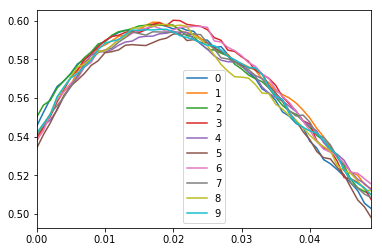

In [7]:
df.plot()
plt.show()

In [8]:
metric_multiplier_cub = df.idxmax().mean()
print("CUB, metric multiplier:", metric_multiplier_cub)

CUB, metric multiplier: 0.0185


## CUB dataset compute performance on test

In [9]:
# logdir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144337_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_test_split"
# filter = "*dataset=xian2017_cub*"

# logdir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190506_124706_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_test_split"
# filter = "*mi_weight=0.4*dataset=xian2017_cub*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split"
filter = "*embedding_size=256*dataset=xian2017_cub*"

results = evaluate_test_result(logdir=log_dir, 
                               filter=filter, metric_multiplier=metric_multiplier_cub)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Loading split trainval
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_trainval_xian2017.pkl


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=tes

INFO:root:Loaded cache in 6.263575 sec
INFO:root:Loading split test_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_test_seen_xian2017.pkl
INFO:root:Loaded cache in 2.705275 sec
INFO:root:Loading split test_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_test_unseen_xian2017.pkl
INFO:root:Loaded cache in 3.299156 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modalit

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 37.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.06it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 38.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.6846002337
STD unseen prototype:
62.3727735084


 50%|█████     | 3/6 [00:00<00:00,  8.47it/s]

STD seen prototype:
60.9499500949
STD unseen prototype:
61.1430727365
STD seen prototype:
60.7849976596
STD unseen prototype:
60.7850072241


 83%|████████▎ | 5/6 [00:00<00:00,  8.82it/s]

STD seen prototype:
60.7012734834
STD unseen prototype:
60.6318285889
STD seen prototype:
60.7236225006
STD unseen prototype:
60.6217106826


 33%|███▎      | 2/6 [00:00<00:00, 11.91it/s]

STD seen prototype:
60.7146539464
STD unseen prototype:
60.611437841
****************
SEEN images test
****************
STD seen prototype:
61.3522408005
STD unseen prototype:
63.6767626956
STD seen prototype:
59.9508360142
STD unseen prototype:
62.7818690085


 67%|██████▋   | 4/6 [00:00<00:00, 11.79it/s]

STD seen prototype:
59.7540440926
STD unseen prototype:
62.6789197923
STD seen prototype:
59.6590047801
STD unseen prototype:
62.6745603958
STD seen prototype:
59.6209375393
STD unseen prototype:
62.5850466694


100%|██████████| 6/6 [00:00<00:00, 11.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.6004384959
STD unseen prototype:
62.5884331201
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 37.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.43it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 40.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.2999865591
STD unseen prototype:
61.7970340357


 50%|█████     | 3/6 [00:00<00:00,  7.67it/s]

STD seen prototype:
60.3169278413
STD unseen prototype:
60.3627708452
STD seen prototype:
60.213456741
STD unseen prototype:
60.2033967378


 83%|████████▎ | 5/6 [00:00<00:00,  8.18it/s]

STD seen prototype:
60.1999899672
STD unseen prototype:
60.0591229554
STD seen prototype:
60.1278160058
STD unseen prototype:
60.0424780984


 33%|███▎      | 2/6 [00:00<00:00, 11.33it/s]

STD seen prototype:
60.1367362517
STD unseen prototype:
60.0154572811
****************
SEEN images test
****************
STD seen prototype:
60.7492170305
STD unseen prototype:
63.0145478256
STD seen prototype:
59.4560511719
STD unseen prototype:
62.2240924665


 67%|██████▋   | 4/6 [00:00<00:00, 11.38it/s]

STD seen prototype:
59.2396510266
STD unseen prototype:
62.1799337463
STD seen prototype:
59.1158740265
STD unseen prototype:
62.1014336866
STD seen prototype:
59.114262454
STD unseen prototype:
62.0787171914


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.0957260302
STD unseen prototype:
62.058113238
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 38.57it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.64it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 39.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.2794615071
STD unseen prototype:
61.6748383544


 50%|█████     | 3/6 [00:00<00:00,  8.25it/s]

STD seen prototype:
60.4089378481
STD unseen prototype:
60.4111261605
STD seen prototype:
60.3814346437
STD unseen prototype:
60.231446037


 83%|████████▎ | 5/6 [00:00<00:00,  8.65it/s]

STD seen prototype:
60.2375073518
STD unseen prototype:
60.1180245651
STD seen prototype:
60.2467863338
STD unseen prototype:
60.0850548721


 33%|███▎      | 2/6 [00:00<00:00, 11.58it/s]

STD seen prototype:
60.2294777964
STD unseen prototype:
60.0771364844
****************
SEEN images test
****************
STD seen prototype:
60.8297382786
STD unseen prototype:
63.17588643
STD seen prototype:
59.4261094142
STD unseen prototype:
62.3143630295


 67%|██████▋   | 4/6 [00:00<00:00, 11.68it/s]

STD seen prototype:
59.2406619146
STD unseen prototype:
62.1660410593
STD seen prototype:
59.1441089344
STD unseen prototype:
62.1329063679
STD seen prototype:
59.1156329606
STD unseen prototype:
62.0698136619


100%|██████████| 6/6 [00:00<00:00, 11.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.1062755455
STD unseen prototype:
62.0795715584
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 37.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.76it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 39.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.6995971227
STD unseen prototype:
61.9985640929


 50%|█████     | 3/6 [00:00<00:00,  8.26it/s]

STD seen prototype:
60.7881464787
STD unseen prototype:
60.7947813534
STD seen prototype:
60.6482705509
STD unseen prototype:
60.5763148108


 83%|████████▎ | 5/6 [00:00<00:00,  8.63it/s]

STD seen prototype:
60.5668229038
STD unseen prototype:
60.5400947232
STD seen prototype:
60.5619164069
STD unseen prototype:
60.4800557262


 33%|███▎      | 2/6 [00:00<00:00, 11.86it/s]

STD seen prototype:
60.5609064506
STD unseen prototype:
60.4519693079
****************
SEEN images test
****************
STD seen prototype:
61.0910525626
STD unseen prototype:
63.6118267459
STD seen prototype:
59.773571964
STD unseen prototype:
62.5055069326


 67%|██████▋   | 4/6 [00:00<00:00, 11.80it/s]

STD seen prototype:
59.5805595792
STD unseen prototype:
62.6114028862
STD seen prototype:
59.5275826132
STD unseen prototype:
62.4839872635
STD seen prototype:
59.4861106543
STD unseen prototype:
62.4771074721


100%|██████████| 6/6 [00:00<00:00, 11.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.4699942457
STD unseen prototype:
62.4691317657
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 37.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.31it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 40.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.7925318931
STD unseen prototype:
61.8589950244


 50%|█████     | 3/6 [00:00<00:00,  7.96it/s]

STD seen prototype:
60.7820117774
STD unseen prototype:
60.7159294276
STD seen prototype:
60.7052332976
STD unseen prototype:
60.5390197461


 83%|████████▎ | 5/6 [00:00<00:00,  8.02it/s]

STD seen prototype:
60.6299270902
STD unseen prototype:
60.4801684984
STD seen prototype:
60.5727384264
STD unseen prototype:
60.4720214274


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
60.5625121662
STD unseen prototype:
60.4420709438
****************
SEEN images test
****************
STD seen prototype:
61.1733856778
STD unseen prototype:
63.8189884554
STD seen prototype:
59.7788139046
STD unseen prototype:
62.6547544256


 83%|████████▎ | 5/6 [00:00<00:00, 10.50it/s]

STD seen prototype:
59.6625236462
STD unseen prototype:
62.6005794794
STD seen prototype:
59.5116419963
STD unseen prototype:
62.539559041
STD seen prototype:
59.4966289357
STD unseen prototype:
62.5075497954


100%|██████████| 6/6 [00:00<00:00, 10.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.4748759444
STD unseen prototype:
62.4852565826
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 38.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.7620873925
STD unseen prototype:
61.9355083254


 50%|█████     | 3/6 [00:00<00:00,  8.23it/s]

STD seen prototype:
60.629636128
STD unseen prototype:
60.5797736007
STD seen prototype:
60.5250121425
STD unseen prototype:
60.4558630342


 83%|████████▎ | 5/6 [00:00<00:00,  7.87it/s]

STD seen prototype:
60.4330547524
STD unseen prototype:
60.3815734401
STD seen prototype:
60.430387124
STD unseen prototype:
60.3053535803


 33%|███▎      | 2/6 [00:00<00:00, 11.53it/s]

STD seen prototype:
60.4171459211
STD unseen prototype:
60.2854547856
****************
SEEN images test
****************
STD seen prototype:
61.0794209132
STD unseen prototype:
63.6366443974
STD seen prototype:
59.6874545755
STD unseen prototype:
62.4776089241


 67%|██████▋   | 4/6 [00:00<00:00, 11.64it/s]

STD seen prototype:
59.4859912092
STD unseen prototype:
62.3310799363
STD seen prototype:
59.416777706
STD unseen prototype:
62.262077657
STD seen prototype:
59.3693737722
STD unseen prototype:
62.3311387181


100%|██████████| 6/6 [00:00<00:00, 11.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.352315471
STD unseen prototype:
62.3272172814
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 38.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.30it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 38.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.7470813075
STD unseen prototype:
62.1895272863


 50%|█████     | 3/6 [00:00<00:00,  8.41it/s]

STD seen prototype:
60.862741427
STD unseen prototype:
60.8062897467
STD seen prototype:
60.7654526198
STD unseen prototype:
60.7032152769


 83%|████████▎ | 5/6 [00:00<00:00,  8.60it/s]

STD seen prototype:
60.6793561458
STD unseen prototype:
60.5904490813
STD seen prototype:
60.653070453
STD unseen prototype:
60.5557560765


 33%|███▎      | 2/6 [00:00<00:00, 12.01it/s]

STD seen prototype:
60.65759131
STD unseen prototype:
60.5374295817
****************
SEEN images test
****************
STD seen prototype:
61.2300091112
STD unseen prototype:
63.6724887395
STD seen prototype:
59.8978922223
STD unseen prototype:
62.73411439


 67%|██████▋   | 4/6 [00:00<00:00, 11.83it/s]

STD seen prototype:
59.6585734583
STD unseen prototype:
62.6246678665
STD seen prototype:
59.5789898307
STD unseen prototype:
62.5722413953
STD seen prototype:
59.5491734068
STD unseen prototype:
62.5379848825


100%|██████████| 6/6 [00:00<00:00, 11.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.5408010123
STD unseen prototype:
62.5223886909
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 40.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.95it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 38.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
60.8393040172
STD unseen prototype:
61.3953639883


 50%|█████     | 3/6 [00:00<00:00,  8.05it/s]

STD seen prototype:
60.077108177
STD unseen prototype:
60.0764737749
STD seen prototype:
59.9373841739
STD unseen prototype:
59.8895531699


 83%|████████▎ | 5/6 [00:00<00:00,  8.46it/s]

STD seen prototype:
59.8715747952
STD unseen prototype:
59.7353535201
STD seen prototype:
59.876455095
STD unseen prototype:
59.7031664652


 33%|███▎      | 2/6 [00:00<00:00, 11.60it/s]

STD seen prototype:
59.8441816357
STD unseen prototype:
59.7010136725
****************
SEEN images test
****************
STD seen prototype:
60.4754258572
STD unseen prototype:
62.8354392166
STD seen prototype:
59.0829828762
STD unseen prototype:
61.943628861


 67%|██████▋   | 4/6 [00:00<00:00, 11.57it/s]

STD seen prototype:
58.9016743518
STD unseen prototype:
61.9296516655
STD seen prototype:
58.8093922382
STD unseen prototype:
61.7630513204
STD seen prototype:
58.7918177394
STD unseen prototype:
61.7420706904


100%|██████████| 6/6 [00:00<00:00, 11.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
58.7641933988
STD unseen prototype:
61.7451631148
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 38.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.3408248514
STD unseen prototype:
61.5487145822


 50%|█████     | 3/6 [00:00<00:00,  7.86it/s]

STD seen prototype:
60.3077571414
STD unseen prototype:
60.4401339666
STD seen prototype:
60.2682430285
STD unseen prototype:
60.2511255364


 83%|████████▎ | 5/6 [00:00<00:00,  8.05it/s]

STD seen prototype:
60.2267932485
STD unseen prototype:
60.1824129768
STD seen prototype:
60.2268835
STD unseen prototype:
60.1065161007


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
60.2088280205
STD unseen prototype:
60.092366977
****************
SEEN images test
****************
STD seen prototype:
60.7594393005
STD unseen prototype:
63.3072470808
STD seen prototype:
59.3790425508
STD unseen prototype:
62.3641740723


 67%|██████▋   | 4/6 [00:00<00:00, 10.61it/s]

STD seen prototype:
59.2045977263
STD unseen prototype:
62.1360776317
STD seen prototype:
59.1296270154
STD unseen prototype:
62.0938641222
STD seen prototype:
59.1113469911
STD unseen prototype:
62.0871465776


100%|██████████| 6/6 [00:00<00:00, 10.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
59.0769299011
STD unseen prototype:
62.0781364375
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
221it [00:05, 38.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.76it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 38.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feat

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
61.0602200354
STD unseen prototype:
61.542348111


 50%|█████     | 3/6 [00:00<00:00,  8.22it/s]

STD seen prototype:
60.0216264004
STD unseen prototype:
60.019992617
STD seen prototype:
59.978742243
STD unseen prototype:
59.8818370849


 83%|████████▎ | 5/6 [00:00<00:00,  8.42it/s]

STD seen prototype:
59.8893697012
STD unseen prototype:
59.7755143107
STD seen prototype:
59.8941299641
STD unseen prototype:
59.7379890761


 33%|███▎      | 2/6 [00:00<00:00, 11.47it/s]

STD seen prototype:
59.8812101416
STD unseen prototype:
59.7250607237
****************
SEEN images test
****************
STD seen prototype:
60.3531239529
STD unseen prototype:
62.7405130555
STD seen prototype:
59.0817163454
STD unseen prototype:
62.0294181662


 67%|██████▋   | 4/6 [00:00<00:00, 11.38it/s]

STD seen prototype:
58.9247625444
STD unseen prototype:
61.8410391571
STD seen prototype:
58.7918794269
STD unseen prototype:
61.6992538027
STD seen prototype:
58.7604465475
STD unseen prototype:
61.7174610205


100%|██████████| 6/6 [00:00<00:00, 11.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
58.7486103217
STD unseen prototype:
61.7322443723
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=256;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


In [10]:
dmean(results)

{'train_AP@50/#sentences10': 0.35861333333333334,
 'train_Top-1 Acc/#sentences10': 0.49251301847753898,
 'train_AP@50/#sentences50': 0.45993333333333331,
 'train_Top-1 Acc/#sentences50': 0.70870798573246618,
 'train_AP@50/#sentences100': 0.47827999999999998,
 'train_Top-1 Acc/#sentences100': 0.75439975045694818,
 'train_AP@50/#sentences200': 0.4873333333333334,
 'train_Top-1 Acc/#sentences200': 0.77658252585323206,
 'train_AP@50/#sentences400': 0.49198666666666668,
 'train_Top-1 Acc/#sentences400': 0.79369829256029689,
 'train_AP@50/#sentences1000': 0.49269333333333332,
 'train_Top-1 Acc/#sentences1000': 0.79503970306802196,
 'test_AP@50/#sentences10': 0.35796,
 'test_Top-1 Acc/#sentences10': 0.42895300625465049,
 'test_AP@50/#sentences50': 0.42143999999999993,
 'test_Top-1 Acc/#sentences50': 0.59660131237387382,
 'test_AP@50/#sentences100': 0.43016000000000004,
 'test_Top-1 Acc/#sentences100': 0.62989318178500409,
 'test_AP@50/#sentences200': 0.43696000000000002,
 'test_Top-1 Acc/#sen

## FLOWERS

In [11]:
log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144517_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_validation_split"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split"
filter = "*embedding_size=1024*dataset=xian2018_flowers*repeat=*"

df_flowers = crossvalidate_metric_multiplier(logdir=log_dir, filter=filter)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Loading split train
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_train_xian2018.pkl


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_siz

INFO:root:Loaded cache in 3.833158 sec
INFO:root:Loading split val_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_val_seen_xian2018.pkl
INFO:root:Loaded cache in 1.852973 sec
INFO:root:Loading split val_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_val_unseen_xian2018.pkl
INFO:root:Loaded cache in 1.824027 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_rep

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 34.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2461732459
STD unseen prototype:
88.1359669364
STD seen prototype:
87.2510691009
STD unseen prototype:
85.8007093064
STD seen prototype:
87.3266614858
STD unseen prototype:
85.6688270307


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1593874667
STD unseen prototype:
85.6560630023
STD seen prototype:
87.0571116215
STD unseen prototype:
85.4394776441
STD seen prototype:
87.1311724861
STD unseen prototype:
85.4777997562
****************
SEEN images test
****************
STD seen prototype:
84.9967429112
STD unseen prototype:
91.3594322235


 67%|██████▋   | 4/6 [00:00<00:00, 18.73it/s]

STD seen prototype:
82.8392659305
STD unseen prototype:
89.664762324
STD seen prototype:
82.5956698045
STD unseen prototype:
89.4875132137
STD seen prototype:
82.4038320983
STD unseen prototype:
89.2269119777
STD seen prototype:
82.2804533282
STD unseen prototype:
89.5023066267


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2579810805
STD unseen prototype:
89.4280986209
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8944509454
STD unseen prototype:
88.5974564742
STD seen prototype:
87.4746735163
STD unseen prototype:
86.1480738455
STD seen prototype:
87.4592939901
STD unseen prototype:
85.6843075988


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2806000905
STD unseen prototype:
85.6085811932
STD seen prototype:
87.2400193261
STD unseen prototype:
85.5433247456
STD seen prototype:
87.183801198
STD unseen prototype:
85.4874020675
****************
SEEN images test
****************
STD seen prototype:
85.1755129682
STD unseen prototype:
90.4257084018


 83%|████████▎ | 5/6 [00:00<00:00, 20.02it/s]

STD seen prototype:
82.9597123861
STD unseen prototype:
89.5460721444
STD seen prototype:
82.6171738588
STD unseen prototype:
89.5762616766
STD seen prototype:
82.3676793835
STD unseen prototype:
89.5601356097
STD seen prototype:
82.2776411115
STD unseen prototype:
89.4570654501


100%|██████████| 6/6 [00:00<00:00, 19.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2510973009
STD unseen prototype:
89.4285479435
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2916569966
STD unseen prototype:
87.7817929377
STD seen prototype:
87.7985066062
STD unseen prototype:
86.1012002346
STD seen prototype:
87.4045477235
STD unseen prototype:
85.6721436323


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3960702279
STD unseen prototype:
85.5184289786
STD seen prototype:
87.4325893982
STD unseen prototype:
85.5039085371
STD seen prototype:
87.1494449451
STD unseen prototype:
85.4840334104
****************
SEEN images test
****************
STD seen prototype:
85.2237531903
STD unseen prototype:
91.0313403656


 67%|██████▋   | 4/6 [00:00<00:00, 18.32it/s]

STD seen prototype:
83.0643702761
STD unseen prototype:
90.1539591415
STD seen prototype:
82.5641370767
STD unseen prototype:
89.7494311188
STD seen prototype:
82.4010815436
STD unseen prototype:
89.4170206525
STD seen prototype:
82.2897865278
STD unseen prototype:
89.3781104178


100%|██████████| 6/6 [00:00<00:00, 17.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2432198415
STD unseen prototype:
89.4282576085
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3738209349
STD unseen prototype:
88.0076734749
STD seen prototype:
87.174765383
STD unseen prototype:
85.9172507416
STD seen prototype:
87.1471544195
STD unseen prototype:
85.7456565558


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0230117434
STD unseen prototype:
85.634171109
STD seen prototype:
87.0536209238
STD unseen prototype:
85.4802981851
STD seen prototype:
87.1482883088
STD unseen prototype:
85.4807531366
****************
SEEN images test
****************
STD seen prototype:
85.2855665107
STD unseen prototype:
91.6005972324


 67%|██████▋   | 4/6 [00:00<00:00, 19.23it/s]

STD seen prototype:
82.987747281
STD unseen prototype:
89.7241330094
STD seen prototype:
82.6152097885
STD unseen prototype:
89.5511710036
STD seen prototype:
82.3206633996
STD unseen prototype:
89.3567139684
STD seen prototype:
82.3007141952
STD unseen prototype:
89.4881148191


100%|██████████| 6/6 [00:00<00:00, 18.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2513895102
STD unseen prototype:
89.4291708793
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7788321154
STD unseen prototype:
88.3061076249
STD seen prototype:
87.4766253278
STD unseen prototype:
86.1383868953
STD seen prototype:
87.1251153095
STD unseen prototype:
85.6420446881


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1589858905
STD unseen prototype:
85.6018448231
STD seen prototype:
87.2347190576
STD unseen prototype:
85.5064952788
STD seen prototype:
87.1477659193
STD unseen prototype:
85.4828346041
****************
SEEN images test
****************
STD seen prototype:
85.2635768223
STD unseen prototype:
92.5369560976


 83%|████████▎ | 5/6 [00:00<00:00, 19.37it/s]

STD seen prototype:
83.0418404378
STD unseen prototype:
89.4861331492
STD seen prototype:
82.5878202975
STD unseen prototype:
89.2569636148
STD seen prototype:
82.4295843991
STD unseen prototype:
89.6165142642
STD seen prototype:
82.2420619722
STD unseen prototype:
89.4363649827


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.262119815
STD unseen prototype:
89.428373391
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.37it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1494766507
STD unseen prototype:
87.5227801555
STD seen prototype:
87.0330439238
STD unseen prototype:
85.8409599541
STD seen prototype:
87.3459619291
STD unseen prototype:
85.622926281


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3198615087
STD unseen prototype:
85.5572181446
STD seen prototype:
87.0750191745
STD unseen prototype:
85.487543398
STD seen prototype:
87.1714001007
STD unseen prototype:
85.4856844954
****************
SEEN images test
****************
STD seen prototype:
85.4853564094
STD unseen prototype:
91.4222436425


 67%|██████▋   | 4/6 [00:00<00:00, 18.98it/s]

STD seen prototype:
82.8310775866
STD unseen prototype:
89.8757558495
STD seen prototype:
82.4915914617
STD unseen prototype:
89.2789514881
STD seen prototype:
82.4001309306
STD unseen prototype:
89.4165508143
STD seen prototype:
82.2918546831
STD unseen prototype:
89.5112623062


100%|██████████| 6/6 [00:00<00:00, 18.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2502418909
STD unseen prototype:
89.4284268492
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.638880388
STD unseen prototype:
88.1770315485
STD seen prototype:
87.8070719776
STD unseen prototype:
86.0061654309
STD seen prototype:
86.9693213176
STD unseen prototype:
85.929102564


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.156128816
STD unseen prototype:
85.5156972856
STD seen prototype:
87.2760792452
STD unseen prototype:
85.4749920099
STD seen prototype:
87.1522002213
STD unseen prototype:
85.4832455268
****************
SEEN images test
****************
STD seen prototype:
85.2652829198
STD unseen prototype:
91.7900956615


 67%|██████▋   | 4/6 [00:00<00:00, 19.51it/s]

STD seen prototype:
82.9427059836
STD unseen prototype:
89.3353540921
STD seen prototype:
82.5691422918
STD unseen prototype:
89.1283588328
STD seen prototype:
82.4276115479
STD unseen prototype:
89.2377015963
STD seen prototype:
82.3266693007
STD unseen prototype:
89.4229147371


100%|██████████| 6/6 [00:00<00:00, 18.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2533314641
STD unseen prototype:
89.4283627052
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2398283407
STD unseen prototype:
88.0449036424
STD seen prototype:
87.5018847246
STD unseen prototype:
85.7604013558
STD seen prototype:
87.367771441
STD unseen prototype:
85.7588726402


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3799628244
STD unseen prototype:
85.479978756
STD seen prototype:
87.2290263301
STD unseen prototype:
85.5251435414
STD seen prototype:
87.1196523345
STD unseen prototype:
85.4812585567
****************
SEEN images test
****************
STD seen prototype:
85.4780721364
STD unseen prototype:
90.8306207246


 67%|██████▋   | 4/6 [00:00<00:00, 18.65it/s]

STD seen prototype:
82.9540561392
STD unseen prototype:
89.1874131555
STD seen prototype:
82.5120979004
STD unseen prototype:
89.5247564888
STD seen prototype:
82.4088625133
STD unseen prototype:
89.6797854687
STD seen prototype:
82.2830638143
STD unseen prototype:
89.4095013018


100%|██████████| 6/6 [00:00<00:00, 18.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2597048915
STD unseen prototype:
89.4280367273
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.87it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9238095178
STD unseen prototype:
87.8324809918
STD seen prototype:
87.5004233651
STD unseen prototype:
86.1100050512
STD seen prototype:
87.2202721197
STD unseen prototype:
85.7632188673


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3501842575
STD unseen prototype:
85.481910363
STD seen prototype:
87.1625416682
STD unseen prototype:
85.5241431887
STD seen prototype:
87.1593631133
STD unseen prototype:
85.4845511277
****************
SEEN images test
****************
STD seen prototype:
85.2765531385
STD unseen prototype:
91.2563651319


 67%|██████▋   | 4/6 [00:00<00:00, 19.50it/s]

STD seen prototype:
83.0835666695
STD unseen prototype:
89.0960103689
STD seen prototype:
82.6107804611
STD unseen prototype:
89.4532338517
STD seen prototype:
82.4205723846
STD unseen prototype:
89.4330100403
STD seen prototype:
82.2909245762
STD unseen prototype:
89.3996673759


100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2492343732
STD unseen prototype:
89.4280671448
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1728738509
STD unseen prototype:
88.278949165
STD seen prototype:
87.453526201
STD unseen prototype:
85.8466682047
STD seen prototype:
87.1924694953
STD unseen prototype:
85.5800202507


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4855668204
STD unseen prototype:
85.4953019018
STD seen prototype:
87.2012354474
STD unseen prototype:
85.4583693165
STD seen prototype:
87.1588919799
STD unseen prototype:
85.4840531305
****************
SEEN images test
****************
STD seen prototype:
85.3664365203
STD unseen prototype:
91.8827111383


 67%|██████▋   | 4/6 [00:00<00:00, 18.74it/s]

STD seen prototype:
83.0258360522
STD unseen prototype:
89.0902619891
STD seen prototype:
82.5955122614
STD unseen prototype:
89.7247563451
STD seen prototype:
82.3940540514
STD unseen prototype:
89.4481075155
STD seen prototype:
82.307698671
STD unseen prototype:
89.4167788218


100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2638562661
STD unseen prototype:
89.427899263
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1544874212
STD unseen prototype:
87.9118171554
STD seen prototype:
87.3719768515
STD unseen prototype:
86.2149128827
STD seen prototype:
87.5314527753
STD unseen prototype:
85.6393006334


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8641492078
STD unseen prototype:
85.498895079
STD seen prototype:
87.0523643623
STD unseen prototype:
85.5187643718
STD seen prototype:
87.1495192861
STD unseen prototype:
85.4823284531
****************
SEEN images test
****************
STD seen prototype:
85.5500707023
STD unseen prototype:
90.9156618176


 83%|████████▎ | 5/6 [00:00<00:00, 20.08it/s]

STD seen prototype:
83.1552015105
STD unseen prototype:
89.3375175777
STD seen prototype:
82.6408279749
STD unseen prototype:
89.8041837531
STD seen prototype:
82.4021599866
STD unseen prototype:
89.1608534289
STD seen prototype:
82.264505775
STD unseen prototype:
89.4101302248


100%|██████████| 6/6 [00:00<00:00, 18.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2603133741
STD unseen prototype:
89.4281654004
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5704953383
STD unseen prototype:
87.5798771389
STD seen prototype:
87.1815378346
STD unseen prototype:
86.0358570176
STD seen prototype:
87.2550590722
STD unseen prototype:
85.6261563682


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9754449385
STD unseen prototype:
85.624666599
STD seen prototype:
87.0836705701
STD unseen prototype:
85.5517261914
STD seen prototype:
87.1144311784
STD unseen prototype:
85.4896623921
****************
SEEN images test
****************
STD seen prototype:
85.8135819945
STD unseen prototype:
91.1111250788


 67%|██████▋   | 4/6 [00:00<00:00, 19.33it/s]

STD seen prototype:
82.9517962372
STD unseen prototype:
89.9191238878
STD seen prototype:
82.5435921253
STD unseen prototype:
89.3455334944
STD seen prototype:
82.4252299855
STD unseen prototype:
89.4396135839
STD seen prototype:
82.3010295873
STD unseen prototype:
89.3776669719


100%|██████████| 6/6 [00:00<00:00, 18.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2652906016
STD unseen prototype:
89.4282658485
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8557092587
STD unseen prototype:
87.7664033105
STD seen prototype:
87.6634491836
STD unseen prototype:
86.0786727275
STD seen prototype:
87.4214089118
STD unseen prototype:
85.9005965712


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9810931942
STD unseen prototype:
85.5381849447
STD seen prototype:
87.2131488846
STD unseen prototype:
85.5105675879
STD seen prototype:
87.1223563131
STD unseen prototype:
85.4798520167
****************
SEEN images test
****************
STD seen prototype:
85.1583450438
STD unseen prototype:
91.2373612227


 83%|████████▎ | 5/6 [00:00<00:00, 20.18it/s]

STD seen prototype:
82.9862124021
STD unseen prototype:
89.9073260168
STD seen prototype:
82.5928400293
STD unseen prototype:
89.4373337609
STD seen prototype:
82.4593500996
STD unseen prototype:
89.4574993375
STD seen prototype:
82.2707849969
STD unseen prototype:
89.4518812961


100%|██████████| 6/6 [00:00<00:00, 19.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.266787932
STD unseen prototype:
89.4285216918
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3026998373
STD unseen prototype:
87.9635066397
STD seen prototype:
87.6524247561
STD unseen prototype:
85.9826911791
STD seen prototype:
87.3452937855
STD unseen prototype:
85.8515997612


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2421950026
STD unseen prototype:
85.5528819319
STD seen prototype:
87.2478223948
STD unseen prototype:
85.4753351378
STD seen prototype:
87.14267104
STD unseen prototype:
85.4789050039
****************
SEEN images test
****************
STD seen prototype:
85.3948184313
STD unseen prototype:
92.1338450908


 67%|██████▋   | 4/6 [00:00<00:00, 19.04it/s]

STD seen prototype:
82.8627563138
STD unseen prototype:
89.7929720206
STD seen prototype:
82.5630603024
STD unseen prototype:
89.7238858355
STD seen prototype:
82.4049611473
STD unseen prototype:
89.3113368167
STD seen prototype:
82.3007077859
STD unseen prototype:
89.4645430963


100%|██████████| 6/6 [00:00<00:00, 18.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2578214408
STD unseen prototype:
89.4287488218
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2719835081
STD unseen prototype:
88.1286312647
STD seen prototype:
87.8338871324
STD unseen prototype:
85.9940963138
STD seen prototype:
87.5478986353
STD unseen prototype:
85.7758689101


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1227490296
STD unseen prototype:
85.5734717534
STD seen prototype:
87.1552659161
STD unseen prototype:
85.5293965109
STD seen prototype:
87.1562943871
STD unseen prototype:
85.4745887641
****************
SEEN images test
****************
STD seen prototype:
85.5208634971
STD unseen prototype:
91.4973784687


 83%|████████▎ | 5/6 [00:00<00:00, 20.02it/s]

STD seen prototype:
82.8479645551
STD unseen prototype:
89.409939921
STD seen prototype:
82.6295727035
STD unseen prototype:
89.7961813229
STD seen prototype:
82.431817298
STD unseen prototype:
89.4292373306
STD seen prototype:
82.2986548238
STD unseen prototype:
89.397653764


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2453755032
STD unseen prototype:
89.4282316413
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6271008484
STD unseen prototype:
88.0315982206
STD seen prototype:
87.5185705797
STD unseen prototype:
85.9452740544
STD seen prototype:
86.9823844714
STD unseen prototype:
85.7571836477


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.174840564
STD unseen prototype:
85.4839376298
STD seen prototype:
87.1629267244
STD unseen prototype:
85.5453301624
STD seen prototype:
87.1474880083
STD unseen prototype:
85.4845067057
****************
SEEN images test
****************
STD seen prototype:
85.2463451697
STD unseen prototype:
90.9034659619


 83%|████████▎ | 5/6 [00:00<00:00, 19.26it/s]

STD seen prototype:
82.8604058454
STD unseen prototype:
90.2957157891
STD seen prototype:
82.5584621072
STD unseen prototype:
89.489319771
STD seen prototype:
82.3912594819
STD unseen prototype:
89.4740426954
STD seen prototype:
82.2923770592
STD unseen prototype:
89.4286561261


100%|██████████| 6/6 [00:00<00:00, 19.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2472127945
STD unseen prototype:
89.4283185904
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3536079954
STD unseen prototype:
88.2523736226
STD seen prototype:
87.8001154557
STD unseen prototype:
85.9337113549
STD seen prototype:
87.3627695462
STD unseen prototype:
85.8327620298


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1111251937
STD unseen prototype:
85.5738732692
STD seen prototype:
87.2490609575
STD unseen prototype:
85.503702918
STD seen prototype:
87.1438152801
STD unseen prototype:
85.4811053985
****************
SEEN images test
****************
STD seen prototype:
85.2859404335
STD unseen prototype:
90.7481949967


 67%|██████▋   | 4/6 [00:00<00:00, 18.39it/s]

STD seen prototype:
82.9425224585
STD unseen prototype:
90.0386382424
STD seen prototype:
82.5644289426
STD unseen prototype:
89.5868812407
STD seen prototype:
82.4214046374
STD unseen prototype:
89.3267812176
STD seen prototype:
82.3012457613
STD unseen prototype:
89.3524594504


100%|██████████| 6/6 [00:00<00:00, 17.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2372937208
STD unseen prototype:
89.4289811634
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3318512727
STD unseen prototype:
87.7849316521
STD seen prototype:
87.4323330287
STD unseen prototype:
85.9330765971
STD seen prototype:
87.2928101613
STD unseen prototype:
85.6177182595


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1101574712
STD unseen prototype:
85.5777588975
STD seen prototype:
87.1657567197
STD unseen prototype:
85.4998059464
STD seen prototype:
87.1412178526
STD unseen prototype:
85.482724542
****************
SEEN images test
****************
STD seen prototype:
85.1226591819
STD unseen prototype:
92.0069789232


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
83.0122663758
STD unseen prototype:
89.7028582621
STD seen prototype:
82.4319874591
STD unseen prototype:
89.8171333325
STD seen prototype:
82.3989673101
STD unseen prototype:
89.4344097153
STD seen prototype:
82.3086949297
STD unseen prototype:
89.4498224113


100%|██████████| 6/6 [00:00<00:00, 19.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2357799895
STD unseen prototype:
89.4285873572
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0532345774
STD unseen prototype:
87.9425937151
STD seen prototype:
87.7097361201
STD unseen prototype:
86.3049713954
STD seen prototype:
87.3045993842
STD unseen prototype:
85.5121842146


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4061562691
STD unseen prototype:
85.6064722071
STD seen prototype:
87.1307502185
STD unseen prototype:
85.492599673
STD seen prototype:
87.1444553313
STD unseen prototype:
85.4824978787
****************
SEEN images test
****************
STD seen prototype:
85.6293774477
STD unseen prototype:
90.8633027046


 67%|██████▋   | 4/6 [00:00<00:00, 18.42it/s]

STD seen prototype:
82.9360360561
STD unseen prototype:
88.9900297233
STD seen prototype:
82.6008940039
STD unseen prototype:
89.199519146
STD seen prototype:
82.4211689541
STD unseen prototype:
89.2686830942
STD seen prototype:
82.2681887892
STD unseen prototype:
89.3602724492


100%|██████████| 6/6 [00:00<00:00, 18.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2501218414
STD unseen prototype:
89.4286756155
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5273434888
STD unseen prototype:
87.7393985808
STD seen prototype:
87.3080088737
STD unseen prototype:
86.0562093747
STD seen prototype:
86.8873836
STD unseen prototype:
85.7400281141


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2009028584
STD unseen prototype:
85.7049120294
STD seen prototype:
87.2468883208
STD unseen prototype:
85.4372471551
STD seen prototype:
87.1527545703
STD unseen prototype:
85.4855518757
****************
SEEN images test
****************
STD seen prototype:
85.4393465954
STD unseen prototype:
92.0450785318


 67%|██████▋   | 4/6 [00:00<00:00, 19.48it/s]

STD seen prototype:
83.0521013185
STD unseen prototype:
89.5995752366
STD seen prototype:
82.5427767225
STD unseen prototype:
89.4269415845
STD seen prototype:
82.4224469495
STD unseen prototype:
89.3860997329
STD seen prototype:
82.2853725053
STD unseen prototype:
89.4345477119


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2409276864
STD unseen prototype:
89.4284702921
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.157067538
STD unseen prototype:
87.6715542456
STD seen prototype:
87.6735464492
STD unseen prototype:
86.2493517851
STD seen prototype:
87.7414501954
STD unseen prototype:
85.7158362818


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4703272576
STD unseen prototype:
85.6677146633
STD seen prototype:
87.3583995381
STD unseen prototype:
85.5554824595
STD seen prototype:
87.1410844904
STD unseen prototype:
85.491015983
****************
SEEN images test
****************
STD seen prototype:
85.0358513332
STD unseen prototype:
91.2458244484


 67%|██████▋   | 4/6 [00:00<00:00, 18.32it/s]

STD seen prototype:
82.9060389992
STD unseen prototype:
89.9181218334
STD seen prototype:
82.5447419028
STD unseen prototype:
89.2449942212
STD seen prototype:
82.4048245766
STD unseen prototype:
89.4813131245
STD seen prototype:
82.3317107701
STD unseen prototype:
89.5602562636


100%|██████████| 6/6 [00:00<00:00, 17.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2456883848
STD unseen prototype:
89.4293356672
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5394407835
STD unseen prototype:
87.5332094104
STD seen prototype:
87.3588661594
STD unseen prototype:
86.1146941108
STD seen prototype:
87.4786326098
STD unseen prototype:
85.6154118888


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3910091727
STD unseen prototype:
85.5642804231
STD seen prototype:
87.1355896413
STD unseen prototype:
85.5198653263
STD seen prototype:
87.1615663211
STD unseen prototype:
85.4804480467
****************
SEEN images test
****************
STD seen prototype:
85.1545695294
STD unseen prototype:
91.1465989103


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
82.8581972566
STD unseen prototype:
89.6752543618
STD seen prototype:
82.6959653382
STD unseen prototype:
89.3923492118
STD seen prototype:
82.4369106664
STD unseen prototype:
89.2231567244
STD seen prototype:
82.2849322367
STD unseen prototype:
89.4514905539


100%|██████████| 6/6 [00:00<00:00, 18.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2557623364
STD unseen prototype:
89.4287880828
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.316273982
STD unseen prototype:
88.8692632009
STD seen prototype:
87.7515184729
STD unseen prototype:
86.158570489
STD seen prototype:
87.0919335886
STD unseen prototype:
85.8669620561


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3733846855
STD unseen prototype:
85.5454322935
STD seen prototype:
87.2188573157
STD unseen prototype:
85.5184819636
STD seen prototype:
87.1403591544
STD unseen prototype:
85.4800667246
****************
SEEN images test
****************
STD seen prototype:
85.7224549979
STD unseen prototype:
92.0709527111


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
82.9602049601
STD unseen prototype:
89.8488939414
STD seen prototype:
82.6252420318
STD unseen prototype:
89.5791410625
STD seen prototype:
82.4429574765
STD unseen prototype:
89.3501167636
STD seen prototype:
82.2658072296
STD unseen prototype:
89.4795303824


100%|██████████| 6/6 [00:00<00:00, 18.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2523467529
STD unseen prototype:
89.42837569
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9197008422
STD unseen prototype:
88.1512685509
STD seen prototype:
87.5030906259
STD unseen prototype:
86.0074121379
STD seen prototype:
87.5168030978
STD unseen prototype:
85.8284504543


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.22490992
STD unseen prototype:
85.4156720838
STD seen prototype:
87.2624149753
STD unseen prototype:
85.5140307158
STD seen prototype:
87.1626279427
STD unseen prototype:
85.478340363
****************
SEEN images test
****************
STD seen prototype:
85.5749456438
STD unseen prototype:
90.7995673663


 67%|██████▋   | 4/6 [00:00<00:00, 19.33it/s]

STD seen prototype:
83.1325742165
STD unseen prototype:
89.9640199314
STD seen prototype:
82.5538140818
STD unseen prototype:
89.2783785923
STD seen prototype:
82.462856921
STD unseen prototype:
89.4049184092
STD seen prototype:
82.3170521239
STD unseen prototype:
89.4178489684


100%|██████████| 6/6 [00:00<00:00, 18.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2566379565
STD unseen prototype:
89.4281897493
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2063151604
STD unseen prototype:
87.7269280004
STD seen prototype:
87.7749434471
STD unseen prototype:
85.8130611918
STD seen prototype:
87.3363451028
STD unseen prototype:
85.6361415828


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2141167931
STD unseen prototype:
85.4766349295
STD seen prototype:
87.1658683792
STD unseen prototype:
85.5430169256
STD seen prototype:
87.1391783832
STD unseen prototype:
85.4820195508
****************
SEEN images test
****************
STD seen prototype:
85.450591619
STD unseen prototype:
91.1192271948


 50%|█████     | 3/6 [00:00<00:00, 20.19it/s]

STD seen prototype:
83.0063236388
STD unseen prototype:
89.4772473982
STD seen prototype:
82.6454005437
STD unseen prototype:
89.8585867051
STD seen prototype:
82.4316954255
STD unseen prototype:
89.3849453552
STD seen prototype:
82.3007341048
STD unseen prototype:
89.4705396479


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2578601204
STD unseen prototype:
89.4286554726
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6419587746
STD unseen prototype:
87.6370077683
STD seen prototype:
87.3117058767
STD unseen prototype:
85.8819777945
STD seen prototype:
87.4821860684
STD unseen prototype:
85.5870524416


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1145309934
STD unseen prototype:
85.6056374838
STD seen prototype:
87.129061075
STD unseen prototype:
85.4870888724
STD seen prototype:
87.1500232305
STD unseen prototype:
85.4806132704
****************
SEEN images test
****************
STD seen prototype:
85.3130154843
STD unseen prototype:
90.5491025922


 67%|██████▋   | 4/6 [00:00<00:00, 19.49it/s]

STD seen prototype:
82.89424868
STD unseen prototype:
89.8314833889
STD seen prototype:
82.6154818807
STD unseen prototype:
89.6306322025
STD seen prototype:
82.3522950915
STD unseen prototype:
89.211339746
STD seen prototype:
82.2899480388
STD unseen prototype:
89.4785697134


100%|██████████| 6/6 [00:00<00:00, 18.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2388075126
STD unseen prototype:
89.4286849991
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5989000183
STD unseen prototype:
88.309930098
STD seen prototype:
87.4811991388
STD unseen prototype:
85.9280671314
STD seen prototype:
86.9543735604
STD unseen prototype:
85.7121322788


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2329028074
STD unseen prototype:
85.6225700008
STD seen prototype:
87.179341179
STD unseen prototype:
85.4870989145
STD seen prototype:
87.1455475139
STD unseen prototype:
85.4809489411
****************
SEEN images test
****************
STD seen prototype:
85.6570689175
STD unseen prototype:
91.5926408325


 67%|██████▋   | 4/6 [00:00<00:00, 18.07it/s]

STD seen prototype:
82.9556395553
STD unseen prototype:
89.3418876025
STD seen prototype:
82.5165171873
STD unseen prototype:
89.5495137069
STD seen prototype:
82.4173807709
STD unseen prototype:
89.4896720763
STD seen prototype:
82.2990693601
STD unseen prototype:
89.3847059192


100%|██████████| 6/6 [00:00<00:00, 17.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2512465031
STD unseen prototype:
89.4295131667
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2144623528
STD unseen prototype:
87.8348940755
STD seen prototype:
87.5566211649
STD unseen prototype:
86.0771828292
STD seen prototype:
87.6395986869
STD unseen prototype:
85.6127928671


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0684430606
STD unseen prototype:
85.5892136674
STD seen prototype:
87.143912618
STD unseen prototype:
85.533586566
STD seen prototype:
87.1483218508
STD unseen prototype:
85.480127752
****************
SEEN images test
****************
STD seen prototype:
85.5289029974
STD unseen prototype:
90.1672385836


 67%|██████▋   | 4/6 [00:00<00:00, 19.48it/s]

STD seen prototype:
83.0117165303
STD unseen prototype:
89.4592341019
STD seen prototype:
82.5681141537
STD unseen prototype:
89.6368162256
STD seen prototype:
82.3645995524
STD unseen prototype:
89.3906127601
STD seen prototype:
82.2868381711
STD unseen prototype:
89.4396976249


100%|██████████| 6/6 [00:00<00:00, 19.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2534886116
STD unseen prototype:
89.4288860841
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7755509353
STD unseen prototype:
87.5691636052
STD seen prototype:
87.1679688096
STD unseen prototype:
86.089553152
STD seen prototype:
86.9912665972
STD unseen prototype:
85.7492536548


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1961493408
STD unseen prototype:
85.519511603
STD seen prototype:
87.1448929605
STD unseen prototype:
85.4742693182
STD seen prototype:
87.1471911483
STD unseen prototype:
85.4773082831
****************
SEEN images test
****************
STD seen prototype:
85.3412996283
STD unseen prototype:
90.3937636151


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
82.9107622111
STD unseen prototype:
89.7702843788
STD seen prototype:
82.4418524302
STD unseen prototype:
89.713408393
STD seen prototype:
82.3590771195
STD unseen prototype:
89.557333506
STD seen prototype:
82.2872552843
STD unseen prototype:
89.4489118329


100%|██████████| 6/6 [00:00<00:00, 19.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2485854018
STD unseen prototype:
89.4278405341
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2461695868
STD unseen prototype:
88.0993080317
STD seen prototype:
87.493630279
STD unseen prototype:
86.0638324349
STD seen prototype:
87.2165872839
STD unseen prototype:
85.6394768866


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2615288613
STD unseen prototype:
85.5456165392
STD seen prototype:
87.2549124818
STD unseen prototype:
85.4820592674
STD seen prototype:
87.1394192959
STD unseen prototype:
85.4843302046
****************
SEEN images test
****************
STD seen prototype:
85.7008743301
STD unseen prototype:
91.0251799483


 67%|██████▋   | 4/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
82.9913730342
STD unseen prototype:
89.2394105977
STD seen prototype:
82.5175562916
STD unseen prototype:
89.3580865553
STD seen prototype:
82.3746696784
STD unseen prototype:
89.4279010423
STD seen prototype:
82.3149793287
STD unseen prototype:
89.3632663257


100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2660149993
STD unseen prototype:
89.4283468822
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7341907921
STD unseen prototype:
88.0668567108
STD seen prototype:
87.1529931722
STD unseen prototype:
85.9747016135
STD seen prototype:
87.3274317755
STD unseen prototype:
85.8890446553


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1388048958
STD unseen prototype:
85.5503113641
STD seen prototype:
87.1272883544
STD unseen prototype:
85.5127262333
STD seen prototype:
87.159113786
STD unseen prototype:
85.4857755671
****************
SEEN images test
****************
STD seen prototype:
85.4515735976
STD unseen prototype:
90.8616592821


 67%|██████▋   | 4/6 [00:00<00:00, 19.18it/s]

STD seen prototype:
83.0634666036
STD unseen prototype:
89.5274470393
STD seen prototype:
82.5595013186
STD unseen prototype:
89.4277453385
STD seen prototype:
82.4036659144
STD unseen prototype:
89.3894763908
STD seen prototype:
82.3313702503
STD unseen prototype:
89.4662310912


100%|██████████| 6/6 [00:00<00:00, 18.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2496501231
STD unseen prototype:
89.4289079814
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4312216536
STD unseen prototype:
87.8235487123
STD seen prototype:
87.7361047134
STD unseen prototype:
86.224918111
STD seen prototype:
86.9580363329
STD unseen prototype:
85.6607548748


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2213270618
STD unseen prototype:
85.5807867299
STD seen prototype:
87.2229830426
STD unseen prototype:
85.541344494
STD seen prototype:
87.129129256
STD unseen prototype:
85.4843743878
****************
SEEN images test
****************
STD seen prototype:
85.2376639742
STD unseen prototype:
90.9211424591


 67%|██████▋   | 4/6 [00:00<00:00, 19.53it/s]

STD seen prototype:
83.1047517577
STD unseen prototype:
89.4824891372
STD seen prototype:
82.406906332
STD unseen prototype:
89.6940167126
STD seen prototype:
82.3239850694
STD unseen prototype:
89.2845762304
STD seen prototype:
82.2880481389
STD unseen prototype:
89.5044270099


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.248297891
STD unseen prototype:
89.4286130084
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4158913062
STD unseen prototype:
88.3113836038
STD seen prototype:
87.7269430235
STD unseen prototype:
86.0741665949
STD seen prototype:
87.4410550617
STD unseen prototype:
85.7526916711


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4022788958
STD unseen prototype:
85.4624014796
STD seen prototype:
87.1340826834
STD unseen prototype:
85.5371298981
STD seen prototype:
87.1608184772
STD unseen prototype:
85.4845334987
****************
SEEN images test
****************
STD seen prototype:
85.6068644271
STD unseen prototype:
91.8091613012


 83%|████████▎ | 5/6 [00:00<00:00, 20.07it/s]

STD seen prototype:
82.9962583951
STD unseen prototype:
89.4303615361
STD seen prototype:
82.5302096101
STD unseen prototype:
89.9301280658
STD seen prototype:
82.3628685514
STD unseen prototype:
89.5993178289
STD seen prototype:
82.2947000228
STD unseen prototype:
89.5322323379


100%|██████████| 6/6 [00:00<00:00, 19.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2474981012
STD unseen prototype:
89.4290623468
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7718036547
STD unseen prototype:
88.2459509845
STD seen prototype:
87.7505066948
STD unseen prototype:
85.9725452146
STD seen prototype:
86.8699255688
STD unseen prototype:
85.7601844394


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2014702159
STD unseen prototype:
85.5761706299
STD seen prototype:
87.1215193046
STD unseen prototype:
85.4738598225
STD seen prototype:
87.1302307191
STD unseen prototype:
85.4843166484
****************
SEEN images test
****************
STD seen prototype:
85.3046548203
STD unseen prototype:
91.6487340396


 83%|████████▎ | 5/6 [00:00<00:00, 18.84it/s]

STD seen prototype:
82.9773018636
STD unseen prototype:
89.6656734197
STD seen prototype:
82.5715021196
STD unseen prototype:
88.9164458991
STD seen prototype:
82.3410639304
STD unseen prototype:
89.4839336793
STD seen prototype:
82.2719946956
STD unseen prototype:
89.3723747856


100%|██████████| 6/6 [00:00<00:00, 18.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2579115868
STD unseen prototype:
89.4287322997
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7492186153
STD unseen prototype:
88.037784635
STD seen prototype:
87.5265892537
STD unseen prototype:
85.9441843701
STD seen prototype:
87.1927459343
STD unseen prototype:
85.8273598842


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.467168062
STD unseen prototype:
85.4951361312
STD seen prototype:
87.0101779915
STD unseen prototype:
85.5389726117
STD seen prototype:
87.1735301708
STD unseen prototype:
85.4795957183
****************
SEEN images test
****************
STD seen prototype:
85.1256418365
STD unseen prototype:
91.0596094037


 83%|████████▎ | 5/6 [00:00<00:00, 20.45it/s]

STD seen prototype:
82.9552452764
STD unseen prototype:
89.2071837516
STD seen prototype:
82.5269606484
STD unseen prototype:
89.5082033311
STD seen prototype:
82.412696578
STD unseen prototype:
89.4875884279
STD seen prototype:
82.3056726319
STD unseen prototype:
89.5106353235


100%|██████████| 6/6 [00:00<00:00, 19.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2651562399
STD unseen prototype:
89.4285207474
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8198330182
STD unseen prototype:
88.2535385887
STD seen prototype:
87.2219826683
STD unseen prototype:
86.1356149387
STD seen prototype:
87.2075345696
STD unseen prototype:
85.7192094264


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3001430486
STD unseen prototype:
85.5838087558
STD seen prototype:
87.1644597106
STD unseen prototype:
85.4695614622
STD seen prototype:
87.1474202232
STD unseen prototype:
85.4771372504
****************
SEEN images test
****************
STD seen prototype:
85.2684481398
STD unseen prototype:
92.21471967


 67%|██████▋   | 4/6 [00:00<00:00, 17.94it/s]

STD seen prototype:
82.9552231189
STD unseen prototype:
88.8803159541
STD seen prototype:
82.6065778081
STD unseen prototype:
89.1378181018
STD seen prototype:
82.4205631774
STD unseen prototype:
89.4029815546
STD seen prototype:
82.3292456711
STD unseen prototype:
89.4943736882


100%|██████████| 6/6 [00:00<00:00, 17.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2422520458
STD unseen prototype:
89.4280981915
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.87it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.819204249
STD unseen prototype:
88.6657807582
STD seen prototype:
87.8674948947
STD unseen prototype:
86.0335217573
STD seen prototype:
87.2493009069
STD unseen prototype:
85.5678521235


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5892474111
STD unseen prototype:
85.4778622115
STD seen prototype:
87.0835731272
STD unseen prototype:
85.491763682
STD seen prototype:
87.1159168767
STD unseen prototype:
85.4833270937
****************
SEEN images test
****************
STD seen prototype:
85.4400815131
STD unseen prototype:
90.4684526594


 67%|██████▋   | 4/6 [00:00<00:00, 19.58it/s]

STD seen prototype:
82.8754153234
STD unseen prototype:
89.7234210015
STD seen prototype:
82.477562688
STD unseen prototype:
89.395126021
STD seen prototype:
82.4339298344
STD unseen prototype:
89.6973388974
STD seen prototype:
82.2989526859
STD unseen prototype:
89.5391582451


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2588572106
STD unseen prototype:
89.4290474333
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5558470321
STD unseen prototype:
88.5236056655
STD seen prototype:
87.3039710863
STD unseen prototype:
85.8696613197
STD seen prototype:
87.4582195936
STD unseen prototype:
85.7830033079


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2521358775
STD unseen prototype:
85.5951982167
STD seen prototype:
87.2040757886
STD unseen prototype:
85.4787429792
STD seen prototype:
87.1672343533
STD unseen prototype:
85.4885501479
****************
SEEN images test
****************
STD seen prototype:
85.4462570138
STD unseen prototype:
90.1715538038


 67%|██████▋   | 4/6 [00:00<00:00, 19.24it/s]

STD seen prototype:
82.8200138442
STD unseen prototype:
90.1534983949
STD seen prototype:
82.5515479075
STD unseen prototype:
89.6039246398
STD seen prototype:
82.436200648
STD unseen prototype:
89.3603115224
STD seen prototype:
82.3090386773
STD unseen prototype:
89.4334980381


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2632086355
STD unseen prototype:
89.4284387806
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5548506961
STD unseen prototype:
88.1615231994
STD seen prototype:
87.3804557635
STD unseen prototype:
86.0019154127
STD seen prototype:
87.1736851748
STD unseen prototype:
85.745995816


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3857448897
STD unseen prototype:
85.6335569052
STD seen prototype:
87.127587961
STD unseen prototype:
85.4912762641
STD seen prototype:
87.162481192
STD unseen prototype:
85.4873334319
****************
SEEN images test
****************
STD seen prototype:
85.2089917094
STD unseen prototype:
90.6404336987


 83%|████████▎ | 5/6 [00:00<00:00, 20.03it/s]

STD seen prototype:
82.8531236167
STD unseen prototype:
89.8180043956
STD seen prototype:
82.6511764789
STD unseen prototype:
89.4957632548
STD seen prototype:
82.3407100903
STD unseen prototype:
89.6535951167
STD seen prototype:
82.2956983705
STD unseen prototype:
89.5065267618


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2506157331
STD unseen prototype:
89.4284611461
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7497845765
STD unseen prototype:
87.8970101517
STD seen prototype:
87.4741291117
STD unseen prototype:
85.9143727969
STD seen prototype:
87.3178133982
STD unseen prototype:
85.6683034299


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3975597817
STD unseen prototype:
85.5039750384
STD seen prototype:
87.2136210205
STD unseen prototype:
85.5283270444
STD seen prototype:
87.1333862463
STD unseen prototype:
85.4800580027
****************
SEEN images test
****************
STD seen prototype:
85.2985610806
STD unseen prototype:
92.0771180112


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
82.9871662845
STD unseen prototype:
89.4384362893
STD seen prototype:
82.6272470528
STD unseen prototype:
89.4440487805
STD seen prototype:
82.3752662347
STD unseen prototype:
89.5568458191
STD seen prototype:
82.2940884776
STD unseen prototype:
89.4284604897


100%|██████████| 6/6 [00:00<00:00, 18.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2412252281
STD unseen prototype:
89.42876664
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3675474487
STD unseen prototype:
87.297292947
STD seen prototype:
87.8074602879
STD unseen prototype:
85.8602660886
STD seen prototype:
87.3184290933
STD unseen prototype:
85.7949504545


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3461130443
STD unseen prototype:
85.5053070659
STD seen prototype:
87.2226635719
STD unseen prototype:
85.5148401906
STD seen prototype:
87.1155020374
STD unseen prototype:
85.4787190395
****************
SEEN images test
****************
STD seen prototype:
85.5293064187
STD unseen prototype:
90.1994354135


 67%|██████▋   | 4/6 [00:00<00:00, 19.64it/s]

STD seen prototype:
82.8138914273
STD unseen prototype:
89.2038394605
STD seen prototype:
82.6462714802
STD unseen prototype:
89.3281240628
STD seen prototype:
82.411186683
STD unseen prototype:
89.2482956854
STD seen prototype:
82.293537704
STD unseen prototype:
89.371280189


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2526900114
STD unseen prototype:
89.4284032897
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0621796449
STD unseen prototype:
88.4000535255
STD seen prototype:
87.3680121156
STD unseen prototype:
85.902853931
STD seen prototype:
87.6134810717
STD unseen prototype:
85.7666806369


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0656716236
STD unseen prototype:
85.594855675
STD seen prototype:
87.1585566119
STD unseen prototype:
85.4629056012
STD seen prototype:
87.1292784623
STD unseen prototype:
85.4823308741
****************
SEEN images test
****************
STD seen prototype:
85.2422937219
STD unseen prototype:
91.5311807785


 67%|██████▋   | 4/6 [00:00<00:00, 19.12it/s]

STD seen prototype:
82.8763386293
STD unseen prototype:
89.5913087403
STD seen prototype:
82.4815898552
STD unseen prototype:
89.463547502
STD seen prototype:
82.4227506112
STD unseen prototype:
89.2997270703
STD seen prototype:
82.3183773314
STD unseen prototype:
89.5049931383


100%|██████████| 6/6 [00:00<00:00, 18.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2583813358
STD unseen prototype:
89.4284387861
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2566728289
STD unseen prototype:
87.3612884972
STD seen prototype:
87.3902268055
STD unseen prototype:
86.2516131737
STD seen prototype:
87.2441832511
STD unseen prototype:
85.7368823194


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1194754317
STD unseen prototype:
85.5035915418
STD seen prototype:
87.1619885417
STD unseen prototype:
85.5116754853
STD seen prototype:
87.1556922831
STD unseen prototype:
85.4832650147
****************
SEEN images test
****************
STD seen prototype:
85.4244540623
STD unseen prototype:
90.849438768


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
83.000992584
STD unseen prototype:
89.4837761709
STD seen prototype:
82.6308007833
STD unseen prototype:
89.577458147
STD seen prototype:
82.4344571341
STD unseen prototype:
89.5364055466
STD seen prototype:
82.3030270453
STD unseen prototype:
89.3878248062


100%|██████████| 6/6 [00:00<00:00, 19.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2372493029
STD unseen prototype:
89.4278635174
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9966351737
STD unseen prototype:
88.0734199432
STD seen prototype:
87.2660524047
STD unseen prototype:
86.1022143587
STD seen prototype:
87.3612197578
STD unseen prototype:
85.6145828427


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0903427841
STD unseen prototype:
85.5427862434
STD seen prototype:
87.146235987
STD unseen prototype:
85.5079659475
STD seen prototype:
87.1445126291
STD unseen prototype:
85.4856061625
****************
SEEN images test
****************
STD seen prototype:
85.2437719433
STD unseen prototype:
90.7167372721


 83%|████████▎ | 5/6 [00:00<00:00, 20.05it/s]

STD seen prototype:
82.8823794149
STD unseen prototype:
89.7063750059
STD seen prototype:
82.6372211647
STD unseen prototype:
89.6231134751
STD seen prototype:
82.3966058092
STD unseen prototype:
89.3156908024
STD seen prototype:
82.3206511297
STD unseen prototype:
89.418125464


100%|██████████| 6/6 [00:00<00:00, 19.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2561835192
STD unseen prototype:
89.4280192022
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.85it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8421277967
STD unseen prototype:
87.8826470293
STD seen prototype:
87.4321725823
STD unseen prototype:
85.8623237885
STD seen prototype:
87.5695066435
STD unseen prototype:
85.831722999


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5178553059
STD unseen prototype:
85.6086525709
STD seen prototype:
87.1825378527
STD unseen prototype:
85.5109599624
STD seen prototype:
87.1635750617
STD unseen prototype:
85.4853888263
****************
SEEN images test
****************
STD seen prototype:
85.5205098317
STD unseen prototype:
91.5500725577


 83%|████████▎ | 5/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
82.9755676623
STD unseen prototype:
89.2503595859
STD seen prototype:
82.5495009744
STD unseen prototype:
89.5282036124
STD seen prototype:
82.4220885893
STD unseen prototype:
89.4012204878
STD seen prototype:
82.2721398601
STD unseen prototype:
89.4684673436


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2539229426
STD unseen prototype:
89.4285724207
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7833999012
STD unseen prototype:
88.0169319721
STD seen prototype:
87.3631510736
STD unseen prototype:
85.8948241801
STD seen prototype:
87.2945541426
STD unseen prototype:
85.702679777


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4214243998
STD unseen prototype:
85.5932989926
STD seen prototype:
87.2179244429
STD unseen prototype:
85.5378730712
STD seen prototype:
87.1415038414
STD unseen prototype:
85.47973104
****************
SEEN images test
****************
STD seen prototype:
85.2396882973
STD unseen prototype:
90.4863266062


 83%|████████▎ | 5/6 [00:00<00:00, 19.25it/s]

STD seen prototype:
83.040513696
STD unseen prototype:
89.5740999539
STD seen prototype:
82.6095922265
STD unseen prototype:
89.6964617396
STD seen prototype:
82.3703137033
STD unseen prototype:
89.5093233126
STD seen prototype:
82.2547319073
STD unseen prototype:
89.3708881457


100%|██████████| 6/6 [00:00<00:00, 18.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2538701525
STD unseen prototype:
89.4282657552
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2444720532
STD unseen prototype:
88.3668903192
STD seen prototype:
87.3437801317
STD unseen prototype:
86.0537829836
STD seen prototype:
87.6298420503
STD unseen prototype:
85.8467652041


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3831531106
STD unseen prototype:
85.5298078075
STD seen prototype:
87.2645740217
STD unseen prototype:
85.527820141
STD seen prototype:
87.1675403074
STD unseen prototype:
85.4858793992
****************
SEEN images test
****************
STD seen prototype:
85.3526156096
STD unseen prototype:
91.7926481787


 67%|██████▋   | 4/6 [00:00<00:00, 18.27it/s]

STD seen prototype:
83.1428534638
STD unseen prototype:
89.4579383139
STD seen prototype:
82.605387334
STD unseen prototype:
89.0886656125
STD seen prototype:
82.368487114
STD unseen prototype:
89.3674601313
STD seen prototype:
82.2777647429
STD unseen prototype:
89.5473801997


100%|██████████| 6/6 [00:00<00:00, 17.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.241392871
STD unseen prototype:
89.4281608562
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6226185302
STD unseen prototype:
88.1558455495
STD seen prototype:
87.439277882
STD unseen prototype:
86.0665594642
STD seen prototype:
87.4049814007
STD unseen prototype:
85.7175380349


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2930958345
STD unseen prototype:
85.5417558677
STD seen prototype:
87.1482451574
STD unseen prototype:
85.5426280272
STD seen prototype:
87.145183216
STD unseen prototype:
85.4830370086
****************
SEEN images test
****************
STD seen prototype:
85.0878319552
STD unseen prototype:
90.5182420828


 67%|██████▋   | 4/6 [00:00<00:00, 19.48it/s]

STD seen prototype:
83.0913225686
STD unseen prototype:
89.7565220743
STD seen prototype:
82.5813319589
STD unseen prototype:
89.313677412
STD seen prototype:
82.3615384761
STD unseen prototype:
89.4435113217
STD seen prototype:
82.267394112
STD unseen prototype:
89.4519974426


100%|██████████| 6/6 [00:00<00:00, 18.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2417679337
STD unseen prototype:
89.4284768956
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3342566459
STD unseen prototype:
87.7744871483
STD seen prototype:
87.6458869621
STD unseen prototype:
86.0827786825
STD seen prototype:
87.3180123146
STD unseen prototype:
85.6161052299


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9788538241
STD unseen prototype:
85.6009983929
STD seen prototype:
87.1491669983
STD unseen prototype:
85.4968702628
STD seen prototype:
87.1452829765
STD unseen prototype:
85.4844525919
****************
SEEN images test
****************
STD seen prototype:
85.7207207025
STD unseen prototype:
90.0882854405


 67%|██████▋   | 4/6 [00:00<00:00, 19.01it/s]

STD seen prototype:
83.0562486283
STD unseen prototype:
89.8484359085
STD seen prototype:
82.5492069687
STD unseen prototype:
89.4278246508
STD seen prototype:
82.3922772674
STD unseen prototype:
89.3804316028
STD seen prototype:
82.3298765208
STD unseen prototype:
89.4353529399


100%|██████████| 6/6 [00:00<00:00, 18.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2649357282
STD unseen prototype:
89.4285543219
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6596911795
STD unseen prototype:
87.1606315702
STD seen prototype:
87.2200128494
STD unseen prototype:
85.9249685193
STD seen prototype:
87.1020972251
STD unseen prototype:
85.7493716078


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3948430117
STD unseen prototype:
85.6104075696
STD seen prototype:
87.2510435322
STD unseen prototype:
85.4439384335
STD seen prototype:
87.1592662804
STD unseen prototype:
85.4823501447
****************
SEEN images test
****************
STD seen prototype:
85.021178662
STD unseen prototype:
90.7541574305


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
82.8682514952
STD unseen prototype:
89.5575357113
STD seen prototype:
82.5548345826
STD unseen prototype:
89.3623567731
STD seen prototype:
82.422514265
STD unseen prototype:
89.6161239536
STD seen prototype:
82.3290800183
STD unseen prototype:
89.4720194374


100%|██████████| 6/6 [00:00<00:00, 18.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2494285789
STD unseen prototype:
89.4292670542
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 38.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7098637712
STD unseen prototype:
88.6656510658
STD seen prototype:
88.3996693041
STD unseen prototype:
86.6101537614
STD seen prototype:
87.6965162205
STD unseen prototype:
86.0531379484


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5240035203
STD unseen prototype:
86.1041255491
STD seen prototype:
87.6484637766
STD unseen prototype:
85.9918994547
STD seen prototype:
87.6517998617
STD unseen prototype:
85.9520197215
****************
SEEN images test
****************
STD seen prototype:
85.8813522257
STD unseen prototype:
90.954733733


 67%|██████▋   | 4/6 [00:00<00:00, 18.93it/s]

STD seen prototype:
83.4221022275
STD unseen prototype:
89.9232071383
STD seen prototype:
83.0961990506
STD unseen prototype:
89.7272564729
STD seen prototype:
82.8927609827
STD unseen prototype:
89.9142115744
STD seen prototype:
82.8121826727
STD unseen prototype:
89.7832259557


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7645781478
STD unseen prototype:
89.7673001322
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4837577278
STD unseen prototype:
88.7507563476
STD seen prototype:
87.8993182138
STD unseen prototype:
86.4762633276
STD seen prototype:
87.8590510395
STD unseen prototype:
86.156788453


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7578012791
STD unseen prototype:
86.0736227509
STD seen prototype:
87.6033448603
STD unseen prototype:
86.0029347793
STD seen prototype:
87.6285948776
STD unseen prototype:
85.9553608923
****************
SEEN images test
****************
STD seen prototype:
86.0220422766
STD unseen prototype:
92.084037228


 67%|██████▋   | 4/6 [00:00<00:00, 18.47it/s]

STD seen prototype:
83.4650601961
STD unseen prototype:
89.4970124077
STD seen prototype:
83.1173320442
STD unseen prototype:
89.8684927517
STD seen prototype:
82.8871084362
STD unseen prototype:
89.7368100097
STD seen prototype:
82.8130853871
STD unseen prototype:
89.8061218304


100%|██████████| 6/6 [00:00<00:00, 17.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7650630404
STD unseen prototype:
89.7671202752
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.58it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7372814008
STD unseen prototype:
88.880599636
STD seen prototype:
87.7578204464
STD unseen prototype:
86.5255520075
STD seen prototype:
88.0808158243
STD unseen prototype:
86.0635379884


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7404068904
STD unseen prototype:
86.2372703006
STD seen prototype:
87.5943281028
STD unseen prototype:
85.9933079056
STD seen prototype:
87.6275611536
STD unseen prototype:
85.9554082001
****************
SEEN images test
****************
STD seen prototype:
85.9337177994
STD unseen prototype:
91.3684321216


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
83.4183632825
STD unseen prototype:
90.4051122639
STD seen prototype:
83.0519367368
STD unseen prototype:
89.7091606794
STD seen prototype:
82.8805238548
STD unseen prototype:
89.7678313195
STD seen prototype:
82.800522382
STD unseen prototype:
89.8122664348


100%|██████████| 6/6 [00:00<00:00, 19.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7693008898
STD unseen prototype:
89.7674438259
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4021079124
STD unseen prototype:
88.4374900128
STD seen prototype:
87.7376501849
STD unseen prototype:
86.2151314079
STD seen prototype:
87.9197252381
STD unseen prototype:
86.3106622387


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6616363484
STD unseen prototype:
86.0731760284
STD seen prototype:
87.5438502334
STD unseen prototype:
85.9671129469
STD seen prototype:
87.6561907159
STD unseen prototype:
85.9539220959
****************
SEEN images test
****************
STD seen prototype:
86.1349458229
STD unseen prototype:
91.7135531985


 83%|████████▎ | 5/6 [00:00<00:00, 20.80it/s]

STD seen prototype:
83.43434557
STD unseen prototype:
89.9742971107
STD seen prototype:
83.0842173173
STD unseen prototype:
89.844733636
STD seen prototype:
82.8737332955
STD unseen prototype:
89.9388521004
STD seen prototype:
82.7885778253
STD unseen prototype:
89.770736121


100%|██████████| 6/6 [00:00<00:00, 20.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7731646259
STD unseen prototype:
89.7671608816
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0402995718
STD unseen prototype:
88.4515520803
STD seen prototype:
87.4121326945
STD unseen prototype:
86.4114994666
STD seen prototype:
88.1605600793
STD unseen prototype:
86.42732756


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7589266878
STD unseen prototype:
85.996927134
STD seen prototype:
87.6982696989
STD unseen prototype:
86.0001405322
STD seen prototype:
87.6295565782
STD unseen prototype:
85.9538450047
****************
SEEN images test
****************
STD seen prototype:
85.6599145873
STD unseen prototype:
90.3327178532


 67%|██████▋   | 4/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
83.5265662026
STD unseen prototype:
90.1139936268
STD seen prototype:
83.1979845694
STD unseen prototype:
89.8950716144
STD seen prototype:
82.9291745507
STD unseen prototype:
89.8890088724
STD seen prototype:
82.8642882175
STD unseen prototype:
89.7538936869


100%|██████████| 6/6 [00:00<00:00, 18.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7563106984
STD unseen prototype:
89.7677962453
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.952616747
STD unseen prototype:
88.4031862479
STD seen prototype:
88.3645912053
STD unseen prototype:
86.5078110641
STD seen prototype:
87.9115928706
STD unseen prototype:
86.0269403282


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7598046539
STD unseen prototype:
86.1508456669
STD seen prototype:
87.6218276098
STD unseen prototype:
86.0102158756
STD seen prototype:
87.6178119363
STD unseen prototype:
85.951689574
****************
SEEN images test
****************
STD seen prototype:
86.1080030029
STD unseen prototype:
92.1185550928


 83%|████████▎ | 5/6 [00:00<00:00, 19.38it/s]

STD seen prototype:
83.3215449965
STD unseen prototype:
90.230577373
STD seen prototype:
83.1346510342
STD unseen prototype:
89.6989788403
STD seen prototype:
82.8739904174
STD unseen prototype:
89.7433652131
STD seen prototype:
82.832257607
STD unseen prototype:
89.7834152186


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7647875023
STD unseen prototype:
89.7670735215
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7332770379
STD unseen prototype:
88.8596219007
STD seen prototype:
87.586550737
STD unseen prototype:
86.4524593083
STD seen prototype:
87.9987912296
STD unseen prototype:
86.1676162191


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6607657116
STD unseen prototype:
86.0465718946
STD seen prototype:
87.7672675462
STD unseen prototype:
85.9054369721
STD seen prototype:
87.6281599875
STD unseen prototype:
85.9528540403
****************
SEEN images test
****************
STD seen prototype:
86.2476745685
STD unseen prototype:
91.1475582243


 67%|██████▋   | 4/6 [00:00<00:00, 18.44it/s]

STD seen prototype:
83.5920311886
STD unseen prototype:
89.9992498848
STD seen prototype:
83.0296731058
STD unseen prototype:
90.1225412578
STD seen prototype:
82.901812332
STD unseen prototype:
89.7455961736
STD seen prototype:
82.8230944807
STD unseen prototype:
89.8474905474


100%|██████████| 6/6 [00:00<00:00, 17.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7638626618
STD unseen prototype:
89.7668287579
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2980082154
STD unseen prototype:
88.297035966
STD seen prototype:
88.3103586269
STD unseen prototype:
86.4686477812
STD seen prototype:
87.8529490037
STD unseen prototype:
86.3536304326


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7322736969
STD unseen prototype:
86.0679021964
STD seen prototype:
87.7868021222
STD unseen prototype:
86.0099933658
STD seen prototype:
87.6419432441
STD unseen prototype:
85.9507775539
****************
SEEN images test
****************
STD seen prototype:
85.8777223897
STD unseen prototype:
92.4848788958


 67%|██████▋   | 4/6 [00:00<00:00, 18.51it/s]

STD seen prototype:
83.468491491
STD unseen prototype:
90.039777927
STD seen prototype:
83.0768057508
STD unseen prototype:
89.7525415477
STD seen prototype:
82.8322546508
STD unseen prototype:
89.9224998872
STD seen prototype:
82.8187994425
STD unseen prototype:
89.7360906991


100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7678392689
STD unseen prototype:
89.7679830383
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0746578704
STD unseen prototype:
88.4198546053
STD seen prototype:
87.6053141475
STD unseen prototype:
86.6424599106
STD seen prototype:
87.4547748733
STD unseen prototype:
86.1640783608


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6292850808
STD unseen prototype:
86.1071386672
STD seen prototype:
87.6753944952
STD unseen prototype:
86.0544270294
STD seen prototype:
87.6554556472
STD unseen prototype:
85.9544443235
****************
SEEN images test
****************
STD seen prototype:
86.1925178656
STD unseen prototype:
91.4991377204


 67%|██████▋   | 4/6 [00:00<00:00, 18.77it/s]

STD seen prototype:
83.5388090051
STD unseen prototype:
90.2505977098
STD seen prototype:
83.0134583073
STD unseen prototype:
89.6600667637
STD seen prototype:
82.8672815838
STD unseen prototype:
89.8590452507
STD seen prototype:
82.7908531735
STD unseen prototype:
89.7082435678


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7519242243
STD unseen prototype:
89.7669148979
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 19.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.741295421
STD unseen prototype:
88.8426950099
STD seen prototype:
87.6026984094
STD unseen prototype:
86.5192005148
STD seen prototype:
87.694101165
STD unseen prototype:
86.1380884302
STD seen prototype:
87.7128335164
STD unseen prototype:
85.9685371931


 50%|█████     | 3/6 [00:00<00:00, 22.26it/s]

STD seen prototype:
87.681525958
STD unseen prototype:
85.9738758305
STD seen prototype:
87.6592360869
STD unseen prototype:
85.9530250186
****************
SEEN images test
****************
STD seen prototype:
86.0026621328
STD unseen prototype:
92.0813421086
STD seen prototype:
83.3570755954
STD unseen prototype:
89.784602394
STD seen prototype:
83.071489677
STD unseen prototype:
89.5335005019


100%|██████████| 6/6 [00:00<00:00, 20.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9249978354
STD unseen prototype:
89.7680424734
STD seen prototype:
82.8143714433
STD unseen prototype:
89.8061055641
STD seen prototype:
82.7583242585
STD unseen prototype:
89.7675236262
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0544912125
STD unseen prototype:
88.2860234646
STD seen prototype:
88.2100184958
STD unseen prototype:
86.5455344325
STD seen prototype:
88.2268279076
STD unseen prototype:
86.2119951072


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.823988763
STD unseen prototype:
86.1441871658
STD seen prototype:
87.6288331868
STD unseen prototype:
85.9798515133
STD seen prototype:
87.6136599839
STD unseen prototype:
85.9557898961
****************
SEEN images test
****************
STD seen prototype:
86.1673793213
STD unseen prototype:
90.7050501491


 67%|██████▋   | 4/6 [00:00<00:00, 19.76it/s]

STD seen prototype:
83.6997023332
STD unseen prototype:
89.9525317968
STD seen prototype:
83.1052030309
STD unseen prototype:
90.0576384273
STD seen prototype:
82.9079469188
STD unseen prototype:
89.9245918426
STD seen prototype:
82.8257942733
STD unseen prototype:
89.8302025974


100%|██████████| 6/6 [00:00<00:00, 18.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.752836584
STD unseen prototype:
89.766839137
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1912300386
STD unseen prototype:
88.2284399083
STD seen prototype:
88.1096501355
STD unseen prototype:
86.6742044574
STD seen prototype:
87.7942910898
STD unseen prototype:
86.2461400568


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6362513595
STD unseen prototype:
86.0517603377
STD seen prototype:
87.7275216159
STD unseen prototype:
85.9288464234
STD seen prototype:
87.6144402166
STD unseen prototype:
85.9498353076
****************
SEEN images test
****************
STD seen prototype:
86.2581633747
STD unseen prototype:
91.4381036032


 67%|██████▋   | 4/6 [00:00<00:00, 19.84it/s]

STD seen prototype:
83.407423226
STD unseen prototype:
90.1856482017
STD seen prototype:
83.166265843
STD unseen prototype:
89.7110559009
STD seen prototype:
82.913396775
STD unseen prototype:
89.9239798641
STD seen prototype:
82.8186918494
STD unseen prototype:
89.6520611019


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7597149934
STD unseen prototype:
89.7673588224
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1622204222
STD unseen prototype:
88.2086598165
STD seen prototype:
88.2086220918
STD unseen prototype:
86.3689048102
STD seen prototype:
87.7467661191
STD unseen prototype:
86.1824816948


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4081211878
STD unseen prototype:
86.011197654
STD seen prototype:
87.6025647537
STD unseen prototype:
85.9552943112
STD seen prototype:
87.6653382063
STD unseen prototype:
85.9550541308
****************
SEEN images test
****************
STD seen prototype:
85.8908196896
STD unseen prototype:
91.4229210334


 67%|██████▋   | 4/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
83.5974696145
STD unseen prototype:
90.2774149434
STD seen prototype:
83.0427074428
STD unseen prototype:
89.7740376415
STD seen prototype:
82.9191911259
STD unseen prototype:
89.8920253489
STD seen prototype:
82.7900990456
STD unseen prototype:
89.7094718059


100%|██████████| 6/6 [00:00<00:00, 19.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7578462111
STD unseen prototype:
89.7670765757
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5254138329
STD unseen prototype:
88.2852886447
STD seen prototype:
88.2380297091
STD unseen prototype:
86.2787307284
STD seen prototype:
87.6828481541
STD unseen prototype:
86.2119623067


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6608063042
STD unseen prototype:
86.0423773416
STD seen prototype:
87.5631568822
STD unseen prototype:
85.8915708452
STD seen prototype:
87.6625613863
STD unseen prototype:
85.9507946421
****************
SEEN images test
****************
STD seen prototype:
85.92632074
STD unseen prototype:
90.486975267


 67%|██████▋   | 4/6 [00:00<00:00, 18.69it/s]

STD seen prototype:
83.5604892778
STD unseen prototype:
89.536340394
STD seen prototype:
83.0983070315
STD unseen prototype:
89.8869974049
STD seen prototype:
82.9135960385
STD unseen prototype:
89.6406769748
STD seen prototype:
82.8293606685
STD unseen prototype:
89.8183969896


100%|██████████| 6/6 [00:00<00:00, 18.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7495656264
STD unseen prototype:
89.767451766
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.694789709
STD unseen prototype:
88.4982839858
STD seen prototype:
87.8341274614
STD unseen prototype:
86.4483862353
STD seen prototype:
88.0750466465
STD unseen prototype:
86.3229090409


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.523580525
STD unseen prototype:
86.0605903984
STD seen prototype:
87.7325980741
STD unseen prototype:
85.9534261425
STD seen prototype:
87.6547822733
STD unseen prototype:
85.9530759026
****************
SEEN images test
****************
STD seen prototype:
86.0179043831
STD unseen prototype:
91.1643642252


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
83.2192393257
STD unseen prototype:
89.7029139699
STD seen prototype:
83.0771257407
STD unseen prototype:
89.9640150075
STD seen prototype:
82.8515375988
STD unseen prototype:
89.5987876949
STD seen prototype:
82.8150582694
STD unseen prototype:
89.6815620467


100%|██████████| 6/6 [00:00<00:00, 19.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7501060089
STD unseen prototype:
89.7668121398
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0615999328
STD unseen prototype:
88.9115415302
STD seen prototype:
87.9455155353
STD unseen prototype:
86.6037551055
STD seen prototype:
87.6182716105
STD unseen prototype:
86.195222816


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5618423699
STD unseen prototype:
85.9857941557
STD seen prototype:
87.740597196
STD unseen prototype:
85.9808369395
STD seen prototype:
87.6393867746
STD unseen prototype:
85.9557839758
****************
SEEN images test
****************
STD seen prototype:
85.9003002842
STD unseen prototype:
92.1983507931


 83%|████████▎ | 5/6 [00:00<00:00, 19.79it/s]

STD seen prototype:
83.4989137281
STD unseen prototype:
90.0791762319
STD seen prototype:
83.1100394391
STD unseen prototype:
89.8453781026
STD seen prototype:
82.8668184799
STD unseen prototype:
89.68452107
STD seen prototype:
82.82733558
STD unseen prototype:
89.8363167559


100%|██████████| 6/6 [00:00<00:00, 19.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.774383427
STD unseen prototype:
89.7674123738
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0243839842
STD unseen prototype:
88.4028293577
STD seen prototype:
88.127182644
STD unseen prototype:
86.4015410746
STD seen prototype:
87.831208562
STD unseen prototype:
86.1767328265


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9821463982
STD unseen prototype:
86.0671754818
STD seen prototype:
87.5837636137
STD unseen prototype:
85.9334524613
STD seen prototype:
87.6480385638
STD unseen prototype:
85.9544129352
****************
SEEN images test
****************
STD seen prototype:
85.6909134782
STD unseen prototype:
91.8071665284


 67%|██████▋   | 4/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
83.3096172584
STD unseen prototype:
90.244558878
STD seen prototype:
83.0262651968
STD unseen prototype:
90.2100490902
STD seen prototype:
82.9479138309
STD unseen prototype:
89.6611516885
STD seen prototype:
82.8092253586
STD unseen prototype:
89.8417663857


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.774991163
STD unseen prototype:
89.7675169124
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.86it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7021185368
STD unseen prototype:
88.8198504759
STD seen prototype:
87.9164722055
STD unseen prototype:
86.4718942076
STD seen prototype:
87.5735736436
STD unseen prototype:
86.0055340197


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5675609398
STD unseen prototype:
86.1102394963
STD seen prototype:
87.6702483523
STD unseen prototype:
85.9716008908
STD seen prototype:
87.6489465756
STD unseen prototype:
85.9541972368
****************
SEEN images test
****************
STD seen prototype:
85.4546699228
STD unseen prototype:
91.1265354419


 67%|██████▋   | 4/6 [00:00<00:00, 19.45it/s]

STD seen prototype:
83.6070528173
STD unseen prototype:
90.1109216184
STD seen prototype:
83.2120730123
STD unseen prototype:
89.6496332726
STD seen prototype:
82.9120694795
STD unseen prototype:
89.9408230341
STD seen prototype:
82.7793472386
STD unseen prototype:
89.8026689424


100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7636262223
STD unseen prototype:
89.7673925703
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5925380211
STD unseen prototype:
88.6193755376
STD seen prototype:
87.4850495498
STD unseen prototype:
86.5185153482
STD seen prototype:
87.2589504057
STD unseen prototype:
85.8554912415


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8173799792
STD unseen prototype:
85.9548885059
STD seen prototype:
87.7575945719
STD unseen prototype:
86.0079451262
STD seen prototype:
87.6366773221
STD unseen prototype:
85.9535982099
****************
SEEN images test
****************
STD seen prototype:
86.1654767216
STD unseen prototype:
90.7597075634


 67%|██████▋   | 4/6 [00:00<00:00, 19.09it/s]

STD seen prototype:
83.4934888861
STD unseen prototype:
90.0313857792
STD seen prototype:
83.2001286585
STD unseen prototype:
89.4828398354
STD seen prototype:
82.8682159737
STD unseen prototype:
89.805059835
STD seen prototype:
82.7846162003
STD unseen prototype:
89.7571665025


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7502373439
STD unseen prototype:
89.7670317654
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6550601526
STD unseen prototype:
88.6139071052
STD seen prototype:
88.0749123263
STD unseen prototype:
86.4371126124
STD seen prototype:
87.8653041027
STD unseen prototype:
86.2463470482


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.864217701
STD unseen prototype:
86.0869330323
STD seen prototype:
87.5497803823
STD unseen prototype:
85.9735019004
STD seen prototype:
87.6513590904
STD unseen prototype:
85.951607176
****************
SEEN images test
****************
STD seen prototype:
85.9484678061
STD unseen prototype:
91.0383376061


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
83.3902044206
STD unseen prototype:
90.5829176084
STD seen prototype:
83.0424318307
STD unseen prototype:
90.0458072757
STD seen prototype:
82.9138497117
STD unseen prototype:
89.9440528319
STD seen prototype:
82.8177555766
STD unseen prototype:
89.6992255063


100%|██████████| 6/6 [00:00<00:00, 18.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7651180416
STD unseen prototype:
89.767377372
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9117447877
STD unseen prototype:
88.6012028814
STD seen prototype:
87.9572045006
STD unseen prototype:
86.4681872222
STD seen prototype:
87.7079577006
STD unseen prototype:
86.2496810374


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6117695315
STD unseen prototype:
86.0354709095
STD seen prototype:
87.6264956901
STD unseen prototype:
86.016318006
STD seen prototype:
87.6512098699
STD unseen prototype:
85.956363904
****************
SEEN images test
****************
STD seen prototype:
85.9546682574
STD unseen prototype:
91.3830045748


 67%|██████▋   | 4/6 [00:00<00:00, 18.69it/s]

STD seen prototype:
83.5163176828
STD unseen prototype:
90.2304394013
STD seen prototype:
83.1645039203
STD unseen prototype:
90.0493556608
STD seen prototype:
82.8993089932
STD unseen prototype:
89.7356199247
STD seen prototype:
82.7919515047
STD unseen prototype:
89.7989748941


100%|██████████| 6/6 [00:00<00:00, 18.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7634075712
STD unseen prototype:
89.7672998918
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1493886714
STD unseen prototype:
88.6409474459
STD seen prototype:
87.771324844
STD unseen prototype:
86.4217598662
STD seen prototype:
87.664397418
STD unseen prototype:
86.2065411888


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7857468969
STD unseen prototype:
86.085653986
STD seen prototype:
87.6806908849
STD unseen prototype:
85.9793131259
STD seen prototype:
87.633833053
STD unseen prototype:
85.9514842666
****************
SEEN images test
****************
STD seen prototype:
86.0757671664
STD unseen prototype:
91.5845942026


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
83.4503366833
STD unseen prototype:
89.6868855364
STD seen prototype:
83.0814147675
STD unseen prototype:
89.5474922169
STD seen prototype:
82.8555006892
STD unseen prototype:
89.8679127236
STD seen prototype:
82.8329092464
STD unseen prototype:
89.7167351725


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7688201771
STD unseen prototype:
89.7673955873
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4404961139
STD unseen prototype:
88.9967890629
STD seen prototype:
87.7303871507
STD unseen prototype:
86.4270818134
STD seen prototype:
87.5703191983
STD unseen prototype:
86.2627159639


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7491303289
STD unseen prototype:
85.9343112011
STD seen prototype:
87.6319160882
STD unseen prototype:
85.9883235877
STD seen prototype:
87.6479784243
STD unseen prototype:
85.9537574907
****************
SEEN images test
****************
STD seen prototype:
86.1878588047
STD unseen prototype:
91.5354107417


 83%|████████▎ | 5/6 [00:00<00:00, 19.78it/s]

STD seen prototype:
83.4579772532
STD unseen prototype:
90.0879287603
STD seen prototype:
83.169131967
STD unseen prototype:
90.0417356389
STD seen prototype:
83.0016692431
STD unseen prototype:
89.6371739201
STD seen prototype:
82.7758300055
STD unseen prototype:
89.7547859798


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7524358324
STD unseen prototype:
89.7676057567
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8280627178
STD unseen prototype:
88.322646157
STD seen prototype:
87.8322345707
STD unseen prototype:
86.484501347
STD seen prototype:
87.5959507601
STD unseen prototype:
86.2152934871


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6446315075
STD unseen prototype:
86.0598064994
STD seen prototype:
87.7215483514
STD unseen prototype:
86.006342556
STD seen prototype:
87.6601757257
STD unseen prototype:
85.9461623754
****************
SEEN images test
****************
STD seen prototype:
85.9454515765
STD unseen prototype:
92.2523424416


 83%|████████▎ | 5/6 [00:00<00:00, 20.07it/s]

STD seen prototype:
83.5404441596
STD unseen prototype:
89.7329607579
STD seen prototype:
83.0844514163
STD unseen prototype:
89.7716615356
STD seen prototype:
82.9289583798
STD unseen prototype:
89.5409370991
STD seen prototype:
82.8055150529
STD unseen prototype:
89.7404228728


100%|██████████| 6/6 [00:00<00:00, 19.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7619233565
STD unseen prototype:
89.7677238191
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2692593427
STD unseen prototype:
88.9781106825
STD seen prototype:
88.2103695635
STD unseen prototype:
86.6122424899
STD seen prototype:
87.7881561797
STD unseen prototype:
86.1232880883


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6302802949
STD unseen prototype:
86.016405971
STD seen prototype:
87.6637512332
STD unseen prototype:
85.9699896286
STD seen prototype:
87.6333393562
STD unseen prototype:
85.9525056579
****************
SEEN images test
****************
STD seen prototype:
86.0197696182
STD unseen prototype:
90.7218450726


 67%|██████▋   | 4/6 [00:00<00:00, 18.63it/s]

STD seen prototype:
83.4046543672
STD unseen prototype:
90.0726429885
STD seen prototype:
83.1248867975
STD unseen prototype:
90.0710455124
STD seen prototype:
82.9045193844
STD unseen prototype:
89.9002979545
STD seen prototype:
82.8384019964
STD unseen prototype:
89.7798042355


100%|██████████| 6/6 [00:00<00:00, 18.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7667981547
STD unseen prototype:
89.7671034828
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6933422925
STD unseen prototype:
88.3262378975
STD seen prototype:
87.8380604154
STD unseen prototype:
86.4898082571
STD seen prototype:
87.8407293912
STD unseen prototype:
86.136140378


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8240012071
STD unseen prototype:
86.0546170431
STD seen prototype:
87.5770596504
STD unseen prototype:
85.9775259137
STD seen prototype:
87.6320097011
STD unseen prototype:
85.9563880538
****************
SEEN images test
****************
STD seen prototype:
85.5696699297
STD unseen prototype:
91.127755984


 67%|██████▋   | 4/6 [00:00<00:00, 18.87it/s]

STD seen prototype:
83.5558323954
STD unseen prototype:
89.7997074989
STD seen prototype:
83.0618648142
STD unseen prototype:
89.6633706066
STD seen prototype:
82.9383505564
STD unseen prototype:
89.9329305408
STD seen prototype:
82.8047974807
STD unseen prototype:
89.7774995426


100%|██████████| 6/6 [00:00<00:00, 18.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7616196512
STD unseen prototype:
89.7667185773
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3308900239
STD unseen prototype:
89.0790769845
STD seen prototype:
88.2365422831
STD unseen prototype:
86.2700099554
STD seen prototype:
87.7530786849
STD unseen prototype:
86.25579059


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7773814752
STD unseen prototype:
86.1554114393
STD seen prototype:
87.6409199766
STD unseen prototype:
85.982142425
STD seen prototype:
87.6451262621
STD unseen prototype:
85.9543550505
****************
SEEN images test
****************
STD seen prototype:
86.2458553744
STD unseen prototype:
91.7651962098


 67%|██████▋   | 4/6 [00:00<00:00, 19.24it/s]

STD seen prototype:
83.5870083662
STD unseen prototype:
90.7153690083
STD seen prototype:
83.1032913469
STD unseen prototype:
90.1824413339
STD seen prototype:
82.9151307884
STD unseen prototype:
90.0750773093
STD seen prototype:
82.7963500002
STD unseen prototype:
89.7409899255


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7599028248
STD unseen prototype:
89.7673129949
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6756404031
STD unseen prototype:
88.7650394007
STD seen prototype:
88.2001053141
STD unseen prototype:
86.389731972
STD seen prototype:
87.9706573195
STD unseen prototype:
86.1581777721


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6595291661
STD unseen prototype:
85.9793144033
STD seen prototype:
87.5342175081
STD unseen prototype:
85.9351348312
STD seen prototype:
87.6413992547
STD unseen prototype:
85.9475812128
****************
SEEN images test
****************
STD seen prototype:
85.8203369305
STD unseen prototype:
90.8747201655


 67%|██████▋   | 4/6 [00:00<00:00, 17.98it/s]

STD seen prototype:
83.4722339249
STD unseen prototype:
90.3359152666
STD seen prototype:
83.0551490413
STD unseen prototype:
89.5127436359
STD seen prototype:
82.9144373773
STD unseen prototype:
89.8212472921
STD seen prototype:
82.8169091503
STD unseen prototype:
89.8166818217


100%|██████████| 6/6 [00:00<00:00, 17.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.75696946
STD unseen prototype:
89.7673928746
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0346204474
STD unseen prototype:
88.8757317445
STD seen prototype:
87.9737589719
STD unseen prototype:
86.6652239731
STD seen prototype:
87.5319775047
STD unseen prototype:
86.4007351918


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7013084732
STD unseen prototype:
86.0374558129
STD seen prototype:
87.7643693223
STD unseen prototype:
85.9925504012
STD seen prototype:
87.6515362552
STD unseen prototype:
85.9569726989
****************
SEEN images test
****************
STD seen prototype:
85.9958641587
STD unseen prototype:
92.06952237


 67%|██████▋   | 4/6 [00:00<00:00, 18.08it/s]

STD seen prototype:
83.4019852792
STD unseen prototype:
90.6419266038
STD seen prototype:
83.0841026279
STD unseen prototype:
89.6009386258
STD seen prototype:
82.8812116942
STD unseen prototype:
89.8824196306
STD seen prototype:
82.7832848871
STD unseen prototype:
89.8062665129


100%|██████████| 6/6 [00:00<00:00, 17.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.758032456
STD unseen prototype:
89.7669564791
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4417829193
STD unseen prototype:
88.8044300075
STD seen prototype:
87.9880503877
STD unseen prototype:
86.2267890461
STD seen prototype:
87.8365652056
STD unseen prototype:
86.0943294395


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6564286688
STD unseen prototype:
86.0017057851
STD seen prototype:
87.6322682853
STD unseen prototype:
85.9346918559
STD seen prototype:
87.6525530138
STD unseen prototype:
85.9522017561
****************
SEEN images test
****************
STD seen prototype:
86.066872708
STD unseen prototype:
91.5370382789


 83%|████████▎ | 5/6 [00:00<00:00, 19.89it/s]

STD seen prototype:
83.5269933871
STD unseen prototype:
89.8658128894
STD seen prototype:
83.0745893619
STD unseen prototype:
89.6471085187
STD seen prototype:
82.892304602
STD unseen prototype:
89.6649455972
STD seen prototype:
82.8245962791
STD unseen prototype:
89.7697336944


100%|██████████| 6/6 [00:00<00:00, 19.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7617751695
STD unseen prototype:
89.7667321583
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8872476726
STD unseen prototype:
87.7555355612
STD seen prototype:
87.8713612789
STD unseen prototype:
86.5374515898
STD seen prototype:
87.7005988881
STD unseen prototype:
86.2310199364


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6493939823
STD unseen prototype:
86.1041127859
STD seen prototype:
87.7902333657
STD unseen prototype:
86.0272388063
STD seen prototype:
87.6550676569
STD unseen prototype:
85.9499078598
****************
SEEN images test
****************
STD seen prototype:
85.6330359389
STD unseen prototype:
91.116300982


 67%|██████▋   | 4/6 [00:00<00:00, 19.24it/s]

STD seen prototype:
83.3937328782
STD unseen prototype:
89.3796929771
STD seen prototype:
83.0729251362
STD unseen prototype:
89.8786388146
STD seen prototype:
82.8127196524
STD unseen prototype:
89.9855613519
STD seen prototype:
82.8330626856
STD unseen prototype:
89.781487475


100%|██████████| 6/6 [00:00<00:00, 18.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7514376045
STD unseen prototype:
89.7674007181
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1227242874
STD unseen prototype:
88.5211440897
STD seen prototype:
87.8537334367
STD unseen prototype:
86.2718616063
STD seen prototype:
87.6613532426
STD unseen prototype:
86.047529406


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7388788861
STD unseen prototype:
85.9974846108
STD seen prototype:
87.6946862315
STD unseen prototype:
85.9979463834
STD seen prototype:
87.6445263816
STD unseen prototype:
85.9567547146
****************
SEEN images test
****************
STD seen prototype:
85.9626752047
STD unseen prototype:
91.5425953109


 67%|██████▋   | 4/6 [00:00<00:00, 18.18it/s]

STD seen prototype:
83.4977387808
STD unseen prototype:
89.7757348009
STD seen prototype:
83.1043906954
STD unseen prototype:
90.081693982
STD seen prototype:
82.9244980463
STD unseen prototype:
89.8314699323
STD seen prototype:
82.7967244647
STD unseen prototype:
89.8289669188


100%|██████████| 6/6 [00:00<00:00, 17.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7755043018
STD unseen prototype:
89.7678796828
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7340146055
STD unseen prototype:
88.2773727901
STD seen prototype:
87.6104542804
STD unseen prototype:
86.3635761204
STD seen prototype:
87.7878295644
STD unseen prototype:
86.1762454429


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7737512781
STD unseen prototype:
86.0800515819
STD seen prototype:
87.687654823
STD unseen prototype:
85.9004808602
STD seen prototype:
87.6329345196
STD unseen prototype:
85.95267298
****************
SEEN images test
****************
STD seen prototype:
85.9539112634
STD unseen prototype:
90.92801137


 83%|████████▎ | 5/6 [00:00<00:00, 20.48it/s]

STD seen prototype:
83.5942533429
STD unseen prototype:
90.2221277775
STD seen prototype:
83.0258551033
STD unseen prototype:
89.7833991047
STD seen prototype:
82.9091335103
STD unseen prototype:
89.8694331241
STD seen prototype:
82.7682490208
STD unseen prototype:
89.8151438036


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7691471484
STD unseen prototype:
89.7674093636
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0755812417
STD unseen prototype:
88.6375978711
STD seen prototype:
88.1393726877
STD unseen prototype:
86.6774334652
STD seen prototype:
87.825501745
STD unseen prototype:
86.0703997898


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7561923473
STD unseen prototype:
86.0546819816
STD seen prototype:
87.7076032951
STD unseen prototype:
86.0151063388
STD seen prototype:
87.6161538369
STD unseen prototype:
85.9539942203
****************
SEEN images test
****************
STD seen prototype:
86.0044607302
STD unseen prototype:
90.5730600281


 67%|██████▋   | 4/6 [00:00<00:00, 18.60it/s]

STD seen prototype:
83.4733109084
STD unseen prototype:
90.2046262399
STD seen prototype:
83.0666502516
STD unseen prototype:
89.8384234805
STD seen prototype:
82.9484595517
STD unseen prototype:
89.7303772356
STD seen prototype:
82.7926066458
STD unseen prototype:
89.7894279464


100%|██████████| 6/6 [00:00<00:00, 18.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7638366864
STD unseen prototype:
89.7666769589
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1493962635
STD unseen prototype:
88.9623899769
STD seen prototype:
87.9556125824
STD unseen prototype:
86.4346086519
STD seen prototype:
87.9599552492
STD unseen prototype:
86.1689320868


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7440234978
STD unseen prototype:
86.0607034062
STD seen prototype:
87.6560054159
STD unseen prototype:
85.9664998109
STD seen prototype:
87.6264620628
STD unseen prototype:
85.955344697
****************
SEEN images test
****************
STD seen prototype:
85.7048057531
STD unseen prototype:
91.2993182771


 83%|████████▎ | 5/6 [00:00<00:00, 19.92it/s]

STD seen prototype:
83.461336047
STD unseen prototype:
90.1905318264
STD seen prototype:
83.1241557586
STD unseen prototype:
89.7468913977
STD seen prototype:
82.912172638
STD unseen prototype:
89.8734418879
STD seen prototype:
82.8070961306
STD unseen prototype:
89.795079478


100%|██████████| 6/6 [00:00<00:00, 19.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7485948312
STD unseen prototype:
89.7676209689
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8359672456
STD unseen prototype:
88.8206408689
STD seen prototype:
87.9206383194
STD unseen prototype:
86.508768647
STD seen prototype:
87.8627993526
STD unseen prototype:
86.1082233684


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8486716495
STD unseen prototype:
86.0491764655
STD seen prototype:
87.6283004935
STD unseen prototype:
85.9704244356
STD seen prototype:
87.6686598708
STD unseen prototype:
85.9541409996
****************
SEEN images test
****************
STD seen prototype:
85.906757479
STD unseen prototype:
92.1627255118


 67%|██████▋   | 4/6 [00:00<00:00, 19.46it/s]

STD seen prototype:
83.3892947042
STD unseen prototype:
89.5674348735
STD seen prototype:
83.1790582895
STD unseen prototype:
89.3339060232
STD seen prototype:
82.8681058824
STD unseen prototype:
89.841864674
STD seen prototype:
82.7995133198
STD unseen prototype:
89.7964605152


100%|██████████| 6/6 [00:00<00:00, 19.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7557763756
STD unseen prototype:
89.7677570385
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3898672274
STD unseen prototype:
88.2039602239
STD seen prototype:
88.2014678251
STD unseen prototype:
86.7528280328
STD seen prototype:
87.5738253733
STD unseen prototype:
86.1579370361


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6751398298
STD unseen prototype:
85.9321141425
STD seen prototype:
87.7103192309
STD unseen prototype:
85.9687689162
STD seen prototype:
87.6535427342
STD unseen prototype:
85.9523146372
****************
SEEN images test
****************
STD seen prototype:
85.7558853337
STD unseen prototype:
91.6998661636


 83%|████████▎ | 5/6 [00:00<00:00, 19.68it/s]

STD seen prototype:
83.4734948442
STD unseen prototype:
90.3450151383
STD seen prototype:
83.1692339405
STD unseen prototype:
89.8829712255
STD seen prototype:
82.9419785703
STD unseen prototype:
89.8315947151
STD seen prototype:
82.7844806644
STD unseen prototype:
89.8618579751


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7551925509
STD unseen prototype:
89.7669825487
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2347244889
STD unseen prototype:
88.8813738179
STD seen prototype:
88.0911202939
STD unseen prototype:
86.2969698976
STD seen prototype:
87.8307337569
STD unseen prototype:
86.2791421999


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5100378109
STD unseen prototype:
86.091209486
STD seen prototype:
87.6982072801
STD unseen prototype:
85.9925738023
STD seen prototype:
87.6579823668
STD unseen prototype:
85.9496904491
****************
SEEN images test
****************
STD seen prototype:
86.1445633238
STD unseen prototype:
91.4291222637


 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]

STD seen prototype:
83.3943382567
STD unseen prototype:
90.3884002768
STD seen prototype:
83.1614775332
STD unseen prototype:
89.7400194097
STD seen prototype:
82.8991223177
STD unseen prototype:
89.642890113
STD seen prototype:
82.8111922953
STD unseen prototype:
89.7956767696


100%|██████████| 6/6 [00:00<00:00, 19.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7526914576
STD unseen prototype:
89.7678734096
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.699081923
STD unseen prototype:
88.21715666
STD seen prototype:
87.6676547556
STD unseen prototype:
86.6588334548
STD seen prototype:
87.6141343212
STD unseen prototype:
86.1228850909


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4472759695
STD unseen prototype:
86.0381752514
STD seen prototype:
87.5993670323
STD unseen prototype:
85.9967020168
STD seen prototype:
87.6481773789
STD unseen prototype:
85.9512056249
****************
SEEN images test
****************
STD seen prototype:
85.9910864241
STD unseen prototype:
90.8847789137


 67%|██████▋   | 4/6 [00:00<00:00, 18.60it/s]

STD seen prototype:
83.5348505721
STD unseen prototype:
89.8554270233
STD seen prototype:
83.0453164571
STD unseen prototype:
89.6574403758
STD seen prototype:
82.8331677226
STD unseen prototype:
89.6834778888
STD seen prototype:
82.8350064051
STD unseen prototype:
89.8182602718


100%|██████████| 6/6 [00:00<00:00, 18.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7628978724
STD unseen prototype:
89.7678050598
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0447171517
STD unseen prototype:
88.3699180359
STD seen prototype:
87.4537946881
STD unseen prototype:
86.535557324
STD seen prototype:
87.8001994613
STD unseen prototype:
86.3007019508


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6531531428
STD unseen prototype:
86.0884856657
STD seen prototype:
87.6691808725
STD unseen prototype:
85.9993784264
STD seen prototype:
87.6588147223
STD unseen prototype:
85.9551118302
****************
SEEN images test
****************
STD seen prototype:
85.8048572329
STD unseen prototype:
91.6669958606


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
83.3882745982
STD unseen prototype:
90.3925775132
STD seen prototype:
83.1530178739
STD unseen prototype:
89.6614300784
STD seen prototype:
82.8615949114
STD unseen prototype:
89.7902015141
STD seen prototype:
82.8141355821
STD unseen prototype:
89.7521968727


100%|██████████| 6/6 [00:00<00:00, 18.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7602002019
STD unseen prototype:
89.7675558736
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.85it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2748034968
STD unseen prototype:
88.4096111354
STD seen prototype:
87.7463199275
STD unseen prototype:
86.4475398562
STD seen prototype:
87.6334642986
STD unseen prototype:
86.2267050311


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7104687667
STD unseen prototype:
85.9406409024
STD seen prototype:
87.6573688127
STD unseen prototype:
85.9397729703
STD seen prototype:
87.6497965279
STD unseen prototype:
85.9524925237
****************
SEEN images test
****************
STD seen prototype:
85.871166486
STD unseen prototype:
90.9991014625


 67%|██████▋   | 4/6 [00:00<00:00, 18.35it/s]

STD seen prototype:
83.4064773771
STD unseen prototype:
89.7176684542
STD seen prototype:
83.0746823754
STD unseen prototype:
89.8118559585
STD seen prototype:
82.887717769
STD unseen prototype:
89.9791013817
STD seen prototype:
82.8238934538
STD unseen prototype:
89.7543406905


100%|██████████| 6/6 [00:00<00:00, 18.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7548668728
STD unseen prototype:
89.7669548961
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7083099664
STD unseen prototype:
87.9204287258
STD seen prototype:
88.0549815821
STD unseen prototype:
86.459600447
STD seen prototype:
87.9643831132
STD unseen prototype:
86.1371876161


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.832828284
STD unseen prototype:
86.1526949163
STD seen prototype:
87.6481197349
STD unseen prototype:
85.996474869
STD seen prototype:
87.6620952105
STD unseen prototype:
85.9510930684
****************
SEEN images test
****************
STD seen prototype:
85.450897032
STD unseen prototype:
92.5653664871


 67%|██████▋   | 4/6 [00:00<00:00, 18.54it/s]

STD seen prototype:
83.4346125362
STD unseen prototype:
89.7877028954
STD seen prototype:
83.0743498839
STD unseen prototype:
90.1898261689
STD seen prototype:
82.9008195296
STD unseen prototype:
89.7776681484
STD seen prototype:
82.8245870084
STD unseen prototype:
89.751189531


100%|██████████| 6/6 [00:00<00:00, 17.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7577757767
STD unseen prototype:
89.7674891032
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1078287491
STD unseen prototype:
88.4908287261
STD seen prototype:
88.2958849188
STD unseen prototype:
86.3268981587
STD seen prototype:
87.7473176897
STD unseen prototype:
86.1247212384


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.806094633
STD unseen prototype:
86.0760991906
STD seen prototype:
87.7042068434
STD unseen prototype:
85.9808639225
STD seen prototype:
87.6500153235
STD unseen prototype:
85.9548427175
****************
SEEN images test
****************
STD seen prototype:
85.7123520178
STD unseen prototype:
90.3590983005


 67%|██████▋   | 4/6 [00:00<00:00, 18.13it/s]

STD seen prototype:
83.4650238227
STD unseen prototype:
90.1735602754
STD seen prototype:
83.1830868487
STD unseen prototype:
89.8152397394
STD seen prototype:
82.8908802409
STD unseen prototype:
89.721624376
STD seen prototype:
82.8309562957
STD unseen prototype:
89.7417154454


100%|██████████| 6/6 [00:00<00:00, 17.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7521998438
STD unseen prototype:
89.7674448595
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.78it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0343371715
STD unseen prototype:
88.243424165
STD seen prototype:
87.4391412051
STD unseen prototype:
86.4556071273
STD seen prototype:
87.8159542447
STD unseen prototype:
86.2588553782


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5284144796
STD unseen prototype:
86.1308480555
STD seen prototype:
87.613357488
STD unseen prototype:
85.927851726
STD seen prototype:
87.6288674521
STD unseen prototype:
85.9522292857
****************
SEEN images test
****************
STD seen prototype:
86.1076195442
STD unseen prototype:
91.3885218045


 67%|██████▋   | 4/6 [00:00<00:00, 19.51it/s]

STD seen prototype:
83.6881023749
STD unseen prototype:
89.7780228763
STD seen prototype:
83.0889144988
STD unseen prototype:
89.6102841089
STD seen prototype:
82.9447635732
STD unseen prototype:
89.7031038999
STD seen prototype:
82.8179120568
STD unseen prototype:
89.7573308377


100%|██████████| 6/6 [00:00<00:00, 18.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7703959118
STD unseen prototype:
89.767546325
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7001915747
STD unseen prototype:
88.4453758392
STD seen prototype:
87.8101761297
STD unseen prototype:
86.5591301537
STD seen prototype:
87.7912709361
STD unseen prototype:
86.1286136991


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.728710607
STD unseen prototype:
86.0266609823
STD seen prototype:
87.6512265516
STD unseen prototype:
86.0182324274
STD seen prototype:
87.6567591707
STD unseen prototype:
85.9529704916
****************
SEEN images test
****************
STD seen prototype:
85.7785285052
STD unseen prototype:
91.0000223696


 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]

STD seen prototype:
83.6187209057
STD unseen prototype:
89.8766409549
STD seen prototype:
83.124650106
STD unseen prototype:
89.8306795368
STD seen prototype:
82.9157383234
STD unseen prototype:
89.591111656
STD seen prototype:
82.8048711269
STD unseen prototype:
89.772042541


100%|██████████| 6/6 [00:00<00:00, 19.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7539977538
STD unseen prototype:
89.7679474838
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0695837896
STD unseen prototype:
88.5620867983
STD seen prototype:
88.1108548545
STD unseen prototype:
86.5938554791
STD seen prototype:
87.8112587916
STD unseen prototype:
85.8545645389


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6537296179
STD unseen prototype:
86.074836582
STD seen prototype:
87.7295471613
STD unseen prototype:
85.9237252657
STD seen prototype:
87.6457042759
STD unseen prototype:
85.949367989
****************
SEEN images test
****************
STD seen prototype:
86.2036093454
STD unseen prototype:
91.8308106959


 67%|██████▋   | 4/6 [00:00<00:00, 19.71it/s]

STD seen prototype:
83.5955531178
STD unseen prototype:
90.2548660495
STD seen prototype:
83.0056868409
STD unseen prototype:
89.5983018768
STD seen prototype:
82.933711968
STD unseen prototype:
89.6390566338
STD seen prototype:
82.7916563667
STD unseen prototype:
89.7618066511


100%|██████████| 6/6 [00:00<00:00, 19.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7783941668
STD unseen prototype:
89.7671851851
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2336361287
STD unseen prototype:
88.8534533313
STD seen prototype:
88.0721595052
STD unseen prototype:
86.4540535103
STD seen prototype:
87.9087189909
STD unseen prototype:
86.192181012


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7634388155
STD unseen prototype:
85.9714720604
STD seen prototype:
87.549635007
STD unseen prototype:
85.9910564259
STD seen prototype:
87.6292340225
STD unseen prototype:
85.9516691639
****************
SEEN images test
****************
STD seen prototype:
85.4413716972
STD unseen prototype:
92.2745426676


 67%|██████▋   | 4/6 [00:00<00:00, 19.89it/s]

STD seen prototype:
83.4762100304
STD unseen prototype:
90.2752259973
STD seen prototype:
83.0108844912
STD unseen prototype:
90.1696206594
STD seen prototype:
82.9179608525
STD unseen prototype:
89.7901635681
STD seen prototype:
82.8546544776
STD unseen prototype:
89.7299028036


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7475891654
STD unseen prototype:
89.7667180448
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1021381033
STD unseen prototype:
88.8043121614
STD seen prototype:
88.115688524
STD unseen prototype:
86.5459391751
STD seen prototype:
87.7311786286
STD unseen prototype:
86.2634382092


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7742539522
STD unseen prototype:
86.0332450304
STD seen prototype:
87.7742134035
STD unseen prototype:
85.9923731478
STD seen prototype:
87.630569069
STD unseen prototype:
85.9571565976
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
85.940607345
STD unseen prototype:
91.538387079
STD seen prototype:
83.4314655443
STD unseen prototype:
89.9044916895
STD seen prototype:
83.0443134258
STD unseen prototype:
90.1065554466
STD seen prototype:
82.9573373498
STD unseen prototype:
89.8247494366


100%|██████████| 6/6 [00:00<00:00, 18.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7946301433
STD unseen prototype:
89.8703205522
STD seen prototype:
82.7633185739
STD unseen prototype:
89.7675111759
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.346878922
STD unseen prototype:
88.2925699353
STD seen prototype:
87.9080478847
STD unseen prototype:
86.5975305056
STD seen prototype:
87.7238488435
STD unseen prototype:
86.2045086023


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.636804622
STD unseen prototype:
86.0995997458
STD seen prototype:
87.612011902
STD unseen prototype:
85.975746813
STD seen prototype:
87.6519191722
STD unseen prototype:
85.9581098961
****************
SEEN images test
****************
STD seen prototype:
85.9515095303
STD unseen prototype:
91.6030809597


 67%|██████▋   | 4/6 [00:00<00:00, 18.97it/s]

STD seen prototype:
83.5408042389
STD unseen prototype:
89.6423562648
STD seen prototype:
83.1405575306
STD unseen prototype:
89.8766261031
STD seen prototype:
82.8395045395
STD unseen prototype:
89.8831196771
STD seen prototype:
82.8617957689
STD unseen prototype:
89.7469650948


100%|██████████| 6/6 [00:00<00:00, 18.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7720964161
STD unseen prototype:
89.7668529379
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6055607713
STD unseen prototype:
88.9693868747
STD seen prototype:
87.8018086452
STD unseen prototype:
86.5655162276
STD seen prototype:
87.7017006056
STD unseen prototype:
85.9843515665


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6888657552
STD unseen prototype:
86.0632344984
STD seen prototype:
87.6371996903
STD unseen prototype:
85.995579017
STD seen prototype:
87.6197516343
STD unseen prototype:
85.955916461
****************
SEEN images test
****************
STD seen prototype:
86.1196723785
STD unseen prototype:
92.2823800528


 67%|██████▋   | 4/6 [00:00<00:00, 18.71it/s]

STD seen prototype:
83.3253460636
STD unseen prototype:
90.0979745335
STD seen prototype:
83.1558764439
STD unseen prototype:
89.8000923219
STD seen prototype:
82.8686772609
STD unseen prototype:
89.8552969863
STD seen prototype:
82.785823272
STD unseen prototype:
89.8001224963


100%|██████████| 6/6 [00:00<00:00, 18.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.752080095
STD unseen prototype:
89.7674914033
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0291579375
STD unseen prototype:
88.2529557027
STD seen prototype:
86.9789732883
STD unseen prototype:
86.0084471784
STD seen prototype:
87.3012555986
STD unseen prototype:
85.6270572972


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3609676493
STD unseen prototype:
85.7353253767
STD seen prototype:
87.3092808303
STD unseen prototype:
85.5591159895
STD seen prototype:
87.2932849044
STD unseen prototype:
85.5427737822
****************
SEEN images test
****************
STD seen prototype:
85.4993153018
STD unseen prototype:
91.2228813815


 83%|████████▎ | 5/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
83.0522954457
STD unseen prototype:
90.1016131432
STD seen prototype:
82.6899773195
STD unseen prototype:
89.197164239
STD seen prototype:
82.4289771259
STD unseen prototype:
89.4989523437
STD seen prototype:
82.3994642232
STD unseen prototype:
89.460316024


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3459360464
STD unseen prototype:
89.4527535545
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.86it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0648723206
STD unseen prototype:
88.3104766482
STD seen prototype:
87.4763550045
STD unseen prototype:
85.9012850859
STD seen prototype:
87.5535720122
STD unseen prototype:
85.6648376076


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4076562979
STD unseen prototype:
85.6403618451
STD seen prototype:
87.4030490253
STD unseen prototype:
85.5287731915
STD seen prototype:
87.3260269041
STD unseen prototype:
85.5386970609
****************
SEEN images test
****************
STD seen prototype:
85.09738786
STD unseen prototype:
91.4562359595


 67%|██████▋   | 4/6 [00:00<00:00, 19.43it/s]

STD seen prototype:
82.9768887146
STD unseen prototype:
89.522813819
STD seen prototype:
82.7433674844
STD unseen prototype:
89.7346253194
STD seen prototype:
82.5037883834
STD unseen prototype:
89.4815695532
STD seen prototype:
82.3908866015
STD unseen prototype:
89.4137489501


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3434425725
STD unseen prototype:
89.4524138077
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5540456691
STD unseen prototype:
88.1810484923
STD seen prototype:
87.1351013507
STD unseen prototype:
86.3453522952
STD seen prototype:
87.5818864572
STD unseen prototype:
85.803477784


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2772648574
STD unseen prototype:
85.6685244583
STD seen prototype:
87.1939296936
STD unseen prototype:
85.5566366679
STD seen prototype:
87.2771605451
STD unseen prototype:
85.5439667142
****************
SEEN images test
****************
STD seen prototype:
85.459087999
STD unseen prototype:
91.5842123977


 83%|████████▎ | 5/6 [00:00<00:00, 20.01it/s]

STD seen prototype:
83.0949219098
STD unseen prototype:
89.6580176524
STD seen prototype:
82.692016782
STD unseen prototype:
89.4835854777
STD seen prototype:
82.5123972845
STD unseen prototype:
89.460308486
STD seen prototype:
82.3955954483
STD unseen prototype:
89.4168013059


100%|██████████| 6/6 [00:00<00:00, 19.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3591064717
STD unseen prototype:
89.4525459565
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9403762737
STD unseen prototype:
87.5583297936
STD seen prototype:
87.4572771787
STD unseen prototype:
85.8630812441
STD seen prototype:
87.4562171567
STD unseen prototype:
85.9239658447


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3004304193
STD unseen prototype:
85.6617440767
STD seen prototype:
87.2782305995
STD unseen prototype:
85.5525823205
STD seen prototype:
87.2963858556
STD unseen prototype:
85.5408461926
****************
SEEN images test
****************
STD seen prototype:
85.4213045716
STD unseen prototype:
90.8456520212


 67%|██████▋   | 4/6 [00:00<00:00, 18.47it/s]

STD seen prototype:
82.9991428201
STD unseen prototype:
89.3524247881
STD seen prototype:
82.658765733
STD unseen prototype:
89.42843638
STD seen prototype:
82.4472967795
STD unseen prototype:
89.3860873632
STD seen prototype:
82.3651929544
STD unseen prototype:
89.4884029559


100%|██████████| 6/6 [00:00<00:00, 17.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3527721297
STD unseen prototype:
89.4525158991
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3283658892
STD unseen prototype:
87.2865377503
STD seen prototype:
87.349630972
STD unseen prototype:
86.4326590788
STD seen prototype:
87.6263138502
STD unseen prototype:
85.6893795268


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4618707631
STD unseen prototype:
85.7948152726
STD seen prototype:
87.3900568878
STD unseen prototype:
85.4813758044
STD seen prototype:
87.2700363749
STD unseen prototype:
85.5400612745
****************
SEEN images test
****************
STD seen prototype:
85.3972096623
STD unseen prototype:
91.2894882621


 67%|██████▋   | 4/6 [00:00<00:00, 18.43it/s]

STD seen prototype:
82.9679293471
STD unseen prototype:
89.7042451236
STD seen prototype:
82.6209188597
STD unseen prototype:
89.3891828349
STD seen prototype:
82.5227648449
STD unseen prototype:
89.5549703973
STD seen prototype:
82.3984122106
STD unseen prototype:
89.4946210592


100%|██████████| 6/6 [00:00<00:00, 18.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.341842135
STD unseen prototype:
89.4521403939
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.19it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.199347144
STD unseen prototype:
89.1513862041
STD seen prototype:
87.8121817699
STD unseen prototype:
86.0333730305
STD seen prototype:
87.3649510375
STD unseen prototype:
85.8047177187


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3147438016
STD unseen prototype:
85.7290547348
STD seen prototype:
87.2949805335
STD unseen prototype:
85.5107554277
STD seen prototype:
87.2812232089
STD unseen prototype:
85.5443558624
****************
SEEN images test
****************
STD seen prototype:
85.3062233923
STD unseen prototype:
91.1211612869


 83%|████████▎ | 5/6 [00:00<00:00, 20.12it/s]

STD seen prototype:
83.1424020308
STD unseen prototype:
89.1762195895
STD seen prototype:
82.6532964642
STD unseen prototype:
89.5281559123
STD seen prototype:
82.4062693243
STD unseen prototype:
89.671926745
STD seen prototype:
82.4001177661
STD unseen prototype:
89.3923394693


100%|██████████| 6/6 [00:00<00:00, 19.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3403579797
STD unseen prototype:
89.452137155
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.8758602072
STD unseen prototype:
88.3337690329
STD seen prototype:
87.8147257818
STD unseen prototype:
85.9219265032
STD seen prototype:
87.6897082213
STD unseen prototype:
85.7806118238


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5413463442
STD unseen prototype:
85.570864334
STD seen prototype:
87.3087706195
STD unseen prototype:
85.5183404144
STD seen prototype:
87.3066829339
STD unseen prototype:
85.5390948206
****************
SEEN images test
****************
STD seen prototype:
85.7049479989
STD unseen prototype:
92.4306947423


 67%|██████▋   | 4/6 [00:00<00:00, 18.23it/s]

STD seen prototype:
83.0237040514
STD unseen prototype:
90.0359758817
STD seen prototype:
82.6561499415
STD unseen prototype:
89.6360195874
STD seen prototype:
82.4498885822
STD unseen prototype:
89.4201545009
STD seen prototype:
82.418201489
STD unseen prototype:
89.3973191855


100%|██████████| 6/6 [00:00<00:00, 17.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3540981779
STD unseen prototype:
89.4515672055
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9753861708
STD unseen prototype:
88.1968707787
STD seen prototype:
87.0111756262
STD unseen prototype:
85.987051414
STD seen prototype:
87.4043913116
STD unseen prototype:
85.7608649309


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3341468566
STD unseen prototype:
85.4987467952
STD seen prototype:
87.2185009475
STD unseen prototype:
85.553734332
STD seen prototype:
87.3181307104
STD unseen prototype:
85.5424293071
****************
SEEN images test
****************
STD seen prototype:
85.2676526831
STD unseen prototype:
91.5661338408
STD seen prototype:
83.0637973226
STD unseen prototype:
90.1923240358


100%|██████████| 6/6 [00:00<00:00, 21.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.6475668473
STD unseen prototype:
89.5905948196
STD seen prototype:
82.4770034473
STD unseen prototype:
89.383018722
STD seen prototype:
82.4132312592
STD unseen prototype:
89.4152828037
STD seen prototype:
82.3471548441
STD unseen prototype:
89.4527439166
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8477828944
STD unseen prototype:
88.0539022003
STD seen prototype:
87.7222692097
STD unseen prototype:
85.9907044948
STD seen prototype:
87.6411974437
STD unseen prototype:
85.7817116165


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4073539742
STD unseen prototype:
85.7057834928
STD seen prototype:
87.3194860361
STD unseen prototype:
85.5727856195
STD seen prototype:
87.2739595563
STD unseen prototype:
85.5398744278
****************
SEEN images test
****************
STD seen prototype:
85.4754004997
STD unseen prototype:
90.8101026961


 50%|█████     | 3/6 [00:00<00:00, 20.51it/s]

STD seen prototype:
83.0413187284
STD unseen prototype:
89.210997851
STD seen prototype:
82.7192399114
STD unseen prototype:
89.1005263668
STD seen prototype:
82.4779036384
STD unseen prototype:
89.4303009544
STD seen prototype:
82.4090722533
STD unseen prototype:
89.417461341


100%|██████████| 6/6 [00:00<00:00, 20.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3519195973
STD unseen prototype:
89.4525610899
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5594509437
STD unseen prototype:
87.5094072296
STD seen prototype:
87.3999721699
STD unseen prototype:
86.2362253512
STD seen prototype:
87.3960611096
STD unseen prototype:
85.7060400635


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1420986671
STD unseen prototype:
85.6187183116
STD seen prototype:
87.2665862092
STD unseen prototype:
85.5511526654
STD seen prototype:
87.270742864
STD unseen prototype:
85.5384058974
****************
SEEN images test
****************
STD seen prototype:
85.4904260803
STD unseen prototype:
91.7642883415


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
83.0453852013
STD unseen prototype:
89.3553261528
STD seen prototype:
82.7765244078
STD unseen prototype:
89.3287643667
STD seen prototype:
82.4648864957
STD unseen prototype:
89.3232429741
STD seen prototype:
82.3763788711
STD unseen prototype:
89.4444357901


100%|██████████| 6/6 [00:00<00:00, 18.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.356886184
STD unseen prototype:
89.4523703595
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7025569158
STD unseen prototype:
88.703319278
STD seen prototype:
87.6323585987
STD unseen prototype:
86.0463774995
STD seen prototype:
87.2158089027
STD unseen prototype:
85.5824834522


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2053094926
STD unseen prototype:
85.7431986016
STD seen prototype:
87.3052207991
STD unseen prototype:
85.5567004603
STD seen prototype:
87.295591743
STD unseen prototype:
85.5400434965
****************
SEEN images test
****************
STD seen prototype:
85.480676091
STD unseen prototype:
90.5356756385


 67%|██████▋   | 4/6 [00:00<00:00, 17.02it/s]

STD seen prototype:
83.071022632
STD unseen prototype:
89.5207602372
STD seen prototype:
82.6325095835
STD unseen prototype:
89.3490194502
STD seen prototype:
82.4743088554
STD unseen prototype:
89.4877963551
STD seen prototype:
82.373190219
STD unseen prototype:
89.4952276562


100%|██████████| 6/6 [00:00<00:00, 16.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3533491404
STD unseen prototype:
89.4524458904
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8688950493
STD unseen prototype:
87.8894222572
STD seen prototype:
87.9352148994
STD unseen prototype:
85.8675235463
STD seen prototype:
87.3752916594
STD unseen prototype:
85.8458844894


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2340794497
STD unseen prototype:
85.6919691141
STD seen prototype:
87.3051167236
STD unseen prototype:
85.5006740394
STD seen prototype:
87.2896018257
STD unseen prototype:
85.5421411724
****************
SEEN images test
****************
STD seen prototype:
85.5542181994
STD unseen prototype:
90.6957001284


 83%|████████▎ | 5/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
83.0897803683
STD unseen prototype:
89.6076159589
STD seen prototype:
82.7204574546
STD unseen prototype:
90.107493485
STD seen prototype:
82.4943236568
STD unseen prototype:
89.6413587771
STD seen prototype:
82.4096776473
STD unseen prototype:
89.4625223766


100%|██████████| 6/6 [00:00<00:00, 18.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3543965832
STD unseen prototype:
89.4518402416
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6097702332
STD unseen prototype:
88.6760103609
STD seen prototype:
87.8046841158
STD unseen prototype:
86.2186082261
STD seen prototype:
87.3134579064
STD unseen prototype:
85.6730067675


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4403327978
STD unseen prototype:
85.5499282283
STD seen prototype:
87.3371325146
STD unseen prototype:
85.5033375862
STD seen prototype:
87.2810431061
STD unseen prototype:
85.5418346282
****************
SEEN images test
****************
STD seen prototype:
85.6501235301
STD unseen prototype:
90.4854874835


 67%|██████▋   | 4/6 [00:00<00:00, 19.41it/s]

STD seen prototype:
83.1099736513
STD unseen prototype:
89.8890984246
STD seen prototype:
82.7437221272
STD unseen prototype:
90.0188696128
STD seen prototype:
82.4971030543
STD unseen prototype:
89.7674225764
STD seen prototype:
82.4172275719
STD unseen prototype:
89.4771843179


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3650827032
STD unseen prototype:
89.4522850434
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2877845637
STD unseen prototype:
87.6838693509
STD seen prototype:
87.7754607432
STD unseen prototype:
86.0821412429
STD seen prototype:
87.6748153284
STD unseen prototype:
85.6627193561


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5342878702
STD unseen prototype:
85.5787165998
STD seen prototype:
87.3395398276
STD unseen prototype:
85.54802591
STD seen prototype:
87.2931403311
STD unseen prototype:
85.5402580891
****************
SEEN images test
****************
STD seen prototype:
85.3679127969
STD unseen prototype:
90.8061251502


 67%|██████▋   | 4/6 [00:00<00:00, 19.16it/s]

STD seen prototype:
82.9996267039
STD unseen prototype:
89.6311164629
STD seen prototype:
82.7647911079
STD unseen prototype:
89.6133321295
STD seen prototype:
82.573941251
STD unseen prototype:
89.4098031336
STD seen prototype:
82.3973360729
STD unseen prototype:
89.477093491


100%|██████████| 6/6 [00:00<00:00, 18.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3578780415
STD unseen prototype:
89.452284229
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0219732151
STD unseen prototype:
87.9826321083
STD seen prototype:
87.7520497429
STD unseen prototype:
86.1002801016
STD seen prototype:
87.578285623
STD unseen prototype:
85.6753383359


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2754705109
STD unseen prototype:
85.5904014448
STD seen prototype:
87.3123435434
STD unseen prototype:
85.5135935868
STD seen prototype:
87.2659965822
STD unseen prototype:
85.5381968458
****************
SEEN images test
****************
STD seen prototype:
85.4556861892
STD unseen prototype:
90.56610388


 83%|████████▎ | 5/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
83.0112650068
STD unseen prototype:
90.2968094334
STD seen prototype:
82.6867936863
STD unseen prototype:
89.3454527747
STD seen prototype:
82.5363259424
STD unseen prototype:
89.552409531
STD seen prototype:
82.3866182611
STD unseen prototype:
89.3852823001


100%|██████████| 6/6 [00:00<00:00, 19.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3515259944
STD unseen prototype:
89.4521471236
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6249770136
STD unseen prototype:
88.0489675811
STD seen prototype:
87.3780646487
STD unseen prototype:
86.088222191
STD seen prototype:
87.3986429974
STD unseen prototype:
85.6997391647


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2962175183
STD unseen prototype:
85.6472838989
STD seen prototype:
87.4276708487
STD unseen prototype:
85.5708325302
STD seen prototype:
87.2882614198
STD unseen prototype:
85.541536779
****************
SEEN images test
****************
STD seen prototype:
85.487622705
STD unseen prototype:
91.4233722783


 67%|██████▋   | 4/6 [00:00<00:00, 18.30it/s]

STD seen prototype:
83.0239394418
STD unseen prototype:
89.2347563246
STD seen prototype:
82.6455698053
STD unseen prototype:
89.3123313561
STD seen prototype:
82.4303865041
STD unseen prototype:
89.4271828764
STD seen prototype:
82.4249848009
STD unseen prototype:
89.4722994961


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3456136106
STD unseen prototype:
89.4523055347
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6050594344
STD unseen prototype:
87.8063824829
STD seen prototype:
87.2868618097
STD unseen prototype:
85.7460810129
STD seen prototype:
87.5621156559
STD unseen prototype:
85.760542715


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2624106996
STD unseen prototype:
85.7020186323
STD seen prototype:
87.3444391555
STD unseen prototype:
85.5518865215
STD seen prototype:
87.2995351299
STD unseen prototype:
85.5363834143
****************
SEEN images test
****************
STD seen prototype:
85.6238303846
STD unseen prototype:
92.6518143888


 67%|██████▋   | 4/6 [00:00<00:00, 19.02it/s]

STD seen prototype:
83.0255855353
STD unseen prototype:
89.6406770981
STD seen prototype:
82.7045790796
STD unseen prototype:
89.5874936067
STD seen prototype:
82.4834664986
STD unseen prototype:
89.6228732112
STD seen prototype:
82.3728750376
STD unseen prototype:
89.4726927097


100%|██████████| 6/6 [00:00<00:00, 18.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3586163705
STD unseen prototype:
89.452554144
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9196068819
STD unseen prototype:
88.2094502234
STD seen prototype:
87.6387976909
STD unseen prototype:
85.8693133693
STD seen prototype:
87.5088310316
STD unseen prototype:
85.6927357442


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2358706215
STD unseen prototype:
85.802762052
STD seen prototype:
87.3290386276
STD unseen prototype:
85.569187285
STD seen prototype:
87.2854764756
STD unseen prototype:
85.5404141655
****************
SEEN images test
****************
STD seen prototype:
85.2415312148
STD unseen prototype:
90.7879631033


 67%|██████▋   | 4/6 [00:00<00:00, 19.05it/s]

STD seen prototype:
82.9295480322
STD unseen prototype:
88.9493045925
STD seen prototype:
82.6540967547
STD unseen prototype:
89.6742926525
STD seen prototype:
82.5733370356
STD unseen prototype:
89.5102241205
STD seen prototype:
82.3924611075
STD unseen prototype:
89.4070662669


100%|██████████| 6/6 [00:00<00:00, 18.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3502156901
STD unseen prototype:
89.4526280315
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2320617202
STD unseen prototype:
88.0097693443
STD seen prototype:
87.5518048998
STD unseen prototype:
85.9938191469
STD seen prototype:
87.5301747042
STD unseen prototype:
85.649772761


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1811914624
STD unseen prototype:
85.7336995682
STD seen prototype:
87.3126457642
STD unseen prototype:
85.5643421937
STD seen prototype:
87.2895784344
STD unseen prototype:
85.5375467473
****************
SEEN images test
****************
STD seen prototype:
85.2962741589
STD unseen prototype:
91.8057638506


 83%|████████▎ | 5/6 [00:00<00:00, 19.68it/s]

STD seen prototype:
82.9912652496
STD unseen prototype:
89.6678737359
STD seen prototype:
82.7318673545
STD unseen prototype:
89.6391453737
STD seen prototype:
82.4936877656
STD unseen prototype:
89.2304399318
STD seen prototype:
82.3833059127
STD unseen prototype:
89.4767025886


100%|██████████| 6/6 [00:00<00:00, 18.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3683971172
STD unseen prototype:
89.4525753286
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6056195192
STD unseen prototype:
88.0099868052
STD seen prototype:
87.2125399988
STD unseen prototype:
86.059523734
STD seen prototype:
87.3215932115
STD unseen prototype:
85.6105499992


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1712178319
STD unseen prototype:
85.5338267319
STD seen prototype:
87.3080274343
STD unseen prototype:
85.5418990329
STD seen prototype:
87.2988927499
STD unseen prototype:
85.542275063
****************
SEEN images test
****************
STD seen prototype:
85.7115951959
STD unseen prototype:
91.1968146825


 67%|██████▋   | 4/6 [00:00<00:00, 18.35it/s]

STD seen prototype:
83.0028059268
STD unseen prototype:
90.1725659509
STD seen prototype:
82.6333987904
STD unseen prototype:
89.8752525112
STD seen prototype:
82.5551111419
STD unseen prototype:
89.4183086822
STD seen prototype:
82.4189550299
STD unseen prototype:
89.4499906206


100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3489651814
STD unseen prototype:
89.4516825146
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9521003334
STD unseen prototype:
88.3880873657
STD seen prototype:
87.8803411351
STD unseen prototype:
86.2116232689
STD seen prototype:
87.5465793318
STD unseen prototype:
85.7256058419


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2111352096
STD unseen prototype:
85.6159960783
STD seen prototype:
87.315418237
STD unseen prototype:
85.5387633602
STD seen prototype:
87.3046030827
STD unseen prototype:
85.5418944852
****************
SEEN images test
****************
STD seen prototype:
85.2072735122
STD unseen prototype:
91.2003736364


 67%|██████▋   | 4/6 [00:00<00:00, 18.72it/s]

STD seen prototype:
83.0034380973
STD unseen prototype:
89.7443645664
STD seen prototype:
82.7026131805
STD unseen prototype:
89.4632571288
STD seen prototype:
82.5274265236
STD unseen prototype:
89.3723770623
STD seen prototype:
82.402803903
STD unseen prototype:
89.425360789


100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3638934683
STD unseen prototype:
89.45205456
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3406731153
STD unseen prototype:
87.8760777613
STD seen prototype:
87.2341223831
STD unseen prototype:
86.2035012398
STD seen prototype:
87.9607005783
STD unseen prototype:
85.8854571408


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3915609732
STD unseen prototype:
85.5984090053
STD seen prototype:
87.384274854
STD unseen prototype:
85.5781047042
STD seen prototype:
87.3076286196
STD unseen prototype:
85.543327847
****************
SEEN images test
****************
STD seen prototype:
85.6077683981
STD unseen prototype:
91.7063730913


 67%|██████▋   | 4/6 [00:00<00:00, 17.85it/s]

STD seen prototype:
83.1083385204
STD unseen prototype:
89.8323523677
STD seen prototype:
82.6814494354
STD unseen prototype:
89.3299757475
STD seen prototype:
82.452734187
STD unseen prototype:
89.5942823649
STD seen prototype:
82.3652087405
STD unseen prototype:
89.501755553


100%|██████████| 6/6 [00:00<00:00, 17.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3554543372
STD unseen prototype:
89.4525387088
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2221813185
STD unseen prototype:
88.290862214
STD seen prototype:
87.5562167675
STD unseen prototype:
86.0762478348
STD seen prototype:
87.702454739
STD unseen prototype:
85.8138166219


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5262131134
STD unseen prototype:
85.6253568077
STD seen prototype:
87.4058549759
STD unseen prototype:
85.5798264487
STD seen prototype:
87.2663410026
STD unseen prototype:
85.5425599484
****************
SEEN images test
****************
STD seen prototype:
85.3877935552
STD unseen prototype:
91.3994053808


 83%|████████▎ | 5/6 [00:00<00:00, 19.91it/s]

STD seen prototype:
82.9879074024
STD unseen prototype:
89.9771606699
STD seen prototype:
82.6690247965
STD unseen prototype:
89.4172880718
STD seen prototype:
82.5122629595
STD unseen prototype:
89.6040446723
STD seen prototype:
82.3881001343
STD unseen prototype:
89.415240993


100%|██████████| 6/6 [00:00<00:00, 19.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3495091727
STD unseen prototype:
89.4525781292
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0473026092
STD unseen prototype:
87.4634027655
STD seen prototype:
87.7248592758
STD unseen prototype:
85.8912136495
STD seen prototype:
87.4512186335
STD unseen prototype:
85.7742479754


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3720271546
STD unseen prototype:
85.7733331116
STD seen prototype:
87.246751502
STD unseen prototype:
85.5045575629
STD seen prototype:
87.2871005486
STD unseen prototype:
85.5433693123
****************
SEEN images test
****************
STD seen prototype:
85.4605959023
STD unseen prototype:
91.6422268618


 67%|██████▋   | 4/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
82.9910301084
STD unseen prototype:
89.5127087212
STD seen prototype:
82.6741767231
STD unseen prototype:
89.5747835817
STD seen prototype:
82.4416661437
STD unseen prototype:
89.4936828786
STD seen prototype:
82.3693566337
STD unseen prototype:
89.4291886334


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3545643293
STD unseen prototype:
89.451516437
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.01it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.113592553
STD unseen prototype:
87.9917704431
STD seen prototype:
87.5879330326
STD unseen prototype:
85.9380766076
STD seen prototype:
87.6165124078
STD unseen prototype:
85.7470164755


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3845880262
STD unseen prototype:
85.5453127874
STD seen prototype:
87.3565741525
STD unseen prototype:
85.5550528037
STD seen prototype:
87.3173370879
STD unseen prototype:
85.5403414704
****************
SEEN images test
****************
STD seen prototype:
85.4632993098
STD unseen prototype:
90.7940566978


 67%|██████▋   | 4/6 [00:00<00:00, 19.45it/s]

STD seen prototype:
83.0782641003
STD unseen prototype:
90.0677985152
STD seen prototype:
82.6558802305
STD unseen prototype:
89.0591389082
STD seen prototype:
82.5198894761
STD unseen prototype:
89.5101249633
STD seen prototype:
82.4383309449
STD unseen prototype:
89.4702653978


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3585630197
STD unseen prototype:
89.4530183784
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8494336573
STD unseen prototype:
88.2354051031
STD seen prototype:
87.3672141963
STD unseen prototype:
85.8424400899
STD seen prototype:
87.3491669504
STD unseen prototype:
85.9438655982


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1803618089
STD unseen prototype:
85.6061163822
STD seen prototype:
87.3240995066
STD unseen prototype:
85.5593444973
STD seen prototype:
87.2706429004
STD unseen prototype:
85.5455996696
****************
SEEN images test
****************
STD seen prototype:
85.4887381942
STD unseen prototype:
91.9546550847


 67%|██████▋   | 4/6 [00:00<00:00, 18.27it/s]

STD seen prototype:
82.9856160071
STD unseen prototype:
89.4907398728
STD seen prototype:
82.7079728946
STD unseen prototype:
89.491417803
STD seen prototype:
82.4732101029
STD unseen prototype:
89.4734624003
STD seen prototype:
82.3760665221
STD unseen prototype:
89.4041476935


100%|██████████| 6/6 [00:00<00:00, 18.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3509299802
STD unseen prototype:
89.4523223368
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8051080988
STD unseen prototype:
88.8091641784
STD seen prototype:
87.765759921
STD unseen prototype:
86.0447935715
STD seen prototype:
87.3777436661
STD unseen prototype:
85.6785009722


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3684775909
STD unseen prototype:
85.7431110526
STD seen prototype:
87.4063796451
STD unseen prototype:
85.5380970839
STD seen prototype:
87.2932108024
STD unseen prototype:
85.5370937822
****************
SEEN images test
****************
STD seen prototype:
85.5222730559
STD unseen prototype:
90.7347660306


 83%|████████▎ | 5/6 [00:00<00:00, 20.31it/s]

STD seen prototype:
82.9513961067
STD unseen prototype:
89.8718704114
STD seen prototype:
82.7311628285
STD unseen prototype:
89.4829868656
STD seen prototype:
82.5684619223
STD unseen prototype:
89.547866983
STD seen prototype:
82.3733858028
STD unseen prototype:
89.4590245881


100%|██████████| 6/6 [00:00<00:00, 19.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3534678862
STD unseen prototype:
89.4521017593
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4340443931
STD unseen prototype:
87.8687263808
STD seen prototype:
87.4454685747
STD unseen prototype:
86.2735456108
STD seen prototype:
87.4576340694
STD unseen prototype:
85.7245647845


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3575532024
STD unseen prototype:
85.6462967257
STD seen prototype:
87.3820545004
STD unseen prototype:
85.5253026671
STD seen prototype:
87.2973726425
STD unseen prototype:
85.5412683025
****************
SEEN images test
****************
STD seen prototype:
85.6308553857
STD unseen prototype:
90.5498516927


 67%|██████▋   | 4/6 [00:00<00:00, 19.06it/s]

STD seen prototype:
83.1097454836
STD unseen prototype:
89.3086561464
STD seen prototype:
82.7038175762
STD unseen prototype:
89.4777726689
STD seen prototype:
82.5261714575
STD unseen prototype:
89.551306903
STD seen prototype:
82.3820458546
STD unseen prototype:
89.4429826903


100%|██████████| 6/6 [00:00<00:00, 18.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3531884657
STD unseen prototype:
89.452028994
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0247455547
STD unseen prototype:
88.1918384445
STD seen prototype:
87.4645789665
STD unseen prototype:
86.1249207344
STD seen prototype:
87.1290751571
STD unseen prototype:
85.7403620721


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.462199598
STD unseen prototype:
85.5486292918
STD seen prototype:
87.3804114929
STD unseen prototype:
85.5885675636
STD seen prototype:
87.3197051242
STD unseen prototype:
85.5439510868
****************
SEEN images test
****************
STD seen prototype:
85.4931445432
STD unseen prototype:
90.6321090845


 83%|████████▎ | 5/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
82.9711757698
STD unseen prototype:
89.9594656018
STD seen prototype:
82.6483545158
STD unseen prototype:
89.642534187
STD seen prototype:
82.5157886707
STD unseen prototype:
89.5676409642
STD seen prototype:
82.4245969088
STD unseen prototype:
89.4379567357


100%|██████████| 6/6 [00:00<00:00, 19.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3488781385
STD unseen prototype:
89.4522110084
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6461479579
STD unseen prototype:
88.2820871284
STD seen prototype:
87.3216401479
STD unseen prototype:
86.3277052463
STD seen prototype:
87.2232479653
STD unseen prototype:
85.7283269708


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3180376801
STD unseen prototype:
85.6783077357
STD seen prototype:
87.3388325998
STD unseen prototype:
85.5798326491
STD seen prototype:
87.2911500831
STD unseen prototype:
85.5422252763
****************
SEEN images test
****************
STD seen prototype:
85.619574741
STD unseen prototype:
91.0847836038


 50%|█████     | 3/6 [00:00<00:00, 20.46it/s]

STD seen prototype:
83.0022631318
STD unseen prototype:
90.0045773124
STD seen prototype:
82.6628328795
STD unseen prototype:
89.4156324451
STD seen prototype:
82.4748843131
STD unseen prototype:
89.5084387027
STD seen prototype:
82.405509421
STD unseen prototype:
89.4318790464


100%|██████████| 6/6 [00:00<00:00, 20.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3779212814
STD unseen prototype:
89.4524628581
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5846575587
STD unseen prototype:
88.184852742
STD seen prototype:
86.9640742188
STD unseen prototype:
86.0861645189
STD seen prototype:
87.445477719
STD unseen prototype:
85.8669984735


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4191540112
STD unseen prototype:
85.5536883796
STD seen prototype:
87.3636207171
STD unseen prototype:
85.6007774336
STD seen prototype:
87.2950493036
STD unseen prototype:
85.5437952497
****************
SEEN images test
****************
STD seen prototype:
85.4170369524
STD unseen prototype:
90.0944974378


 67%|██████▋   | 4/6 [00:00<00:00, 19.87it/s]

STD seen prototype:
83.0672387447
STD unseen prototype:
90.4485557998
STD seen prototype:
82.744891969
STD unseen prototype:
89.6528581852
STD seen prototype:
82.4517634618
STD unseen prototype:
89.4672238934
STD seen prototype:
82.4108092174
STD unseen prototype:
89.3843759731


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3483891796
STD unseen prototype:
89.4527138432
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 14.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8456171619
STD unseen prototype:
88.0353070325
STD seen prototype:
87.9047332415
STD unseen prototype:
86.0126351975
STD seen prototype:
87.2724882809
STD unseen prototype:
85.6558147873


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4501382124
STD unseen prototype:
85.6580401739
STD seen prototype:
87.3333320057
STD unseen prototype:
85.5588833811
STD seen prototype:
87.2905063403
STD unseen prototype:
85.5329217754
****************
SEEN images test
****************
STD seen prototype:
85.6617355899
STD unseen prototype:
90.1383995063


 67%|██████▋   | 4/6 [00:00<00:00, 19.32it/s]

STD seen prototype:
83.0527782176
STD unseen prototype:
89.4500622867
STD seen prototype:
82.6963114664
STD unseen prototype:
89.3658580463
STD seen prototype:
82.5314059805
STD unseen prototype:
89.5206067486
STD seen prototype:
82.4065108767
STD unseen prototype:
89.4202406449


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3632348866
STD unseen prototype:
89.4527414848
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3596482577
STD unseen prototype:
88.1430893546
STD seen prototype:
87.5784363131
STD unseen prototype:
86.298568937
STD seen prototype:
87.532215033
STD unseen prototype:
85.7210002641


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.551709617
STD unseen prototype:
85.5863109906
STD seen prototype:
87.3947011995
STD unseen prototype:
85.5574057229
STD seen prototype:
87.2938158153
STD unseen prototype:
85.5374946149
****************
SEEN images test
****************
STD seen prototype:
85.2639244279
STD unseen prototype:
92.1921063321


 67%|██████▋   | 4/6 [00:00<00:00, 18.27it/s]

STD seen prototype:
82.9295664122
STD unseen prototype:
89.506730747
STD seen prototype:
82.751431385
STD unseen prototype:
89.3756512166
STD seen prototype:
82.5760773476
STD unseen prototype:
89.3886765843
STD seen prototype:
82.4025752562
STD unseen prototype:
89.4985266232


100%|██████████| 6/6 [00:00<00:00, 18.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3665640277
STD unseen prototype:
89.452908589
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6933971609
STD unseen prototype:
88.3840355066
STD seen prototype:
87.7323174384
STD unseen prototype:
85.8174004539
STD seen prototype:
87.3170773901
STD unseen prototype:
86.0534169656


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3523258692
STD unseen prototype:
85.5883959693
STD seen prototype:
87.2641755709
STD unseen prototype:
85.565090317
STD seen prototype:
87.2798580716
STD unseen prototype:
85.5377152819
****************
SEEN images test
****************
STD seen prototype:
85.3472815047
STD unseen prototype:
90.5865478835


 83%|████████▎ | 5/6 [00:00<00:00, 18.97it/s]

STD seen prototype:
82.9563371764
STD unseen prototype:
90.1988783648
STD seen prototype:
82.6900441811
STD unseen prototype:
88.8837725941
STD seen prototype:
82.5174152489
STD unseen prototype:
89.6366240005
STD seen prototype:
82.4146917068
STD unseen prototype:
89.521716389


100%|██████████| 6/6 [00:00<00:00, 18.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3621207844
STD unseen prototype:
89.4521544476
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9530934044
STD unseen prototype:
88.8741060499
STD seen prototype:
87.569590713
STD unseen prototype:
85.9934654897
STD seen prototype:
87.2713395905
STD unseen prototype:
85.7006588574


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3921180413
STD unseen prototype:
85.6272550551
STD seen prototype:
87.3360178428
STD unseen prototype:
85.519607182
STD seen prototype:
87.28772185
STD unseen prototype:
85.5413389017
****************
SEEN images test
****************
STD seen prototype:
85.2890872603
STD unseen prototype:
91.497136525


 67%|██████▋   | 4/6 [00:00<00:00, 19.52it/s]

STD seen prototype:
83.4003529882
STD unseen prototype:
89.2383201803
STD seen prototype:
82.6830598718
STD unseen prototype:
89.7117825415
STD seen prototype:
82.4891348448
STD unseen prototype:
89.6293977745
STD seen prototype:
82.405171182
STD unseen prototype:
89.4790036964


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3448355804
STD unseen prototype:
89.4519205379
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3685020557
STD unseen prototype:
88.0062310714
STD seen prototype:
87.5239459731
STD unseen prototype:
86.1068474025
STD seen prototype:
87.4159036811
STD unseen prototype:
85.785332394


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1804619282
STD unseen prototype:
85.7071136729
STD seen prototype:
87.321118343
STD unseen prototype:
85.560559733
STD seen prototype:
87.2928503528
STD unseen prototype:
85.5383443194
****************
SEEN images test
****************
STD seen prototype:
85.4317569991
STD unseen prototype:
90.7884298368


 83%|████████▎ | 5/6 [00:00<00:00, 19.61it/s]

STD seen prototype:
83.1760127162
STD unseen prototype:
89.5100707332
STD seen prototype:
82.749181814
STD unseen prototype:
89.5564638069
STD seen prototype:
82.5456920961
STD unseen prototype:
89.4770563411
STD seen prototype:
82.3864084875
STD unseen prototype:
89.500062781


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3669859517
STD unseen prototype:
89.452119958
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8976433155
STD unseen prototype:
87.7114052376
STD seen prototype:
87.3982424839
STD unseen prototype:
85.8359359441
STD seen prototype:
87.3878094041
STD unseen prototype:
85.7366087205


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4361395979
STD unseen prototype:
85.463645987
STD seen prototype:
87.3046691312
STD unseen prototype:
85.5122604619
STD seen prototype:
87.2913382691
STD unseen prototype:
85.5433342564
****************
SEEN images test
****************
STD seen prototype:
85.5466929062
STD unseen prototype:
91.3131295055


 67%|██████▋   | 4/6 [00:00<00:00, 17.66it/s]

STD seen prototype:
83.1095555164
STD unseen prototype:
89.1145182467
STD seen prototype:
82.5614076679
STD unseen prototype:
89.0280295977
STD seen prototype:
82.5155877047
STD unseen prototype:
89.6377244163
STD seen prototype:
82.3955607785
STD unseen prototype:
89.3648043738


100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3540061415
STD unseen prototype:
89.451919963
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7815089611
STD unseen prototype:
88.3601076088
STD seen prototype:
87.1951963932
STD unseen prototype:
85.6598811152
STD seen prototype:
87.19978858
STD unseen prototype:
85.6465213732


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4889904104
STD unseen prototype:
85.6783023589
STD seen prototype:
87.2727148532
STD unseen prototype:
85.576268648
STD seen prototype:
87.2593539002
STD unseen prototype:
85.5422989573
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00,  4.27it/s]

STD seen prototype:
85.734815836
STD unseen prototype:
90.3222929957
STD seen prototype:
83.0595372379
STD unseen prototype:
89.9010523352
STD seen prototype:
82.6629904179
STD unseen prototype:
89.8803970321
STD seen prototype:
82.5014376872
STD unseen prototype:
89.3172648875


100%|██████████| 6/6 [00:00<00:00,  5.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.4035951189
STD unseen prototype:
89.5061067636
STD seen prototype:
82.3623268873
STD unseen prototype:
89.452855013
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5094216121
STD unseen prototype:
87.9124159518
STD seen prototype:
87.2672147203
STD unseen prototype:
86.0802322318
STD seen prototype:
87.5396601456
STD unseen prototype:
85.7550229415


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2731677065
STD unseen prototype:
85.5503134833
STD seen prototype:
87.3625025858
STD unseen prototype:
85.645711213
STD seen prototype:
87.3111285645
STD unseen prototype:
85.5416813708
****************
SEEN images test
****************
STD seen prototype:
85.4952435632
STD unseen prototype:
91.722150474


 83%|████████▎ | 5/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
83.2047945928
STD unseen prototype:
89.5496246234
STD seen prototype:
82.7567890162
STD unseen prototype:
89.3465862768
STD seen prototype:
82.4925141254
STD unseen prototype:
89.3399736406
STD seen prototype:
82.3724266731
STD unseen prototype:
89.5203569078


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3384693011
STD unseen prototype:
89.451856441
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1348539351
STD unseen prototype:
87.7082424742
STD seen prototype:
87.406071889
STD unseen prototype:
86.1802008051
STD seen prototype:
87.4578614936
STD unseen prototype:
85.6735257917


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3855659168
STD unseen prototype:
85.6516622632
STD seen prototype:
87.3503196693
STD unseen prototype:
85.548943518
STD seen prototype:
87.2647203578
STD unseen prototype:
85.5392372911
****************
SEEN images test
****************
STD seen prototype:
85.584447006
STD unseen prototype:
91.8534514079


 83%|████████▎ | 5/6 [00:00<00:00, 19.92it/s]

STD seen prototype:
83.0793735759
STD unseen prototype:
89.6081663607
STD seen prototype:
82.7384530539
STD unseen prototype:
89.5786453635
STD seen prototype:
82.490720455
STD unseen prototype:
89.7125456912
STD seen prototype:
82.3620064435
STD unseen prototype:
89.5136282862


100%|██████████| 6/6 [00:00<00:00, 19.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3476521139
STD unseen prototype:
89.4532287654
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.624762198
STD unseen prototype:
88.208262005
STD seen prototype:
87.6889466138
STD unseen prototype:
85.8119927096
STD seen prototype:
87.2557407228
STD unseen prototype:
85.8029783934


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0727108479
STD unseen prototype:
85.8682148446
STD seen prototype:
87.288610941
STD unseen prototype:
85.5355876671
STD seen prototype:
87.2993840746
STD unseen prototype:
85.5425443265
****************
SEEN images test
****************
STD seen prototype:
85.4383478543
STD unseen prototype:
91.9806363759


 83%|████████▎ | 5/6 [00:00<00:00, 19.41it/s]

STD seen prototype:
82.9940444444
STD unseen prototype:
89.5563570587
STD seen prototype:
82.6995632766
STD unseen prototype:
90.1070173883
STD seen prototype:
82.4963723375
STD unseen prototype:
89.5738345664
STD seen prototype:
82.4079552175
STD unseen prototype:
89.4592455979


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3515993012
STD unseen prototype:
89.4520251219
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5749241991
STD unseen prototype:
88.3258819721
STD seen prototype:
87.4975559897
STD unseen prototype:
86.1843577505
STD seen prototype:
87.1938339775
STD unseen prototype:
85.729783009


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3639295339
STD unseen prototype:
85.683350644
STD seen prototype:
87.3747789878
STD unseen prototype:
85.6224894921
STD seen prototype:
87.311726299
STD unseen prototype:
85.5394811278
****************
SEEN images test
****************
STD seen prototype:
85.4317907523
STD unseen prototype:
91.3047205477


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
83.1484759647
STD unseen prototype:
89.3731551687
STD seen prototype:
82.6366255016
STD unseen prototype:
89.5857675649
STD seen prototype:
82.4126102822
STD unseen prototype:
89.5559775458
STD seen prototype:
82.3946251745
STD unseen prototype:
89.4079349112


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3542880557
STD unseen prototype:
89.4521983009
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6825327354
STD unseen prototype:
88.6048447797
STD seen prototype:
87.6014056903
STD unseen prototype:
86.0924150208
STD seen prototype:
87.5999334597
STD unseen prototype:
85.8584935542


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3893684747
STD unseen prototype:
85.5907068964
STD seen prototype:
87.1264139163
STD unseen prototype:
85.6204445055
STD seen prototype:
87.2894972962
STD unseen prototype:
85.5406980667
****************
SEEN images test
****************
STD seen prototype:
85.3984092728
STD unseen prototype:
90.9113302626


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
83.1839372839
STD unseen prototype:
89.5705961534
STD seen prototype:
82.748336404
STD unseen prototype:
89.4560049873
STD seen prototype:
82.4663321902
STD unseen prototype:
89.3911009822
STD seen prototype:
82.3984382245
STD unseen prototype:
89.4586908441


100%|██████████| 6/6 [00:00<00:00, 19.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.347142619
STD unseen prototype:
89.452681002
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1971351072
STD unseen prototype:
88.2005869097
STD seen prototype:
87.7709502763
STD unseen prototype:
85.9538296446
STD seen prototype:
87.5612339207
STD unseen prototype:
85.721555668


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4351479415
STD unseen prototype:
85.7194449531
STD seen prototype:
87.3630518046
STD unseen prototype:
85.6077058272
STD seen prototype:
87.294398761
STD unseen prototype:
85.5400300457
****************
SEEN images test
****************
STD seen prototype:
85.1702310213
STD unseen prototype:
91.0148602673


 83%|████████▎ | 5/6 [00:00<00:00, 20.40it/s]

STD seen prototype:
82.9546434561
STD unseen prototype:
89.6409990243
STD seen prototype:
82.7579150007
STD unseen prototype:
89.4328126315
STD seen prototype:
82.4584277268
STD unseen prototype:
89.6497083808
STD seen prototype:
82.3888444351
STD unseen prototype:
89.4548366312


100%|██████████| 6/6 [00:00<00:00, 19.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3427078255
STD unseen prototype:
89.4523162197
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0841164713
STD unseen prototype:
88.0373541411
STD seen prototype:
87.6540369678
STD unseen prototype:
86.2518455804
STD seen prototype:
87.5338267887
STD unseen prototype:
85.6983399515


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4477110878
STD unseen prototype:
85.6297601901
STD seen prototype:
87.2953194919
STD unseen prototype:
85.5861323347
STD seen prototype:
87.2883662505
STD unseen prototype:
85.5434717316
****************
SEEN images test
****************
STD seen prototype:
85.4043479915
STD unseen prototype:
91.6291986587


 67%|██████▋   | 4/6 [00:00<00:00, 18.15it/s]

STD seen prototype:
83.0247841405
STD unseen prototype:
89.5435949795
STD seen prototype:
82.7938538592
STD unseen prototype:
89.5711802146
STD seen prototype:
82.4907101062
STD unseen prototype:
89.6327397545
STD seen prototype:
82.4000722005
STD unseen prototype:
89.4398405043


100%|██████████| 6/6 [00:00<00:00, 17.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3521277581
STD unseen prototype:
89.4525311592
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1558599393
STD unseen prototype:
88.0472746166
STD seen prototype:
87.6946431327
STD unseen prototype:
86.1193564845
STD seen prototype:
87.4289788566
STD unseen prototype:
85.9441364724


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4728567524
STD unseen prototype:
85.6703324639
STD seen prototype:
87.2652212042
STD unseen prototype:
85.5189992233
STD seen prototype:
87.3141460217
STD unseen prototype:
85.5410125237
****************
SEEN images test
****************
STD seen prototype:
85.659674962
STD unseen prototype:
90.186739498


 67%|██████▋   | 4/6 [00:00<00:00, 18.63it/s]

STD seen prototype:
83.0522165982
STD unseen prototype:
89.6302063089
STD seen prototype:
82.693947245
STD unseen prototype:
90.1288752814
STD seen prototype:
82.4764773233
STD unseen prototype:
89.7043854081
STD seen prototype:
82.3474919022
STD unseen prototype:
89.4655763252


100%|██████████| 6/6 [00:00<00:00, 18.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.3433208497
STD unseen prototype:
89.4522236553
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.901110999
STD unseen prototype:
88.0447048205
STD seen prototype:
87.6935999696
STD unseen prototype:
85.9668440345
STD seen prototype:
87.1321748778
STD unseen prototype:
85.6887131324


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3225007984
STD unseen prototype:
85.4649694441
STD seen prototype:
87.3696119834
STD unseen prototype:
85.5075285374
STD seen prototype:
87.2905024668
STD unseen prototype:
85.5427850014
****************
SEEN images test
****************
STD seen prototype:
85.0977823352
STD unseen prototype:
91.1339203268


 67%|██████▋   | 4/6 [00:00<00:00, 19.26it/s]

STD seen prototype:
83.1457282754
STD unseen prototype:
89.3634297422
STD seen prototype:
82.6262266869
STD unseen prototype:
89.4804879501
STD seen prototype:
82.4865995912
STD unseen prototype:
89.3761034881
STD seen prototype:
82.4011612753
STD unseen prototype:
89.4707886684


100%|██████████| 6/6 [00:00<00:00, 18.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3515426307
STD unseen prototype:
89.4522973429
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3673871566
STD unseen prototype:
88.1635784193
STD seen prototype:
87.8737807028
STD unseen prototype:
86.0093889409
STD seen prototype:
87.2988378879
STD unseen prototype:
85.9142221192


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2178867647
STD unseen prototype:
85.6644365391
STD seen prototype:
87.297958086
STD unseen prototype:
85.5747344662
STD seen prototype:
87.2764572865
STD unseen prototype:
85.5421787941
****************
SEEN images test
****************
STD seen prototype:
85.4749106705
STD unseen prototype:
89.7566557035


 67%|██████▋   | 4/6 [00:00<00:00, 19.49it/s]

STD seen prototype:
83.1677358469
STD unseen prototype:
89.6773982274
STD seen prototype:
82.7749669071
STD unseen prototype:
89.3020938894
STD seen prototype:
82.5263499971
STD unseen prototype:
89.4924643563
STD seen prototype:
82.3763862089
STD unseen prototype:
89.4430961693


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.3540816302
STD unseen prototype:
89.4525251141
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4822885522
STD unseen prototype:
87.818616383
STD seen prototype:
87.5122577928
STD unseen prototype:
85.8763744823
STD seen prototype:
87.4669162148
STD unseen prototype:
85.6401784719


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5937862793
STD unseen prototype:
85.6560431097
STD seen prototype:
87.2958453617
STD unseen prototype:
85.5525781116
STD seen prototype:
87.3074464722
STD unseen prototype:
85.5420671943
****************
SEEN images test
****************
STD seen prototype:
85.5278136353
STD unseen prototype:
90.5361700687


 67%|██████▋   | 4/6 [00:00<00:00, 18.43it/s]

STD seen prototype:
83.110060179
STD unseen prototype:
89.2078335815
STD seen prototype:
82.7273171425
STD unseen prototype:
89.8899782254
STD seen prototype:
82.4962512248
STD unseen prototype:
89.4974287314
STD seen prototype:
82.4067032597
STD unseen prototype:
89.4177095548


100%|██████████| 6/6 [00:00<00:00, 17.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.356861553
STD unseen prototype:
89.4514478199
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.00943468
STD unseen prototype:
87.9866283617
STD seen prototype:
87.42856491
STD unseen prototype:
86.358141539
STD seen prototype:
87.5950924087
STD unseen prototype:
85.7284319198


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4380575616
STD unseen prototype:
85.6789173405
STD seen prototype:
87.206283254
STD unseen prototype:
85.5192089446
STD seen prototype:
87.3162327604
STD unseen prototype:
85.540909353
****************
SEEN images test
****************
STD seen prototype:
85.5398034195
STD unseen prototype:
91.1924558847


 67%|██████▋   | 4/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
83.2092419208
STD unseen prototype:
89.3288167784
STD seen prototype:
82.6029023215
STD unseen prototype:
89.8452637782
STD seen prototype:
82.4959243993
STD unseen prototype:
89.3425063942
STD seen prototype:
82.4230962209
STD unseen prototype:
89.5138112838


100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.338933014
STD unseen prototype:
89.4517965257
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 38.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0712136496
STD unseen prototype:
87.5096620604
STD seen prototype:
87.2735152203
STD unseen prototype:
85.5406001123
STD seen prototype:
87.1518689644
STD unseen prototype:
85.1936247774


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6557827522
STD unseen prototype:
84.9412611046
STD seen prototype:
86.8224617462
STD unseen prototype:
84.9477674617
STD seen prototype:
86.7516903867
STD unseen prototype:
84.9463527809
****************
SEEN images test
****************
STD seen prototype:
84.8725114786
STD unseen prototype:
89.8957395043


 67%|██████▋   | 4/6 [00:00<00:00, 18.74it/s]

STD seen prototype:
82.5119855213
STD unseen prototype:
88.6371929108
STD seen prototype:
82.2583645752
STD unseen prototype:
88.9689364259
STD seen prototype:
81.9361539892
STD unseen prototype:
89.0340579431
STD seen prototype:
81.8867984879
STD unseen prototype:
88.9178817462


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8621082894
STD unseen prototype:
88.8691056822
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1830263413
STD unseen prototype:
87.342933084
STD seen prototype:
87.3269434907
STD unseen prototype:
85.5628731292
STD seen prototype:
86.7116725516
STD unseen prototype:
85.1981433448


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8924491467
STD unseen prototype:
85.0350270287
STD seen prototype:
86.7795211601
STD unseen prototype:
84.9498999223
STD seen prototype:
86.7905162751
STD unseen prototype:
84.9441184628
****************
SEEN images test
****************
STD seen prototype:
85.1524081483
STD unseen prototype:
91.5550343021


 67%|██████▋   | 4/6 [00:00<00:00, 18.09it/s]

STD seen prototype:
82.407467835
STD unseen prototype:
89.284039755
STD seen prototype:
82.1611731387
STD unseen prototype:
89.0422273725
STD seen prototype:
82.0436568176
STD unseen prototype:
88.7830694613
STD seen prototype:
81.8477075401
STD unseen prototype:
88.8721549702


100%|██████████| 6/6 [00:00<00:00, 17.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8388689746
STD unseen prototype:
88.8696292508
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5713657936
STD unseen prototype:
87.8528030686
STD seen prototype:
86.9156596076
STD unseen prototype:
85.3792538872
STD seen prototype:
86.9813197887
STD unseen prototype:
85.0585897204


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7072577692
STD unseen prototype:
84.9728901971
STD seen prototype:
86.8123546558
STD unseen prototype:
84.9836006846
STD seen prototype:
86.7464253299
STD unseen prototype:
84.9402101179
****************
SEEN images test
****************
STD seen prototype:
85.1584686183
STD unseen prototype:
91.8664872159


 67%|██████▋   | 4/6 [00:00<00:00, 18.41it/s]

STD seen prototype:
82.6312232951
STD unseen prototype:
88.6319596708
STD seen prototype:
82.1262798605
STD unseen prototype:
88.9604414042
STD seen prototype:
81.9453354112
STD unseen prototype:
89.1017118543
STD seen prototype:
81.8507720559
STD unseen prototype:
88.8862904021


100%|██████████| 6/6 [00:00<00:00, 17.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8345977809
STD unseen prototype:
88.8699561087
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4583806078
STD unseen prototype:
87.5215884824
STD seen prototype:
87.2781024866
STD unseen prototype:
85.4434261303
STD seen prototype:
86.9174673666
STD unseen prototype:
85.1167943925


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8939179841
STD unseen prototype:
85.0390450633
STD seen prototype:
86.8665328093
STD unseen prototype:
84.9313636016
STD seen prototype:
86.7916394941
STD unseen prototype:
84.9429265124
****************
SEEN images test
****************
STD seen prototype:
84.8538522232
STD unseen prototype:
91.0594921936


 67%|██████▋   | 4/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
82.5489887098
STD unseen prototype:
89.3804836512
STD seen prototype:
82.1866161856
STD unseen prototype:
88.6899205644
STD seen prototype:
82.0156159794
STD unseen prototype:
88.840054791
STD seen prototype:
81.8919169507
STD unseen prototype:
88.8497972383


100%|██████████| 6/6 [00:00<00:00, 19.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8427489328
STD unseen prototype:
88.86910806
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0676315682
STD unseen prototype:
87.2166115758
STD seen prototype:
87.1580285468
STD unseen prototype:
85.6490461338
STD seen prototype:
86.8540032644
STD unseen prototype:
85.1004517476


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9845942972
STD unseen prototype:
85.0646122035
STD seen prototype:
86.6658839912
STD unseen prototype:
84.9609969344
STD seen prototype:
86.7865675033
STD unseen prototype:
84.9486862168
****************
SEEN images test
****************
STD seen prototype:
85.201907999
STD unseen prototype:
90.4276294605


 83%|████████▎ | 5/6 [00:00<00:00, 19.58it/s]

STD seen prototype:
82.4792642333
STD unseen prototype:
88.7512917386
STD seen prototype:
82.176842868
STD unseen prototype:
88.9909004269
STD seen prototype:
81.9615215104
STD unseen prototype:
88.5733211398
STD seen prototype:
81.8643280857
STD unseen prototype:
88.9175509378


100%|██████████| 6/6 [00:00<00:00, 18.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8235101672
STD unseen prototype:
88.870148853
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.155300167
STD unseen prototype:
87.5899662349
STD seen prototype:
86.9875233806
STD unseen prototype:
85.6482011906
STD seen prototype:
86.999392351
STD unseen prototype:
85.2566642858


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7437280284
STD unseen prototype:
85.0125916974
STD seen prototype:
86.705510077
STD unseen prototype:
84.951095076
STD seen prototype:
86.7554241298
STD unseen prototype:
84.9475568238
****************
SEEN images test
****************
STD seen prototype:
85.0297064581
STD unseen prototype:
89.9352158468


 83%|████████▎ | 5/6 [00:00<00:00, 19.94it/s]

STD seen prototype:
82.6227481978
STD unseen prototype:
89.328356922
STD seen prototype:
82.140009481
STD unseen prototype:
88.8390610259
STD seen prototype:
81.9969174781
STD unseen prototype:
88.6242283801
STD seen prototype:
81.8496568844
STD unseen prototype:
88.9426855885


100%|██████████| 6/6 [00:00<00:00, 19.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8277750851
STD unseen prototype:
88.8693756336
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5016884482
STD unseen prototype:
87.2583630884
STD seen prototype:
87.2312179916
STD unseen prototype:
85.4042979627
STD seen prototype:
87.0165925455
STD unseen prototype:
85.2387392805


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0657195846
STD unseen prototype:
85.0062888721
STD seen prototype:
86.8061712262
STD unseen prototype:
84.9599295694
STD seen prototype:
86.8129836462
STD unseen prototype:
84.9448163809
****************
SEEN images test
****************
STD seen prototype:
85.0593725438
STD unseen prototype:
89.9655339893


 67%|██████▋   | 4/6 [00:00<00:00, 19.14it/s]

STD seen prototype:
82.5669785949
STD unseen prototype:
89.3229252649
STD seen prototype:
82.1042198366
STD unseen prototype:
88.8880548923
STD seen prototype:
82.0442795435
STD unseen prototype:
88.9541375321
STD seen prototype:
81.8757500463
STD unseen prototype:
88.8522561771


100%|██████████| 6/6 [00:00<00:00, 18.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8306115456
STD unseen prototype:
88.8699695636
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.01it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5788293819
STD unseen prototype:
87.7272886719
STD seen prototype:
86.6999170089
STD unseen prototype:
85.3904177436
STD seen prototype:
86.6215173673
STD unseen prototype:
85.2310782218


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.037125478
STD unseen prototype:
85.0535793109
STD seen prototype:
86.7792575418
STD unseen prototype:
84.9941394714
STD seen prototype:
86.7822952781
STD unseen prototype:
84.9427364922
****************
SEEN images test
****************
STD seen prototype:
84.984207274
STD unseen prototype:
90.8490795784


 67%|██████▋   | 4/6 [00:00<00:00, 18.90it/s]

STD seen prototype:
82.5205856031
STD unseen prototype:
88.5077786873
STD seen prototype:
82.1176209196
STD unseen prototype:
88.9616049866
STD seen prototype:
81.9648803681
STD unseen prototype:
88.7441469818
STD seen prototype:
81.905197956
STD unseen prototype:
88.8540118308


100%|██████████| 6/6 [00:00<00:00, 18.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8357419303
STD unseen prototype:
88.8701249799
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.465262513
STD unseen prototype:
86.7328018503
STD seen prototype:
87.0912152313
STD unseen prototype:
85.4770982614
STD seen prototype:
86.7461173456
STD unseen prototype:
85.061379185


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7470512074
STD unseen prototype:
84.9560889376
STD seen prototype:
86.736820521
STD unseen prototype:
84.9346617348
STD seen prototype:
86.7732108184
STD unseen prototype:
84.9462492861
****************
SEEN images test
****************
STD seen prototype:
84.7940400927
STD unseen prototype:
91.4997993131


 67%|██████▋   | 4/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
82.7568079921
STD unseen prototype:
89.1641738296
STD seen prototype:
82.1541214382
STD unseen prototype:
89.0280480093
STD seen prototype:
81.9522742797
STD unseen prototype:
88.968107451
STD seen prototype:
81.856746664
STD unseen prototype:
88.9210172121


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.8308977229
STD unseen prototype:
88.8699457558
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.11it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9934858012
STD unseen prototype:
87.9581903149
STD seen prototype:
86.8112143475
STD unseen prototype:
85.4147251694
STD seen prototype:
87.2377991309
STD unseen prototype:
85.2046463225


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7706970159
STD unseen prototype:
84.9116559707
STD seen prototype:
86.8684881707
STD unseen prototype:
84.9904169002
STD seen prototype:
86.8094956095
STD unseen prototype:
84.9437400252
****************
SEEN images test
****************
STD seen prototype:
85.1830897612
STD unseen prototype:
91.2779330194


 83%|████████▎ | 5/6 [00:00<00:00, 19.06it/s]

STD seen prototype:
82.55271063
STD unseen prototype:
89.2567361911
STD seen prototype:
82.202052081
STD unseen prototype:
89.0152101562
STD seen prototype:
81.8850514278
STD unseen prototype:
89.0379940806
STD seen prototype:
81.891118734
STD unseen prototype:
88.8740167729


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.8458691471
STD unseen prototype:
88.8699357615
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3669608545
STD unseen prototype:
88.0460138749
STD seen prototype:
87.0267350187
STD unseen prototype:
85.2594164734
STD seen prototype:
86.8607940554
STD unseen prototype:
85.1706920352


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8230840906
STD unseen prototype:
84.9791185538
STD seen prototype:
86.7471844516
STD unseen prototype:
84.9502918713
STD seen prototype:
86.7628908312
STD unseen prototype:
84.9484150726
****************
SEEN images test
****************
STD seen prototype:
85.0816717277
STD unseen prototype:
90.4363008338


 83%|████████▎ | 5/6 [00:00<00:00, 19.87it/s]

STD seen prototype:
82.5967044962
STD unseen prototype:
88.7338416562
STD seen prototype:
82.1991754455
STD unseen prototype:
88.8111394458
STD seen prototype:
81.9600036417
STD unseen prototype:
88.9138330935
STD seen prototype:
81.8968535895
STD unseen prototype:
88.9068033022


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
81.8497487293
STD unseen prototype:
88.8704700007
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7210765037
STD unseen prototype:
87.5990481914
STD seen prototype:
86.7023377179
STD unseen prototype:
85.3227243475
STD seen prototype:
86.8792876287
STD unseen prototype:
85.3067458316


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7952105347
STD unseen prototype:
84.9972469809
STD seen prototype:
86.9903057085
STD unseen prototype:
84.9839787746
STD seen prototype:
86.7807113706
STD unseen prototype:
84.9427314127
****************
SEEN images test
****************
STD seen prototype:
84.8677697188
STD unseen prototype:
90.2054543822


 67%|██████▋   | 4/6 [00:00<00:00, 19.12it/s]

STD seen prototype:
82.5734580624
STD unseen prototype:
89.2350510232
STD seen prototype:
82.060329612
STD unseen prototype:
89.1124910265
STD seen prototype:
81.9772141304
STD unseen prototype:
89.175732365
STD seen prototype:
81.9155785689
STD unseen prototype:
88.7998030552


100%|██████████| 6/6 [00:00<00:00, 18.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.8339071714
STD unseen prototype:
88.8705364496
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1084201075
STD unseen prototype:
87.983426787
STD seen prototype:
87.1355412196
STD unseen prototype:
85.3609615669
STD seen prototype:
86.9026009133
STD unseen prototype:
85.0337169825


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9628070834
STD unseen prototype:
85.0651833787
STD seen prototype:
86.6896856257
STD unseen prototype:
84.9945983753
STD seen prototype:
86.7845215252
STD unseen prototype:
84.945343578
****************
SEEN images test
****************
STD seen prototype:
84.9185908742
STD unseen prototype:
90.7568373938


 83%|████████▎ | 5/6 [00:00<00:00, 19.89it/s]

STD seen prototype:
82.5350863515
STD unseen prototype:
88.9974321861
STD seen prototype:
82.2108455003
STD unseen prototype:
88.8722778153
STD seen prototype:
81.9536876773
STD unseen prototype:
89.1343907183
STD seen prototype:
81.8675805716
STD unseen prototype:
88.8258664381


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
81.8280809777
STD unseen prototype:
88.8703371072
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3402705451
STD unseen prototype:
87.4957545217
STD seen prototype:
87.2846770567
STD unseen prototype:
85.5282604234
STD seen prototype:
86.7524890373
STD unseen prototype:
85.1553972094


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.771635479
STD unseen prototype:
85.0514550741
STD seen prototype:
86.8983497305
STD unseen prototype:
84.9135758047
STD seen prototype:
86.7712627467
STD unseen prototype:
84.9468076818
****************
SEEN images test
****************
STD seen prototype:
85.4802959027
STD unseen prototype:
90.394296378


 67%|██████▋   | 4/6 [00:00<00:00, 18.82it/s]

STD seen prototype:
82.4313324348
STD unseen prototype:
89.1394727432
STD seen prototype:
82.1747736719
STD unseen prototype:
88.8435556599
STD seen prototype:
81.9839611935
STD unseen prototype:
88.8727271358
STD seen prototype:
81.888763439
STD unseen prototype:
88.8513873522


100%|██████████| 6/6 [00:00<00:00, 18.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8338751025
STD unseen prototype:
88.8698329507
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5051808945
STD unseen prototype:
87.2882612204
STD seen prototype:
87.374992411
STD unseen prototype:
85.2494326076
STD seen prototype:
87.118559113
STD unseen prototype:
85.163309739


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9339357096
STD unseen prototype:
85.0284957814
STD seen prototype:
86.8455736918
STD unseen prototype:
84.9727371817
STD seen prototype:
86.7864298007
STD unseen prototype:
84.9459435143
****************
SEEN images test
****************
STD seen prototype:
85.0138629339
STD unseen prototype:
89.7690052814


 67%|██████▋   | 4/6 [00:00<00:00, 18.82it/s]

STD seen prototype:
82.7316252934
STD unseen prototype:
88.9248972413
STD seen prototype:
82.1496690399
STD unseen prototype:
88.6714898566
STD seen prototype:
81.9772938988
STD unseen prototype:
89.2314231685
STD seen prototype:
81.8650636285
STD unseen prototype:
88.8862545439


100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8556805783
STD unseen prototype:
88.8700378077
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.494106346
STD unseen prototype:
87.8304795526
STD seen prototype:
87.3130098037
STD unseen prototype:
85.5339116094
STD seen prototype:
87.0390962402
STD unseen prototype:
85.1120845136


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9080552322
STD unseen prototype:
84.9289506629
STD seen prototype:
86.8327004807
STD unseen prototype:
84.9867052048
STD seen prototype:
86.8084295465
STD unseen prototype:
84.9457039827
****************
SEEN images test
****************
STD seen prototype:
85.1727628213
STD unseen prototype:
91.446717432


 67%|██████▋   | 4/6 [00:00<00:00, 18.26it/s]

STD seen prototype:
82.3947437267
STD unseen prototype:
88.7402202871
STD seen prototype:
82.2116871148
STD unseen prototype:
88.9858737601
STD seen prototype:
81.9587564654
STD unseen prototype:
88.9427678776
STD seen prototype:
81.8588208306
STD unseen prototype:
88.8064600791


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.8281558239
STD unseen prototype:
88.8698588399
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5515790432
STD unseen prototype:
87.5141554146
STD seen prototype:
86.9369591804
STD unseen prototype:
85.5673136449
STD seen prototype:
86.7286751873
STD unseen prototype:
85.1096027918


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.880451597
STD unseen prototype:
85.0513530611
STD seen prototype:
86.922666044
STD unseen prototype:
84.9227579921
STD seen prototype:
86.7852958434
STD unseen prototype:
84.9463424044
****************
SEEN images test
****************
STD seen prototype:
85.2036525974
STD unseen prototype:
90.3315838406


 67%|██████▋   | 4/6 [00:00<00:00, 18.59it/s]

STD seen prototype:
82.6914789839
STD unseen prototype:
89.5024881188
STD seen prototype:
82.2141632673
STD unseen prototype:
88.3581270829
STD seen prototype:
82.0719991336
STD unseen prototype:
88.9472417097
STD seen prototype:
81.8940666612
STD unseen prototype:
88.8275795878


100%|██████████| 6/6 [00:00<00:00, 18.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8143567489
STD unseen prototype:
88.8699554526
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.525750719
STD unseen prototype:
88.0543174762
STD seen prototype:
87.3949572836
STD unseen prototype:
85.3184886793
STD seen prototype:
86.9422796514
STD unseen prototype:
85.2570498162


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8320508236
STD unseen prototype:
85.0630869589
STD seen prototype:
86.8374607575
STD unseen prototype:
84.9834879906
STD seen prototype:
86.769850488
STD unseen prototype:
84.941001471
****************
SEEN images test
****************
STD seen prototype:
85.1695524246
STD unseen prototype:
90.5349436496


 83%|████████▎ | 5/6 [00:00<00:00, 20.18it/s]

STD seen prototype:
82.4249850432
STD unseen prototype:
89.10226416
STD seen prototype:
82.1695529868
STD unseen prototype:
89.1309948788
STD seen prototype:
81.9285297349
STD unseen prototype:
88.7176367485
STD seen prototype:
81.8893583397
STD unseen prototype:
88.8383143978


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.836291783
STD unseen prototype:
88.869574376
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6440820335
STD unseen prototype:
87.9320037492
STD seen prototype:
87.0580483756
STD unseen prototype:
85.340844576
STD seen prototype:
86.9155677302
STD unseen prototype:
85.0415196895


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7056297868
STD unseen prototype:
85.0476276676
STD seen prototype:
86.9600974607
STD unseen prototype:
84.9718828747
STD seen prototype:
86.7797493062
STD unseen prototype:
84.9459187055
****************
SEEN images test
****************
STD seen prototype:
85.3468529109
STD unseen prototype:
90.3663967288


 67%|██████▋   | 4/6 [00:00<00:00, 18.37it/s]

STD seen prototype:
82.449552097
STD unseen prototype:
89.1907636549
STD seen prototype:
82.117564744
STD unseen prototype:
88.7550126102
STD seen prototype:
81.9578768399
STD unseen prototype:
89.1599029092
STD seen prototype:
81.9036456538
STD unseen prototype:
88.8327974917


100%|██████████| 6/6 [00:00<00:00, 17.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.833698461
STD unseen prototype:
88.8699771114
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2964195768
STD unseen prototype:
87.3386308319
STD seen prototype:
87.0299706065
STD unseen prototype:
85.4522971287
STD seen prototype:
87.1518657171
STD unseen prototype:
85.0432078406


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7209164346
STD unseen prototype:
84.8959422612
STD seen prototype:
86.8974279718
STD unseen prototype:
85.031102146
STD seen prototype:
86.7985678883
STD unseen prototype:
84.9461930442
****************
SEEN images test
****************
STD seen prototype:
85.2237731608
STD unseen prototype:
90.6050882997


 67%|██████▋   | 4/6 [00:00<00:00, 19.86it/s]

STD seen prototype:
82.47942165
STD unseen prototype:
88.731206836
STD seen prototype:
82.1404656639
STD unseen prototype:
89.1635144246
STD seen prototype:
81.924263565
STD unseen prototype:
88.9139351509
STD seen prototype:
81.945398984
STD unseen prototype:
88.8168652607


100%|██████████| 6/6 [00:00<00:00, 19.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8386659073
STD unseen prototype:
88.8689345583
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1630088246
STD unseen prototype:
87.2368278285
STD seen prototype:
86.9788811159
STD unseen prototype:
85.5650446954
STD seen prototype:
86.8710822564
STD unseen prototype:
85.1867089275


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7019351535
STD unseen prototype:
85.144559139
STD seen prototype:
86.7996867663
STD unseen prototype:
84.9695733192
STD seen prototype:
86.8016047259
STD unseen prototype:
84.9454492748
****************
SEEN images test
****************
STD seen prototype:
84.9011763158
STD unseen prototype:
91.7802921103


 50%|█████     | 3/6 [00:00<00:00, 20.79it/s]

STD seen prototype:
82.549891933
STD unseen prototype:
89.5409907234
STD seen prototype:
82.2238400763
STD unseen prototype:
89.1502351984
STD seen prototype:
82.0247080022
STD unseen prototype:
88.8827030149
STD seen prototype:
81.8609133985
STD unseen prototype:
88.8843912789


100%|██████████| 6/6 [00:00<00:00, 20.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.8250685892
STD unseen prototype:
88.8701816097
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0205375648
STD unseen prototype:
87.0104513964
STD seen prototype:
87.1748277634
STD unseen prototype:
85.0788647754
STD seen prototype:
86.6487052355
STD unseen prototype:
85.5055199671


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7092653978
STD unseen prototype:
84.8895000461
STD seen prototype:
86.6836007777
STD unseen prototype:
85.0117763405
STD seen prototype:
86.7914659367
STD unseen prototype:
84.9469459551
****************
SEEN images test
****************
STD seen prototype:
84.9248458842
STD unseen prototype:
90.4816598195


 67%|██████▋   | 4/6 [00:00<00:00, 18.71it/s]

STD seen prototype:
82.6747475004
STD unseen prototype:
88.8733106112
STD seen prototype:
82.1440149239
STD unseen prototype:
88.8839732577
STD seen prototype:
81.9873704405
STD unseen prototype:
89.0909451833
STD seen prototype:
81.8321599224
STD unseen prototype:
88.8917015554


100%|██████████| 6/6 [00:00<00:00, 18.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8423919233
STD unseen prototype:
88.8701757251
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8493032142
STD unseen prototype:
86.9406485387
STD seen prototype:
87.2357468374
STD unseen prototype:
85.3094299226
STD seen prototype:
86.9684872636
STD unseen prototype:
85.2877536183


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0971266167
STD unseen prototype:
85.1178046059
STD seen prototype:
86.9556043807
STD unseen prototype:
84.923551787
STD seen prototype:
86.7743092652
STD unseen prototype:
84.9454826681
****************
SEEN images test
****************


 50%|█████     | 3/6 [00:00<00:00,  4.08it/s]

STD seen prototype:
85.0568869528
STD unseen prototype:
91.0663656864
STD seen prototype:
82.5177588246
STD unseen prototype:
89.5178898613
STD seen prototype:
82.1001785999
STD unseen prototype:
88.9425952016
STD seen prototype:
81.9304557652
STD unseen prototype:
88.9922593855


100%|██████████| 6/6 [00:00<00:00,  9.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8810810225
STD unseen prototype:
88.8010938757
STD seen prototype:
81.8282356652
STD unseen prototype:
88.869819972
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.90it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 35.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 14.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.433670998
STD unseen prototype:
87.8341055054
STD seen prototype:
87.6018273968
STD unseen prototype:
85.3934088359
STD seen prototype:
86.8912131275
STD unseen prototype:
85.1501082082


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8099192336
STD unseen prototype:
84.942864746
STD seen prototype:
86.7177804176
STD unseen prototype:
84.9642691932
STD seen prototype:
86.7518435111
STD unseen prototype:
84.9434902891
****************
SEEN images test
****************
STD seen prototype:
84.9227920605
STD unseen prototype:
91.191249047


 50%|█████     | 3/6 [00:00<00:00, 12.55it/s]

STD seen prototype:
82.4561265364
STD unseen prototype:
88.9294182869
STD seen prototype:
82.1426999208
STD unseen prototype:
89.2338204829
STD seen prototype:
81.939137724
STD unseen prototype:
88.8548719847


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.9195513952
STD unseen prototype:
88.8791639615
STD seen prototype:
81.832641048
STD unseen prototype:
88.869980685
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 24.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 19.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 33.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 11.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2054357984
STD unseen prototype:
87.5156489074
STD seen prototype:
87.3462444232
STD unseen prototype:
85.0833757076


 67%|██████▋   | 4/6 [00:00<00:00, 12.05it/s]

STD seen prototype:
86.9762220659
STD unseen prototype:
85.1980887668
STD seen prototype:
86.8286670667
STD unseen prototype:
85.0674046088
STD seen prototype:
86.9339727244
STD unseen prototype:
84.921798397


 33%|███▎      | 2/6 [00:00<00:00, 14.86it/s]

STD seen prototype:
86.8114572877
STD unseen prototype:
84.9453267009
****************
SEEN images test
****************
STD seen prototype:
85.0734344341
STD unseen prototype:
90.0559958425
STD seen prototype:
82.5799295651
STD unseen prototype:
89.0465287434


 67%|██████▋   | 4/6 [00:00<00:00, 14.66it/s]

STD seen prototype:
82.2240451245
STD unseen prototype:
89.0650282981
STD seen prototype:
82.001809897
STD unseen prototype:
89.0106318419
STD seen prototype:
81.8893735576
STD unseen prototype:
88.8364798824


100%|██████████| 6/6 [00:00<00:00, 14.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8334797563
STD unseen prototype:
88.8698627241
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:06, 22.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 28.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 32.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 12.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3999752197
STD unseen prototype:
87.738685013
STD seen prototype:
87.2528061379
STD unseen prototype:
85.4014765556


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
86.9823945448
STD unseen prototype:
85.277520625
STD seen prototype:
86.7318081719
STD unseen prototype:
85.0151745082
STD seen prototype:
86.8099646681
STD unseen prototype:
84.9806310705


 33%|███▎      | 2/6 [00:00<00:00, 15.28it/s]

STD seen prototype:
86.7687775979
STD unseen prototype:
84.9398191118
****************
SEEN images test
****************
STD seen prototype:
85.1079712358
STD unseen prototype:
90.8938521272
STD seen prototype:
82.3488683424
STD unseen prototype:
89.0116950269
STD seen prototype:
82.1137893526
STD unseen prototype:
88.7655512154


100%|██████████| 6/6 [00:00<00:00, 15.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.0318181993
STD unseen prototype:
88.7579059323
STD seen prototype:
81.9137076593
STD unseen prototype:
88.9549587922
STD seen prototype:
81.8197915429
STD unseen prototype:
88.870067396
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 27.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 19.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 29.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  9.19it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1293279677
STD unseen prototype:
86.8304829647
STD seen prototype:
87.2552741237
STD unseen prototype:
85.2296747124


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0981504836
STD unseen prototype:
85.1288198252
STD seen prototype:
86.8313309121
STD unseen prototype:
85.0397509272
STD seen prototype:
86.8220238956
STD unseen prototype:
84.9342841681
STD seen prototype:
86.7552171314
STD unseen prototype:
84.9451704523
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00, 17.22it/s]

STD seen prototype:
84.8795152677
STD unseen prototype:
91.952838845
STD seen prototype:
82.5028066944
STD unseen prototype:
89.3296146633
STD seen prototype:
82.2025653438
STD unseen prototype:
89.2346009923
STD seen prototype:
81.9431753078
STD unseen prototype:
88.8491893153


100%|██████████| 6/6 [00:00<00:00, 16.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.932396151
STD unseen prototype:
88.9357238813
STD seen prototype:
81.8322794063
STD unseen prototype:
88.869535215
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 21.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:02, 15.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8043345871
STD unseen prototype:
87.1933850424


 50%|█████     | 3/6 [00:00<00:00,  7.41it/s]

STD seen prototype:
87.3511656117
STD unseen prototype:
85.2571235849
STD seen prototype:
86.7529076321
STD unseen prototype:
85.1216489731


 83%|████████▎ | 5/6 [00:00<00:00,  7.48it/s]

STD seen prototype:
86.6837491283
STD unseen prototype:
85.1512953932
STD seen prototype:
86.741998919
STD unseen prototype:
84.9669995577


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7837680148
STD unseen prototype:
84.9486613628
****************
SEEN images test
****************
STD seen prototype:
84.8914501474
STD unseen prototype:
90.7897204343


 67%|██████▋   | 4/6 [00:00<00:00, 10.45it/s]

STD seen prototype:
82.4017961211
STD unseen prototype:
88.8755756602
STD seen prototype:
82.1406763077
STD unseen prototype:
88.6096199425
STD seen prototype:
82.025033021
STD unseen prototype:
89.0091448587


100%|██████████| 6/6 [00:00<00:00, 10.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.9010146937
STD unseen prototype:
88.8891334196
STD seen prototype:
81.8275687228
STD unseen prototype:
88.8698353776
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 32.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 18.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
  0%|          | 0/6 [00:00<?, ?it/s]

Loading model
****************
UNSEEN images test
****************


 50%|█████     | 3/6 [00:00<00:00,  4.03it/s]

STD seen prototype:
89.1594075964
STD unseen prototype:
87.3750534153
STD seen prototype:
87.4646313175
STD unseen prototype:
85.2952419524
STD seen prototype:
86.9958216666
STD unseen prototype:
85.1364623476


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9972262348
STD unseen prototype:
85.1287005409
STD seen prototype:
86.7050354097
STD unseen prototype:
84.9508062262
STD seen prototype:
86.7633605387
STD unseen prototype:
84.9457919258
****************
SEEN images test
****************


 50%|█████     | 3/6 [00:00<00:00,  8.40it/s]

STD seen prototype:
85.0691766641
STD unseen prototype:
90.2568149845
STD seen prototype:
82.4279276711
STD unseen prototype:
89.3016645016
STD seen prototype:
82.1017556065
STD unseen prototype:
88.8710250838


100%|██████████| 6/6 [00:00<00:00,  9.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.9922894964
STD unseen prototype:
88.6012989279
STD seen prototype:
81.8812345592
STD unseen prototype:
88.8626163762
STD seen prototype:
81.8430844563
STD unseen prototype:
88.8699056919
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 25.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:02, 19.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2419111756
STD unseen prototype:
87.1981466072


 67%|██████▋   | 4/6 [00:00<00:00,  8.87it/s]

STD seen prototype:
86.9095408217
STD unseen prototype:
85.6025233041
STD seen prototype:
86.7371616469
STD unseen prototype:
85.214708818
STD seen prototype:
86.8673040955
STD unseen prototype:
84.9461937415


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8256795053
STD unseen prototype:
84.9297992704
STD seen prototype:
86.7758796409
STD unseen prototype:
84.9420400734
****************
SEEN images test
****************
STD seen prototype:
85.010877097
STD unseen prototype:
90.9502896853


 67%|██████▋   | 4/6 [00:00<00:00, 11.70it/s]

STD seen prototype:
82.4771439624
STD unseen prototype:
88.8754817927
STD seen prototype:
82.1694056014
STD unseen prototype:
89.3404779301
STD seen prototype:
81.9404529838
STD unseen prototype:
88.8298204235


100%|██████████| 6/6 [00:00<00:00, 12.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.9014814153
STD unseen prototype:
88.8571921853
STD seen prototype:
81.8337741935
STD unseen prototype:
88.8702252303
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 34.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 23.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 19.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 11.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6513124114
STD unseen prototype:
87.2462771309
STD seen prototype:
86.9235978294
STD unseen prototype:
85.1526086724


 67%|██████▋   | 4/6 [00:00<00:00, 11.67it/s]

STD seen prototype:
87.0902063304
STD unseen prototype:
85.268324955
STD seen prototype:
86.8783405768
STD unseen prototype:
85.1218135913
STD seen prototype:
86.8211901588
STD unseen prototype:
84.9642296302


 33%|███▎      | 2/6 [00:00<00:00, 14.18it/s]

STD seen prototype:
86.7914461726
STD unseen prototype:
84.9448636266
****************
SEEN images test
****************
STD seen prototype:
84.8650939485
STD unseen prototype:
91.2071638671
STD seen prototype:
82.5175193149
STD unseen prototype:
88.7270788642


 67%|██████▋   | 4/6 [00:00<00:00, 14.10it/s]

STD seen prototype:
82.0435455033
STD unseen prototype:
89.2122426692
STD seen prototype:
82.0209416361
STD unseen prototype:
88.9213468088
STD seen prototype:
81.8615477583
STD unseen prototype:
88.8518914663


100%|██████████| 6/6 [00:00<00:00, 13.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8399765349
STD unseen prototype:
88.8696641072
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 31.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 19.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 26.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  8.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1824980116
STD unseen prototype:
87.945949532
STD seen prototype:
87.0319590859
STD unseen prototype:
85.2205336709


 67%|██████▋   | 4/6 [00:00<00:00,  9.62it/s]

STD seen prototype:
87.2270458487
STD unseen prototype:
85.0857608383
STD seen prototype:
87.0602925157
STD unseen prototype:
85.1102741987
STD seen prototype:
86.8729710453
STD unseen prototype:
84.9898564178


 33%|███▎      | 2/6 [00:00<00:00, 16.36it/s]

STD seen prototype:
86.7974662216
STD unseen prototype:
84.9467489518
****************
SEEN images test
****************
STD seen prototype:
84.8154522154
STD unseen prototype:
90.629758592
STD seen prototype:
82.6289211178
STD unseen prototype:
89.4260962521


 67%|██████▋   | 4/6 [00:00<00:00, 14.96it/s]

STD seen prototype:
82.1656327307
STD unseen prototype:
88.84755724
STD seen prototype:
81.994270113
STD unseen prototype:
88.8515015613
STD seen prototype:
81.8841394899
STD unseen prototype:
88.9284973575


100%|██████████| 6/6 [00:00<00:00, 14.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8216472958
STD unseen prototype:
88.8694392969
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 34.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 23.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 25.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0528721148
STD unseen prototype:
88.0355184123


 50%|█████     | 3/6 [00:00<00:00,  8.68it/s]

STD seen prototype:
86.6842810247
STD unseen prototype:
85.4680502082
STD seen prototype:
86.9650038117
STD unseen prototype:
85.1113715695
STD seen prototype:
87.0303744593
STD unseen prototype:
84.9289189544


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8734001332
STD unseen prototype:
84.9705971368
STD seen prototype:
86.7776550121
STD unseen prototype:
84.9416268384
****************
SEEN images test
****************
STD seen prototype:
85.0672569114
STD unseen prototype:
91.0175599365


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
82.6327313882
STD unseen prototype:
89.1724112104
STD seen prototype:
82.1505283536
STD unseen prototype:
89.0997000084
STD seen prototype:
81.9777997164
STD unseen prototype:
88.8839285943


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8904666833
STD unseen prototype:
88.8268692741
STD seen prototype:
81.8412926576
STD unseen prototype:
88.8701113224
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 16.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 22.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 29.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7015069644
STD unseen prototype:
87.2203527888
STD seen prototype:
87.0929244797
STD unseen prototype:
85.3933966608


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
86.6349554803
STD unseen prototype:
85.11041955
STD seen prototype:
86.8019836899
STD unseen prototype:
85.0519251912
STD seen prototype:
86.8172926318
STD unseen prototype:
84.9339276503


 33%|███▎      | 2/6 [00:00<00:00, 14.48it/s]

STD seen prototype:
86.792702134
STD unseen prototype:
84.9443416809
****************
SEEN images test
****************
STD seen prototype:
85.159410858
STD unseen prototype:
91.293486224
STD seen prototype:
82.4798023179
STD unseen prototype:
89.1089527492


 67%|██████▋   | 4/6 [00:00<00:00, 14.28it/s]

STD seen prototype:
82.1391522263
STD unseen prototype:
88.9047020388
STD seen prototype:
81.943968445
STD unseen prototype:
89.0670579048
STD seen prototype:
81.8695146646
STD unseen prototype:
88.8501242057


100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8500226146
STD unseen prototype:
88.8696061227
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:04, 20.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 25.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 30.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.717643852
STD unseen prototype:
87.971928918
STD seen prototype:
87.2986894539
STD unseen prototype:
85.5538887275


 67%|██████▋   | 4/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
86.9673252138
STD unseen prototype:
85.0659529313
STD seen prototype:
86.6783566435
STD unseen prototype:
85.105393451
STD seen prototype:
86.6627500366
STD unseen prototype:
84.9727643391


 33%|███▎      | 2/6 [00:00<00:00, 13.83it/s]

STD seen prototype:
86.7678902084
STD unseen prototype:
84.940267081
****************
SEEN images test
****************
STD seen prototype:
84.9545451058
STD unseen prototype:
89.6155118592
STD seen prototype:
82.6577841588
STD unseen prototype:
89.1379389665


 67%|██████▋   | 4/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
82.2213647097
STD unseen prototype:
88.7004324107
STD seen prototype:
81.9730199363
STD unseen prototype:
88.8046059122
STD seen prototype:
81.9030852507
STD unseen prototype:
88.8769711562


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8448980739
STD unseen prototype:
88.8695607755
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:05, 20.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:01, 34.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6960131041
STD unseen prototype:
87.9518813898
STD seen prototype:
87.0201173459
STD unseen prototype:
85.3819475067
STD seen prototype:
86.9796835703
STD unseen prototype:
85.1889333264


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.930563042
STD unseen prototype:
85.1573201783
STD seen prototype:
86.8741211207
STD unseen prototype:
84.943444731
STD seen prototype:
86.7736601234
STD unseen prototype:
84.9475809907
****************
SEEN images test
****************
STD seen prototype:
84.8832052896
STD unseen prototype:
91.2279837337


 67%|██████▋   | 4/6 [00:00<00:00, 17.83it/s]

STD seen prototype:
82.5442652758
STD unseen prototype:
88.7662204796
STD seen prototype:
82.1630048789
STD unseen prototype:
89.1843865212
STD seen prototype:
81.9453707099
STD unseen prototype:
88.9389294635
STD seen prototype:
81.8994751501
STD unseen prototype:
88.8876787242


100%|██████████| 6/6 [00:00<00:00, 17.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8227374822
STD unseen prototype:
88.8707390263
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8053397246
STD unseen prototype:
87.3882593848
STD seen prototype:
87.0215182073
STD unseen prototype:
85.4187753131
STD seen prototype:
86.7189834435
STD unseen prototype:
85.1175803882


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6322848235
STD unseen prototype:
85.0732191537
STD seen prototype:
86.8593839892
STD unseen prototype:
84.9317280877
STD seen prototype:
86.7677298728
STD unseen prototype:
84.9441187583
****************
SEEN images test
****************
STD seen prototype:
85.2470750073
STD unseen prototype:
90.3005889


 67%|██████▋   | 4/6 [00:00<00:00, 19.18it/s]

STD seen prototype:
82.5844464205
STD unseen prototype:
89.1619546116
STD seen prototype:
82.2945799245
STD unseen prototype:
89.1940027162
STD seen prototype:
81.9399352937
STD unseen prototype:
88.7102752966
STD seen prototype:
81.8803097922
STD unseen prototype:
88.8893375174


100%|██████████| 6/6 [00:00<00:00, 18.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8209586937
STD unseen prototype:
88.8701647698
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2293648566
STD unseen prototype:
87.978443889
STD seen prototype:
87.0476767581
STD unseen prototype:
85.2886147505
STD seen prototype:
87.0150773191
STD unseen prototype:
85.191612898


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8847454842
STD unseen prototype:
85.1018623044
STD seen prototype:
86.8232401578
STD unseen prototype:
85.0049039699
STD seen prototype:
86.769240123
STD unseen prototype:
84.9445290465
****************
SEEN images test
****************
STD seen prototype:
84.8631478247
STD unseen prototype:
90.4660567459


 67%|██████▋   | 4/6 [00:00<00:00, 19.66it/s]

STD seen prototype:
82.5119351122
STD unseen prototype:
88.7266546444
STD seen prototype:
82.0876363347
STD unseen prototype:
89.2205361784
STD seen prototype:
81.9517620869
STD unseen prototype:
88.6640989135
STD seen prototype:
81.89379238
STD unseen prototype:
88.8990333306


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.868594816
STD unseen prototype:
88.8696918684
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.7206316154
STD unseen prototype:
87.3202820724
STD seen prototype:
87.4045440349
STD unseen prototype:
85.4961883856
STD seen prototype:
86.6085470929
STD unseen prototype:
85.2695018931


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7419631392
STD unseen prototype:
85.0379988871
STD seen prototype:
86.8097572079
STD unseen prototype:
85.0210822035
STD seen prototype:
86.7847453542
STD unseen prototype:
84.9424417129
****************
SEEN images test
****************
STD seen prototype:
85.128079986
STD unseen prototype:
90.0041050674


 83%|████████▎ | 5/6 [00:00<00:00, 20.42it/s]

STD seen prototype:
82.5176907131
STD unseen prototype:
89.2208311073
STD seen prototype:
82.122577008
STD unseen prototype:
89.2448821252
STD seen prototype:
81.9364890406
STD unseen prototype:
89.0086351174
STD seen prototype:
81.8889921214
STD unseen prototype:
88.8607894603


100%|██████████| 6/6 [00:00<00:00, 19.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8331314474
STD unseen prototype:
88.8698716211
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8796492086
STD unseen prototype:
87.1670775567
STD seen prototype:
87.180850575
STD unseen prototype:
85.5549576525
STD seen prototype:
86.9951081758
STD unseen prototype:
85.2889869632


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8006152516
STD unseen prototype:
84.9995794239
STD seen prototype:
86.8980718079
STD unseen prototype:
84.9521858176
STD seen prototype:
86.7819838129
STD unseen prototype:
84.9439795572
****************
SEEN images test
****************
STD seen prototype:
85.1151185109
STD unseen prototype:
90.8513120889


 67%|██████▋   | 4/6 [00:00<00:00, 17.98it/s]

STD seen prototype:
82.499561785
STD unseen prototype:
88.7232032591
STD seen prototype:
82.2093144957
STD unseen prototype:
89.0821005692
STD seen prototype:
81.9384088478
STD unseen prototype:
89.0752045512
STD seen prototype:
81.8754892227
STD unseen prototype:
88.8787493543


100%|██████████| 6/6 [00:00<00:00, 17.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8279842557
STD unseen prototype:
88.8698478488
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6017353289
STD unseen prototype:
87.0483705655
STD seen prototype:
86.9796881199
STD unseen prototype:
85.5161151355
STD seen prototype:
87.122521642
STD unseen prototype:
85.269190603


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8911715854
STD unseen prototype:
84.9045463085
STD seen prototype:
86.9537065642
STD unseen prototype:
84.9781380223
STD seen prototype:
86.7925794769
STD unseen prototype:
84.9441824631
****************
SEEN images test
****************
STD seen prototype:
85.1529987597
STD unseen prototype:
90.7881296157


 67%|██████▋   | 4/6 [00:00<00:00, 18.43it/s]

STD seen prototype:
82.4898475195
STD unseen prototype:
88.8322693138
STD seen prototype:
82.2051218175
STD unseen prototype:
89.132141701
STD seen prototype:
82.0158051163
STD unseen prototype:
89.0072991735
STD seen prototype:
81.9034693169
STD unseen prototype:
88.8910485324


100%|██████████| 6/6 [00:00<00:00, 18.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8425250553
STD unseen prototype:
88.8695253893
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3860383874
STD unseen prototype:
87.3627122631
STD seen prototype:
86.804264739
STD unseen prototype:
85.2930450745
STD seen prototype:
87.0193009718
STD unseen prototype:
85.329155873


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8627091156
STD unseen prototype:
84.9820423644
STD seen prototype:
86.8356466032
STD unseen prototype:
84.9895512338
STD seen prototype:
86.7717315058
STD unseen prototype:
84.9443969694
****************
SEEN images test
****************
STD seen prototype:
85.2935561937
STD unseen prototype:
92.3349824779


 83%|████████▎ | 5/6 [00:00<00:00, 19.74it/s]

STD seen prototype:
82.7749965604
STD unseen prototype:
89.1624326704
STD seen prototype:
82.1476897196
STD unseen prototype:
89.2293336728
STD seen prototype:
81.9943789755
STD unseen prototype:
88.8894723279
STD seen prototype:
81.8697159652
STD unseen prototype:
88.8360746376


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8173474668
STD unseen prototype:
88.8686932116
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7265420523
STD unseen prototype:
87.3547263104
STD seen prototype:
86.9004755254
STD unseen prototype:
85.5181498738
STD seen prototype:
86.7927628852
STD unseen prototype:
85.3023710267


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6332370811
STD unseen prototype:
85.1069589175
STD seen prototype:
86.8167493468
STD unseen prototype:
84.981848626
STD seen prototype:
86.7905005772
STD unseen prototype:
84.9419792441
****************
SEEN images test
****************
STD seen prototype:
85.3732135556
STD unseen prototype:
90.2337982311


 67%|██████▋   | 4/6 [00:00<00:00, 18.36it/s]

STD seen prototype:
82.4153205892
STD unseen prototype:
89.1052844895
STD seen prototype:
82.1492178616
STD unseen prototype:
89.285071322
STD seen prototype:
81.9317312704
STD unseen prototype:
88.825268431
STD seen prototype:
81.8802683439
STD unseen prototype:
88.8517727404


100%|██████████| 6/6 [00:00<00:00, 17.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8534754597
STD unseen prototype:
88.8699751742
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1942262157
STD unseen prototype:
88.0251514339
STD seen prototype:
87.2555483549
STD unseen prototype:
85.3145227182
STD seen prototype:
87.0246962211
STD unseen prototype:
85.2107447611


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8491781312
STD unseen prototype:
85.1148571563
STD seen prototype:
86.960041326
STD unseen prototype:
84.9257681461
STD seen prototype:
86.8087639789
STD unseen prototype:
84.9471121973
****************
SEEN images test
****************
STD seen prototype:
85.0999202987
STD unseen prototype:
90.9037078898


 67%|██████▋   | 4/6 [00:00<00:00, 18.15it/s]

STD seen prototype:
82.452624106
STD unseen prototype:
89.2236389412
STD seen prototype:
82.1978016
STD unseen prototype:
88.9611583428
STD seen prototype:
82.0336725251
STD unseen prototype:
89.0135769055
STD seen prototype:
81.9121600446
STD unseen prototype:
88.847223067


100%|██████████| 6/6 [00:00<00:00, 17.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
81.8283727921
STD unseen prototype:
88.8699193028
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7954269607
STD unseen prototype:
87.0626111304
STD seen prototype:
86.8222431678
STD unseen prototype:
85.495688583
STD seen prototype:
86.8364944964
STD unseen prototype:
85.1070892229


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9299420596
STD unseen prototype:
85.0211384286
STD seen prototype:
86.8164292669
STD unseen prototype:
84.9540400898
STD seen prototype:
86.7694138631
STD unseen prototype:
84.9398284393
****************
SEEN images test
****************
STD seen prototype:
85.1048861166
STD unseen prototype:
90.0641468338


 67%|██████▋   | 4/6 [00:00<00:00, 18.46it/s]

STD seen prototype:
82.6042022926
STD unseen prototype:
88.7998355796
STD seen prototype:
82.1162396032
STD unseen prototype:
89.0443014993
STD seen prototype:
81.9837562765
STD unseen prototype:
88.8405895007
STD seen prototype:
81.8455081866
STD unseen prototype:
88.9119170099


100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.83769159
STD unseen prototype:
88.86922712
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5420266655
STD unseen prototype:
87.3366986918
STD seen prototype:
87.0911278496
STD unseen prototype:
85.6405768752
STD seen prototype:
86.7595305843
STD unseen prototype:
85.1778937747


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1643999283
STD unseen prototype:
85.0324436732
STD seen prototype:
86.8243283848
STD unseen prototype:
85.016637103
STD seen prototype:
86.7993339595
STD unseen prototype:
84.9442294368
****************
SEEN images test
****************
STD seen prototype:
85.502601439
STD unseen prototype:
90.5335230132


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
82.3585962254
STD unseen prototype:
88.9002113353
STD seen prototype:
82.139888361
STD unseen prototype:
89.2547051074
STD seen prototype:
81.9983928277
STD unseen prototype:
88.7843699608
STD seen prototype:
81.8815312683
STD unseen prototype:
88.9015559537


100%|██████████| 6/6 [00:00<00:00, 19.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8324769824
STD unseen prototype:
88.86914657
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.435679359
STD unseen prototype:
87.505839594
STD seen prototype:
87.0496918098
STD unseen prototype:
85.7362860466
STD seen prototype:
86.9004275533
STD unseen prototype:
85.2029168945


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7948942741
STD unseen prototype:
85.1252919102
STD seen prototype:
86.8905272252
STD unseen prototype:
84.9851472039
STD seen prototype:
86.7591188945
STD unseen prototype:
84.9480934542
****************
SEEN images test
****************
STD seen prototype:
84.9454500536
STD unseen prototype:
90.7233066305


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
82.5551024362
STD unseen prototype:
89.0269171428
STD seen prototype:
82.1791680404
STD unseen prototype:
88.9531244293
STD seen prototype:
82.0062607919
STD unseen prototype:
88.9360049006
STD seen prototype:
81.9296644522
STD unseen prototype:
88.8129675651


100%|██████████| 6/6 [00:00<00:00, 18.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8474170988
STD unseen prototype:
88.8694153644
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4665023116
STD unseen prototype:
87.7842827329
STD seen prototype:
87.0012254806
STD unseen prototype:
85.2371142335
STD seen prototype:
86.7516937788
STD unseen prototype:
85.1557929019


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0023027327
STD unseen prototype:
85.0397354917
STD seen prototype:
86.7808144124
STD unseen prototype:
84.9468279506
STD seen prototype:
86.7852307911
STD unseen prototype:
84.9501589036
****************
SEEN images test
****************
STD seen prototype:
84.9766339057
STD unseen prototype:
91.5625770681


 67%|██████▋   | 4/6 [00:00<00:00, 19.63it/s]

STD seen prototype:
82.4809804972
STD unseen prototype:
89.3447146467
STD seen prototype:
82.081338899
STD unseen prototype:
88.8919219546
STD seen prototype:
82.067038313
STD unseen prototype:
88.9780784998
STD seen prototype:
81.8808613456
STD unseen prototype:
88.9052192435


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8461962936
STD unseen prototype:
88.8694583842
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5601739281
STD unseen prototype:
87.6225656611
STD seen prototype:
87.1172629344
STD unseen prototype:
85.5500682421
STD seen prototype:
87.0366340413
STD unseen prototype:
85.150901864


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8318762312
STD unseen prototype:
85.1315416932
STD seen prototype:
86.7845990058
STD unseen prototype:
85.0272648453
STD seen prototype:
86.7946401012
STD unseen prototype:
84.9442159754
****************
SEEN images test
****************
STD seen prototype:
85.0815431228
STD unseen prototype:
90.491994942


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
82.4836542224
STD unseen prototype:
89.315428649
STD seen prototype:
82.1597229665
STD unseen prototype:
89.0679078005
STD seen prototype:
81.988822078
STD unseen prototype:
88.7030130241
STD seen prototype:
81.8579152685
STD unseen prototype:
88.8653383897


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.8332296895
STD unseen prototype:
88.8702316572
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3524058892
STD unseen prototype:
88.3290960149
STD seen prototype:
86.5656068112
STD unseen prototype:
85.2274186491
STD seen prototype:
87.0207934397
STD unseen prototype:
85.1983237522


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8855887545
STD unseen prototype:
85.0128724692
STD seen prototype:
86.8429549129
STD unseen prototype:
84.9360011717
STD seen prototype:
86.7803631491
STD unseen prototype:
84.9466537306
****************
SEEN images test
****************
STD seen prototype:
85.3016641961
STD unseen prototype:
91.8424625881


 83%|████████▎ | 5/6 [00:00<00:00, 20.47it/s]

STD seen prototype:
82.5924908205
STD unseen prototype:
89.5076880432
STD seen prototype:
82.2004673751
STD unseen prototype:
89.2257963354
STD seen prototype:
81.9890109585
STD unseen prototype:
88.5649992453
STD seen prototype:
81.8757009243
STD unseen prototype:
88.9251983453


100%|██████████| 6/6 [00:00<00:00, 19.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.8179325883
STD unseen prototype:
88.8693721285
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 40.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0608677615
STD unseen prototype:
88.3658174501
STD seen prototype:
88.2706733739
STD unseen prototype:
86.7459351567
STD seen prototype:
88.4662632971
STD unseen prototype:
86.5340929359


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9033950631
STD unseen prototype:
86.1871798184
STD seen prototype:
87.8731364586
STD unseen prototype:
86.2304352301
STD seen prototype:
87.8966531598
STD unseen prototype:
86.160203251
****************
SEEN images test
****************
STD seen prototype:
86.2839429598
STD unseen prototype:
91.6550985286


 67%|██████▋   | 4/6 [00:00<00:00, 19.46it/s]

STD seen prototype:
83.6511304728
STD unseen prototype:
90.1335335769
STD seen prototype:
83.3506275299
STD unseen prototype:
89.7964132944
STD seen prototype:
83.1537322087
STD unseen prototype:
90.011533831
STD seen prototype:
83.0408351761
STD unseen prototype:
89.9708865747


100%|██████████| 6/6 [00:00<00:00, 18.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9992038775
STD unseen prototype:
90.004705905
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0168936601
STD unseen prototype:
88.5941518959
STD seen prototype:
88.1013691361
STD unseen prototype:
86.5134031702
STD seen prototype:
87.6775341819
STD unseen prototype:
86.4805803464


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8802434658
STD unseen prototype:
86.2716506856
STD seen prototype:
88.0003429958
STD unseen prototype:
86.2334944338
STD seen prototype:
87.9329438733
STD unseen prototype:
86.1569160427
****************
SEEN images test
****************
STD seen prototype:
86.0753698908
STD unseen prototype:
92.5626511368


 83%|████████▎ | 5/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
83.7445259197
STD unseen prototype:
89.932019985
STD seen prototype:
83.2772157402
STD unseen prototype:
89.9260939444
STD seen prototype:
83.2007265114
STD unseen prototype:
90.0685169151
STD seen prototype:
83.0294513718
STD unseen prototype:
89.9099961977


100%|██████████| 6/6 [00:00<00:00, 18.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9924141869
STD unseen prototype:
90.0039234111
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2686965832
STD unseen prototype:
88.3145913583
STD seen prototype:
87.9224072493
STD unseen prototype:
86.9253025306
STD seen prototype:
87.931996549
STD unseen prototype:
86.1804255799


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9937412442
STD unseen prototype:
86.2052386073
STD seen prototype:
88.0162896599
STD unseen prototype:
86.1366667826
STD seen prototype:
87.9272403582
STD unseen prototype:
86.1582383823
****************
SEEN images test
****************
STD seen prototype:
85.7308941361
STD unseen prototype:
91.894524698


 67%|██████▋   | 4/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
83.5486479357
STD unseen prototype:
90.3019056767
STD seen prototype:
83.3982718827
STD unseen prototype:
89.7912704305
STD seen prototype:
83.0947647053
STD unseen prototype:
89.8372332001
STD seen prototype:
83.0299435452
STD unseen prototype:
90.0200076577


100%|██████████| 6/6 [00:00<00:00, 19.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.9913124577
STD unseen prototype:
90.0034301875
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5046056667
STD unseen prototype:
88.3359033349
STD seen prototype:
88.0667225164
STD unseen prototype:
86.792955864
STD seen prototype:
88.1339479611
STD unseen prototype:
86.290614841


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0775656767
STD unseen prototype:
86.2807487842
STD seen prototype:
87.9590388914
STD unseen prototype:
86.1884218444
STD seen prototype:
87.9319458756
STD unseen prototype:
86.1579079552
****************
SEEN images test
****************
STD seen prototype:
86.0785170934
STD unseen prototype:
90.9170463224


 67%|██████▋   | 4/6 [00:00<00:00, 18.92it/s]

STD seen prototype:
83.6344276259
STD unseen prototype:
90.3770540624
STD seen prototype:
83.2612400527
STD unseen prototype:
90.2030314926
STD seen prototype:
83.1941103543
STD unseen prototype:
89.8354853279
STD seen prototype:
83.047512995
STD unseen prototype:
89.9893149592


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9781383236
STD unseen prototype:
90.0034128567
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0109997221
STD unseen prototype:
89.0650944242
STD seen prototype:
88.2910054255
STD unseen prototype:
86.5007150675
STD seen prototype:
88.050038378
STD unseen prototype:
86.5177262792


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9303943086
STD unseen prototype:
86.2172234435
STD seen prototype:
87.906802127
STD unseen prototype:
86.1742220368
STD seen prototype:
87.9403573689
STD unseen prototype:
86.1555013873
****************
SEEN images test
****************
STD seen prototype:
85.8562891671
STD unseen prototype:
91.995080272


 67%|██████▋   | 4/6 [00:00<00:00, 18.22it/s]

STD seen prototype:
83.6905410585
STD unseen prototype:
90.3961870978
STD seen prototype:
83.426469912
STD unseen prototype:
90.0327106073
STD seen prototype:
83.1214779076
STD unseen prototype:
90.1167508865
STD seen prototype:
83.0482828819
STD unseen prototype:
90.0265431721


100%|██████████| 6/6 [00:00<00:00, 17.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9950384218
STD unseen prototype:
90.0033161461
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2604348417
STD unseen prototype:
89.2805702138
STD seen prototype:
88.4368312504
STD unseen prototype:
86.6276067941
STD seen prototype:
87.9186596443
STD unseen prototype:
86.3090380578


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9362406664
STD unseen prototype:
86.2105181757
STD seen prototype:
87.8279534288
STD unseen prototype:
86.2111906247
STD seen prototype:
87.9034804145
STD unseen prototype:
86.1597021173
****************
SEEN images test
****************
STD seen prototype:
85.9931865204
STD unseen prototype:
92.0472699961


 67%|██████▋   | 4/6 [00:00<00:00, 18.47it/s]

STD seen prototype:
83.6999602824
STD unseen prototype:
90.3410520512
STD seen prototype:
83.4120690616
STD unseen prototype:
90.0675660843
STD seen prototype:
83.1318790369
STD unseen prototype:
90.1514563591
STD seen prototype:
82.9848033151
STD unseen prototype:
90.1326622191


100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9828204647
STD unseen prototype:
90.0027508138
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4944384237
STD unseen prototype:
88.2303651574
STD seen prototype:
88.2821724887
STD unseen prototype:
86.4306043582
STD seen prototype:
88.0703253763
STD unseen prototype:
86.4131807181


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9464952972
STD unseen prototype:
86.106702001
STD seen prototype:
87.8888092529
STD unseen prototype:
86.1749535628
STD seen prototype:
87.9430028358
STD unseen prototype:
86.1564371627
****************
SEEN images test
****************
STD seen prototype:
86.0389390421
STD unseen prototype:
92.3685397096


 83%|████████▎ | 5/6 [00:00<00:00, 19.94it/s]

STD seen prototype:
83.5961600333
STD unseen prototype:
90.452939042
STD seen prototype:
83.3081687107
STD unseen prototype:
89.8928004735
STD seen prototype:
83.0529840238
STD unseen prototype:
90.2132755972
STD seen prototype:
83.0498625084
STD unseen prototype:
89.9584625368


100%|██████████| 6/6 [00:00<00:00, 19.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
83.0000272413
STD unseen prototype:
90.0038091507
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2278605715
STD unseen prototype:
88.1971396721
STD seen prototype:
88.4652483035
STD unseen prototype:
86.5794417066
STD seen prototype:
87.9259066557
STD unseen prototype:
86.3820142868


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.906768661
STD unseen prototype:
86.3877365315
STD seen prototype:
87.852982911
STD unseen prototype:
86.209257702
STD seen prototype:
87.920312773
STD unseen prototype:
86.1617076077
****************
SEEN images test
****************
STD seen prototype:
86.6489122203
STD unseen prototype:
92.2326158869


 67%|██████▋   | 4/6 [00:00<00:00, 17.46it/s]

STD seen prototype:
83.6824858422
STD unseen prototype:
90.4813759065
STD seen prototype:
83.2899600003
STD unseen prototype:
89.9306189393
STD seen prototype:
83.2051629955
STD unseen prototype:
90.2189066405
STD seen prototype:
83.0501955612
STD unseen prototype:
89.9903234759


100%|██████████| 6/6 [00:00<00:00, 17.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0139900342
STD unseen prototype:
90.003500122
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6693045582
STD unseen prototype:
88.5297100459
STD seen prototype:
88.2655100106
STD unseen prototype:
86.8604370736
STD seen prototype:
88.0212112497
STD unseen prototype:
86.1995168672


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0462372023
STD unseen prototype:
86.2264779616
STD seen prototype:
87.8534061161
STD unseen prototype:
86.160841193
STD seen prototype:
87.9130272807
STD unseen prototype:
86.1588434407
****************
SEEN images test
****************
STD seen prototype:
86.2685010851
STD unseen prototype:
91.7214794526


 67%|██████▋   | 4/6 [00:00<00:00, 19.20it/s]

STD seen prototype:
83.653251804
STD unseen prototype:
89.9129591302
STD seen prototype:
83.2189943119
STD unseen prototype:
90.0457042765
STD seen prototype:
83.1383034057
STD unseen prototype:
89.8040747787
STD seen prototype:
83.0737986888
STD unseen prototype:
89.9637520816


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.9852422588
STD unseen prototype:
90.0042288926
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0855420827
STD unseen prototype:
89.0568141988
STD seen prototype:
88.3724373047
STD unseen prototype:
86.6393915211
STD seen prototype:
87.9158015078
STD unseen prototype:
86.377387855


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.2028338484
STD unseen prototype:
86.2510492258
STD seen prototype:
87.9123612282
STD unseen prototype:
86.2271110274
STD seen prototype:
87.9556815632
STD unseen prototype:
86.153760329
****************
SEEN images test
****************
STD seen prototype:
86.0834360324
STD unseen prototype:
91.2214301077


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
83.8637946747
STD unseen prototype:
90.3355293977
STD seen prototype:
83.3211475652
STD unseen prototype:
90.0406095715
STD seen prototype:
83.1784422693
STD unseen prototype:
90.1161440912
STD seen prototype:
83.0148599691
STD unseen prototype:
90.0347239666


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0003711285
STD unseen prototype:
90.003508375


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.660999993
STD unseen prototype:
88.6388550525
STD seen prototype:
88.2715879597
STD unseen prototype:
86.8382998593
STD seen prototype:
88.1842809558
STD unseen prototype:
86.5076089963


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0080180701
STD unseen prototype:
86.2322810522
STD seen prototype:
87.942889453
STD unseen prototype:
86.2601546476
STD seen prototype:
87.9312148175
STD unseen prototype:
86.1548756403
****************
SEEN images test
****************
STD seen prototype:
85.9568375947
STD unseen prototype:
91.512175996


 83%|████████▎ | 5/6 [00:00<00:00, 19.18it/s]

STD seen prototype:
83.5344106481
STD unseen prototype:
90.0118755309
STD seen prototype:
83.4187320579
STD unseen prototype:
90.3753035246
STD seen prototype:
83.144575856
STD unseen prototype:
90.0269601273
STD seen prototype:
83.0439472041
STD unseen prototype:
89.978678416


100%|██████████| 6/6 [00:00<00:00, 18.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.9968748478
STD unseen prototype:
90.0032972239
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1026930639
STD unseen prototype:
88.1704532873
STD seen prototype:
88.0846957892
STD unseen prototype:
86.6763141963
STD seen prototype:
88.1726712388
STD unseen prototype:
86.6516457177


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9876435242
STD unseen prototype:
86.2565416122
STD seen prototype:
87.8877960462
STD unseen prototype:
86.1894343792
STD seen prototype:
87.9554524724
STD unseen prototype:
86.1588091133
****************
SEEN images test
****************
STD seen prototype:
86.2875540041
STD unseen prototype:
92.1957389577


 67%|██████▋   | 4/6 [00:00<00:00, 18.83it/s]

STD seen prototype:
83.7268745863
STD unseen prototype:
90.3406403685
STD seen prototype:
83.4067063477
STD unseen prototype:
89.9115645277
STD seen prototype:
83.1869788462
STD unseen prototype:
89.9627143635
STD seen prototype:
83.0149963573
STD unseen prototype:
89.9734959966


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
83.001190542
STD unseen prototype:
90.0035613282
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1723947375
STD unseen prototype:
87.8340690875
STD seen prototype:
88.0522429706
STD unseen prototype:
86.8894819154
STD seen prototype:
88.0489000279
STD unseen prototype:
86.4121461196


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9191279581
STD unseen prototype:
86.1873280295
STD seen prototype:
88.0008523485
STD unseen prototype:
86.1518508776
STD seen prototype:
87.9380764529
STD unseen prototype:
86.1564758984
****************
SEEN images test
****************
STD seen prototype:
86.4834176713
STD unseen prototype:
92.7620592424


 67%|██████▋   | 4/6 [00:00<00:00, 19.37it/s]

STD seen prototype:
83.5855327168
STD unseen prototype:
90.9162307149
STD seen prototype:
83.2603172998
STD unseen prototype:
89.8300783295
STD seen prototype:
83.138690357
STD unseen prototype:
89.7766557944
STD seen prototype:
83.0266432966
STD unseen prototype:
90.0164558342


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.98772889
STD unseen prototype:
90.0038677849
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3161623477
STD unseen prototype:
89.1434066637
STD seen prototype:
87.9542119844
STD unseen prototype:
86.5714972851
STD seen prototype:
88.0502226027
STD unseen prototype:
86.5818395289


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0285515012
STD unseen prototype:
86.380294094
STD seen prototype:
87.9705475529
STD unseen prototype:
86.1619955211
STD seen prototype:
87.9332658006
STD unseen prototype:
86.1613801361
****************
SEEN images test
****************
STD seen prototype:
85.8656607976
STD unseen prototype:
92.5044537416


 67%|██████▋   | 4/6 [00:00<00:00, 18.97it/s]

STD seen prototype:
83.5886432891
STD unseen prototype:
90.4174654421
STD seen prototype:
83.3371370552
STD unseen prototype:
89.6025316167
STD seen prototype:
83.1212501402
STD unseen prototype:
89.9823839915
STD seen prototype:
83.0362289444
STD unseen prototype:
89.9530970126


100%|██████████| 6/6 [00:00<00:00, 18.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9847297879
STD unseen prototype:
90.0037836679
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2785464117
STD unseen prototype:
88.2425576098
STD seen prototype:
88.4149403781
STD unseen prototype:
86.9126909375
STD seen prototype:
88.1021546419
STD unseen prototype:
86.3893128933


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9114660972
STD unseen prototype:
86.2335870342
STD seen prototype:
88.0234639987
STD unseen prototype:
86.1409521275
STD seen prototype:
87.9136400314
STD unseen prototype:
86.1673762621
****************
SEEN images test
****************
STD seen prototype:
85.947352507
STD unseen prototype:
91.0951468055


 67%|██████▋   | 4/6 [00:00<00:00, 17.97it/s]

STD seen prototype:
83.7493613193
STD unseen prototype:
89.572256596
STD seen prototype:
83.3188641108
STD unseen prototype:
89.9146834987
STD seen prototype:
83.1420351457
STD unseen prototype:
90.0057577434
STD seen prototype:
83.056776089
STD unseen prototype:
90.013867585


100%|██████████| 6/6 [00:00<00:00, 17.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0076004985
STD unseen prototype:
90.0036488004
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.04it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3881978986
STD unseen prototype:
88.8449330767
STD seen prototype:
88.3530594167
STD unseen prototype:
86.6754255117
STD seen prototype:
88.0089990057
STD unseen prototype:
86.2928679679


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8564878088
STD unseen prototype:
86.2652633864
STD seen prototype:
87.873151457
STD unseen prototype:
86.1853010339
STD seen prototype:
87.9290235865
STD unseen prototype:
86.159398926
****************
SEEN images test
****************
STD seen prototype:
86.0995195395
STD unseen prototype:
91.392562901


 67%|██████▋   | 4/6 [00:00<00:00, 19.30it/s]

STD seen prototype:
83.8127974449
STD unseen prototype:
90.0899092357
STD seen prototype:
83.4059231861
STD unseen prototype:
89.6612497207
STD seen prototype:
83.1938818504
STD unseen prototype:
89.7560201334
STD seen prototype:
83.0805611254
STD unseen prototype:
89.9942217828


100%|██████████| 6/6 [00:00<00:00, 18.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9874811475
STD unseen prototype:
90.002838431
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0210562989
STD unseen prototype:
88.8773167199
STD seen prototype:
88.4416165739
STD unseen prototype:
86.7264737737
STD seen prototype:
87.9508045382
STD unseen prototype:
86.3394647702


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8836915571
STD unseen prototype:
86.2313409339
STD seen prototype:
87.9685544291
STD unseen prototype:
86.1713361328
STD seen prototype:
87.8960208219
STD unseen prototype:
86.1578717951
****************
SEEN images test
****************
STD seen prototype:
86.0807105798
STD unseen prototype:
91.7495536976


 67%|██████▋   | 4/6 [00:00<00:00, 18.51it/s]

STD seen prototype:
83.7464578442
STD unseen prototype:
89.917177772
STD seen prototype:
83.3536371235
STD unseen prototype:
90.297701111
STD seen prototype:
83.154045994
STD unseen prototype:
90.0683851539
STD seen prototype:
83.0671180362
STD unseen prototype:
90.0070431954


100%|██████████| 6/6 [00:00<00:00, 18.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.992311427
STD unseen prototype:
90.003517728
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2935434721
STD unseen prototype:
88.2514093543
STD seen prototype:
88.3394492912
STD unseen prototype:
86.7009497949
STD seen prototype:
88.2711420482
STD unseen prototype:
86.273459885


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9277998138
STD unseen prototype:
86.2046775017
STD seen prototype:
87.9264594105
STD unseen prototype:
86.2104038772
STD seen prototype:
87.9462214975
STD unseen prototype:
86.1617038739
****************
SEEN images test
****************
STD seen prototype:
86.3325390177
STD unseen prototype:
91.627672959


 67%|██████▋   | 4/6 [00:00<00:00, 18.46it/s]

STD seen prototype:
83.7463418372
STD unseen prototype:
90.097759061
STD seen prototype:
83.3265388434
STD unseen prototype:
90.4289423546
STD seen prototype:
83.1079671553
STD unseen prototype:
89.8797180856
STD seen prototype:
83.0568875556
STD unseen prototype:
90.0242750572


100%|██████████| 6/6 [00:00<00:00, 17.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.998834669
STD unseen prototype:
90.0037457858
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1838882538
STD unseen prototype:
87.8868708267
STD seen prototype:
87.9213890171
STD unseen prototype:
86.472704763
STD seen prototype:
88.3570360213
STD unseen prototype:
86.4528650456


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8419367242
STD unseen prototype:
86.1565630178
STD seen prototype:
87.8721684914
STD unseen prototype:
86.1608669706
STD seen prototype:
87.9342686939
STD unseen prototype:
86.1591112871
****************
SEEN images test
****************
STD seen prototype:
86.4618733402
STD unseen prototype:
92.005872192


 67%|██████▋   | 4/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
83.6862958842
STD unseen prototype:
90.1468063798
STD seen prototype:
83.3572782573
STD unseen prototype:
89.8669461264
STD seen prototype:
83.1615080168
STD unseen prototype:
90.160825691
STD seen prototype:
83.0503939976
STD unseen prototype:
89.9937193282


100%|██████████| 6/6 [00:00<00:00, 18.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9942454415
STD unseen prototype:
90.0027083275
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2587284173
STD unseen prototype:
88.8016234082
STD seen prototype:
88.2910963121
STD unseen prototype:
86.5074930516
STD seen prototype:
87.9185795096
STD unseen prototype:
86.4648213835


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9258569131
STD unseen prototype:
86.272875736
STD seen prototype:
88.0066877332
STD unseen prototype:
86.1719879874
STD seen prototype:
87.9229307386
STD unseen prototype:
86.1575009196
****************
SEEN images test
****************
STD seen prototype:
86.2398786958
STD unseen prototype:
91.0224841284


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
83.7145505387
STD unseen prototype:
90.7243279493
STD seen prototype:
83.3023587024
STD unseen prototype:
89.9776641945
STD seen prototype:
83.0878659114
STD unseen prototype:
89.9710776987
STD seen prototype:
83.0584800642
STD unseen prototype:
90.0301873361


100%|██████████| 6/6 [00:00<00:00, 18.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0060284129
STD unseen prototype:
90.003959682
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1092691126
STD unseen prototype:
88.090750808
STD seen prototype:
88.1892955563
STD unseen prototype:
86.7132532845
STD seen prototype:
87.836370755
STD unseen prototype:
86.3863854984


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9514084189
STD unseen prototype:
86.2857251144
STD seen prototype:
87.9269761151
STD unseen prototype:
86.1912044119
STD seen prototype:
87.9461403532
STD unseen prototype:
86.1602227621
****************
SEEN images test
****************
STD seen prototype:
86.0918374091
STD unseen prototype:
92.8744441882


 67%|██████▋   | 4/6 [00:00<00:00, 18.66it/s]

STD seen prototype:
83.7558077635
STD unseen prototype:
90.2775015595
STD seen prototype:
83.3197232201
STD unseen prototype:
89.997242575
STD seen prototype:
83.1969795262
STD unseen prototype:
89.955209354
STD seen prototype:
83.0410389971
STD unseen prototype:
89.9442578968


100%|██████████| 6/6 [00:00<00:00, 18.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0318597429
STD unseen prototype:
90.0033545376
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.050755161
STD unseen prototype:
89.6707455399
STD seen prototype:
88.4849084692
STD unseen prototype:
86.5085683335
STD seen prototype:
87.8881124007
STD unseen prototype:
86.3148479411


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9996367377
STD unseen prototype:
86.2678753105
STD seen prototype:
87.8710265444
STD unseen prototype:
86.1953147417
STD seen prototype:
87.9493509767
STD unseen prototype:
86.157821079
****************
SEEN images test
****************
STD seen prototype:
86.234426262
STD unseen prototype:
91.1187243029


 67%|██████▋   | 4/6 [00:00<00:00, 19.53it/s]

STD seen prototype:
83.8863153932
STD unseen prototype:
90.4085066631
STD seen prototype:
83.2408698346
STD unseen prototype:
90.2533196839
STD seen prototype:
83.1344154555
STD unseen prototype:
90.2672703917
STD seen prototype:
83.0858093635
STD unseen prototype:
90.0486196977


100%|██████████| 6/6 [00:00<00:00, 18.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9943183697
STD unseen prototype:
90.0034497601
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7098272199
STD unseen prototype:
88.5103390847
STD seen prototype:
87.9497263576
STD unseen prototype:
86.4777257511
STD seen prototype:
87.7933679719
STD unseen prototype:
86.1942018231


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9106955224
STD unseen prototype:
86.1491415695
STD seen prototype:
88.022137556
STD unseen prototype:
86.1495395658
STD seen prototype:
87.905532654
STD unseen prototype:
86.1607550361
****************
SEEN images test
****************
STD seen prototype:
86.0092661073
STD unseen prototype:
90.9910143716


 67%|██████▋   | 4/6 [00:00<00:00, 19.32it/s]

STD seen prototype:
83.6712867701
STD unseen prototype:
89.764186623
STD seen prototype:
83.3103171754
STD unseen prototype:
90.0853335014
STD seen prototype:
83.2174426616
STD unseen prototype:
90.0934276648
STD seen prototype:
83.0733771591
STD unseen prototype:
90.0245127993


100%|██████████| 6/6 [00:00<00:00, 18.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.99534943
STD unseen prototype:
90.0036905774
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2776947133
STD unseen prototype:
88.96453951
STD seen prototype:
88.319837974
STD unseen prototype:
86.6848904876
STD seen prototype:
88.0093068214
STD unseen prototype:
86.4596661338


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9977350312
STD unseen prototype:
86.2949536049
STD seen prototype:
87.8712478134
STD unseen prototype:
86.1278352556
STD seen prototype:
87.9317829506
STD unseen prototype:
86.1591254412
****************
SEEN images test
****************
STD seen prototype:
86.3489771896
STD unseen prototype:
91.3586339037


 83%|████████▎ | 5/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
83.7568331887
STD unseen prototype:
89.6350952258
STD seen prototype:
83.4782930077
STD unseen prototype:
90.1363875694
STD seen prototype:
83.1327877507
STD unseen prototype:
90.1097296365
STD seen prototype:
83.0172694333
STD unseen prototype:
90.0485704267


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0138090002
STD unseen prototype:
90.0039743079
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.2223912826
STD unseen prototype:
88.4921386813
STD seen prototype:
87.9902898876
STD unseen prototype:
86.7937522596
STD seen prototype:
88.1273441746
STD unseen prototype:
86.3013688275


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8659784879
STD unseen prototype:
86.1515581511
STD seen prototype:
88.0136467189
STD unseen prototype:
86.1594682435
STD seen prototype:
87.9408746857
STD unseen prototype:
86.1570003119
****************
SEEN images test
****************
STD seen prototype:
86.1778282185
STD unseen prototype:
91.1755405921


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
83.6724108175
STD unseen prototype:
90.2133683703
STD seen prototype:
83.257428379
STD unseen prototype:
89.8657033182
STD seen prototype:
83.0799614414
STD unseen prototype:
89.798001309
STD seen prototype:
83.0430519601
STD unseen prototype:
89.9303396452


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
83.0112119416
STD unseen prototype:
90.0030462774
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6802643693
STD unseen prototype:
87.9859814199
STD seen prototype:
88.3116554261
STD unseen prototype:
86.531158447
STD seen prototype:
88.121810284
STD unseen prototype:
86.3213344657


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9312198135
STD unseen prototype:
86.1745051444
STD seen prototype:
87.8425254279
STD unseen prototype:
86.1894120409
STD seen prototype:
87.9243095949
STD unseen prototype:
86.1572788505
****************
SEEN images test
****************
STD seen prototype:
86.1477875189
STD unseen prototype:
92.410041844


 67%|██████▋   | 4/6 [00:00<00:00, 18.65it/s]

STD seen prototype:
83.7024323087
STD unseen prototype:
89.626605464
STD seen prototype:
83.3156872306
STD unseen prototype:
89.9493079347
STD seen prototype:
83.1451477881
STD unseen prototype:
90.1668076622
STD seen prototype:
83.056553813
STD unseen prototype:
89.9851564583


100%|██████████| 6/6 [00:00<00:00, 18.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0022898462
STD unseen prototype:
90.0033126132
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6665424024
STD unseen prototype:
88.2240015317
STD seen prototype:
88.2600003924
STD unseen prototype:
86.5925259303
STD seen prototype:
88.0160748354
STD unseen prototype:
86.2553034624


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0831779847
STD unseen prototype:
86.1970009672
STD seen prototype:
88.0805080601
STD unseen prototype:
86.1756348929
STD seen prototype:
87.91912684
STD unseen prototype:
86.1591485901
****************
SEEN images test
****************
STD seen prototype:
86.6648293643
STD unseen prototype:
91.5748066677


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
83.7495328667
STD unseen prototype:
90.4773924345
STD seen prototype:
83.3865713715
STD unseen prototype:
89.9574867095
STD seen prototype:
83.1537054496
STD unseen prototype:
90.2124440909
STD seen prototype:
83.0516457727
STD unseen prototype:
89.9730571389


100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9910769811
STD unseen prototype:
90.0036478715
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.2965278244
STD unseen prototype:
87.9556222138
STD seen prototype:
87.6978942217
STD unseen prototype:
86.7550844695
STD seen prototype:
87.9705879076
STD unseen prototype:
86.4935162874


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9302938384
STD unseen prototype:
86.2609252231
STD seen prototype:
88.0606689886
STD unseen prototype:
86.2086602551
STD seen prototype:
87.9247982187
STD unseen prototype:
86.1541793117
****************
SEEN images test
****************
STD seen prototype:
85.8580410851
STD unseen prototype:
92.0993280588


 67%|██████▋   | 4/6 [00:00<00:00, 18.57it/s]

STD seen prototype:
83.4745353214
STD unseen prototype:
90.1421624983
STD seen prototype:
83.3131269032
STD unseen prototype:
89.926237957
STD seen prototype:
83.1250852302
STD unseen prototype:
89.7927581615
STD seen prototype:
83.0742524022
STD unseen prototype:
90.0239274994


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.9811267912
STD unseen prototype:
90.0036732959
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0282130548
STD unseen prototype:
88.5595653605
STD seen prototype:
88.0178678123
STD unseen prototype:
86.627362567
STD seen prototype:
87.9447110436
STD unseen prototype:
86.5561300954


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.1280617978
STD unseen prototype:
86.2499489242
STD seen prototype:
87.9124158332
STD unseen prototype:
86.2163998771
STD seen prototype:
87.940664618
STD unseen prototype:
86.1582044285
****************
SEEN images test
****************
STD seen prototype:
85.996154098
STD unseen prototype:
92.188264048


 67%|██████▋   | 4/6 [00:00<00:00, 19.48it/s]

STD seen prototype:
83.7086820981
STD unseen prototype:
90.3705396683
STD seen prototype:
83.2309342581
STD unseen prototype:
90.1280625064
STD seen prototype:
83.1332933043
STD unseen prototype:
90.039974531
STD seen prototype:
83.0336520714
STD unseen prototype:
90.0753022675


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9916276477
STD unseen prototype:
90.0044009822
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0830189273
STD unseen prototype:
89.070464519
STD seen prototype:
88.6743248648
STD unseen prototype:
86.4819231295
STD seen prototype:
88.3756413718
STD unseen prototype:
86.3797430297


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0723539049
STD unseen prototype:
86.3668847108
STD seen prototype:
87.9454463334
STD unseen prototype:
86.1320712731
STD seen prototype:
87.9319845969
STD unseen prototype:
86.1561132283
****************
SEEN images test
****************
STD seen prototype:
86.5224432778
STD unseen prototype:
92.0702702751


 83%|████████▎ | 5/6 [00:00<00:00, 19.46it/s]

STD seen prototype:
83.6027758727
STD unseen prototype:
90.3751262476
STD seen prototype:
83.3403752346
STD unseen prototype:
90.0827992922
STD seen prototype:
83.0955486272
STD unseen prototype:
90.0109570163
STD seen prototype:
83.0746166177
STD unseen prototype:
90.0459379925


100%|██████████| 6/6 [00:00<00:00, 18.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0048919403
STD unseen prototype:
90.0037070386
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5622206157
STD unseen prototype:
88.2386358163
STD seen prototype:
87.8464606155
STD unseen prototype:
86.6517239434
STD seen prototype:
87.919149465
STD unseen prototype:
86.4235711224


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9427039731
STD unseen prototype:
86.2603922563
STD seen prototype:
88.0713741732
STD unseen prototype:
86.164352804
STD seen prototype:
87.9736044574
STD unseen prototype:
86.1562125485
****************
SEEN images test
****************
STD seen prototype:
85.8514040491
STD unseen prototype:
92.5298311482


 67%|██████▋   | 4/6 [00:00<00:00, 18.12it/s]

STD seen prototype:
83.7221320769
STD unseen prototype:
90.2173768109
STD seen prototype:
83.3166416832
STD unseen prototype:
89.6081087196
STD seen prototype:
83.1402270517
STD unseen prototype:
90.015461851
STD seen prototype:
83.0004862219
STD unseen prototype:
90.0223174028


100%|██████████| 6/6 [00:00<00:00, 17.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9936321118
STD unseen prototype:
90.0037241933
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.582740904
STD unseen prototype:
88.4133230602
STD seen prototype:
88.3517099407
STD unseen prototype:
86.6781095192
STD seen prototype:
88.0800408864
STD unseen prototype:
86.3556101556


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0389327742
STD unseen prototype:
86.1625971232
STD seen prototype:
87.9323185513
STD unseen prototype:
86.1805050109
STD seen prototype:
87.9432409006
STD unseen prototype:
86.1574557298
****************
SEEN images test
****************
STD seen prototype:
86.0079574993
STD unseen prototype:
91.0036632923


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
83.792071051
STD unseen prototype:
90.4397835858
STD seen prototype:
83.3740536042
STD unseen prototype:
90.2193385367
STD seen prototype:
83.0985885483
STD unseen prototype:
90.1861310944
STD seen prototype:
83.0396051779
STD unseen prototype:
89.9527364638


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9910225105
STD unseen prototype:
90.0023922032
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4231758638
STD unseen prototype:
88.1307233799
STD seen prototype:
87.9481040816
STD unseen prototype:
86.7601791968
STD seen prototype:
87.9867544584
STD unseen prototype:
86.3984485


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.1023080968
STD unseen prototype:
86.1584361951
STD seen prototype:
87.989424963
STD unseen prototype:
86.1966290424
STD seen prototype:
87.9258920953
STD unseen prototype:
86.1645572426
****************
SEEN images test
****************
STD seen prototype:
86.0979667447
STD unseen prototype:
91.5280285746


 67%|██████▋   | 4/6 [00:00<00:00, 18.25it/s]

STD seen prototype:
83.7330933093
STD unseen prototype:
90.257066396
STD seen prototype:
83.3257382233
STD unseen prototype:
90.5752217322
STD seen prototype:
83.1226525059
STD unseen prototype:
90.252301932
STD seen prototype:
83.0758505085
STD unseen prototype:
90.0646076691


100%|██████████| 6/6 [00:00<00:00, 17.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9945160892
STD unseen prototype:
90.0039117998
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.3160910717
STD unseen prototype:
88.4109729967
STD seen prototype:
88.264827716
STD unseen prototype:
86.701884461
STD seen prototype:
87.9507104895
STD unseen prototype:
86.3525468587


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.1168702872
STD unseen prototype:
86.3128344599
STD seen prototype:
88.0791650848
STD unseen prototype:
86.1437417921
STD seen prototype:
87.9392092329
STD unseen prototype:
86.1603706091
****************
SEEN images test
****************
STD seen prototype:
86.4041444985
STD unseen prototype:
91.4106104965


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
83.6249418544
STD unseen prototype:
90.6284622535
STD seen prototype:
83.3295857489
STD unseen prototype:
89.9894697011
STD seen prototype:
83.1290580426
STD unseen prototype:
89.8667580922
STD seen prototype:
83.0259959126
STD unseen prototype:
89.9330314348


100%|██████████| 6/6 [00:00<00:00, 18.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9852721607
STD unseen prototype:
90.0039143623
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.78it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9129832903
STD unseen prototype:
88.375925004
STD seen prototype:
88.5427785383
STD unseen prototype:
86.8343800052
STD seen prototype:
88.3655648977
STD unseen prototype:
86.195045586


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8208075645
STD unseen prototype:
86.1976415679
STD seen prototype:
88.010175554
STD unseen prototype:
86.1955156247
STD seen prototype:
87.9435807373
STD unseen prototype:
86.1608809122
****************
SEEN images test
****************
STD seen prototype:
85.9906436198
STD unseen prototype:
91.7837680454


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
83.7779354264
STD unseen prototype:
90.0416688167
STD seen prototype:
83.3620277706
STD unseen prototype:
90.3080811134
STD seen prototype:
83.1202124333
STD unseen prototype:
89.9978542899
STD seen prototype:
83.0041570137
STD unseen prototype:
89.9986084477


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
83.0016956019
STD unseen prototype:
90.0038037319
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7522382518
STD unseen prototype:
88.7451634429
STD seen prototype:
88.0222240915
STD unseen prototype:
86.7432916142
STD seen prototype:
87.9567122797
STD unseen prototype:
86.3275775663


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0007267349
STD unseen prototype:
86.2750521045
STD seen prototype:
87.9112044667
STD unseen prototype:
86.196273625
STD seen prototype:
87.936152678
STD unseen prototype:
86.1523456755
****************
SEEN images test
****************
STD seen prototype:
86.1267505598
STD unseen prototype:
92.8218304508


 67%|██████▋   | 4/6 [00:00<00:00, 19.74it/s]

STD seen prototype:
83.6288521211
STD unseen prototype:
90.8181637641
STD seen prototype:
83.3544401771
STD unseen prototype:
90.0182732782
STD seen prototype:
83.0882393089
STD unseen prototype:
90.0542120649
STD seen prototype:
83.0325224101
STD unseen prototype:
89.9081969863


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9958722391
STD unseen prototype:
90.0028070857
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.885651856
STD unseen prototype:
88.9673391075
STD seen prototype:
88.2665873336
STD unseen prototype:
86.6345148262
STD seen prototype:
87.8392780009
STD unseen prototype:
86.3195256393


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.1954247934
STD unseen prototype:
86.2532076469
STD seen prototype:
87.9080925677
STD unseen prototype:
86.1971446998
STD seen prototype:
87.9081882934
STD unseen prototype:
86.1580854166
****************
SEEN images test
****************
STD seen prototype:
85.9745835074
STD unseen prototype:
91.3943626092


 67%|██████▋   | 4/6 [00:00<00:00, 19.24it/s]

STD seen prototype:
83.6748657275
STD unseen prototype:
90.2899262339
STD seen prototype:
83.2921376164
STD unseen prototype:
89.8361369733
STD seen prototype:
83.1621058972
STD unseen prototype:
90.0357632358
STD seen prototype:
83.0616933927
STD unseen prototype:
89.9636344277


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9770113699
STD unseen prototype:
90.0027992419
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.737795189
STD unseen prototype:
89.2226149493
STD seen prototype:
87.9075061126
STD unseen prototype:
86.3538382737
STD seen prototype:
87.9451735335
STD unseen prototype:
86.4333883172


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8849213121
STD unseen prototype:
86.1539934209
STD seen prototype:
87.7871139592
STD unseen prototype:
86.1703578028
STD seen prototype:
87.9346806798
STD unseen prototype:
86.1553978773
****************
SEEN images test
****************
STD seen prototype:
85.9778774557
STD unseen prototype:
91.4401262075


 83%|████████▎ | 5/6 [00:00<00:00, 19.65it/s]

STD seen prototype:
83.7262621128
STD unseen prototype:
89.9302249838
STD seen prototype:
83.3206830543
STD unseen prototype:
89.7455112972
STD seen prototype:
83.1313453404
STD unseen prototype:
90.0210800064
STD seen prototype:
83.063879954
STD unseen prototype:
90.0256040777


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0090771347
STD unseen prototype:
90.0033844498
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1776956826
STD unseen prototype:
88.6058908252
STD seen prototype:
88.5017071914
STD unseen prototype:
86.8419058971
STD seen prototype:
87.8900641655
STD unseen prototype:
86.5398558302


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8876166139
STD unseen prototype:
86.131884098
STD seen prototype:
87.9138580021
STD unseen prototype:
86.1747000319
STD seen prototype:
87.948961147
STD unseen prototype:
86.1590947762
****************
SEEN images test
****************
STD seen prototype:
86.3600690048
STD unseen prototype:
91.7675162764


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
83.7225257704
STD unseen prototype:
90.2740221851
STD seen prototype:
83.1890717623
STD unseen prototype:
90.2819304215
STD seen prototype:
83.1472151312
STD unseen prototype:
89.9944317406
STD seen prototype:
83.0380995403
STD unseen prototype:
90.0089840622


100%|██████████| 6/6 [00:00<00:00, 19.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9904850713
STD unseen prototype:
90.0042491858
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1379121623
STD unseen prototype:
88.7531808335
STD seen prototype:
88.2473857825
STD unseen prototype:
86.8246226937
STD seen prototype:
88.1316601019
STD unseen prototype:
86.3197361044


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0274487894
STD unseen prototype:
86.2486550101
STD seen prototype:
87.8809492479
STD unseen prototype:
86.0605993006
STD seen prototype:
87.9389119967
STD unseen prototype:
86.1600185073
****************
SEEN images test
****************
STD seen prototype:
86.4040786911
STD unseen prototype:
90.7973114949


 67%|██████▋   | 4/6 [00:00<00:00, 18.19it/s]

STD seen prototype:
83.6075325832
STD unseen prototype:
90.2414830671
STD seen prototype:
83.2914240935
STD unseen prototype:
90.1464954779
STD seen prototype:
83.1149455807
STD unseen prototype:
90.0848958386
STD seen prototype:
83.0474301405
STD unseen prototype:
89.9632712403


100%|██████████| 6/6 [00:00<00:00, 17.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9866218108
STD unseen prototype:
90.0040025829
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7880223449
STD unseen prototype:
88.3907806146
STD seen prototype:
87.9060886994
STD unseen prototype:
86.3965845806
STD seen prototype:
88.1890625661
STD unseen prototype:
86.48305758


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9391055635
STD unseen prototype:
86.2819404504
STD seen prototype:
87.9362445968
STD unseen prototype:
86.1676745051
STD seen prototype:
87.8932836105
STD unseen prototype:
86.1543388877
****************
SEEN images test
****************
STD seen prototype:
86.6928107331
STD unseen prototype:
91.1891748511


 67%|██████▋   | 4/6 [00:00<00:00, 18.36it/s]

STD seen prototype:
83.7576664446
STD unseen prototype:
90.4333847285
STD seen prototype:
83.2516494925
STD unseen prototype:
90.0184773898
STD seen prototype:
83.150903855
STD unseen prototype:
90.1785958678
STD seen prototype:
83.0701654649
STD unseen prototype:
89.9712789809


100%|██████████| 6/6 [00:00<00:00, 18.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9993574587
STD unseen prototype:
90.0032343522
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3192556529
STD unseen prototype:
88.6338533642
STD seen prototype:
88.011859671
STD unseen prototype:
86.3570658927
STD seen prototype:
87.9353307222
STD unseen prototype:
86.577957789


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9681539608
STD unseen prototype:
86.1669268193
STD seen prototype:
87.9867269148
STD unseen prototype:
86.1748293648
STD seen prototype:
87.9433183489
STD unseen prototype:
86.1589504503
****************
SEEN images test
****************
STD seen prototype:
86.387651048
STD unseen prototype:
91.9071677805


 67%|██████▋   | 4/6 [00:00<00:00, 18.08it/s]

STD seen prototype:
83.7559766769
STD unseen prototype:
90.3933066957
STD seen prototype:
83.2119947385
STD unseen prototype:
89.3897572779
STD seen prototype:
83.1180712176
STD unseen prototype:
90.2299688174
STD seen prototype:
83.0404317471
STD unseen prototype:
90.0307663339


100%|██████████| 6/6 [00:00<00:00, 18.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0008518182
STD unseen prototype:
90.004232558
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5373274467
STD unseen prototype:
88.8874809258
STD seen prototype:
88.271850547
STD unseen prototype:
86.6346084845
STD seen prototype:
88.019218475
STD unseen prototype:
86.3144514711


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8415775002
STD unseen prototype:
86.2515631347
STD seen prototype:
87.8579026207
STD unseen prototype:
86.1478798527
STD seen prototype:
87.9483121636
STD unseen prototype:
86.1591836535
****************
SEEN images test
****************
STD seen prototype:
86.2413494011
STD unseen prototype:
91.3140232424


 67%|██████▋   | 4/6 [00:00<00:00, 19.88it/s]

STD seen prototype:
83.6767340899
STD unseen prototype:
89.8715222469
STD seen prototype:
83.3200070982
STD unseen prototype:
89.9293782235
STD seen prototype:
83.1792888137
STD unseen prototype:
89.8275838805
STD seen prototype:
83.0568755652
STD unseen prototype:
90.0092108829


100%|██████████| 6/6 [00:00<00:00, 19.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.0042345731
STD unseen prototype:
90.0033730973
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9650383896
STD unseen prototype:
88.7869801744
STD seen prototype:
88.4196584761
STD unseen prototype:
86.6133444841
STD seen prototype:
88.2324096893
STD unseen prototype:
86.7093900506


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0457142607
STD unseen prototype:
86.2532597237
STD seen prototype:
87.9521063682
STD unseen prototype:
86.1325818264
STD seen prototype:
87.9071034432
STD unseen prototype:
86.1583477826
****************
SEEN images test
****************
STD seen prototype:
86.2370852581
STD unseen prototype:
91.5673518429


 67%|██████▋   | 4/6 [00:00<00:00, 19.16it/s]

STD seen prototype:
83.8262577254
STD unseen prototype:
89.7845234471
STD seen prototype:
83.2707481248
STD unseen prototype:
89.9839691364
STD seen prototype:
83.1314164944
STD unseen prototype:
89.8355607332
STD seen prototype:
83.0552708029
STD unseen prototype:
89.9083017244


100%|██████████| 6/6 [00:00<00:00, 18.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9756860088
STD unseen prototype:
90.0037987095
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4010058657
STD unseen prototype:
89.0966942677
STD seen prototype:
88.5992216098
STD unseen prototype:
86.5937342949
STD seen prototype:
87.8431600737
STD unseen prototype:
86.3969473046


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0565660065
STD unseen prototype:
86.4026993528
STD seen prototype:
88.0123170299
STD unseen prototype:
86.14241073
STD seen prototype:
87.9067293768
STD unseen prototype:
86.1554647738
****************
SEEN images test
****************
STD seen prototype:
85.8564531468
STD unseen prototype:
91.3955235315


 67%|██████▋   | 4/6 [00:00<00:00, 19.68it/s]

STD seen prototype:
83.7112591385
STD unseen prototype:
90.212787819
STD seen prototype:
83.3527170329
STD unseen prototype:
90.2875054899
STD seen prototype:
83.1698347311
STD unseen prototype:
90.238897679
STD seen prototype:
83.0440065432
STD unseen prototype:
89.9871861796


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.009108735
STD unseen prototype:
90.0036485893
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5471552987
STD unseen prototype:
89.0302900753
STD seen prototype:
88.1081257953
STD unseen prototype:
86.3882358628
STD seen prototype:
88.0976646604
STD unseen prototype:
86.4877151746


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0231507992
STD unseen prototype:
86.320867873
STD seen prototype:
87.9329274712
STD unseen prototype:
86.1374510676
STD seen prototype:
87.9328036765
STD unseen prototype:
86.1584773644
****************
SEEN images test
****************
STD seen prototype:
86.4089441204
STD unseen prototype:
92.1064608316


 67%|██████▋   | 4/6 [00:00<00:00, 19.14it/s]

STD seen prototype:
83.6136745057
STD unseen prototype:
90.0499089832
STD seen prototype:
83.2382879561
STD unseen prototype:
89.8700146263
STD seen prototype:
83.1804841977
STD unseen prototype:
89.9282774064
STD seen prototype:
83.0552269808
STD unseen prototype:
89.9749685897


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.994052398
STD unseen prototype:
90.0040580666
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.945804288
STD unseen prototype:
88.2414483774
STD seen prototype:
87.9627032293
STD unseen prototype:
86.7309262602
STD seen prototype:
88.1209963438
STD unseen prototype:
86.5052449969


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.1704588376
STD unseen prototype:
86.2334250024
STD seen prototype:
87.9528313805
STD unseen prototype:
86.1747243244
STD seen prototype:
87.9047296525
STD unseen prototype:
86.1638233627
****************
SEEN images test
****************
STD seen prototype:
86.084695136
STD unseen prototype:
91.9611413552


 67%|██████▋   | 4/6 [00:00<00:00, 18.05it/s]

STD seen prototype:
83.6500638414
STD unseen prototype:
90.4349678441
STD seen prototype:
83.3473037424
STD unseen prototype:
90.0021712176
STD seen prototype:
83.178451343
STD unseen prototype:
90.2127522685
STD seen prototype:
83.0579131621
STD unseen prototype:
89.9575904353


100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.985800678
STD unseen prototype:
90.0030015173
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4250032527
STD unseen prototype:
88.679061845
STD seen prototype:
87.9372024371
STD unseen prototype:
86.7506113725
STD seen prototype:
87.8545391283
STD unseen prototype:
86.433331515


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9797592919
STD unseen prototype:
86.2597069989
STD seen prototype:
87.8694147763
STD unseen prototype:
86.2218609444
STD seen prototype:
87.9214201837
STD unseen prototype:
86.1664247572
****************
SEEN images test
****************
STD seen prototype:
85.8208832198
STD unseen prototype:
91.9296409073


 67%|██████▋   | 4/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
83.6771505155
STD unseen prototype:
90.370395495
STD seen prototype:
83.3299510679
STD unseen prototype:
90.3978588927
STD seen prototype:
83.1727581124
STD unseen prototype:
89.9102309603
STD seen prototype:
83.0674176316
STD unseen prototype:
90.0659573888


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9958252018
STD unseen prototype:
90.003145803
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5729238315
STD unseen prototype:
88.6591245613
STD seen prototype:
88.3730763295
STD unseen prototype:
86.7482659207
STD seen prototype:
87.8964510023
STD unseen prototype:
86.5028541212


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.99911721
STD unseen prototype:
86.2178298054
STD seen prototype:
87.9735783064
STD unseen prototype:
86.1552367376
STD seen prototype:
87.9358469928
STD unseen prototype:
86.1595695328
****************
SEEN images test
****************
STD seen prototype:
85.8091992971
STD unseen prototype:
93.0514514238


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
83.7685030672
STD unseen prototype:
90.0891008629
STD seen prototype:
83.2695609716
STD unseen prototype:
89.8030308083
STD seen prototype:
83.1854348504
STD unseen prototype:
89.9616782064
STD seen prototype:
83.0409592999
STD unseen prototype:
89.9862768953


100%|██████████| 6/6 [00:00<00:00, 18.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9943968476
STD unseen prototype:
90.0035076484
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.4530384087
STD unseen prototype:
88.9516139879
STD seen prototype:
88.2676002383
STD unseen prototype:
86.7960962853
STD seen prototype:
87.9717097903
STD unseen prototype:
86.2168205278


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
88.0164460599
STD unseen prototype:
86.2706778548
STD seen prototype:
87.921136367
STD unseen prototype:
86.1178939005
STD seen prototype:
87.9245890673
STD unseen prototype:
86.1546909772
****************
SEEN images test
****************
STD seen prototype:
85.9633674448
STD unseen prototype:
92.6736276736


 67%|██████▋   | 4/6 [00:00<00:00, 18.84it/s]

STD seen prototype:
83.6411363562
STD unseen prototype:
90.4159058716
STD seen prototype:
83.3244020019
STD unseen prototype:
90.3895278098
STD seen prototype:
83.0994555977
STD unseen prototype:
89.9905429812
STD seen prototype:
83.0406596841
STD unseen prototype:
90.0327550455


100%|██████████| 6/6 [00:00<00:00, 18.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.9879103054
STD unseen prototype:
90.0026270787
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.008747975
STD unseen prototype:
87.9882302607
STD seen prototype:
87.2930862571
STD unseen prototype:
85.8032842615
STD seen prototype:
87.1286810215
STD unseen prototype:
85.6240762897


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1447801249
STD unseen prototype:
85.4552165634
STD seen prototype:
86.8515361477
STD unseen prototype:
85.3964442989
STD seen prototype:
86.9843165361
STD unseen prototype:
85.3262114487
****************
SEEN images test
****************
STD seen prototype:
84.7337075395
STD unseen prototype:
90.8113028177


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
82.8134824156
STD unseen prototype:
89.2666546461
STD seen prototype:
82.4270483383
STD unseen prototype:
89.2426837269
STD seen prototype:
82.2827216003
STD unseen prototype:
89.4886369604
STD seen prototype:
82.1340340026
STD unseen prototype:
89.1066054089


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1147233505
STD unseen prototype:
89.1833092465
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.44379011
STD unseen prototype:
87.9678821965
STD seen prototype:
86.9250101133
STD unseen prototype:
85.7794559829
STD seen prototype:
87.2598598049
STD unseen prototype:
85.5546499599


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0976798156
STD unseen prototype:
85.4315629358
STD seen prototype:
86.9474056531
STD unseen prototype:
85.3417613681
STD seen prototype:
86.9684912734
STD unseen prototype:
85.3243221292
****************
SEEN images test
****************
STD seen prototype:
85.3797422863
STD unseen prototype:
91.214579135


 67%|██████▋   | 4/6 [00:00<00:00, 18.85it/s]

STD seen prototype:
82.9066199298
STD unseen prototype:
89.0901208962
STD seen prototype:
82.4716200623
STD unseen prototype:
89.0054830747
STD seen prototype:
82.2373635128
STD unseen prototype:
89.2474120792
STD seen prototype:
82.1701349164
STD unseen prototype:
89.1800133903


100%|██████████| 6/6 [00:00<00:00, 17.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1115936299
STD unseen prototype:
89.1832493335
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.035978285
STD unseen prototype:
86.8482648492
STD seen prototype:
87.1637247559
STD unseen prototype:
85.6920909537
STD seen prototype:
87.0303726482
STD unseen prototype:
85.5843429133


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0202400989
STD unseen prototype:
85.4476819054
STD seen prototype:
87.0041791484
STD unseen prototype:
85.3199419686
STD seen prototype:
86.9696740729
STD unseen prototype:
85.3231924204
****************
SEEN images test
****************
STD seen prototype:
85.2476862081
STD unseen prototype:
92.6198394911


 67%|██████▋   | 4/6 [00:00<00:00, 18.95it/s]

STD seen prototype:
82.8085177382
STD unseen prototype:
89.6157137132
STD seen prototype:
82.5372901149
STD unseen prototype:
89.3611662156
STD seen prototype:
82.264476921
STD unseen prototype:
89.0442909415
STD seen prototype:
82.1383143746
STD unseen prototype:
89.1594086966


100%|██████████| 6/6 [00:00<00:00, 18.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1147307949
STD unseen prototype:
89.1838494596
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5613198781
STD unseen prototype:
87.9608244514
STD seen prototype:
86.9575232082
STD unseen prototype:
85.6739795247
STD seen prototype:
87.359397002
STD unseen prototype:
85.4517911251


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0385060813
STD unseen prototype:
85.4715744617
STD seen prototype:
87.0516188455
STD unseen prototype:
85.3230506456
STD seen prototype:
86.9714746765
STD unseen prototype:
85.3239497591
****************
SEEN images test
****************
STD seen prototype:
85.2817800348
STD unseen prototype:
91.0344307304


 67%|██████▋   | 4/6 [00:00<00:00, 18.86it/s]

STD seen prototype:
82.8949188306
STD unseen prototype:
89.8182991869
STD seen prototype:
82.4448625325
STD unseen prototype:
89.4861841352
STD seen prototype:
82.2697491718
STD unseen prototype:
89.3258101039
STD seen prototype:
82.1398396898
STD unseen prototype:
89.2288287037


100%|██████████| 6/6 [00:00<00:00, 18.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1104755281
STD unseen prototype:
89.183098022
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1738821225
STD unseen prototype:
88.1392980508
STD seen prototype:
87.1261238885
STD unseen prototype:
85.8015188221
STD seen prototype:
87.1096021288
STD unseen prototype:
85.5727383686


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7963179122
STD unseen prototype:
85.3887896947
STD seen prototype:
86.853948812
STD unseen prototype:
85.350645246
STD seen prototype:
86.9543905755
STD unseen prototype:
85.3244646203
****************
SEEN images test
****************
STD seen prototype:
85.3081858739
STD unseen prototype:
91.5436230625


 83%|████████▎ | 5/6 [00:00<00:00, 20.07it/s]

STD seen prototype:
82.6556523191
STD unseen prototype:
89.2944336056
STD seen prototype:
82.5308656229
STD unseen prototype:
89.3210962233
STD seen prototype:
82.1745416806
STD unseen prototype:
89.3991090649
STD seen prototype:
82.1547581367
STD unseen prototype:
89.277139649


100%|██████████| 6/6 [00:00<00:00, 19.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1159042334
STD unseen prototype:
89.1835205061
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5348370296
STD unseen prototype:
87.8606671284
STD seen prototype:
87.3050050463
STD unseen prototype:
85.8238396254
STD seen prototype:
87.1093838773
STD unseen prototype:
85.4373533937


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1729138296
STD unseen prototype:
85.4947995684
STD seen prototype:
87.0564166909
STD unseen prototype:
85.3893651839
STD seen prototype:
86.982352058
STD unseen prototype:
85.3156801072
****************
SEEN images test
****************
STD seen prototype:
85.1859772614
STD unseen prototype:
90.8047328044


 67%|██████▋   | 4/6 [00:00<00:00, 19.03it/s]

STD seen prototype:
82.9171702222
STD unseen prototype:
89.5197432434
STD seen prototype:
82.5184388396
STD unseen prototype:
89.4707081061
STD seen prototype:
82.287055685
STD unseen prototype:
89.2069240397
STD seen prototype:
82.1952693887
STD unseen prototype:
89.1784589718


100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1199841956
STD unseen prototype:
89.1840319994
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2784796292
STD unseen prototype:
87.6386410871
STD seen prototype:
87.3516300135
STD unseen prototype:
85.9637589624
STD seen prototype:
86.716474462
STD unseen prototype:
85.6072645772


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1702577934
STD unseen prototype:
85.3214104601
STD seen prototype:
87.0759964136
STD unseen prototype:
85.3234582645
STD seen prototype:
86.9508052194
STD unseen prototype:
85.3250853114
****************
SEEN images test
****************
STD seen prototype:
85.0774717082
STD unseen prototype:
90.6220474548


 83%|████████▎ | 5/6 [00:00<00:00, 19.98it/s]

STD seen prototype:
82.7726135813
STD unseen prototype:
89.4274650122
STD seen prototype:
82.381062441
STD unseen prototype:
89.1106842953
STD seen prototype:
82.3189211692
STD unseen prototype:
89.2960686537
STD seen prototype:
82.1315688992
STD unseen prototype:
89.1780656162


100%|██████████| 6/6 [00:00<00:00, 19.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1155841341
STD unseen prototype:
89.1829008497
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4407303453
STD unseen prototype:
87.7563240164
STD seen prototype:
87.0213643324
STD unseen prototype:
85.7357707954
STD seen prototype:
87.37424725
STD unseen prototype:
85.4912118651


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.902331717
STD unseen prototype:
85.4961723832
STD seen prototype:
86.9583259134
STD unseen prototype:
85.3492296597
STD seen prototype:
86.9633163595
STD unseen prototype:
85.3225714318
****************
SEEN images test
****************
STD seen prototype:
85.3246889837
STD unseen prototype:
91.6242950713


 67%|██████▋   | 4/6 [00:00<00:00, 19.42it/s]

STD seen prototype:
82.832089593
STD unseen prototype:
89.4050951773
STD seen prototype:
82.4545542019
STD unseen prototype:
89.5294972676
STD seen prototype:
82.2469656381
STD unseen prototype:
89.1331460219
STD seen prototype:
82.2236699306
STD unseen prototype:
89.2265205318


100%|██████████| 6/6 [00:00<00:00, 18.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1003873247
STD unseen prototype:
89.1836314708
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2677733781
STD unseen prototype:
87.6380117536
STD seen prototype:
87.4393745134
STD unseen prototype:
85.7045259132
STD seen prototype:
87.1200417791
STD unseen prototype:
85.5873309404


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1240023509
STD unseen prototype:
85.4034624056
STD seen prototype:
87.0051908869
STD unseen prototype:
85.3747039472
STD seen prototype:
86.9668870442
STD unseen prototype:
85.3188286162
****************
SEEN images test
****************
STD seen prototype:
85.4018336433
STD unseen prototype:
91.7481767632


 83%|████████▎ | 5/6 [00:00<00:00, 20.18it/s]

STD seen prototype:
82.8645955256
STD unseen prototype:
89.2589069279
STD seen prototype:
82.5445559037
STD unseen prototype:
89.2175510344
STD seen prototype:
82.312861522
STD unseen prototype:
89.3559191824
STD seen prototype:
82.206647118
STD unseen prototype:
89.1099528969


100%|██████████| 6/6 [00:00<00:00, 19.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1244551963
STD unseen prototype:
89.1833101471
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4031657416
STD unseen prototype:
87.5978743757
STD seen prototype:
87.1193586287
STD unseen prototype:
85.7079306651
STD seen prototype:
86.9361525819
STD unseen prototype:
85.5734473492


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0954198671
STD unseen prototype:
85.3608011428
STD seen prototype:
87.0140362753
STD unseen prototype:
85.3123788378
STD seen prototype:
86.9997974151
STD unseen prototype:
85.322327547
****************
SEEN images test
****************
STD seen prototype:
85.5192681238
STD unseen prototype:
91.1868790461


 67%|██████▋   | 4/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
82.8318176705
STD unseen prototype:
89.4736864906
STD seen prototype:
82.4453951236
STD unseen prototype:
89.148766267
STD seen prototype:
82.1950762257
STD unseen prototype:
89.1384986332
STD seen prototype:
82.1126253118
STD unseen prototype:
89.2084009222


100%|██████████| 6/6 [00:00<00:00, 19.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1136953128
STD unseen prototype:
89.1833250503
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.8763239153
STD unseen prototype:
87.7506477526
STD seen prototype:
87.5974513967
STD unseen prototype:
86.0244755686
STD seen prototype:
87.0148176231
STD unseen prototype:
85.4846446595


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7405882024
STD unseen prototype:
85.3307960254
STD seen prototype:
87.1113940915
STD unseen prototype:
85.3567254515
STD seen prototype:
86.9675468653
STD unseen prototype:
85.3267022548
****************
SEEN images test
****************
STD seen prototype:
85.1432864737
STD unseen prototype:
90.3762937175


 67%|██████▋   | 4/6 [00:00<00:00, 19.58it/s]

STD seen prototype:
82.8319172778
STD unseen prototype:
88.7419757501
STD seen prototype:
82.4185975416
STD unseen prototype:
89.3897080038
STD seen prototype:
82.2265525292
STD unseen prototype:
89.2219781836
STD seen prototype:
82.149016652
STD unseen prototype:
89.0707183565


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1218221573
STD unseen prototype:
89.1835434807
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1958424451
STD unseen prototype:
87.5097228198
STD seen prototype:
87.4027227673
STD unseen prototype:
85.9265294972
STD seen prototype:
87.2266382873
STD unseen prototype:
85.7097196556


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1576918513
STD unseen prototype:
85.2252839507
STD seen prototype:
87.1144052678
STD unseen prototype:
85.3348077366
STD seen prototype:
86.971060679
STD unseen prototype:
85.3247617492
****************
SEEN images test
****************
STD seen prototype:
85.1497603133
STD unseen prototype:
91.373485455


 83%|████████▎ | 5/6 [00:00<00:00, 19.52it/s]

STD seen prototype:
82.7915334833
STD unseen prototype:
89.3416165727
STD seen prototype:
82.4971054011
STD unseen prototype:
88.975866898
STD seen prototype:
82.2989510635
STD unseen prototype:
89.2837477353
STD seen prototype:
82.174294309
STD unseen prototype:
89.2157878962


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.123963303
STD unseen prototype:
89.1834658198
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8895189483
STD unseen prototype:
87.848513651
STD seen prototype:
87.4024915378
STD unseen prototype:
85.6786929743
STD seen prototype:
86.9700687953
STD unseen prototype:
85.6187935482


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0615733503
STD unseen prototype:
85.3082042914
STD seen prototype:
87.1658847254
STD unseen prototype:
85.286339466
STD seen prototype:
86.9563304808
STD unseen prototype:
85.3193198742
****************
SEEN images test
****************
STD seen prototype:
85.0043168549
STD unseen prototype:
90.5926567214


 67%|██████▋   | 4/6 [00:00<00:00, 18.60it/s]

STD seen prototype:
82.7657383195
STD unseen prototype:
89.0013652531
STD seen prototype:
82.3232881732
STD unseen prototype:
89.4607274932
STD seen prototype:
82.2378285853
STD unseen prototype:
89.2274945791
STD seen prototype:
82.1820785882
STD unseen prototype:
89.1881966853


100%|██████████| 6/6 [00:00<00:00, 18.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.117194635
STD unseen prototype:
89.1837796458
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.01it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9370614389
STD unseen prototype:
87.7459321511
STD seen prototype:
86.7658931023
STD unseen prototype:
85.7496295028
STD seen prototype:
87.0825370283
STD unseen prototype:
85.5757263099


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.019589009
STD unseen prototype:
85.5093792362
STD seen prototype:
86.8353489362
STD unseen prototype:
85.3266072922
STD seen prototype:
86.9568931543
STD unseen prototype:
85.3263133468
****************
SEEN images test
****************
STD seen prototype:
85.5633523616
STD unseen prototype:
91.3573381


 67%|██████▋   | 4/6 [00:00<00:00, 19.11it/s]

STD seen prototype:
82.6525381919
STD unseen prototype:
89.3764888387
STD seen prototype:
82.4755260715
STD unseen prototype:
89.2221261442
STD seen prototype:
82.3076955604
STD unseen prototype:
89.3539509048
STD seen prototype:
82.1690879852
STD unseen prototype:
89.1437549254


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1035659599
STD unseen prototype:
89.1828537961
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6179420051
STD unseen prototype:
88.4846755691
STD seen prototype:
87.3380150668
STD unseen prototype:
85.7186874008
STD seen prototype:
87.3440821743
STD unseen prototype:
85.4756030833


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8101331758
STD unseen prototype:
85.4861636332
STD seen prototype:
87.0019408216
STD unseen prototype:
85.3370002842
STD seen prototype:
86.9919962225
STD unseen prototype:
85.3233923
****************
SEEN images test
****************
STD seen prototype:
85.3298849721
STD unseen prototype:
90.6068135228


 67%|██████▋   | 4/6 [00:00<00:00, 18.19it/s]

STD seen prototype:
82.8131953312
STD unseen prototype:
89.5000281192
STD seen prototype:
82.3968428129
STD unseen prototype:
88.9500873238
STD seen prototype:
82.2124178356
STD unseen prototype:
89.1977104456
STD seen prototype:
82.1410443549
STD unseen prototype:
89.223553963


100%|██████████| 6/6 [00:00<00:00, 17.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1153052549
STD unseen prototype:
89.1830297732
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7956005886
STD unseen prototype:
87.7639505378
STD seen prototype:
87.0728302103
STD unseen prototype:
85.9674055532
STD seen prototype:
87.1809394862
STD unseen prototype:
85.5095596301


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0207317574
STD unseen prototype:
85.5061524388
STD seen prototype:
87.0364420689
STD unseen prototype:
85.3032145113
STD seen prototype:
86.9636452049
STD unseen prototype:
85.3242064469
****************
SEEN images test
****************
STD seen prototype:
85.2125746022
STD unseen prototype:
91.596504955


 67%|██████▋   | 4/6 [00:00<00:00, 19.02it/s]

STD seen prototype:
82.8783370266
STD unseen prototype:
89.370920261
STD seen prototype:
82.430604339
STD unseen prototype:
89.3066177291
STD seen prototype:
82.2155557965
STD unseen prototype:
89.3772408368
STD seen prototype:
82.1596070656
STD unseen prototype:
89.1974277379


100%|██████████| 6/6 [00:00<00:00, 18.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1208121986
STD unseen prototype:
89.1835799693
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7055735033
STD unseen prototype:
87.2770217948
STD seen prototype:
86.938773052
STD unseen prototype:
86.0586045679
STD seen prototype:
86.6562097526
STD unseen prototype:
85.4313686382


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1031710254
STD unseen prototype:
85.4399312652
STD seen prototype:
87.0022329673
STD unseen prototype:
85.3838851287
STD seen prototype:
86.9654366987
STD unseen prototype:
85.3275268675
****************
SEEN images test
****************
STD seen prototype:
85.4498572036
STD unseen prototype:
91.020018133


 67%|██████▋   | 4/6 [00:00<00:00, 19.50it/s]

STD seen prototype:
82.9584979702
STD unseen prototype:
88.8047651604
STD seen prototype:
82.4806270429
STD unseen prototype:
89.0073820275
STD seen prototype:
82.2872749483
STD unseen prototype:
89.3820742025
STD seen prototype:
82.1872793988
STD unseen prototype:
89.1842205731


100%|██████████| 6/6 [00:00<00:00, 18.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1089937587
STD unseen prototype:
89.1839169305
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9368766394
STD unseen prototype:
87.8623130713
STD seen prototype:
87.3794878149
STD unseen prototype:
85.8345527691
STD seen prototype:
87.0393431296
STD unseen prototype:
85.5293614131


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9644229309
STD unseen prototype:
85.4487674781
STD seen prototype:
86.9688781083
STD unseen prototype:
85.357288584
STD seen prototype:
86.9570607615
STD unseen prototype:
85.32141839
****************
SEEN images test
****************
STD seen prototype:
85.1393197488
STD unseen prototype:
91.9021720867


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
82.9183459399
STD unseen prototype:
89.3429935019
STD seen prototype:
82.4622456843
STD unseen prototype:
89.078427787
STD seen prototype:
82.2553144727
STD unseen prototype:
89.0953560705
STD seen prototype:
82.1415252626
STD unseen prototype:
89.184981033


100%|██████████| 6/6 [00:00<00:00, 18.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1154099356
STD unseen prototype:
89.1835391768
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2167374303
STD unseen prototype:
87.6656052985
STD seen prototype:
87.4134796694
STD unseen prototype:
85.7666757674
STD seen prototype:
86.6141162909
STD unseen prototype:
85.4853639197


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9244945317
STD unseen prototype:
85.4135129281
STD seen prototype:
86.9836652607
STD unseen prototype:
85.3021467624
STD seen prototype:
86.9506088051
STD unseen prototype:
85.3223974493
****************
SEEN images test
****************
STD seen prototype:
85.0390817189
STD unseen prototype:
91.9398481759


 50%|█████     | 3/6 [00:00<00:00, 20.41it/s]

STD seen prototype:
82.819899323
STD unseen prototype:
89.5192418832
STD seen prototype:
82.5207832719
STD unseen prototype:
88.9019578002
STD seen prototype:
82.2719236831
STD unseen prototype:
89.3530997469
STD seen prototype:
82.1639148106
STD unseen prototype:
89.1473116647
STD seen prototype:
82.1012275933
STD unseen prototype:
89.1832434299


100%|██████████| 6/6 [00:00<00:00, 20.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6334144701
STD unseen prototype:
87.3000489867
STD seen prototype:
87.7152007648
STD unseen prototype:
85.9119894661
STD seen prototype:
86.7160926996
STD unseen prototype:
85.6366150779


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8526250216
STD unseen prototype:
85.4865414701
STD seen prototype:
86.990132088
STD unseen prototype:
85.3894265233
STD seen prototype:
86.9706612327
STD unseen prototype:
85.3220446502
****************
SEEN images test
****************
STD seen prototype:
85.7236441431
STD unseen prototype:
90.5034135364


 83%|████████▎ | 5/6 [00:00<00:00, 18.98it/s]

STD seen prototype:
82.7512846843
STD unseen prototype:
89.3196843913
STD seen prototype:
82.4829898268
STD unseen prototype:
89.053672501
STD seen prototype:
82.2220360186
STD unseen prototype:
89.0796706144
STD seen prototype:
82.1528618504
STD unseen prototype:
89.1218301868


100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.0995184742
STD unseen prototype:
89.1838052271
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8219155804
STD unseen prototype:
87.9136382573
STD seen prototype:
87.4902910837
STD unseen prototype:
86.1195286785
STD seen prototype:
87.4132244291
STD unseen prototype:
85.5616775884


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1855561148
STD unseen prototype:
85.4682776025
STD seen prototype:
86.9927421079
STD unseen prototype:
85.3186690237
STD seen prototype:
86.9448139181
STD unseen prototype:
85.3260351217
****************
SEEN images test
****************
STD seen prototype:
84.8188087412
STD unseen prototype:
91.4564181563


 83%|████████▎ | 5/6 [00:00<00:00, 19.94it/s]

STD seen prototype:
82.7483679325
STD unseen prototype:
89.389286168
STD seen prototype:
82.3860787704
STD unseen prototype:
89.1548675267
STD seen prototype:
82.2452843267
STD unseen prototype:
89.503106458
STD seen prototype:
82.123525401
STD unseen prototype:
89.2339033231


100%|██████████| 6/6 [00:00<00:00, 19.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1162805307
STD unseen prototype:
89.1831335247
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7619534839
STD unseen prototype:
88.2941182317
STD seen prototype:
87.528105222
STD unseen prototype:
85.6678644618
STD seen prototype:
87.1214629873
STD unseen prototype:
85.5229607141


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0115256828
STD unseen prototype:
85.3153811821
STD seen prototype:
86.9336082738
STD unseen prototype:
85.327882741
STD seen prototype:
86.9759568724
STD unseen prototype:
85.3234316664
****************
SEEN images test
****************
STD seen prototype:
85.259548409
STD unseen prototype:
90.5254808931


 83%|████████▎ | 5/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
82.641499472
STD unseen prototype:
89.9454846079
STD seen prototype:
82.4397547683
STD unseen prototype:
89.3158230231
STD seen prototype:
82.2330023427
STD unseen prototype:
88.9479458765
STD seen prototype:
82.1869282232
STD unseen prototype:
89.2073408051


100%|██████████| 6/6 [00:00<00:00, 18.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1145740192
STD unseen prototype:
89.1834866404
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1849546766
STD unseen prototype:
87.8995741826
STD seen prototype:
86.9873787969
STD unseen prototype:
85.9881350281
STD seen prototype:
86.9689249429
STD unseen prototype:
85.5522851058


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0628314649
STD unseen prototype:
85.4302797861
STD seen prototype:
86.9767639092
STD unseen prototype:
85.2880361533
STD seen prototype:
86.9447870789
STD unseen prototype:
85.3247046629
****************
SEEN images test
****************
STD seen prototype:
84.9938670576
STD unseen prototype:
92.3516179645


 83%|████████▎ | 5/6 [00:00<00:00, 20.34it/s]

STD seen prototype:
82.953803055
STD unseen prototype:
89.2979106201
STD seen prototype:
82.5082167882
STD unseen prototype:
89.3006556554
STD seen prototype:
82.2245126474
STD unseen prototype:
89.2408937556
STD seen prototype:
82.1487147069
STD unseen prototype:
89.1065728289


100%|██████████| 6/6 [00:00<00:00, 19.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1067444427
STD unseen prototype:
89.1834712691
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4483479784
STD unseen prototype:
88.1830189758
STD seen prototype:
87.04410203
STD unseen prototype:
85.8778049094
STD seen prototype:
87.2014957568
STD unseen prototype:
85.4340597842


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1063196289
STD unseen prototype:
85.3501001491
STD seen prototype:
86.9865303729
STD unseen prototype:
85.2972238647
STD seen prototype:
86.9856690445
STD unseen prototype:
85.3239483111
****************
SEEN images test
****************
STD seen prototype:
85.7278748614
STD unseen prototype:
90.9638327435


 83%|████████▎ | 5/6 [00:00<00:00, 20.12it/s]

STD seen prototype:
82.9330127017
STD unseen prototype:
89.6483732891
STD seen prototype:
82.4502417835
STD unseen prototype:
89.1027499449
STD seen prototype:
82.2310240805
STD unseen prototype:
89.1418705163
STD seen prototype:
82.1896833873
STD unseen prototype:
89.172706265


100%|██████████| 6/6 [00:00<00:00, 19.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1156423407
STD unseen prototype:
89.18353266
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3400340885
STD unseen prototype:
87.695198514
STD seen prototype:
87.4088932648
STD unseen prototype:
85.9688749709
STD seen prototype:
87.3010102833
STD unseen prototype:
85.6404720062


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1954837491
STD unseen prototype:
85.4340361144
STD seen prototype:
86.939390968
STD unseen prototype:
85.3663020324
STD seen prototype:
86.9541422075
STD unseen prototype:
85.3214782752
****************
SEEN images test
****************
STD seen prototype:
84.9228801809
STD unseen prototype:
90.0637025845


 67%|██████▋   | 4/6 [00:00<00:00, 18.81it/s]

STD seen prototype:
82.7872816243
STD unseen prototype:
88.8518920277
STD seen prototype:
82.391810376
STD unseen prototype:
89.1896457507
STD seen prototype:
82.2798686581
STD unseen prototype:
89.0213891413
STD seen prototype:
82.130744805
STD unseen prototype:
89.103095257


100%|██████████| 6/6 [00:00<00:00, 18.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.103217412
STD unseen prototype:
89.183492387
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7118022808
STD unseen prototype:
87.8167365482
STD seen prototype:
87.4260863244
STD unseen prototype:
85.7997648286
STD seen prototype:
86.8882222515
STD unseen prototype:
85.4922329435


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9981941102
STD unseen prototype:
85.3250953696
STD seen prototype:
87.158620586
STD unseen prototype:
85.3747341288
STD seen prototype:
86.9773431199
STD unseen prototype:
85.3274863481
****************
SEEN images test
****************
STD seen prototype:
84.8240988383
STD unseen prototype:
91.5124380594


 67%|██████▋   | 4/6 [00:00<00:00, 18.97it/s]

STD seen prototype:
82.8067666435
STD unseen prototype:
89.2793512087
STD seen prototype:
82.4729267813
STD unseen prototype:
89.0690271961
STD seen prototype:
82.2380271415
STD unseen prototype:
89.2116715561
STD seen prototype:
82.1457941259
STD unseen prototype:
89.1724659822


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1030329536
STD unseen prototype:
89.1833884024
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4763456771
STD unseen prototype:
87.3140162309
STD seen prototype:
87.6614935489
STD unseen prototype:
85.9284655479
STD seen prototype:
87.2152142328
STD unseen prototype:
85.5897212156


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0267811338
STD unseen prototype:
85.4220686172
STD seen prototype:
86.8496316496
STD unseen prototype:
85.3578301916
STD seen prototype:
86.9502501458
STD unseen prototype:
85.3245203842
****************
SEEN images test
****************
STD seen prototype:
85.3539268648
STD unseen prototype:
89.692750662


 67%|██████▋   | 4/6 [00:00<00:00, 19.01it/s]

STD seen prototype:
82.7746941346
STD unseen prototype:
89.2504636805
STD seen prototype:
82.5686016373
STD unseen prototype:
89.4335668574
STD seen prototype:
82.2123921976
STD unseen prototype:
89.3594912568
STD seen prototype:
82.1671349184
STD unseen prototype:
89.2332829182


100%|██████████| 6/6 [00:00<00:00, 18.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1079134351
STD unseen prototype:
89.1836210205
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.8703245958
STD unseen prototype:
88.0013818796
STD seen prototype:
87.258981075
STD unseen prototype:
85.6315833268
STD seen prototype:
86.7642097972
STD unseen prototype:
85.447941371


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9037685157
STD unseen prototype:
85.4024279548
STD seen prototype:
87.0256159922
STD unseen prototype:
85.3466363021
STD seen prototype:
86.9912836294
STD unseen prototype:
85.3234106511
****************
SEEN images test
****************
STD seen prototype:
85.4339140277
STD unseen prototype:
90.558054508


 67%|██████▋   | 4/6 [00:00<00:00, 19.05it/s]

STD seen prototype:
82.7675050404
STD unseen prototype:
89.2273486233
STD seen prototype:
82.3878530758
STD unseen prototype:
89.6082277393
STD seen prototype:
82.2275692167
STD unseen prototype:
89.3376729041
STD seen prototype:
82.1460108965
STD unseen prototype:
89.2034874556


100%|██████████| 6/6 [00:00<00:00, 17.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1099635593
STD unseen prototype:
89.1834276022
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.07it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8431502152
STD unseen prototype:
87.6756629028
STD seen prototype:
87.4437794903
STD unseen prototype:
85.9368313286
STD seen prototype:
87.1438285371
STD unseen prototype:
85.4521689835


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9785103051
STD unseen prototype:
85.365895702
STD seen prototype:
86.9910958839
STD unseen prototype:
85.3279076426
STD seen prototype:
86.9768709113
STD unseen prototype:
85.3297368734
****************
SEEN images test
****************
STD seen prototype:
85.2948186163
STD unseen prototype:
90.0835564993


 67%|██████▋   | 4/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
82.8252352207
STD unseen prototype:
88.7766852496
STD seen prototype:
82.5076793
STD unseen prototype:
89.1484871266
STD seen prototype:
82.2633835526
STD unseen prototype:
88.9988228361
STD seen prototype:
82.1470122928
STD unseen prototype:
89.2708746601


100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1076036378
STD unseen prototype:
89.1837577654
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5195544596
STD unseen prototype:
87.8401602021
STD seen prototype:
87.0653928747
STD unseen prototype:
86.0656478959
STD seen prototype:
87.2522901695
STD unseen prototype:
85.4921094421


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9788109776
STD unseen prototype:
85.3860134426
STD seen prototype:
87.1305563532
STD unseen prototype:
85.3940910455
STD seen prototype:
86.9700818549
STD unseen prototype:
85.3183070696
****************
SEEN images test
****************
STD seen prototype:
85.0649844514
STD unseen prototype:
92.0124147789


 67%|██████▋   | 4/6 [00:00<00:00, 18.37it/s]

STD seen prototype:
82.8454508009
STD unseen prototype:
89.9515982668
STD seen prototype:
82.3275194465
STD unseen prototype:
89.4879672136
STD seen prototype:
82.3008545803
STD unseen prototype:
89.0514940717
STD seen prototype:
82.1664060433
STD unseen prototype:
89.2295192152


100%|██████████| 6/6 [00:00<00:00, 18.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1041363251
STD unseen prototype:
89.1831346105
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7531387838
STD unseen prototype:
88.0685562839
STD seen prototype:
86.9714352813
STD unseen prototype:
85.7163789258
STD seen prototype:
87.0290152323
STD unseen prototype:
85.7643683668


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8804173735
STD unseen prototype:
85.4140427612
STD seen prototype:
86.9675772562
STD unseen prototype:
85.3429055117
STD seen prototype:
86.9674104039
STD unseen prototype:
85.3266860495
****************
SEEN images test
****************
STD seen prototype:
85.1427724729
STD unseen prototype:
90.7089279072


 67%|██████▋   | 4/6 [00:00<00:00, 19.07it/s]

STD seen prototype:
82.9678872634
STD unseen prototype:
88.7159010938
STD seen prototype:
82.4545948924
STD unseen prototype:
88.8748407685
STD seen prototype:
82.237441366
STD unseen prototype:
89.4583396307
STD seen prototype:
82.1736103632
STD unseen prototype:
89.2279784911


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.0994376739
STD unseen prototype:
89.1838097357
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9418028507
STD unseen prototype:
87.4592569093
STD seen prototype:
87.0469724539
STD unseen prototype:
85.4735746474
STD seen prototype:
87.3396236469
STD unseen prototype:
85.7109207013


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1793312158
STD unseen prototype:
85.4611519397
STD seen prototype:
86.8985188693
STD unseen prototype:
85.3051279338
STD seen prototype:
86.9626070555
STD unseen prototype:
85.326129939
****************
SEEN images test
****************
STD seen prototype:
85.4209089847
STD unseen prototype:
91.1232795446


 67%|██████▋   | 4/6 [00:00<00:00, 18.23it/s]

STD seen prototype:
82.9619379149
STD unseen prototype:
89.4520854468
STD seen prototype:
82.3623512458
STD unseen prototype:
88.9272475093
STD seen prototype:
82.2923965371
STD unseen prototype:
89.2678193451
STD seen prototype:
82.1412899239
STD unseen prototype:
89.1422797108


100%|██████████| 6/6 [00:00<00:00, 17.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1071539373
STD unseen prototype:
89.1832985906
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4393678338
STD unseen prototype:
87.654722218
STD seen prototype:
87.4058618991
STD unseen prototype:
86.2281847442
STD seen prototype:
87.0724807328
STD unseen prototype:
85.5804017247


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8452465872
STD unseen prototype:
85.4303622416
STD seen prototype:
86.9709837192
STD unseen prototype:
85.3168218294
STD seen prototype:
86.9894899032
STD unseen prototype:
85.3215263978
****************
SEEN images test
****************
STD seen prototype:
85.6188765988
STD unseen prototype:
90.0110857398


 67%|██████▋   | 4/6 [00:00<00:00, 18.97it/s]

STD seen prototype:
82.7783791031
STD unseen prototype:
89.1731971808
STD seen prototype:
82.4694039208
STD unseen prototype:
89.2388262234
STD seen prototype:
82.278184454
STD unseen prototype:
88.9434247582
STD seen prototype:
82.1420416475
STD unseen prototype:
89.1619671002


100%|██████████| 6/6 [00:00<00:00, 18.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1104064015
STD unseen prototype:
89.1837147136
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.411818254
STD unseen prototype:
87.6816578072
STD seen prototype:
87.5584915653
STD unseen prototype:
86.1448894503
STD seen prototype:
86.9335999527
STD unseen prototype:
85.7306461918


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8787683191
STD unseen prototype:
85.4083677881
STD seen prototype:
86.9284175582
STD unseen prototype:
85.3982971229
STD seen prototype:
86.9747268944
STD unseen prototype:
85.3219726287
****************
SEEN images test
****************
STD seen prototype:
85.3421799722
STD unseen prototype:
92.0794127027


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
82.9563280529
STD unseen prototype:
89.2353465379
STD seen prototype:
82.428804767
STD unseen prototype:
89.2036870234
STD seen prototype:
82.2521732382
STD unseen prototype:
89.0989789912
STD seen prototype:
82.1331797765
STD unseen prototype:
89.1848955041


100%|██████████| 6/6 [00:00<00:00, 18.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1061430763
STD unseen prototype:
89.183758538
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.539235608
STD unseen prototype:
87.1690706453
STD seen prototype:
87.3996779728
STD unseen prototype:
85.8632667244
STD seen prototype:
87.1838050801
STD unseen prototype:
85.5162893221


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.802631269
STD unseen prototype:
85.4134700786
STD seen prototype:
87.013590594
STD unseen prototype:
85.3190088051
STD seen prototype:
86.9733804048
STD unseen prototype:
85.3266151296
****************
SEEN images test
****************
STD seen prototype:
85.2095638548
STD unseen prototype:
90.5330442044


 67%|██████▋   | 4/6 [00:00<00:00, 19.42it/s]

STD seen prototype:
82.7952867162
STD unseen prototype:
89.6588819985
STD seen prototype:
82.460371367
STD unseen prototype:
89.3291770786
STD seen prototype:
82.2259743278
STD unseen prototype:
89.1188747062
STD seen prototype:
82.1948393683
STD unseen prototype:
89.1390707194


100%|██████████| 6/6 [00:00<00:00, 18.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1049064973
STD unseen prototype:
89.1837821848
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.954240342
STD unseen prototype:
87.9330678353
STD seen prototype:
87.6027007793
STD unseen prototype:
85.8900946468
STD seen prototype:
87.127293354
STD unseen prototype:
85.4931345534


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1904039404
STD unseen prototype:
85.4166322912
STD seen prototype:
86.8354791945
STD unseen prototype:
85.3114149983
STD seen prototype:
86.9729539976
STD unseen prototype:
85.326728081
****************
SEEN images test
****************
STD seen prototype:
85.3123757364
STD unseen prototype:
91.193853407


 83%|████████▎ | 5/6 [00:00<00:00, 20.09it/s]

STD seen prototype:
82.6893290885
STD unseen prototype:
89.2521228593
STD seen prototype:
82.4125507112
STD unseen prototype:
89.1185079262
STD seen prototype:
82.2639307341
STD unseen prototype:
89.1246053976
STD seen prototype:
82.1634284574
STD unseen prototype:
89.2804452129


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1067628906
STD unseen prototype:
89.1830092679
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2526915559
STD unseen prototype:
88.1926617884
STD seen prototype:
87.4585581851
STD unseen prototype:
85.7340650214
STD seen prototype:
87.1403518362
STD unseen prototype:
85.5237302223


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.075848156
STD unseen prototype:
85.3955932653
STD seen prototype:
86.9234268812
STD unseen prototype:
85.3477366066
STD seen prototype:
86.9967654554
STD unseen prototype:
85.3249826005
****************
SEEN images test
****************
STD seen prototype:
85.3517563821
STD unseen prototype:
91.1029036785


 67%|██████▋   | 4/6 [00:00<00:00, 19.47it/s]

STD seen prototype:
82.8497054611
STD unseen prototype:
89.2231873515
STD seen prototype:
82.5542870719
STD unseen prototype:
89.1145228672
STD seen prototype:
82.2684627742
STD unseen prototype:
89.1512545973
STD seen prototype:
82.163379927
STD unseen prototype:
89.2326720582


100%|██████████| 6/6 [00:00<00:00, 19.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1135108797
STD unseen prototype:
89.1833320436
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9666240947
STD unseen prototype:
87.9492988705
STD seen prototype:
87.443779667
STD unseen prototype:
85.8878855727
STD seen prototype:
87.0186442189
STD unseen prototype:
85.6084338063


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.014145481
STD unseen prototype:
85.4092858139
STD seen prototype:
86.9929612768
STD unseen prototype:
85.3101815284
STD seen prototype:
86.9545840491
STD unseen prototype:
85.3221086857
****************
SEEN images test
****************
STD seen prototype:
85.4206366761
STD unseen prototype:
90.90212497


 83%|████████▎ | 5/6 [00:00<00:00, 19.09it/s]

STD seen prototype:
82.7174040472
STD unseen prototype:
89.8792901646
STD seen prototype:
82.4485858182
STD unseen prototype:
89.3148164161
STD seen prototype:
82.201904424
STD unseen prototype:
89.0166540813
STD seen prototype:
82.2107804311
STD unseen prototype:
89.2019700962


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1168483034
STD unseen prototype:
89.1836633942
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8939796782
STD unseen prototype:
87.9896883309
STD seen prototype:
87.1801497503
STD unseen prototype:
85.8294515611
STD seen prototype:
86.8612439552
STD unseen prototype:
85.617982148


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8158241709
STD unseen prototype:
85.4128231943
STD seen prototype:
87.1052495499
STD unseen prototype:
85.3617506658
STD seen prototype:
86.9728263813
STD unseen prototype:
85.3241531838
****************
SEEN images test
****************
STD seen prototype:
85.1511127047
STD unseen prototype:
90.2797128138


 67%|██████▋   | 4/6 [00:00<00:00, 19.51it/s]

STD seen prototype:
82.8595481735
STD unseen prototype:
89.3315135038
STD seen prototype:
82.4519976366
STD unseen prototype:
89.1630920584
STD seen prototype:
82.1781497206
STD unseen prototype:
89.3753035599
STD seen prototype:
82.1450918979
STD unseen prototype:
89.1473549389


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1146117052
STD unseen prototype:
89.1834547933
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5079439023
STD unseen prototype:
87.8623095111
STD seen prototype:
87.0229367577
STD unseen prototype:
86.0385493417
STD seen prototype:
86.9149384473
STD unseen prototype:
85.4267252655


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1264530979
STD unseen prototype:
85.3918065625
STD seen prototype:
87.0552047897
STD unseen prototype:
85.3462267529
STD seen prototype:
86.9569540034
STD unseen prototype:
85.3247490886
****************
SEEN images test
****************
STD seen prototype:
85.419595486
STD unseen prototype:
90.4157383195


 67%|██████▋   | 4/6 [00:00<00:00, 18.85it/s]

STD seen prototype:
82.8431520248
STD unseen prototype:
88.6382708904
STD seen prototype:
82.5139185718
STD unseen prototype:
89.1443000615
STD seen prototype:
82.2835011117
STD unseen prototype:
89.2495807374
STD seen prototype:
82.1342755072
STD unseen prototype:
89.158520805


100%|██████████| 6/6 [00:00<00:00, 18.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1095630899
STD unseen prototype:
89.1839755497
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.0040090595
STD unseen prototype:
88.0041260543
STD seen prototype:
87.1433392429
STD unseen prototype:
86.0416165649
STD seen prototype:
86.8147792967
STD unseen prototype:
85.5026540182


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9409472043
STD unseen prototype:
85.3057399569
STD seen prototype:
87.0576967006
STD unseen prototype:
85.3018448911
STD seen prototype:
86.957712428
STD unseen prototype:
85.3212398427
****************
SEEN images test
****************
STD seen prototype:
85.5445215263
STD unseen prototype:
89.8498922578


 67%|██████▋   | 4/6 [00:00<00:00, 17.60it/s]

STD seen prototype:
82.8398098374
STD unseen prototype:
89.0757353044
STD seen prototype:
82.3911981767
STD unseen prototype:
89.5093440414
STD seen prototype:
82.197474706
STD unseen prototype:
89.2901800475
STD seen prototype:
82.1502983076
STD unseen prototype:
89.1233247501


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.0965918696
STD unseen prototype:
89.1837978336
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7514808569
STD unseen prototype:
88.45236267
STD seen prototype:
87.0107129648
STD unseen prototype:
85.8435738217
STD seen prototype:
87.1918414328
STD unseen prototype:
85.4566859657


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.996039645
STD unseen prototype:
85.3824605281
STD seen prototype:
86.9086729992
STD unseen prototype:
85.3246460003
STD seen prototype:
86.9824657843
STD unseen prototype:
85.3197956828
****************
SEEN images test
****************
STD seen prototype:
85.3759035263
STD unseen prototype:
90.8902358805


 83%|████████▎ | 5/6 [00:00<00:00, 19.46it/s]

STD seen prototype:
82.8370896827
STD unseen prototype:
89.4116963311
STD seen prototype:
82.469413128
STD unseen prototype:
89.2061734538
STD seen prototype:
82.2782514248
STD unseen prototype:
89.1418208945
STD seen prototype:
82.1842110676
STD unseen prototype:
89.1554171827


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1059151338
STD unseen prototype:
89.1832028723
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3900494276
STD unseen prototype:
87.8166836786
STD seen prototype:
87.5531058828
STD unseen prototype:
85.9168827875
STD seen prototype:
87.2265013813
STD unseen prototype:
85.6435540855


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.025513445
STD unseen prototype:
85.3972433879
STD seen prototype:
86.8779276909
STD unseen prototype:
85.3384896222
STD seen prototype:
86.9558052645
STD unseen prototype:
85.3216422722
****************
SEEN images test
****************
STD seen prototype:
85.2625913595
STD unseen prototype:
90.632628058


 67%|██████▋   | 4/6 [00:00<00:00, 17.91it/s]

STD seen prototype:
82.86790612
STD unseen prototype:
89.1439151759
STD seen prototype:
82.417665046
STD unseen prototype:
89.23094049
STD seen prototype:
82.2210434186
STD unseen prototype:
89.2482094071
STD seen prototype:
82.1657120952
STD unseen prototype:
89.1588529029


100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1092161114
STD unseen prototype:
89.1835736136
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4901809042
STD unseen prototype:
88.2040957525
STD seen prototype:
87.4128139777
STD unseen prototype:
85.7604533089
STD seen prototype:
87.0827398876
STD unseen prototype:
85.6636395176


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0103245925
STD unseen prototype:
85.5190939313
STD seen prototype:
87.0966731618
STD unseen prototype:
85.3784805558
STD seen prototype:
86.955985181
STD unseen prototype:
85.3221759396
****************
SEEN images test
****************
STD seen prototype:
85.0841835314
STD unseen prototype:
91.0598623396


 67%|██████▋   | 4/6 [00:00<00:00, 17.23it/s]

STD seen prototype:
82.8136202846
STD unseen prototype:
89.1030712575
STD seen prototype:
82.3775660164
STD unseen prototype:
89.5743203433
STD seen prototype:
82.2196157246
STD unseen prototype:
89.3820580134
STD seen prototype:
82.1837441781
STD unseen prototype:
89.2287300764


100%|██████████| 6/6 [00:00<00:00, 17.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1063165113
STD unseen prototype:
89.1835740246
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9654160647
STD unseen prototype:
88.186608811
STD seen prototype:
87.12675498
STD unseen prototype:
86.074913676
STD seen prototype:
87.1244779773
STD unseen prototype:
85.5326086415


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.205314591
STD unseen prototype:
85.4353232202
STD seen prototype:
86.9711846819
STD unseen prototype:
85.2479476307
STD seen prototype:
86.9684648129
STD unseen prototype:
85.3210907581
****************
SEEN images test
****************
STD seen prototype:
85.2620922228
STD unseen prototype:
90.0767045207


 83%|████████▎ | 5/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
82.7624588934
STD unseen prototype:
89.5450065687
STD seen prototype:
82.4545233951
STD unseen prototype:
89.457031307
STD seen prototype:
82.2300389429
STD unseen prototype:
89.116535581
STD seen prototype:
82.1415045349
STD unseen prototype:
89.1747142229


100%|██████████| 6/6 [00:00<00:00, 18.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1078977663
STD unseen prototype:
89.1828516395
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6314839276
STD unseen prototype:
87.5152873622
STD seen prototype:
87.1518683115
STD unseen prototype:
85.9625034831
STD seen prototype:
87.161611865
STD unseen prototype:
85.6344284851


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1922880064
STD unseen prototype:
85.4294031703
STD seen prototype:
86.9745857681
STD unseen prototype:
85.3374680756
STD seen prototype:
87.0044600142
STD unseen prototype:
85.3236284354
****************
SEEN images test
****************
STD seen prototype:
85.1717213738
STD unseen prototype:
90.9256592643


 67%|██████▋   | 4/6 [00:00<00:00, 19.21it/s]

STD seen prototype:
82.7483595168
STD unseen prototype:
89.3170773533
STD seen prototype:
82.3892210412
STD unseen prototype:
89.2860632988
STD seen prototype:
82.229358946
STD unseen prototype:
89.0097579379
STD seen prototype:
82.176868213
STD unseen prototype:
89.1644204305


100%|██████████| 6/6 [00:00<00:00, 18.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1033984389
STD unseen prototype:
89.1838555353
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4361695055
STD unseen prototype:
88.263214441
STD seen prototype:
87.2647851618
STD unseen prototype:
85.9486469488
STD seen prototype:
87.17179783
STD unseen prototype:
85.4096664862


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0795667301
STD unseen prototype:
85.5731937636
STD seen prototype:
87.0763761087
STD unseen prototype:
85.3172877247
STD seen prototype:
86.9951300176
STD unseen prototype:
85.3286270964
****************
SEEN images test
****************
STD seen prototype:
85.3809385699
STD unseen prototype:
91.1525951053


 83%|████████▎ | 5/6 [00:00<00:00, 19.50it/s]

STD seen prototype:
82.7598419612
STD unseen prototype:
89.1273971391
STD seen prototype:
82.3614738694
STD unseen prototype:
89.1760185245
STD seen prototype:
82.2315844931
STD unseen prototype:
89.0448548995
STD seen prototype:
82.1597980604
STD unseen prototype:
89.2174784568


100%|██████████| 6/6 [00:00<00:00, 19.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1109612627
STD unseen prototype:
89.1837771298
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6625579213
STD unseen prototype:
88.6276341016
STD seen prototype:
87.288802527
STD unseen prototype:
85.9271263618
STD seen prototype:
87.3580513955
STD unseen prototype:
85.5624130659


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.092620046
STD unseen prototype:
85.3726377386
STD seen prototype:
87.0261284708
STD unseen prototype:
85.3011505961
STD seen prototype:
86.9731616015
STD unseen prototype:
85.3251220317
****************
SEEN images test
****************
STD seen prototype:
84.9765651762
STD unseen prototype:
90.9571883881


 67%|██████▋   | 4/6 [00:00<00:00, 18.37it/s]

STD seen prototype:
82.8120078414
STD unseen prototype:
89.6933148582
STD seen prototype:
82.4332754971
STD unseen prototype:
89.5915162168
STD seen prototype:
82.2598151857
STD unseen prototype:
89.2974242943
STD seen prototype:
82.1797427459
STD unseen prototype:
89.2320688278


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1113173785
STD unseen prototype:
89.1835285707
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0915504765
STD unseen prototype:
87.2840868385
STD seen prototype:
87.4286134559
STD unseen prototype:
85.8662915503
STD seen prototype:
86.8777396525
STD unseen prototype:
85.5332834379


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.9910092342
STD unseen prototype:
85.4509328015
STD seen prototype:
87.1140665285
STD unseen prototype:
85.3667850456
STD seen prototype:
86.9824210028
STD unseen prototype:
85.3287837002
****************
SEEN images test
****************
STD seen prototype:
85.2784315852
STD unseen prototype:
90.2733507899


 67%|██████▋   | 4/6 [00:00<00:00, 19.31it/s]

STD seen prototype:
82.8160644589
STD unseen prototype:
89.7994855435
STD seen prototype:
82.3391159414
STD unseen prototype:
89.3488121889
STD seen prototype:
82.2586768732
STD unseen prototype:
89.3096607852
STD seen prototype:
82.2172392526
STD unseen prototype:
89.2353987237


100%|██████████| 6/6 [00:00<00:00, 18.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1048408182
STD unseen prototype:
89.1838277484
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5510408012
STD unseen prototype:
87.829669228
STD seen prototype:
87.2254098335
STD unseen prototype:
85.6535742836
STD seen prototype:
87.3044326321
STD unseen prototype:
85.6455840258


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0702230657
STD unseen prototype:
85.5674097772
STD seen prototype:
87.0522179624
STD unseen prototype:
85.2884388414
STD seen prototype:
86.9844240023
STD unseen prototype:
85.3181087303
****************
SEEN images test
****************
STD seen prototype:
85.194029154
STD unseen prototype:
90.48566463


 67%|██████▋   | 4/6 [00:00<00:00, 17.76it/s]

STD seen prototype:
82.7878293239
STD unseen prototype:
89.0373231609
STD seen prototype:
82.3547504625
STD unseen prototype:
89.3152900378
STD seen prototype:
82.2818025037
STD unseen prototype:
89.2819814798
STD seen prototype:
82.1361682209
STD unseen prototype:
89.1743392505


100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1097372153
STD unseen prototype:
89.1836346124
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.160711762
STD unseen prototype:
87.2270446375
STD seen prototype:
86.7893301073
STD unseen prototype:
85.1016621076
STD seen prototype:
86.5999422869
STD unseen prototype:
84.76805919


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4891483336
STD unseen prototype:
84.7404992174
STD seen prototype:
86.5286096781
STD unseen prototype:
84.6313135133
STD seen prototype:
86.4976370684
STD unseen prototype:
84.6681670636
****************
SEEN images test
****************
STD seen prototype:
83.8648222572
STD unseen prototype:
90.7197193701


100%|██████████| 6/6 [00:00<00:00, 20.92it/s]

STD seen prototype:
81.8494845298
STD unseen prototype:
88.0710744205
STD seen prototype:
81.4530833164
STD unseen prototype:
88.3885722096
STD seen prototype:
81.2906027362
STD unseen prototype:
88.3028227007
STD seen prototype:
81.1700484466
STD unseen prototype:
88.2595603628
STD seen prototype:
81.1466874476
STD unseen prototype:
88.248091533



INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
I

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8376839946
STD unseen prototype:
87.8606085896
STD seen prototype:
86.9138361623
STD unseen prototype:
85.3174876487
STD seen prototype:
86.8912745661
STD unseen prototype:
84.8670867598


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4048331844
STD unseen prototype:
84.8079452273
STD seen prototype:
86.5032305281
STD unseen prototype:
84.6572543917
STD seen prototype:
86.5161176633
STD unseen prototype:
84.6720057681
****************
SEEN images test
****************
STD seen prototype:
84.6657900377
STD unseen prototype:
90.4552827861


 83%|████████▎ | 5/6 [00:00<00:00, 19.31it/s]

STD seen prototype:
81.7914996046
STD unseen prototype:
88.8671373001
STD seen prototype:
81.3956285106
STD unseen prototype:
88.6025394826
STD seen prototype:
81.3274242111
STD unseen prototype:
88.2423527574
STD seen prototype:
81.1951311898
STD unseen prototype:
88.1364201259


100%|██████████| 6/6 [00:00<00:00, 18.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1113417586
STD unseen prototype:
88.2477167492
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5216959258
STD unseen prototype:
87.4883479605
STD seen prototype:
86.8073391827
STD unseen prototype:
85.3262951598
STD seen prototype:
86.6954395449
STD unseen prototype:
84.768825812


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6914934109
STD unseen prototype:
84.7565838302
STD seen prototype:
86.4931637277
STD unseen prototype:
84.7038310076
STD seen prototype:
86.5278324448
STD unseen prototype:
84.6727308706
****************
SEEN images test
****************
STD seen prototype:
84.5911584758
STD unseen prototype:
91.3478272715


 67%|██████▋   | 4/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
81.9982175058
STD unseen prototype:
88.2648835122
STD seen prototype:
81.5394831431
STD unseen prototype:
88.2620435978
STD seen prototype:
81.2639444645
STD unseen prototype:
88.1406706737
STD seen prototype:
81.2170830087
STD unseen prototype:
88.3019323552


100%|██████████| 6/6 [00:00<00:00, 18.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1204883587
STD unseen prototype:
88.2482620776
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6540697284
STD unseen prototype:
87.2434950153
STD seen prototype:
86.9259693659
STD unseen prototype:
85.1308948231
STD seen prototype:
86.8445339777
STD unseen prototype:
85.0471121908


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5285452739
STD unseen prototype:
84.8744203173
STD seen prototype:
86.467049256
STD unseen prototype:
84.6317238809
STD seen prototype:
86.5018089075
STD unseen prototype:
84.66891306
****************
SEEN images test
****************
STD seen prototype:
84.4505277291
STD unseen prototype:
90.0117286451


 67%|██████▋   | 4/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
81.837404467
STD unseen prototype:
88.4367029542
STD seen prototype:
81.4443540241
STD unseen prototype:
88.4118267348
STD seen prototype:
81.2204884206
STD unseen prototype:
88.1396437757
STD seen prototype:
81.1674233564
STD unseen prototype:
88.203771576


100%|██████████| 6/6 [00:00<00:00, 18.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1414981652
STD unseen prototype:
88.2471247203
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1847123004
STD unseen prototype:
87.1082278795
STD seen prototype:
86.9386204792
STD unseen prototype:
85.1424865094
STD seen prototype:
86.710736314
STD unseen prototype:
84.8556730106


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6156868465
STD unseen prototype:
84.7751636916
STD seen prototype:
86.535756418
STD unseen prototype:
84.7187197247
STD seen prototype:
86.5117885888
STD unseen prototype:
84.6674275857
****************
SEEN images test
****************
STD seen prototype:
84.1740716479
STD unseen prototype:
89.8449791762


 67%|██████▋   | 4/6 [00:00<00:00, 18.89it/s]

STD seen prototype:
81.8523161056
STD unseen prototype:
88.6867487802
STD seen prototype:
81.4579754418
STD unseen prototype:
87.8805163469
STD seen prototype:
81.2687932679
STD unseen prototype:
88.2301129326
STD seen prototype:
81.1813598272
STD unseen prototype:
88.3007496969


100%|██████████| 6/6 [00:00<00:00, 18.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1438569387
STD unseen prototype:
88.2478248059
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5827575838
STD unseen prototype:
87.7442050867
STD seen prototype:
86.3213250334
STD unseen prototype:
84.8787594848
STD seen prototype:
86.5356579546
STD unseen prototype:
85.0121860216


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4793303765
STD unseen prototype:
84.6676441421
STD seen prototype:
86.5370180293
STD unseen prototype:
84.7417503744
STD seen prototype:
86.5066437898
STD unseen prototype:
84.6748111531
****************
SEEN images test
****************
STD seen prototype:
84.2507726083
STD unseen prototype:
91.5465240701


 83%|████████▎ | 5/6 [00:00<00:00, 19.69it/s]

STD seen prototype:
81.9756508143
STD unseen prototype:
88.3079892568
STD seen prototype:
81.6329522815
STD unseen prototype:
88.5331465729
STD seen prototype:
81.3496702568
STD unseen prototype:
88.2974318286
STD seen prototype:
81.1919537716
STD unseen prototype:
88.2150209336


100%|██████████| 6/6 [00:00<00:00, 19.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1340949767
STD unseen prototype:
88.2476083218
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.8900904837
STD unseen prototype:
87.2708846675
STD seen prototype:
86.9144825408
STD unseen prototype:
85.1035113837
STD seen prototype:
86.8227712909
STD unseen prototype:
84.99606412


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5609127021
STD unseen prototype:
84.7974244128
STD seen prototype:
86.5495063271
STD unseen prototype:
84.6465028221
STD seen prototype:
86.5367903951
STD unseen prototype:
84.6675320009
****************
SEEN images test
****************
STD seen prototype:
84.2119214348
STD unseen prototype:
90.2993096405


 67%|██████▋   | 4/6 [00:00<00:00, 17.47it/s]

STD seen prototype:
81.8822140524
STD unseen prototype:
88.7251054833
STD seen prototype:
81.4894078482
STD unseen prototype:
88.6318457038
STD seen prototype:
81.3488503775
STD unseen prototype:
88.3142057848
STD seen prototype:
81.1752016871
STD unseen prototype:
88.253725661


100%|██████████| 6/6 [00:00<00:00, 17.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1356345927
STD unseen prototype:
88.2480876063
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.948477661
STD unseen prototype:
87.5073274517
STD seen prototype:
86.4846377841
STD unseen prototype:
85.0562122645
STD seen prototype:
86.7388663318
STD unseen prototype:
84.9247528924


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5727536225
STD unseen prototype:
84.6487669285
STD seen prototype:
86.5261045602
STD unseen prototype:
84.6731744457
STD seen prototype:
86.5153281939
STD unseen prototype:
84.6697174621
****************
SEEN images test
****************
STD seen prototype:
84.4562144845
STD unseen prototype:
90.5263374124


 67%|██████▋   | 4/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
81.9783899544
STD unseen prototype:
87.5842108601
STD seen prototype:
81.5047154197
STD unseen prototype:
88.7002192115
STD seen prototype:
81.3088961706
STD unseen prototype:
88.1379612196
STD seen prototype:
81.1449224421
STD unseen prototype:
88.2484648646


100%|██████████| 6/6 [00:00<00:00, 18.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1389360258
STD unseen prototype:
88.2485322725
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0125460133
STD unseen prototype:
86.9745121795
STD seen prototype:
86.3700541228
STD unseen prototype:
85.1991707152
STD seen prototype:
86.9062405466
STD unseen prototype:
84.9961662551


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5021566446
STD unseen prototype:
84.6818762262
STD seen prototype:
86.6379633361
STD unseen prototype:
84.7085030005
STD seen prototype:
86.52373048
STD unseen prototype:
84.6721573535
****************
SEEN images test
****************
STD seen prototype:
84.463921591
STD unseen prototype:
90.3418474842


 83%|████████▎ | 5/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
81.9248377206
STD unseen prototype:
88.6001100774
STD seen prototype:
81.4641747485
STD unseen prototype:
88.1561328862
STD seen prototype:
81.2382316545
STD unseen prototype:
88.1367105345
STD seen prototype:
81.1376690773
STD unseen prototype:
88.2639532094


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1293766748
STD unseen prototype:
88.2484624751
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3961354109
STD unseen prototype:
86.9588278484
STD seen prototype:
86.5348429825
STD unseen prototype:
85.4323060472
STD seen prototype:
86.5044190224
STD unseen prototype:
84.968231909


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.572553096
STD unseen prototype:
84.8025884228
STD seen prototype:
86.5374964832
STD unseen prototype:
84.6323444393
STD seen prototype:
86.5192278151
STD unseen prototype:
84.6736374668
****************
SEEN images test
****************
STD seen prototype:
84.4118211871
STD unseen prototype:
88.8637414514


 83%|████████▎ | 5/6 [00:00<00:00, 20.57it/s]

STD seen prototype:
81.7737266592
STD unseen prototype:
88.8918823417
STD seen prototype:
81.3945975861
STD unseen prototype:
88.47864498
STD seen prototype:
81.2473832576
STD unseen prototype:
88.1233911768
STD seen prototype:
81.1726590819
STD unseen prototype:
88.2110741386


100%|██████████| 6/6 [00:00<00:00, 19.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1288877004
STD unseen prototype:
88.2477503363
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0049330576
STD unseen prototype:
87.1696117464
STD seen prototype:
86.842271649
STD unseen prototype:
84.7889284943
STD seen prototype:
86.7947046734
STD unseen prototype:
84.916801724


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7495075464
STD unseen prototype:
84.8471673554
STD seen prototype:
86.4601520557
STD unseen prototype:
84.7021318292
STD seen prototype:
86.5136713712
STD unseen prototype:
84.6691769958
****************
SEEN images test
****************
STD seen prototype:
84.4454411483
STD unseen prototype:
90.3906294934


 67%|██████▋   | 4/6 [00:00<00:00, 17.33it/s]

STD seen prototype:
81.7128100278
STD unseen prototype:
88.3869158985
STD seen prototype:
81.4869234549
STD unseen prototype:
88.313704975
STD seen prototype:
81.2863722764
STD unseen prototype:
88.2338692917
STD seen prototype:
81.1918296784
STD unseen prototype:
88.2765311284


100%|██████████| 6/6 [00:00<00:00, 17.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1416390637
STD unseen prototype:
88.2473464638


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3134126249
STD unseen prototype:
86.9354563437
STD seen prototype:
86.9473482502
STD unseen prototype:
85.3392088156
STD seen prototype:
86.7865475606
STD unseen prototype:
84.8204035652


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7239478262
STD unseen prototype:
84.8556988989
STD seen prototype:
86.450161167
STD unseen prototype:
84.7221539376
STD seen prototype:
86.5175248696
STD unseen prototype:
84.6696286798
****************
SEEN images test
****************
STD seen prototype:
83.9307421218
STD unseen prototype:
89.8336244656


 83%|████████▎ | 5/6 [00:00<00:00, 19.41it/s]

STD seen prototype:
81.832407335
STD unseen prototype:
88.315237834
STD seen prototype:
81.5292813795
STD unseen prototype:
88.215961795
STD seen prototype:
81.2499019186
STD unseen prototype:
88.3440972029
STD seen prototype:
81.1766641426
STD unseen prototype:
88.3244871565


100%|██████████| 6/6 [00:00<00:00, 19.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1284290078
STD unseen prototype:
88.247917946
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5027804062
STD unseen prototype:
87.1276542542
STD seen prototype:
86.6626866498
STD unseen prototype:
85.2558014678
STD seen prototype:
86.8370762195
STD unseen prototype:
85.1926615075


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6568625846
STD unseen prototype:
84.8582384522
STD seen prototype:
86.5003392469
STD unseen prototype:
84.7694383047
STD seen prototype:
86.5518392632
STD unseen prototype:
84.6750654281
****************
SEEN images test
****************
STD seen prototype:
84.7917237496
STD unseen prototype:
90.8720775771


 67%|██████▋   | 4/6 [00:00<00:00, 18.46it/s]

STD seen prototype:
81.7958400971
STD unseen prototype:
88.8907986799
STD seen prototype:
81.3697281491
STD unseen prototype:
88.2816245273
STD seen prototype:
81.2254893804
STD unseen prototype:
88.3465723001
STD seen prototype:
81.1837984819
STD unseen prototype:
88.3264746362


100%|██████████| 6/6 [00:00<00:00, 17.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1446256405
STD unseen prototype:
88.2481246192
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5942867498
STD unseen prototype:
86.6769231704
STD seen prototype:
86.4385713065
STD unseen prototype:
85.1406599088
STD seen prototype:
86.6520440621
STD unseen prototype:
84.9360654067


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.678326993
STD unseen prototype:
84.7421094485
STD seen prototype:
86.4902889533
STD unseen prototype:
84.6451825193
STD seen prototype:
86.5086599317
STD unseen prototype:
84.6671899227
****************
SEEN images test
****************
STD seen prototype:
84.6906200436
STD unseen prototype:
90.1672559247


 83%|████████▎ | 5/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
81.8670330399
STD unseen prototype:
88.2140196835
STD seen prototype:
81.4075440304
STD unseen prototype:
88.42854285
STD seen prototype:
81.2998831757
STD unseen prototype:
88.21363368
STD seen prototype:
81.1879687211
STD unseen prototype:
88.3126965533


100%|██████████| 6/6 [00:00<00:00, 18.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1371069576
STD unseen prototype:
88.2478613208
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4900269961
STD unseen prototype:
87.7010359982
STD seen prototype:
86.8158003702
STD unseen prototype:
85.0572443005
STD seen prototype:
86.5725823058
STD unseen prototype:
84.995495308


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6159456431
STD unseen prototype:
84.6042745003
STD seen prototype:
86.4152256543
STD unseen prototype:
84.6808730885
STD seen prototype:
86.5326988308
STD unseen prototype:
84.6675270002
****************
SEEN images test
****************
STD seen prototype:
84.4043645968
STD unseen prototype:
89.9201897119


 67%|██████▋   | 4/6 [00:00<00:00, 19.97it/s]

STD seen prototype:
81.8281866624
STD unseen prototype:
88.7061753425
STD seen prototype:
81.3991793681
STD unseen prototype:
88.4756304932
STD seen prototype:
81.2409551035
STD unseen prototype:
88.4278944403
STD seen prototype:
81.1499058522
STD unseen prototype:
88.2560262889


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1358762022
STD unseen prototype:
88.2477481264
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4177892314
STD unseen prototype:
87.333100748
STD seen prototype:
86.9924383042
STD unseen prototype:
85.1696140441
STD seen prototype:
86.5127562934
STD unseen prototype:
84.9208930844


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7492983393
STD unseen prototype:
84.7873064558
STD seen prototype:
86.5723374361
STD unseen prototype:
84.7482914929
STD seen prototype:
86.5351879423
STD unseen prototype:
84.6722131218
****************
SEEN images test
****************
STD seen prototype:
84.2894337154
STD unseen prototype:
89.7538947902


 50%|█████     | 3/6 [00:00<00:00, 20.96it/s]

STD seen prototype:
81.8524020583
STD unseen prototype:
88.3069717805
STD seen prototype:
81.481718232
STD unseen prototype:
88.1368657589
STD seen prototype:
81.2773079948
STD unseen prototype:
88.4779414093
STD seen prototype:
81.1634321581
STD unseen prototype:
88.2032850575
STD seen prototype:
81.1467459845
STD unseen prototype:
88.2479010658


100%|██████████| 6/6 [00:00<00:00, 20.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.3532705436
STD unseen prototype:
87.6855937827
STD seen prototype:
86.7564047415
STD unseen prototype:
84.9571660044
STD seen prototype:
86.9575055581
STD unseen prototype:
84.9252251429


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4257692668
STD unseen prototype:
84.829735571
STD seen prototype:
86.5419340862
STD unseen prototype:
84.686824042
STD seen prototype:
86.4982890504
STD unseen prototype:
84.6672378391
****************
SEEN images test
****************
STD seen prototype:
84.3509603843
STD unseen prototype:
89.6758193096


 67%|██████▋   | 4/6 [00:00<00:00, 19.23it/s]

STD seen prototype:
81.876722771
STD unseen prototype:
88.1888203919
STD seen prototype:
81.5339854956
STD unseen prototype:
87.9681951852
STD seen prototype:
81.2633310148
STD unseen prototype:
88.4108721405
STD seen prototype:
81.141700628
STD unseen prototype:
88.2797065021
STD seen prototype:
81.1382530061
STD unseen prototype:
88.2477396163


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.428804993
STD unseen prototype:
87.4027217713
STD seen prototype:
86.8930058548
STD unseen prototype:
85.2188455997
STD seen prototype:
86.5849457069
STD unseen prototype:
84.8692966847


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6812855618
STD unseen prototype:
84.802697284
STD seen prototype:
86.464989046
STD unseen prototype:
84.6680296109
STD seen prototype:
86.5509005765
STD unseen prototype:
84.6682071754
****************
SEEN images test
****************
STD seen prototype:
84.6495578602
STD unseen prototype:
88.8422129709


 67%|██████▋   | 4/6 [00:00<00:00, 19.30it/s]

STD seen prototype:
81.9558896761
STD unseen prototype:
88.7913076915
STD seen prototype:
81.4637268004
STD unseen prototype:
88.366898826
STD seen prototype:
81.3063932142
STD unseen prototype:
88.2654092115
STD seen prototype:
81.1487087248
STD unseen prototype:
88.2513445871


100%|██████████| 6/6 [00:00<00:00, 18.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1374374043
STD unseen prototype:
88.2470710784
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2033782156
STD unseen prototype:
86.7064417481
STD seen prototype:
86.431662674
STD unseen prototype:
85.0550620751
STD seen prototype:
86.6766108462
STD unseen prototype:
84.7682326293


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4980464256
STD unseen prototype:
84.7912832717
STD seen prototype:
86.5868272488
STD unseen prototype:
84.6411073096
STD seen prototype:
86.5019985794
STD unseen prototype:
84.6716650886
****************
SEEN images test
****************
STD seen prototype:
84.2943004331
STD unseen prototype:
88.6448654136


 83%|████████▎ | 5/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
81.896522487
STD unseen prototype:
88.7413377068
STD seen prototype:
81.5689725579
STD unseen prototype:
88.2407127154
STD seen prototype:
81.2138654593
STD unseen prototype:
88.3938284
STD seen prototype:
81.1793050638
STD unseen prototype:
88.2562611443


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
81.1329693396
STD unseen prototype:
88.2475302659
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5027666778
STD unseen prototype:
87.2547895582
STD seen prototype:
86.7885295545
STD unseen prototype:
85.1270790026
STD seen prototype:
86.4578396723
STD unseen prototype:
84.8062017822


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5841262773
STD unseen prototype:
84.7695332044
STD seen prototype:
86.5668209541
STD unseen prototype:
84.712022273
STD seen prototype:
86.5193591997
STD unseen prototype:
84.6715839689
****************
SEEN images test
****************
STD seen prototype:
84.4893079847
STD unseen prototype:
89.9684760572


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
81.819539892
STD unseen prototype:
88.1919547226
STD seen prototype:
81.3886276448
STD unseen prototype:
88.3820933776
STD seen prototype:
81.2981888365
STD unseen prototype:
88.3639638297
STD seen prototype:
81.1814188925
STD unseen prototype:
88.3596676755


100%|██████████| 6/6 [00:00<00:00, 18.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1453351601
STD unseen prototype:
88.2478397725
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0380015524
STD unseen prototype:
87.6552297961
STD seen prototype:
86.2918919471
STD unseen prototype:
85.2603549459
STD seen prototype:
86.3512106122
STD unseen prototype:
84.8633103786


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5236999156
STD unseen prototype:
84.7962327868
STD seen prototype:
86.5110363395
STD unseen prototype:
84.6250563877
STD seen prototype:
86.5338973164
STD unseen prototype:
84.6676228156
****************
SEEN images test
****************
STD seen prototype:
84.6222981928
STD unseen prototype:
90.9534643259


 67%|██████▋   | 4/6 [00:00<00:00, 17.81it/s]

STD seen prototype:
81.8308665354
STD unseen prototype:
88.6658089643
STD seen prototype:
81.4832101603
STD unseen prototype:
88.2527003833
STD seen prototype:
81.3087110793
STD unseen prototype:
88.2787043538
STD seen prototype:
81.1839024184
STD unseen prototype:
88.3257285973


100%|██████████| 6/6 [00:00<00:00, 17.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1130570929
STD unseen prototype:
88.2482892231
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9654755335
STD unseen prototype:
87.7574948351
STD seen prototype:
86.7633109337
STD unseen prototype:
85.2601876688
STD seen prototype:
86.5003872021
STD unseen prototype:
84.8749592176


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5562080959
STD unseen prototype:
84.830221947
STD seen prototype:
86.5645157073
STD unseen prototype:
84.7067585747
STD seen prototype:
86.5367615557
STD unseen prototype:
84.66644792
****************
SEEN images test
****************
STD seen prototype:
84.6038351936
STD unseen prototype:
89.9711998179


 67%|██████▋   | 4/6 [00:00<00:00, 17.83it/s]

STD seen prototype:
81.9095936973
STD unseen prototype:
88.5332812392
STD seen prototype:
81.4063686687
STD unseen prototype:
88.0254901203
STD seen prototype:
81.2814405782
STD unseen prototype:
88.369356647
STD seen prototype:
81.1856966795
STD unseen prototype:
88.2918170858


100%|██████████| 6/6 [00:00<00:00, 16.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1435549816
STD unseen prototype:
88.2474420259
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3132109679
STD unseen prototype:
86.8819259617
STD seen prototype:
86.979360128
STD unseen prototype:
85.1777451295
STD seen prototype:
86.4990873798
STD unseen prototype:
84.8757915576


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6594359541
STD unseen prototype:
84.6731056466
STD seen prototype:
86.5292746645
STD unseen prototype:
84.6622408973
STD seen prototype:
86.5034159878
STD unseen prototype:
84.6703942646
****************
SEEN images test
****************
STD seen prototype:
84.2917232812
STD unseen prototype:
90.0387331109


 67%|██████▋   | 4/6 [00:00<00:00, 19.01it/s]

STD seen prototype:
81.830497626
STD unseen prototype:
87.9159355319
STD seen prototype:
81.4504485528
STD unseen prototype:
88.4216131653
STD seen prototype:
81.3347477739
STD unseen prototype:
88.3764116921
STD seen prototype:
81.1692845889
STD unseen prototype:
88.2540757937


100%|██████████| 6/6 [00:00<00:00, 18.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1351295482
STD unseen prototype:
88.2480971681
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4254494451
STD unseen prototype:
86.3631402422
STD seen prototype:
86.3803131843
STD unseen prototype:
85.0237533473
STD seen prototype:
86.2407552362
STD unseen prototype:
84.8594146204


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6378688641
STD unseen prototype:
84.7563668822
STD seen prototype:
86.6190583012
STD unseen prototype:
84.69015072
STD seen prototype:
86.5228583933
STD unseen prototype:
84.6673489719
****************
SEEN images test
****************
STD seen prototype:
84.2898215234
STD unseen prototype:
90.8522049001


 67%|██████▋   | 4/6 [00:00<00:00, 19.40it/s]

STD seen prototype:
81.8675258593
STD unseen prototype:
87.9948314475
STD seen prototype:
81.4903111614
STD unseen prototype:
87.7978578761
STD seen prototype:
81.2971716002
STD unseen prototype:
88.4242386956
STD seen prototype:
81.1255093813
STD unseen prototype:
88.2840191043


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1243500763
STD unseen prototype:
88.2477298173
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2928905753
STD unseen prototype:
87.4091205507
STD seen prototype:
86.2844435445
STD unseen prototype:
85.2772179165
STD seen prototype:
86.632959024
STD unseen prototype:
84.871104013


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4675228407
STD unseen prototype:
84.7789606457
STD seen prototype:
86.4242530017
STD unseen prototype:
84.6512087587
STD seen prototype:
86.5416238973
STD unseen prototype:
84.6685057419
****************
SEEN images test
****************
STD seen prototype:
84.5236296055
STD unseen prototype:
89.1755147838


 67%|██████▋   | 4/6 [00:00<00:00, 18.78it/s]

STD seen prototype:
81.847003217
STD unseen prototype:
88.4169048277
STD seen prototype:
81.5018127333
STD unseen prototype:
88.8044287054
STD seen prototype:
81.3240855676
STD unseen prototype:
88.2863991117
STD seen prototype:
81.2099505959
STD unseen prototype:
88.3111036161


100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1239467499
STD unseen prototype:
88.2475922313
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0547795833
STD unseen prototype:
87.5336286923
STD seen prototype:
86.179670208
STD unseen prototype:
85.0495548171
STD seen prototype:
86.3329629832
STD unseen prototype:
85.0019501351


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7166937883
STD unseen prototype:
84.8000278092
STD seen prototype:
86.7163623369
STD unseen prototype:
84.7292629552
STD seen prototype:
86.5387614475
STD unseen prototype:
84.6694287632
****************
SEEN images test
****************
STD seen prototype:
84.4789601982
STD unseen prototype:
89.4897403614


 67%|██████▋   | 4/6 [00:00<00:00, 18.01it/s]

STD seen prototype:
81.8582964866
STD unseen prototype:
89.1496834223
STD seen prototype:
81.4682585012
STD unseen prototype:
88.0813596699
STD seen prototype:
81.2589978767
STD unseen prototype:
88.2801891035
STD seen prototype:
81.1894707272
STD unseen prototype:
88.3458106295


100%|██████████| 6/6 [00:00<00:00, 17.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1316940929
STD unseen prototype:
88.2482218907
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0695215288
STD unseen prototype:
86.8851322667
STD seen prototype:
87.2291702438
STD unseen prototype:
84.9483907108
STD seen prototype:
86.5448476811
STD unseen prototype:
85.0549589123


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6195056935
STD unseen prototype:
84.7442673799
STD seen prototype:
86.6040870391
STD unseen prototype:
84.676952255
STD seen prototype:
86.5437759449
STD unseen prototype:
84.6734702145
****************
SEEN images test
****************
STD seen prototype:
83.9788461879
STD unseen prototype:
89.0368449333


 67%|██████▋   | 4/6 [00:00<00:00, 18.81it/s]

STD seen prototype:
81.8030242898
STD unseen prototype:
88.6888036386
STD seen prototype:
81.3798254935
STD unseen prototype:
88.7030753402
STD seen prototype:
81.3010126694
STD unseen prototype:
88.1182657623
STD seen prototype:
81.1673586362
STD unseen prototype:
88.1912510951


100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.149843863
STD unseen prototype:
88.2480051861
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5200655977
STD unseen prototype:
86.9251702545
STD seen prototype:
86.7546356373
STD unseen prototype:
85.2487113907
STD seen prototype:
86.6012129498
STD unseen prototype:
84.8447746232


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6543081175
STD unseen prototype:
84.8182474855
STD seen prototype:
86.5316467913
STD unseen prototype:
84.7245133903
STD seen prototype:
86.5377376388
STD unseen prototype:
84.6766105283
****************
SEEN images test
****************
STD seen prototype:
84.5256738516
STD unseen prototype:
90.9059824161


 67%|██████▋   | 4/6 [00:00<00:00, 18.59it/s]

STD seen prototype:
81.7747098673
STD unseen prototype:
88.7660157185
STD seen prototype:
81.4871965512
STD unseen prototype:
88.4540113573
STD seen prototype:
81.3033854071
STD unseen prototype:
88.2637526269
STD seen prototype:
81.1674067902
STD unseen prototype:
88.1970693687


100%|██████████| 6/6 [00:00<00:00, 18.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1463829576
STD unseen prototype:
88.2473621096
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9334898325
STD unseen prototype:
87.9755270028
STD seen prototype:
86.6363897647
STD unseen prototype:
85.2351186723
STD seen prototype:
86.9206786303
STD unseen prototype:
85.0125523906


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5267630624
STD unseen prototype:
84.7360533266
STD seen prototype:
86.4547045748
STD unseen prototype:
84.6886764735
STD seen prototype:
86.509065027
STD unseen prototype:
84.6676092852
****************
SEEN images test
****************
STD seen prototype:
84.6020865266
STD unseen prototype:
89.8756177777


 67%|██████▋   | 4/6 [00:00<00:00, 18.60it/s]

STD seen prototype:
81.7135214353
STD unseen prototype:
88.9382153504
STD seen prototype:
81.5645564604
STD unseen prototype:
88.0310824668
STD seen prototype:
81.2932794404
STD unseen prototype:
88.3243181963
STD seen prototype:
81.20773903
STD unseen prototype:
88.1830348635


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1305016255
STD unseen prototype:
88.2477482163
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9459457757
STD unseen prototype:
86.9710141816
STD seen prototype:
86.9768403692
STD unseen prototype:
85.2434655481
STD seen prototype:
86.6698063054
STD unseen prototype:
85.0216425118


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4080201763
STD unseen prototype:
84.8549821677
STD seen prototype:
86.6631805525
STD unseen prototype:
84.6812046456
STD seen prototype:
86.5315140712
STD unseen prototype:
84.6719351126
****************
SEEN images test
****************
STD seen prototype:
84.4513905625
STD unseen prototype:
90.5029827758


 67%|██████▋   | 4/6 [00:00<00:00, 18.08it/s]

STD seen prototype:
81.8137821883
STD unseen prototype:
88.9076310948
STD seen prototype:
81.4880470258
STD unseen prototype:
88.3071943767
STD seen prototype:
81.2953980452
STD unseen prototype:
88.2589703771
STD seen prototype:
81.1803079625
STD unseen prototype:
88.1386213108


100%|██████████| 6/6 [00:00<00:00, 17.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1354031145
STD unseen prototype:
88.24716312
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.913300905
STD unseen prototype:
87.1255334717
STD seen prototype:
87.0699965456
STD unseen prototype:
84.9695020334
STD seen prototype:
86.6123909679
STD unseen prototype:
84.8566796698


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4842499305
STD unseen prototype:
84.6621510704
STD seen prototype:
86.5688670739
STD unseen prototype:
84.6891041511
STD seen prototype:
86.5089625766
STD unseen prototype:
84.667833733
****************
SEEN images test
****************
STD seen prototype:
84.3779352694
STD unseen prototype:
90.1908815097


 67%|██████▋   | 4/6 [00:00<00:00, 19.19it/s]

STD seen prototype:
81.8325983476
STD unseen prototype:
88.947115808
STD seen prototype:
81.4060390741
STD unseen prototype:
88.2706826599
STD seen prototype:
81.2778682936
STD unseen prototype:
88.1641628656
STD seen prototype:
81.2448772497
STD unseen prototype:
88.3161418261


100%|██████████| 6/6 [00:00<00:00, 18.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1491515652
STD unseen prototype:
88.2479416705
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.8545873074
STD unseen prototype:
87.0691075281
STD seen prototype:
86.8359644566
STD unseen prototype:
85.1993843791
STD seen prototype:
86.6526314886
STD unseen prototype:
84.7343190431


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6049663966
STD unseen prototype:
84.6913557385
STD seen prototype:
86.5230019199
STD unseen prototype:
84.6935608732
STD seen prototype:
86.526367722
STD unseen prototype:
84.6727297965
****************
SEEN images test
****************
STD seen prototype:
84.2007795619
STD unseen prototype:
89.8003510371


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
81.799520024
STD unseen prototype:
88.3749405724
STD seen prototype:
81.515182898
STD unseen prototype:
88.3108266243
STD seen prototype:
81.3402667047
STD unseen prototype:
88.2148726324
STD seen prototype:
81.1615968449
STD unseen prototype:
88.3384296419


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
81.1364682855
STD unseen prototype:
88.2481350251
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.50it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.191804255
STD unseen prototype:
86.5769449181
STD seen prototype:
86.8774327155
STD unseen prototype:
85.6092127058
STD seen prototype:
86.7682502161
STD unseen prototype:
84.9299083923


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5695419589
STD unseen prototype:
84.7237784333
STD seen prototype:
86.5888261543
STD unseen prototype:
84.7098034923
STD seen prototype:
86.5342469707
STD unseen prototype:
84.6726162031
****************
SEEN images test
****************
STD seen prototype:
84.2308885889
STD unseen prototype:
91.1483357716


 83%|████████▎ | 5/6 [00:00<00:00, 19.97it/s]

STD seen prototype:
81.9072386296
STD unseen prototype:
88.3548757135
STD seen prototype:
81.4597022811
STD unseen prototype:
88.2780189797
STD seen prototype:
81.2926459547
STD unseen prototype:
88.4448693854
STD seen prototype:
81.1769340235
STD unseen prototype:
88.2646709806


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
81.1446138517
STD unseen prototype:
88.2480896259
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3051113473
STD unseen prototype:
86.6112069976
STD seen prototype:
86.9451313327
STD unseen prototype:
85.2714078123
STD seen prototype:
86.5747780411
STD unseen prototype:
84.7182088029


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.533912525
STD unseen prototype:
84.6580285161
STD seen prototype:
86.5459298254
STD unseen prototype:
84.7375778766
STD seen prototype:
86.5168945568
STD unseen prototype:
84.667885915
****************
SEEN images test
****************
STD seen prototype:
84.1922257963
STD unseen prototype:
90.0221424126


 67%|██████▋   | 4/6 [00:00<00:00, 18.39it/s]

STD seen prototype:
81.8925981081
STD unseen prototype:
88.9410188603
STD seen prototype:
81.4352946797
STD unseen prototype:
88.675061891
STD seen prototype:
81.3158186831
STD unseen prototype:
88.1081324523
STD seen prototype:
81.1603082941
STD unseen prototype:
88.1693875386


100%|██████████| 6/6 [00:00<00:00, 17.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1375695494
STD unseen prototype:
88.2479260919
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6694413537
STD unseen prototype:
86.8744444989
STD seen prototype:
86.5697993475
STD unseen prototype:
85.3691553317
STD seen prototype:
86.7287674396
STD unseen prototype:
84.8537035298


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7644500492
STD unseen prototype:
84.8131018551
STD seen prototype:
86.5021211195
STD unseen prototype:
84.6854379323
STD seen prototype:
86.5231488184
STD unseen prototype:
84.66675287
****************
SEEN images test
****************
STD seen prototype:
84.8956298931
STD unseen prototype:
89.3157158781


 83%|████████▎ | 5/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
81.8627409944
STD unseen prototype:
88.5769483274
STD seen prototype:
81.4210101999
STD unseen prototype:
88.6103870004
STD seen prototype:
81.2215974034
STD unseen prototype:
88.2458556427
STD seen prototype:
81.1651586629
STD unseen prototype:
88.2525683178


100%|██████████| 6/6 [00:00<00:00, 18.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.138719899
STD unseen prototype:
88.247299295
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9593621205
STD unseen prototype:
88.4579592129
STD seen prototype:
86.9439803067
STD unseen prototype:
85.3591754297
STD seen prototype:
86.3764933296
STD unseen prototype:
85.1133322353


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6887427995
STD unseen prototype:
84.8600826007
STD seen prototype:
86.5615718695
STD unseen prototype:
84.6430133746
STD seen prototype:
86.5095327221
STD unseen prototype:
84.66831399
****************
SEEN images test
****************
STD seen prototype:
84.1954365432
STD unseen prototype:
90.2434390371


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
81.8436187143
STD unseen prototype:
87.8779552185
STD seen prototype:
81.4479332613
STD unseen prototype:
88.5665215425
STD seen prototype:
81.3338829337
STD unseen prototype:
88.2319266049
STD seen prototype:
81.1658648829
STD unseen prototype:
88.2492528361


100%|██████████| 6/6 [00:00<00:00, 19.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1144568327
STD unseen prototype:
88.2478882905
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4673534981
STD unseen prototype:
87.2312040381
STD seen prototype:
86.6375309356
STD unseen prototype:
85.1065237021
STD seen prototype:
86.6840415939
STD unseen prototype:
84.8626716535


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.3221932599
STD unseen prototype:
84.6943595388
STD seen prototype:
86.4829355473
STD unseen prototype:
84.7162974793
STD seen prototype:
86.519634407
STD unseen prototype:
84.6722468814
****************
SEEN images test
****************
STD seen prototype:
84.3960352076
STD unseen prototype:
89.6637491235


 83%|████████▎ | 5/6 [00:00<00:00, 19.76it/s]

STD seen prototype:
81.8020188586
STD unseen prototype:
89.0555752103
STD seen prototype:
81.4559739676
STD unseen prototype:
88.4223404596
STD seen prototype:
81.2519613104
STD unseen prototype:
88.3086499663
STD seen prototype:
81.1692305364
STD unseen prototype:
88.2688206435


100%|██████████| 6/6 [00:00<00:00, 19.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1289822207
STD unseen prototype:
88.2480780293
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.09it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9648913385
STD unseen prototype:
87.3909963883
STD seen prototype:
86.8389897927
STD unseen prototype:
85.1267780516
STD seen prototype:
86.5107875673
STD unseen prototype:
84.9409247387


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7468916021
STD unseen prototype:
84.7590665508
STD seen prototype:
86.4748953879
STD unseen prototype:
84.6856657067
STD seen prototype:
86.5097660819
STD unseen prototype:
84.6718435836
****************
SEEN images test
****************
STD seen prototype:
84.0721172343
STD unseen prototype:
90.235548356


 83%|████████▎ | 5/6 [00:00<00:00, 20.80it/s]

STD seen prototype:
81.8613234092
STD unseen prototype:
88.5887942718
STD seen prototype:
81.4952160068
STD unseen prototype:
87.7292250431
STD seen prototype:
81.3257830533
STD unseen prototype:
88.5089082491
STD seen prototype:
81.18761496
STD unseen prototype:
88.3009770891


100%|██████████| 6/6 [00:00<00:00, 20.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1380114472
STD unseen prototype:
88.247541221
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6935207742
STD unseen prototype:
87.3189000266
STD seen prototype:
86.7459369334
STD unseen prototype:
85.2296584135
STD seen prototype:
86.7481767577
STD unseen prototype:
85.0143703908


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.8197390349
STD unseen prototype:
84.7090349127
STD seen prototype:
86.5510970184
STD unseen prototype:
84.6507372721
STD seen prototype:
86.5293857966
STD unseen prototype:
84.6710191746
****************
SEEN images test
****************
STD seen prototype:
84.0307377217
STD unseen prototype:
89.6547204164


 83%|████████▎ | 5/6 [00:00<00:00, 19.64it/s]

STD seen prototype:
81.9338580477
STD unseen prototype:
88.6814488479
STD seen prototype:
81.5123178958
STD unseen prototype:
88.7146507944
STD seen prototype:
81.2709140559
STD unseen prototype:
88.1259271661
STD seen prototype:
81.1615736826
STD unseen prototype:
88.1607193743


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1307805711
STD unseen prototype:
88.2475875135
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0660452142
STD unseen prototype:
87.1760524492
STD seen prototype:
87.0879023884
STD unseen prototype:
85.2954730676
STD seen prototype:
86.653014638
STD unseen prototype:
85.0856947701


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5005533239
STD unseen prototype:
84.7159706309
STD seen prototype:
86.3159150556
STD unseen prototype:
84.7204726018
STD seen prototype:
86.5012593648
STD unseen prototype:
84.6714573129
****************
SEEN images test
****************
STD seen prototype:
84.0996178581
STD unseen prototype:
90.0549998342


 67%|██████▋   | 4/6 [00:00<00:00, 19.85it/s]

STD seen prototype:
81.8711592788
STD unseen prototype:
88.4806866975
STD seen prototype:
81.4920761281
STD unseen prototype:
88.4297344474
STD seen prototype:
81.3704974038
STD unseen prototype:
88.5039543222
STD seen prototype:
81.2005331297
STD unseen prototype:
88.2584111909


100%|██████████| 6/6 [00:00<00:00, 19.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1328660814
STD unseen prototype:
88.247108251
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.6694006684
STD unseen prototype:
87.5205663846
STD seen prototype:
86.7055990554
STD unseen prototype:
85.1813346954
STD seen prototype:
86.5942897507
STD unseen prototype:
84.8537754886


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4690103816
STD unseen prototype:
84.7712841707
STD seen prototype:
86.5994623296
STD unseen prototype:
84.7041082233
STD seen prototype:
86.5356645857
STD unseen prototype:
84.6713202063
****************
SEEN images test
****************
STD seen prototype:
84.4681081148
STD unseen prototype:
89.752746582


 83%|████████▎ | 5/6 [00:00<00:00, 19.97it/s]

STD seen prototype:
81.7473580232
STD unseen prototype:
88.5213041069
STD seen prototype:
81.4389072209
STD unseen prototype:
88.6957383084
STD seen prototype:
81.2291860387
STD unseen prototype:
88.0676125787
STD seen prototype:
81.201395574
STD unseen prototype:
88.1967593875


100%|██████████| 6/6 [00:00<00:00, 19.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1319831057
STD unseen prototype:
88.247369402
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.884431661
STD unseen prototype:
87.2463534836
STD seen prototype:
86.5800977118
STD unseen prototype:
85.2244798925
STD seen prototype:
86.4567627206
STD unseen prototype:
84.9766095075


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6072412036
STD unseen prototype:
84.7530702564
STD seen prototype:
86.6057761481
STD unseen prototype:
84.6569739736
STD seen prototype:
86.5286742583
STD unseen prototype:
84.6683255585
****************
SEEN images test
****************
STD seen prototype:
84.2068341822
STD unseen prototype:
90.9016468951


 67%|██████▋   | 4/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
81.9823138108
STD unseen prototype:
88.4839916809
STD seen prototype:
81.4263469541
STD unseen prototype:
88.3156806162
STD seen prototype:
81.2161139865
STD unseen prototype:
88.4071296991
STD seen prototype:
81.2031575779
STD unseen prototype:
88.2766940497


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1330230985
STD unseen prototype:
88.2477904068
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9166047358
STD unseen prototype:
87.6304976633
STD seen prototype:
86.822569742
STD unseen prototype:
85.3480466696
STD seen prototype:
86.6290608928
STD unseen prototype:
84.9633547046


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5201231195
STD unseen prototype:
84.7599513786
STD seen prototype:
86.5990781526
STD unseen prototype:
84.70704136
STD seen prototype:
86.5086219306
STD unseen prototype:
84.6707208807
****************
SEEN images test
****************
STD seen prototype:
84.2931625397
STD unseen prototype:
90.8781301003


 67%|██████▋   | 4/6 [00:00<00:00, 18.35it/s]

STD seen prototype:
81.8241584793
STD unseen prototype:
87.8461494354
STD seen prototype:
81.5628166794
STD unseen prototype:
88.7354540745
STD seen prototype:
81.3051643023
STD unseen prototype:
88.3198513003
STD seen prototype:
81.2175872638
STD unseen prototype:
88.2328205858


100%|██████████| 6/6 [00:00<00:00, 17.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1320198636
STD unseen prototype:
88.2480960133
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.234082402
STD unseen prototype:
87.3677410849
STD seen prototype:
86.4759678365
STD unseen prototype:
85.3438988811
STD seen prototype:
86.7483156888
STD unseen prototype:
85.0232967521


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4119776343
STD unseen prototype:
84.7454070938
STD seen prototype:
86.5727961124
STD unseen prototype:
84.6871868758
STD seen prototype:
86.5065552928
STD unseen prototype:
84.6687478463
****************
SEEN images test
****************
STD seen prototype:
84.3009383491
STD unseen prototype:
90.023078385


 83%|████████▎ | 5/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
81.9032706295
STD unseen prototype:
88.2089015204
STD seen prototype:
81.4041302194
STD unseen prototype:
88.2305828733
STD seen prototype:
81.2531384083
STD unseen prototype:
88.3732076535
STD seen prototype:
81.1956675586
STD unseen prototype:
88.2915271695


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1356950143
STD unseen prototype:
88.2474459035
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4730982077
STD unseen prototype:
87.7882262821
STD seen prototype:
86.4623118034
STD unseen prototype:
85.1062289549
STD seen prototype:
86.675194672
STD unseen prototype:
85.1172592332


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.396547339
STD unseen prototype:
84.7140381871
STD seen prototype:
86.448915932
STD unseen prototype:
84.6630008331
STD seen prototype:
86.5264784023
STD unseen prototype:
84.6706421143
****************
SEEN images test
****************
STD seen prototype:
84.3627943048
STD unseen prototype:
90.1572072333


 83%|████████▎ | 5/6 [00:00<00:00, 19.68it/s]

STD seen prototype:
81.7830412557
STD unseen prototype:
88.3305354785
STD seen prototype:
81.5065614294
STD unseen prototype:
88.1996820583
STD seen prototype:
81.2950650693
STD unseen prototype:
88.4687425299
STD seen prototype:
81.1849564841
STD unseen prototype:
88.1612881345


100%|██████████| 6/6 [00:00<00:00, 19.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1468293129
STD unseen prototype:
88.2474259532
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5737254007
STD unseen prototype:
87.6845966826
STD seen prototype:
87.0285983943
STD unseen prototype:
85.1000480589
STD seen prototype:
86.6024024584
STD unseen prototype:
84.8968967828


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5114555425
STD unseen prototype:
84.9077136539
STD seen prototype:
86.5164871366
STD unseen prototype:
84.7137433223
STD seen prototype:
86.4903451768
STD unseen prototype:
84.6679800685
****************
SEEN images test
****************
STD seen prototype:
84.3220260326
STD unseen prototype:
89.1383986003


 67%|██████▋   | 4/6 [00:00<00:00, 19.52it/s]

STD seen prototype:
81.8572633555
STD unseen prototype:
88.6547940746
STD seen prototype:
81.5635500946
STD unseen prototype:
88.504514555
STD seen prototype:
81.292907939
STD unseen prototype:
88.2665021896
STD seen prototype:
81.2042390051
STD unseen prototype:
88.1971960601


100%|██████████| 6/6 [00:00<00:00, 18.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1349229204
STD unseen prototype:
88.2478594797
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1037292432
STD unseen prototype:
87.3056186686
STD seen prototype:
86.4586515746
STD unseen prototype:
85.1377808124
STD seen prototype:
86.520859487
STD unseen prototype:
84.9940047244


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4417624746
STD unseen prototype:
84.757063581
STD seen prototype:
86.4902101005
STD unseen prototype:
84.7119485958
STD seen prototype:
86.5462152339
STD unseen prototype:
84.6685366065
****************
SEEN images test
****************
STD seen prototype:
84.3357053332
STD unseen prototype:
91.5383455039


 67%|██████▋   | 4/6 [00:00<00:00, 18.61it/s]

STD seen prototype:
81.783213194
STD unseen prototype:
88.6928489936
STD seen prototype:
81.4744132029
STD unseen prototype:
88.2614332235
STD seen prototype:
81.2209378483
STD unseen prototype:
88.0457331101
STD seen prototype:
81.193917794
STD unseen prototype:
88.2755943061


100%|██████████| 6/6 [00:00<00:00, 18.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1462057786
STD unseen prototype:
88.2476580141
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.0595984035
STD unseen prototype:
87.2004962021
STD seen prototype:
86.1881259041
STD unseen prototype:
85.0782941794
STD seen prototype:
86.6949956498
STD unseen prototype:
85.0151469785


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5059344254
STD unseen prototype:
84.6667004099
STD seen prototype:
86.3380239004
STD unseen prototype:
84.7175594092
STD seen prototype:
86.5309740266
STD unseen prototype:
84.6709358786
****************
SEEN images test
****************
STD seen prototype:
84.4260336064
STD unseen prototype:
91.1710482786


 50%|█████     | 3/6 [00:00<00:00, 20.39it/s]

STD seen prototype:
81.872279533
STD unseen prototype:
88.6646895089
STD seen prototype:
81.382228119
STD unseen prototype:
88.5032417634
STD seen prototype:
81.2432411827
STD unseen prototype:
88.1325807063
STD seen prototype:
81.1885169875
STD unseen prototype:
88.1608702059
STD seen prototype:
81.1461710264
STD unseen prototype:
88.2475379134


100%|██████████| 6/6 [00:00<00:00, 20.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.2419922417
STD unseen prototype:
87.3379927479
STD seen prototype:
86.7567557233
STD unseen prototype:
85.2113570272
STD seen prototype:
86.5936806214
STD unseen prototype:
84.9498697088


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.3705522605
STD unseen prototype:
84.6690069439
STD seen prototype:
86.4200927103
STD unseen prototype:
84.6622972482
STD seen prototype:
86.4942126123
STD unseen prototype:
84.6707599252
****************
SEEN images test
****************
STD seen prototype:
84.2776552425
STD unseen prototype:
90.1345905255


 83%|████████▎ | 5/6 [00:00<00:00, 19.79it/s]

STD seen prototype:
81.7529180265
STD unseen prototype:
88.5639332484
STD seen prototype:
81.471309799
STD unseen prototype:
88.9260710698
STD seen prototype:
81.3056552456
STD unseen prototype:
88.4625171842
STD seen prototype:
81.1958398323
STD unseen prototype:
88.3187518215


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
81.1526205675
STD unseen prototype:
88.2482196823
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8871282793
STD unseen prototype:
87.1229624279
STD seen prototype:
86.8249318643
STD unseen prototype:
85.3435429552
STD seen prototype:
86.5724773529
STD unseen prototype:
84.7794756222


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.6427657229
STD unseen prototype:
84.8128055804
STD seen prototype:
86.5521508256
STD unseen prototype:
84.6831420656
STD seen prototype:
86.5346109585
STD unseen prototype:
84.6701988842
****************
SEEN images test
****************
STD seen prototype:
84.0088177868
STD unseen prototype:
89.9430839303


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
81.7800537752
STD unseen prototype:
88.4623014318
STD seen prototype:
81.5845583825
STD unseen prototype:
88.2792136004
STD seen prototype:
81.289287925
STD unseen prototype:
88.4635345413
STD seen prototype:
81.1839043513
STD unseen prototype:
88.2506077758


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
81.1457331192
STD unseen prototype:
88.2480040094
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 41.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9751585213
STD unseen prototype:
87.9021910949
STD seen prototype:
87.5833487127
STD unseen prototype:
85.9383836596
STD seen prototype:
87.6454021327
STD unseen prototype:
85.5348253866


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3882226017
STD unseen prototype:
85.6081844322
STD seen prototype:
87.4462441573
STD unseen prototype:
85.5044738002
STD seen prototype:
87.2883680712
STD unseen prototype:
85.4838239685
****************
SEEN images test
****************
STD seen prototype:
85.553284206
STD unseen prototype:
92.0030057435


 83%|████████▎ | 5/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
83.1110755544
STD unseen prototype:
89.6356816685
STD seen prototype:
82.5858347623
STD unseen prototype:
89.3212891077
STD seen prototype:
82.3324303926
STD unseen prototype:
89.3769332234
STD seen prototype:
82.2642791136
STD unseen prototype:
89.4354210232


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2302643761
STD unseen prototype:
89.4373089672
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5835109545
STD unseen prototype:
88.3046432419
STD seen prototype:
87.2225026521
STD unseen prototype:
86.0793227044
STD seen prototype:
87.4651229056
STD unseen prototype:
85.7746983968


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5516478085
STD unseen prototype:
85.6746083066
STD seen prototype:
87.2746494366
STD unseen prototype:
85.4856179439
STD seen prototype:
87.3188588875
STD unseen prototype:
85.4794166906
****************
SEEN images test
****************
STD seen prototype:
85.6879246751
STD unseen prototype:
92.1591840458


 83%|████████▎ | 5/6 [00:00<00:00, 19.78it/s]

STD seen prototype:
82.9362804339
STD unseen prototype:
89.8993167873
STD seen prototype:
82.5352040349
STD unseen prototype:
89.2898746289
STD seen prototype:
82.4370313386
STD unseen prototype:
89.3343885554
STD seen prototype:
82.3046483398
STD unseen prototype:
89.4702476347


100%|██████████| 6/6 [00:00<00:00, 19.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2388850893
STD unseen prototype:
89.4365185348
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.257570438
STD unseen prototype:
88.0750279929
STD seen prototype:
87.5709833678
STD unseen prototype:
85.7057596712
STD seen prototype:
87.4729170858
STD unseen prototype:
85.9608187289


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2628200047
STD unseen prototype:
85.5429634083
STD seen prototype:
87.4033598219
STD unseen prototype:
85.5200825858
STD seen prototype:
87.3336917411
STD unseen prototype:
85.485293174
****************
SEEN images test
****************
STD seen prototype:
85.3517298384
STD unseen prototype:
91.3391919635


 67%|██████▋   | 4/6 [00:00<00:00, 19.32it/s]

STD seen prototype:
82.8850825411
STD unseen prototype:
89.7734865542
STD seen prototype:
82.5852983304
STD unseen prototype:
89.7789502173
STD seen prototype:
82.3549970363
STD unseen prototype:
89.6340132791
STD seen prototype:
82.3317139664
STD unseen prototype:
89.4296375706


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2321805959
STD unseen prototype:
89.4372758548
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.1183256813
STD unseen prototype:
87.9588563552
STD seen prototype:
87.5420970429
STD unseen prototype:
85.8715842418
STD seen prototype:
87.453589174
STD unseen prototype:
85.8134708959


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3136721624
STD unseen prototype:
85.4375195593
STD seen prototype:
87.2861513714
STD unseen prototype:
85.4345798341
STD seen prototype:
87.2970427609
STD unseen prototype:
85.4837521174
****************
SEEN images test
****************
STD seen prototype:
85.459117827
STD unseen prototype:
91.8546442928


 67%|██████▋   | 4/6 [00:00<00:00, 17.49it/s]

STD seen prototype:
83.0975503896
STD unseen prototype:
89.5675610064
STD seen prototype:
82.6156238371
STD unseen prototype:
89.6552124688
STD seen prototype:
82.3913324757
STD unseen prototype:
89.3617849607
STD seen prototype:
82.3069980999
STD unseen prototype:
89.3954505145


100%|██████████| 6/6 [00:00<00:00, 17.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2482251456
STD unseen prototype:
89.4368347029
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7498416092
STD unseen prototype:
88.0767205507
STD seen prototype:
87.1926433185
STD unseen prototype:
86.0741467377
STD seen prototype:
87.5866321404
STD unseen prototype:
85.6336277467


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3829556172
STD unseen prototype:
85.5716304218
STD seen prototype:
87.3851386315
STD unseen prototype:
85.4635344139
STD seen prototype:
87.2854182803
STD unseen prototype:
85.481651648
****************
SEEN images test
****************
STD seen prototype:
85.5150271435
STD unseen prototype:
90.3421291858


 67%|██████▋   | 4/6 [00:00<00:00, 19.11it/s]

STD seen prototype:
82.8436685084
STD unseen prototype:
89.3781902176
STD seen prototype:
82.510740688
STD unseen prototype:
89.4748628503
STD seen prototype:
82.3864587967
STD unseen prototype:
89.5506375146
STD seen prototype:
82.2608383078
STD unseen prototype:
89.4701752602


100%|██████████| 6/6 [00:00<00:00, 18.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2255042539
STD unseen prototype:
89.4362312108
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2207013535
STD unseen prototype:
87.6173490077
STD seen prototype:
87.5791766595
STD unseen prototype:
86.3760639517
STD seen prototype:
87.3809885597
STD unseen prototype:
85.8259067159


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4105783662
STD unseen prototype:
85.6202326546
STD seen prototype:
87.1732359998
STD unseen prototype:
85.4738481454
STD seen prototype:
87.3028098899
STD unseen prototype:
85.4842928938
****************
SEEN images test
****************
STD seen prototype:
85.0416439353
STD unseen prototype:
90.6160314254


 67%|██████▋   | 4/6 [00:00<00:00, 18.82it/s]

STD seen prototype:
83.005059271
STD unseen prototype:
89.1430111874
STD seen prototype:
82.6261984663
STD unseen prototype:
89.228508221
STD seen prototype:
82.4357687072
STD unseen prototype:
89.5436352367
STD seen prototype:
82.3163643742
STD unseen prototype:
89.5036888431


100%|██████████| 6/6 [00:00<00:00, 18.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2492463545
STD unseen prototype:
89.4367219968
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.805787628
STD unseen prototype:
88.4141246397
STD seen prototype:
87.6311302994
STD unseen prototype:
85.947746481
STD seen prototype:
87.4334734743
STD unseen prototype:
85.9304553858


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4996974041
STD unseen prototype:
85.5993680269
STD seen prototype:
87.335465558
STD unseen prototype:
85.4934580713
STD seen prototype:
87.3131249625
STD unseen prototype:
85.4825154785
****************
SEEN images test
****************
STD seen prototype:
85.4110052227
STD unseen prototype:
92.233886072


 83%|████████▎ | 5/6 [00:00<00:00, 19.95it/s]

STD seen prototype:
82.8959962006
STD unseen prototype:
89.6297073196
STD seen prototype:
82.6380582288
STD unseen prototype:
89.7263342551
STD seen prototype:
82.4682284005
STD unseen prototype:
89.3042000736
STD seen prototype:
82.2862224753
STD unseen prototype:
89.4327241132


100%|██████████| 6/6 [00:00<00:00, 19.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2315789811
STD unseen prototype:
89.4366292542
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1081151751
STD unseen prototype:
88.5140500156
STD seen prototype:
87.9299359174
STD unseen prototype:
85.9345607429
STD seen prototype:
87.7597915331
STD unseen prototype:
85.6861464705


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4362661697
STD unseen prototype:
85.4597510091
STD seen prototype:
87.2968967484
STD unseen prototype:
85.505602388
STD seen prototype:
87.2577248278
STD unseen prototype:
85.4833712631
****************
SEEN images test
****************
STD seen prototype:
85.4386844087
STD unseen prototype:
91.9042357556


 67%|██████▋   | 4/6 [00:00<00:00, 18.70it/s]

STD seen prototype:
82.915895918
STD unseen prototype:
89.6479613979
STD seen prototype:
82.588518898
STD unseen prototype:
89.6911287784
STD seen prototype:
82.3482769065
STD unseen prototype:
89.1653659201
STD seen prototype:
82.246935399
STD unseen prototype:
89.4826873524


100%|██████████| 6/6 [00:00<00:00, 17.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2302525979
STD unseen prototype:
89.4367707397
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4664617373
STD unseen prototype:
87.6626182035
STD seen prototype:
87.0873269503
STD unseen prototype:
85.7106875339
STD seen prototype:
87.7010165629
STD unseen prototype:
85.7772893786


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1315165087
STD unseen prototype:
85.6383396029
STD seen prototype:
87.2426484135
STD unseen prototype:
85.5398936343
STD seen prototype:
87.3085220896
STD unseen prototype:
85.4833674621
****************
SEEN images test
****************
STD seen prototype:
85.8339739235
STD unseen prototype:
92.1214747529


 83%|████████▎ | 5/6 [00:00<00:00, 19.53it/s]

STD seen prototype:
82.8680214384
STD unseen prototype:
89.0805003094
STD seen prototype:
82.590595303
STD unseen prototype:
89.3499869595
STD seen prototype:
82.3689949813
STD unseen prototype:
89.438851012
STD seen prototype:
82.2366490343
STD unseen prototype:
89.4857403945


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2159682726
STD unseen prototype:
89.4367380871
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1431011105
STD unseen prototype:
88.1529575309
STD seen prototype:
87.5082502163
STD unseen prototype:
86.0080352681
STD seen prototype:
87.975907017
STD unseen prototype:
85.658833124


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3311341803
STD unseen prototype:
85.6197602573
STD seen prototype:
87.1749781052
STD unseen prototype:
85.5942025749
STD seen prototype:
87.3077149406
STD unseen prototype:
85.4849961991
****************
SEEN images test
****************
STD seen prototype:
85.4495770958
STD unseen prototype:
91.3701730456


 67%|██████▋   | 4/6 [00:00<00:00, 19.38it/s]

STD seen prototype:
83.0214605868
STD unseen prototype:
89.7393220247
STD seen prototype:
82.5980387086
STD unseen prototype:
89.4714010873
STD seen prototype:
82.3832375361
STD unseen prototype:
89.4148688495
STD seen prototype:
82.2434924737
STD unseen prototype:
89.4518953627


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.221380435
STD unseen prototype:
89.4374677376
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4539415319
STD unseen prototype:
88.0661078309
STD seen prototype:
87.2477517871
STD unseen prototype:
85.7679195897
STD seen prototype:
87.4412368326
STD unseen prototype:
85.7278486282


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3359139128
STD unseen prototype:
85.5514549726
STD seen prototype:
87.2932895568
STD unseen prototype:
85.5004418776
STD seen prototype:
87.3001970196
STD unseen prototype:
85.4816495577
****************
SEEN images test
****************
STD seen prototype:
85.2420063254
STD unseen prototype:
92.2388774269


 67%|██████▋   | 4/6 [00:00<00:00, 18.58it/s]

STD seen prototype:
82.9553458973
STD unseen prototype:
89.4472884547
STD seen prototype:
82.5648270653
STD unseen prototype:
89.4307648037
STD seen prototype:
82.4390145428
STD unseen prototype:
89.2932735504
STD seen prototype:
82.2946142976
STD unseen prototype:
89.3324951397


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2354718746
STD unseen prototype:
89.4368105807
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9366148095
STD unseen prototype:
88.2517722705
STD seen prototype:
87.4905824139
STD unseen prototype:
86.0631305553
STD seen prototype:
87.6732107367
STD unseen prototype:
85.6058624617


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.074156319
STD unseen prototype:
85.5416147134
STD seen prototype:
87.2701430953
STD unseen prototype:
85.5402263737
STD seen prototype:
87.2929621382
STD unseen prototype:
85.4834759709
****************
SEEN images test
****************
STD seen prototype:
85.6809270798
STD unseen prototype:
91.429488387


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
82.9857044751
STD unseen prototype:
89.6160692932
STD seen prototype:
82.7057306813
STD unseen prototype:
89.953394716
STD seen prototype:
82.3934349038
STD unseen prototype:
89.5765865308
STD seen prototype:
82.247025422
STD unseen prototype:
89.4381164247


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2336161989
STD unseen prototype:
89.4372734905
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4361117423
STD unseen prototype:
88.4225820073
STD seen prototype:
87.3867495669
STD unseen prototype:
85.9076520218
STD seen prototype:
87.6158498529
STD unseen prototype:
85.8517326219


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3386622242
STD unseen prototype:
85.4707009261
STD seen prototype:
87.2862498966
STD unseen prototype:
85.5779011801
STD seen prototype:
87.3150002959
STD unseen prototype:
85.4834229241
****************
SEEN images test
****************
STD seen prototype:
85.1365915685
STD unseen prototype:
92.1081905365


 83%|████████▎ | 5/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
82.8649277253
STD unseen prototype:
89.6250689023
STD seen prototype:
82.5575590319
STD unseen prototype:
89.0456325336
STD seen prototype:
82.3330878175
STD unseen prototype:
89.4678716
STD seen prototype:
82.3214238909
STD unseen prototype:
89.4066380724


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2584461207
STD unseen prototype:
89.4366588787
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4199307318
STD unseen prototype:
88.1575570072
STD seen prototype:
87.2326588021
STD unseen prototype:
85.9503171309
STD seen prototype:
87.5341951393
STD unseen prototype:
85.6312972796


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4679645508
STD unseen prototype:
85.600179662
STD seen prototype:
87.2837563563
STD unseen prototype:
85.5400264892
STD seen prototype:
87.3145831242
STD unseen prototype:
85.4786414964
****************
SEEN images test
****************
STD seen prototype:
85.4258181651
STD unseen prototype:
91.1782373454


 67%|██████▋   | 4/6 [00:00<00:00, 19.43it/s]

STD seen prototype:
83.0183615434
STD unseen prototype:
90.0134445869
STD seen prototype:
82.6000366679
STD unseen prototype:
89.7726753774
STD seen prototype:
82.3609413664
STD unseen prototype:
89.6324863328
STD seen prototype:
82.2781728006
STD unseen prototype:
89.4961060811


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2485175565
STD unseen prototype:
89.4373429686
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7960132663
STD unseen prototype:
88.8644565843
STD seen prototype:
87.6247259242
STD unseen prototype:
85.8851973539
STD seen prototype:
87.403901949
STD unseen prototype:
85.7384517026


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3358094738
STD unseen prototype:
85.5836453689
STD seen prototype:
87.3105983537
STD unseen prototype:
85.5209867604
STD seen prototype:
87.3449086515
STD unseen prototype:
85.4854809819
****************
SEEN images test
****************
STD seen prototype:
85.3404563888
STD unseen prototype:
90.5434089504


 83%|████████▎ | 5/6 [00:00<00:00, 19.96it/s]

STD seen prototype:
83.1078362
STD unseen prototype:
89.5616462152
STD seen prototype:
82.6393856796
STD unseen prototype:
89.5034863828
STD seen prototype:
82.3703781061
STD unseen prototype:
89.7218133771
STD seen prototype:
82.2808537293
STD unseen prototype:
89.4111018354


100%|██████████| 6/6 [00:00<00:00, 19.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2180298887
STD unseen prototype:
89.4368677687
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3161262931
STD unseen prototype:
88.5922022856
STD seen prototype:
87.4676157724
STD unseen prototype:
86.2800069103
STD seen prototype:
87.7637073775
STD unseen prototype:
85.5641429622


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4579285609
STD unseen prototype:
85.6790877572
STD seen prototype:
87.1787794116
STD unseen prototype:
85.5220150639
STD seen prototype:
87.2994950547
STD unseen prototype:
85.4859558272
****************
SEEN images test
****************
STD seen prototype:
85.1139908435
STD unseen prototype:
90.1854271587


 67%|██████▋   | 4/6 [00:00<00:00, 17.92it/s]

STD seen prototype:
83.0043369462
STD unseen prototype:
89.9141496203
STD seen prototype:
82.6245633939
STD unseen prototype:
89.5960004794
STD seen prototype:
82.3706651908
STD unseen prototype:
89.3317854401
STD seen prototype:
82.2780423473
STD unseen prototype:
89.4778636064


100%|██████████| 6/6 [00:00<00:00, 17.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2224178874
STD unseen prototype:
89.4367439147
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7315163323
STD unseen prototype:
88.4269182399
STD seen prototype:
87.4450924196
STD unseen prototype:
86.0923723205
STD seen prototype:
87.3203353343
STD unseen prototype:
85.7139942029


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3719339468
STD unseen prototype:
85.5583666102
STD seen prototype:
87.249983571
STD unseen prototype:
85.5195710136
STD seen prototype:
87.291348249
STD unseen prototype:
85.4808803231
****************
SEEN images test
****************
STD seen prototype:
85.1144066348
STD unseen prototype:
90.7111152304


 67%|██████▋   | 4/6 [00:00<00:00, 19.92it/s]

STD seen prototype:
82.9565546422
STD unseen prototype:
89.463621649
STD seen prototype:
82.5378137147
STD unseen prototype:
89.2381975983
STD seen prototype:
82.3408952497
STD unseen prototype:
89.2477422534
STD seen prototype:
82.2961473097
STD unseen prototype:
89.4772691312


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2176475321
STD unseen prototype:
89.436666298
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5604745797
STD unseen prototype:
88.6421880926
STD seen prototype:
87.4217983129
STD unseen prototype:
86.1416741259
STD seen prototype:
87.6292830739
STD unseen prototype:
85.8722969223


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2464909368
STD unseen prototype:
85.4790814821
STD seen prototype:
87.2311279794
STD unseen prototype:
85.5200564151
STD seen prototype:
87.3118168477
STD unseen prototype:
85.477999652
****************
SEEN images test
****************
STD seen prototype:
85.7780928379
STD unseen prototype:
91.2338236492


 67%|██████▋   | 4/6 [00:00<00:00, 19.85it/s]

STD seen prototype:
82.9596281471
STD unseen prototype:
90.0403518779
STD seen prototype:
82.5616628559
STD unseen prototype:
89.5583046527
STD seen prototype:
82.3502454523
STD unseen prototype:
89.3349197002
STD seen prototype:
82.2773479239
STD unseen prototype:
89.4271248478


100%|██████████| 6/6 [00:00<00:00, 19.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2339987246
STD unseen prototype:
89.4370812911
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5421003291
STD unseen prototype:
88.1638739061
STD seen prototype:
87.4046466364
STD unseen prototype:
85.8761783209
STD seen prototype:
87.6994387325
STD unseen prototype:
85.6508555322


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.359116129
STD unseen prototype:
85.6537727855
STD seen prototype:
87.3770292979
STD unseen prototype:
85.5085524072
STD seen prototype:
87.2935517284
STD unseen prototype:
85.4796604408
****************
SEEN images test
****************
STD seen prototype:
85.4655496234
STD unseen prototype:
91.1873129762


 67%|██████▋   | 4/6 [00:00<00:00, 19.13it/s]

STD seen prototype:
82.8233454266
STD unseen prototype:
89.5418406302
STD seen prototype:
82.5647799992
STD unseen prototype:
89.7776360568
STD seen prototype:
82.3607995092
STD unseen prototype:
89.6717399353
STD seen prototype:
82.2570734868
STD unseen prototype:
89.4502703887


100%|██████████| 6/6 [00:00<00:00, 18.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2133011072
STD unseen prototype:
89.4374285027
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.78it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2328178559
STD unseen prototype:
87.9932896809
STD seen prototype:
87.7761911189
STD unseen prototype:
86.0028903049
STD seen prototype:
87.4581825482
STD unseen prototype:
85.6296845663


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3132318824
STD unseen prototype:
85.537840291
STD seen prototype:
87.3085813001
STD unseen prototype:
85.4813164647
STD seen prototype:
87.3013208642
STD unseen prototype:
85.4863612636
****************
SEEN images test
****************
STD seen prototype:
85.2942343595
STD unseen prototype:
90.8558228245


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
82.817730967
STD unseen prototype:
89.2174882631
STD seen prototype:
82.5615719224
STD unseen prototype:
89.3829760582
STD seen prototype:
82.4421999374
STD unseen prototype:
89.6218302554
STD seen prototype:
82.2734622855
STD unseen prototype:
89.4921143842


100%|██████████| 6/6 [00:00<00:00, 19.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2410552732
STD unseen prototype:
89.437252064
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3380934124
STD unseen prototype:
87.8031599298
STD seen prototype:
87.4938773535
STD unseen prototype:
85.9286826067
STD seen prototype:
87.1676558411
STD unseen prototype:
85.7562663884


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4686780433
STD unseen prototype:
85.69768894
STD seen prototype:
87.2555718714
STD unseen prototype:
85.4990533046
STD seen prototype:
87.3129689228
STD unseen prototype:
85.480601813
****************
SEEN images test
****************
STD seen prototype:
85.4198333251
STD unseen prototype:
90.6286551474


 67%|██████▋   | 4/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
82.8725263287
STD unseen prototype:
89.4103331039
STD seen prototype:
82.5885213742
STD unseen prototype:
90.0031430046
STD seen prototype:
82.3314006865
STD unseen prototype:
89.3995571661
STD seen prototype:
82.2803030409
STD unseen prototype:
89.5289091448


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2260901694
STD unseen prototype:
89.4370710856
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4390014909
STD unseen prototype:
88.4052900032
STD seen prototype:
87.5959627994
STD unseen prototype:
85.6636382444
STD seen prototype:
87.7277731609
STD unseen prototype:
85.549548408


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2024142373
STD unseen prototype:
85.5250821435
STD seen prototype:
87.3400824357
STD unseen prototype:
85.4842632353
STD seen prototype:
87.2979844765
STD unseen prototype:
85.4815361568
****************
SEEN images test
****************
STD seen prototype:
85.3679223373
STD unseen prototype:
90.3272657034


 83%|████████▎ | 5/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
82.8103040077
STD unseen prototype:
89.5250554178
STD seen prototype:
82.6065224579
STD unseen prototype:
89.482579534
STD seen prototype:
82.3326221356
STD unseen prototype:
89.515182877
STD seen prototype:
82.2555749004
STD unseen prototype:
89.4216147275


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2296838651
STD unseen prototype:
89.4370022482
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5794643047
STD unseen prototype:
88.2189836823
STD seen prototype:
87.696711989
STD unseen prototype:
86.3865353323
STD seen prototype:
87.6727243106
STD unseen prototype:
85.854311159


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3177688313
STD unseen prototype:
85.4700794665
STD seen prototype:
87.2010254702
STD unseen prototype:
85.4924318269
STD seen prototype:
87.287173416
STD unseen prototype:
85.4800732444
****************
SEEN images test
****************
STD seen prototype:
85.6691940393
STD unseen prototype:
90.3616171516


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
82.8820390149
STD unseen prototype:
89.6383486723
STD seen prototype:
82.4982446121
STD unseen prototype:
89.2846205484
STD seen prototype:
82.3781364549
STD unseen prototype:
89.4691936667
STD seen prototype:
82.2772600783
STD unseen prototype:
89.4588840398


100%|██████████| 6/6 [00:00<00:00, 18.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2364610631
STD unseen prototype:
89.4373907643
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4098971879
STD unseen prototype:
88.2121085815
STD seen prototype:
87.6080660203
STD unseen prototype:
86.0483862771
STD seen prototype:
87.1043482071
STD unseen prototype:
85.6108547437


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1738464998
STD unseen prototype:
85.4468169765
STD seen prototype:
87.3104802132
STD unseen prototype:
85.4959545885
STD seen prototype:
87.3089889807
STD unseen prototype:
85.477098294
****************
SEEN images test
****************
STD seen prototype:
85.3985651501
STD unseen prototype:
91.8822579856


 67%|██████▋   | 4/6 [00:00<00:00, 18.12it/s]

STD seen prototype:
82.9833766771
STD unseen prototype:
90.1893092148
STD seen prototype:
82.5782154451
STD unseen prototype:
89.7515819902
STD seen prototype:
82.3691162172
STD unseen prototype:
89.4536445092
STD seen prototype:
82.2958434365
STD unseen prototype:
89.512691629


100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2280997795
STD unseen prototype:
89.4368212665
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0714030669
STD unseen prototype:
87.6010441534
STD seen prototype:
86.9897104326
STD unseen prototype:
85.8950409098
STD seen prototype:
87.1416938522
STD unseen prototype:
85.7274443907


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3468514661
STD unseen prototype:
85.6658569099
STD seen prototype:
87.3084041149
STD unseen prototype:
85.5334851394
STD seen prototype:
87.2865512841
STD unseen prototype:
85.4802197874
****************
SEEN images test
****************
STD seen prototype:
85.2802399753
STD unseen prototype:
91.2009554148


 83%|████████▎ | 5/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
82.9512057808
STD unseen prototype:
89.9218007954
STD seen prototype:
82.5780576543
STD unseen prototype:
89.4790650494
STD seen prototype:
82.4009880611
STD unseen prototype:
89.3683185957
STD seen prototype:
82.2869719372
STD unseen prototype:
89.4571876025


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2272155861
STD unseen prototype:
89.4371409392
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2564885963
STD unseen prototype:
87.8092057242
STD seen prototype:
87.412374872
STD unseen prototype:
86.0132544122
STD seen prototype:
87.361865332
STD unseen prototype:
85.7183224895


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4635076258
STD unseen prototype:
85.6180135588
STD seen prototype:
87.2598644282
STD unseen prototype:
85.4720782232
STD seen prototype:
87.2830788282
STD unseen prototype:
85.4809766765
****************
SEEN images test
****************
STD seen prototype:
85.5571714433
STD unseen prototype:
90.7145208573


 83%|████████▎ | 5/6 [00:00<00:00, 20.18it/s]

STD seen prototype:
82.8734389307
STD unseen prototype:
89.8960565659
STD seen prototype:
82.5763046411
STD unseen prototype:
89.4905885034
STD seen prototype:
82.43421728
STD unseen prototype:
89.4785987472
STD seen prototype:
82.2636919352
STD unseen prototype:
89.4557743149


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2309548429
STD unseen prototype:
89.4364477019
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9181757327
STD unseen prototype:
88.7298219761
STD seen prototype:
87.3625084748
STD unseen prototype:
86.1283074778
STD seen prototype:
87.4932532689
STD unseen prototype:
85.8162851717


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6223930143
STD unseen prototype:
85.5691757444
STD seen prototype:
87.3495254311
STD unseen prototype:
85.5307807902
STD seen prototype:
87.2935278173
STD unseen prototype:
85.4806598002
****************
SEEN images test
****************
STD seen prototype:
85.3099479795
STD unseen prototype:
90.825714767


 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]

STD seen prototype:
83.0399243892
STD unseen prototype:
89.9098590236
STD seen prototype:
82.5663871885
STD unseen prototype:
89.3999879035
STD seen prototype:
82.3993637928
STD unseen prototype:
89.3388471535
STD seen prototype:
82.3246733101
STD unseen prototype:
89.5049016021


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2238188075
STD unseen prototype:
89.4371921473
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4312833818
STD unseen prototype:
88.6810456012
STD seen prototype:
87.0192146827
STD unseen prototype:
86.1130504155
STD seen prototype:
87.3358092444
STD unseen prototype:
85.7660434775


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5457205289
STD unseen prototype:
85.5151649511
STD seen prototype:
87.3816657443
STD unseen prototype:
85.5151544119
STD seen prototype:
87.2712133071
STD unseen prototype:
85.4817579304
****************
SEEN images test
****************
STD seen prototype:
85.6715128953
STD unseen prototype:
90.7751467792


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
83.1864511587
STD unseen prototype:
88.910245726
STD seen prototype:
82.5337339904
STD unseen prototype:
89.4233109578
STD seen prototype:
82.3568249962
STD unseen prototype:
89.3693548947
STD seen prototype:
82.2673292971
STD unseen prototype:
89.3869240484


100%|██████████| 6/6 [00:00<00:00, 19.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2177539449
STD unseen prototype:
89.4366354912
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4846334554
STD unseen prototype:
88.6189381937
STD seen prototype:
87.8268122332
STD unseen prototype:
85.742462672
STD seen prototype:
87.4271934624
STD unseen prototype:
85.6630718335


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4704707561
STD unseen prototype:
85.6307579845
STD seen prototype:
87.3334422117
STD unseen prototype:
85.5016437375
STD seen prototype:
87.2887326777
STD unseen prototype:
85.477105138
****************
SEEN images test
****************
STD seen prototype:
85.0469497955
STD unseen prototype:
91.2892545444


 67%|██████▋   | 4/6 [00:00<00:00, 18.31it/s]

STD seen prototype:
83.0088551439
STD unseen prototype:
89.3092144108
STD seen prototype:
82.5418034791
STD unseen prototype:
89.5028389896
STD seen prototype:
82.3628964952
STD unseen prototype:
89.5282143194
STD seen prototype:
82.2828353008
STD unseen prototype:
89.4241623407


100%|██████████| 6/6 [00:00<00:00, 17.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2279994036
STD unseen prototype:
89.4370770891
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.413816586
STD unseen prototype:
88.1770244888
STD seen prototype:
87.3721616215
STD unseen prototype:
86.3224485036
STD seen prototype:
87.3731964132
STD unseen prototype:
85.528641588


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1660649378
STD unseen prototype:
85.6365465213
STD seen prototype:
87.2705598959
STD unseen prototype:
85.4983207702
STD seen prototype:
87.3053835298
STD unseen prototype:
85.476315782
****************
SEEN images test
****************
STD seen prototype:
85.4819368125
STD unseen prototype:
91.5526733825


 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]

STD seen prototype:
82.8959377495
STD unseen prototype:
89.8117342577
STD seen prototype:
82.5604650843
STD unseen prototype:
89.7126477133
STD seen prototype:
82.3694681047
STD unseen prototype:
89.2031699098
STD seen prototype:
82.2879381687
STD unseen prototype:
89.4037299179


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.225902757
STD unseen prototype:
89.4372983143
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.95it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2276758095
STD unseen prototype:
89.0455206402
STD seen prototype:
87.8498040648
STD unseen prototype:
86.2582391919
STD seen prototype:
87.7369536933
STD unseen prototype:
85.7362433985


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2926743511
STD unseen prototype:
85.6002093934
STD seen prototype:
87.3507953643
STD unseen prototype:
85.5182041614
STD seen prototype:
87.2922621409
STD unseen prototype:
85.4849592864
****************
SEEN images test
****************
STD seen prototype:
85.6593555609
STD unseen prototype:
90.1304236385


 67%|██████▋   | 4/6 [00:00<00:00, 18.59it/s]

STD seen prototype:
82.7945311317
STD unseen prototype:
89.3978580229
STD seen prototype:
82.5549743653
STD unseen prototype:
89.4669794525
STD seen prototype:
82.3750570467
STD unseen prototype:
89.4831282957
STD seen prototype:
82.3059126745
STD unseen prototype:
89.4124469809


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2412912168
STD unseen prototype:
89.436771859
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2615778497
STD unseen prototype:
87.921250531
STD seen prototype:
87.6899097945
STD unseen prototype:
85.8601169721
STD seen prototype:
87.3794620883
STD unseen prototype:
85.6241023727


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3738079487
STD unseen prototype:
85.6036602255
STD seen prototype:
87.3431817688
STD unseen prototype:
85.4962352933
STD seen prototype:
87.3013480612
STD unseen prototype:
85.4798001602
****************
SEEN images test
****************
STD seen prototype:
85.5227847513
STD unseen prototype:
90.7487715487
STD seen prototype:
82.9149676834
STD unseen prototype:
90.0752307362


100%|██████████| 6/6 [00:00<00:00, 20.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.6054762995
STD unseen prototype:
89.5073702881
STD seen prototype:
82.3528935978
STD unseen prototype:
89.3486520057
STD seen prototype:
82.3106709459
STD unseen prototype:
89.4314701665
STD seen prototype:
82.2281504329
STD unseen prototype:
89.4365702909
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0277750379
STD unseen prototype:
87.5538018785
STD seen prototype:
87.6233891419
STD unseen prototype:
85.8610474133
STD seen prototype:
87.5731554017
STD unseen prototype:
85.8989112412


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3481859905
STD unseen prototype:
85.5761412907
STD seen prototype:
87.3489556655
STD unseen prototype:
85.4450284263
STD seen prototype:
87.2878975268
STD unseen prototype:
85.4832220587
****************
SEEN images test
****************
STD seen prototype:
85.7827876968
STD unseen prototype:
91.2324590352


 83%|████████▎ | 5/6 [00:00<00:00, 19.87it/s]

STD seen prototype:
82.9098156644
STD unseen prototype:
90.3251366271
STD seen prototype:
82.5244452508
STD unseen prototype:
89.3537127312
STD seen prototype:
82.3581677798
STD unseen prototype:
89.508371324
STD seen prototype:
82.2656422006
STD unseen prototype:
89.4233046346


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2224273521
STD unseen prototype:
89.4369690106
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4854946453
STD unseen prototype:
87.7951844449
STD seen prototype:
87.5642913081
STD unseen prototype:
86.187526678
STD seen prototype:
87.2878519015
STD unseen prototype:
85.8305346773


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2206728435
STD unseen prototype:
85.5878319874
STD seen prototype:
87.3314794132
STD unseen prototype:
85.5151954426
STD seen prototype:
87.2940092144
STD unseen prototype:
85.4824003203
****************
SEEN images test
****************
STD seen prototype:
85.2271361075
STD unseen prototype:
90.7677563928


 67%|██████▋   | 4/6 [00:00<00:00, 18.95it/s]

STD seen prototype:
82.932963835
STD unseen prototype:
90.0078266688
STD seen prototype:
82.5816836033
STD unseen prototype:
89.0653834834
STD seen prototype:
82.4133833761
STD unseen prototype:
89.4692974888
STD seen prototype:
82.2834041897
STD unseen prototype:
89.3936843453


100%|██████████| 6/6 [00:00<00:00, 18.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2417219603
STD unseen prototype:
89.4364320309
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6788427907
STD unseen prototype:
87.8897137089
STD seen prototype:
87.2238514387
STD unseen prototype:
86.2884056015
STD seen prototype:
87.3081798377
STD unseen prototype:
85.5200738791


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1215634554
STD unseen prototype:
85.6163781162
STD seen prototype:
87.3130873509
STD unseen prototype:
85.5293752636
STD seen prototype:
87.3012795604
STD unseen prototype:
85.4856768103
****************
SEEN images test
****************
STD seen prototype:
85.6973027794
STD unseen prototype:
92.4690905248


 67%|██████▋   | 4/6 [00:00<00:00, 18.50it/s]

STD seen prototype:
82.818313146
STD unseen prototype:
89.6805521523
STD seen prototype:
82.5061045762
STD unseen prototype:
89.5478826955
STD seen prototype:
82.4065969137
STD unseen prototype:
89.3504585499
STD seen prototype:
82.2913349838
STD unseen prototype:
89.4921834995


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2221340743
STD unseen prototype:
89.4369030087
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5100456428
STD unseen prototype:
88.3652020009
STD seen prototype:
87.7602516087
STD unseen prototype:
86.0936038423
STD seen prototype:
87.6761113065
STD unseen prototype:
85.7589517816


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.093096794
STD unseen prototype:
85.5351724263
STD seen prototype:
87.4108149594
STD unseen prototype:
85.4616243157
STD seen prototype:
87.3001809368
STD unseen prototype:
85.4798633695
****************
SEEN images test
****************
STD seen prototype:
85.4995568697
STD unseen prototype:
91.493427519


 67%|██████▋   | 4/6 [00:00<00:00, 19.42it/s]

STD seen prototype:
82.9889851537
STD unseen prototype:
89.4817065853
STD seen prototype:
82.5964326624
STD unseen prototype:
89.5818248839
STD seen prototype:
82.3044138252
STD unseen prototype:
89.3549571815
STD seen prototype:
82.3329730506
STD unseen prototype:
89.4113973903


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2450840978
STD unseen prototype:
89.4374181554
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8263300718
STD unseen prototype:
88.7478045013
STD seen prototype:
87.7444942936
STD unseen prototype:
86.0818645393
STD seen prototype:
87.598965812
STD unseen prototype:
85.7057937105


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5858659086
STD unseen prototype:
85.5707265171
STD seen prototype:
87.4130874382
STD unseen prototype:
85.4494533117
STD seen prototype:
87.2987666934
STD unseen prototype:
85.479206931
****************
SEEN images test
****************
STD seen prototype:
85.5971924614
STD unseen prototype:
91.6357257617


 67%|██████▋   | 4/6 [00:00<00:00, 17.84it/s]

STD seen prototype:
82.8831445378
STD unseen prototype:
89.5186640592
STD seen prototype:
82.4415141817
STD unseen prototype:
89.2942938538
STD seen prototype:
82.3938662148
STD unseen prototype:
89.6445162281
STD seen prototype:
82.3056945859
STD unseen prototype:
89.4055051091


100%|██████████| 6/6 [00:00<00:00, 17.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2215249837
STD unseen prototype:
89.4370797984
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9490001437
STD unseen prototype:
88.5060716934
STD seen prototype:
87.5439338646
STD unseen prototype:
86.053252177
STD seen prototype:
87.8197837478
STD unseen prototype:
85.7272894768


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2055475273
STD unseen prototype:
85.5640883075
STD seen prototype:
87.2858567142
STD unseen prototype:
85.4808638178
STD seen prototype:
87.2998750563
STD unseen prototype:
85.4838570068
****************
SEEN images test
****************
STD seen prototype:
85.3751553019
STD unseen prototype:
90.4324922284


 67%|██████▋   | 4/6 [00:00<00:00, 17.48it/s]

STD seen prototype:
83.060597867
STD unseen prototype:
89.6349393557
STD seen prototype:
82.5447329976
STD unseen prototype:
89.2567287136
STD seen prototype:
82.372155182
STD unseen prototype:
89.5553653387
STD seen prototype:
82.278259455
STD unseen prototype:
89.4391846516


100%|██████████| 6/6 [00:00<00:00, 16.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2304193548
STD unseen prototype:
89.4368676442
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.86it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0844883226
STD unseen prototype:
88.4662051794
STD seen prototype:
87.3146349409
STD unseen prototype:
86.070184624
STD seen prototype:
87.4059198295
STD unseen prototype:
85.6544878764


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5334191666
STD unseen prototype:
85.572462678
STD seen prototype:
87.2434814046
STD unseen prototype:
85.4746108678
STD seen prototype:
87.275457027
STD unseen prototype:
85.4803918539
****************
SEEN images test
****************
STD seen prototype:
85.6490130414
STD unseen prototype:
91.2489676488


 67%|██████▋   | 4/6 [00:00<00:00, 18.11it/s]

STD seen prototype:
82.9294516714
STD unseen prototype:
89.9169214061
STD seen prototype:
82.5246760658
STD unseen prototype:
89.4053791889
STD seen prototype:
82.4094428446
STD unseen prototype:
89.5616303892
STD seen prototype:
82.3396850535
STD unseen prototype:
89.3857698736


100%|██████████| 6/6 [00:00<00:00, 17.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2330739748
STD unseen prototype:
89.4370166793
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9615186843
STD unseen prototype:
88.0612701604
STD seen prototype:
87.7646613765
STD unseen prototype:
85.8594724585
STD seen prototype:
87.0614852426
STD unseen prototype:
85.7889896169


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4737555882
STD unseen prototype:
85.6175871437
STD seen prototype:
87.2596921147
STD unseen prototype:
85.4855873527
STD seen prototype:
87.2895064715
STD unseen prototype:
85.4823781362
****************
SEEN images test
****************
STD seen prototype:
85.2538433625
STD unseen prototype:
92.0617464318


100%|██████████| 6/6 [00:00<00:00, 20.40it/s]

STD seen prototype:
82.8926148328
STD unseen prototype:
89.2085025855
STD seen prototype:
82.5254785029
STD unseen prototype:
89.654297303
STD seen prototype:
82.3560525281
STD unseen prototype:
89.4532509734
STD seen prototype:
82.3130114788
STD unseen prototype:
89.4495616979
STD seen prototype:
82.2306907446
STD unseen prototype:
89.4371389615



INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
I

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2082045535
STD unseen prototype:
88.0086178413
STD seen prototype:
87.6282934408
STD unseen prototype:
86.0797013102
STD seen prototype:
87.211211747
STD unseen prototype:
85.7498625689


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.409971734
STD unseen prototype:
85.4914593701
STD seen prototype:
87.3789040461
STD unseen prototype:
85.5126512816
STD seen prototype:
87.3179268877
STD unseen prototype:
85.483535451
****************
SEEN images test
****************
STD seen prototype:
85.355220494
STD unseen prototype:
90.9260661604


 67%|██████▋   | 4/6 [00:00<00:00, 19.18it/s]

STD seen prototype:
83.0385603986
STD unseen prototype:
89.5360494619
STD seen prototype:
82.5757170107
STD unseen prototype:
89.573346554
STD seen prototype:
82.327643771
STD unseen prototype:
89.4171266143
STD seen prototype:
82.3168737792
STD unseen prototype:
89.4780019858


100%|██████████| 6/6 [00:00<00:00, 18.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.2122030155
STD unseen prototype:
89.4370562738
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6379189973
STD unseen prototype:
88.0245113245
STD seen prototype:
87.8599903537
STD unseen prototype:
86.0905384889
STD seen prototype:
87.5610449279
STD unseen prototype:
85.8766160826


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.40240501
STD unseen prototype:
85.6616602253
STD seen prototype:
87.2328085472
STD unseen prototype:
85.5039501662
STD seen prototype:
87.314199959
STD unseen prototype:
85.482719935
****************
SEEN images test
****************
STD seen prototype:
85.0877531995
STD unseen prototype:
91.3420790514


 67%|██████▋   | 4/6 [00:00<00:00, 19.38it/s]

STD seen prototype:
82.9318187879
STD unseen prototype:
89.3946257768
STD seen prototype:
82.63352391
STD unseen prototype:
90.0160490212
STD seen prototype:
82.4147108901
STD unseen prototype:
89.1839759215
STD seen prototype:
82.2690615739
STD unseen prototype:
89.5167167878


100%|██████████| 6/6 [00:00<00:00, 18.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2292648809
STD unseen prototype:
89.436397677
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1874642807
STD unseen prototype:
88.2042810163
STD seen prototype:
87.4423554436
STD unseen prototype:
86.0521356473
STD seen prototype:
87.3356267633
STD unseen prototype:
85.7353227395


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4950896355
STD unseen prototype:
85.6831892826
STD seen prototype:
87.253969039
STD unseen prototype:
85.5555358544
STD seen prototype:
87.2905172578
STD unseen prototype:
85.4860864068
****************
SEEN images test
****************
STD seen prototype:
85.3187816693
STD unseen prototype:
91.2253201505


 67%|██████▋   | 4/6 [00:00<00:00, 18.76it/s]

STD seen prototype:
83.2226600731
STD unseen prototype:
89.8208358772
STD seen prototype:
82.5827773653
STD unseen prototype:
89.7974287091
STD seen prototype:
82.3632726748
STD unseen prototype:
89.3906467258
STD seen prototype:
82.2865174915
STD unseen prototype:
89.4387726265


100%|██████████| 6/6 [00:00<00:00, 18.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2403938225
STD unseen prototype:
89.4370530998
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4540203733
STD unseen prototype:
87.9274700343
STD seen prototype:
87.053545817
STD unseen prototype:
85.969977224
STD seen prototype:
87.3357528332
STD unseen prototype:
85.7554604061


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3509092037
STD unseen prototype:
85.5109006537
STD seen prototype:
87.3167426805
STD unseen prototype:
85.4986653393
STD seen prototype:
87.2943987661
STD unseen prototype:
85.4786997118
****************
SEEN images test
****************
STD seen prototype:
85.6986221257
STD unseen prototype:
91.653857207


 67%|██████▋   | 4/6 [00:00<00:00, 18.78it/s]

STD seen prototype:
82.9183984378
STD unseen prototype:
90.2643871417
STD seen prototype:
82.6785650509
STD unseen prototype:
89.706191502
STD seen prototype:
82.3159971101
STD unseen prototype:
89.5580702526
STD seen prototype:
82.2674694758
STD unseen prototype:
89.3267428388


100%|██████████| 6/6 [00:00<00:00, 17.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2137714808
STD unseen prototype:
89.4373422652
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2042059136
STD unseen prototype:
88.3415569426
STD seen prototype:
87.875556874
STD unseen prototype:
85.8151828214
STD seen prototype:
87.3047392985
STD unseen prototype:
85.7045304631


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.256785578
STD unseen prototype:
85.5454726916
STD seen prototype:
87.2379901024
STD unseen prototype:
85.4748019016
STD seen prototype:
87.3020720494
STD unseen prototype:
85.4827490855
****************
SEEN images test
****************
STD seen prototype:
85.4039686245
STD unseen prototype:
90.9649132524


 67%|██████▋   | 4/6 [00:00<00:00, 17.44it/s]

STD seen prototype:
83.0260801671
STD unseen prototype:
89.8772698276
STD seen prototype:
82.6507282812
STD unseen prototype:
89.3289683926
STD seen prototype:
82.391543127
STD unseen prototype:
89.472018569
STD seen prototype:
82.2853202901
STD unseen prototype:
89.4406573113


100%|██████████| 6/6 [00:00<00:00, 17.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2392880882
STD unseen prototype:
89.436968284
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1011673208
STD unseen prototype:
87.9150007453
STD seen prototype:
87.8199509252
STD unseen prototype:
86.4349584834
STD seen prototype:
87.3611357954
STD unseen prototype:
85.554712249


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3325493977
STD unseen prototype:
85.5902119679
STD seen prototype:
87.299394843
STD unseen prototype:
85.5279469235
STD seen prototype:
87.3021492539
STD unseen prototype:
85.4808334042
****************
SEEN images test
****************
STD seen prototype:
85.4251570815
STD unseen prototype:
90.9562624658


 83%|████████▎ | 5/6 [00:00<00:00, 18.98it/s]

STD seen prototype:
82.8798884483
STD unseen prototype:
89.4874490488
STD seen prototype:
82.5876969637
STD unseen prototype:
89.3295776473
STD seen prototype:
82.3601437619
STD unseen prototype:
89.5208088613
STD seen prototype:
82.2821264543
STD unseen prototype:
89.4630797248


100%|██████████| 6/6 [00:00<00:00, 18.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2321412053
STD unseen prototype:
89.4369511237
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9622500941
STD unseen prototype:
87.9069234405
STD seen prototype:
87.5358060224
STD unseen prototype:
86.0785613136
STD seen prototype:
87.7060020194
STD unseen prototype:
85.6012140742


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0080623491
STD unseen prototype:
85.5901603504
STD seen prototype:
87.4349882195
STD unseen prototype:
85.4754651972
STD seen prototype:
87.3019869891
STD unseen prototype:
85.4818008685
****************
SEEN images test
****************
STD seen prototype:
85.6020232527
STD unseen prototype:
91.0857499427


 83%|████████▎ | 5/6 [00:00<00:00, 20.32it/s]

STD seen prototype:
82.81288094
STD unseen prototype:
89.3965250314
STD seen prototype:
82.6179423948
STD unseen prototype:
89.7695384056
STD seen prototype:
82.3736810834
STD unseen prototype:
89.6574474048
STD seen prototype:
82.3065505304
STD unseen prototype:
89.5043702801


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2144125651
STD unseen prototype:
89.4373885003
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6766710806
STD unseen prototype:
88.1244341296
STD seen prototype:
87.0578685166
STD unseen prototype:
85.9055379363
STD seen prototype:
87.5837569206
STD unseen prototype:
85.6128512317


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2406724813
STD unseen prototype:
85.5587935298
STD seen prototype:
87.3527166954
STD unseen prototype:
85.5634666179
STD seen prototype:
87.2913387891
STD unseen prototype:
85.483936549
****************
SEEN images test
****************
STD seen prototype:
85.4958817072
STD unseen prototype:
90.5880709715


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
82.8895323984
STD unseen prototype:
89.4812072258
STD seen prototype:
82.6797904134
STD unseen prototype:
89.5134377274
STD seen prototype:
82.4088633741
STD unseen prototype:
89.4257562168
STD seen prototype:
82.2670235543
STD unseen prototype:
89.4203701483


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.227341956
STD unseen prototype:
89.4362857943
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.719891747
STD unseen prototype:
88.3989772016
STD seen prototype:
87.4036664464
STD unseen prototype:
86.2210411256
STD seen prototype:
87.5141090867
STD unseen prototype:
85.6869604159


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3570751263
STD unseen prototype:
85.5210884916
STD seen prototype:
87.3135951828
STD unseen prototype:
85.5342987945
STD seen prototype:
87.2941285604
STD unseen prototype:
85.4800064813
****************
SEEN images test
****************
STD seen prototype:
85.7483411009
STD unseen prototype:
91.7854345914


 83%|████████▎ | 5/6 [00:00<00:00, 19.66it/s]

STD seen prototype:
83.0335510181
STD unseen prototype:
89.7517469363
STD seen prototype:
82.565464765
STD unseen prototype:
89.670516657
STD seen prototype:
82.3114221058
STD unseen prototype:
89.4115376302
STD seen prototype:
82.3085797681
STD unseen prototype:
89.5381836981


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.2375042651
STD unseen prototype:
89.4372725006
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0626726313
STD unseen prototype:
88.0738378969
STD seen prototype:
87.7307536645
STD unseen prototype:
85.9093702925
STD seen prototype:
87.5146510034
STD unseen prototype:
85.7260936928


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4319000901
STD unseen prototype:
85.5236038214
STD seen prototype:
87.467627677
STD unseen prototype:
85.455278209
STD seen prototype:
87.3006916316
STD unseen prototype:
85.4852177405
****************
SEEN images test
****************
STD seen prototype:
85.524842927
STD unseen prototype:
91.1823361807


 67%|██████▋   | 4/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
83.0004160359
STD unseen prototype:
89.7143788952
STD seen prototype:
82.6061206329
STD unseen prototype:
89.2669050084
STD seen prototype:
82.3945575452
STD unseen prototype:
89.4041131497
STD seen prototype:
82.2527681763
STD unseen prototype:
89.375605859


100%|██████████| 6/6 [00:00<00:00, 19.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.2410898175
STD unseen prototype:
89.4367134288
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.78it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7372832974
STD unseen prototype:
87.9252015653
STD seen prototype:
87.4995330979
STD unseen prototype:
86.1989178292
STD seen prototype:
87.6500837972
STD unseen prototype:
85.7694569998


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2445710973
STD unseen prototype:
85.6344998807
STD seen prototype:
87.3413941542
STD unseen prototype:
85.5596872966
STD seen prototype:
87.3007371071
STD unseen prototype:
85.5401175304
****************
SEEN images test
****************
STD seen prototype:
85.1103413813
STD unseen prototype:
90.2779514995


 83%|████████▎ | 5/6 [00:00<00:00, 20.34it/s]

STD seen prototype:
82.7982577687
STD unseen prototype:
89.8632522794
STD seen prototype:
82.4874809519
STD unseen prototype:
89.4116468382
STD seen prototype:
82.2176922977
STD unseen prototype:
89.2380197373
STD seen prototype:
82.2245405652
STD unseen prototype:
89.2308171714


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1629203884
STD unseen prototype:
89.1687767864
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8437865365
STD unseen prototype:
87.9872250251
STD seen prototype:
87.2314761574
STD unseen prototype:
86.1691558164
STD seen prototype:
87.5198587305
STD unseen prototype:
85.8306181018


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4339128815
STD unseen prototype:
85.5573319307
STD seen prototype:
87.2774977564
STD unseen prototype:
85.596826511
STD seen prototype:
87.2868398024
STD unseen prototype:
85.5428388947
****************
SEEN images test
****************
STD seen prototype:
85.3360438958
STD unseen prototype:
90.960228979


 67%|██████▋   | 4/6 [00:00<00:00, 18.50it/s]

STD seen prototype:
82.9378462916
STD unseen prototype:
89.2158297179
STD seen prototype:
82.4659407607
STD unseen prototype:
88.9965203946
STD seen prototype:
82.2861316093
STD unseen prototype:
89.1384897825
STD seen prototype:
82.2074451903
STD unseen prototype:
89.128009034


100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1600511283
STD unseen prototype:
89.1693567333
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9661866485
STD unseen prototype:
87.9476213306
STD seen prototype:
87.3486465144
STD unseen prototype:
85.879164122
STD seen prototype:
87.1496065999
STD unseen prototype:
85.8287759872


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.386603564
STD unseen prototype:
85.6362497338
STD seen prototype:
87.3778589394
STD unseen prototype:
85.586577616
STD seen prototype:
87.2674590229
STD unseen prototype:
85.5397902541
****************
SEEN images test
****************
STD seen prototype:
85.4914208865
STD unseen prototype:
90.6349354178


 67%|██████▋   | 4/6 [00:00<00:00, 18.28it/s]

STD seen prototype:
82.9114573937
STD unseen prototype:
89.3101779233
STD seen prototype:
82.473165515
STD unseen prototype:
89.2092274495
STD seen prototype:
82.2393991067
STD unseen prototype:
89.1968161737
STD seen prototype:
82.2289443417
STD unseen prototype:
89.1928201605


100%|██████████| 6/6 [00:00<00:00, 18.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1539729429
STD unseen prototype:
89.1697517013
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5687288838
STD unseen prototype:
88.0760082438
STD seen prototype:
87.2676641605
STD unseen prototype:
85.9822390876
STD seen prototype:
87.4974792265
STD unseen prototype:
85.8375998656


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2528776929
STD unseen prototype:
85.7514074205
STD seen prototype:
87.2557754273
STD unseen prototype:
85.5978166476
STD seen prototype:
87.2994570179
STD unseen prototype:
85.5352542445
****************
SEEN images test
****************
STD seen prototype:
85.3708779704
STD unseen prototype:
90.7083604118


 67%|██████▋   | 4/6 [00:00<00:00, 19.43it/s]

STD seen prototype:
82.7101213233
STD unseen prototype:
88.9572165873
STD seen prototype:
82.6120088825
STD unseen prototype:
89.4344321829
STD seen prototype:
82.2648544163
STD unseen prototype:
89.3105678949
STD seen prototype:
82.1980186998
STD unseen prototype:
89.2034149825


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1586029582
STD unseen prototype:
89.1688696596
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.092819297
STD unseen prototype:
88.3635653978
STD seen prototype:
87.6392389381
STD unseen prototype:
86.2630958472
STD seen prototype:
87.4182416233
STD unseen prototype:
85.7125796437
STD seen prototype:
87.3390609892
STD unseen prototype:
85.6899343901


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3251774002
STD unseen prototype:
85.5573535455
STD seen prototype:
87.309265518
STD unseen prototype:
85.5370362972
****************
SEEN images test
****************
STD seen prototype:
85.1442710316
STD unseen prototype:
91.2489056548
STD seen prototype:
82.8597268531
STD unseen prototype:
89.544747298
STD seen prototype:
82.4484914796
STD unseen prototype:
89.2829567461


100%|██████████| 6/6 [00:00<00:00, 20.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.3300834811
STD unseen prototype:
88.9296632509
STD seen prototype:
82.2035687823
STD unseen prototype:
89.1008042369
STD seen prototype:
82.1518196878
STD unseen prototype:
89.1692579472
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5983340771
STD unseen prototype:
88.0076686985
STD seen prototype:
87.6427483933
STD unseen prototype:
86.3802242378
STD seen prototype:
87.1171054416
STD unseen prototype:
85.7288710629


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4823643033
STD unseen prototype:
85.6743766045
STD seen prototype:
87.2941725165
STD unseen prototype:
85.5486101066
STD seen prototype:
87.2973187581
STD unseen prototype:
85.5349828049
****************
SEEN images test
****************
STD seen prototype:
85.220189515
STD unseen prototype:
90.6703417131


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
82.8690615499
STD unseen prototype:
89.183384484
STD seen prototype:
82.4419634093
STD unseen prototype:
89.1188219518
STD seen prototype:
82.2616414197
STD unseen prototype:
89.2572108692
STD seen prototype:
82.19259055
STD unseen prototype:
89.21681717


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1489524227
STD unseen prototype:
89.169303602
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7273764567
STD unseen prototype:
88.4664412485
STD seen prototype:
87.8561550939
STD unseen prototype:
86.0882406892
STD seen prototype:
87.6865746442
STD unseen prototype:
85.771076911


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2574646333
STD unseen prototype:
85.6860564253
STD seen prototype:
87.2300338449
STD unseen prototype:
85.5135278111
STD seen prototype:
87.2878566943
STD unseen prototype:
85.5403522647
****************
SEEN images test
****************
STD seen prototype:
85.5004028889
STD unseen prototype:
92.3792320026


 67%|██████▋   | 4/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
82.9663467059
STD unseen prototype:
89.3229156235
STD seen prototype:
82.5091630219
STD unseen prototype:
89.0044958515
STD seen prototype:
82.2936396763
STD unseen prototype:
88.8434484681
STD seen prototype:
82.2088442231
STD unseen prototype:
89.1966445936


100%|██████████| 6/6 [00:00<00:00, 18.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1536415477
STD unseen prototype:
89.1693096828
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9424528037
STD unseen prototype:
87.9756634544
STD seen prototype:
87.5279788927
STD unseen prototype:
86.2065656741
STD seen prototype:
87.1658140338
STD unseen prototype:
85.7335528791


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4589469825
STD unseen prototype:
85.6303356061
STD seen prototype:
87.2697321391
STD unseen prototype:
85.6016490193
STD seen prototype:
87.3021714839
STD unseen prototype:
85.5459572456
****************
SEEN images test
****************
STD seen prototype:
85.1877363605
STD unseen prototype:
91.2148159077


 67%|██████▋   | 4/6 [00:00<00:00, 18.94it/s]

STD seen prototype:
82.9159626112
STD unseen prototype:
89.7943821444
STD seen prototype:
82.5457861549
STD unseen prototype:
89.3684888235
STD seen prototype:
82.3163680931
STD unseen prototype:
89.2877536468
STD seen prototype:
82.2373990451
STD unseen prototype:
89.1831622621


100%|██████████| 6/6 [00:00<00:00, 18.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1471481488
STD unseen prototype:
89.1687651135
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5626331301
STD unseen prototype:
87.9334781153
STD seen prototype:
87.5383772257
STD unseen prototype:
85.9903754721
STD seen prototype:
88.1230597322
STD unseen prototype:
85.8259319379


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4769984573
STD unseen prototype:
85.6391878512
STD seen prototype:
87.3980688799
STD unseen prototype:
85.5387277494
STD seen prototype:
87.2732131063
STD unseen prototype:
85.5321424168
****************
SEEN images test
****************
STD seen prototype:
85.4431414906
STD unseen prototype:
91.0901024703


 67%|██████▋   | 4/6 [00:00<00:00, 19.05it/s]

STD seen prototype:
82.9414919155
STD unseen prototype:
89.6417475573
STD seen prototype:
82.4968054845
STD unseen prototype:
89.0252562407
STD seen prototype:
82.3214256762
STD unseen prototype:
89.1717347479
STD seen prototype:
82.2141205857
STD unseen prototype:
89.1502487376


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1487692315
STD unseen prototype:
89.1691237084
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.335759594
STD unseen prototype:
88.5736416581
STD seen prototype:
87.567900012
STD unseen prototype:
86.2304659096
STD seen prototype:
87.4039127589
STD unseen prototype:
85.7624042337


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0845077067
STD unseen prototype:
85.5871006076
STD seen prototype:
87.2637762537
STD unseen prototype:
85.5574775405
STD seen prototype:
87.2727710531
STD unseen prototype:
85.5347515535
****************
SEEN images test
****************
STD seen prototype:
85.3033040777
STD unseen prototype:
90.8987467932


 67%|██████▋   | 4/6 [00:00<00:00, 19.20it/s]

STD seen prototype:
82.8501212573
STD unseen prototype:
89.2273214908
STD seen prototype:
82.5466602311
STD unseen prototype:
89.1719564519
STD seen prototype:
82.2501373454
STD unseen prototype:
89.3599410545
STD seen prototype:
82.2252757593
STD unseen prototype:
89.0697782809


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1628242639
STD unseen prototype:
89.1692300432
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9917869684
STD unseen prototype:
88.3426297108
STD seen prototype:
87.4040558337
STD unseen prototype:
85.9132966638
STD seen prototype:
87.5904100129
STD unseen prototype:
85.8408217174


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1970790711
STD unseen prototype:
85.680899065
STD seen prototype:
87.3730689794
STD unseen prototype:
85.5483552477
STD seen prototype:
87.3020072301
STD unseen prototype:
85.5371331106
****************
SEEN images test
****************
STD seen prototype:
85.530934733
STD unseen prototype:
92.0292311969


 67%|██████▋   | 4/6 [00:00<00:00, 19.01it/s]

STD seen prototype:
82.7740838378
STD unseen prototype:
90.1863825125
STD seen prototype:
82.4655008341
STD unseen prototype:
89.0650000051
STD seen prototype:
82.2137356637
STD unseen prototype:
89.2252552394
STD seen prototype:
82.1770274573
STD unseen prototype:
89.1054672238


100%|██████████| 6/6 [00:00<00:00, 18.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1564937763
STD unseen prototype:
89.1686486048
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1504835646
STD unseen prototype:
87.8176331738
STD seen prototype:
88.018103033
STD unseen prototype:
85.983133772
STD seen prototype:
87.3167281499
STD unseen prototype:
85.9062079486


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4635549947
STD unseen prototype:
85.6591924261
STD seen prototype:
87.2902905123
STD unseen prototype:
85.5206113446
STD seen prototype:
87.2798692069
STD unseen prototype:
85.5396521395
****************
SEEN images test
****************
STD seen prototype:
85.5226364584
STD unseen prototype:
90.4850702727


 67%|██████▋   | 4/6 [00:00<00:00, 18.43it/s]

STD seen prototype:
82.8211914397
STD unseen prototype:
89.783237647
STD seen prototype:
82.5342066714
STD unseen prototype:
89.0706531564
STD seen prototype:
82.304997795
STD unseen prototype:
88.9601022159
STD seen prototype:
82.1871757392
STD unseen prototype:
89.1025245578


100%|██████████| 6/6 [00:00<00:00, 18.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1500692155
STD unseen prototype:
89.168837995
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4990224981
STD unseen prototype:
87.9530104808
STD seen prototype:
87.8281024821
STD unseen prototype:
85.8722631593
STD seen prototype:
87.2201668056
STD unseen prototype:
85.8608045889


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4436967348
STD unseen prototype:
85.6816350304
STD seen prototype:
87.2274890964
STD unseen prototype:
85.5140231024
STD seen prototype:
87.3139151829
STD unseen prototype:
85.5431803759
****************
SEEN images test
****************
STD seen prototype:
85.0398697716
STD unseen prototype:
91.8801329788


 67%|██████▋   | 4/6 [00:00<00:00, 18.64it/s]

STD seen prototype:
82.8361292405
STD unseen prototype:
89.5191984942
STD seen prototype:
82.4222925856
STD unseen prototype:
89.1771673373
STD seen prototype:
82.3274129789
STD unseen prototype:
89.1760552152
STD seen prototype:
82.1958103193
STD unseen prototype:
89.2015028112


100%|██████████| 6/6 [00:00<00:00, 18.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1560780697
STD unseen prototype:
89.1689996921
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4960873093
STD unseen prototype:
88.1987395893
STD seen prototype:
87.3423458403
STD unseen prototype:
86.1514930542
STD seen prototype:
87.6023940112
STD unseen prototype:
85.7821795308


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3004996786
STD unseen prototype:
85.6057369349
STD seen prototype:
87.3250531609
STD unseen prototype:
85.5991898776
STD seen prototype:
87.2894845682
STD unseen prototype:
85.5366311791
****************
SEEN images test
****************
STD seen prototype:
85.1412349622
STD unseen prototype:
90.9444625459


 83%|████████▎ | 5/6 [00:00<00:00, 19.85it/s]

STD seen prototype:
82.9753052662
STD unseen prototype:
89.4540386768
STD seen prototype:
82.4606084545
STD unseen prototype:
89.2530598233
STD seen prototype:
82.2563755694
STD unseen prototype:
89.126863019
STD seen prototype:
82.1763164572
STD unseen prototype:
89.191173902


100%|██████████| 6/6 [00:00<00:00, 19.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1473460886
STD unseen prototype:
89.1693392741
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0057935016
STD unseen prototype:
88.2430178626
STD seen prototype:
87.8520943006
STD unseen prototype:
85.9301348503
STD seen prototype:
87.3259527939
STD unseen prototype:
85.8915196949


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5515314668
STD unseen prototype:
85.6265800745
STD seen prototype:
87.3160976601
STD unseen prototype:
85.4705856086
STD seen prototype:
87.3365791276
STD unseen prototype:
85.5364480553
****************
SEEN images test
****************
STD seen prototype:
85.2808282125
STD unseen prototype:
91.939207714


 67%|██████▋   | 4/6 [00:00<00:00, 18.48it/s]

STD seen prototype:
82.849612477
STD unseen prototype:
89.1993633369
STD seen prototype:
82.5633732373
STD unseen prototype:
89.3722795977
STD seen prototype:
82.2768337676
STD unseen prototype:
89.2286659829
STD seen prototype:
82.1848531104
STD unseen prototype:
89.1161562166


100%|██████████| 6/6 [00:00<00:00, 18.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1546964122
STD unseen prototype:
89.1691568447
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3288521825
STD unseen prototype:
88.0877593725
STD seen prototype:
87.7696948756
STD unseen prototype:
85.9394335098
STD seen prototype:
87.2175135607
STD unseen prototype:
85.9695617307


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3075732159
STD unseen prototype:
85.7194497135
STD seen prototype:
87.3822987402
STD unseen prototype:
85.5526361757
STD seen prototype:
87.2996148532
STD unseen prototype:
85.5378451608
****************
SEEN images test
****************
STD seen prototype:
85.0394266289
STD unseen prototype:
91.3987495779


 67%|██████▋   | 4/6 [00:00<00:00, 16.62it/s]

STD seen prototype:
82.9424241664
STD unseen prototype:
89.5057969471
STD seen prototype:
82.4993564365
STD unseen prototype:
89.3980405429
STD seen prototype:
82.3188867128
STD unseen prototype:
89.1598401124
STD seen prototype:
82.1809159592
STD unseen prototype:
89.130852426


100%|██████████| 6/6 [00:00<00:00, 16.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.151909303
STD unseen prototype:
89.169488088
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9017669541
STD unseen prototype:
87.9724704186
STD seen prototype:
87.6766539721
STD unseen prototype:
86.2125045884
STD seen prototype:
87.3930188378
STD unseen prototype:
85.6722880349


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.210537496
STD unseen prototype:
85.5328868259
STD seen prototype:
87.2333643738
STD unseen prototype:
85.5804802992
STD seen prototype:
87.2966579334
STD unseen prototype:
85.5402870289
****************
SEEN images test
****************
STD seen prototype:
85.5503431596
STD unseen prototype:
90.6248689322


 67%|██████▋   | 4/6 [00:00<00:00, 17.73it/s]

STD seen prototype:
82.7878123421
STD unseen prototype:
88.9184200499
STD seen prototype:
82.5500447322
STD unseen prototype:
89.2162258339
STD seen prototype:
82.3527374503
STD unseen prototype:
89.0230839044
STD seen prototype:
82.2379693468
STD unseen prototype:
89.1513913418


100%|██████████| 6/6 [00:00<00:00, 17.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1380580379
STD unseen prototype:
89.1689792557
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5531380856
STD unseen prototype:
87.6249843404
STD seen prototype:
88.2546523672
STD unseen prototype:
86.095950049
STD seen prototype:
87.5291437317
STD unseen prototype:
85.8779459352


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3373604583
STD unseen prototype:
85.6553512963
STD seen prototype:
87.4538130512
STD unseen prototype:
85.582308436
STD seen prototype:
87.2583253558
STD unseen prototype:
85.5413681143
****************
SEEN images test
****************
STD seen prototype:
85.2606573382
STD unseen prototype:
90.8285980908


 67%|██████▋   | 4/6 [00:00<00:00, 19.21it/s]

STD seen prototype:
82.9614599137
STD unseen prototype:
89.3821662224
STD seen prototype:
82.4687441081
STD unseen prototype:
89.4559886158
STD seen prototype:
82.2800567709
STD unseen prototype:
89.3138240528
STD seen prototype:
82.210996305
STD unseen prototype:
89.1919667255


100%|██████████| 6/6 [00:00<00:00, 18.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.153864815
STD unseen prototype:
89.1687123825
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.07it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9199980833
STD unseen prototype:
87.6322615614
STD seen prototype:
87.6930120543
STD unseen prototype:
86.0908182216
STD seen prototype:
87.1731484722
STD unseen prototype:
85.8806914501


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2152090116
STD unseen prototype:
85.6116847343
STD seen prototype:
87.3785455406
STD unseen prototype:
85.5858646631
STD seen prototype:
87.3014946151
STD unseen prototype:
85.5380294288
****************
SEEN images test
****************
STD seen prototype:
85.1617828167
STD unseen prototype:
91.3486235222


 67%|██████▋   | 4/6 [00:00<00:00, 18.02it/s]

STD seen prototype:
82.9303571359
STD unseen prototype:
89.2981601782
STD seen prototype:
82.3959892924
STD unseen prototype:
89.2654154284
STD seen prototype:
82.285363309
STD unseen prototype:
89.2240849836
STD seen prototype:
82.1805523698
STD unseen prototype:
89.1510008179


100%|██████████| 6/6 [00:00<00:00, 17.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1502216377
STD unseen prototype:
89.1691054002
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1392308324
STD unseen prototype:
88.6662286176
STD seen prototype:
87.3525457341
STD unseen prototype:
86.0539822081
STD seen prototype:
86.9610088467
STD unseen prototype:
85.7976109636


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4951658263
STD unseen prototype:
85.6704760634
STD seen prototype:
87.2919711266
STD unseen prototype:
85.5335123905
STD seen prototype:
87.3035280329
STD unseen prototype:
85.536089428
****************
SEEN images test
****************
STD seen prototype:
85.2286055041
STD unseen prototype:
91.5068183412


 67%|██████▋   | 4/6 [00:00<00:00, 19.24it/s]

STD seen prototype:
82.9808566838
STD unseen prototype:
89.6232633026
STD seen prototype:
82.5522290825
STD unseen prototype:
89.1768988511
STD seen prototype:
82.2938846937
STD unseen prototype:
89.0737335315
STD seen prototype:
82.1971733585
STD unseen prototype:
89.2525212484


100%|██████████| 6/6 [00:00<00:00, 18.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1403786138
STD unseen prototype:
89.1687422604
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1428372991
STD unseen prototype:
88.3894537491
STD seen prototype:
87.6210325569
STD unseen prototype:
85.9615712953
STD seen prototype:
87.2934261221
STD unseen prototype:
85.7540004867


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3609299601
STD unseen prototype:
85.8372220477
STD seen prototype:
87.3866186687
STD unseen prototype:
85.5433098087
STD seen prototype:
87.2848918701
STD unseen prototype:
85.543373909
****************
SEEN images test
****************
STD seen prototype:
85.350768463
STD unseen prototype:
90.6083167827


 67%|██████▋   | 4/6 [00:00<00:00, 17.70it/s]

STD seen prototype:
82.7950174257
STD unseen prototype:
89.4435525766
STD seen prototype:
82.4875076886
STD unseen prototype:
89.5128069545
STD seen prototype:
82.3038337028
STD unseen prototype:
89.3327987037
STD seen prototype:
82.1787581339
STD unseen prototype:
89.1692904601


100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1619571763
STD unseen prototype:
89.1692889602
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0553099596
STD unseen prototype:
88.8476350992
STD seen prototype:
87.7852253262
STD unseen prototype:
86.3328055667
STD seen prototype:
87.5875383403
STD unseen prototype:
85.8550128974


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3955719849
STD unseen prototype:
85.6963371425
STD seen prototype:
87.34599822
STD unseen prototype:
85.5610398852
STD seen prototype:
87.3073054013
STD unseen prototype:
85.5395420809
****************
SEEN images test
****************
STD seen prototype:
85.2039733213
STD unseen prototype:
89.8480535581


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
82.8327918265
STD unseen prototype:
89.2816886528
STD seen prototype:
82.4912911647
STD unseen prototype:
89.6093961775
STD seen prototype:
82.3006708979
STD unseen prototype:
89.2479597536
STD seen prototype:
82.1938843247
STD unseen prototype:
89.2164376629


100%|██████████| 6/6 [00:00<00:00, 19.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1547470573
STD unseen prototype:
89.1689387659
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.511785239
STD unseen prototype:
88.2980094258
STD seen prototype:
87.4495529859
STD unseen prototype:
86.1965298303
STD seen prototype:
87.0721859864
STD unseen prototype:
85.8166339969


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1513170481
STD unseen prototype:
85.683835515
STD seen prototype:
87.4342416883
STD unseen prototype:
85.5247186411
STD seen prototype:
87.3211430903
STD unseen prototype:
85.5375396557
****************
SEEN images test
****************
STD seen prototype:
85.1160136434
STD unseen prototype:
92.0854871541


 67%|██████▋   | 4/6 [00:00<00:00, 17.94it/s]

STD seen prototype:
82.8869197735
STD unseen prototype:
88.9876685581
STD seen prototype:
82.4037355566
STD unseen prototype:
89.3276630657
STD seen prototype:
82.2734329566
STD unseen prototype:
88.9578745842
STD seen prototype:
82.2010855875
STD unseen prototype:
89.138346836


100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1574607341
STD unseen prototype:
89.1689336906
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1772840002
STD unseen prototype:
87.9431728137
STD seen prototype:
87.7231074216
STD unseen prototype:
86.1605825461
STD seen prototype:
87.6417166793
STD unseen prototype:
85.8456757076


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3917477081
STD unseen prototype:
85.6148648116
STD seen prototype:
87.2728138379
STD unseen prototype:
85.5338813974
STD seen prototype:
87.3004446789
STD unseen prototype:
85.5406256531
****************
SEEN images test
****************
STD seen prototype:
85.026708463
STD unseen prototype:
90.4125571623


 67%|██████▋   | 4/6 [00:00<00:00, 19.25it/s]

STD seen prototype:
82.8667109569
STD unseen prototype:
90.4581086034
STD seen prototype:
82.4960173447
STD unseen prototype:
88.8565784272
STD seen prototype:
82.3076768673
STD unseen prototype:
89.3645388483
STD seen prototype:
82.1947660083
STD unseen prototype:
89.1930789954


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1520427241
STD unseen prototype:
89.16967543
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2827978988
STD unseen prototype:
87.6996790137
STD seen prototype:
87.153367738
STD unseen prototype:
86.1317134422
STD seen prototype:
87.3703912741
STD unseen prototype:
85.8640768499


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3251781228
STD unseen prototype:
85.7112461472
STD seen prototype:
87.2451127501
STD unseen prototype:
85.5363609206
STD seen prototype:
87.316140569
STD unseen prototype:
85.5449433735
****************
SEEN images test
****************
STD seen prototype:
85.2747311495
STD unseen prototype:
91.0879827352


 67%|██████▋   | 4/6 [00:00<00:00, 19.04it/s]

STD seen prototype:
82.7643091541
STD unseen prototype:
89.348492033
STD seen prototype:
82.5206019037
STD unseen prototype:
89.1366119833
STD seen prototype:
82.3014441213
STD unseen prototype:
89.2592277788
STD seen prototype:
82.1660385937
STD unseen prototype:
89.2277717573


100%|██████████| 6/6 [00:00<00:00, 18.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1466670838
STD unseen prototype:
89.169244354
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0106631752
STD unseen prototype:
87.7504796693
STD seen prototype:
88.0281121666
STD unseen prototype:
85.9623923172
STD seen prototype:
87.0594239551
STD unseen prototype:
85.7054542315


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2693609504
STD unseen prototype:
85.6284315381
STD seen prototype:
87.4686976311
STD unseen prototype:
85.5662996874
STD seen prototype:
87.2939862626
STD unseen prototype:
85.5416990816
****************
SEEN images test
****************
STD seen prototype:
85.3476463567
STD unseen prototype:
90.1853624779


 67%|██████▋   | 4/6 [00:00<00:00, 18.28it/s]

STD seen prototype:
82.9117304348
STD unseen prototype:
89.1865381722
STD seen prototype:
82.3674914994
STD unseen prototype:
89.3400828955
STD seen prototype:
82.324482222
STD unseen prototype:
89.13248664
STD seen prototype:
82.1971090416
STD unseen prototype:
89.1622866681


100%|██████████| 6/6 [00:00<00:00, 17.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1578477747
STD unseen prototype:
89.1688493064
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5950793777
STD unseen prototype:
88.5702319433
STD seen prototype:
87.5638391747
STD unseen prototype:
86.0331431231
STD seen prototype:
87.458391799
STD unseen prototype:
85.7800284269


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1808024932
STD unseen prototype:
85.6588292161
STD seen prototype:
87.2889751335
STD unseen prototype:
85.5615206551
STD seen prototype:
87.2657536779
STD unseen prototype:
85.5369038696
****************
SEEN images test
****************
STD seen prototype:
85.3704794027
STD unseen prototype:
91.1648797668


 67%|██████▋   | 4/6 [00:00<00:00, 18.88it/s]

STD seen prototype:
82.913174756
STD unseen prototype:
89.3534935627
STD seen prototype:
82.4003723397
STD unseen prototype:
89.2482095933
STD seen prototype:
82.2872338542
STD unseen prototype:
89.2009071435
STD seen prototype:
82.2099281676
STD unseen prototype:
89.1232405809


100%|██████████| 6/6 [00:00<00:00, 18.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.16053707
STD unseen prototype:
89.1694650373
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.74it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6621486044
STD unseen prototype:
88.8491352058
STD seen prototype:
87.8313452748
STD unseen prototype:
86.1703241711
STD seen prototype:
87.1810343873
STD unseen prototype:
85.8496995431


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2520654656
STD unseen prototype:
85.7475446849
STD seen prototype:
87.3079921573
STD unseen prototype:
85.5141929548
STD seen prototype:
87.2724453715
STD unseen prototype:
85.5356788647
****************
SEEN images test
****************
STD seen prototype:
85.1214651064
STD unseen prototype:
90.5859814637


 67%|██████▋   | 4/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
82.8075208481
STD unseen prototype:
89.3475645558
STD seen prototype:
82.4171950186
STD unseen prototype:
88.6498837356
STD seen prototype:
82.3133031624
STD unseen prototype:
89.2622709737
STD seen prototype:
82.1838933761
STD unseen prototype:
89.1441999824


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1637299344
STD unseen prototype:
89.1692381714
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.5707791955
STD unseen prototype:
87.6920885955
STD seen prototype:
87.0962119696
STD unseen prototype:
86.0655165919
STD seen prototype:
87.1938326392
STD unseen prototype:
85.9225366707


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4090211592
STD unseen prototype:
85.6625761417
STD seen prototype:
87.1608185658
STD unseen prototype:
85.5238174232
STD seen prototype:
87.2953808942
STD unseen prototype:
85.5418133589
****************
SEEN images test
****************
STD seen prototype:
85.3821824077
STD unseen prototype:
90.6621690122


 67%|██████▋   | 4/6 [00:00<00:00, 19.45it/s]

STD seen prototype:
82.8956892635
STD unseen prototype:
89.1484378397
STD seen prototype:
82.436068143
STD unseen prototype:
89.5713318617
STD seen prototype:
82.32755911
STD unseen prototype:
89.0017978311
STD seen prototype:
82.2092902049
STD unseen prototype:
89.1593130973


100%|██████████| 6/6 [00:00<00:00, 18.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1526265445
STD unseen prototype:
89.1691876074
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8623949246
STD unseen prototype:
88.3645129763
STD seen prototype:
87.5571288344
STD unseen prototype:
86.0837722412
STD seen prototype:
87.5813789594
STD unseen prototype:
85.6625342422


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4735913014
STD unseen prototype:
85.7843912694
STD seen prototype:
87.3392923739
STD unseen prototype:
85.5341784312
STD seen prototype:
87.2628361599
STD unseen prototype:
85.5369131663
****************
SEEN images test
****************
STD seen prototype:
85.3729023401
STD unseen prototype:
91.0650634402


 67%|██████▋   | 4/6 [00:00<00:00, 17.77it/s]

STD seen prototype:
82.7193426576
STD unseen prototype:
89.7184044393
STD seen prototype:
82.4921615459
STD unseen prototype:
89.262078705
STD seen prototype:
82.2993567121
STD unseen prototype:
89.0622258006
STD seen prototype:
82.2280244046
STD unseen prototype:
89.1756322376


100%|██████████| 6/6 [00:00<00:00, 17.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1535007757
STD unseen prototype:
89.169687477
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9506768036
STD unseen prototype:
87.2891484769
STD seen prototype:
87.9629514769
STD unseen prototype:
86.3122704632
STD seen prototype:
87.7988609974
STD unseen prototype:
85.6902694942


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4732168883
STD unseen prototype:
85.6553382897
STD seen prototype:
87.2915360481
STD unseen prototype:
85.6122816529
STD seen prototype:
87.3158982093
STD unseen prototype:
85.5347451342
****************
SEEN images test
****************
STD seen prototype:
85.4033022367
STD unseen prototype:
91.2106501864


 67%|██████▋   | 4/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
82.9445384001
STD unseen prototype:
89.2776348422
STD seen prototype:
82.5203324641
STD unseen prototype:
89.2558470555
STD seen prototype:
82.32731586
STD unseen prototype:
89.2738721419
STD seen prototype:
82.2049899738
STD unseen prototype:
89.2213279908


100%|██████████| 6/6 [00:00<00:00, 18.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1487033696
STD unseen prototype:
89.1691874113
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0716222064
STD unseen prototype:
87.3592227689
STD seen prototype:
87.1785484675
STD unseen prototype:
86.3021878137
STD seen prototype:
86.9541999376
STD unseen prototype:
85.7576822066


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3597495545
STD unseen prototype:
85.6151593046
STD seen prototype:
87.3076582938
STD unseen prototype:
85.5695702459
STD seen prototype:
87.2866704762
STD unseen prototype:
85.5384601309
****************
SEEN images test
****************
STD seen prototype:
85.1185288036
STD unseen prototype:
90.1971957132


 67%|██████▋   | 4/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
82.7290624891
STD unseen prototype:
89.2453626631
STD seen prototype:
82.4656499702
STD unseen prototype:
89.4350726365
STD seen prototype:
82.2468046083
STD unseen prototype:
88.9521716964
STD seen prototype:
82.2050627659
STD unseen prototype:
89.2479093856


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.159476195
STD unseen prototype:
89.1690324468
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3542961974
STD unseen prototype:
88.0749048152
STD seen prototype:
87.4775570234
STD unseen prototype:
86.1710981943
STD seen prototype:
87.2906694722
STD unseen prototype:
85.6773020503


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0678465136
STD unseen prototype:
85.7472785532
STD seen prototype:
87.3126671666
STD unseen prototype:
85.5937529016
STD seen prototype:
87.3250440757
STD unseen prototype:
85.5392328767
****************
SEEN images test
****************
STD seen prototype:
85.0266693057
STD unseen prototype:
90.4589488449


 67%|██████▋   | 4/6 [00:00<00:00, 19.42it/s]

STD seen prototype:
82.8410572566
STD unseen prototype:
89.7648649568
STD seen prototype:
82.4795366399
STD unseen prototype:
89.4163928775
STD seen prototype:
82.3008308226
STD unseen prototype:
89.2977409737
STD seen prototype:
82.2062785235
STD unseen prototype:
89.1366887875


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1334762178
STD unseen prototype:
89.1696339104
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9399959994
STD unseen prototype:
88.3642975082
STD seen prototype:
87.6343647304
STD unseen prototype:
86.1895720314
STD seen prototype:
87.2102493844
STD unseen prototype:
85.8296093846


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3661902014
STD unseen prototype:
85.606030913
STD seen prototype:
87.2144463378
STD unseen prototype:
85.5463405136
STD seen prototype:
87.2897040082
STD unseen prototype:
85.5373493486
****************
SEEN images test
****************
STD seen prototype:
85.6064020229
STD unseen prototype:
91.0568108921


 83%|████████▎ | 5/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
82.820267388
STD unseen prototype:
89.6008394239
STD seen prototype:
82.3756150023
STD unseen prototype:
89.6868780262
STD seen prototype:
82.3441533426
STD unseen prototype:
89.3037936275
STD seen prototype:
82.1916769559
STD unseen prototype:
89.0163107457


100%|██████████| 6/6 [00:00<00:00, 19.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1400163057
STD unseen prototype:
89.1695133867
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9307764353
STD unseen prototype:
88.2187497569
STD seen prototype:
87.4313698606
STD unseen prototype:
86.2221684285
STD seen prototype:
87.6962896432
STD unseen prototype:
85.7984786021


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.232226461
STD unseen prototype:
85.6604022644
STD seen prototype:
87.2228862981
STD unseen prototype:
85.5435169157
STD seen prototype:
87.2762550123
STD unseen prototype:
85.5317228439
****************
SEEN images test
****************
STD seen prototype:
85.3852855386
STD unseen prototype:
91.0337505964


 67%|██████▋   | 4/6 [00:00<00:00, 18.16it/s]

STD seen prototype:
82.9083767079
STD unseen prototype:
89.3514277335
STD seen prototype:
82.3876217816
STD unseen prototype:
89.3240996864
STD seen prototype:
82.315461465
STD unseen prototype:
89.336323123
STD seen prototype:
82.1811879776
STD unseen prototype:
89.1157236003


100%|██████████| 6/6 [00:00<00:00, 17.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1354712719
STD unseen prototype:
89.1687586372
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7512673227
STD unseen prototype:
88.5241245006
STD seen prototype:
87.6572562911
STD unseen prototype:
86.3511679861
STD seen prototype:
87.1776480086
STD unseen prototype:
85.898063047


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3063486253
STD unseen prototype:
85.6863936153
STD seen prototype:
87.2718120683
STD unseen prototype:
85.5406149374
STD seen prototype:
87.284447986
STD unseen prototype:
85.5383688571
****************
SEEN images test
****************
STD seen prototype:
85.514259493
STD unseen prototype:
91.0641545224


 67%|██████▋   | 4/6 [00:00<00:00, 19.63it/s]

STD seen prototype:
82.7467081931
STD unseen prototype:
89.5424779838
STD seen prototype:
82.4906579583
STD unseen prototype:
89.036917734
STD seen prototype:
82.2638282077
STD unseen prototype:
89.2602213849
STD seen prototype:
82.2418955747
STD unseen prototype:
89.1478221012


100%|██████████| 6/6 [00:00<00:00, 18.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1543347148
STD unseen prototype:
89.16924508
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3272051079
STD unseen prototype:
88.5467833995
STD seen prototype:
88.2683431631
STD unseen prototype:
86.2803926591
STD seen prototype:
87.6525390164
STD unseen prototype:
85.6702831359


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2164557908
STD unseen prototype:
85.5482897565
STD seen prototype:
87.3288811195
STD unseen prototype:
85.52297778
STD seen prototype:
87.2532646105
STD unseen prototype:
85.5406951584
****************
SEEN images test
****************
STD seen prototype:
84.9336440926
STD unseen prototype:
92.2019021938


 67%|██████▋   | 4/6 [00:00<00:00, 17.76it/s]

STD seen prototype:
82.8904046525
STD unseen prototype:
89.0961805787
STD seen prototype:
82.4527218794
STD unseen prototype:
88.9910918466
STD seen prototype:
82.3363782914
STD unseen prototype:
89.1399830495
STD seen prototype:
82.1986188278
STD unseen prototype:
89.2504454899


100%|██████████| 6/6 [00:00<00:00, 17.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1532483155
STD unseen prototype:
89.1693053993
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6362435323
STD unseen prototype:
88.3042909258
STD seen prototype:
87.2882807573
STD unseen prototype:
85.9714318383
STD seen prototype:
87.312360999
STD unseen prototype:
85.7702329243


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1920679051
STD unseen prototype:
85.6912611297
STD seen prototype:
87.2539241175
STD unseen prototype:
85.5543220077
STD seen prototype:
87.2701398601
STD unseen prototype:
85.5421913782
****************
SEEN images test
****************
STD seen prototype:
85.5000239545
STD unseen prototype:
90.4623620501


 83%|████████▎ | 5/6 [00:00<00:00, 18.96it/s]

STD seen prototype:
82.9357726948
STD unseen prototype:
89.024483327
STD seen prototype:
82.5530437038
STD unseen prototype:
89.2659778577
STD seen prototype:
82.3024908346
STD unseen prototype:
89.1963232459
STD seen prototype:
82.1643014533
STD unseen prototype:
89.1125236899


100%|██████████| 6/6 [00:00<00:00, 18.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.1449026487
STD unseen prototype:
89.1687769872
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8338921358
STD unseen prototype:
88.427946998
STD seen prototype:
87.4250275751
STD unseen prototype:
86.0800707898
STD seen prototype:
87.2940375085
STD unseen prototype:
85.7697095028


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.723336445
STD unseen prototype:
85.6529462699
STD seen prototype:
87.2863159465
STD unseen prototype:
85.5866210023
STD seen prototype:
87.2921334931
STD unseen prototype:
85.5347584973
****************
SEEN images test
****************
STD seen prototype:
85.269607068
STD unseen prototype:
90.8140373148


 67%|██████▋   | 4/6 [00:00<00:00, 17.31it/s]

STD seen prototype:
82.938636747
STD unseen prototype:
89.5317374694
STD seen prototype:
82.5267549706
STD unseen prototype:
89.2650097744
STD seen prototype:
82.2806704492
STD unseen prototype:
89.0010398251
STD seen prototype:
82.1924409893
STD unseen prototype:
89.2126776101


100%|██████████| 6/6 [00:00<00:00, 17.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1519658518
STD unseen prototype:
89.1685602146
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9933683072
STD unseen prototype:
87.9653094341
STD seen prototype:
87.4723336315
STD unseen prototype:
85.9265067864
STD seen prototype:
87.178120503
STD unseen prototype:
85.7006137832


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.1596146666
STD unseen prototype:
85.5858515439
STD seen prototype:
87.319111684
STD unseen prototype:
85.5869549852
STD seen prototype:
87.3011830358
STD unseen prototype:
85.5363236205
****************
SEEN images test
****************
STD seen prototype:
85.5533087375
STD unseen prototype:
89.7845680014


 67%|██████▋   | 4/6 [00:00<00:00, 18.49it/s]

STD seen prototype:
82.9387083602
STD unseen prototype:
89.6591971946
STD seen prototype:
82.4809259647
STD unseen prototype:
89.0496296957
STD seen prototype:
82.2832170077
STD unseen prototype:
89.0493097012
STD seen prototype:
82.2144139649
STD unseen prototype:
89.1881281616


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1607991007
STD unseen prototype:
89.1695138095
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0032817242
STD unseen prototype:
87.6076246304
STD seen prototype:
87.6757739098
STD unseen prototype:
85.7826690993
STD seen prototype:
87.4610413322
STD unseen prototype:
85.7438674908


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5439353875
STD unseen prototype:
85.7067201731
STD seen prototype:
87.3413731555
STD unseen prototype:
85.6072319887
STD seen prototype:
87.2937865455
STD unseen prototype:
85.5393903269
****************
SEEN images test
****************
STD seen prototype:
85.060189108
STD unseen prototype:
90.620069899


 67%|██████▋   | 4/6 [00:00<00:00, 18.83it/s]

STD seen prototype:
82.9696375811
STD unseen prototype:
89.6370178614
STD seen prototype:
82.501314774
STD unseen prototype:
89.303029383
STD seen prototype:
82.320102932
STD unseen prototype:
89.3276097962
STD seen prototype:
82.2259102007
STD unseen prototype:
89.2250928977


100%|██████████| 6/6 [00:00<00:00, 18.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1463512307
STD unseen prototype:
89.1688982921
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0260808887
STD unseen prototype:
89.0158835003
STD seen prototype:
86.9124471906
STD unseen prototype:
86.2210000943
STD seen prototype:
87.492535974
STD unseen prototype:
85.6985886445


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4336155252
STD unseen prototype:
85.4974404977
STD seen prototype:
87.205769814
STD unseen prototype:
85.5124885527
STD seen prototype:
87.2843647753
STD unseen prototype:
85.5389176452
****************
SEEN images test
****************
STD seen prototype:
85.2257278263
STD unseen prototype:
91.2466588965


 67%|██████▋   | 4/6 [00:00<00:00, 19.64it/s]

STD seen prototype:
82.9206111909
STD unseen prototype:
89.6148336071
STD seen prototype:
82.4888800008
STD unseen prototype:
89.1087116221
STD seen prototype:
82.2754300399
STD unseen prototype:
89.2247664277
STD seen prototype:
82.2444181333
STD unseen prototype:
89.1802945524


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1554596362
STD unseen prototype:
89.1693513046
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1735669724
STD unseen prototype:
88.2040712374
STD seen prototype:
87.9735958637
STD unseen prototype:
85.9518234627
STD seen prototype:
87.0589943904
STD unseen prototype:
85.8940540704


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2956025554
STD unseen prototype:
85.5910305595
STD seen prototype:
87.2700587946
STD unseen prototype:
85.5285591315
STD seen prototype:
87.2967836157
STD unseen prototype:
85.5375789075
****************
SEEN images test
****************
STD seen prototype:
85.0398391634
STD unseen prototype:
89.7783287962


 83%|████████▎ | 5/6 [00:00<00:00, 20.28it/s]

STD seen prototype:
82.689459938
STD unseen prototype:
89.4037529354
STD seen prototype:
82.4938545191
STD unseen prototype:
88.9411004707
STD seen prototype:
82.2832502582
STD unseen prototype:
89.1583369062
STD seen prototype:
82.2054667798
STD unseen prototype:
89.2150920054


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1520548013
STD unseen prototype:
89.1688933128
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2530851031
STD unseen prototype:
88.3464190435
STD seen prototype:
87.3581655682
STD unseen prototype:
86.2417061951
STD seen prototype:
87.8171754784
STD unseen prototype:
85.6464911189


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2749317398
STD unseen prototype:
85.6535557616
STD seen prototype:
87.31453244
STD unseen prototype:
85.6047118688
STD seen prototype:
87.2856982479
STD unseen prototype:
85.5391650479
****************
SEEN images test
****************
STD seen prototype:
85.2602298114
STD unseen prototype:
90.5607606094


 67%|██████▋   | 4/6 [00:00<00:00, 19.64it/s]

STD seen prototype:
82.900145777
STD unseen prototype:
89.3329471169
STD seen prototype:
82.4783466072
STD unseen prototype:
89.0313291763
STD seen prototype:
82.2554630587
STD unseen prototype:
89.0838702324
STD seen prototype:
82.1976226279
STD unseen prototype:
89.1436796027


100%|██████████| 6/6 [00:00<00:00, 19.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1574235757
STD unseen prototype:
89.1692159684
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2104872441
STD unseen prototype:
87.9185763455
STD seen prototype:
87.264266111
STD unseen prototype:
85.9231201862
STD seen prototype:
87.4507543125
STD unseen prototype:
85.7383460492


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3899785394
STD unseen prototype:
85.6732945774
STD seen prototype:
87.3394015281
STD unseen prototype:
85.6226845639
STD seen prototype:
87.2781997198
STD unseen prototype:
85.5366742781
****************
SEEN images test
****************
STD seen prototype:
85.3272517545
STD unseen prototype:
90.3907895005


 67%|██████▋   | 4/6 [00:00<00:00, 18.24it/s]

STD seen prototype:
82.8946380992
STD unseen prototype:
88.957289269
STD seen prototype:
82.4725233698
STD unseen prototype:
89.4209499838
STD seen prototype:
82.2867177269
STD unseen prototype:
89.338148632
STD seen prototype:
82.2217539605
STD unseen prototype:
89.2123863723


100%|██████████| 6/6 [00:00<00:00, 17.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1648121621
STD unseen prototype:
89.1687848855
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4574797664
STD unseen prototype:
88.641944107
STD seen prototype:
87.7694744109
STD unseen prototype:
86.0722420822
STD seen prototype:
87.2248429006
STD unseen prototype:
85.7526296107


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4453700904
STD unseen prototype:
85.634569953
STD seen prototype:
87.2579933428
STD unseen prototype:
85.5478326244
STD seen prototype:
87.2864321519
STD unseen prototype:
85.5378347035
****************
SEEN images test
****************
STD seen prototype:
85.0163732497
STD unseen prototype:
91.1468821909


 67%|██████▋   | 4/6 [00:00<00:00, 18.98it/s]

STD seen prototype:
82.8902456014
STD unseen prototype:
89.5622864976
STD seen prototype:
82.5526370948
STD unseen prototype:
89.3212215013
STD seen prototype:
82.2333830874
STD unseen prototype:
89.4015799724
STD seen prototype:
82.1835631228
STD unseen prototype:
89.2590991936


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1491658846
STD unseen prototype:
89.1695015713
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.615931028
STD unseen prototype:
87.8733193413
STD seen prototype:
87.4067404994
STD unseen prototype:
86.064785171
STD seen prototype:
87.6939934385
STD unseen prototype:
85.7524529152


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5845849352
STD unseen prototype:
85.5136113595
STD seen prototype:
87.2541096531
STD unseen prototype:
85.5666625198
STD seen prototype:
87.3157918189
STD unseen prototype:
85.5432489389
****************
SEEN images test
****************
STD seen prototype:
85.121060455
STD unseen prototype:
90.6292981936


 83%|████████▎ | 5/6 [00:00<00:00, 20.00it/s]

STD seen prototype:
82.7932031492
STD unseen prototype:
89.6653582442
STD seen prototype:
82.4415050521
STD unseen prototype:
88.9677044843
STD seen prototype:
82.2984313507
STD unseen prototype:
88.9643848765
STD seen prototype:
82.1843071748
STD unseen prototype:
89.1351738843


100%|██████████| 6/6 [00:00<00:00, 19.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.1472691882
STD unseen prototype:
89.1696702076
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.240208848
STD unseen prototype:
88.3079007359
STD seen prototype:
87.5626181574
STD unseen prototype:
85.7344449857
STD seen prototype:
87.5183182309
STD unseen prototype:
85.7659903127


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5318343646
STD unseen prototype:
85.6588302661
STD seen prototype:
87.3616090612
STD unseen prototype:
85.5821707865
STD seen prototype:
87.2893167477
STD unseen prototype:
85.5363309108
****************
SEEN images test
****************
STD seen prototype:
85.4955810577
STD unseen prototype:
90.4952535671


 67%|██████▋   | 4/6 [00:00<00:00, 18.53it/s]

STD seen prototype:
82.8265862225
STD unseen prototype:
89.6443136056
STD seen prototype:
82.4602943774
STD unseen prototype:
89.1384073014
STD seen prototype:
82.2573385025
STD unseen prototype:
89.294956185
STD seen prototype:
82.204499153
STD unseen prototype:
89.1368663674


100%|██████████| 6/6 [00:00<00:00, 17.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.178401036
STD unseen prototype:
89.1686318663
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.48it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4368286873
STD unseen prototype:
87.7251091362
STD seen prototype:
87.7252602475
STD unseen prototype:
85.8986882998
STD seen prototype:
87.4374965799
STD unseen prototype:
85.7672019837


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.59434002
STD unseen prototype:
85.5922397624
STD seen prototype:
87.3749467529
STD unseen prototype:
85.5862233157
STD seen prototype:
87.2652288023
STD unseen prototype:
85.5370045735
****************
SEEN images test
****************
STD seen prototype:
84.9671528745
STD unseen prototype:
91.8803771042


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
82.8253685317
STD unseen prototype:
89.3953888344
STD seen prototype:
82.471189648
STD unseen prototype:
89.335010592
STD seen prototype:
82.243581878
STD unseen prototype:
89.0458986017
STD seen prototype:
82.1981040689
STD unseen prototype:
89.0686401731


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1562124747
STD unseen prototype:
89.1689255951
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8555659491
STD unseen prototype:
88.0627761932
STD seen prototype:
87.8416923101
STD unseen prototype:
85.9828363141
STD seen prototype:
87.3813670997
STD unseen prototype:
85.8126798976


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.546517818
STD unseen prototype:
85.5777511373
STD seen prototype:
87.4929858593
STD unseen prototype:
85.5767845576
STD seen prototype:
87.2807116704
STD unseen prototype:
85.537487469
****************
SEEN images test
****************
STD seen prototype:
85.4733356213
STD unseen prototype:
91.1345377878


 67%|██████▋   | 4/6 [00:00<00:00, 17.64it/s]

STD seen prototype:
82.7827898351
STD unseen prototype:
89.5492155648
STD seen prototype:
82.4574898126
STD unseen prototype:
89.2399232191
STD seen prototype:
82.3483826505
STD unseen prototype:
89.1236997392
STD seen prototype:
82.1618211191
STD unseen prototype:
89.1304841921


100%|██████████| 6/6 [00:00<00:00, 17.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.1635926528
STD unseen prototype:
89.1688101278
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
147it [00:03, 37.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1972667341
STD unseen prototype:
87.8700133894
STD seen prototype:
88.1152355553
STD unseen prototype:
86.3232563795
STD seen prototype:
87.2741993606
STD unseen prototype:
85.7681844843


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4962967362
STD unseen prototype:
85.971655053
STD seen prototype:
87.6631369505
STD unseen prototype:
85.7748169362
STD seen prototype:
87.5702866608
STD unseen prototype:
85.7542461538
****************
SEEN images test
****************
STD seen prototype:
85.871722454
STD unseen prototype:
90.9376776606


 67%|██████▋   | 4/6 [00:00<00:00, 18.95it/s]

STD seen prototype:
83.4104064943
STD unseen prototype:
89.5906860045
STD seen prototype:
82.9586866088
STD unseen prototype:
89.9224194424
STD seen prototype:
82.9550413745
STD unseen prototype:
89.8662260847
STD seen prototype:
82.8620925467
STD unseen prototype:
89.7767859092


100%|██████████| 6/6 [00:00<00:00, 18.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7797148795
STD unseen prototype:
89.7336158556
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 19.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5468295749
STD unseen prototype:
88.4600006628
STD seen prototype:
88.0162688789
STD unseen prototype:
86.2286167064
STD seen prototype:
87.4448703898
STD unseen prototype:
85.88535979
STD seen prototype:
87.4993938525
STD unseen prototype:
85.7650710786


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6782327423
STD unseen prototype:
85.7508450066
STD seen prototype:
87.5868259312
STD unseen prototype:
85.753101773
****************
SEEN images test
****************
STD seen prototype:
85.8990640698
STD unseen prototype:
91.6694173245
STD seen prototype:
83.4828629591
STD unseen prototype:
89.782118607


100%|██████████| 6/6 [00:00<00:00, 20.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.1040639789
STD unseen prototype:
89.591855667
STD seen prototype:
82.9140701274
STD unseen prototype:
89.6501246528
STD seen prototype:
82.8110496566
STD unseen prototype:
89.712580844
STD seen prototype:
82.7679564207
STD unseen prototype:
89.7340045764
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0114815975
STD unseen prototype:
87.8226606194
STD seen prototype:
87.726491094
STD unseen prototype:
86.4951088898
STD seen prototype:
87.6405957057
STD unseen prototype:
85.9929746841


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5333942413
STD unseen prototype:
85.8128934418
STD seen prototype:
87.4557524641
STD unseen prototype:
85.7829133051
STD seen prototype:
87.551241161
STD unseen prototype:
85.7529087123
****************
SEEN images test
****************
STD seen prototype:
86.363900255
STD unseen prototype:
91.5155356563


 67%|██████▋   | 4/6 [00:00<00:00, 18.53it/s]

STD seen prototype:
83.4687123558
STD unseen prototype:
90.1820277124
STD seen prototype:
83.2116008098
STD unseen prototype:
89.6213514313
STD seen prototype:
82.8896850176
STD unseen prototype:
89.613003935
STD seen prototype:
82.8284610636
STD unseen prototype:
89.7102915297


100%|██████████| 6/6 [00:00<00:00, 18.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7733035771
STD unseen prototype:
89.7345837433
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9383666545
STD unseen prototype:
88.6399424174
STD seen prototype:
87.5423442834
STD unseen prototype:
86.3304211302
STD seen prototype:
87.8259438807
STD unseen prototype:
85.9249240828


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4623441895
STD unseen prototype:
85.8299182685
STD seen prototype:
87.6991629367
STD unseen prototype:
85.751106865
STD seen prototype:
87.549280248
STD unseen prototype:
85.7554648198
****************
SEEN images test
****************
STD seen prototype:
86.1938506516
STD unseen prototype:
91.6812670291


 83%|████████▎ | 5/6 [00:00<00:00, 19.32it/s]

STD seen prototype:
83.3276486767
STD unseen prototype:
90.0991276059
STD seen prototype:
83.1336254784
STD unseen prototype:
89.6747551375
STD seen prototype:
82.8284485532
STD unseen prototype:
89.8001321899
STD seen prototype:
82.8155324766
STD unseen prototype:
89.6416637467


100%|██████████| 6/6 [00:00<00:00, 18.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.778571495
STD unseen prototype:
89.7339795063
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.5885159947
STD unseen prototype:
88.2910014413
STD seen prototype:
87.5307709171
STD unseen prototype:
86.2494573228
STD seen prototype:
87.440731333
STD unseen prototype:
85.9798429423


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8861742307
STD unseen prototype:
85.9491030622
STD seen prototype:
87.3664067271
STD unseen prototype:
85.7483004317
STD seen prototype:
87.5196869738
STD unseen prototype:
85.7528803859
****************
SEEN images test
****************
STD seen prototype:
85.9814089623
STD unseen prototype:
92.1793590492


 50%|█████     | 3/6 [00:00<00:00, 20.69it/s]

STD seen prototype:
83.478416118
STD unseen prototype:
89.9643135953
STD seen prototype:
83.1064754627
STD unseen prototype:
89.9293018258
STD seen prototype:
82.9763258525
STD unseen prototype:
89.7693902809
STD seen prototype:
82.8500503542
STD unseen prototype:
89.7438258067
STD seen prototype:
82.7692742215
STD unseen prototype:
89.7348748309


100%|██████████| 6/6 [00:00<00:00, 20.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4238088587
STD unseen prototype:
87.9876344549
STD seen prototype:
87.9632007956
STD unseen prototype:
86.0454451668
STD seen prototype:
87.77818629
STD unseen prototype:
86.1942568201


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6899678874
STD unseen prototype:
85.7838222859
STD seen prototype:
87.7064492333
STD unseen prototype:
85.7448580565
STD seen prototype:
87.549974105
STD unseen prototype:
85.7527796138
****************
SEEN images test
****************
STD seen prototype:
86.1896660013
STD unseen prototype:
91.1279096578


 67%|██████▋   | 4/6 [00:00<00:00, 19.91it/s]

STD seen prototype:
83.3808538292
STD unseen prototype:
90.1620971764
STD seen prototype:
83.2150271197
STD unseen prototype:
89.7322297873
STD seen prototype:
82.9014922436
STD unseen prototype:
89.7685120588
STD seen prototype:
82.8368390931
STD unseen prototype:
89.7424735853


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7752684807
STD unseen prototype:
89.7339540708
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6217203063
STD unseen prototype:
88.5656050831
STD seen prototype:
87.6473506502
STD unseen prototype:
86.1293268802
STD seen prototype:
87.6456408196
STD unseen prototype:
86.0187463577


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7657909768
STD unseen prototype:
85.7587952009
STD seen prototype:
87.5120744539
STD unseen prototype:
85.7636153701
STD seen prototype:
87.5212704289
STD unseen prototype:
85.753351828
****************
SEEN images test
****************
STD seen prototype:
86.0266443147
STD unseen prototype:
91.5493369634


 67%|██████▋   | 4/6 [00:00<00:00, 19.03it/s]

STD seen prototype:
83.4837788797
STD unseen prototype:
90.0357838385
STD seen prototype:
83.1633448216
STD unseen prototype:
90.3116609279
STD seen prototype:
82.9352056506
STD unseen prototype:
89.7887253786
STD seen prototype:
82.8765027433
STD unseen prototype:
89.6918600737


100%|██████████| 6/6 [00:00<00:00, 18.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7665698599
STD unseen prototype:
89.734299181
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6830235288
STD unseen prototype:
88.772597559
STD seen prototype:
87.8457899858
STD unseen prototype:
86.3286562463
STD seen prototype:
87.9631063685
STD unseen prototype:
85.8542570978


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4577510182
STD unseen prototype:
85.8960643394
STD seen prototype:
87.5651714958
STD unseen prototype:
85.7794663949
STD seen prototype:
87.5681791215
STD unseen prototype:
85.7497705807
****************
SEEN images test
****************
STD seen prototype:
85.9613537301
STD unseen prototype:
90.5849259501


 50%|█████     | 3/6 [00:00<00:00, 20.58it/s]

STD seen prototype:
83.3500090217
STD unseen prototype:
90.13026975
STD seen prototype:
83.1088636163
STD unseen prototype:
90.1002837926
STD seen prototype:
82.9491187149
STD unseen prototype:
89.871077976
STD seen prototype:
82.8210763073
STD unseen prototype:
89.6383351972
STD seen prototype:
82.781017429
STD unseen prototype:
89.7343341097


100%|██████████| 6/6 [00:00<00:00, 20.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0458244333
STD unseen prototype:
87.7993887863
STD seen prototype:
87.5500983383
STD unseen prototype:
86.2447899491
STD seen prototype:
87.6894948852
STD unseen prototype:
85.947525579


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6157344107
STD unseen prototype:
85.8574088156
STD seen prototype:
87.8079302557
STD unseen prototype:
85.7717059261
STD seen prototype:
87.5500973286
STD unseen prototype:
85.7555871469
****************
SEEN images test
****************
STD seen prototype:
85.5997563963
STD unseen prototype:
90.9354639463


 67%|██████▋   | 4/6 [00:00<00:00, 19.11it/s]

STD seen prototype:
83.3225404636
STD unseen prototype:
90.3619042638
STD seen prototype:
83.0638932416
STD unseen prototype:
89.6436844008
STD seen prototype:
82.9056334948
STD unseen prototype:
89.7897152534
STD seen prototype:
82.8137381704
STD unseen prototype:
89.7723427083


100%|██████████| 6/6 [00:00<00:00, 18.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7642110832
STD unseen prototype:
89.7333725317
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.77836883
STD unseen prototype:
88.3176534027
STD seen prototype:
88.2631896047
STD unseen prototype:
86.4205013383
STD seen prototype:
87.6737713649
STD unseen prototype:
85.8463122248


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7324178068
STD unseen prototype:
85.8926907118
STD seen prototype:
87.5693425178
STD unseen prototype:
85.7732495858
STD seen prototype:
87.5076235319
STD unseen prototype:
85.7495416323
****************
SEEN images test
****************
STD seen prototype:
85.7810243293
STD unseen prototype:
91.4044333656


 67%|██████▋   | 4/6 [00:00<00:00, 17.99it/s]

STD seen prototype:
83.6252141362
STD unseen prototype:
89.7350461116
STD seen prototype:
83.2132388658
STD unseen prototype:
89.9549398312
STD seen prototype:
82.9766771077
STD unseen prototype:
89.7997540395
STD seen prototype:
82.8141139595
STD unseen prototype:
89.660015051


100%|██████████| 6/6 [00:00<00:00, 17.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7662102321
STD unseen prototype:
89.7335589019
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2390368349
STD unseen prototype:
88.2194207606
STD seen prototype:
87.4408889203
STD unseen prototype:
86.0823146857
STD seen prototype:
87.7153172303
STD unseen prototype:
85.7957064032


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7400206643
STD unseen prototype:
85.8501082347
STD seen prototype:
87.5046337881
STD unseen prototype:
85.7571932422
STD seen prototype:
87.5318636141
STD unseen prototype:
85.7519183785
****************
SEEN images test
****************
STD seen prototype:
86.0367472057
STD unseen prototype:
91.1148291299


 67%|██████▋   | 4/6 [00:00<00:00, 19.52it/s]

STD seen prototype:
83.5321059573
STD unseen prototype:
89.9151603216
STD seen prototype:
83.0397253264
STD unseen prototype:
89.7387790227
STD seen prototype:
82.9264155159
STD unseen prototype:
89.8628895963
STD seen prototype:
82.822254594
STD unseen prototype:
89.7769808731


100%|██████████| 6/6 [00:00<00:00, 19.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7860729712
STD unseen prototype:
89.7341709926
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1394689222
STD unseen prototype:
88.234718714
STD seen prototype:
87.5441378059
STD unseen prototype:
86.4126284919
STD seen prototype:
87.6152921605
STD unseen prototype:
86.0173081394


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5056492913
STD unseen prototype:
85.816987329
STD seen prototype:
87.5628667623
STD unseen prototype:
85.7706821713
STD seen prototype:
87.5371987383
STD unseen prototype:
85.7508346952
****************
SEEN images test
****************
STD seen prototype:
86.2202304906
STD unseen prototype:
92.1498211034


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
83.4644267139
STD unseen prototype:
89.7460548094
STD seen prototype:
83.1082390087
STD unseen prototype:
89.8162836626
STD seen prototype:
82.932264976
STD unseen prototype:
89.7398806148
STD seen prototype:
82.8312635454
STD unseen prototype:
89.7912760846


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.769525471
STD unseen prototype:
89.7338100772
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9887967342
STD unseen prototype:
88.4129104303
STD seen prototype:
87.9911896829
STD unseen prototype:
86.2252697687
STD seen prototype:
87.3776736402
STD unseen prototype:
86.0452197516


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6854914009
STD unseen prototype:
85.7173614556
STD seen prototype:
87.5827577015
STD unseen prototype:
85.7583426791
STD seen prototype:
87.5313503228
STD unseen prototype:
85.7539624875
****************
SEEN images test
****************
STD seen prototype:
86.2002957798
STD unseen prototype:
91.328838575


 67%|██████▋   | 4/6 [00:00<00:00, 17.88it/s]

STD seen prototype:
83.4626278807
STD unseen prototype:
90.1800635505
STD seen prototype:
83.0388211397
STD unseen prototype:
89.7157005457
STD seen prototype:
82.8793980688
STD unseen prototype:
89.945007899
STD seen prototype:
82.8355135372
STD unseen prototype:
89.7355743724


100%|██████████| 6/6 [00:00<00:00, 17.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7847178894
STD unseen prototype:
89.7344352092
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3116572784
STD unseen prototype:
87.9699067596
STD seen prototype:
88.0445231631
STD unseen prototype:
86.3726038712
STD seen prototype:
87.5800046463
STD unseen prototype:
86.0722839467


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7391595157
STD unseen prototype:
85.7114652858
STD seen prototype:
87.5323231523
STD unseen prototype:
85.7479982774
STD seen prototype:
87.5554700874
STD unseen prototype:
85.7566656201
****************
SEEN images test
****************
STD seen prototype:
85.7212735938
STD unseen prototype:
91.8791603646


 83%|████████▎ | 5/6 [00:00<00:00, 19.88it/s]

STD seen prototype:
83.517193378
STD unseen prototype:
90.3078280933
STD seen prototype:
83.1137949332
STD unseen prototype:
89.5230222766
STD seen prototype:
82.9417093481
STD unseen prototype:
90.1026514612
STD seen prototype:
82.7906709491
STD unseen prototype:
89.7692705093


100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7615160024
STD unseen prototype:
89.7344814778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9468989612
STD unseen prototype:
88.4380024434
STD seen prototype:
87.9253202937
STD unseen prototype:
86.3490720441
STD seen prototype:
87.6328507698
STD unseen prototype:
86.0529414161


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7425079779
STD unseen prototype:
85.8876724531
STD seen prototype:
87.5512976903
STD unseen prototype:
85.7964714665
STD seen prototype:
87.5679110595
STD unseen prototype:
85.7506812359
****************
SEEN images test
****************
STD seen prototype:
85.4363746552
STD unseen prototype:
91.3800931681


 67%|██████▋   | 4/6 [00:00<00:00, 18.57it/s]

STD seen prototype:
83.3182348622
STD unseen prototype:
90.0652938814
STD seen prototype:
83.1887166877
STD unseen prototype:
89.9567178645
STD seen prototype:
82.9430296232
STD unseen prototype:
89.8928270963
STD seen prototype:
82.8053641182
STD unseen prototype:
89.7078585798


100%|██████████| 6/6 [00:00<00:00, 17.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7958710832
STD unseen prototype:
89.7340308079
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8987784051
STD unseen prototype:
88.529595831
STD seen prototype:
87.710793329
STD unseen prototype:
86.3428249089
STD seen prototype:
87.8338965941
STD unseen prototype:
86.0108592899


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6857100561
STD unseen prototype:
85.7963198396
STD seen prototype:
87.5641226063
STD unseen prototype:
85.7690064828
STD seen prototype:
87.5533041765
STD unseen prototype:
85.7533359205
****************
SEEN images test
****************
STD seen prototype:
85.8731058477
STD unseen prototype:
91.6025378361


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
83.4376838656
STD unseen prototype:
90.3663227757
STD seen prototype:
83.09940988
STD unseen prototype:
89.8861778212
STD seen prototype:
82.9398608657
STD unseen prototype:
89.7671782809
STD seen prototype:
82.8453389284
STD unseen prototype:
89.6901362291


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7788011948
STD unseen prototype:
89.7341617403
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3779806069
STD unseen prototype:
88.7438688668
STD seen prototype:
88.0688902527
STD unseen prototype:
86.1373998492
STD seen prototype:
87.5259700801
STD unseen prototype:
85.9919982966


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6950150735
STD unseen prototype:
85.8320572328
STD seen prototype:
87.5032292861
STD unseen prototype:
85.7421870444
STD seen prototype:
87.5412017589
STD unseen prototype:
85.748411116
****************
SEEN images test
****************
STD seen prototype:
85.8860915289
STD unseen prototype:
91.9189773771


 83%|████████▎ | 5/6 [00:00<00:00, 20.26it/s]

STD seen prototype:
83.4696580257
STD unseen prototype:
89.9531130482
STD seen prototype:
83.1318429814
STD unseen prototype:
89.6434445936
STD seen prototype:
82.9776331571
STD unseen prototype:
89.6534477695
STD seen prototype:
82.8227464153
STD unseen prototype:
89.7690394786


100%|██████████| 6/6 [00:00<00:00, 19.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7776129403
STD unseen prototype:
89.7340682486
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4541933931
STD unseen prototype:
88.7378724446
STD seen prototype:
87.3971392437
STD unseen prototype:
85.9473424085
STD seen prototype:
87.5777574954
STD unseen prototype:
86.0278473908


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9256037488
STD unseen prototype:
85.8549307191
STD seen prototype:
87.5930141076
STD unseen prototype:
85.8093974179
STD seen prototype:
87.5608762422
STD unseen prototype:
85.7536680149
****************
SEEN images test
****************
STD seen prototype:
85.7546015583
STD unseen prototype:
92.1599102735


 67%|██████▋   | 4/6 [00:00<00:00, 17.84it/s]

STD seen prototype:
83.5512150538
STD unseen prototype:
89.5134027766
STD seen prototype:
83.1221242376
STD unseen prototype:
90.069089227
STD seen prototype:
82.9781430148
STD unseen prototype:
89.876680842
STD seen prototype:
82.8219610171
STD unseen prototype:
89.7497148747


100%|██████████| 6/6 [00:00<00:00, 17.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7590518304
STD unseen prototype:
89.7344739591
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.129898313
STD unseen prototype:
88.4030886417
STD seen prototype:
87.8858340519
STD unseen prototype:
86.2178930457
STD seen prototype:
87.65636726
STD unseen prototype:
85.959767783


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.8019152553
STD unseen prototype:
85.8122870304
STD seen prototype:
87.6431545091
STD unseen prototype:
85.7649226965
STD seen prototype:
87.5417065554
STD unseen prototype:
85.75005118
****************
SEEN images test
****************
STD seen prototype:
86.0272487991
STD unseen prototype:
90.7241861249


 67%|██████▋   | 4/6 [00:00<00:00, 19.34it/s]

STD seen prototype:
83.450503644
STD unseen prototype:
90.5620408841
STD seen prototype:
83.0490890772
STD unseen prototype:
89.7146072828
STD seen prototype:
82.8925168165
STD unseen prototype:
89.9980227375
STD seen prototype:
82.8167198094
STD unseen prototype:
89.7093579281


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7754191838
STD unseen prototype:
89.7343996834
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9457041504
STD unseen prototype:
88.0893273919
STD seen prototype:
87.7476173536
STD unseen prototype:
86.4124000505
STD seen prototype:
88.0805374052
STD unseen prototype:
85.9888473057


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7189206339
STD unseen prototype:
85.8571548133
STD seen prototype:
87.5430610544
STD unseen prototype:
85.7599745829
STD seen prototype:
87.5558920069
STD unseen prototype:
85.7529547672
****************
SEEN images test
****************
STD seen prototype:
85.9670763773
STD unseen prototype:
91.435014968


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
83.5017524305
STD unseen prototype:
89.9873315704
STD seen prototype:
83.17623895
STD unseen prototype:
90.1579682398
STD seen prototype:
82.9344531755
STD unseen prototype:
89.9111558259
STD seen prototype:
82.8488783949
STD unseen prototype:
89.6622631442


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7771401866
STD unseen prototype:
89.7345017943
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7254452047
STD unseen prototype:
88.3407624954
STD seen prototype:
87.949479801
STD unseen prototype:
86.2565973676
STD seen prototype:
87.860442336
STD unseen prototype:
86.0940566747


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7872764893
STD unseen prototype:
85.9702812123
STD seen prototype:
87.5022285941
STD unseen prototype:
85.7738851784
STD seen prototype:
87.5623839246
STD unseen prototype:
85.7537474747
****************
SEEN images test
****************
STD seen prototype:
85.7696349905
STD unseen prototype:
91.6001855786


 83%|████████▎ | 5/6 [00:00<00:00, 20.36it/s]

STD seen prototype:
83.5775149524
STD unseen prototype:
89.3847591976
STD seen prototype:
83.1012469443
STD unseen prototype:
89.7787861594
STD seen prototype:
82.9064428104
STD unseen prototype:
89.8719593258
STD seen prototype:
82.8397421723
STD unseen prototype:
89.779816034


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7616115644
STD unseen prototype:
89.734298388
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9093762839
STD unseen prototype:
88.4951638724
STD seen prototype:
87.8409443148
STD unseen prototype:
86.350981007
STD seen prototype:
87.4269746408
STD unseen prototype:
85.9813639116


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.868783431
STD unseen prototype:
85.836044399
STD seen prototype:
87.5911141482
STD unseen prototype:
85.7550078727
STD seen prototype:
87.5418343516
STD unseen prototype:
85.7537727685
****************
SEEN images test
****************
STD seen prototype:
85.8767304543
STD unseen prototype:
91.4280839904


 67%|██████▋   | 4/6 [00:00<00:00, 18.82it/s]

STD seen prototype:
83.4479613803
STD unseen prototype:
89.9990532107
STD seen prototype:
83.1638139818
STD unseen prototype:
90.1837832367
STD seen prototype:
82.8772821244
STD unseen prototype:
89.6868454062
STD seen prototype:
82.8588802603
STD unseen prototype:
89.6208948821


100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7746510706
STD unseen prototype:
89.7341872029
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9943067424
STD unseen prototype:
87.9519619672
STD seen prototype:
87.7017582781
STD unseen prototype:
86.2510291084
STD seen prototype:
87.7558323062
STD unseen prototype:
85.9688726778


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5158854278
STD unseen prototype:
85.9322243748
STD seen prototype:
87.6969818306
STD unseen prototype:
85.7418711724
STD seen prototype:
87.5675584943
STD unseen prototype:
85.7511859293
****************
SEEN images test
****************
STD seen prototype:
85.7704616779
STD unseen prototype:
93.0284185422


 67%|██████▋   | 4/6 [00:00<00:00, 19.21it/s]

STD seen prototype:
83.5952967352
STD unseen prototype:
89.2020041168
STD seen prototype:
83.2093260782
STD unseen prototype:
90.0270251549
STD seen prototype:
82.9250085749
STD unseen prototype:
89.4960982104
STD seen prototype:
82.8206803546
STD unseen prototype:
89.6951593402


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7632140205
STD unseen prototype:
89.7335979487
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7892396824
STD unseen prototype:
87.5866727028
STD seen prototype:
87.7180597638
STD unseen prototype:
86.1283850497
STD seen prototype:
87.6812101601
STD unseen prototype:
86.1064600288


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7483690624
STD unseen prototype:
85.829941293
STD seen prototype:
87.6187211409
STD unseen prototype:
85.8017113406
STD seen prototype:
87.5352220787
STD unseen prototype:
85.7499278384
****************
SEEN images test
****************
STD seen prototype:
85.9881221564
STD unseen prototype:
91.456552145


 67%|██████▋   | 4/6 [00:00<00:00, 19.19it/s]

STD seen prototype:
83.526217823
STD unseen prototype:
89.9413874115
STD seen prototype:
83.0278335938
STD unseen prototype:
89.3135482557
STD seen prototype:
82.9632581676
STD unseen prototype:
89.8274368611
STD seen prototype:
82.7971786638
STD unseen prototype:
89.7905278267


100%|██████████| 6/6 [00:00<00:00, 18.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7785711365
STD unseen prototype:
89.734128189
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2173014184
STD unseen prototype:
88.2473101684
STD seen prototype:
87.9369650895
STD unseen prototype:
86.2113274407
STD seen prototype:
87.5688865814
STD unseen prototype:
85.8820845701


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6895282033
STD unseen prototype:
85.7765574745
STD seen prototype:
87.599811233
STD unseen prototype:
85.7858641954
STD seen prototype:
87.5720974106
STD unseen prototype:
85.7531923274
****************
SEEN images test
****************
STD seen prototype:
85.8715457704
STD unseen prototype:
91.7112917819


 67%|██████▋   | 4/6 [00:00<00:00, 19.35it/s]

STD seen prototype:
83.4129286207
STD unseen prototype:
89.3858116209
STD seen prototype:
83.0981021126
STD unseen prototype:
90.0160037343
STD seen prototype:
82.8797614999
STD unseen prototype:
89.598723028
STD seen prototype:
82.831228317
STD unseen prototype:
89.8362224254


100%|██████████| 6/6 [00:00<00:00, 19.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7831889194
STD unseen prototype:
89.7348695809
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1341421574
STD unseen prototype:
87.9963408754
STD seen prototype:
87.5774374488
STD unseen prototype:
86.1555991564
STD seen prototype:
87.9036233411
STD unseen prototype:
85.9824573462


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6830416523
STD unseen prototype:
85.8335216575
STD seen prototype:
87.6340725297
STD unseen prototype:
85.7928532643
STD seen prototype:
87.5498218091
STD unseen prototype:
85.7517879246
****************
SEEN images test
****************
STD seen prototype:
85.8250219365
STD unseen prototype:
91.9538573483


 83%|████████▎ | 5/6 [00:00<00:00, 19.93it/s]

STD seen prototype:
83.4694412479
STD unseen prototype:
89.8665316354
STD seen prototype:
83.0908139606
STD unseen prototype:
90.1400432584
STD seen prototype:
82.8995727271
STD unseen prototype:
89.539529993
STD seen prototype:
82.8569754178
STD unseen prototype:
89.7143378044


100%|██████████| 6/6 [00:00<00:00, 19.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7811314014
STD unseen prototype:
89.7339439969
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4501451514
STD unseen prototype:
88.4581158236
STD seen prototype:
88.091321483
STD unseen prototype:
86.0886044976
STD seen prototype:
87.6927765386
STD unseen prototype:
85.9446148021


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6175631561
STD unseen prototype:
85.7904294218
STD seen prototype:
87.5564747776
STD unseen prototype:
85.761457726
STD seen prototype:
87.5335256651
STD unseen prototype:
85.7512828529
****************
SEEN images test
****************
STD seen prototype:
85.7452306262
STD unseen prototype:
91.1888664046


 83%|████████▎ | 5/6 [00:00<00:00, 20.00it/s]

STD seen prototype:
83.635809862
STD unseen prototype:
89.6388136611
STD seen prototype:
83.1009223571
STD unseen prototype:
90.0587094739
STD seen prototype:
82.899324145
STD unseen prototype:
89.8663237189
STD seen prototype:
82.8418399768
STD unseen prototype:
89.6769352387


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7831481641
STD unseen prototype:
89.7335721556
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.8505225357
STD unseen prototype:
88.8130039714
STD seen prototype:
87.4738848167
STD unseen prototype:
86.3250398055
STD seen prototype:
87.6839573718
STD unseen prototype:
85.9874458386


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6485567046
STD unseen prototype:
85.8687995253
STD seen prototype:
87.5126124297
STD unseen prototype:
85.7521052763
STD seen prototype:
87.5548512206
STD unseen prototype:
85.7541211053
****************
SEEN images test
****************
STD seen prototype:
86.0359483601
STD unseen prototype:
91.7478154851


 67%|██████▋   | 4/6 [00:00<00:00, 19.42it/s]

STD seen prototype:
83.489840343
STD unseen prototype:
89.7412699639
STD seen prototype:
83.0854921071
STD unseen prototype:
89.386928999
STD seen prototype:
82.9336563283
STD unseen prototype:
89.5411478039
STD seen prototype:
82.8304660801
STD unseen prototype:
89.7390655105


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7626135327
STD unseen prototype:
89.7338565269
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9560773414
STD unseen prototype:
88.3236823945
STD seen prototype:
87.6382724098
STD unseen prototype:
86.3124648867
STD seen prototype:
87.542995284
STD unseen prototype:
86.2066263448


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5084509714
STD unseen prototype:
85.8361321429
STD seen prototype:
87.4601999991
STD unseen prototype:
85.7758022718
STD seen prototype:
87.5544358876
STD unseen prototype:
85.7496234027
****************
SEEN images test
****************
STD seen prototype:
85.8628146954
STD unseen prototype:
91.7710639101


100%|██████████| 6/6 [00:00<00:00, 20.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test


STD seen prototype:
83.496463236
STD unseen prototype:
90.0220009507
STD seen prototype:
83.1359574813
STD unseen prototype:
90.4613103135
STD seen prototype:
82.9158944308
STD unseen prototype:
89.9540278863
STD seen prototype:
82.8285975692
STD unseen prototype:
89.7163364748
STD seen prototype:
82.7843808136
STD unseen prototype:
89.7342120227


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.48it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.219387079
STD unseen prototype:
88.4843572005
STD seen prototype:
87.5992281979
STD unseen prototype:
86.7708128922
STD seen prototype:
87.7343384317
STD unseen prototype:
85.8352870147


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.621993033
STD unseen prototype:
85.8255086028
STD seen prototype:
87.5780919578
STD unseen prototype:
85.7657704105
STD seen prototype:
87.5622036083
STD unseen prototype:
85.7558852539
****************
SEEN images test
****************
STD seen prototype:
85.7257890681
STD unseen prototype:
92.5207098942


 67%|██████▋   | 4/6 [00:00<00:00, 18.76it/s]

STD seen prototype:
83.4747586529
STD unseen prototype:
90.2246729554
STD seen prototype:
83.1551415996
STD unseen prototype:
90.2321774981
STD seen prototype:
82.9189156217
STD unseen prototype:
89.8164071248
STD seen prototype:
82.8102129168
STD unseen prototype:
89.7210493034


100%|██████████| 6/6 [00:00<00:00, 18.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7694607949
STD unseen prototype:
89.7344695373
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2787587928
STD unseen prototype:
88.5358612339
STD seen prototype:
87.8247860322
STD unseen prototype:
86.0707153312
STD seen prototype:
87.8888687992
STD unseen prototype:
86.016772435


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6649486308
STD unseen prototype:
85.746637306
STD seen prototype:
87.6386065472
STD unseen prototype:
85.8037962535
STD seen prototype:
87.5354512895
STD unseen prototype:
85.7517070941
****************
SEEN images test
****************
STD seen prototype:
85.8202977705
STD unseen prototype:
91.3396886013


 67%|██████▋   | 4/6 [00:00<00:00, 17.69it/s]

STD seen prototype:
83.5091582304
STD unseen prototype:
90.4396823724
STD seen prototype:
83.0630954712
STD unseen prototype:
89.6808469248
STD seen prototype:
82.8694107467
STD unseen prototype:
89.6439391795
STD seen prototype:
82.8505782178
STD unseen prototype:
89.6808969489


100%|██████████| 6/6 [00:00<00:00, 17.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.78582843
STD unseen prototype:
89.7339355202
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9045636023
STD unseen prototype:
88.4198854302
STD seen prototype:
88.0223302585
STD unseen prototype:
86.3216651524
STD seen prototype:
87.3605812697
STD unseen prototype:
85.8703705364


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7294522926
STD unseen prototype:
85.7945384847
STD seen prototype:
87.6522929316
STD unseen prototype:
85.7271080653
STD seen prototype:
87.5302619268
STD unseen prototype:
85.751332237
****************
SEEN images test
****************
STD seen prototype:
85.7495835868
STD unseen prototype:
92.2116565897


 67%|██████▋   | 4/6 [00:00<00:00, 18.31it/s]

STD seen prototype:
83.6014062936
STD unseen prototype:
90.1402552179
STD seen prototype:
83.0859450298
STD unseen prototype:
89.9446741632
STD seen prototype:
82.9935046288
STD unseen prototype:
89.6974614727
STD seen prototype:
82.802704268
STD unseen prototype:
89.7944830985


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7691729673
STD unseen prototype:
89.7335259408
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.10574084
STD unseen prototype:
88.4408285083
STD seen prototype:
87.9413919505
STD unseen prototype:
86.318495613
STD seen prototype:
87.6700329855
STD unseen prototype:
85.8353885869


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4423709066
STD unseen prototype:
85.9256843909
STD seen prototype:
87.582021585
STD unseen prototype:
85.7778775334
STD seen prototype:
87.5359347942
STD unseen prototype:
85.7509656306
****************
SEEN images test
****************
STD seen prototype:
85.8478805925
STD unseen prototype:
91.2249305201


 83%|████████▎ | 5/6 [00:00<00:00, 19.80it/s]

STD seen prototype:
83.2939181899
STD unseen prototype:
90.370958458
STD seen prototype:
83.0016231329
STD unseen prototype:
90.0230191419
STD seen prototype:
82.9244859891
STD unseen prototype:
89.5706901968
STD seen prototype:
82.8458496778
STD unseen prototype:
89.7211184749


100%|██████████| 6/6 [00:00<00:00, 19.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7704665972
STD unseen prototype:
89.7339429594
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.1695227086
STD unseen prototype:
88.1391198209
STD seen prototype:
87.9057799964
STD unseen prototype:
86.4054776744
STD seen prototype:
87.9119651332
STD unseen prototype:
85.9882924766


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6508880477
STD unseen prototype:
85.9104550585
STD seen prototype:
87.6493683978
STD unseen prototype:
85.7915659082
STD seen prototype:
87.5492077633
STD unseen prototype:
85.7510143358
****************
SEEN images test
****************
STD seen prototype:
85.6232071318
STD unseen prototype:
91.2215655433


 83%|████████▎ | 5/6 [00:00<00:00, 20.05it/s]

STD seen prototype:
83.4776203813
STD unseen prototype:
90.2523133973
STD seen prototype:
83.1654327811
STD unseen prototype:
89.606096586
STD seen prototype:
82.9153449984
STD unseen prototype:
89.6452888292
STD seen prototype:
82.8241740964
STD unseen prototype:
89.6811166827


100%|██████████| 6/6 [00:00<00:00, 19.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7704090645
STD unseen prototype:
89.734690491
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.9583374
STD unseen prototype:
88.6029565298
STD seen prototype:
87.3822263659
STD unseen prototype:
86.2722500202
STD seen prototype:
87.7541532194
STD unseen prototype:
86.0292869125


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4301560825
STD unseen prototype:
85.7990321449
STD seen prototype:
87.5992994028
STD unseen prototype:
85.7829933488
STD seen prototype:
87.5501855708
STD unseen prototype:
85.7521908293
****************
SEEN images test
****************
STD seen prototype:
85.6955705705
STD unseen prototype:
91.471581385


 67%|██████▋   | 4/6 [00:00<00:00, 17.96it/s]

STD seen prototype:
83.6303479095
STD unseen prototype:
89.9331137944
STD seen prototype:
83.1451295595
STD unseen prototype:
89.5249761974
STD seen prototype:
82.9148996014
STD unseen prototype:
89.698345326
STD seen prototype:
82.7979614712
STD unseen prototype:
89.7574879398


100%|██████████| 6/6 [00:00<00:00, 17.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7839907076
STD unseen prototype:
89.7335852849
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3912581532
STD unseen prototype:
88.1142065883
STD seen prototype:
88.0466662444
STD unseen prototype:
86.0787127746
STD seen prototype:
87.6057270332
STD unseen prototype:
86.0473882668


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5695341077
STD unseen prototype:
85.9779207834
STD seen prototype:
87.5487969926
STD unseen prototype:
85.793380288
STD seen prototype:
87.5607198397
STD unseen prototype:
85.7565998707
****************
SEEN images test
****************
STD seen prototype:
85.8654830098
STD unseen prototype:
92.5241546031


 67%|██████▋   | 4/6 [00:00<00:00, 19.02it/s]

STD seen prototype:
83.5730291972
STD unseen prototype:
89.5315706907
STD seen prototype:
83.0806218301
STD unseen prototype:
89.8616153714
STD seen prototype:
82.9016058231
STD unseen prototype:
89.6986959272
STD seen prototype:
82.814956553
STD unseen prototype:
89.7268775143


100%|██████████| 6/6 [00:00<00:00, 18.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.776997816
STD unseen prototype:
89.7344208525
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
90.1981617904
STD unseen prototype:
88.5489849861
STD seen prototype:
87.8464706387
STD unseen prototype:
86.0502102222
STD seen prototype:
87.4283633094
STD unseen prototype:
85.9379312972


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.3378693231
STD unseen prototype:
85.8847919655
STD seen prototype:
87.5165189878
STD unseen prototype:
85.7422388658
STD seen prototype:
87.5135881504
STD unseen prototype:
85.7525853791
****************
SEEN images test
****************
STD seen prototype:
85.7625794723
STD unseen prototype:
92.2451514252


 67%|██████▋   | 4/6 [00:00<00:00, 19.58it/s]

STD seen prototype:
83.5291357168
STD unseen prototype:
89.9753627606
STD seen prototype:
83.0836323082
STD unseen prototype:
89.7685625966
STD seen prototype:
82.9141987496
STD unseen prototype:
89.8106203903
STD seen prototype:
82.8047811875
STD unseen prototype:
89.7474864119


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7876434411
STD unseen prototype:
89.734366056
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.0876543792
STD unseen prototype:
87.9824689124
STD seen prototype:
87.7656400093
STD unseen prototype:
86.3769398941
STD seen prototype:
87.3800798904
STD unseen prototype:
85.9728559896


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6438938534
STD unseen prototype:
85.9207523274
STD seen prototype:
87.4682818278
STD unseen prototype:
85.7664466948
STD seen prototype:
87.5462661496
STD unseen prototype:
85.7511504561
****************
SEEN images test
****************
STD seen prototype:
86.0848260496
STD unseen prototype:
91.3017139186


 67%|██████▋   | 4/6 [00:00<00:00, 18.77it/s]

STD seen prototype:
83.5529580797
STD unseen prototype:
90.2360191662
STD seen prototype:
83.1317134905
STD unseen prototype:
90.0043711266
STD seen prototype:
82.8943615497
STD unseen prototype:
89.7166816731
STD seen prototype:
82.7870435954
STD unseen prototype:
89.5777862368


100%|██████████| 6/6 [00:00<00:00, 18.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7694072783
STD unseen prototype:
89.7335306805
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.37it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.9589822705
STD unseen prototype:
88.9749702177
STD seen prototype:
87.9494782314
STD unseen prototype:
86.1375090572
STD seen prototype:
87.6489682935
STD unseen prototype:
86.0272361503


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5549048663
STD unseen prototype:
85.7388533567
STD seen prototype:
87.5219570384
STD unseen prototype:
85.7794017838
STD seen prototype:
87.5286281353
STD unseen prototype:
85.7524388005
****************
SEEN images test
****************
STD seen prototype:
86.3246180412
STD unseen prototype:
91.9985787376


 83%|████████▎ | 5/6 [00:00<00:00, 19.32it/s]

STD seen prototype:
83.4399466013
STD unseen prototype:
90.5795179301
STD seen prototype:
83.1180156946
STD unseen prototype:
89.8440237129
STD seen prototype:
82.9126453199
STD unseen prototype:
89.610748933
STD seen prototype:
82.8548262868
STD unseen prototype:
89.6794306615


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7728436632
STD unseen prototype:
89.7341337282
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.78it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.8966241713
STD unseen prototype:
88.0663509053
STD seen prototype:
87.3612808146
STD unseen prototype:
86.1876876086
STD seen prototype:
87.8833385674
STD unseen prototype:
86.1922424863


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.441806619
STD unseen prototype:
85.8677409115
STD seen prototype:
87.6886258006
STD unseen prototype:
85.7939447942
STD seen prototype:
87.5353045023
STD unseen prototype:
85.7469293773
****************
SEEN images test
****************
STD seen prototype:
85.6807949575
STD unseen prototype:
92.8758834497


 83%|████████▎ | 5/6 [00:00<00:00, 19.95it/s]

STD seen prototype:
83.4660624761
STD unseen prototype:
89.8507195561
STD seen prototype:
83.0578814473
STD unseen prototype:
90.0399889698
STD seen prototype:
82.8238680007
STD unseen prototype:
89.8504291113
STD seen prototype:
82.8677693322
STD unseen prototype:
89.691913697


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7749995363
STD unseen prototype:
89.7346107902
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.6004522955
STD unseen prototype:
88.5843594644
STD seen prototype:
88.0112649699
STD unseen prototype:
86.1585986746
STD seen prototype:
87.319500429
STD unseen prototype:
86.1999848675


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5964229622
STD unseen prototype:
85.9122117911
STD seen prototype:
87.5299650451
STD unseen prototype:
85.7233881538
STD seen prototype:
87.5410501582
STD unseen prototype:
85.7530673921
****************
SEEN images test
****************
STD seen prototype:
85.8437447034
STD unseen prototype:
91.8933714654


 83%|████████▎ | 5/6 [00:00<00:00, 19.70it/s]

STD seen prototype:
83.3667810344
STD unseen prototype:
90.3140883109
STD seen prototype:
83.1174922088
STD unseen prototype:
89.871844332
STD seen prototype:
82.863040407
STD unseen prototype:
89.6645168476
STD seen prototype:
82.8404206742
STD unseen prototype:
89.7942694003


100%|██████████| 6/6 [00:00<00:00, 19.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7673168527
STD unseen prototype:
89.7339643987
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4911457686
STD unseen prototype:
88.1768805463
STD seen prototype:
87.5690396208
STD unseen prototype:
86.1731463951
STD seen prototype:
87.3320487919
STD unseen prototype:
86.1547636722


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4192866314
STD unseen prototype:
85.843477881
STD seen prototype:
87.4336907234
STD unseen prototype:
85.7238543041
STD seen prototype:
87.5556119978
STD unseen prototype:
85.7544829355
****************
SEEN images test
****************
STD seen prototype:
86.1909771088
STD unseen prototype:
91.3584783115


 67%|██████▋   | 4/6 [00:00<00:00, 16.78it/s]

STD seen prototype:
83.4247204083
STD unseen prototype:
90.3775518791
STD seen prototype:
83.1800866481
STD unseen prototype:
90.0255548966
STD seen prototype:
82.9861369079
STD unseen prototype:
89.766634066
STD seen prototype:
82.8492091536
STD unseen prototype:
89.7583473406


100%|██████████| 6/6 [00:00<00:00, 16.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.783163907
STD unseen prototype:
89.7340590041
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.2158445275
STD unseen prototype:
88.7291519317
STD seen prototype:
88.1771019559
STD unseen prototype:
86.4848430284
STD seen prototype:
87.5362494256
STD unseen prototype:
86.1761962463


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4123109843
STD unseen prototype:
85.9097194664
STD seen prototype:
87.6225635944
STD unseen prototype:
85.7788192528
STD seen prototype:
87.5475307743
STD unseen prototype:
85.7549048832
****************
SEEN images test
****************
STD seen prototype:
85.9147845118
STD unseen prototype:
90.9650715675


 67%|██████▋   | 4/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
83.53472855
STD unseen prototype:
90.3076696834
STD seen prototype:
83.1522794434
STD unseen prototype:
89.7870207174
STD seen prototype:
82.9363463817
STD unseen prototype:
89.7533278043
STD seen prototype:
82.7741629056
STD unseen prototype:
89.7141704459


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7863108329
STD unseen prototype:
89.7336366704
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4721043423
STD unseen prototype:
88.2443673775
STD seen prototype:
87.7738650784
STD unseen prototype:
86.0555827224
STD seen prototype:
87.5652706821
STD unseen prototype:
86.0621116588


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.6631678999
STD unseen prototype:
85.7805119376
STD seen prototype:
87.6473441332
STD unseen prototype:
85.7468136322
STD seen prototype:
87.5543755357
STD unseen prototype:
85.7514128676
****************
SEEN images test
****************
STD seen prototype:
86.0723919305
STD unseen prototype:
92.4740017691


 67%|██████▋   | 4/6 [00:00<00:00, 18.18it/s]

STD seen prototype:
83.5972050852
STD unseen prototype:
90.5419693523
STD seen prototype:
83.1156214543
STD unseen prototype:
89.6314810143
STD seen prototype:
82.899476752
STD unseen prototype:
89.815421391
STD seen prototype:
82.8376301481
STD unseen prototype:
89.7579643613


100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7834218494
STD unseen prototype:
89.7344466117
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.350665673
STD unseen prototype:
88.1895030532
STD seen prototype:
88.1685044063
STD unseen prototype:
86.3553180552
STD seen prototype:
87.6377108377
STD unseen prototype:
85.9602843813


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.538681514
STD unseen prototype:
85.8042859605
STD seen prototype:
87.6082463893
STD unseen prototype:
85.8050997475
STD seen prototype:
87.5263326031
STD unseen prototype:
85.7485658813
****************
SEEN images test
****************
STD seen prototype:
86.0296994363
STD unseen prototype:
92.3801197885


 50%|█████     | 3/6 [00:00<00:00, 21.35it/s]

STD seen prototype:
83.4070940674
STD unseen prototype:
90.0030656516
STD seen prototype:
83.1534264539
STD unseen prototype:
89.7523985785
STD seen prototype:
82.9268601297
STD unseen prototype:
89.9103546826
STD seen prototype:
82.814897832
STD unseen prototype:
89.6735794274
STD seen prototype:
82.7771886016
STD unseen prototype:
89.7347300887


100%|██████████| 6/6 [00:00<00:00, 20.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7821693732
STD unseen prototype:
88.28528717
STD seen prototype:
88.1411721059
STD unseen prototype:
86.2228264688
STD seen prototype:
87.6332480338
STD unseen prototype:
86.1417093401


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5736860536
STD unseen prototype:
85.7289139306
STD seen prototype:
87.5923826001
STD unseen prototype:
85.7700527602
STD seen prototype:
87.5635720351
STD unseen prototype:
85.7516408588
****************
SEEN images test
****************
STD seen prototype:
85.9730776303
STD unseen prototype:
90.6327352054


 67%|██████▋   | 4/6 [00:00<00:00, 16.66it/s]

STD seen prototype:
83.4448779756
STD unseen prototype:
89.7509360006
STD seen prototype:
83.0010411986
STD unseen prototype:
89.8010727852
STD seen prototype:
82.929278117
STD unseen prototype:
89.970661588
STD seen prototype:
82.8172206392
STD unseen prototype:
89.742875271


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.7787394126
STD unseen prototype:
89.7340103447
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.3033814166
STD unseen prototype:
88.337148239
STD seen prototype:
87.8778546578
STD unseen prototype:
86.2326966464
STD seen prototype:
88.0870285843
STD unseen prototype:
86.1525658096


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.7043695203
STD unseen prototype:
85.8631177037
STD seen prototype:
87.6146542254
STD unseen prototype:
85.7815802728
STD seen prototype:
87.5258001708
STD unseen prototype:
85.7539961727
****************
SEEN images test
****************
STD seen prototype:
85.8058632662
STD unseen prototype:
91.4891420087


 83%|████████▎ | 5/6 [00:00<00:00, 19.86it/s]

STD seen prototype:
83.5379447057
STD unseen prototype:
89.926436956
STD seen prototype:
83.1249567833
STD unseen prototype:
90.0332448019
STD seen prototype:
82.9474019021
STD unseen prototype:
89.6626158172
STD seen prototype:
82.8310564197
STD unseen prototype:
89.8366789596


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7831200074
STD unseen prototype:
89.7344858271
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7120297886
STD unseen prototype:
87.968622248
STD seen prototype:
87.9204783381
STD unseen prototype:
86.2950692605
STD seen prototype:
87.7543178734
STD unseen prototype:
85.9795908091


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.4755595464
STD unseen prototype:
85.7498487125
STD seen prototype:
87.4299068812
STD unseen prototype:
85.7923578747
STD seen prototype:
87.5393436998
STD unseen prototype:
85.7501752671
****************
SEEN images test
****************
STD seen prototype:
86.1184007333
STD unseen prototype:
92.3876991732


 83%|████████▎ | 5/6 [00:00<00:00, 19.61it/s]

STD seen prototype:
83.590561922
STD unseen prototype:
89.5520459465
STD seen prototype:
83.1524275315
STD unseen prototype:
89.840987297
STD seen prototype:
82.9685672538
STD unseen prototype:
89.6442587856
STD seen prototype:
82.8195761304
STD unseen prototype:
89.6811508135


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7759978523
STD unseen prototype:
89.7342084325
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.7450139712
STD unseen prototype:
89.068049554
STD seen prototype:
88.2463673033
STD unseen prototype:
86.389029991
STD seen prototype:
87.6168955615
STD unseen prototype:
85.9574089834


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2875788896
STD unseen prototype:
85.905155683
STD seen prototype:
87.6767992448
STD unseen prototype:
85.8290461051
STD seen prototype:
87.5687915401
STD unseen prototype:
85.7555771311
****************
SEEN images test
****************
STD seen prototype:
86.0428801364
STD unseen prototype:
91.1275187184


 83%|████████▎ | 5/6 [00:00<00:00, 20.20it/s]

STD seen prototype:
83.5807648674
STD unseen prototype:
89.9583174525
STD seen prototype:
83.069300778
STD unseen prototype:
89.7148229821
STD seen prototype:
82.9259841359
STD unseen prototype:
89.6162524203
STD seen prototype:
82.8628443337
STD unseen prototype:
89.7151255246


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repe

STD seen prototype:
82.7808955265
STD unseen prototype:
89.7338592778
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7261476452
STD unseen prototype:
88.8036380078
STD seen prototype:
87.792470653
STD unseen prototype:
86.5076039551
STD seen prototype:
87.4922622131
STD unseen prototype:
85.9069164807


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.5931372929
STD unseen prototype:
85.9246341922
STD seen prototype:
87.6261107826
STD unseen prototype:
85.8111277776
STD seen prototype:
87.5455954639
STD unseen prototype:
85.7473451481
****************
SEEN images test
****************
STD seen prototype:
85.9489716618
STD unseen prototype:
91.075103714


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
83.4849612363
STD unseen prototype:
90.0466939699
STD seen prototype:
83.1100319124
STD unseen prototype:
89.5265785278
STD seen prototype:
82.9312329374
STD unseen prototype:
89.941771811
STD seen prototype:
82.8269355466
STD unseen prototype:
89.6349032273


100%|██████████| 6/6 [00:00<00:00, 18.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
82.7706818625
STD unseen prototype:
89.7348215872
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/embedding_size=1024;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


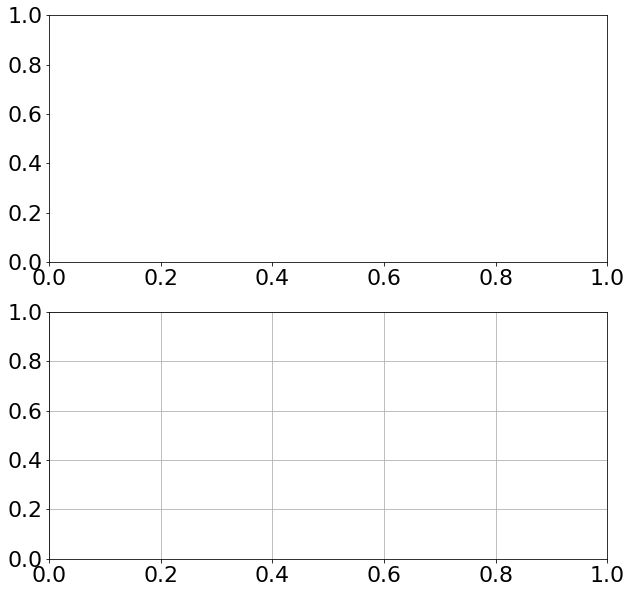

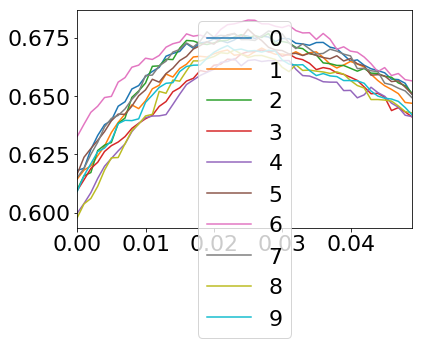

In [22]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mplt

plots_output_folder = "plots"
pathlib.Path(plots_output_folder).mkdir(parents=True, exist_ok=True)

mplt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plt.grid('on')

df_flowers.plot()
plt.show()

In [13]:
metric_multiplier_flowers = df_flowers.idxmax().mean()
print("FLOWERS, metric multiplier:", metric_multiplier_flowers)

FLOWERS, metric multiplier: 0.0252


## FLOWERS dataset compute performance on test

In [14]:
log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144337_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_test_split"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split"
filter = "*embedding_size=1024*dataset=xian2018_flowers*repeat=*"

results = evaluate_test_result(logdir=log_dir, 
                               filter=filter, metric_multiplier=metric_multiplier_flowers)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Loading split trainval
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_trainval_xian2018.pkl


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;tes

INFO:root:Loaded cache in 4.546787 sec
INFO:root:Loading split test_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_test_seen_xian2018.pkl
INFO:root:Loaded cache in 1.993778 sec
INFO:root:Loading split test_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_test_unseen_xian2018.pkl
INFO:root:Loaded cache in 1.851099 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_r

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 36.85it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.54it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 34.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.7334754141
STD unseen prototype:
89.0547943281
STD seen prototype:
87.4334658381
STD unseen prototype:
86.4678357538
STD seen prototype:
87.0715769117
STD unseen prototype:
86.2823519209


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.0471984957
STD unseen prototype:
86.0293479533
STD seen prototype:
87.0042312926
STD unseen prototype:
86.015603644
STD seen prototype:
87.0215585117
STD unseen prototype:
86.0076882487
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 14.38it/s]

STD seen prototype:
87.2731821958
STD unseen prototype:
92.4486643405
STD seen prototype:
84.7035115838
STD unseen prototype:
90.6747803618
STD seen prototype:
84.401051313
STD unseen prototype:
90.5197827006


100%|██████████| 6/6 [00:00<00:00, 14.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
84.1722740966
STD unseen prototype:
90.3158837537
STD seen prototype:
84.1414209246
STD unseen prototype:
90.3997179981
STD seen prototype:
84.0634850322
STD unseen prototype:
90.3280745682
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=0;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 38.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.18it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.8165197587
STD unseen prototype:
89.5136550976
STD seen prototype:
87.3315126619
STD unseen prototype:
86.6218926562
STD seen prototype:
87.4109543438
STD unseen prototype:
86.5920962136


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.2135386248
STD unseen prototype:
86.2961990114
STD seen prototype:
87.1646348037
STD unseen prototype:
86.2308381335
STD seen prototype:
87.1720750269
STD unseen prototype:
86.1880454813
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 14.12it/s]

STD seen prototype:
87.2919188508
STD unseen prototype:
91.8178306114
STD seen prototype:
84.88730574
STD unseen prototype:
90.9229506627
STD seen prototype:
84.5715650712
STD unseen prototype:
90.3937635286


100%|██████████| 6/6 [00:00<00:00, 14.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
84.3774877512
STD unseen prototype:
90.4328905795
STD seen prototype:
84.2563258112
STD unseen prototype:
90.4278623595
STD seen prototype:
84.2225226511
STD unseen prototype:
90.4214005049
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=1;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 37.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.77it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.9509476669
STD unseen prototype:
87.8966600623
STD seen prototype:
86.784196684
STD unseen prototype:
85.5267472954
STD seen prototype:
86.4819296051
STD unseen prototype:
85.5259134192


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.3791170833
STD unseen prototype:
85.3037566362
STD seen prototype:
86.3471373478
STD unseen prototype:
85.2642507484
STD seen prototype:
86.3550065573
STD unseen prototype:
85.2447382797
****************
SEEN images test
****************
STD seen prototype:
86.0153112155
STD unseen prototype:
90.9887915699


 67%|██████▋   | 4/6 [00:00<00:00, 14.65it/s]

STD seen prototype:
83.8368829366
STD unseen prototype:
89.6876036088
STD seen prototype:
83.4231627853
STD unseen prototype:
89.5177935244
STD seen prototype:
83.2806311355
STD unseen prototype:
89.3892835726


100%|██████████| 6/6 [00:00<00:00, 14.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.1357401388
STD unseen prototype:
89.357111738
STD seen prototype:
83.0946597564
STD unseen prototype:
89.3140652837
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=2;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 40.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.72it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.149995856
STD unseen prototype:
86.98554505
STD seen prototype:
86.161766218
STD unseen prototype:
85.2853650752
STD seen prototype:
85.8695001332
STD unseen prototype:
85.0109430385


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
85.7849245708
STD unseen prototype:
84.7899342667
STD seen prototype:
85.7833938197
STD unseen prototype:
84.7890292042
STD seen prototype:
85.738050157
STD unseen prototype:
84.7671209553
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 14.11it/s]

STD seen prototype:
85.7497228815
STD unseen prototype:
91.5432497433
STD seen prototype:
83.6866643834
STD unseen prototype:
89.6096398307
STD seen prototype:
83.3570393996
STD unseen prototype:
89.3846140484


100%|██████████| 6/6 [00:00<00:00, 13.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.1459090837
STD unseen prototype:
89.3284623283
STD seen prototype:
83.0626509492
STD unseen prototype:
89.1779160574
STD seen prototype:
83.0004848058
STD unseen prototype:
89.1924712446
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=3;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 37.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.54it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 37.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.4634255143
STD unseen prototype:
88.1336653205
STD seen prototype:
86.8292761373
STD unseen prototype:
86.1285823821
STD seen prototype:
86.6185378447
STD unseen prototype:
85.4671038238


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.5560300973
STD unseen prototype:
85.4845550167
STD seen prototype:
86.5425464247
STD unseen prototype:
85.5176264171
STD seen prototype:
86.5214680925
STD unseen prototype:
85.4430414234
****************
SEEN images test
****************
STD seen prototype:
86.6536831739
STD unseen prototype:
91.9012265712


 67%|██████▋   | 4/6 [00:00<00:00, 15.57it/s]

STD seen prototype:
83.987910664
STD unseen prototype:
90.108328783
STD seen prototype:
83.7985225169
STD unseen prototype:
89.8839386777
STD seen prototype:
83.6279243357
STD unseen prototype:
89.7838803306


100%|██████████| 6/6 [00:00<00:00, 14.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.4934371473
STD unseen prototype:
89.7695602901
STD seen prototype:
83.4556255043
STD unseen prototype:
89.7295180437
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=4;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 37.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.31it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 40.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
89.4078715564
STD unseen prototype:
89.1284083997
STD seen prototype:
88.2174734693
STD unseen prototype:
87.6149803973
STD seen prototype:
88.2200511397
STD unseen prototype:
87.1074882933


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
87.9357010665
STD unseen prototype:
87.0079485178
STD seen prototype:
87.9896005064
STD unseen prototype:
86.9218476735
STD seen prototype:
87.9659945384
STD unseen prototype:
86.8915253008
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 14.74it/s]

STD seen prototype:
87.8369197306
STD unseen prototype:
93.0934952261
STD seen prototype:
85.7703186019
STD unseen prototype:
91.1949843811
STD seen prototype:
85.3642495351
STD unseen prototype:
91.2136862323
STD seen prototype:
85.0528194582
STD unseen prototype:
90.913246858


100%|██████████| 6/6 [00:00<00:00, 13.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
84.983605836
STD unseen prototype:
91.1286729948
STD seen prototype:
84.9308090279
STD unseen prototype:
91.0447956632
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=5;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 37.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.36it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 40.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.6129052219
STD unseen prototype:
89.00709788
STD seen prototype:
87.1221273736
STD unseen prototype:
86.4195452086
STD seen prototype:
86.8611911825
STD unseen prototype:
85.9363936016


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.7576362445
STD unseen prototype:
85.9795232624
STD seen prototype:
86.8055759097
STD unseen prototype:
85.8495293523
STD seen prototype:
86.8086275614
STD unseen prototype:
85.8639526278
****************
SEEN images test
****************
STD seen prototype:
87.0072783291
STD unseen prototype:
91.7542834673


 67%|██████▋   | 4/6 [00:00<00:00, 14.73it/s]

STD seen prototype:
84.6492842557
STD unseen prototype:
90.242954892
STD seen prototype:
84.2280448756
STD unseen prototype:
90.0303052664
STD seen prototype:
84.0690519995
STD unseen prototype:
90.1425304162


100%|██████████| 6/6 [00:00<00:00, 14.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.9893847552
STD unseen prototype:
90.0269286084
STD seen prototype:
83.9237374059
STD unseen prototype:
90.0292093501
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=6;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 38.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.63it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
88.3073686095
STD unseen prototype:
87.96419848
STD seen prototype:
86.8061781902
STD unseen prototype:
86.1538050661
STD seen prototype:
86.5353342859
STD unseen prototype:
85.6566923453


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.4771378026
STD unseen prototype:
85.4508070749
STD seen prototype:
86.4193412816
STD unseen prototype:
85.3874221126
STD seen prototype:
86.3935670552
STD unseen prototype:
85.4126731086
****************
SEEN images test
****************
STD seen prototype:
86.2900721371
STD unseen prototype:
91.6630554732


 67%|██████▋   | 4/6 [00:00<00:00, 15.03it/s]

STD seen prototype:
84.205920567
STD unseen prototype:
90.0123218564
STD seen prototype:
83.7739842861
STD unseen prototype:
89.7867956538
STD seen prototype:
83.6835794993
STD unseen prototype:
89.7591951733


100%|██████████| 6/6 [00:00<00:00, 14.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
83.5112872508
STD unseen prototype:
89.6788936035
STD seen prototype:
83.4704889334
STD unseen prototype:
89.6469259209
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=7;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 38.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.68it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 37.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.731939749
STD unseen prototype:
87.4836449659
STD seen prototype:
86.2405107597
STD unseen prototype:
85.515736736
STD seen prototype:
86.1087649055
STD unseen prototype:
85.1156804005


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
86.0773645526
STD unseen prototype:
85.0399078062
STD seen prototype:
86.0403221446
STD unseen prototype:
85.0225457899
STD seen prototype:
86.0219187423
STD unseen prototype:
84.9543766501
****************
SEEN images test
****************
STD seen prototype:
85.8673536666
STD unseen prototype:
90.3750245927


 67%|██████▋   | 4/6 [00:00<00:00, 15.37it/s]

STD seen prototype:
83.7096854243
STD unseen prototype:
89.5693567834
STD seen prototype:
83.283656539
STD unseen prototype:
89.3214302277
STD seen prototype:
83.0263893017
STD unseen prototype:
89.0358391471
STD seen prototype:
82.998653215
STD unseen prototype:
89.1784622453


100%|██████████| 6/6 [00:00<00:00, 14.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.9305328425
STD unseen prototype:
89.102383087
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=8;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/train/model-100000
INFO:root:Computing train embeddings
176it [00:04, 38.58it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.04it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
87.2445676675
STD unseen prototype:
87.2271546371
STD seen prototype:
85.8748969517
STD unseen prototype:
84.7327290465
STD seen prototype:
85.7526405626
STD unseen prototype:
84.5371836646


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
85.6577741508
STD unseen prototype:
84.4603425304
STD seen prototype:
85.5232325355
STD unseen prototype:
84.4411133247
STD seen prototype:
85.5478959784
STD unseen prototype:
84.4228531958
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
85.4744463113
STD unseen prototype:
90.2761456947
STD seen prototype:
83.1503213952
STD unseen prototype:
89.2889407292
STD seen prototype:
82.797682169
STD unseen prototype:
88.612139241


100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
82.5978839751
STD unseen prototype:
88.7161291556
STD seen prototype:
82.5109350997
STD unseen prototype:
88.6262161004
STD seen prototype:
82.4677034781
STD unseen prototype:
88.6206476242
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/embedding_size=1024;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=100001;repeat=9;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


In [15]:
dmean(results)

{'train_AP@50/#sentences10': 0.67795121951219506,
 'train_Top-1 Acc/#sentences10': 0.70947039149492663,
 'train_AP@50/#sentences50': 0.83017073170731703,
 'train_Top-1 Acc/#sentences50': 0.89066231612989666,
 'train_AP@50/#sentences100': 0.84299999999999997,
 'train_Top-1 Acc/#sentences100': 0.90825376906444899,
 'train_AP@50/#sentences200': 0.85299999999999998,
 'train_Top-1 Acc/#sentences200': 0.92136994288610941,
 'train_AP@50/#sentences400': 0.85724390243902437,
 'train_Top-1 Acc/#sentences400': 0.92754636261924295,
 'train_AP@50/#sentences1000': 0.85858536585365852,
 'train_Top-1 Acc/#sentences1000': 0.92976720820028047,
 'test_AP@50/#sentences10': 0.51219999999999999,
 'test_Top-1 Acc/#sentences10': 0.58049373848371721,
 'test_AP@50/#sentences50': 0.59110000000000018,
 'test_Top-1 Acc/#sentences50': 0.71126689049542624,
 'test_AP@50/#sentences100': 0.60010000000000008,
 'test_Top-1 Acc/#sentences100': 0.74237958300040252,
 'test_AP@50/#sentences200': 0.61139999999999994,
 'test_T

In [46]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mplt

plots_output_folder = "plots"
pathlib.Path(plots_output_folder).mkdir(parents=True, exist_ok=True)

def plot_df(df, filename):
    mplt.rcParams.update({'font.size': 22})
    mplt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)

    df.plot(ax=ax)
    ax.get_legend().remove()
    plt.grid('on')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'H')
    plt.show()
    
    fig.savefig(os.path.join(plots_output_folder, filename), bbox_inches='tight')

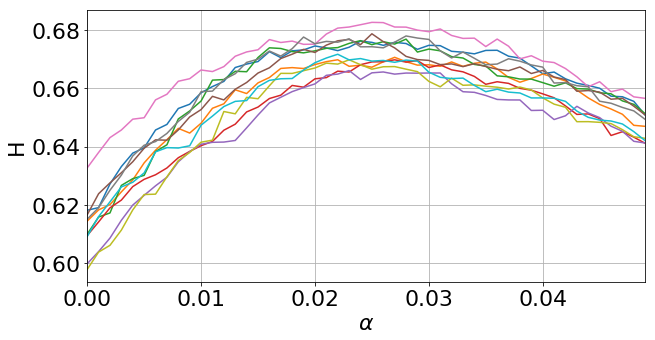

In [47]:
plot_df(df=df_flowers, filename="alpha_crossvalidation_flowers.pdf")

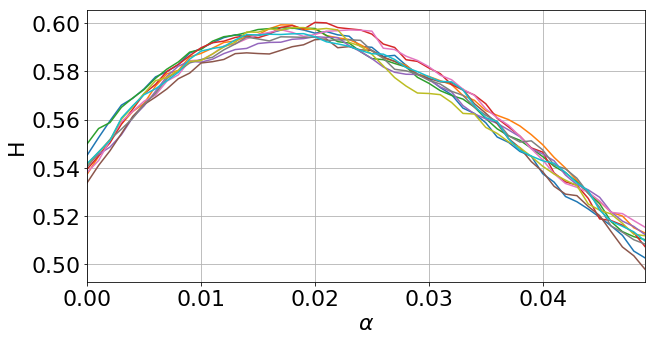

In [50]:
plot_df(df=df, filename="alpha_crossvalidation_cub.pdf")